In [20]:
import numpy as np
import glob
import matplotlib.pyplot as plt
from astropy.table import Table, Column
from tqdm import tqdm
import math
from astropy.io import fits
import astropy.units as u

from scipy.interpolate import RegularGridInterpolator
#from dust_extinction.parameter_averages import F99
from dust_extinction.parameter_averages import G23
from scipy.signal import savgol_filter

from scipy.optimize import curve_fit
import matplotlib.cm as cm

# Calculating Veiling

In [35]:
def reading_obs(file_path, rv):
    hdul = fits.open(f"C:/Users/serat/Downloads/yso_veiled/{file_path}")
    t = hdul[1].data
    a = np.where((t["IVAR"] > np.median(t["IVAR"])/10) & (np.isfinite(t['IVAR'])==True))[0]
    flux = t["FLUX"][a] / np.median(t["FLUX"][a])
    wl2 = 10**(t["LOGLAM"][a])
    wl2 = wl2 + wl2*(rv/299792.458)
    err=(np.sqrt(1./t["IVAR"][a]))/np.nanmedian(flux)

    return flux, wl2,err


def divide_in_steps(flux, wl2):
    total_steps = int(((max(wl2)-min(wl2))//100))
    wl2_arr = []
    flux_arr = []
    for i in range(total_steps):
        x = ((min(wl2)//100)*100) + 100*i
        a = np.where((wl2<x+1000) & (wl2>=x))[0]
        flux_new = flux[a]
        wl2_new = wl2[a]
        flux_arr.append(flux_new)
        wl2_arr.append(wl2_new)
    return flux_arr, wl2_arr

def reading_ph(teff, logg):
    hdul = fits.open(f"C:/Users/serat/Downloads/phoenix_fits/lte0{teff}-{logg}0-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits")
    primary_hdu = hdul[0]
    data = primary_hdu.data
    header = primary_hdu.header
    wl1 = np.arange(header["NAXIS1"])*header["CDELT1"]+header["CRVAL1"]
    data = data/np.median(data)
    return data, wl1

def model_flux_Av(synthetic_flux, Av):
    ext_model = G23(Rv=3.1)
    flux_corrected = synthetic_flux * ext_model.extinguish(wavelengths_obs, Av=Av)
    flux = flux_corrected/np.median(flux_corrected)
    return flux
    
def model_flux_veiling(flux, v_const):
    flux = (flux/np.median(flux)) + v_const
    flux = flux/(1+v_const)
    return flux/np.median(flux)

def reinterp(wavelengths_obs,wavelengths_ph, flux_ph):
    ll=np.diff(wavelengths_obs)
    d=[ll[0]]
    d.extend(ll)
    d.append(ll[-1])
    d=np.array(d)
    l1=wavelengths_obs-d[:-1]*0.5
    l2=wavelengths_obs+d[1:]*0.5
    
    synthetic_flux=np.zeros(len(l1))
    for j in range(len(l1)):
        x=np.where((wavelengths_ph>l1[j]) & (wavelengths_ph<l2[j]))[0]
        synthetic_flux[j]=np.sum(flux_ph[x])/len(x)

    return synthetic_flux
    



SyntaxError: '(' was never closed (3913037932.py, line 8)

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]C:\Users\serat\AppData\Local\Temp\ipykernel_5556\1750655346.py:58: RuntimeWarning: invalid value encountered in double_scalars
  synthetic_flux[j]=np.sum(flux_ph[x])/len(x)


0
0
[0.15104738 0.02136086 0.08003444 0.07714495]


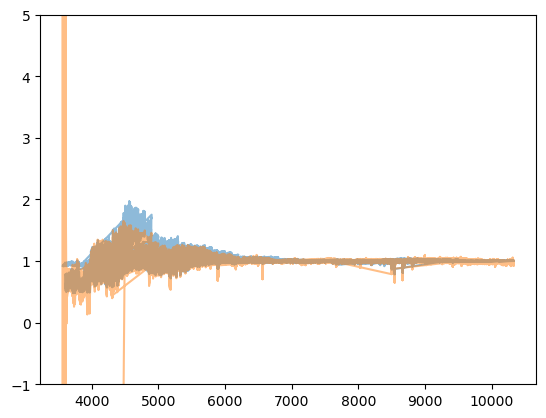

 25%|█████████████████████                                                               | 1/4 [00:12<00:37, 12.52s/it]

0
0
[52.19913676 11.04731164  1.64671005  0.34872638]


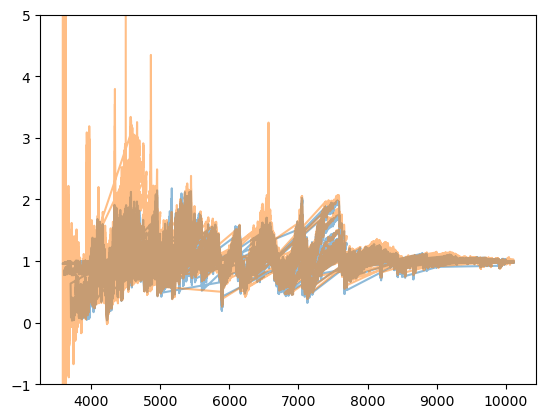

 50%|██████████████████████████████████████████                                          | 2/4 [00:24<00:24, 12.31s/it]

0
0
[0.87243438 0.3361673  0.57742257 0.36643366]


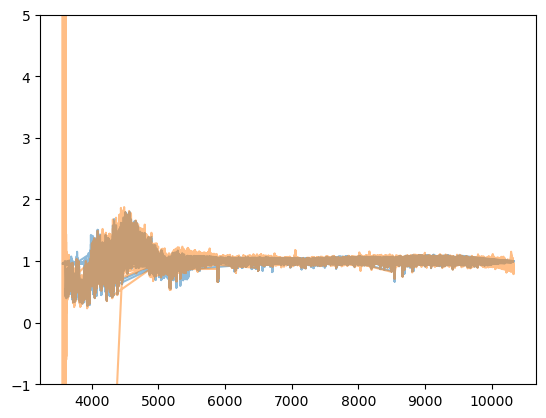

 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:39<00:13, 13.31s/it]

0
0
[5.56498311 0.31478224 0.79633222 0.44833124]


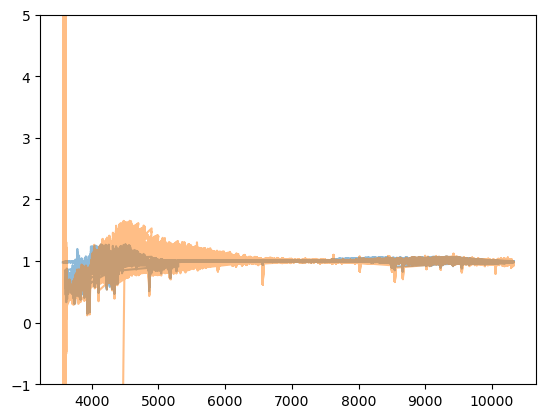

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:54<00:00, 13.60s/it]


In [36]:
s = Table.read("C:/Users/serat/Downloads/yso_veiled_healpix.fits")

teff = round(10**(s["u_med_logteff_1"][0])/100)*100
logg = round(s["u_med_logg_1"][0] / 0.5)*0.5


_, wavelengths_ph = reading_ph(teff, logg) # the common wavelength range of the phoenix data


ext_model = G23(Rv=3.1)


# Saving all the possible Teff and Logg in the phoenix data
a = glob.glob("C:/Users/serat/Downloads/phoenix_fits/lte0*-*0-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits")
Teff = []
Logg = []

for i in range(len(a)):
    file = a[i]
    splt = file.split("lte")
    teff = int(splt[1].split("-")[0])
    logg = float(splt[1].split("-")[1])
    Teff.append(teff)
    Logg.append(logg)

Teff = np.unique(Teff)
Logg = np.unique(Logg)


# array used to interpolate
arr = np.zeros((len(Teff), len(Logg), len(wavelengths_ph)),)


for i in range(len(Teff)):
    for j in range(len(Logg)):
        try:
            flux1, wl1 = reading_ph(Teff[i], Logg[j])
            arr[i][j] = flux1
        except:
            continue
            
interpolator_ph = RegularGridInterpolator((Teff, Logg), arr)

s["Chisquare_list"] = Column(length=len(s),dtype=float, shape=(4,))+np.nan

s["veiling_arr"] = Column(length=len(s),dtype=float, shape=(70,))+np.nan

arr = np.arange(0, 67, 1)

for i in tqdm(range(6, 10)):
    #try:
    rv = s["XCSAO_RV"][i]
    Teff_obs = 10**(s["u_med_logteff_1"][i])
    Logg_obs = s["u_med_logg_1"][i]
    healpix = s["HEALPIX_PATH"][i]
    file_path = healpix.split("/")[-1]

    flux_obs, wavelengths_obs, err_obs = reading_obs(file_path, rv)
    
    
    flux_ph = interpolator_ph((Teff_obs, Logg_obs))
    synthetic_flux = reinterp(wavelengths_obs, wavelengths_ph, flux_ph)
    
    wavelengths_obs = wavelengths_obs * u.AA
    wavenumbers = (1.0 / wavelengths_obs)
    a = np.where((wavenumbers >= 0.03125/u.micron) & (wavenumbers <= 10.964912280701753/u.micron) & (wavenumbers != np.nan))[0]
    synthetic_flux = synthetic_flux[a]
    wavelengths_obs = wavelengths_obs[a]
    flux_obs = flux_obs[a]
    
    err_obs=err_obs[a]    
        
    # Normalizing everything again
    #err_obs=err_obs//np.nanmedian(flux_obs)
    #flux_obs = flux_obs/np.nanmedian(flux_obs)
    
    
    
    
    synthetic_flux = synthetic_flux/np.nanmedian(synthetic_flux)
    b = np.where((np.isfinite(synthetic_flux) == True))[0]
    
    c = np.where((err_obs < 0))[0]
    print(len(c))
    
    
    synthetic_flux=np.interp(wavelengths_obs,wavelengths_obs[b],synthetic_flux[b])
    
    d = np.where((np.isfinite(synthetic_flux) == False))[0]
    print(len(d))
    
    
    params, _ = curve_fit(model_flux_Av, synthetic_flux, flux_obs, bounds=(0, 100), sigma=err_obs)
    
    flux_correct = synthetic_flux*ext_model.extinguish(wavelengths_obs, Av=params[0])
    flux_correct = flux_correct/np.median(flux_correct)
    #plt.plot(wavelengths_obs, flux_correct)
    #plt.plot(wavelengths_obs, flux_obs)
    
    wavelengths_obs = wavelengths_obs/u.AA
    
    flux_correct_arr, wl_arr = divide_in_steps(flux_correct, wavelengths_obs)
    flux_obs_arr, wl_arr = divide_in_steps(flux_obs, wavelengths_obs)
    err_obs_arr, wl_arr = divide_in_steps(err_obs, wavelengths_obs)
    
    veiling_arr = []
    
        
    for j in range(len(wl_arr)):
        synthetic_flux_step = flux_correct_arr[j]/np.median(flux_correct_arr[j])
        
        flux_obs_step=flux_obs_arr[j]/np.median(flux_obs_arr[j])
        flux_obs_arr[j]=flux_obs_step
        
        err_obs_step=err_obs_arr[j]/np.median(flux_obs_step)
        err_obs_arr[j]=err_obs_step
        
        wl_step = wl_arr[j]
        
        params, _ = curve_fit(model_flux_veiling, synthetic_flux_step, flux_obs_step, bounds=(0, 20), sigma=err_obs_step)
        flux_correct_arr[j] = (synthetic_flux_step + params[0]) / (1+params[0])
        veiling_arr.append(params[0])
        #plt.plot(wl_step, synthetic_flux_step)
    
    wl_arr_comb = np.concatenate(wl_arr)
    err_obs_comb = np.concatenate(err_obs_arr)
    flux_correct_comb = np.concatenate(flux_correct_arr)
    flux_obs_comb = np.concatenate(flux_obs_arr)

    #plt.plot(wl_arr_comb, flux_correct_comb, alpha=0.5)
    #plt.plot(wl_arr_comb, flux_obs_comb, alpha=0.5)
    #plt.ylim(-1, 5)
    
    
    # masks for the wavelength range
    #mask = np.where((wl_arr_comb > 5500) & (wl_arr_comb < 9500))
    range1_mask = np.where((wl_arr_comb > 5500) & (wl_arr_comb < 6500))
    range2_mask = np.where((wl_arr_comb > 6600) & (wl_arr_comb < 7600))
    range3_mask = np.where((wl_arr_comb > 7600) & (wl_arr_comb < 8600))
    range4_mask = np.where((wl_arr_comb > 8600) & (wl_arr_comb < 9600))
    
    # total chi square
    #chi_square_total = np.sum(((flux_obs_comb[mask] - flux_correct_comb[mask]) / err_obs_comb[mask]) ** 2)
    
    # chi square for each range
    chi_square_range1 = np.sum(((flux_obs_comb[range1_mask] - flux_correct_comb[range1_mask]) / err_obs_comb[range1_mask]) ** 2)
    chi_square_range2 = np.sum(((flux_obs_comb[range2_mask] - flux_correct_comb[range2_mask]) / err_obs_comb[range2_mask]) ** 2)
    chi_square_range3 = np.sum(((flux_obs_comb[range3_mask] - flux_correct_comb[range3_mask]) / err_obs_comb[range3_mask]) ** 2)
    chi_square_range4 = np.sum(((flux_obs_comb[range4_mask] - flux_correct_comb[range4_mask]) / err_obs_comb[range4_mask]) ** 2)

    s["Chisquare_list"][i][0] = chi_square_range1
    s["Chisquare_list"][i][1] = chi_square_range2
    s["Chisquare_list"][i][2] = chi_square_range3
    s["Chisquare_list"][i][3] = chi_square_range4
    
    print(s["Chisquare_list"][i])

        
    s["veiling_arr"][i][0 : len(veiling_arr)] = veiling_arr
        

    #plt.xlim(6400, 6800)

    plt.show()


    #except:
    #    continue

    
#s.write("emission_nyso.fits", overwrite=True)


In [ ]:
print(s["Chisquare_list"][0])

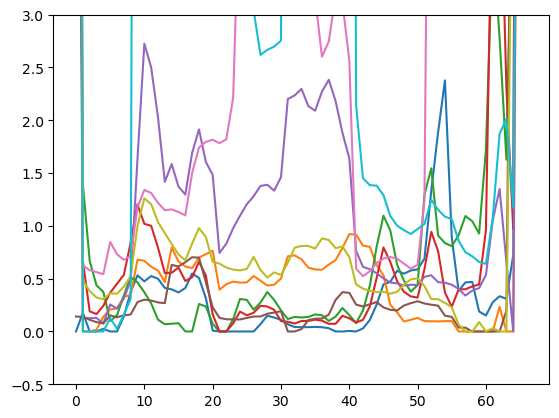

In [4]:
arr = np.arange(0, 70, 1)

for i in range(100):
    veiling_arr = s["veiling_arr"][i]
    #veiling_arr = savgol_filter(veiling_arr, 15, 3) 
    plt.plot(arr, veiling_arr)

plt.ylim(-0.5, 3)
plt.show()
    #print(s["veiling_arr"][i])
    
plt.plot()

In [ ]:
# window size 51, polynomial order 3

#s = Table.read("emission.fits")
arr = np.arange(0, 700, 1)

for i in range(len(s)):
    try:
        veiling_arr = s['veiling_arr'][i]
        a = np.where(s['veiling_arr'][i] < 7)[0]
        
        temp = s['pred_logteff_1'][i]
        
        
        veiling_arr = savgol_filter(veiling_arr[a], 15, 3) 
        plt.plot(arr[a], veiling_arr/np.median(veiling_arr))
    except:
        continue
plt.show()

C:\Users\serat\AppData\Local\Temp\ipykernel_9444\4292925968.py:35: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='logteff')


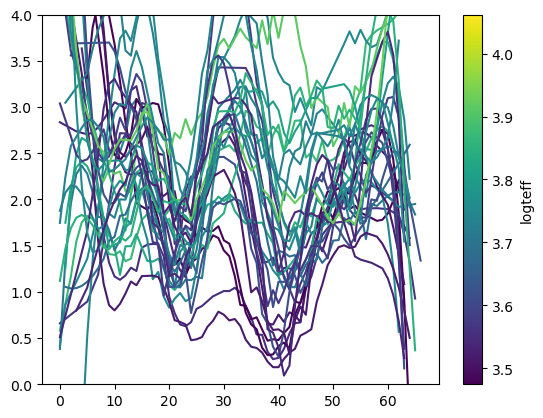

In [26]:
#s = Table.read("emission.fits")

arr = np.arange(1470)

plt.figure()

unique_logteff = np.unique(s['pred_logteff_1'])
colors = cm.viridis(np.linspace(0, 1, len(unique_logteff)))
color_dict = dict(zip(unique_logteff, colors))

for i in range(50):
    try:
        veiling_arr = s['veiling_arr'][i]
        a = np.where(veiling_arr < 7)[0]
        
        if len(a) < 51:
            continue
        
        temp = s['pred_logteff_1'][i]
        
        veiling_arr_filtered = savgol_filter(veiling_arr[a], 15, 3)
 
        veiling_arr_normalized = veiling_arr_filtered #/ np.median(veiling_arr_filtered)
        
     
        plt.plot(arr[a], veiling_arr_normalized, color=color_dict[temp])
        
    except Exception as e:
        continue


sm = plt.cm.ScalarMappable(cmap=cm.viridis, norm=plt.Normalize(vmin=min(unique_logteff), vmax=max(unique_logteff)))
sm.set_array([])
plt.ylim(0, 4)
plt.colorbar(sm, label='logteff')

plt.show()


C:\Users\serat\AppData\Local\Temp\ipykernel_9444\3212063736.py:34: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='logteff')


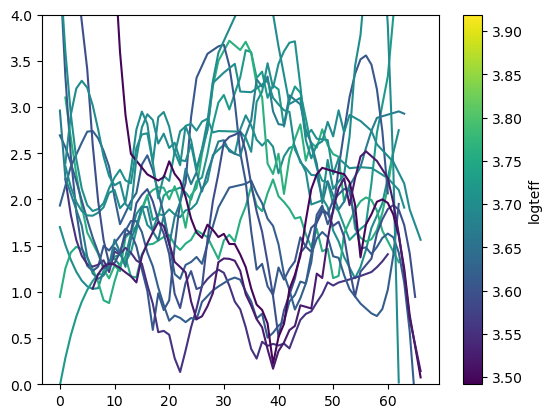

In [25]:
s = Table.read("emission_nyso.fits")

#arr = np.arange(1470)

plt.figure()

unique_logteff = np.unique(s['pred_logteff_1'])
colors = cm.viridis(np.linspace(0, 1, len(unique_logteff)))
color_dict = dict(zip(unique_logteff, colors))

for i in range(50):
    try:
        veiling_arr = s['veiling_arr'][i]
        a = np.where(veiling_arr < 7)[0]
        
        if len(a) < 51:
            continue
        
        temp = s['pred_logteff_1'][i]
        
        veiling_arr_filtered = savgol_filter(veiling_arr[a], 15, 3)
 
        veiling_arr_normalized = veiling_arr_filtered #/ np.median(veiling_arr_filtered)
        
     
        plt.plot(arr[a], veiling_arr_normalized, color=color_dict[temp])
        
    except Exception as e:
        continue


sm = plt.cm.ScalarMappable(cmap=cm.viridis, norm=plt.Normalize(vmin=min(unique_logteff), vmax=max(unique_logteff)))
sm.set_array([])
plt.colorbar(sm, label='logteff')
plt.ylim(0, 4)
plt.show()


In [ ]:
for i in range(100):
    try:
        veiling_arr = s['veiling_arr'][i]
        a = np.where(s['veiling_arr'][i] != np.nan)[0]
        veiling_arr = veiling_arr[a]
        print(veiling_arr)
        plt.hist(veiling_arr)
    except:
        continue
    
plt.show()

In [ ]:
s = Table.read("emission.fits")
av = np.array(s["Av"])

#plt.hist(av, bins=15)
#plt.show()
#
#plt.scatter(s["hgamma_eqw_best_logn1"], av)
#plt.show()
#
#plt.scatter(s["hgamma_eqw_best_Teff1"], av)
#plt.show()
#
#plt.scatter(s["pred_logg_1"], av)
#plt.show()
#
#plt.scatter(s["pred_logteff_1"], av)
#plt.show()
a = np.where(s["pred_logteff_1"] < np.log10(4000))

plt.scatter(s["age"][a], s["Av"][a]-s["av"][a], c=s["pred_logteff_1"][a])
plt.show()

C:\Users\serat\AppData\Local\Temp\ipykernel_14132\460668078.py:38: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='logteff')


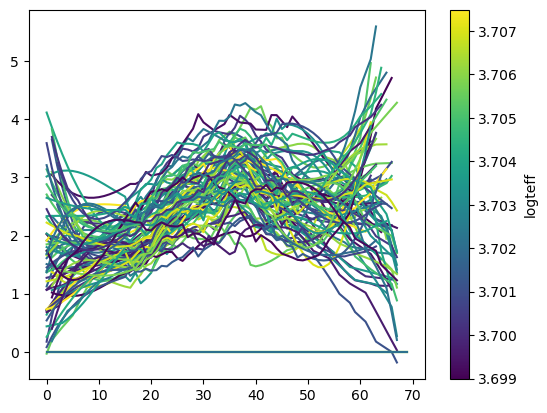

In [14]:
y = Table.read("yso_veiled.fits")
a = np.where(y["CTTS"] == False)[0]
y = y[a]
arr = np.arange(1470)
b = np.where((y["pred_logteff"] > np.log10(5000)) & (y["pred_logteff"] < np.log10(5100))) [0]
y = y[b]

plt.figure()

unique_logteff = np.unique(y['pred_logteff'])

colors = cm.viridis(np.linspace(0, 1, len(unique_logteff)))
color_dict = dict(zip(unique_logteff, colors))

for i in range(500):
    try:
        veiling_arr = y['veiling_arr'][i]
        
        a = np.where(veiling_arr < 7)[0]
        
        if len(a) < 51:
            continue
        
        temp = y['pred_logteff'][i]
        veiling_arr_filtered = savgol_filter(veiling_arr[a], 31, 3)
 
        veiling_arr_normalized = veiling_arr_filtered 
        
     
        plt.plot(arr[a], veiling_arr_normalized, color=color_dict[temp])
        
    except Exception as e:
        continue


sm = plt.cm.ScalarMappable(cmap=cm.viridis, norm=plt.Normalize(vmin=min(unique_logteff), vmax=max(unique_logteff)))
sm.set_array([])
plt.colorbar(sm, label='logteff')
#plt.ylim(0, 4)
plt.show()



In [9]:
import requests
from requests.auth import HTTPBasicAuth
from astropy.table import Table
import os

# Create the directory if it doesn't exist
if not os.path.exists('lineforest_files'):
    os.makedirs('lineforest_files')

basic = HTTPBasicAuth('sdss5', 'panoPtic-5')

t = Table.read("lineforest_boss.fits")

for i in tqdm(range(1739, len(t))):
    path = t["HEALPIX_PATH"][i]
    url = f"https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix{path[12:]}"
    print(url)

    response = requests.get(url, auth=basic)

    # Extract the filename from the URL
    filename = url.split("/")[-1]
    filepath = os.path.join('lineforest_files', filename)

    # Ensure the request was successful
    if response.status_code == 200:
        with open(filepath, 'wb') as file:  # Notice we're using 'wb' mode here
            file.write(response.content)
        print(f"File downloaded and saved to {filepath}.")
    else:
        print(f"Error: {response.status_code}. Could not download the file.")


#for i in range(len(t)):
#    t = Table.read("lineforest_boss.fits")
#    path = t["HEALPIX_PATH"][i]
#    url = f"https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix{path[12:]}"
from astropy.io import fits#    print(url)

  0%|                                                                                       | 0/764643 [00:00<?, ?it/s]

https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/43/43433/boss/v6_1_0/spec-015022-59231-4555183841.fits


  0%|                                                                           | 1/764643 [00:02<501:54:52,  2.36s/it]

File downloaded and saved to lineforest_files\spec-015022-59231-4555183841.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/41/41896/boss/v6_1_0/spec-015022-59231-4555196215.fits


  0%|                                                                           | 2/764643 [00:04<465:41:41,  2.19s/it]

File downloaded and saved to lineforest_files\spec-015022-59231-4555196215.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/41/41896/boss/v6_1_0/spec-015022-59231-4555199343.fits


  0%|                                                                           | 3/764643 [00:06<449:02:54,  2.11s/it]

File downloaded and saved to lineforest_files\spec-015022-59231-4555199343.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/41/41385/boss/v6_1_0/spec-015022-59231-4555200962.fits


  0%|                                                                           | 4/764643 [00:08<464:19:43,  2.19s/it]

File downloaded and saved to lineforest_files\spec-015022-59231-4555200962.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/42/42922/boss/v6_1_0/spec-015022-59231-4555208338.fits


  0%|                                                                           | 5/764643 [00:10<459:31:08,  2.16s/it]

File downloaded and saved to lineforest_files\spec-015022-59231-4555208338.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/42/42922/boss/v6_1_0/spec-015022-59231-4555218710.fits


  0%|                                                                           | 6/764643 [00:14<582:27:08,  2.74s/it]

File downloaded and saved to lineforest_files\spec-015022-59231-4555218710.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/43/43435/boss/v6_1_0/spec-015022-59231-4555219940.fits


  0%|                                                                           | 7/764643 [00:21<874:40:34,  4.12s/it]

File downloaded and saved to lineforest_files\spec-015022-59231-4555219940.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/42/42923/boss/v6_1_0/spec-015022-59231-4555221603.fits


  0%|                                                                          | 8/764643 [00:29<1141:51:05,  5.38s/it]

File downloaded and saved to lineforest_files\spec-015022-59231-4555221603.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/41/41898/boss/v6_1_0/spec-015022-59231-4555223322.fits


  0%|                                                                          | 9/764643 [00:34<1073:44:19,  5.06s/it]

File downloaded and saved to lineforest_files\spec-015022-59231-4555223322.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/41/41899/boss/v6_1_0/spec-015022-59231-4555225069.fits


  0%|                                                                          | 10/764643 [00:37<948:22:55,  4.47s/it]

File downloaded and saved to lineforest_files\spec-015022-59231-4555225069.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/42/42412/boss/v6_1_0/spec-015022-59231-4555226860.fits


  0%|                                                                          | 11/764643 [00:39<836:03:48,  3.94s/it]

File downloaded and saved to lineforest_files\spec-015022-59231-4555226860.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/42/42412/boss/v6_1_0/spec-015022-59231-4555229959.fits


  0%|                                                                          | 12/764643 [00:42<753:36:26,  3.55s/it]

File downloaded and saved to lineforest_files\spec-015022-59231-4555229959.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/40/40872/boss/v6_1_0/spec-015022-59231-4555241423.fits


  0%|                                                                          | 13/764643 [00:45<689:57:29,  3.25s/it]

File downloaded and saved to lineforest_files\spec-015022-59231-4555241423.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/40/40361/boss/v6_1_0/spec-015022-59231-4555247080.fits


  0%|                                                                          | 14/764643 [00:48<689:08:45,  3.24s/it]

File downloaded and saved to lineforest_files\spec-015022-59231-4555247080.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/39/39849/boss/v6_1_0/spec-015022-59231-4555248612.fits


  0%|                                                                          | 15/764643 [00:50<637:35:49,  3.00s/it]

File downloaded and saved to lineforest_files\spec-015022-59231-4555248612.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/41/41387/boss/v6_1_0/spec-015022-59231-4555267413.fits


  0%|                                                                          | 16/764643 [00:53<634:01:29,  2.99s/it]

File downloaded and saved to lineforest_files\spec-015022-59231-4555267413.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/40/40875/boss/v6_1_0/spec-015022-59231-4555270195.fits


  0%|                                                                          | 17/764643 [00:56<598:49:15,  2.82s/it]

File downloaded and saved to lineforest_files\spec-015022-59231-4555270195.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/41/41388/boss/v6_1_0/spec-015022-59231-4555272568.fits


  0%|                                                                          | 18/764643 [00:58<579:04:07,  2.73s/it]

File downloaded and saved to lineforest_files\spec-015022-59231-4555272568.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/41/41389/boss/v6_1_0/spec-015022-59231-4555274345.fits


  0%|                                                                          | 19/764643 [01:01<566:20:41,  2.67s/it]

File downloaded and saved to lineforest_files\spec-015022-59231-4555274345.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/40/40876/boss/v6_1_0/spec-015022-59231-4555277564.fits


  0%|                                                                          | 20/764643 [01:03<554:04:22,  2.61s/it]

File downloaded and saved to lineforest_files\spec-015022-59231-4555277564.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/39/39851/boss/v6_1_0/spec-015022-59231-4555281230.fits


  0%|                                                                          | 21/764643 [01:06<555:42:39,  2.62s/it]

File downloaded and saved to lineforest_files\spec-015022-59231-4555281230.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/40/40363/boss/v6_1_0/spec-015022-59231-7575032389.fits


  0%|                                                                          | 22/764643 [01:08<549:57:23,  2.59s/it]

File downloaded and saved to lineforest_files\spec-015022-59231-7575032389.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/40/40874/boss/v6_1_0/spec-015022-59231-7610343754.fits


  0%|                                                                          | 23/764643 [01:11<556:16:24,  2.62s/it]

File downloaded and saved to lineforest_files\spec-015022-59231-7610343754.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/42/42920/boss/v6_1_0/spec-015022-59252-4555184482.fits


  0%|                                                                          | 24/764643 [01:13<488:48:21,  2.30s/it]

File downloaded and saved to lineforest_files\spec-015022-59252-4555184482.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/42/42409/boss/v6_1_0/spec-015022-59252-4555198055.fits


  0%|                                                                          | 25/764643 [01:15<492:38:00,  2.32s/it]

File downloaded and saved to lineforest_files\spec-015022-59252-4555198055.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/40/40872/boss/v6_1_0/spec-015022-59252-4555200375.fits


  0%|                                                                          | 26/764643 [01:17<474:48:25,  2.24s/it]

File downloaded and saved to lineforest_files\spec-015022-59252-4555200375.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/41/41385/boss/v6_1_0/spec-015022-59252-4555202092.fits


  0%|                                                                          | 27/764643 [01:19<468:44:24,  2.21s/it]

File downloaded and saved to lineforest_files\spec-015022-59252-4555202092.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/43/43435/boss/v6_1_0/spec-015022-59252-4555210283.fits


  0%|                                                                          | 28/764643 [01:21<464:18:24,  2.19s/it]

File downloaded and saved to lineforest_files\spec-015022-59252-4555210283.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/42/42410/boss/v6_1_0/spec-015022-59252-4555219211.fits


  0%|                                                                          | 29/764643 [01:24<490:27:18,  2.31s/it]

File downloaded and saved to lineforest_files\spec-015022-59252-4555219211.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/42/42411/boss/v6_1_0/spec-015022-59252-4555221024.fits


  0%|                                                                          | 30/764643 [01:26<486:25:20,  2.29s/it]

File downloaded and saved to lineforest_files\spec-015022-59252-4555221024.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/41/41386/boss/v6_1_0/spec-015022-59252-4555222842.fits


  0%|                                                                          | 31/764643 [01:28<481:16:19,  2.27s/it]

File downloaded and saved to lineforest_files\spec-015022-59252-4555222842.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/42/42411/boss/v6_1_0/spec-015022-59252-4555224399.fits


  0%|                                                                          | 32/764643 [01:31<479:42:23,  2.26s/it]

File downloaded and saved to lineforest_files\spec-015022-59252-4555224399.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/43/43436/boss/v6_1_0/spec-015022-59252-4555225740.fits


  0%|                                                                          | 33/764643 [01:33<483:46:00,  2.28s/it]

File downloaded and saved to lineforest_files\spec-015022-59252-4555225740.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/42/42412/boss/v6_1_0/spec-015022-59252-4555229174.fits


  0%|                                                                          | 34/764643 [01:35<487:00:54,  2.29s/it]

File downloaded and saved to lineforest_files\spec-015022-59252-4555229174.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/42/42413/boss/v6_1_0/spec-015022-59252-4555231688.fits


  0%|                                                                          | 35/764643 [01:38<488:09:07,  2.30s/it]

File downloaded and saved to lineforest_files\spec-015022-59252-4555231688.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/40/40873/boss/v6_1_0/spec-015022-59252-4555244678.fits


  0%|                                                                          | 36/764643 [01:40<490:16:14,  2.31s/it]

File downloaded and saved to lineforest_files\spec-015022-59252-4555244678.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/40/40362/boss/v6_1_0/spec-015022-59252-4555247935.fits


  0%|                                                                          | 37/764643 [01:42<494:24:55,  2.33s/it]

File downloaded and saved to lineforest_files\spec-015022-59252-4555247935.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/41/41387/boss/v6_1_0/spec-015022-59252-4555267413.fits


  0%|                                                                          | 38/764643 [01:45<498:48:36,  2.35s/it]

File downloaded and saved to lineforest_files\spec-015022-59252-4555267413.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/40/40362/boss/v6_1_0/spec-015022-59252-4555269064.fits


  0%|                                                                          | 39/764643 [01:47<502:01:05,  2.36s/it]

File downloaded and saved to lineforest_files\spec-015022-59252-4555269064.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/41/41388/boss/v6_1_0/spec-015022-59252-4555272558.fits


  0%|                                                                          | 40/764643 [01:50<510:09:23,  2.40s/it]

File downloaded and saved to lineforest_files\spec-015022-59252-4555272558.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/42/42413/boss/v6_1_0/spec-015022-59252-4555273841.fits


  0%|                                                                          | 41/764643 [01:52<510:45:39,  2.40s/it]

File downloaded and saved to lineforest_files\spec-015022-59252-4555273841.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/41/41389/boss/v6_1_0/spec-015022-59252-4555276937.fits


  0%|                                                                          | 42/764643 [01:55<547:16:24,  2.58s/it]

File downloaded and saved to lineforest_files\spec-015022-59252-4555276937.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/40/40364/boss/v6_1_0/spec-015022-59252-4555285005.fits


  0%|                                                                          | 43/764643 [01:58<546:39:05,  2.57s/it]

File downloaded and saved to lineforest_files\spec-015022-59252-4555285005.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/43/43434/boss/v6_1_0/spec-015022-59252-7610252662.fits


  0%|                                                                          | 44/764643 [02:01<602:19:18,  2.84s/it]

File downloaded and saved to lineforest_files\spec-015022-59252-7610252662.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/41/41387/boss/v6_1_0/spec-015022-59252-7610343466.fits


  0%|                                                                          | 45/764643 [02:04<582:41:12,  2.74s/it]

File downloaded and saved to lineforest_files\spec-015022-59252-7610343466.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/47/47019/boss/v6_1_0/spec-015023-59167-4554706240.fits


  0%|                                                                          | 46/764643 [02:06<552:48:13,  2.60s/it]

File downloaded and saved to lineforest_files\spec-015023-59167-4554706240.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/47/47020/boss/v6_1_0/spec-015023-59167-4554712430.fits


  0%|                                                                          | 47/764643 [02:09<590:49:13,  2.78s/it]

File downloaded and saved to lineforest_files\spec-015023-59167-4554712430.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/45/45483/boss/v6_1_0/spec-015023-59167-4554718109.fits


  0%|                                                                          | 48/764643 [02:12<592:54:54,  2.79s/it]

File downloaded and saved to lineforest_files\spec-015023-59167-4554718109.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/44/44970/boss/v6_1_0/spec-015023-59167-4554721055.fits


  0%|                                                                          | 49/764643 [02:14<579:29:49,  2.73s/it]

File downloaded and saved to lineforest_files\spec-015023-59167-4554721055.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/44/44459/boss/v6_1_0/spec-015023-59167-4554722551.fits


  0%|                                                                          | 50/764643 [02:17<564:17:13,  2.66s/it]

File downloaded and saved to lineforest_files\spec-015023-59167-4554722551.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/45/45996/boss/v6_1_0/spec-015023-59167-4554724819.fits


  0%|                                                                          | 51/764643 [02:19<551:01:11,  2.59s/it]

File downloaded and saved to lineforest_files\spec-015023-59167-4554724819.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/46/46509/boss/v6_1_0/spec-015023-59167-4554726506.fits


  0%|                                                                          | 52/764643 [02:22<542:14:14,  2.55s/it]

File downloaded and saved to lineforest_files\spec-015023-59167-4554726506.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/45/45484/boss/v6_1_0/spec-015023-59167-4554727478.fits


  0%|                                                                          | 53/764643 [02:24<546:06:12,  2.57s/it]

File downloaded and saved to lineforest_files\spec-015023-59167-4554727478.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/45/45997/boss/v6_1_0/spec-015023-59167-4554730532.fits


  0%|                                                                          | 54/764643 [02:27<541:26:38,  2.55s/it]

File downloaded and saved to lineforest_files\spec-015023-59167-4554730532.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/45/45997/boss/v6_1_0/spec-015023-59167-4554809402.fits


  0%|                                                                          | 55/764643 [02:30<558:30:07,  2.63s/it]

File downloaded and saved to lineforest_files\spec-015023-59167-4554809402.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/43/43947/boss/v6_1_0/spec-015023-59167-4555206152.fits


  0%|                                                                          | 56/764643 [02:33<627:29:16,  2.95s/it]

File downloaded and saved to lineforest_files\spec-015023-59167-4555206152.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/43/43435/boss/v6_1_0/spec-015023-59167-4555209993.fits


  0%|                                                                          | 57/764643 [02:37<658:56:05,  3.10s/it]

File downloaded and saved to lineforest_files\spec-015023-59167-4555209993.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/44/44972/boss/v6_1_0/spec-015023-59167-4555212091.fits


  0%|                                                                          | 58/764643 [02:39<626:35:30,  2.95s/it]

File downloaded and saved to lineforest_files\spec-015023-59167-4555212091.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/44/44973/boss/v6_1_0/spec-015023-59167-4555213792.fits


  0%|                                                                          | 59/764643 [02:42<607:59:47,  2.86s/it]

File downloaded and saved to lineforest_files\spec-015023-59167-4555213792.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/44/44461/boss/v6_1_0/spec-015023-59167-4555216602.fits


  0%|                                                                          | 60/764643 [02:45<603:51:20,  2.84s/it]

File downloaded and saved to lineforest_files\spec-015023-59167-4555216602.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/43/43437/boss/v6_1_0/spec-015023-59167-4555217470.fits


  0%|                                                                          | 61/764643 [02:47<584:06:15,  2.75s/it]

File downloaded and saved to lineforest_files\spec-015023-59167-4555217470.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/43/43436/boss/v6_1_0/spec-015023-59167-4555226548.fits


  0%|                                                                          | 62/764643 [02:50<571:37:45,  2.69s/it]

File downloaded and saved to lineforest_files\spec-015023-59167-4555226548.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/43/43437/boss/v6_1_0/spec-015023-59167-4555227951.fits


  0%|                                                                          | 63/764643 [02:53<557:53:31,  2.63s/it]

File downloaded and saved to lineforest_files\spec-015023-59167-4555227951.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/42/42925/boss/v6_1_0/spec-015023-59167-4555228868.fits


  0%|                                                                          | 64/764643 [02:55<551:54:29,  2.60s/it]

File downloaded and saved to lineforest_files\spec-015023-59167-4555228868.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/45/45486/boss/v6_1_0/spec-015023-59167-4555291365.fits


  0%|                                                                          | 65/764643 [02:58<546:34:25,  2.57s/it]

File downloaded and saved to lineforest_files\spec-015023-59167-4555291365.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/45/45486/boss/v6_1_0/spec-015023-59167-4555292319.fits


  0%|                                                                          | 66/764643 [03:00<537:35:09,  2.53s/it]

File downloaded and saved to lineforest_files\spec-015023-59167-4555292319.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/44/44462/boss/v6_1_0/spec-015023-59167-4555294948.fits


  0%|                                                                          | 67/764643 [03:03<543:05:52,  2.56s/it]

File downloaded and saved to lineforest_files\spec-015023-59167-4555294948.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/44/44462/boss/v6_1_0/spec-015023-59167-4555304813.fits


  0%|                                                                          | 68/764643 [03:05<533:56:47,  2.51s/it]

File downloaded and saved to lineforest_files\spec-015023-59167-4555304813.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/43/43950/boss/v6_1_0/spec-015023-59167-4555305832.fits


  0%|                                                                          | 69/764643 [03:08<535:05:07,  2.52s/it]

File downloaded and saved to lineforest_files\spec-015023-59167-4555305832.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/47/47019/boss/v6_1_0/spec-015023-59167-7610239706.fits


  0%|                                                                          | 70/764643 [03:10<532:28:13,  2.51s/it]

File downloaded and saved to lineforest_files\spec-015023-59167-7610239706.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/46/46507/boss/v6_1_0/spec-015023-59232-4554705787.fits


  0%|                                                                          | 71/764643 [03:12<525:25:41,  2.47s/it]

File downloaded and saved to lineforest_files\spec-015023-59232-4554705787.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/46/46508/boss/v6_1_0/spec-015023-59232-4554711712.fits


  0%|                                                                          | 72/764643 [03:14<485:38:03,  2.29s/it]

File downloaded and saved to lineforest_files\spec-015023-59232-4554711712.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/47/47020/boss/v6_1_0/spec-015023-59232-4554712608.fits


  0%|                                                                          | 73/764643 [03:16<452:09:58,  2.13s/it]

File downloaded and saved to lineforest_files\spec-015023-59232-4554712608.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/45/45995/boss/v6_1_0/spec-015023-59232-4554718804.fits


  0%|                                                                          | 74/764643 [03:18<431:35:54,  2.03s/it]

File downloaded and saved to lineforest_files\spec-015023-59232-4554718804.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/45/45483/boss/v6_1_0/spec-015023-59232-4554721625.fits


  0%|                                                                          | 75/764643 [03:20<447:25:17,  2.11s/it]

File downloaded and saved to lineforest_files\spec-015023-59232-4554721625.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/46/46508/boss/v6_1_0/spec-015023-59232-4554723560.fits


  0%|                                                                          | 76/764643 [03:24<529:23:11,  2.49s/it]

File downloaded and saved to lineforest_files\spec-015023-59232-4554723560.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/45/45996/boss/v6_1_0/spec-015023-59232-4554724932.fits


  0%|                                                                          | 77/764643 [03:27<564:00:43,  2.66s/it]

File downloaded and saved to lineforest_files\spec-015023-59232-4554724932.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/46/46509/boss/v6_1_0/spec-015023-59232-4554726588.fits


  0%|                                                                          | 78/764643 [03:29<558:25:14,  2.63s/it]

File downloaded and saved to lineforest_files\spec-015023-59232-4554726588.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/44/44971/boss/v6_1_0/spec-015023-59232-4554728020.fits


  0%|                                                                          | 79/764643 [03:32<563:43:42,  2.65s/it]

File downloaded and saved to lineforest_files\spec-015023-59232-4554728020.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/46/46510/boss/v6_1_0/spec-015023-59232-4554806350.fits


  0%|                                                                          | 80/764643 [03:34<552:15:29,  2.60s/it]

File downloaded and saved to lineforest_files\spec-015023-59232-4554806350.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/45/45998/boss/v6_1_0/spec-015023-59232-4554810974.fits


  0%|                                                                          | 81/764643 [03:37<545:37:12,  2.57s/it]

File downloaded and saved to lineforest_files\spec-015023-59232-4554810974.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/43/43947/boss/v6_1_0/spec-015023-59232-4555206572.fits


  0%|                                                                          | 82/764643 [03:39<537:30:22,  2.53s/it]

File downloaded and saved to lineforest_files\spec-015023-59232-4555206572.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/43/43947/boss/v6_1_0/spec-015023-59232-4555210220.fits


  0%|                                                                          | 83/764643 [03:42<531:57:27,  2.50s/it]

File downloaded and saved to lineforest_files\spec-015023-59232-4555210220.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/44/44972/boss/v6_1_0/spec-015023-59232-4555212091.fits


  0%|                                                                          | 84/764643 [03:44<526:41:26,  2.48s/it]

File downloaded and saved to lineforest_files\spec-015023-59232-4555212091.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/44/44973/boss/v6_1_0/spec-015023-59232-4555213792.fits


  0%|                                                                          | 85/764643 [03:47<523:37:48,  2.47s/it]

File downloaded and saved to lineforest_files\spec-015023-59232-4555213792.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/43/43948/boss/v6_1_0/spec-015023-59232-4555216043.fits


  0%|                                                                          | 86/764643 [03:50<576:24:46,  2.71s/it]

File downloaded and saved to lineforest_files\spec-015023-59232-4555216043.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/43/43437/boss/v6_1_0/spec-015023-59232-4555217466.fits


  0%|                                                                          | 87/764643 [03:52<558:02:04,  2.63s/it]

File downloaded and saved to lineforest_files\spec-015023-59232-4555217466.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/42/42923/boss/v6_1_0/spec-015023-59232-4555225811.fits


  0%|                                                                          | 88/764643 [03:55<546:27:05,  2.57s/it]

File downloaded and saved to lineforest_files\spec-015023-59232-4555225811.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/43/43949/boss/v6_1_0/spec-015023-59232-4555227903.fits


  0%|                                                                          | 89/764643 [03:57<558:12:37,  2.63s/it]

File downloaded and saved to lineforest_files\spec-015023-59232-4555227903.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/43/43437/boss/v6_1_0/spec-015023-59232-4555228519.fits


  0%|                                                                          | 90/764643 [04:00<545:48:21,  2.57s/it]

File downloaded and saved to lineforest_files\spec-015023-59232-4555228519.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/42/42925/boss/v6_1_0/spec-015023-59232-4555231501.fits


  0%|                                                                          | 91/764643 [04:02<545:04:37,  2.57s/it]

File downloaded and saved to lineforest_files\spec-015023-59232-4555231501.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/45/45486/boss/v6_1_0/spec-015023-59232-4555292203.fits


  0%|                                                                          | 92/764643 [04:05<553:27:33,  2.61s/it]

File downloaded and saved to lineforest_files\spec-015023-59232-4555292203.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/45/45487/boss/v6_1_0/spec-015023-59232-4555294565.fits


  0%|                                                                          | 93/764643 [04:08<547:36:12,  2.58s/it]

File downloaded and saved to lineforest_files\spec-015023-59232-4555294565.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/43/43949/boss/v6_1_0/spec-015023-59232-4555304651.fits


  0%|                                                                          | 94/764643 [04:10<537:57:52,  2.53s/it]

File downloaded and saved to lineforest_files\spec-015023-59232-4555304651.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/43/43438/boss/v6_1_0/spec-015023-59232-4555305446.fits


  0%|                                                                          | 95/764643 [04:13<531:12:58,  2.50s/it]

File downloaded and saved to lineforest_files\spec-015023-59232-4555305446.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/43/43950/boss/v6_1_0/spec-015023-59232-4555307050.fits


  0%|                                                                          | 96/764643 [04:15<546:54:55,  2.58s/it]

File downloaded and saved to lineforest_files\spec-015023-59232-4555307050.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/46/46507/boss/v6_1_0/spec-015023-59253-4554705821.fits


  0%|                                                                          | 97/764643 [04:17<501:13:26,  2.36s/it]

File downloaded and saved to lineforest_files\spec-015023-59253-4554705821.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/47/47020/boss/v6_1_0/spec-015023-59253-4554712109.fits


  0%|                                                                          | 98/764643 [04:20<509:59:03,  2.40s/it]

File downloaded and saved to lineforest_files\spec-015023-59253-4554712109.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/45/45995/boss/v6_1_0/spec-015023-59253-4554717384.fits


  0%|                                                                          | 99/764643 [04:22<475:57:55,  2.24s/it]

File downloaded and saved to lineforest_files\spec-015023-59253-4554717384.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/45/45995/boss/v6_1_0/spec-015023-59253-4554718808.fits


  0%|                                                                         | 100/764643 [04:23<455:19:58,  2.14s/it]

File downloaded and saved to lineforest_files\spec-015023-59253-4554718808.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/44/44971/boss/v6_1_0/spec-015023-59253-4554721963.fits


  0%|                                                                         | 101/764643 [04:25<442:10:21,  2.08s/it]

File downloaded and saved to lineforest_files\spec-015023-59253-4554721963.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/47/47020/boss/v6_1_0/spec-015023-59253-4554723787.fits


  0%|                                                                         | 102/764643 [04:27<434:14:27,  2.04s/it]

File downloaded and saved to lineforest_files\spec-015023-59253-4554723787.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/46/46509/boss/v6_1_0/spec-015023-59253-4554725253.fits


  0%|                                                                         | 103/764643 [04:29<429:57:43,  2.02s/it]

File downloaded and saved to lineforest_files\spec-015023-59253-4554725253.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/46/46509/boss/v6_1_0/spec-015023-59253-4554726598.fits


  0%|                                                                         | 104/764643 [04:31<426:54:15,  2.01s/it]

File downloaded and saved to lineforest_files\spec-015023-59253-4554726598.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/44/44971/boss/v6_1_0/spec-015023-59253-4554728368.fits


  0%|                                                                         | 105/764643 [04:33<426:00:14,  2.01s/it]

File downloaded and saved to lineforest_files\spec-015023-59253-4554728368.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/46/46510/boss/v6_1_0/spec-015023-59253-4554806350.fits


  0%|                                                                         | 106/764643 [04:35<428:00:23,  2.02s/it]

File downloaded and saved to lineforest_files\spec-015023-59253-4554806350.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/45/45998/boss/v6_1_0/spec-015023-59253-4554810974.fits


  0%|                                                                         | 107/764643 [04:37<428:43:43,  2.02s/it]

File downloaded and saved to lineforest_files\spec-015023-59253-4554810974.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/43/43947/boss/v6_1_0/spec-015023-59253-4555206572.fits


  0%|                                                                         | 108/764643 [04:39<430:11:26,  2.03s/it]

File downloaded and saved to lineforest_files\spec-015023-59253-4555206572.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/43/43947/boss/v6_1_0/spec-015023-59253-4555210220.fits


  0%|                                                                         | 109/764643 [04:42<437:36:28,  2.06s/it]

File downloaded and saved to lineforest_files\spec-015023-59253-4555210220.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/44/44972/boss/v6_1_0/spec-015023-59253-4555212091.fits


  0%|                                                                         | 110/764643 [04:44<441:42:47,  2.08s/it]

File downloaded and saved to lineforest_files\spec-015023-59253-4555212091.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/44/44973/boss/v6_1_0/spec-015023-59253-4555213792.fits


  0%|                                                                         | 111/764643 [04:46<449:05:51,  2.11s/it]

File downloaded and saved to lineforest_files\spec-015023-59253-4555213792.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/44/44461/boss/v6_1_0/spec-015023-59253-4555216602.fits


  0%|                                                                         | 112/764643 [04:48<457:07:32,  2.15s/it]

File downloaded and saved to lineforest_files\spec-015023-59253-4555216602.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/43/43437/boss/v6_1_0/spec-015023-59253-4555217470.fits


  0%|                                                                         | 113/764643 [04:50<459:54:42,  2.17s/it]

File downloaded and saved to lineforest_files\spec-015023-59253-4555217470.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/43/43437/boss/v6_1_0/spec-015023-59253-4555227721.fits


  0%|                                                                         | 114/764643 [04:52<463:28:39,  2.18s/it]

File downloaded and saved to lineforest_files\spec-015023-59253-4555227721.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/43/43437/boss/v6_1_0/spec-015023-59253-4555228282.fits


  0%|                                                                         | 115/764643 [04:55<515:30:32,  2.43s/it]

File downloaded and saved to lineforest_files\spec-015023-59253-4555228282.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/42/42925/boss/v6_1_0/spec-015023-59253-4555231215.fits


  0%|                                                                         | 116/764643 [04:58<531:42:54,  2.50s/it]

File downloaded and saved to lineforest_files\spec-015023-59253-4555231215.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/45/45486/boss/v6_1_0/spec-015023-59253-4555292017.fits


  0%|                                                                         | 117/764643 [05:01<580:01:18,  2.73s/it]

File downloaded and saved to lineforest_files\spec-015023-59253-4555292017.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/45/45487/boss/v6_1_0/spec-015023-59253-4555294565.fits


  0%|                                                                         | 118/764643 [05:04<548:51:50,  2.58s/it]

File downloaded and saved to lineforest_files\spec-015023-59253-4555294565.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/43/43949/boss/v6_1_0/spec-015023-59253-4555304651.fits


  0%|                                                                         | 119/764643 [05:06<527:24:22,  2.48s/it]

File downloaded and saved to lineforest_files\spec-015023-59253-4555304651.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/43/43438/boss/v6_1_0/spec-015023-59253-4555305446.fits


  0%|                                                                         | 120/764643 [05:08<515:28:20,  2.43s/it]

File downloaded and saved to lineforest_files\spec-015023-59253-4555305446.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/43/43950/boss/v6_1_0/spec-015023-59253-4555307050.fits


  0%|                                                                         | 121/764643 [05:11<508:06:09,  2.39s/it]

File downloaded and saved to lineforest_files\spec-015023-59253-4555307050.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/55/55725/boss/v6_1_0/spec-015024-59202-4554340236.fits


  0%|                                                                         | 122/764643 [05:13<491:49:49,  2.32s/it]

File downloaded and saved to lineforest_files\spec-015024-59202-4554340236.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/55/55212/boss/v6_1_0/spec-015024-59202-4554404975.fits


  0%|                                                                         | 123/764643 [05:15<483:04:14,  2.27s/it]

File downloaded and saved to lineforest_files\spec-015024-59202-4554404975.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/55/55212/boss/v6_1_0/spec-015024-59202-4554406383.fits


  0%|                                                                         | 124/764643 [05:17<473:26:04,  2.23s/it]

File downloaded and saved to lineforest_files\spec-015024-59202-4554406383.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/55/55213/boss/v6_1_0/spec-015024-59202-4554407990.fits


  0%|                                                                         | 125/764643 [05:19<472:18:41,  2.22s/it]

File downloaded and saved to lineforest_files\spec-015024-59202-4554407990.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/55/55213/boss/v6_1_0/spec-015024-59202-4554409287.fits


  0%|                                                                         | 126/764643 [05:21<465:06:41,  2.19s/it]

File downloaded and saved to lineforest_files\spec-015024-59202-4554409287.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/54/54188/boss/v6_1_0/spec-015024-59202-4554411551.fits


  0%|                                                                         | 127/764643 [05:23<464:11:13,  2.19s/it]

File downloaded and saved to lineforest_files\spec-015024-59202-4554411551.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/54/54188/boss/v6_1_0/spec-015024-59202-4554413691.fits


  0%|                                                                         | 128/764643 [05:27<555:26:06,  2.62s/it]

File downloaded and saved to lineforest_files\spec-015024-59202-4554413691.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/53/53164/boss/v6_1_0/spec-015024-59202-4554426828.fits


  0%|                                                                         | 129/764643 [05:33<789:12:13,  3.72s/it]

File downloaded and saved to lineforest_files\spec-015024-59202-4554426828.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/52/52653/boss/v6_1_0/spec-015024-59202-4554429955.fits


  0%|                                                                         | 130/764643 [05:37<814:49:26,  3.84s/it]

File downloaded and saved to lineforest_files\spec-015024-59202-4554429955.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/52/52141/boss/v6_1_0/spec-015024-59202-4554435506.fits


  0%|                                                                         | 131/764643 [05:41<768:50:51,  3.62s/it]

File downloaded and saved to lineforest_files\spec-015024-59202-4554435506.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/55/55213/boss/v6_1_0/spec-015024-59202-4554510204.fits


  0%|                                                                         | 132/764643 [05:43<705:32:46,  3.32s/it]

File downloaded and saved to lineforest_files\spec-015024-59202-4554510204.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/54/54702/boss/v6_1_0/spec-015024-59202-4554514140.fits


  0%|                                                                         | 133/764643 [05:46<659:10:05,  3.10s/it]

File downloaded and saved to lineforest_files\spec-015024-59202-4554514140.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/54/54703/boss/v6_1_0/spec-015024-59202-4554517063.fits


  0%|                                                                         | 134/764643 [05:48<625:18:12,  2.94s/it]

File downloaded and saved to lineforest_files\spec-015024-59202-4554517063.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/55/55215/boss/v6_1_0/spec-015024-59202-4554524055.fits


  0%|                                                                         | 135/764643 [05:51<622:23:37,  2.93s/it]

File downloaded and saved to lineforest_files\spec-015024-59202-4554524055.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/54/54190/boss/v6_1_0/spec-015024-59202-4554528059.fits


  0%|                                                                         | 136/764643 [05:54<612:55:37,  2.89s/it]

File downloaded and saved to lineforest_files\spec-015024-59202-4554528059.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/54/54703/boss/v6_1_0/spec-015024-59202-4554530148.fits


  0%|                                                                         | 137/764643 [05:57<591:07:58,  2.78s/it]

File downloaded and saved to lineforest_files\spec-015024-59202-4554530148.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/53/53165/boss/v6_1_0/spec-015024-59202-4554531931.fits


  0%|                                                                         | 138/764643 [05:59<570:47:01,  2.69s/it]

File downloaded and saved to lineforest_files\spec-015024-59202-4554531931.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/53/53167/boss/v6_1_0/spec-015024-59202-4554535231.fits


  0%|                                                                         | 139/764643 [06:02<559:03:55,  2.63s/it]

File downloaded and saved to lineforest_files\spec-015024-59202-4554535231.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/53/53679/boss/v6_1_0/spec-015024-59202-4554537888.fits


  0%|                                                                         | 140/764643 [06:05<588:44:48,  2.77s/it]

File downloaded and saved to lineforest_files\spec-015024-59202-4554537888.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/52/52140/boss/v6_1_0/spec-015024-59202-4554632633.fits


  0%|                                                                         | 141/764643 [06:07<583:24:53,  2.75s/it]

File downloaded and saved to lineforest_files\spec-015024-59202-4554632633.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/52/52141/boss/v6_1_0/spec-015024-59202-4554730983.fits


  0%|                                                                         | 142/764643 [06:11<620:14:58,  2.92s/it]

File downloaded and saved to lineforest_files\spec-015024-59202-4554730983.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/52/52655/boss/v6_1_0/spec-015024-59202-4554733895.fits


  0%|                                                                         | 143/764643 [06:13<597:24:22,  2.81s/it]

File downloaded and saved to lineforest_files\spec-015024-59202-4554733895.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/55/55726/boss/v6_1_0/spec-015024-59202-7609523584.fits


  0%|                                                                         | 144/764643 [06:16<585:36:00,  2.76s/it]

File downloaded and saved to lineforest_files\spec-015024-59202-7609523584.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/53/53678/boss/v6_1_0/spec-015024-59202-7609532347.fits


  0%|                                                                         | 145/764643 [06:19<578:31:35,  2.72s/it]

File downloaded and saved to lineforest_files\spec-015024-59202-7609532347.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/55/55724/boss/v6_1_0/spec-015024-59254-4554404637.fits


  0%|                                                                         | 146/764643 [06:20<522:13:16,  2.46s/it]

File downloaded and saved to lineforest_files\spec-015024-59254-4554404637.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/54/54700/boss/v6_1_0/spec-015024-59254-4554406047.fits


  0%|                                                                         | 147/764643 [06:22<482:43:33,  2.27s/it]

File downloaded and saved to lineforest_files\spec-015024-59254-4554406047.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/55/55213/boss/v6_1_0/spec-015024-59254-4554407902.fits


  0%|                                                                         | 148/764643 [06:24<455:29:39,  2.14s/it]

File downloaded and saved to lineforest_files\spec-015024-59254-4554407902.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/55/55213/boss/v6_1_0/spec-015024-59254-4554409116.fits


  0%|                                                                         | 149/764643 [06:27<511:52:56,  2.41s/it]

File downloaded and saved to lineforest_files\spec-015024-59254-4554409116.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/53/53676/boss/v6_1_0/spec-015024-59254-4554410827.fits


  0%|                                                                         | 150/764643 [06:30<522:28:24,  2.46s/it]

File downloaded and saved to lineforest_files\spec-015024-59254-4554410827.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/54/54188/boss/v6_1_0/spec-015024-59254-4554411608.fits


  0%|                                                                         | 151/764643 [06:32<523:19:26,  2.46s/it]

File downloaded and saved to lineforest_files\spec-015024-59254-4554411608.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/53/53163/boss/v6_1_0/spec-015024-59254-4554418401.fits


  0%|                                                                         | 152/764643 [06:35<524:17:20,  2.47s/it]

File downloaded and saved to lineforest_files\spec-015024-59254-4554418401.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/53/53677/boss/v6_1_0/spec-015024-59254-4554428384.fits


  0%|                                                                         | 153/764643 [06:37<534:25:47,  2.52s/it]

File downloaded and saved to lineforest_files\spec-015024-59254-4554428384.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/52/52652/boss/v6_1_0/spec-015024-59254-4554430750.fits


  0%|                                                                         | 154/764643 [06:40<540:05:55,  2.54s/it]

File downloaded and saved to lineforest_files\spec-015024-59254-4554430750.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/56/56237/boss/v6_1_0/spec-015024-59254-4554508559.fits


  0%|                                                                         | 155/764643 [06:43<548:52:43,  2.58s/it]

File downloaded and saved to lineforest_files\spec-015024-59254-4554508559.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/55/55213/boss/v6_1_0/spec-015024-59254-4554510204.fits


  0%|                                                                         | 156/764643 [06:45<538:58:13,  2.54s/it]

File downloaded and saved to lineforest_files\spec-015024-59254-4554510204.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/54/54702/boss/v6_1_0/spec-015024-59254-4554514140.fits


  0%|                                                                         | 157/764643 [06:49<622:38:17,  2.93s/it]

File downloaded and saved to lineforest_files\spec-015024-59254-4554514140.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/54/54703/boss/v6_1_0/spec-015024-59254-4554517354.fits


  0%|                                                                         | 158/764643 [06:53<729:58:41,  3.44s/it]

File downloaded and saved to lineforest_files\spec-015024-59254-4554517354.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/54/54703/boss/v6_1_0/spec-015024-59254-4554524371.fits


  0%|                                                                         | 159/764643 [06:58<814:24:31,  3.84s/it]

File downloaded and saved to lineforest_files\spec-015024-59254-4554524371.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/54/54190/boss/v6_1_0/spec-015024-59254-4554528059.fits


  0%|                                                                         | 160/764643 [07:02<785:40:52,  3.70s/it]

File downloaded and saved to lineforest_files\spec-015024-59254-4554528059.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/54/54703/boss/v6_1_0/spec-015024-59254-4554530148.fits


  0%|                                                                         | 161/764643 [07:04<714:30:37,  3.36s/it]

File downloaded and saved to lineforest_files\spec-015024-59254-4554530148.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/53/53165/boss/v6_1_0/spec-015024-59254-4554531931.fits


  0%|                                                                         | 162/764643 [07:07<658:38:56,  3.10s/it]

File downloaded and saved to lineforest_files\spec-015024-59254-4554531931.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/53/53166/boss/v6_1_0/spec-015024-59254-4554534774.fits


  0%|                                                                         | 163/764643 [07:09<619:10:31,  2.92s/it]

File downloaded and saved to lineforest_files\spec-015024-59254-4554534774.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/53/53679/boss/v6_1_0/spec-015024-59254-4554537860.fits


  0%|                                                                         | 164/764643 [07:12<587:57:31,  2.77s/it]

File downloaded and saved to lineforest_files\spec-015024-59254-4554537860.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/52/52140/boss/v6_1_0/spec-015024-59254-4554631036.fits


  0%|                                                                         | 165/764643 [07:14<566:17:05,  2.67s/it]

File downloaded and saved to lineforest_files\spec-015024-59254-4554631036.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/52/52141/boss/v6_1_0/spec-015024-59254-4554730983.fits


  0%|                                                                         | 166/764643 [07:16<552:04:27,  2.60s/it]

File downloaded and saved to lineforest_files\spec-015024-59254-4554730983.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/51/51630/boss/v6_1_0/spec-015024-59254-4554732691.fits


  0%|                                                                         | 167/764643 [07:19<545:13:27,  2.57s/it]

File downloaded and saved to lineforest_files\spec-015024-59254-4554732691.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/54/54700/boss/v6_1_0/spec-015024-59254-7609527353.fits


  0%|                                                                         | 168/764643 [07:21<542:45:08,  2.56s/it]

File downloaded and saved to lineforest_files\spec-015024-59254-7609527353.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/42/42925/boss/v6_1_0/spec-015025-59169-4555229005.fits


  0%|                                                                         | 169/764643 [07:24<514:25:33,  2.42s/it]

File downloaded and saved to lineforest_files\spec-015025-59169-4555229005.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/42/42413/boss/v6_1_0/spec-015025-59169-4555273727.fits


  0%|                                                                         | 170/764643 [07:26<496:17:43,  2.34s/it]

File downloaded and saved to lineforest_files\spec-015025-59169-4555273727.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/43/43438/boss/v6_1_0/spec-015025-59169-4555305445.fits


  0%|                                                                         | 171/764643 [07:28<486:05:05,  2.29s/it]

File downloaded and saved to lineforest_files\spec-015025-59169-4555305445.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/44/44463/boss/v6_1_0/spec-015025-59169-4555306592.fits


  0%|                                                                         | 172/764643 [07:30<503:06:27,  2.37s/it]

File downloaded and saved to lineforest_files\spec-015025-59169-4555306592.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/43/43951/boss/v6_1_0/spec-015025-59169-4555307543.fits


  0%|                                                                         | 173/764643 [07:34<600:17:17,  2.83s/it]

File downloaded and saved to lineforest_files\spec-015025-59169-4555307543.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/43/43439/boss/v6_1_0/spec-015025-59169-4555309415.fits


  0%|                                                                         | 174/764643 [07:37<564:08:16,  2.66s/it]

File downloaded and saved to lineforest_files\spec-015025-59169-4555309415.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/43/43439/boss/v6_1_0/spec-015025-59169-4555310657.fits


  0%|                                                                         | 175/764643 [07:39<538:07:02,  2.53s/it]

File downloaded and saved to lineforest_files\spec-015025-59169-4555310657.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/43/43951/boss/v6_1_0/spec-015025-59169-4555311174.fits


  0%|                                                                         | 176/764643 [07:41<522:53:42,  2.46s/it]

File downloaded and saved to lineforest_files\spec-015025-59169-4555311174.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/43/43952/boss/v6_1_0/spec-015025-59169-4555312337.fits


  0%|                                                                         | 177/764643 [07:43<514:07:06,  2.42s/it]

File downloaded and saved to lineforest_files\spec-015025-59169-4555312337.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/43/43952/boss/v6_1_0/spec-015025-59169-4555314422.fits


  0%|                                                                         | 178/764643 [07:46<507:08:31,  2.39s/it]

File downloaded and saved to lineforest_files\spec-015025-59169-4555314422.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/42/42414/boss/v6_1_0/spec-015025-59169-4555339283.fits


  0%|                                                                         | 179/764643 [07:48<508:20:29,  2.39s/it]

File downloaded and saved to lineforest_files\spec-015025-59169-4555339283.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/41/41902/boss/v6_1_0/spec-015025-59169-4555341290.fits


  0%|                                                                         | 180/764643 [07:51<510:30:21,  2.40s/it]

File downloaded and saved to lineforest_files\spec-015025-59169-4555341290.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/41/41390/boss/v6_1_0/spec-015025-59169-4555343216.fits


  0%|                                                                         | 181/764643 [07:53<514:25:29,  2.42s/it]

File downloaded and saved to lineforest_files\spec-015025-59169-4555343216.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/42/42415/boss/v6_1_0/spec-015025-59169-4555346059.fits


  0%|                                                                         | 182/764643 [07:56<518:44:31,  2.44s/it]

File downloaded and saved to lineforest_files\spec-015025-59169-4555346059.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/43/43441/boss/v6_1_0/spec-015025-59169-4555347116.fits


  0%|                                                                         | 183/764643 [07:58<524:27:35,  2.47s/it]

File downloaded and saved to lineforest_files\spec-015025-59169-4555347116.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/41/41903/boss/v6_1_0/spec-015025-59169-4555348298.fits


  0%|                                                                         | 184/764643 [08:01<522:42:30,  2.46s/it]

File downloaded and saved to lineforest_files\spec-015025-59169-4555348298.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/42/42928/boss/v6_1_0/spec-015025-59169-4555349428.fits


  0%|                                                                         | 185/764643 [08:03<519:34:38,  2.45s/it]

File downloaded and saved to lineforest_files\spec-015025-59169-4555349428.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/40/40366/boss/v6_1_0/spec-015025-59169-4555351635.fits


  0%|                                                                         | 186/764643 [08:05<524:05:38,  2.47s/it]

File downloaded and saved to lineforest_files\spec-015025-59169-4555351635.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/40/40878/boss/v6_1_0/spec-015025-59169-4555352974.fits


  0%|                                                                         | 187/764643 [08:08<524:58:15,  2.47s/it]

File downloaded and saved to lineforest_files\spec-015025-59169-4555352974.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/41/41392/boss/v6_1_0/spec-015025-59169-4555356946.fits


  0%|                                                                         | 188/764643 [08:10<526:18:56,  2.48s/it]

File downloaded and saved to lineforest_files\spec-015025-59169-4555356946.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/41/41393/boss/v6_1_0/spec-015025-59169-4555359126.fits


  0%|                                                                         | 189/764643 [08:13<532:20:37,  2.51s/it]

File downloaded and saved to lineforest_files\spec-015025-59169-4555359126.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/40/40368/boss/v6_1_0/spec-015025-59169-4555360601.fits


  0%|                                                                         | 190/764643 [08:15<528:09:32,  2.49s/it]

File downloaded and saved to lineforest_files\spec-015025-59169-4555360601.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/43/43441/boss/v6_1_0/spec-015025-59169-4555362658.fits


  0%|                                                                         | 191/764643 [08:18<523:48:21,  2.47s/it]

File downloaded and saved to lineforest_files\spec-015025-59169-4555362658.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/42/42417/boss/v6_1_0/spec-015025-59169-4555371978.fits


  0%|                                                                         | 192/764643 [08:20<532:55:44,  2.51s/it]

File downloaded and saved to lineforest_files\spec-015025-59169-4555371978.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/43/43951/boss/v6_1_0/spec-015025-59169-7610328826.fits


  0%|                                                                         | 193/764643 [08:23<532:26:10,  2.51s/it]

File downloaded and saved to lineforest_files\spec-015025-59169-7610328826.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/42/42925/boss/v6_1_0/spec-015025-59255-4555229005.fits


  0%|                                                                         | 194/764643 [08:25<522:42:12,  2.46s/it]

File downloaded and saved to lineforest_files\spec-015025-59255-4555229005.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/42/42413/boss/v6_1_0/spec-015025-59255-4555273727.fits


  0%|                                                                         | 195/764643 [08:28<511:09:35,  2.41s/it]

File downloaded and saved to lineforest_files\spec-015025-59255-4555273727.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/43/43438/boss/v6_1_0/spec-015025-59255-4555305445.fits


  0%|                                                                         | 196/764643 [08:30<508:07:25,  2.39s/it]

File downloaded and saved to lineforest_files\spec-015025-59255-4555305445.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/43/43950/boss/v6_1_0/spec-015025-59255-4555306310.fits


  0%|                                                                         | 197/764643 [08:32<506:10:33,  2.38s/it]

File downloaded and saved to lineforest_files\spec-015025-59255-4555306310.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/43/43951/boss/v6_1_0/spec-015025-59255-4555307385.fits


  0%|                                                                         | 198/764643 [08:35<506:55:30,  2.39s/it]

File downloaded and saved to lineforest_files\spec-015025-59255-4555307385.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/42/42926/boss/v6_1_0/spec-015025-59255-4555308998.fits


  0%|                                                                        | 199/764643 [08:45<1000:59:00,  4.71s/it]

File downloaded and saved to lineforest_files\spec-015025-59255-4555308998.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/43/43439/boss/v6_1_0/spec-015025-59255-4555310054.fits


  0%|                                                                         | 200/764643 [08:49<946:52:06,  4.46s/it]

File downloaded and saved to lineforest_files\spec-015025-59255-4555310054.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/43/43951/boss/v6_1_0/spec-015025-59255-4555311037.fits


  0%|                                                                         | 201/764643 [08:52<850:39:09,  4.01s/it]

File downloaded and saved to lineforest_files\spec-015025-59255-4555311037.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/43/43951/boss/v6_1_0/spec-015025-59255-4555311843.fits


  0%|                                                                         | 202/764643 [08:54<758:37:02,  3.57s/it]

File downloaded and saved to lineforest_files\spec-015025-59255-4555311843.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/43/43952/boss/v6_1_0/spec-015025-59255-4555313441.fits


  0%|                                                                         | 203/764643 [08:57<690:43:36,  3.25s/it]

File downloaded and saved to lineforest_files\spec-015025-59255-4555313441.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/43/43441/boss/v6_1_0/spec-015025-59255-4555316636.fits


  0%|                                                                         | 204/764643 [09:00<712:01:31,  3.35s/it]

File downloaded and saved to lineforest_files\spec-015025-59255-4555316636.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/42/42414/boss/v6_1_0/spec-015025-59255-4555339423.fits


  0%|                                                                         | 205/764643 [09:03<663:25:01,  3.12s/it]

File downloaded and saved to lineforest_files\spec-015025-59255-4555339423.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/42/42927/boss/v6_1_0/spec-015025-59255-4555341716.fits


  0%|                                                                         | 206/764643 [09:06<635:18:48,  2.99s/it]

File downloaded and saved to lineforest_files\spec-015025-59255-4555341716.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/42/42415/boss/v6_1_0/spec-015025-59255-4555344164.fits


  0%|                                                                         | 207/764643 [09:08<604:55:43,  2.85s/it]

File downloaded and saved to lineforest_files\spec-015025-59255-4555344164.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/41/41903/boss/v6_1_0/spec-015025-59255-4555346094.fits


  0%|                                                                         | 208/764643 [09:11<587:50:42,  2.77s/it]

File downloaded and saved to lineforest_files\spec-015025-59255-4555346094.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/43/43441/boss/v6_1_0/spec-015025-59255-4555347200.fits


  0%|                                                                         | 209/764643 [09:13<572:33:58,  2.70s/it]

File downloaded and saved to lineforest_files\spec-015025-59255-4555347200.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/42/42416/boss/v6_1_0/spec-015025-59255-4555348556.fits


  0%|                                                                         | 210/764643 [09:16<561:48:36,  2.65s/it]

File downloaded and saved to lineforest_files\spec-015025-59255-4555348556.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/42/42417/boss/v6_1_0/spec-015025-59255-4555349700.fits


  0%|                                                                         | 211/764643 [09:18<554:00:37,  2.61s/it]

File downloaded and saved to lineforest_files\spec-015025-59255-4555349700.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/40/40366/boss/v6_1_0/spec-015025-59255-4555351659.fits


  0%|                                                                         | 212/764643 [09:20<522:13:42,  2.46s/it]

File downloaded and saved to lineforest_files\spec-015025-59255-4555351659.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/40/40878/boss/v6_1_0/spec-015025-59255-4555353003.fits


  0%|                                                                         | 213/764643 [09:23<502:48:29,  2.37s/it]

File downloaded and saved to lineforest_files\spec-015025-59255-4555353003.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/41/41904/boss/v6_1_0/spec-015025-59255-4555358488.fits


  0%|                                                                         | 214/764643 [09:25<506:31:27,  2.39s/it]

File downloaded and saved to lineforest_files\spec-015025-59255-4555358488.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/40/40879/boss/v6_1_0/spec-015025-59255-4555359575.fits


  0%|                                                                         | 215/764643 [09:27<499:02:51,  2.35s/it]

File downloaded and saved to lineforest_files\spec-015025-59255-4555359575.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/40/40880/boss/v6_1_0/spec-015025-59255-4555360654.fits


  0%|                                                                         | 216/764643 [09:30<494:28:20,  2.33s/it]

File downloaded and saved to lineforest_files\spec-015025-59255-4555360654.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/42/42929/boss/v6_1_0/spec-015025-59255-4555362949.fits


  0%|                                                                         | 217/764643 [09:32<495:33:06,  2.33s/it]

File downloaded and saved to lineforest_files\spec-015025-59255-4555362949.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/41/41905/boss/v6_1_0/spec-015025-59255-4555372995.fits


  0%|                                                                         | 218/764643 [09:34<491:41:14,  2.32s/it]

File downloaded and saved to lineforest_files\spec-015025-59255-4555372995.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/34/34735/boss/v6_1_0/spec-015026-59169-4361387117.fits


  0%|                                                                         | 219/764643 [09:36<458:16:24,  2.16s/it]

File downloaded and saved to lineforest_files\spec-015026-59169-4361387117.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/34/34735/boss/v6_1_0/spec-015026-59169-4361393338.fits


  0%|                                                                         | 220/764643 [09:38<427:42:50,  2.01s/it]

File downloaded and saved to lineforest_files\spec-015026-59169-4361393338.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/35/35249/boss/v6_1_0/spec-015026-59169-4361396170.fits


  0%|                                                                         | 221/764643 [09:39<411:08:13,  1.94s/it]

File downloaded and saved to lineforest_files\spec-015026-59169-4361396170.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/35/35761/boss/v6_1_0/spec-015026-59169-4361418918.fits


  0%|                                                                         | 222/764643 [09:41<400:54:30,  1.89s/it]

File downloaded and saved to lineforest_files\spec-015026-59169-4361418918.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/36/36781/boss/v6_1_0/spec-015026-59169-4555467704.fits


  0%|                                                                         | 223/764643 [09:43<396:53:37,  1.87s/it]

File downloaded and saved to lineforest_files\spec-015026-59169-4555467704.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/37/37294/boss/v6_1_0/spec-015026-59169-4555496031.fits


  0%|                                                                         | 224/764643 [09:45<394:02:59,  1.86s/it]

File downloaded and saved to lineforest_files\spec-015026-59169-4555496031.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/37/37295/boss/v6_1_0/spec-015026-59169-4555497295.fits


  0%|                                                                         | 225/764643 [09:47<394:33:09,  1.86s/it]

File downloaded and saved to lineforest_files\spec-015026-59169-4555497295.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/37/37807/boss/v6_1_0/spec-015026-59169-4555500496.fits


  0%|                                                                         | 226/764643 [09:49<399:33:52,  1.88s/it]

File downloaded and saved to lineforest_files\spec-015026-59169-4555500496.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/38/38320/boss/v6_1_0/spec-015026-59169-4555501847.fits


  0%|                                                                         | 227/764643 [09:51<402:25:22,  1.90s/it]

File downloaded and saved to lineforest_files\spec-015026-59169-4555501847.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/38/38321/boss/v6_1_0/spec-015026-59169-4555514970.fits


  0%|                                                                         | 228/764643 [09:53<407:09:02,  1.92s/it]

File downloaded and saved to lineforest_files\spec-015026-59169-4555514970.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/36/36782/boss/v6_1_0/spec-015026-59169-4555521351.fits


  0%|                                                                         | 229/764643 [09:54<398:14:31,  1.88s/it]

File downloaded and saved to lineforest_files\spec-015026-59169-4555521351.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/37/37295/boss/v6_1_0/spec-015026-59169-4555522283.fits


  0%|                                                                         | 230/764643 [09:56<394:56:04,  1.86s/it]

File downloaded and saved to lineforest_files\spec-015026-59169-4555522283.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/36/36270/boss/v6_1_0/spec-015026-59169-4555524387.fits


  0%|                                                                         | 231/764643 [09:58<397:12:06,  1.87s/it]

File downloaded and saved to lineforest_files\spec-015026-59169-4555524387.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/37/37808/boss/v6_1_0/spec-015026-59169-4555527104.fits


  0%|                                                                         | 232/764643 [10:00<399:10:20,  1.88s/it]

File downloaded and saved to lineforest_files\spec-015026-59169-4555527104.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/36/36784/boss/v6_1_0/spec-015026-59169-4555529651.fits


  0%|                                                                         | 233/764643 [10:02<401:06:18,  1.89s/it]

File downloaded and saved to lineforest_files\spec-015026-59169-4555529651.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/36/36271/boss/v6_1_0/spec-015026-59169-4555532177.fits


  0%|                                                                         | 234/764643 [10:04<408:44:20,  1.92s/it]

File downloaded and saved to lineforest_files\spec-015026-59169-4555532177.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/35/35246/boss/v6_1_0/spec-015026-59169-4555533543.fits


  0%|                                                                         | 235/764643 [10:06<417:14:32,  1.97s/it]

File downloaded and saved to lineforest_files\spec-015026-59169-4555533543.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/36/36272/boss/v6_1_0/spec-015026-59169-4555535866.fits


  0%|                                                                         | 236/764643 [10:08<437:24:21,  2.06s/it]

File downloaded and saved to lineforest_files\spec-015026-59169-4555535866.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/37/37297/boss/v6_1_0/spec-015026-59169-4555536975.fits


  0%|                                                                         | 237/764643 [10:10<439:05:50,  2.07s/it]

File downloaded and saved to lineforest_files\spec-015026-59169-4555536975.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/35/35760/boss/v6_1_0/spec-015026-59169-4555538296.fits


  0%|                                                                         | 238/764643 [10:12<442:11:12,  2.08s/it]

File downloaded and saved to lineforest_files\spec-015026-59169-4555538296.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/38/38322/boss/v6_1_0/spec-015026-59169-4555540459.fits


  0%|                                                                         | 239/764643 [10:15<447:05:41,  2.11s/it]

File downloaded and saved to lineforest_files\spec-015026-59169-4555540459.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/37/37298/boss/v6_1_0/spec-015026-59169-4555542976.fits


  0%|                                                                         | 240/764643 [10:17<451:24:39,  2.13s/it]

File downloaded and saved to lineforest_files\spec-015026-59169-4555542976.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/36/36785/boss/v6_1_0/spec-015026-59169-4555548842.fits


  0%|                                                                         | 241/764643 [10:19<451:26:26,  2.13s/it]

File downloaded and saved to lineforest_files\spec-015026-59169-4555548842.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/37/37299/boss/v6_1_0/spec-015026-59169-4555549953.fits


  0%|                                                                         | 242/764643 [10:21<466:11:35,  2.20s/it]

File downloaded and saved to lineforest_files\spec-015026-59169-4555549953.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/36/36274/boss/v6_1_0/spec-015026-59169-4555551542.fits


  0%|                                                                         | 243/764643 [10:23<466:04:07,  2.19s/it]

File downloaded and saved to lineforest_files\spec-015026-59169-4555551542.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/35/35249/boss/v6_1_0/spec-015026-59169-7610353734.fits


  0%|                                                                         | 244/764643 [10:26<468:06:40,  2.20s/it]

File downloaded and saved to lineforest_files\spec-015026-59169-7610353734.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/35/35248/boss/v6_1_0/spec-015026-59257-4361393521.fits


  0%|                                                                         | 245/764643 [10:27<436:32:36,  2.06s/it]

File downloaded and saved to lineforest_files\spec-015026-59257-4361393521.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/35/35250/boss/v6_1_0/spec-015026-59257-4361417602.fits


  0%|                                                                         | 246/764643 [10:29<424:03:03,  2.00s/it]

File downloaded and saved to lineforest_files\spec-015026-59257-4361417602.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/35/35762/boss/v6_1_0/spec-015026-59257-4361419369.fits


  0%|                                                                         | 247/764643 [10:31<411:12:05,  1.94s/it]

File downloaded and saved to lineforest_files\spec-015026-59257-4361419369.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/38/38319/boss/v6_1_0/spec-015026-59257-4555494665.fits


  0%|                                                                         | 248/764643 [10:33<406:00:11,  1.91s/it]

File downloaded and saved to lineforest_files\spec-015026-59257-4555494665.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/37/37806/boss/v6_1_0/spec-015026-59257-4555496208.fits


  0%|                                                                         | 249/764643 [10:35<401:51:35,  1.89s/it]

File downloaded and saved to lineforest_files\spec-015026-59257-4555496208.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/38/38319/boss/v6_1_0/spec-015026-59257-4555498543.fits


  0%|                                                                         | 250/764643 [10:36<394:02:54,  1.86s/it]

File downloaded and saved to lineforest_files\spec-015026-59257-4555498543.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/37/37807/boss/v6_1_0/spec-015026-59257-4555500565.fits


  0%|                                                                         | 251/764643 [10:38<388:00:46,  1.83s/it]

File downloaded and saved to lineforest_files\spec-015026-59257-4555500565.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/38/38320/boss/v6_1_0/spec-015026-59257-4555501847.fits


  0%|                                                                         | 252/764643 [10:40<383:15:54,  1.81s/it]

File downloaded and saved to lineforest_files\spec-015026-59257-4555501847.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/38/38321/boss/v6_1_0/spec-015026-59257-4555514970.fits


  0%|                                                                         | 253/764643 [10:42<380:32:17,  1.79s/it]

File downloaded and saved to lineforest_files\spec-015026-59257-4555514970.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/36/36782/boss/v6_1_0/spec-015026-59257-4555521351.fits


  0%|                                                                         | 254/764643 [10:44<380:06:43,  1.79s/it]

File downloaded and saved to lineforest_files\spec-015026-59257-4555521351.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/37/37295/boss/v6_1_0/spec-015026-59257-4555522385.fits


  0%|                                                                         | 255/764643 [10:45<384:19:46,  1.81s/it]

File downloaded and saved to lineforest_files\spec-015026-59257-4555522385.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/36/36782/boss/v6_1_0/spec-015026-59257-4555524712.fits


  0%|                                                                         | 256/764643 [10:47<387:36:29,  1.83s/it]

File downloaded and saved to lineforest_files\spec-015026-59257-4555524712.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/37/37296/boss/v6_1_0/spec-015026-59257-4555527798.fits


  0%|                                                                         | 257/764643 [10:49<394:01:50,  1.86s/it]

File downloaded and saved to lineforest_files\spec-015026-59257-4555527798.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/37/37297/boss/v6_1_0/spec-015026-59257-4555529936.fits


  0%|                                                                         | 258/764643 [10:51<396:51:49,  1.87s/it]

File downloaded and saved to lineforest_files\spec-015026-59257-4555529936.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/36/36271/boss/v6_1_0/spec-015026-59257-4555532230.fits


  0%|                                                                         | 259/764643 [10:53<397:22:29,  1.87s/it]

File downloaded and saved to lineforest_files\spec-015026-59257-4555532230.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/35/35247/boss/v6_1_0/spec-015026-59257-4555534717.fits


  0%|                                                                         | 260/764643 [10:55<405:59:42,  1.91s/it]

File downloaded and saved to lineforest_files\spec-015026-59257-4555534717.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/35/35759/boss/v6_1_0/spec-015026-59257-4555536134.fits


  0%|                                                                         | 261/764643 [10:57<413:16:03,  1.95s/it]

File downloaded and saved to lineforest_files\spec-015026-59257-4555536134.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/36/36272/boss/v6_1_0/spec-015026-59257-4555537317.fits


  0%|                                                                         | 262/764643 [10:59<415:13:29,  1.96s/it]

File downloaded and saved to lineforest_files\spec-015026-59257-4555537317.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/35/35760/boss/v6_1_0/spec-015026-59257-4555539071.fits


  0%|                                                                         | 263/764643 [11:01<415:06:20,  1.96s/it]

File downloaded and saved to lineforest_files\spec-015026-59257-4555539071.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/37/37809/boss/v6_1_0/spec-015026-59257-4555540785.fits


  0%|                                                                         | 264/764643 [11:03<425:04:03,  2.00s/it]

File downloaded and saved to lineforest_files\spec-015026-59257-4555540785.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/37/37810/boss/v6_1_0/spec-015026-59257-4555543262.fits


  0%|                                                                         | 265/764643 [11:05<430:53:29,  2.03s/it]

File downloaded and saved to lineforest_files\spec-015026-59257-4555543262.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/36/36785/boss/v6_1_0/spec-015026-59257-4555549293.fits


  0%|                                                                         | 266/764643 [11:07<435:09:25,  2.05s/it]

File downloaded and saved to lineforest_files\spec-015026-59257-4555549293.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/35/35761/boss/v6_1_0/spec-015026-59257-4555551441.fits


  0%|                                                                         | 267/764643 [11:09<434:47:01,  2.05s/it]

File downloaded and saved to lineforest_files\spec-015026-59257-4555551441.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/36/36786/boss/v6_1_0/spec-015026-59257-4555552584.fits


  0%|                                                                         | 268/764643 [11:11<436:31:01,  2.06s/it]

File downloaded and saved to lineforest_files\spec-015026-59257-4555552584.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/100/100551/boss/v6_1_0/spec-015027-59159-4367747398.fits


  0%|                                                                         | 269/764643 [11:13<427:12:39,  2.01s/it]

File downloaded and saved to lineforest_files\spec-015027-59159-4367747398.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/100/100040/boss/v6_1_0/spec-015027-59159-4367752298.fits


  0%|                                                                         | 270/764643 [11:15<402:57:48,  1.90s/it]

File downloaded and saved to lineforest_files\spec-015027-59159-4367752298.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/99/99015/boss/v6_1_0/spec-015027-59159-4367757254.fits


  0%|                                                                         | 271/764643 [11:16<385:58:30,  1.82s/it]

File downloaded and saved to lineforest_files\spec-015027-59159-4367757254.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/99/99016/boss/v6_1_0/spec-015027-59159-4367761024.fits


  0%|                                                                         | 272/764643 [11:18<379:46:26,  1.79s/it]

File downloaded and saved to lineforest_files\spec-015027-59159-4367761024.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/101/101576/boss/v6_1_0/spec-015027-59159-4367771006.fits


  0%|                                                                         | 273/764643 [11:20<373:45:52,  1.76s/it]

File downloaded and saved to lineforest_files\spec-015027-59159-4367771006.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/101/101065/boss/v6_1_0/spec-015027-59159-4367772197.fits


  0%|                                                                         | 274/764643 [11:22<370:12:50,  1.74s/it]

File downloaded and saved to lineforest_files\spec-015027-59159-4367772197.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/101/101577/boss/v6_1_0/spec-015027-59159-4367774285.fits


  0%|                                                                         | 275/764643 [11:23<368:00:05,  1.73s/it]

File downloaded and saved to lineforest_files\spec-015027-59159-4367774285.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/101/101578/boss/v6_1_0/spec-015027-59159-4367786105.fits


  0%|                                                                         | 276/764643 [11:25<370:17:17,  1.74s/it]

File downloaded and saved to lineforest_files\spec-015027-59159-4367786105.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/101/101578/boss/v6_1_0/spec-015027-59159-4367790152.fits


  0%|                                                                         | 277/764643 [11:27<365:53:29,  1.72s/it]

File downloaded and saved to lineforest_files\spec-015027-59159-4367790152.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/100/100553/boss/v6_1_0/spec-015027-59159-4367793663.fits


  0%|                                                                         | 278/764643 [11:29<372:18:45,  1.75s/it]

File downloaded and saved to lineforest_files\spec-015027-59159-4367793663.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/100/100553/boss/v6_1_0/spec-015027-59159-4367796847.fits


  0%|                                                                         | 279/764643 [11:30<367:27:27,  1.73s/it]

File downloaded and saved to lineforest_files\spec-015027-59159-4367796847.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/99/99529/boss/v6_1_0/spec-015027-59159-4367798637.fits


  0%|                                                                         | 280/764643 [11:32<366:58:27,  1.73s/it]

File downloaded and saved to lineforest_files\spec-015027-59159-4367798637.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/99/99017/boss/v6_1_0/spec-015027-59159-4367801395.fits


  0%|                                                                         | 281/764643 [11:34<376:30:17,  1.77s/it]

File downloaded and saved to lineforest_files\spec-015027-59159-4367801395.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/99/99529/boss/v6_1_0/spec-015027-59159-4367804720.fits


  0%|                                                                         | 282/764643 [11:36<373:24:50,  1.76s/it]

File downloaded and saved to lineforest_files\spec-015027-59159-4367804720.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/99/99018/boss/v6_1_0/spec-015027-59159-4367807077.fits


  0%|                                                                         | 283/764643 [11:37<377:47:11,  1.78s/it]

File downloaded and saved to lineforest_files\spec-015027-59159-4367807077.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/100/100554/boss/v6_1_0/spec-015027-59159-4367808576.fits


  0%|                                                                         | 284/764643 [11:39<380:32:52,  1.79s/it]

File downloaded and saved to lineforest_files\spec-015027-59159-4367808576.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/100/100554/boss/v6_1_0/spec-015027-59159-4367812318.fits


  0%|                                                                         | 285/764643 [11:41<378:37:16,  1.78s/it]

File downloaded and saved to lineforest_files\spec-015027-59159-4367812318.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/99/99018/boss/v6_1_0/spec-015027-59159-4367818081.fits


  0%|                                                                         | 286/764643 [11:43<382:16:48,  1.80s/it]

File downloaded and saved to lineforest_files\spec-015027-59159-4367818081.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/100/100043/boss/v6_1_0/spec-015027-59159-4367819788.fits


  0%|                                                                         | 287/764643 [11:45<397:24:29,  1.87s/it]

File downloaded and saved to lineforest_files\spec-015027-59159-4367819788.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/99/99531/boss/v6_1_0/spec-015027-59159-4367820732.fits


  0%|                                                                         | 288/764643 [11:47<402:19:55,  1.89s/it]

File downloaded and saved to lineforest_files\spec-015027-59159-4367820732.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/97/97992/boss/v6_1_0/spec-015027-59159-4376535542.fits


  0%|                                                                         | 289/764643 [11:49<406:00:17,  1.91s/it]

File downloaded and saved to lineforest_files\spec-015027-59159-4376535542.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/97/97480/boss/v6_1_0/spec-015027-59159-4376581958.fits


  0%|                                                                         | 290/764643 [11:51<409:20:27,  1.93s/it]

File downloaded and saved to lineforest_files\spec-015027-59159-4376581958.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/98/98505/boss/v6_1_0/spec-015027-59159-4376584657.fits


  0%|                                                                         | 291/764643 [11:53<419:19:50,  1.97s/it]

File downloaded and saved to lineforest_files\spec-015027-59159-4376584657.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/97/97481/boss/v6_1_0/spec-015027-59159-4376586217.fits


  0%|                                                                         | 292/764643 [11:55<424:50:05,  2.00s/it]

File downloaded and saved to lineforest_files\spec-015027-59159-4376586217.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/97/97481/boss/v6_1_0/spec-015027-59159-4376592547.fits


  0%|                                                                         | 293/764643 [11:57<420:45:59,  1.98s/it]

File downloaded and saved to lineforest_files\spec-015027-59159-4376592547.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/97/97994/boss/v6_1_0/spec-015027-59159-4376598290.fits


  0%|                                                                         | 294/764643 [11:59<427:02:59,  2.01s/it]

File downloaded and saved to lineforest_files\spec-015027-59159-4376598290.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/97/97995/boss/v6_1_0/spec-015027-59159-4376602561.fits


  0%|                                                                         | 295/764643 [12:01<462:56:38,  2.18s/it]

File downloaded and saved to lineforest_files\spec-015027-59159-4376602561.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/100/100551/boss/v6_1_0/spec-015027-59159-7616773947.fits


  0%|                                                                         | 296/764643 [12:04<471:37:53,  2.22s/it]

File downloaded and saved to lineforest_files\spec-015027-59159-7616773947.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/97/97481/boss/v6_1_0/spec-015027-59159-7616780772.fits


  0%|                                                                         | 297/764643 [12:10<750:06:41,  3.53s/it]

File downloaded and saved to lineforest_files\spec-015027-59159-7616780772.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/100/100551/boss/v6_1_0/spec-015027-59370-4367750529.fits


  0%|                                                                         | 298/764643 [12:13<717:53:23,  3.38s/it]

File downloaded and saved to lineforest_files\spec-015027-59370-4367750529.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/100/100040/boss/v6_1_0/spec-015027-59370-4367752728.fits


  0%|                                                                         | 299/764643 [12:16<666:46:45,  3.14s/it]

File downloaded and saved to lineforest_files\spec-015027-59370-4367752728.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/99/99527/boss/v6_1_0/spec-015027-59370-4367757991.fits


  0%|                                                                         | 300/764643 [12:19<628:51:02,  2.96s/it]

File downloaded and saved to lineforest_files\spec-015027-59370-4367757991.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/99/99016/boss/v6_1_0/spec-015027-59370-4367761024.fits


  0%|                                                                         | 301/764643 [12:21<587:24:37,  2.77s/it]

File downloaded and saved to lineforest_files\spec-015027-59370-4367761024.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/101/101576/boss/v6_1_0/spec-015027-59370-4367771006.fits


  0%|                                                                         | 302/764643 [12:23<559:48:41,  2.64s/it]

File downloaded and saved to lineforest_files\spec-015027-59370-4367771006.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/101/101065/boss/v6_1_0/spec-015027-59370-4367772197.fits


  0%|                                                                         | 303/764643 [12:26<545:28:03,  2.57s/it]

File downloaded and saved to lineforest_files\spec-015027-59370-4367772197.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/101/101577/boss/v6_1_0/spec-015027-59370-4367774285.fits


  0%|                                                                         | 304/764643 [12:28<530:50:11,  2.50s/it]

File downloaded and saved to lineforest_files\spec-015027-59370-4367774285.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/101/101578/boss/v6_1_0/spec-015027-59370-4367786105.fits


  0%|                                                                         | 305/764643 [12:30<524:05:38,  2.47s/it]

File downloaded and saved to lineforest_files\spec-015027-59370-4367786105.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/101/101578/boss/v6_1_0/spec-015027-59370-4367790152.fits


  0%|                                                                         | 306/764643 [12:33<513:52:00,  2.42s/it]

File downloaded and saved to lineforest_files\spec-015027-59370-4367790152.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/100/100041/boss/v6_1_0/spec-015027-59370-4367793823.fits


  0%|                                                                         | 307/764643 [12:35<516:18:23,  2.43s/it]

File downloaded and saved to lineforest_files\spec-015027-59370-4367793823.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/100/100553/boss/v6_1_0/spec-015027-59370-4367796926.fits


  0%|                                                                         | 308/764643 [12:38<519:25:24,  2.45s/it]

File downloaded and saved to lineforest_files\spec-015027-59370-4367796926.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/100/100042/boss/v6_1_0/spec-015027-59370-4367799040.fits


  0%|                                                                         | 309/764643 [12:40<522:31:14,  2.46s/it]

File downloaded and saved to lineforest_files\spec-015027-59370-4367799040.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/99/99017/boss/v6_1_0/spec-015027-59370-4367801731.fits


  0%|                                                                         | 310/764643 [12:42<520:17:47,  2.45s/it]

File downloaded and saved to lineforest_files\spec-015027-59370-4367801731.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/99/99018/boss/v6_1_0/spec-015027-59370-4367805649.fits


  0%|                                                                         | 311/764643 [12:45<520:43:49,  2.45s/it]

File downloaded and saved to lineforest_files\spec-015027-59370-4367805649.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/99/99018/boss/v6_1_0/spec-015027-59370-4367807140.fits


  0%|                                                                         | 312/764643 [12:47<516:01:15,  2.43s/it]

File downloaded and saved to lineforest_files\spec-015027-59370-4367807140.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/100/100042/boss/v6_1_0/spec-015027-59370-4367810485.fits


  0%|                                                                         | 313/764643 [12:50<559:23:18,  2.63s/it]

File downloaded and saved to lineforest_files\spec-015027-59370-4367810485.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/100/100043/boss/v6_1_0/spec-015027-59370-4367814177.fits


  0%|                                                                         | 314/764643 [12:53<546:13:35,  2.57s/it]

File downloaded and saved to lineforest_files\spec-015027-59370-4367814177.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/99/99530/boss/v6_1_0/spec-015027-59370-4367818598.fits


  0%|                                                                         | 315/764643 [12:56<550:29:45,  2.59s/it]

File downloaded and saved to lineforest_files\spec-015027-59370-4367818598.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/99/99530/boss/v6_1_0/spec-015027-59370-4367820010.fits


  0%|                                                                         | 316/764643 [12:58<538:36:35,  2.54s/it]

File downloaded and saved to lineforest_files\spec-015027-59370-4367820010.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/97/97992/boss/v6_1_0/spec-015027-59370-4376534429.fits


  0%|                                                                         | 317/764643 [13:00<532:00:32,  2.51s/it]

File downloaded and saved to lineforest_files\spec-015027-59370-4376534429.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/97/97993/boss/v6_1_0/spec-015027-59370-4376581488.fits


  0%|                                                                         | 318/764643 [13:03<534:11:07,  2.52s/it]

File downloaded and saved to lineforest_files\spec-015027-59370-4376581488.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/98/98505/boss/v6_1_0/spec-015027-59370-4376584156.fits


  0%|                                                                         | 319/764643 [13:05<525:27:33,  2.47s/it]

File downloaded and saved to lineforest_files\spec-015027-59370-4376584156.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/97/97994/boss/v6_1_0/spec-015027-59370-4376585811.fits


  0%|                                                                         | 320/764643 [13:08<521:09:15,  2.45s/it]

File downloaded and saved to lineforest_files\spec-015027-59370-4376585811.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/97/97481/boss/v6_1_0/spec-015027-59370-4376586553.fits


  0%|                                                                         | 321/764643 [13:10<519:21:35,  2.45s/it]

File downloaded and saved to lineforest_files\spec-015027-59370-4376586553.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/97/97994/boss/v6_1_0/spec-015027-59370-4376597067.fits


  0%|                                                                         | 322/764643 [13:13<528:51:42,  2.49s/it]

File downloaded and saved to lineforest_files\spec-015027-59370-4376597067.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/97/97995/boss/v6_1_0/spec-015027-59370-4376600675.fits


  0%|                                                                         | 323/764643 [13:15<532:07:56,  2.51s/it]

File downloaded and saved to lineforest_files\spec-015027-59370-4376600675.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/97/97481/boss/v6_1_0/spec-015027-59370-7616780767.fits


  0%|                                                                         | 324/764643 [13:19<582:06:19,  2.74s/it]

File downloaded and saved to lineforest_files\spec-015027-59370-7616780767.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/67/67816/boss/v6_1_0/spec-015028-59166-4383198254.fits


  0%|                                                                         | 325/764643 [13:20<529:15:02,  2.49s/it]

File downloaded and saved to lineforest_files\spec-015028-59166-4383198254.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/67/67818/boss/v6_1_0/spec-015028-59166-4383208136.fits


  0%|                                                                         | 326/764643 [13:22<496:01:54,  2.34s/it]

File downloaded and saved to lineforest_files\spec-015028-59166-4383208136.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/67/67818/boss/v6_1_0/spec-015028-59166-4383209807.fits


  0%|                                                                         | 327/764643 [13:25<484:53:59,  2.28s/it]

File downloaded and saved to lineforest_files\spec-015028-59166-4383209807.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/66/66791/boss/v6_1_0/spec-015028-59166-4383216383.fits


  0%|                                                                         | 328/764643 [13:27<476:59:03,  2.25s/it]

File downloaded and saved to lineforest_files\spec-015028-59166-4383216383.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/67/67305/boss/v6_1_0/spec-015028-59166-4383219191.fits


  0%|                                                                         | 329/764643 [13:29<469:02:32,  2.21s/it]

File downloaded and saved to lineforest_files\spec-015028-59166-4383219191.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/66/66281/boss/v6_1_0/spec-015028-59166-4383221075.fits


  0%|                                                                         | 330/764643 [13:31<459:14:29,  2.16s/it]

File downloaded and saved to lineforest_files\spec-015028-59166-4383221075.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/66/66280/boss/v6_1_0/spec-015028-59166-4383222579.fits


  0%|                                                                         | 331/764643 [13:33<452:38:29,  2.13s/it]

File downloaded and saved to lineforest_files\spec-015028-59166-4383222579.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/66/66280/boss/v6_1_0/spec-015028-59166-4383224245.fits


  0%|                                                                         | 332/764643 [13:35<444:51:41,  2.10s/it]

File downloaded and saved to lineforest_files\spec-015028-59166-4383224245.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/66/66281/boss/v6_1_0/spec-015028-59166-4383226825.fits


  0%|                                                                         | 333/764643 [13:37<441:26:06,  2.08s/it]

File downloaded and saved to lineforest_files\spec-015028-59166-4383226825.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/65/65258/boss/v6_1_0/spec-015028-59166-4383229195.fits


  0%|                                                                         | 334/764643 [13:39<447:48:36,  2.11s/it]

File downloaded and saved to lineforest_files\spec-015028-59166-4383229195.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/66/66793/boss/v6_1_0/spec-015028-59166-4383231377.fits


  0%|                                                                         | 335/764643 [13:41<453:17:02,  2.14s/it]

File downloaded and saved to lineforest_files\spec-015028-59166-4383231377.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/66/66794/boss/v6_1_0/spec-015028-59166-4383233011.fits


  0%|                                                                         | 336/764643 [13:44<460:46:34,  2.17s/it]

File downloaded and saved to lineforest_files\spec-015028-59166-4383233011.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/66/66284/boss/v6_1_0/spec-015028-59166-4383236810.fits


  0%|                                                                         | 337/764643 [13:46<461:27:08,  2.17s/it]

File downloaded and saved to lineforest_files\spec-015028-59166-4383236810.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/65/65770/boss/v6_1_0/spec-015028-59166-4383237933.fits


  0%|                                                                         | 338/764643 [13:48<466:42:19,  2.20s/it]

File downloaded and saved to lineforest_files\spec-015028-59166-4383237933.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/65/65770/boss/v6_1_0/spec-015028-59166-4383240221.fits


  0%|                                                                         | 339/764643 [13:50<469:20:08,  2.21s/it]

File downloaded and saved to lineforest_files\spec-015028-59166-4383240221.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/65/65771/boss/v6_1_0/spec-015028-59166-4383242594.fits


  0%|                                                                         | 340/764643 [13:53<478:16:50,  2.25s/it]

File downloaded and saved to lineforest_files\spec-015028-59166-4383242594.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/65/65259/boss/v6_1_0/spec-015028-59166-4383243737.fits


  0%|                                                                         | 341/764643 [13:55<478:32:22,  2.25s/it]

File downloaded and saved to lineforest_files\spec-015028-59166-4383243737.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/65/65256/boss/v6_1_0/spec-015028-59166-4383604030.fits


  0%|                                                                         | 342/764643 [13:57<486:24:12,  2.29s/it]

File downloaded and saved to lineforest_files\spec-015028-59166-4383604030.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/64/64744/boss/v6_1_0/spec-015028-59166-4383605791.fits


  0%|                                                                         | 343/764643 [14:00<494:32:58,  2.33s/it]

File downloaded and saved to lineforest_files\spec-015028-59166-4383605791.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/63/63720/boss/v6_1_0/spec-015028-59166-4383606699.fits


  0%|                                                                         | 344/764643 [14:03<559:55:01,  2.64s/it]

File downloaded and saved to lineforest_files\spec-015028-59166-4383606699.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/64/64744/boss/v6_1_0/spec-015028-59166-4383608721.fits


  0%|                                                                         | 345/764643 [14:05<539:29:36,  2.54s/it]

File downloaded and saved to lineforest_files\spec-015028-59166-4383608721.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/64/64746/boss/v6_1_0/spec-015028-59166-4383619894.fits


  0%|                                                                         | 346/764643 [14:08<535:14:46,  2.52s/it]

File downloaded and saved to lineforest_files\spec-015028-59166-4383619894.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/64/64234/boss/v6_1_0/spec-015028-59166-4383621188.fits


  0%|                                                                         | 347/764643 [14:10<534:32:20,  2.52s/it]

File downloaded and saved to lineforest_files\spec-015028-59166-4383621188.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/65/65767/boss/v6_1_0/spec-015028-59166-7617310078.fits


  0%|                                                                         | 348/764643 [14:13<540:37:51,  2.55s/it]

File downloaded and saved to lineforest_files\spec-015028-59166-7617310078.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/67/67816/boss/v6_1_0/spec-015028-59197-4383198254.fits


  0%|                                                                         | 349/764643 [14:15<509:56:16,  2.40s/it]

File downloaded and saved to lineforest_files\spec-015028-59197-4383198254.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/67/67818/boss/v6_1_0/spec-015028-59197-4383208136.fits


  0%|                                                                         | 350/764643 [14:17<488:36:11,  2.30s/it]

File downloaded and saved to lineforest_files\spec-015028-59197-4383208136.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/67/67818/boss/v6_1_0/spec-015028-59197-4383209862.fits


  0%|                                                                         | 351/764643 [14:19<471:27:21,  2.22s/it]

File downloaded and saved to lineforest_files\spec-015028-59197-4383209862.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/66/66792/boss/v6_1_0/spec-015028-59197-4383216992.fits


  0%|                                                                         | 352/764643 [14:21<476:39:09,  2.25s/it]

File downloaded and saved to lineforest_files\spec-015028-59197-4383216992.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/67/67305/boss/v6_1_0/spec-015028-59197-4383219191.fits


  0%|                                                                         | 353/764643 [14:24<472:20:24,  2.22s/it]

File downloaded and saved to lineforest_files\spec-015028-59197-4383219191.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/66/66281/boss/v6_1_0/spec-015028-59197-4383221075.fits


  0%|                                                                         | 354/764643 [14:26<465:27:07,  2.19s/it]

File downloaded and saved to lineforest_files\spec-015028-59197-4383221075.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/66/66280/boss/v6_1_0/spec-015028-59197-4383222819.fits


  0%|                                                                         | 355/764643 [14:28<468:09:29,  2.21s/it]

File downloaded and saved to lineforest_files\spec-015028-59197-4383222819.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/65/65768/boss/v6_1_0/spec-015028-59197-4383225021.fits


  0%|                                                                         | 356/764643 [14:30<475:19:34,  2.24s/it]

File downloaded and saved to lineforest_files\spec-015028-59197-4383225021.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/65/65768/boss/v6_1_0/spec-015028-59197-4383227260.fits


  0%|                                                                         | 357/764643 [14:33<474:33:58,  2.24s/it]

File downloaded and saved to lineforest_files\spec-015028-59197-4383227260.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/67/67306/boss/v6_1_0/spec-015028-59197-4383229469.fits


  0%|                                                                         | 358/764643 [14:35<476:59:14,  2.25s/it]

File downloaded and saved to lineforest_files\spec-015028-59197-4383229469.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/66/66793/boss/v6_1_0/spec-015028-59197-4383231377.fits


  0%|                                                                         | 359/764643 [14:37<476:50:29,  2.25s/it]

File downloaded and saved to lineforest_files\spec-015028-59197-4383231377.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/66/66794/boss/v6_1_0/spec-015028-59197-4383233011.fits


  0%|                                                                         | 360/764643 [14:39<482:59:45,  2.28s/it]

File downloaded and saved to lineforest_files\spec-015028-59197-4383233011.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/66/66282/boss/v6_1_0/spec-015028-59197-4383237188.fits


  0%|                                                                         | 361/764643 [14:42<489:28:27,  2.31s/it]

File downloaded and saved to lineforest_files\spec-015028-59197-4383237188.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/65/65770/boss/v6_1_0/spec-015028-59197-4383238685.fits


  0%|                                                                         | 362/764643 [14:44<499:17:22,  2.35s/it]

File downloaded and saved to lineforest_files\spec-015028-59197-4383238685.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/65/65258/boss/v6_1_0/spec-015028-59197-4383240584.fits


  0%|                                                                         | 363/764643 [14:47<501:07:58,  2.36s/it]

File downloaded and saved to lineforest_files\spec-015028-59197-4383240584.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/65/65259/boss/v6_1_0/spec-015028-59197-4383243239.fits


  0%|                                                                         | 364/764643 [14:49<503:57:28,  2.37s/it]

File downloaded and saved to lineforest_files\spec-015028-59197-4383243239.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/65/65256/boss/v6_1_0/spec-015028-59197-4383603083.fits


  0%|                                                                         | 365/764643 [14:51<506:18:24,  2.38s/it]

File downloaded and saved to lineforest_files\spec-015028-59197-4383603083.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/64/64744/boss/v6_1_0/spec-015028-59197-4383604454.fits


  0%|                                                                         | 366/764643 [14:54<507:32:40,  2.39s/it]

File downloaded and saved to lineforest_files\spec-015028-59197-4383604454.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/64/64232/boss/v6_1_0/spec-015028-59197-4383606669.fits


  0%|                                                                         | 367/764643 [14:56<510:00:28,  2.40s/it]

File downloaded and saved to lineforest_files\spec-015028-59197-4383606669.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/64/64745/boss/v6_1_0/spec-015028-59197-4383608009.fits


  0%|                                                                         | 368/764643 [14:59<516:01:52,  2.43s/it]

File downloaded and saved to lineforest_files\spec-015028-59197-4383608009.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/64/64746/boss/v6_1_0/spec-015028-59197-4383619894.fits


  0%|                                                                         | 369/764643 [15:01<524:13:48,  2.47s/it]

File downloaded and saved to lineforest_files\spec-015028-59197-4383619894.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/64/64234/boss/v6_1_0/spec-015028-59197-4383621188.fits


  0%|                                                                         | 370/764643 [15:03<497:15:46,  2.34s/it]

File downloaded and saved to lineforest_files\spec-015028-59197-4383621188.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/66/66280/boss/v6_1_0/spec-015028-59197-7617299035.fits


  0%|                                                                         | 371/764643 [15:06<485:29:47,  2.29s/it]

File downloaded and saved to lineforest_files\spec-015028-59197-7617299035.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/64/64232/boss/v6_1_0/spec-015028-59197-7617315905.fits


  0%|                                                                         | 372/764643 [15:08<480:01:23,  2.26s/it]

File downloaded and saved to lineforest_files\spec-015028-59197-7617315905.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/99/99037/boss/v6_1_0/spec-015029-59169-4370306364.fits


  0%|                                                                         | 373/764643 [15:10<470:36:13,  2.22s/it]

File downloaded and saved to lineforest_files\spec-015029-59169-4370306364.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/98/98525/boss/v6_1_0/spec-015029-59169-4370309124.fits


  0%|                                                                         | 374/764643 [15:12<465:32:55,  2.19s/it]

File downloaded and saved to lineforest_files\spec-015029-59169-4370309124.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/97/97498/boss/v6_1_0/spec-015029-59169-4381155728.fits


  0%|                                                                         | 375/764643 [15:15<524:37:49,  2.47s/it]

File downloaded and saved to lineforest_files\spec-015029-59169-4381155728.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/98/98523/boss/v6_1_0/spec-015029-59169-4381156893.fits


  0%|                                                                         | 376/764643 [15:17<512:54:17,  2.42s/it]

File downloaded and saved to lineforest_files\spec-015029-59169-4381156893.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/96/96987/boss/v6_1_0/spec-015029-59169-4381160206.fits


  0%|                                                                         | 377/764643 [15:20<506:03:57,  2.38s/it]

File downloaded and saved to lineforest_files\spec-015029-59169-4381160206.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/96/96987/boss/v6_1_0/spec-015029-59169-4381161233.fits


  0%|                                                                         | 378/764643 [15:22<487:31:56,  2.30s/it]

File downloaded and saved to lineforest_files\spec-015029-59169-4381161233.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/96/96474/boss/v6_1_0/spec-015029-59169-4381162458.fits


  0%|                                                                         | 379/764643 [15:24<485:29:37,  2.29s/it]

File downloaded and saved to lineforest_files\spec-015029-59169-4381162458.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/96/96988/boss/v6_1_0/spec-015029-59169-4381164332.fits


  0%|                                                                         | 380/764643 [15:26<489:59:50,  2.31s/it]

File downloaded and saved to lineforest_files\spec-015029-59169-4381164332.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95964/boss/v6_1_0/spec-015029-59169-4381166143.fits


  0%|                                                                         | 381/764643 [15:29<487:08:03,  2.29s/it]

File downloaded and saved to lineforest_files\spec-015029-59169-4381166143.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/96/96989/boss/v6_1_0/spec-015029-59169-4381169605.fits


  0%|                                                                         | 382/764643 [15:31<484:52:28,  2.28s/it]

File downloaded and saved to lineforest_files\spec-015029-59169-4381169605.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/98/98014/boss/v6_1_0/spec-015029-59169-4381172180.fits


  0%|                                                                         | 383/764643 [15:33<487:44:56,  2.30s/it]

File downloaded and saved to lineforest_files\spec-015029-59169-4381172180.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/96/96477/boss/v6_1_0/spec-015029-59169-4381176314.fits


  0%|                                                                         | 384/764643 [15:36<491:43:02,  2.32s/it]

File downloaded and saved to lineforest_files\spec-015029-59169-4381176314.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95966/boss/v6_1_0/spec-015029-59169-4381178622.fits


  0%|                                                                         | 385/764643 [15:38<496:28:46,  2.34s/it]

File downloaded and saved to lineforest_files\spec-015029-59169-4381178622.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94939/boss/v6_1_0/spec-015029-59169-4381180981.fits


  0%|                                                                         | 386/764643 [15:40<502:04:45,  2.37s/it]

File downloaded and saved to lineforest_files\spec-015029-59169-4381180981.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95451/boss/v6_1_0/spec-015029-59169-4381184000.fits


  0%|                                                                         | 387/764643 [15:43<497:13:39,  2.34s/it]

File downloaded and saved to lineforest_files\spec-015029-59169-4381184000.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94940/boss/v6_1_0/spec-015029-59169-4381185388.fits


  0%|                                                                         | 388/764643 [15:46<530:32:23,  2.50s/it]

File downloaded and saved to lineforest_files\spec-015029-59169-4381185388.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95965/boss/v6_1_0/spec-015029-59169-4381193605.fits


  0%|                                                                         | 389/764643 [15:48<511:13:33,  2.41s/it]

File downloaded and saved to lineforest_files\spec-015029-59169-4381193605.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94941/boss/v6_1_0/spec-015029-59169-4381194283.fits


  0%|                                                                         | 390/764643 [15:52<617:11:09,  2.91s/it]

File downloaded and saved to lineforest_files\spec-015029-59169-4381194283.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/98/98012/boss/v6_1_0/spec-015029-59169-7575047360.fits


  0%|                                                                         | 391/764643 [15:55<600:44:20,  2.83s/it]

File downloaded and saved to lineforest_files\spec-015029-59169-7575047360.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/98/98523/boss/v6_1_0/spec-015029-59382-4370297269.fits


  0%|                                                                         | 392/764643 [15:57<589:01:05,  2.77s/it]

File downloaded and saved to lineforest_files\spec-015029-59382-4370297269.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/99/99037/boss/v6_1_0/spec-015029-59382-4370306943.fits


  0%|                                                                         | 393/764643 [16:00<572:23:45,  2.70s/it]

File downloaded and saved to lineforest_files\spec-015029-59382-4370306943.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/98/98011/boss/v6_1_0/spec-015029-59382-4381154533.fits


  0%|                                                                         | 394/764643 [16:02<573:06:54,  2.70s/it]

File downloaded and saved to lineforest_files\spec-015029-59382-4381154533.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/98/98011/boss/v6_1_0/spec-015029-59382-4381156149.fits


  0%|                                                                         | 395/764643 [16:05<560:22:00,  2.64s/it]

File downloaded and saved to lineforest_files\spec-015029-59382-4381156149.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/96/96986/boss/v6_1_0/spec-015029-59382-4381160080.fits


  0%|                                                                         | 396/764643 [16:08<559:43:04,  2.64s/it]

File downloaded and saved to lineforest_files\spec-015029-59382-4381160080.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/96/96987/boss/v6_1_0/spec-015029-59382-4381161016.fits


  0%|                                                                         | 397/764643 [16:10<552:43:07,  2.60s/it]

File downloaded and saved to lineforest_files\spec-015029-59382-4381161016.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/96/96474/boss/v6_1_0/spec-015029-59382-4381162227.fits


  0%|                                                                         | 398/764643 [16:13<545:52:12,  2.57s/it]

File downloaded and saved to lineforest_files\spec-015029-59382-4381162227.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/96/96988/boss/v6_1_0/spec-015029-59382-4381163542.fits


  0%|                                                                         | 399/764643 [16:15<543:56:33,  2.56s/it]

File downloaded and saved to lineforest_files\spec-015029-59382-4381163542.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95963/boss/v6_1_0/spec-015029-59382-4381165346.fits


  0%|                                                                         | 400/764643 [16:18<544:02:20,  2.56s/it]

File downloaded and saved to lineforest_files\spec-015029-59382-4381165346.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/98/98013/boss/v6_1_0/spec-015029-59382-4381168032.fits


  0%|                                                                         | 401/764643 [16:20<546:08:02,  2.57s/it]

File downloaded and saved to lineforest_files\spec-015029-59382-4381168032.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/97/97501/boss/v6_1_0/spec-015029-59382-4381171384.fits


  0%|                                                                         | 402/764643 [16:23<544:22:10,  2.56s/it]

File downloaded and saved to lineforest_files\spec-015029-59382-4381171384.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/96/96988/boss/v6_1_0/spec-015029-59382-4381172948.fits


  0%|                                                                         | 403/764643 [16:25<542:57:38,  2.56s/it]

File downloaded and saved to lineforest_files\spec-015029-59382-4381172948.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/96/96990/boss/v6_1_0/spec-015029-59382-4381176474.fits


  0%|                                                                         | 404/764643 [16:28<547:15:32,  2.58s/it]

File downloaded and saved to lineforest_files\spec-015029-59382-4381176474.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95451/boss/v6_1_0/spec-015029-59382-4381180490.fits


  0%|                                                                         | 405/764643 [16:31<595:52:30,  2.81s/it]

File downloaded and saved to lineforest_files\spec-015029-59382-4381180490.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95451/boss/v6_1_0/spec-015029-59382-4381183432.fits


  0%|                                                                         | 406/764643 [16:34<597:20:02,  2.81s/it]

File downloaded and saved to lineforest_files\spec-015029-59382-4381183432.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94427/boss/v6_1_0/spec-015029-59382-4381184744.fits


  0%|                                                                         | 407/764643 [16:37<600:06:24,  2.83s/it]

File downloaded and saved to lineforest_files\spec-015029-59382-4381184744.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95452/boss/v6_1_0/spec-015029-59382-4381192807.fits


  0%|                                                                         | 408/764643 [16:40<592:40:50,  2.79s/it]

File downloaded and saved to lineforest_files\spec-015029-59382-4381192807.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94941/boss/v6_1_0/spec-015029-59382-4381194017.fits


  0%|                                                                         | 409/764643 [16:42<574:48:36,  2.71s/it]

File downloaded and saved to lineforest_files\spec-015029-59382-4381194017.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/96/96478/boss/v6_1_0/spec-015029-59382-6405783296.fits


  0%|                                                                         | 410/764643 [16:45<589:42:34,  2.78s/it]

File downloaded and saved to lineforest_files\spec-015029-59382-6405783296.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/98/98013/boss/v6_1_0/spec-015029-59382-7616745489.fits


  0%|                                                                         | 411/764643 [16:48<571:52:14,  2.69s/it]

File downloaded and saved to lineforest_files\spec-015029-59382-7616745489.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/97/97500/boss/v6_1_0/spec-015029-59382-7616748325.fits


  0%|                                                                         | 412/764643 [16:50<569:01:34,  2.68s/it]

File downloaded and saved to lineforest_files\spec-015029-59382-7616748325.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/66/66268/boss/v6_1_0/spec-015030-59376-4383253172.fits


  0%|                                                                         | 413/764643 [16:52<502:25:32,  2.37s/it]

File downloaded and saved to lineforest_files\spec-015030-59376-4383253172.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/65/65244/boss/v6_1_0/spec-015030-59376-4383259024.fits


  0%|                                                                         | 414/764643 [16:53<441:18:45,  2.08s/it]

File downloaded and saved to lineforest_files\spec-015030-59376-4383259024.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/64/64732/boss/v6_1_0/spec-015030-59376-4383261713.fits


  0%|                                                                         | 415/764643 [16:55<416:30:42,  1.96s/it]

File downloaded and saved to lineforest_files\spec-015030-59376-4383261713.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/66/66269/boss/v6_1_0/spec-015030-59376-4383264279.fits


  0%|                                                                         | 416/764643 [16:57<397:47:01,  1.87s/it]

File downloaded and saved to lineforest_files\spec-015030-59376-4383264279.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/66/66270/boss/v6_1_0/spec-015030-59376-4383268052.fits


  0%|                                                                         | 417/764643 [16:58<388:38:41,  1.83s/it]

File downloaded and saved to lineforest_files\spec-015030-59376-4383268052.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/65/65245/boss/v6_1_0/spec-015030-59376-4383272476.fits


  0%|                                                                         | 418/764643 [17:00<378:00:14,  1.78s/it]

File downloaded and saved to lineforest_files\spec-015030-59376-4383272476.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/65/65245/boss/v6_1_0/spec-015030-59376-4383273646.fits


  0%|                                                                         | 419/764643 [17:02<374:54:16,  1.77s/it]

File downloaded and saved to lineforest_files\spec-015030-59376-4383273646.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/65/65246/boss/v6_1_0/spec-015030-59376-4383275923.fits


  0%|                                                                         | 420/764643 [17:04<375:07:03,  1.77s/it]

File downloaded and saved to lineforest_files\spec-015030-59376-4383275923.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/64/64222/boss/v6_1_0/spec-015030-59376-4383278732.fits


  0%|                                                                         | 421/764643 [17:05<368:23:33,  1.74s/it]

File downloaded and saved to lineforest_files\spec-015030-59376-4383278732.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/64/64731/boss/v6_1_0/spec-015030-59376-4383281336.fits


  0%|                                                                         | 422/764643 [17:07<368:47:39,  1.74s/it]

File downloaded and saved to lineforest_files\spec-015030-59376-4383281336.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/63/63707/boss/v6_1_0/spec-015030-59376-4383286774.fits


  0%|                                                                         | 423/764643 [17:09<366:59:08,  1.73s/it]

File downloaded and saved to lineforest_files\spec-015030-59376-4383286774.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/63/63707/boss/v6_1_0/spec-015030-59376-4383287858.fits


  0%|                                                                         | 424/764643 [17:10<362:19:56,  1.71s/it]

File downloaded and saved to lineforest_files\spec-015030-59376-4383287858.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/63/63196/boss/v6_1_0/spec-015030-59376-4383295281.fits


  0%|                                                                         | 425/764643 [17:12<372:05:20,  1.75s/it]

File downloaded and saved to lineforest_files\spec-015030-59376-4383295281.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/64/64732/boss/v6_1_0/spec-015030-59376-4383298349.fits


  0%|                                                                         | 426/764643 [17:14<368:17:44,  1.73s/it]

File downloaded and saved to lineforest_files\spec-015030-59376-4383298349.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/64/64222/boss/v6_1_0/spec-015030-59376-4383303931.fits


  0%|                                                                         | 427/764643 [17:16<399:17:16,  1.88s/it]

File downloaded and saved to lineforest_files\spec-015030-59376-4383303931.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/63/63709/boss/v6_1_0/spec-015030-59376-4383305588.fits


  0%|                                                                         | 428/764643 [17:18<402:05:34,  1.89s/it]

File downloaded and saved to lineforest_files\spec-015030-59376-4383305588.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/63/63197/boss/v6_1_0/spec-015030-59376-4383308199.fits


  0%|                                                                         | 429/764643 [17:20<402:58:20,  1.90s/it]

File downloaded and saved to lineforest_files\spec-015030-59376-4383308199.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/62/62684/boss/v6_1_0/spec-015030-59376-4383309961.fits


  0%|                                                                         | 430/764643 [17:22<409:05:18,  1.93s/it]

File downloaded and saved to lineforest_files\spec-015030-59376-4383309961.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/62/62686/boss/v6_1_0/spec-015030-59376-4383314888.fits


  0%|                                                                         | 431/764643 [17:24<412:08:19,  1.94s/it]

File downloaded and saved to lineforest_files\spec-015030-59376-4383314888.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/65/65758/boss/v6_1_0/spec-015030-59376-4383317772.fits


  0%|                                                                         | 432/764643 [17:26<430:29:05,  2.03s/it]

File downloaded and saved to lineforest_files\spec-015030-59376-4383317772.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/64/64735/boss/v6_1_0/spec-015030-59376-4383325893.fits


  0%|                                                                         | 433/764643 [17:29<461:22:40,  2.17s/it]

File downloaded and saved to lineforest_files\spec-015030-59376-4383325893.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/64/64223/boss/v6_1_0/spec-015030-59376-4383327953.fits


  0%|                                                                         | 434/764643 [17:31<469:05:26,  2.21s/it]

File downloaded and saved to lineforest_files\spec-015030-59376-4383327953.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/63/63710/boss/v6_1_0/spec-015030-59376-4383349418.fits


  0%|                                                                         | 435/764643 [17:33<487:24:37,  2.30s/it]

File downloaded and saved to lineforest_files\spec-015030-59376-4383349418.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/63/63199/boss/v6_1_0/spec-015030-59376-4383352005.fits


  0%|                                                                         | 436/764643 [17:36<509:47:13,  2.40s/it]

File downloaded and saved to lineforest_files\spec-015030-59376-4383352005.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/61/61660/boss/v6_1_0/spec-015030-59376-4383402244.fits


  0%|                                                                         | 437/764643 [17:39<552:40:44,  2.60s/it]

File downloaded and saved to lineforest_files\spec-015030-59376-4383402244.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/64/64222/boss/v6_1_0/spec-015030-59376-7613513098.fits


  0%|                                                                         | 438/764643 [17:42<542:27:53,  2.56s/it]

File downloaded and saved to lineforest_files\spec-015030-59376-7613513098.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/63/63710/boss/v6_1_0/spec-015030-59376-7613849317.fits


  0%|                                                                         | 439/764643 [17:44<532:56:19,  2.51s/it]

File downloaded and saved to lineforest_files\spec-015030-59376-7613849317.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/101/101111/boss/v6_1_0/spec-015033-59164-4371135925.fits


  0%|                                                                         | 440/764643 [17:46<528:42:38,  2.49s/it]

File downloaded and saved to lineforest_files\spec-015033-59164-4371135925.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/101/101112/boss/v6_1_0/spec-015033-59164-4371138298.fits


  0%|                                                                         | 441/764643 [17:49<530:58:06,  2.50s/it]

File downloaded and saved to lineforest_files\spec-015033-59164-4371138298.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/100/100599/boss/v6_1_0/spec-015033-59164-4371138920.fits


  0%|                                                                         | 442/764643 [17:51<520:19:32,  2.45s/it]

File downloaded and saved to lineforest_files\spec-015033-59164-4371138920.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/101/101112/boss/v6_1_0/spec-015033-59164-4371139465.fits


  0%|                                                                         | 443/764643 [17:54<506:05:03,  2.38s/it]

File downloaded and saved to lineforest_files\spec-015033-59164-4371139465.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/100/100087/boss/v6_1_0/spec-015033-59164-4371140979.fits


  0%|                                                                         | 444/764643 [17:56<501:26:04,  2.36s/it]

File downloaded and saved to lineforest_files\spec-015033-59164-4371140979.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/98/98550/boss/v6_1_0/spec-015033-59164-4371142641.fits


  0%|                                                                         | 445/764643 [17:58<495:51:13,  2.34s/it]

File downloaded and saved to lineforest_files\spec-015033-59164-4371142641.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/100/100088/boss/v6_1_0/spec-015033-59164-4371143125.fits


  0%|                                                                         | 446/764643 [18:01<500:38:00,  2.36s/it]

File downloaded and saved to lineforest_files\spec-015033-59164-4371143125.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/99/99064/boss/v6_1_0/spec-015033-59164-4371144675.fits


  0%|                                                                         | 447/764643 [18:03<503:53:06,  2.37s/it]

File downloaded and saved to lineforest_files\spec-015033-59164-4371144675.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/101/101113/boss/v6_1_0/spec-015033-59164-4371146620.fits


  0%|                                                                         | 448/764643 [18:05<501:19:23,  2.36s/it]

File downloaded and saved to lineforest_files\spec-015033-59164-4371146620.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/100/100601/boss/v6_1_0/spec-015033-59164-4371147657.fits


  0%|                                                                         | 449/764643 [18:08<503:31:53,  2.37s/it]

File downloaded and saved to lineforest_files\spec-015033-59164-4371147657.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/100/100090/boss/v6_1_0/spec-015033-59164-4371149587.fits


  0%|                                                                         | 450/764643 [18:10<506:33:56,  2.39s/it]

File downloaded and saved to lineforest_files\spec-015033-59164-4371149587.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/99/99576/boss/v6_1_0/spec-015033-59164-4371151057.fits


  0%|                                                                         | 451/764643 [18:13<510:29:00,  2.40s/it]

File downloaded and saved to lineforest_files\spec-015033-59164-4371151057.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/99/99065/boss/v6_1_0/spec-015033-59164-4371152085.fits


  0%|                                                                         | 452/764643 [18:15<508:33:52,  2.40s/it]

File downloaded and saved to lineforest_files\spec-015033-59164-4371152085.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/99/99577/boss/v6_1_0/spec-015033-59164-4371153274.fits


  0%|                                                                         | 453/764643 [18:17<509:59:18,  2.40s/it]

File downloaded and saved to lineforest_files\spec-015033-59164-4371153274.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/98/98550/boss/v6_1_0/spec-015033-59164-4382187641.fits


  0%|                                                                         | 454/764643 [18:20<505:02:37,  2.38s/it]

File downloaded and saved to lineforest_files\spec-015033-59164-4382187641.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/98/98551/boss/v6_1_0/spec-015033-59164-4382189816.fits


  0%|                                                                         | 455/764643 [18:22<509:02:08,  2.40s/it]

File downloaded and saved to lineforest_files\spec-015033-59164-4382189816.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/98/98040/boss/v6_1_0/spec-015033-59164-4382190384.fits


  0%|                                                                         | 456/764643 [18:25<531:03:14,  2.50s/it]

File downloaded and saved to lineforest_files\spec-015033-59164-4382190384.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/97/97016/boss/v6_1_0/spec-015033-59164-4382192030.fits


  0%|                                                                         | 457/764643 [18:27<532:55:17,  2.51s/it]

File downloaded and saved to lineforest_files\spec-015033-59164-4382192030.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/98/98552/boss/v6_1_0/spec-015033-59164-4382197732.fits


  0%|                                                                         | 458/764643 [18:31<577:49:31,  2.72s/it]

File downloaded and saved to lineforest_files\spec-015033-59164-4382197732.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/97/97528/boss/v6_1_0/spec-015033-59164-4382199258.fits


  0%|                                                                         | 459/764643 [18:33<580:59:58,  2.74s/it]

File downloaded and saved to lineforest_files\spec-015033-59164-4382199258.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/98/98042/boss/v6_1_0/spec-015033-59164-4382200641.fits


  0%|                                                                         | 460/764643 [18:36<580:26:56,  2.73s/it]

File downloaded and saved to lineforest_files\spec-015033-59164-4382200641.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/100/100600/boss/v6_1_0/spec-015033-59164-7616609734.fits


  0%|                                                                         | 461/764643 [18:39<578:46:10,  2.73s/it]

File downloaded and saved to lineforest_files\spec-015033-59164-7616609734.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/101/101111/boss/v6_1_0/spec-015033-59200-4371135925.fits


  0%|                                                                         | 462/764643 [18:42<578:42:09,  2.73s/it]

File downloaded and saved to lineforest_files\spec-015033-59200-4371135925.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/101/101624/boss/v6_1_0/spec-015033-59200-4371138328.fits


  0%|                                                                         | 463/764643 [18:44<562:06:19,  2.65s/it]

File downloaded and saved to lineforest_files\spec-015033-59200-4371138328.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/100/100599/boss/v6_1_0/spec-015033-59200-4371138928.fits


  0%|                                                                         | 464/764643 [18:46<551:31:12,  2.60s/it]

File downloaded and saved to lineforest_files\spec-015033-59200-4371138928.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/100/100599/boss/v6_1_0/spec-015033-59200-4371139790.fits


  0%|                                                                         | 465/764643 [18:49<541:21:09,  2.55s/it]

File downloaded and saved to lineforest_files\spec-015033-59200-4371139790.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/99/99062/boss/v6_1_0/spec-015033-59200-4371141758.fits


  0%|                                                                         | 466/764643 [18:52<592:06:28,  2.79s/it]

File downloaded and saved to lineforest_files\spec-015033-59200-4371141758.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/100/100087/boss/v6_1_0/spec-015033-59200-4371142862.fits


  0%|                                                                         | 467/764643 [18:55<569:21:58,  2.68s/it]

File downloaded and saved to lineforest_files\spec-015033-59200-4371142862.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/99/99064/boss/v6_1_0/spec-015033-59200-4371143930.fits


  0%|                                                                         | 468/764643 [18:57<553:08:56,  2.61s/it]

File downloaded and saved to lineforest_files\spec-015033-59200-4371143930.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/101/101113/boss/v6_1_0/spec-015033-59200-4371146078.fits


  0%|                                                                         | 469/764643 [19:00<554:18:07,  2.61s/it]

File downloaded and saved to lineforest_files\spec-015033-59200-4371146078.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/100/100601/boss/v6_1_0/spec-015033-59200-4371147419.fits


  0%|                                                                         | 470/764643 [19:04<659:05:14,  3.10s/it]

File downloaded and saved to lineforest_files\spec-015033-59200-4371147419.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/100/100090/boss/v6_1_0/spec-015033-59200-4371149559.fits


  0%|                                                                         | 471/764643 [19:07<639:40:02,  3.01s/it]

File downloaded and saved to lineforest_files\spec-015033-59200-4371149559.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/99/99576/boss/v6_1_0/spec-015033-59200-4371151057.fits


  0%|                                                                         | 472/764643 [19:09<617:33:03,  2.91s/it]

File downloaded and saved to lineforest_files\spec-015033-59200-4371151057.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/98/98552/boss/v6_1_0/spec-015033-59200-4371152295.fits


  0%|                                                                         | 473/764643 [19:12<592:49:22,  2.79s/it]

File downloaded and saved to lineforest_files\spec-015033-59200-4371152295.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/99/99066/boss/v6_1_0/spec-015033-59200-4371153779.fits


  0%|                                                                         | 474/764643 [19:15<583:52:07,  2.75s/it]

File downloaded and saved to lineforest_files\spec-015033-59200-4371153779.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/97/97526/boss/v6_1_0/spec-015033-59200-4382188910.fits


  0%|                                                                         | 475/764643 [19:17<580:25:24,  2.73s/it]

File downloaded and saved to lineforest_files\spec-015033-59200-4382188910.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/98/98551/boss/v6_1_0/spec-015033-59200-4382189841.fits


  0%|                                                                         | 476/764643 [19:20<564:17:10,  2.66s/it]

File downloaded and saved to lineforest_files\spec-015033-59200-4382189841.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/97/97527/boss/v6_1_0/spec-015033-59200-4382191358.fits


  0%|                                                                         | 477/764643 [19:23<578:15:31,  2.72s/it]

File downloaded and saved to lineforest_files\spec-015033-59200-4382191358.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/97/97016/boss/v6_1_0/spec-015033-59200-4382195260.fits


  0%|                                                                         | 478/764643 [19:26<609:17:38,  2.87s/it]

File downloaded and saved to lineforest_files\spec-015033-59200-4382195260.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/98/98041/boss/v6_1_0/spec-015033-59200-4382198253.fits


  0%|                                                                         | 479/764643 [19:29<614:24:53,  2.89s/it]

File downloaded and saved to lineforest_files\spec-015033-59200-4382198253.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/97/97529/boss/v6_1_0/spec-015033-59200-4382199835.fits


  0%|                                                                         | 480/764643 [19:31<596:30:48,  2.81s/it]

File downloaded and saved to lineforest_files\spec-015033-59200-4382199835.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/98/98038/boss/v6_1_0/spec-015033-59200-7575048072.fits


  0%|                                                                         | 481/764643 [19:35<618:27:54,  2.91s/it]

File downloaded and saved to lineforest_files\spec-015033-59200-7575048072.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/100/100602/boss/v6_1_0/spec-015034-59165-4371150258.fits


  0%|                                                                         | 482/764643 [19:36<533:19:24,  2.51s/it]

File downloaded and saved to lineforest_files\spec-015034-59165-4371150258.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/99/99578/boss/v6_1_0/spec-015034-59165-4371154236.fits


  0%|                                                                         | 483/764643 [19:38<478:34:47,  2.25s/it]

File downloaded and saved to lineforest_files\spec-015034-59165-4371154236.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/98/98554/boss/v6_1_0/spec-015034-59165-4371155243.fits


  0%|                                                                         | 484/764643 [19:40<440:50:15,  2.08s/it]

File downloaded and saved to lineforest_files\spec-015034-59165-4371155243.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/98/98554/boss/v6_1_0/spec-015034-59165-4371155729.fits


  0%|                                                                         | 485/764643 [19:41<413:58:47,  1.95s/it]

File downloaded and saved to lineforest_files\spec-015034-59165-4371155729.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/100/100603/boss/v6_1_0/spec-015034-59165-4371177839.fits


  0%|                                                                         | 486/764643 [19:43<403:56:16,  1.90s/it]

File downloaded and saved to lineforest_files\spec-015034-59165-4371177839.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/100/100603/boss/v6_1_0/spec-015034-59165-4371178035.fits


  0%|                                                                         | 487/764643 [19:45<388:33:00,  1.83s/it]

File downloaded and saved to lineforest_files\spec-015034-59165-4371178035.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/100/100093/boss/v6_1_0/spec-015034-59165-4371180738.fits


  0%|                                                                         | 488/764643 [19:47<391:05:42,  1.84s/it]

File downloaded and saved to lineforest_files\spec-015034-59165-4371180738.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/99/99579/boss/v6_1_0/spec-015034-59165-4371182185.fits


  0%|                                                                         | 489/764643 [19:48<386:00:00,  1.82s/it]

File downloaded and saved to lineforest_files\spec-015034-59165-4371182185.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/99/99067/boss/v6_1_0/spec-015034-59165-4371183139.fits


  0%|                                                                         | 490/764643 [19:50<382:47:39,  1.80s/it]

File downloaded and saved to lineforest_files\spec-015034-59165-4371183139.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/99/99580/boss/v6_1_0/spec-015034-59165-4371184075.fits


  0%|                                                                         | 491/764643 [19:52<405:48:32,  1.91s/it]

File downloaded and saved to lineforest_files\spec-015034-59165-4371184075.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/99/99069/boss/v6_1_0/spec-015034-59165-4371186060.fits


  0%|                                                                         | 492/764643 [19:54<412:42:31,  1.94s/it]

File downloaded and saved to lineforest_files\spec-015034-59165-4371186060.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/99/99069/boss/v6_1_0/spec-015034-59165-4371193452.fits


  0%|                                                                         | 493/764643 [19:56<422:25:40,  1.99s/it]

File downloaded and saved to lineforest_files\spec-015034-59165-4371193452.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/97/97530/boss/v6_1_0/spec-015034-59165-4382201564.fits


  0%|                                                                         | 494/764643 [19:59<439:47:02,  2.07s/it]

File downloaded and saved to lineforest_files\spec-015034-59165-4382201564.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/97/97530/boss/v6_1_0/spec-015034-59165-4382202762.fits


  0%|                                                                         | 495/764643 [20:01<438:52:58,  2.07s/it]

File downloaded and saved to lineforest_files\spec-015034-59165-4382202762.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/98/98043/boss/v6_1_0/spec-015034-59165-4382230305.fits


  0%|                                                                         | 496/764643 [20:03<440:34:42,  2.08s/it]

File downloaded and saved to lineforest_files\spec-015034-59165-4382230305.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/98/98044/boss/v6_1_0/spec-015034-59165-4382231144.fits


  0%|                                                                         | 497/764643 [20:05<451:12:45,  2.13s/it]

File downloaded and saved to lineforest_files\spec-015034-59165-4382231144.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/98/98045/boss/v6_1_0/spec-015034-59165-4382233673.fits


  0%|                                                                         | 498/764643 [20:07<459:55:53,  2.17s/it]

File downloaded and saved to lineforest_files\spec-015034-59165-4382233673.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/97/97021/boss/v6_1_0/spec-015034-59165-4382234900.fits


  0%|                                                                         | 499/764643 [20:10<465:42:55,  2.19s/it]

File downloaded and saved to lineforest_files\spec-015034-59165-4382234900.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/97/97020/boss/v6_1_0/spec-015034-59165-4382235931.fits


  0%|                                                                         | 500/764643 [20:12<490:20:34,  2.31s/it]

File downloaded and saved to lineforest_files\spec-015034-59165-4382235931.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/97/97021/boss/v6_1_0/spec-015034-59165-4382238658.fits


  0%|                                                                         | 501/764643 [20:14<486:54:53,  2.29s/it]

File downloaded and saved to lineforest_files\spec-015034-59165-4382238658.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/98/98046/boss/v6_1_0/spec-015034-59165-4382241087.fits


  0%|                                                                         | 502/764643 [20:17<492:29:45,  2.32s/it]

File downloaded and saved to lineforest_files\spec-015034-59165-4382241087.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/100/100090/boss/v6_1_0/spec-015034-59192-4371149863.fits


  0%|                                                                         | 503/764643 [20:20<526:58:25,  2.48s/it]

File downloaded and saved to lineforest_files\spec-015034-59192-4371149863.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/100/100091/boss/v6_1_0/spec-015034-59192-4371154130.fits


  0%|                                                                         | 504/764643 [20:21<484:54:00,  2.28s/it]

File downloaded and saved to lineforest_files\spec-015034-59192-4371154130.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/99/99578/boss/v6_1_0/spec-015034-59192-4371155157.fits


  0%|                                                                         | 505/764643 [20:23<453:41:02,  2.14s/it]

File downloaded and saved to lineforest_files\spec-015034-59192-4371155157.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/98/98554/boss/v6_1_0/spec-015034-59192-4371155476.fits


  0%|                                                                         | 506/764643 [20:25<429:15:00,  2.02s/it]

File downloaded and saved to lineforest_files\spec-015034-59192-4371155476.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/100/100603/boss/v6_1_0/spec-015034-59192-4371177839.fits


  0%|                                                                         | 507/764643 [20:27<413:37:53,  1.95s/it]

File downloaded and saved to lineforest_files\spec-015034-59192-4371177839.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/100/100092/boss/v6_1_0/spec-015034-59192-4371178684.fits


  0%|                                                                         | 508/764643 [20:29<415:50:24,  1.96s/it]

File downloaded and saved to lineforest_files\spec-015034-59192-4371178684.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/100/100093/boss/v6_1_0/spec-015034-59192-4371180738.fits


  0%|                                                                         | 509/764643 [20:31<411:01:02,  1.94s/it]

File downloaded and saved to lineforest_files\spec-015034-59192-4371180738.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/99/99579/boss/v6_1_0/spec-015034-59192-4371182185.fits


  0%|                                                                         | 510/764643 [20:32<407:22:24,  1.92s/it]

File downloaded and saved to lineforest_files\spec-015034-59192-4371182185.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/99/99067/boss/v6_1_0/spec-015034-59192-4371183139.fits


  0%|                                                                         | 511/764643 [20:34<402:02:18,  1.89s/it]

File downloaded and saved to lineforest_files\spec-015034-59192-4371183139.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/99/99580/boss/v6_1_0/spec-015034-59192-4371184075.fits


  0%|                                                                         | 512/764643 [20:36<401:04:07,  1.89s/it]

File downloaded and saved to lineforest_files\spec-015034-59192-4371184075.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/99/99069/boss/v6_1_0/spec-015034-59192-4371186060.fits


  0%|                                                                         | 513/764643 [20:38<406:40:32,  1.92s/it]

File downloaded and saved to lineforest_files\spec-015034-59192-4371186060.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/98/98557/boss/v6_1_0/spec-015034-59192-4371193977.fits


  0%|                                                                         | 514/764643 [20:40<417:51:53,  1.97s/it]

File downloaded and saved to lineforest_files\spec-015034-59192-4371193977.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/97/97018/boss/v6_1_0/spec-015034-59192-4382202297.fits


  0%|                                                                         | 515/764643 [20:42<421:30:33,  1.99s/it]

File downloaded and saved to lineforest_files\spec-015034-59192-4382202297.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/96/96506/boss/v6_1_0/spec-015034-59192-4382206532.fits


  0%|                                                                         | 516/764643 [20:44<428:24:34,  2.02s/it]

File downloaded and saved to lineforest_files\spec-015034-59192-4382206532.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/98/98044/boss/v6_1_0/spec-015034-59192-4382230698.fits


  0%|                                                                         | 517/764643 [20:46<432:46:46,  2.04s/it]

File downloaded and saved to lineforest_files\spec-015034-59192-4382230698.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/98/98044/boss/v6_1_0/spec-015034-59192-4382231917.fits


  0%|                                                                         | 518/764643 [20:49<434:17:23,  2.05s/it]

File downloaded and saved to lineforest_files\spec-015034-59192-4382231917.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/97/97020/boss/v6_1_0/spec-015034-59192-4382234255.fits


  0%|                                                                         | 519/764643 [20:51<435:00:21,  2.05s/it]

File downloaded and saved to lineforest_files\spec-015034-59192-4382234255.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/97/97021/boss/v6_1_0/spec-015034-59192-4382235187.fits


  0%|                                                                         | 520/764643 [20:53<440:21:04,  2.07s/it]

File downloaded and saved to lineforest_files\spec-015034-59192-4382235187.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/96/96507/boss/v6_1_0/spec-015034-59192-4382235970.fits


  0%|                                                                         | 521/764643 [20:55<453:01:48,  2.13s/it]

File downloaded and saved to lineforest_files\spec-015034-59192-4382235970.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/97/97021/boss/v6_1_0/spec-015034-59192-4382238658.fits


  0%|                                                                         | 522/764643 [20:57<455:44:40,  2.15s/it]

File downloaded and saved to lineforest_files\spec-015034-59192-4382238658.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/98/98046/boss/v6_1_0/spec-015034-59192-4382241087.fits


  0%|                                                                         | 523/764643 [20:59<455:28:47,  2.15s/it]

File downloaded and saved to lineforest_files\spec-015034-59192-4382241087.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/96/96508/boss/v6_1_0/spec-015034-59192-7616617893.fits


  0%|                                                                         | 524/764643 [21:02<470:54:55,  2.22s/it]

File downloaded and saved to lineforest_files\spec-015034-59192-7616617893.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/100/100606/boss/v6_1_0/spec-015035-59190-4371190893.fits


  0%|                                                                         | 525/764643 [21:04<456:33:32,  2.15s/it]

File downloaded and saved to lineforest_files\spec-015035-59190-4371190893.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/99/99581/boss/v6_1_0/spec-015035-59190-4371192571.fits


  0%|                                                                         | 526/764643 [21:06<463:44:34,  2.18s/it]

File downloaded and saved to lineforest_files\spec-015035-59190-4371192571.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/98/98558/boss/v6_1_0/spec-015035-59190-4371194771.fits


  0%|                                                                         | 527/764643 [21:08<466:30:02,  2.20s/it]

File downloaded and saved to lineforest_files\spec-015035-59190-4371194771.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/99/99071/boss/v6_1_0/spec-015035-59190-4371196148.fits


  0%|                                                                         | 528/764643 [21:10<462:00:14,  2.18s/it]

File downloaded and saved to lineforest_files\spec-015035-59190-4371196148.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/98/98559/boss/v6_1_0/spec-015035-59190-4371197117.fits


  0%|                                                                         | 529/764643 [21:13<466:13:48,  2.20s/it]

File downloaded and saved to lineforest_files\spec-015035-59190-4371197117.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/99/99072/boss/v6_1_0/spec-015035-59190-4374482662.fits


  0%|                                                                         | 530/764643 [21:15<468:02:40,  2.21s/it]

File downloaded and saved to lineforest_files\spec-015035-59190-4374482662.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/98/98045/boss/v6_1_0/spec-015035-59190-4382233789.fits


  0%|                                                                         | 531/764643 [21:17<463:40:43,  2.18s/it]

File downloaded and saved to lineforest_files\spec-015035-59190-4382233789.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/98/98046/boss/v6_1_0/spec-015035-59190-4382241087.fits


  0%|                                                                         | 532/764643 [21:19<465:44:03,  2.19s/it]

File downloaded and saved to lineforest_files\spec-015035-59190-4382241087.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/97/97533/boss/v6_1_0/spec-015035-59190-4382242313.fits


  0%|                                                                         | 533/764643 [21:21<473:12:14,  2.23s/it]

File downloaded and saved to lineforest_files\spec-015035-59190-4382242313.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/97/97534/boss/v6_1_0/spec-015035-59190-4382243560.fits


  0%|                                                                         | 534/764643 [21:24<481:17:51,  2.27s/it]

File downloaded and saved to lineforest_files\spec-015035-59190-4382243560.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/97/97023/boss/v6_1_0/spec-015035-59190-4382245414.fits


  0%|                                                                         | 535/764643 [21:26<487:35:06,  2.30s/it]

File downloaded and saved to lineforest_files\spec-015035-59190-4382245414.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/96/96510/boss/v6_1_0/spec-015035-59190-4382247340.fits


  0%|                                                                         | 536/764643 [21:29<493:09:44,  2.32s/it]

File downloaded and saved to lineforest_files\spec-015035-59190-4382247340.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/96/96512/boss/v6_1_0/spec-015035-59190-4382250015.fits


  0%|                                                                         | 537/764643 [21:31<498:35:38,  2.35s/it]

File downloaded and saved to lineforest_files\spec-015035-59190-4382250015.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95488/boss/v6_1_0/spec-015035-59190-4382251533.fits


  0%|                                                                         | 538/764643 [21:33<501:29:53,  2.36s/it]

File downloaded and saved to lineforest_files\spec-015035-59190-4382251533.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/98/98048/boss/v6_1_0/spec-015035-59190-4399101729.fits


  0%|                                                                         | 539/764643 [21:36<503:30:27,  2.37s/it]

File downloaded and saved to lineforest_files\spec-015035-59190-4399101729.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/97/97024/boss/v6_1_0/spec-015035-59190-4399102570.fits


  0%|                                                                         | 540/764643 [21:38<509:20:31,  2.40s/it]

File downloaded and saved to lineforest_files\spec-015035-59190-4399102570.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/96/96000/boss/v6_1_0/spec-015035-59190-4399106466.fits


  0%|                                                                         | 541/764643 [21:41<506:51:48,  2.39s/it]

File downloaded and saved to lineforest_files\spec-015035-59190-4399106466.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/59/59634/boss/v6_1_0/spec-015036-59188-4384332363.fits


  0%|                                                                         | 542/764643 [21:43<507:01:08,  2.39s/it]

File downloaded and saved to lineforest_files\spec-015036-59188-4384332363.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/59/59635/boss/v6_1_0/spec-015036-59188-4384333575.fits


  0%|                                                                         | 543/764643 [21:45<500:55:36,  2.36s/it]

File downloaded and saved to lineforest_files\spec-015036-59188-4384333575.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/60/60148/boss/v6_1_0/spec-015036-59188-4384344000.fits


  0%|                                                                         | 544/764643 [21:48<502:48:05,  2.37s/it]

File downloaded and saved to lineforest_files\spec-015036-59188-4384344000.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/58/58609/boss/v6_1_0/spec-015036-59188-4384414445.fits


  0%|                                                                         | 545/764643 [21:50<507:58:24,  2.39s/it]

File downloaded and saved to lineforest_files\spec-015036-59188-4384414445.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/59/59123/boss/v6_1_0/spec-015036-59188-4384417148.fits


  0%|                                                                         | 546/764643 [21:53<547:19:37,  2.58s/it]

File downloaded and saved to lineforest_files\spec-015036-59188-4384417148.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/57/57585/boss/v6_1_0/spec-015036-59188-4384419663.fits


  0%|                                                                         | 547/764643 [21:56<549:36:48,  2.59s/it]

File downloaded and saved to lineforest_files\spec-015036-59188-4384419663.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/57/57585/boss/v6_1_0/spec-015036-59188-4384420982.fits


  0%|                                                                         | 548/764643 [21:58<540:16:32,  2.55s/it]

File downloaded and saved to lineforest_files\spec-015036-59188-4384420982.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/58/58099/boss/v6_1_0/spec-015036-59188-4384423898.fits


  0%|                                                                         | 549/764643 [22:01<547:42:32,  2.58s/it]

File downloaded and saved to lineforest_files\spec-015036-59188-4384423898.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/57/57587/boss/v6_1_0/spec-015036-59188-4384425708.fits


  0%|                                                                         | 550/764643 [22:03<542:01:42,  2.55s/it]

File downloaded and saved to lineforest_files\spec-015036-59188-4384425708.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/59/59636/boss/v6_1_0/spec-015036-59188-4384427765.fits


  0%|                                                                         | 551/764643 [22:06<554:33:58,  2.61s/it]

File downloaded and saved to lineforest_files\spec-015036-59188-4384427765.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/59/59636/boss/v6_1_0/spec-015036-59188-4384430129.fits


  0%|                                                                         | 552/764643 [22:08<537:26:33,  2.53s/it]

File downloaded and saved to lineforest_files\spec-015036-59188-4384430129.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/58/58611/boss/v6_1_0/spec-015036-59188-4384433875.fits


  0%|                                                                         | 553/764643 [22:11<542:31:19,  2.56s/it]

File downloaded and saved to lineforest_files\spec-015036-59188-4384433875.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/57/57587/boss/v6_1_0/spec-015036-59188-4384435758.fits


  0%|                                                                         | 554/764643 [22:13<527:00:33,  2.48s/it]

File downloaded and saved to lineforest_files\spec-015036-59188-4384435758.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/57/57588/boss/v6_1_0/spec-015036-59188-4384437482.fits


  0%|                                                                         | 555/764643 [22:16<526:53:25,  2.48s/it]

File downloaded and saved to lineforest_files\spec-015036-59188-4384437482.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/57/57074/boss/v6_1_0/spec-015036-59188-4384444550.fits


  0%|                                                                         | 556/764643 [22:18<523:24:09,  2.47s/it]

File downloaded and saved to lineforest_files\spec-015036-59188-4384444550.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/56/56562/boss/v6_1_0/spec-015036-59188-4384448273.fits


  0%|                                                                         | 557/764643 [22:21<523:18:11,  2.47s/it]

File downloaded and saved to lineforest_files\spec-015036-59188-4384448273.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/56/56563/boss/v6_1_0/spec-015036-59188-4384457633.fits


  0%|                                                                         | 558/764643 [22:23<530:16:20,  2.50s/it]

File downloaded and saved to lineforest_files\spec-015036-59188-4384457633.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/56/56052/boss/v6_1_0/spec-015036-59188-4384459666.fits


  0%|                                                                         | 559/764643 [22:26<531:18:55,  2.50s/it]

File downloaded and saved to lineforest_files\spec-015036-59188-4384459666.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/59/59123/boss/v6_1_0/spec-015036-59188-6451076208.fits


  0%|                                                                         | 560/764643 [22:28<533:44:51,  2.51s/it]

File downloaded and saved to lineforest_files\spec-015036-59188-6451076208.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/96/96212/boss/v6_1_0/spec-015038-59195-4593039331.fits


  0%|                                                                         | 561/764643 [22:31<547:18:03,  2.58s/it]

File downloaded and saved to lineforest_files\spec-015038-59195-4593039331.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/96/96212/boss/v6_1_0/spec-015038-59195-4593044641.fits


  0%|                                                                         | 562/764643 [22:33<519:30:14,  2.45s/it]

File downloaded and saved to lineforest_files\spec-015038-59195-4593044641.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/96/96213/boss/v6_1_0/spec-015038-59195-4593046855.fits


  0%|                                                                         | 563/764643 [22:36<511:54:42,  2.41s/it]

File downloaded and saved to lineforest_files\spec-015038-59195-4593046855.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95702/boss/v6_1_0/spec-015038-59195-4593047786.fits


  0%|                                                                         | 564/764643 [22:38<506:13:00,  2.39s/it]

File downloaded and saved to lineforest_files\spec-015038-59195-4593047786.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95700/boss/v6_1_0/spec-015038-59195-4593050537.fits


  0%|                                                                         | 565/764643 [22:40<503:02:26,  2.37s/it]

File downloaded and saved to lineforest_files\spec-015038-59195-4593050537.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94676/boss/v6_1_0/spec-015038-59195-4593051661.fits


  0%|                                                                         | 566/764643 [22:43<503:45:33,  2.37s/it]

File downloaded and saved to lineforest_files\spec-015038-59195-4593051661.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95188/boss/v6_1_0/spec-015038-59195-4593055689.fits


  0%|                                                                         | 567/764643 [22:45<499:56:29,  2.36s/it]

File downloaded and saved to lineforest_files\spec-015038-59195-4593055689.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95701/boss/v6_1_0/spec-015038-59195-4593056260.fits


  0%|                                                                         | 568/764643 [22:47<497:57:09,  2.35s/it]

File downloaded and saved to lineforest_files\spec-015038-59195-4593056260.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94677/boss/v6_1_0/spec-015038-59195-4593057317.fits


  0%|                                                                         | 569/764643 [22:50<497:11:21,  2.34s/it]

File downloaded and saved to lineforest_files\spec-015038-59195-4593057317.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94678/boss/v6_1_0/spec-015038-59195-4593059136.fits


  0%|                                                                         | 570/764643 [22:52<507:28:55,  2.39s/it]

File downloaded and saved to lineforest_files\spec-015038-59195-4593059136.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94164/boss/v6_1_0/spec-015038-59195-4593060067.fits


  0%|                                                                         | 571/764643 [22:54<506:56:39,  2.39s/it]

File downloaded and saved to lineforest_files\spec-015038-59195-4593060067.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/93/93140/boss/v6_1_0/spec-015038-59195-4593060952.fits


  0%|                                                                         | 572/764643 [22:57<512:46:21,  2.42s/it]

File downloaded and saved to lineforest_files\spec-015038-59195-4593060952.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94165/boss/v6_1_0/spec-015038-59195-4593061744.fits


  0%|                                                                         | 573/764643 [22:59<515:17:44,  2.43s/it]

File downloaded and saved to lineforest_files\spec-015038-59195-4593061744.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/93/93141/boss/v6_1_0/spec-015038-59195-4593062771.fits


  0%|                                                                         | 574/764643 [23:02<517:33:52,  2.44s/it]

File downloaded and saved to lineforest_files\spec-015038-59195-4593062771.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/96/96214/boss/v6_1_0/spec-015038-59195-4593069112.fits


  0%|                                                                         | 575/764643 [23:04<518:23:44,  2.44s/it]

File downloaded and saved to lineforest_files\spec-015038-59195-4593069112.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95190/boss/v6_1_0/spec-015038-59195-4593081246.fits


  0%|                                                                         | 576/764643 [23:07<558:10:49,  2.63s/it]

File downloaded and saved to lineforest_files\spec-015038-59195-4593081246.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94679/boss/v6_1_0/spec-015038-59195-4593082526.fits


  0%|                                                                         | 577/764643 [23:10<551:42:31,  2.60s/it]

File downloaded and saved to lineforest_files\spec-015038-59195-4593082526.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94166/boss/v6_1_0/spec-015038-59195-4593085393.fits


  0%|                                                                         | 578/764643 [23:12<543:04:26,  2.56s/it]

File downloaded and saved to lineforest_files\spec-015038-59195-4593085393.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/93/93140/boss/v6_1_0/spec-015038-59195-4593104422.fits


  0%|                                                                         | 579/764643 [23:15<535:30:36,  2.52s/it]

File downloaded and saved to lineforest_files\spec-015038-59195-4593104422.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/92/92629/boss/v6_1_0/spec-015038-59195-4593105346.fits


  0%|                                                                         | 580/764643 [23:17<537:44:58,  2.53s/it]

File downloaded and saved to lineforest_files\spec-015038-59195-4593105346.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/92/92117/boss/v6_1_0/spec-015038-59195-4593106759.fits


  0%|                                                                         | 581/764643 [23:20<539:51:55,  2.54s/it]

File downloaded and saved to lineforest_files\spec-015038-59195-4593106759.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/93/93142/boss/v6_1_0/spec-015038-59195-4593126831.fits


  0%|                                                                         | 582/764643 [23:22<537:50:02,  2.53s/it]

File downloaded and saved to lineforest_files\spec-015038-59195-4593126831.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94678/boss/v6_1_0/spec-015038-59195-7620957222.fits


  0%|                                                                         | 583/764643 [23:25<538:08:50,  2.54s/it]

File downloaded and saved to lineforest_files\spec-015038-59195-7620957222.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95700/boss/v6_1_0/spec-015038-59197-4593039010.fits


  0%|                                                                         | 584/764643 [23:27<486:26:01,  2.29s/it]

File downloaded and saved to lineforest_files\spec-015038-59197-4593039010.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/96/96212/boss/v6_1_0/spec-015038-59197-4593044204.fits


  0%|                                                                         | 585/764643 [23:28<453:29:42,  2.14s/it]

File downloaded and saved to lineforest_files\spec-015038-59197-4593044204.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95701/boss/v6_1_0/spec-015038-59197-4593045359.fits


  0%|                                                                         | 586/764643 [23:30<428:16:11,  2.02s/it]

File downloaded and saved to lineforest_files\spec-015038-59197-4593045359.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95702/boss/v6_1_0/spec-015038-59197-4593047554.fits


  0%|                                                                         | 587/764643 [23:32<412:36:52,  1.94s/it]

File downloaded and saved to lineforest_files\spec-015038-59197-4593047554.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95700/boss/v6_1_0/spec-015038-59197-4593050378.fits


  0%|                                                                         | 588/764643 [23:34<403:01:01,  1.90s/it]

File downloaded and saved to lineforest_files\spec-015038-59197-4593050378.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94163/boss/v6_1_0/spec-015038-59197-4593051168.fits


  0%|                                                                         | 589/764643 [23:36<402:43:02,  1.90s/it]

File downloaded and saved to lineforest_files\spec-015038-59197-4593051168.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94164/boss/v6_1_0/spec-015038-59197-4593054226.fits


  0%|                                                                         | 590/764643 [23:38<405:25:38,  1.91s/it]

File downloaded and saved to lineforest_files\spec-015038-59197-4593054226.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95188/boss/v6_1_0/spec-015038-59197-4593056012.fits


  0%|                                                                         | 591/764643 [23:39<402:07:09,  1.89s/it]

File downloaded and saved to lineforest_files\spec-015038-59197-4593056012.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94676/boss/v6_1_0/spec-015038-59197-4593056796.fits


  0%|                                                                         | 592/764643 [23:41<398:38:05,  1.88s/it]

File downloaded and saved to lineforest_files\spec-015038-59197-4593056796.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95702/boss/v6_1_0/spec-015038-59197-4593058173.fits


  0%|                                                                         | 593/764643 [23:43<398:10:57,  1.88s/it]

File downloaded and saved to lineforest_files\spec-015038-59197-4593058173.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94164/boss/v6_1_0/spec-015038-59197-4593059564.fits


  0%|                                                                         | 594/764643 [23:45<399:11:43,  1.88s/it]

File downloaded and saved to lineforest_files\spec-015038-59197-4593059564.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/93/93140/boss/v6_1_0/spec-015038-59197-4593060637.fits


  0%|                                                                         | 595/764643 [23:47<405:20:40,  1.91s/it]

File downloaded and saved to lineforest_files\spec-015038-59197-4593060637.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/93/93653/boss/v6_1_0/spec-015038-59197-4593061219.fits


  0%|                                                                         | 596/764643 [23:49<408:29:37,  1.92s/it]

File downloaded and saved to lineforest_files\spec-015038-59197-4593061219.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94166/boss/v6_1_0/spec-015038-59197-4593062297.fits


  0%|                                                                         | 597/764643 [23:51<407:28:08,  1.92s/it]

File downloaded and saved to lineforest_files\spec-015038-59197-4593062297.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/93/93141/boss/v6_1_0/spec-015038-59197-4593062929.fits


  0%|                                                                         | 598/764643 [23:53<410:43:29,  1.94s/it]

File downloaded and saved to lineforest_files\spec-015038-59197-4593062929.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/96/96214/boss/v6_1_0/spec-015038-59197-4593069339.fits


  0%|                                                                         | 599/764643 [23:55<413:31:36,  1.95s/it]

File downloaded and saved to lineforest_files\spec-015038-59197-4593069339.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95703/boss/v6_1_0/spec-015038-59197-4593081624.fits


  0%|                                                                         | 600/764643 [23:57<421:06:49,  1.98s/it]

File downloaded and saved to lineforest_files\spec-015038-59197-4593081624.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94679/boss/v6_1_0/spec-015038-59197-4593082539.fits


  0%|                                                                         | 601/764643 [23:59<419:51:13,  1.98s/it]

File downloaded and saved to lineforest_files\spec-015038-59197-4593082539.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/93/93655/boss/v6_1_0/spec-015038-59197-4593085864.fits


  0%|                                                                         | 602/764643 [24:01<423:30:38,  2.00s/it]

File downloaded and saved to lineforest_files\spec-015038-59197-4593085864.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/92/92629/boss/v6_1_0/spec-015038-59197-4593104603.fits


  0%|                                                                         | 603/764643 [24:03<428:50:06,  2.02s/it]

File downloaded and saved to lineforest_files\spec-015038-59197-4593104603.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/92/92116/boss/v6_1_0/spec-015038-59197-4593105495.fits


  0%|                                                                         | 604/764643 [24:05<433:13:45,  2.04s/it]

File downloaded and saved to lineforest_files\spec-015038-59197-4593105495.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/92/92630/boss/v6_1_0/spec-015038-59197-4593106978.fits


  0%|                                                                         | 605/764643 [24:07<440:37:51,  2.08s/it]

File downloaded and saved to lineforest_files\spec-015038-59197-4593106978.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/92/92630/boss/v6_1_0/spec-015038-59197-4593127056.fits


  0%|                                                                         | 606/764643 [24:09<441:42:08,  2.08s/it]

File downloaded and saved to lineforest_files\spec-015038-59197-4593127056.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94679/boss/v6_1_0/spec-015038-59197-7620957398.fits


  0%|                                                                         | 607/764643 [24:12<447:45:39,  2.11s/it]

File downloaded and saved to lineforest_files\spec-015038-59197-7620957398.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/96/96212/boss/v6_1_0/spec-015038-59200-4593044157.fits


  0%|                                                                         | 608/764643 [24:14<463:27:59,  2.18s/it]

File downloaded and saved to lineforest_files\spec-015038-59200-4593044157.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/96/96212/boss/v6_1_0/spec-015038-59200-4593045167.fits


  0%|                                                                         | 609/764643 [24:16<472:52:35,  2.23s/it]

File downloaded and saved to lineforest_files\spec-015038-59200-4593045167.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/96/96214/boss/v6_1_0/spec-015038-59200-4593047520.fits


  0%|                                                                         | 610/764643 [24:19<476:44:19,  2.25s/it]

File downloaded and saved to lineforest_files\spec-015038-59200-4593047520.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95187/boss/v6_1_0/spec-015038-59200-4593049882.fits


  0%|                                                                         | 611/764643 [24:22<543:38:56,  2.56s/it]

File downloaded and saved to lineforest_files\spec-015038-59200-4593049882.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94163/boss/v6_1_0/spec-015038-59200-4593051089.fits


  0%|                                                                         | 612/764643 [24:25<554:11:45,  2.61s/it]

File downloaded and saved to lineforest_files\spec-015038-59200-4593051089.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94163/boss/v6_1_0/spec-015038-59200-4593053970.fits


  0%|                                                                         | 613/764643 [24:27<554:15:59,  2.61s/it]

File downloaded and saved to lineforest_files\spec-015038-59200-4593053970.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95188/boss/v6_1_0/spec-015038-59200-4593055916.fits


  0%|                                                                         | 614/764643 [24:30<550:20:20,  2.59s/it]

File downloaded and saved to lineforest_files\spec-015038-59200-4593055916.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94677/boss/v6_1_0/spec-015038-59200-4593056711.fits


  0%|                                                                         | 615/764643 [24:32<549:47:08,  2.59s/it]

File downloaded and saved to lineforest_files\spec-015038-59200-4593056711.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95189/boss/v6_1_0/spec-015038-59200-4593057790.fits


  0%|                                                                         | 616/764643 [24:35<546:00:06,  2.57s/it]

File downloaded and saved to lineforest_files\spec-015038-59200-4593057790.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94678/boss/v6_1_0/spec-015038-59200-4593059252.fits


  0%|                                                                         | 617/764643 [24:37<543:06:55,  2.56s/it]

File downloaded and saved to lineforest_files\spec-015038-59200-4593059252.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/93/93653/boss/v6_1_0/spec-015038-59200-4593060492.fits


  0%|                                                                         | 618/764643 [24:40<538:09:40,  2.54s/it]

File downloaded and saved to lineforest_files\spec-015038-59200-4593060492.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/93/93653/boss/v6_1_0/spec-015038-59200-4593061117.fits


  0%|                                                                         | 619/764643 [24:42<533:12:11,  2.51s/it]

File downloaded and saved to lineforest_files\spec-015038-59200-4593061117.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94165/boss/v6_1_0/spec-015038-59200-4593061929.fits


  0%|                                                                         | 620/764643 [24:45<535:12:42,  2.52s/it]

File downloaded and saved to lineforest_files\spec-015038-59200-4593061929.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/93/93141/boss/v6_1_0/spec-015038-59200-4593062908.fits


  0%|                                                                         | 621/764643 [24:47<534:28:53,  2.52s/it]

File downloaded and saved to lineforest_files\spec-015038-59200-4593062908.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/96/96214/boss/v6_1_0/spec-015038-59200-4593069289.fits


  0%|                                                                         | 622/764643 [24:50<533:07:14,  2.51s/it]

File downloaded and saved to lineforest_files\spec-015038-59200-4593069289.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95190/boss/v6_1_0/spec-015038-59200-4593081509.fits


  0%|                                                                         | 623/764643 [24:52<534:28:06,  2.52s/it]

File downloaded and saved to lineforest_files\spec-015038-59200-4593081509.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94679/boss/v6_1_0/spec-015038-59200-4593082526.fits


  0%|                                                                         | 624/764643 [24:55<532:29:27,  2.51s/it]

File downloaded and saved to lineforest_files\spec-015038-59200-4593082526.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94166/boss/v6_1_0/spec-015038-59200-4593085393.fits


  0%|                                                                         | 625/764643 [24:57<532:35:02,  2.51s/it]

File downloaded and saved to lineforest_files\spec-015038-59200-4593085393.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/93/93140/boss/v6_1_0/spec-015038-59200-4593104422.fits


  0%|                                                                         | 626/764643 [25:00<533:47:14,  2.52s/it]

File downloaded and saved to lineforest_files\spec-015038-59200-4593104422.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/92/92629/boss/v6_1_0/spec-015038-59200-4593105346.fits


  0%|                                                                         | 627/764643 [25:03<541:14:27,  2.55s/it]

File downloaded and saved to lineforest_files\spec-015038-59200-4593105346.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/92/92117/boss/v6_1_0/spec-015038-59200-4593106759.fits


  0%|                                                                         | 628/764643 [25:07<669:40:16,  3.16s/it]

File downloaded and saved to lineforest_files\spec-015038-59200-4593106759.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/93/93142/boss/v6_1_0/spec-015038-59200-4593126831.fits


  0%|                                                                         | 629/764643 [25:10<683:20:25,  3.22s/it]

File downloaded and saved to lineforest_files\spec-015038-59200-4593126831.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95700/boss/v6_1_0/spec-015038-59204-4593039140.fits


  0%|                                                                         | 630/764643 [25:13<648:39:34,  3.06s/it]

File downloaded and saved to lineforest_files\spec-015038-59204-4593039140.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/96/96212/boss/v6_1_0/spec-015038-59204-4593044620.fits


  0%|                                                                         | 631/764643 [25:16<614:58:30,  2.90s/it]

File downloaded and saved to lineforest_files\spec-015038-59204-4593044620.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/96/96725/boss/v6_1_0/spec-015038-59204-4593045818.fits


  0%|                                                                         | 632/764643 [25:18<601:03:19,  2.83s/it]

File downloaded and saved to lineforest_files\spec-015038-59204-4593045818.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95702/boss/v6_1_0/spec-015038-59204-4593047743.fits


  0%|                                                                         | 633/764643 [25:21<582:29:36,  2.74s/it]

File downloaded and saved to lineforest_files\spec-015038-59204-4593047743.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95700/boss/v6_1_0/spec-015038-59204-4593050528.fits


  0%|                                                                         | 634/764643 [25:23<564:40:41,  2.66s/it]

File downloaded and saved to lineforest_files\spec-015038-59204-4593050528.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94676/boss/v6_1_0/spec-015038-59204-4593051281.fits


  0%|                                                                         | 635/764643 [25:26<557:54:35,  2.63s/it]

File downloaded and saved to lineforest_files\spec-015038-59204-4593051281.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/93/93140/boss/v6_1_0/spec-015038-59204-4593055291.fits


  0%|                                                                         | 636/764643 [25:28<551:49:07,  2.60s/it]

File downloaded and saved to lineforest_files\spec-015038-59204-4593055291.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95701/boss/v6_1_0/spec-015038-59204-4593056219.fits


  0%|                                                                         | 637/764643 [25:31<547:18:02,  2.58s/it]

File downloaded and saved to lineforest_files\spec-015038-59204-4593056219.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94677/boss/v6_1_0/spec-015038-59204-4593057313.fits


  0%|                                                                         | 638/764643 [25:33<541:38:05,  2.55s/it]

File downloaded and saved to lineforest_files\spec-015038-59204-4593057313.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94678/boss/v6_1_0/spec-015038-59204-4593059094.fits


  0%|                                                                         | 639/764643 [25:36<542:12:11,  2.55s/it]

File downloaded and saved to lineforest_files\spec-015038-59204-4593059094.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94164/boss/v6_1_0/spec-015038-59204-4593059762.fits


  0%|                                                                         | 640/764643 [25:41<678:15:28,  3.20s/it]

File downloaded and saved to lineforest_files\spec-015038-59204-4593059762.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/93/93140/boss/v6_1_0/spec-015038-59204-4593060813.fits


  0%|                                                                         | 641/764643 [25:44<689:48:58,  3.25s/it]

File downloaded and saved to lineforest_files\spec-015038-59204-4593060813.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/92/92629/boss/v6_1_0/spec-015038-59204-4593061391.fits


  0%|                                                                         | 642/764643 [25:47<659:49:44,  3.11s/it]

File downloaded and saved to lineforest_files\spec-015038-59204-4593061391.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/93/93654/boss/v6_1_0/spec-015038-59204-4593062718.fits


  0%|                                                                         | 643/764643 [25:50<630:53:35,  2.97s/it]

File downloaded and saved to lineforest_files\spec-015038-59204-4593062718.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/92/92630/boss/v6_1_0/spec-015038-59204-4593063535.fits


  0%|                                                                         | 644/764643 [25:52<603:59:49,  2.85s/it]

File downloaded and saved to lineforest_files\spec-015038-59204-4593063535.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/96/96214/boss/v6_1_0/spec-015038-59204-4593069609.fits


  0%|                                                                         | 645/764643 [25:55<583:15:22,  2.75s/it]

File downloaded and saved to lineforest_files\spec-015038-59204-4593069609.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95190/boss/v6_1_0/spec-015038-59204-4593081735.fits


  0%|                                                                         | 646/764643 [25:58<643:55:59,  3.03s/it]

File downloaded and saved to lineforest_files\spec-015038-59204-4593081735.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94679/boss/v6_1_0/spec-015038-59204-4593082875.fits


  0%|                                                                         | 647/764643 [26:01<634:05:33,  2.99s/it]

File downloaded and saved to lineforest_files\spec-015038-59204-4593082875.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/92/92628/boss/v6_1_0/spec-015038-59204-4593099442.fits


  0%|                                                                         | 648/764643 [26:04<620:39:57,  2.92s/it]

File downloaded and saved to lineforest_files\spec-015038-59204-4593099442.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/92/92629/boss/v6_1_0/spec-015038-59204-4593104984.fits


  0%|                                                                         | 649/764643 [26:07<603:12:42,  2.84s/it]

File downloaded and saved to lineforest_files\spec-015038-59204-4593104984.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/92/92630/boss/v6_1_0/spec-015038-59204-4593106619.fits


  0%|                                                                         | 650/764643 [26:12<742:07:05,  3.50s/it]

File downloaded and saved to lineforest_files\spec-015038-59204-4593106619.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/92/92117/boss/v6_1_0/spec-015038-59204-4593107342.fits


  0%|                                                                         | 651/764643 [26:15<747:15:37,  3.52s/it]

File downloaded and saved to lineforest_files\spec-015038-59204-4593107342.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95700/boss/v6_1_0/spec-015038-59205-4593039010.fits


  0%|                                                                         | 652/764643 [26:18<704:32:44,  3.32s/it]

File downloaded and saved to lineforest_files\spec-015038-59205-4593039010.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/96/96212/boss/v6_1_0/spec-015038-59205-4593044204.fits


  0%|                                                                         | 653/764643 [26:21<651:35:50,  3.07s/it]

File downloaded and saved to lineforest_files\spec-015038-59205-4593044204.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95701/boss/v6_1_0/spec-015038-59205-4593045359.fits


  0%|                                                                         | 654/764643 [26:23<614:59:37,  2.90s/it]

File downloaded and saved to lineforest_files\spec-015038-59205-4593045359.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95702/boss/v6_1_0/spec-015038-59205-4593047554.fits


  0%|                                                                         | 655/764643 [26:26<587:59:23,  2.77s/it]

File downloaded and saved to lineforest_files\spec-015038-59205-4593047554.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95700/boss/v6_1_0/spec-015038-59205-4593050378.fits


  0%|                                                                         | 656/764643 [26:28<569:12:11,  2.68s/it]

File downloaded and saved to lineforest_files\spec-015038-59205-4593050378.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94163/boss/v6_1_0/spec-015038-59205-4593051168.fits


  0%|                                                                         | 657/764643 [26:31<560:52:47,  2.64s/it]

File downloaded and saved to lineforest_files\spec-015038-59205-4593051168.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94164/boss/v6_1_0/spec-015038-59205-4593054226.fits


  0%|                                                                         | 658/764643 [26:33<580:52:28,  2.74s/it]

File downloaded and saved to lineforest_files\spec-015038-59205-4593054226.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95188/boss/v6_1_0/spec-015038-59205-4593056012.fits


  0%|                                                                         | 659/764643 [26:36<573:34:40,  2.70s/it]

File downloaded and saved to lineforest_files\spec-015038-59205-4593056012.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94676/boss/v6_1_0/spec-015038-59205-4593056796.fits


  0%|                                                                         | 660/764643 [26:39<605:19:42,  2.85s/it]

File downloaded and saved to lineforest_files\spec-015038-59205-4593056796.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95702/boss/v6_1_0/spec-015038-59205-4593058173.fits


  0%|                                                                         | 661/764643 [26:42<600:55:23,  2.83s/it]

File downloaded and saved to lineforest_files\spec-015038-59205-4593058173.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94164/boss/v6_1_0/spec-015038-59205-4593059564.fits


  0%|                                                                         | 662/764643 [26:45<593:21:23,  2.80s/it]

File downloaded and saved to lineforest_files\spec-015038-59205-4593059564.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/93/93140/boss/v6_1_0/spec-015038-59205-4593060637.fits


  0%|                                                                         | 663/764643 [26:47<561:26:22,  2.65s/it]

File downloaded and saved to lineforest_files\spec-015038-59205-4593060637.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/93/93653/boss/v6_1_0/spec-015038-59205-4593061219.fits


  0%|                                                                         | 664/764643 [26:49<539:03:11,  2.54s/it]

File downloaded and saved to lineforest_files\spec-015038-59205-4593061219.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94166/boss/v6_1_0/spec-015038-59205-4593062297.fits


  0%|                                                                         | 665/764643 [26:52<525:26:13,  2.48s/it]

File downloaded and saved to lineforest_files\spec-015038-59205-4593062297.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/93/93141/boss/v6_1_0/spec-015038-59205-4593062929.fits


  0%|                                                                         | 666/764643 [26:54<515:51:53,  2.43s/it]

File downloaded and saved to lineforest_files\spec-015038-59205-4593062929.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/96/96214/boss/v6_1_0/spec-015038-59205-4593069339.fits


  0%|                                                                         | 667/764643 [26:56<510:04:44,  2.40s/it]

File downloaded and saved to lineforest_files\spec-015038-59205-4593069339.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95703/boss/v6_1_0/spec-015038-59205-4593081624.fits


  0%|                                                                         | 668/764643 [26:59<507:36:39,  2.39s/it]

File downloaded and saved to lineforest_files\spec-015038-59205-4593081624.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94679/boss/v6_1_0/spec-015038-59205-4593082539.fits


  0%|                                                                         | 669/764643 [27:01<504:32:39,  2.38s/it]

File downloaded and saved to lineforest_files\spec-015038-59205-4593082539.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/93/93655/boss/v6_1_0/spec-015038-59205-4593085864.fits


  0%|                                                                         | 670/764643 [27:04<564:00:33,  2.66s/it]

File downloaded and saved to lineforest_files\spec-015038-59205-4593085864.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/92/92629/boss/v6_1_0/spec-015038-59205-4593104603.fits


  0%|                                                                         | 671/764643 [27:07<573:53:26,  2.70s/it]

File downloaded and saved to lineforest_files\spec-015038-59205-4593104603.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/92/92116/boss/v6_1_0/spec-015038-59205-4593105495.fits


  0%|                                                                         | 672/764643 [27:10<567:46:15,  2.68s/it]

File downloaded and saved to lineforest_files\spec-015038-59205-4593105495.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/92/92630/boss/v6_1_0/spec-015038-59205-4593106978.fits


  0%|                                                                         | 673/764643 [27:12<557:16:51,  2.63s/it]

File downloaded and saved to lineforest_files\spec-015038-59205-4593106978.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/92/92630/boss/v6_1_0/spec-015038-59205-4593127056.fits


  0%|                                                                         | 674/764643 [27:15<555:01:43,  2.62s/it]

File downloaded and saved to lineforest_files\spec-015038-59205-4593127056.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/96/96212/boss/v6_1_0/spec-015038-59206-4593039331.fits


  0%|                                                                         | 675/764643 [27:18<594:14:23,  2.80s/it]

File downloaded and saved to lineforest_files\spec-015038-59206-4593039331.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/96/96212/boss/v6_1_0/spec-015038-59206-4593044641.fits


  0%|                                                                         | 676/764643 [27:21<573:51:01,  2.70s/it]

File downloaded and saved to lineforest_files\spec-015038-59206-4593044641.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/96/96213/boss/v6_1_0/spec-015038-59206-4593046855.fits


  0%|                                                                         | 677/764643 [27:23<560:36:41,  2.64s/it]

File downloaded and saved to lineforest_files\spec-015038-59206-4593046855.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95702/boss/v6_1_0/spec-015038-59206-4593047786.fits


  0%|                                                                         | 678/764643 [27:26<546:43:22,  2.58s/it]

File downloaded and saved to lineforest_files\spec-015038-59206-4593047786.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95700/boss/v6_1_0/spec-015038-59206-4593050537.fits


  0%|                                                                         | 679/764643 [27:28<543:34:41,  2.56s/it]

File downloaded and saved to lineforest_files\spec-015038-59206-4593050537.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94676/boss/v6_1_0/spec-015038-59206-4593051661.fits


  0%|                                                                         | 680/764643 [27:30<527:38:55,  2.49s/it]

File downloaded and saved to lineforest_files\spec-015038-59206-4593051661.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95188/boss/v6_1_0/spec-015038-59206-4593055689.fits


  0%|                                                                         | 681/764643 [27:33<510:52:56,  2.41s/it]

File downloaded and saved to lineforest_files\spec-015038-59206-4593055689.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95701/boss/v6_1_0/spec-015038-59206-4593056260.fits


  0%|                                                                         | 682/764643 [27:35<499:20:49,  2.35s/it]

File downloaded and saved to lineforest_files\spec-015038-59206-4593056260.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94677/boss/v6_1_0/spec-015038-59206-4593057317.fits


  0%|                                                                         | 683/764643 [27:37<495:35:05,  2.34s/it]

File downloaded and saved to lineforest_files\spec-015038-59206-4593057317.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94678/boss/v6_1_0/spec-015038-59206-4593059136.fits


  0%|                                                                         | 684/764643 [27:39<491:04:51,  2.31s/it]

File downloaded and saved to lineforest_files\spec-015038-59206-4593059136.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94164/boss/v6_1_0/spec-015038-59206-4593060067.fits


  0%|                                                                         | 685/764643 [27:42<488:33:06,  2.30s/it]

File downloaded and saved to lineforest_files\spec-015038-59206-4593060067.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/93/93140/boss/v6_1_0/spec-015038-59206-4593060952.fits


  0%|                                                                         | 686/764643 [27:44<485:10:33,  2.29s/it]

File downloaded and saved to lineforest_files\spec-015038-59206-4593060952.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/93/93141/boss/v6_1_0/spec-015038-59206-4593061450.fits


  0%|                                                                         | 687/764643 [27:48<594:08:52,  2.80s/it]

File downloaded and saved to lineforest_files\spec-015038-59206-4593061450.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/93/93654/boss/v6_1_0/spec-015038-59206-4593062738.fits


  0%|                                                                         | 688/764643 [27:51<618:38:32,  2.92s/it]

File downloaded and saved to lineforest_files\spec-015038-59206-4593062738.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/96/96726/boss/v6_1_0/spec-015038-59206-4593068315.fits


  0%|                                                                         | 689/764643 [27:54<605:26:12,  2.85s/it]

File downloaded and saved to lineforest_files\spec-015038-59206-4593068315.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95703/boss/v6_1_0/spec-015038-59206-4593069871.fits


  0%|                                                                         | 690/764643 [27:56<587:04:30,  2.77s/it]

File downloaded and saved to lineforest_files\spec-015038-59206-4593069871.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94166/boss/v6_1_0/spec-015038-59206-4593082279.fits


  0%|                                                                         | 691/764643 [28:01<705:13:16,  3.32s/it]

File downloaded and saved to lineforest_files\spec-015038-59206-4593082279.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94679/boss/v6_1_0/spec-015038-59206-4593082875.fits


  0%|                                                                         | 692/764643 [28:05<718:35:57,  3.39s/it]

File downloaded and saved to lineforest_files\spec-015038-59206-4593082875.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/92/92628/boss/v6_1_0/spec-015038-59206-4593099442.fits


  0%|                                                                         | 693/764643 [28:07<680:02:08,  3.20s/it]

File downloaded and saved to lineforest_files\spec-015038-59206-4593099442.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/92/92629/boss/v6_1_0/spec-015038-59206-4593105319.fits


  0%|                                                                         | 694/764643 [28:10<641:21:09,  3.02s/it]

File downloaded and saved to lineforest_files\spec-015038-59206-4593105319.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/92/92117/boss/v6_1_0/spec-015038-59206-4593106728.fits


  0%|                                                                         | 695/764643 [28:12<608:43:04,  2.87s/it]

File downloaded and saved to lineforest_files\spec-015038-59206-4593106728.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/92/92630/boss/v6_1_0/spec-015038-59206-4593107829.fits


  0%|                                                                         | 696/764643 [28:15<589:03:53,  2.78s/it]

File downloaded and saved to lineforest_files\spec-015038-59206-4593107829.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95700/boss/v6_1_0/spec-015038-59223-4593039140.fits


  0%|                                                                         | 697/764643 [28:17<539:18:43,  2.54s/it]

File downloaded and saved to lineforest_files\spec-015038-59223-4593039140.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/96/96212/boss/v6_1_0/spec-015038-59223-4593044620.fits


  0%|                                                                         | 698/764643 [28:19<507:27:46,  2.39s/it]

File downloaded and saved to lineforest_files\spec-015038-59223-4593044620.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/96/96213/boss/v6_1_0/spec-015038-59223-4593046855.fits


  0%|                                                                         | 699/764643 [28:21<478:30:17,  2.25s/it]

File downloaded and saved to lineforest_files\spec-015038-59223-4593046855.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95702/boss/v6_1_0/spec-015038-59223-4593047786.fits


  0%|                                                                         | 700/764643 [28:23<460:54:41,  2.17s/it]

File downloaded and saved to lineforest_files\spec-015038-59223-4593047786.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95700/boss/v6_1_0/spec-015038-59223-4593050537.fits


  0%|                                                                         | 701/764643 [28:25<459:20:12,  2.16s/it]

File downloaded and saved to lineforest_files\spec-015038-59223-4593050537.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94676/boss/v6_1_0/spec-015038-59223-4593051661.fits


  0%|                                                                         | 702/764643 [28:27<450:29:59,  2.12s/it]

File downloaded and saved to lineforest_files\spec-015038-59223-4593051661.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/93/93140/boss/v6_1_0/spec-015038-59223-4593055291.fits


  0%|                                                                         | 703/764643 [28:29<448:01:32,  2.11s/it]

File downloaded and saved to lineforest_files\spec-015038-59223-4593055291.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95701/boss/v6_1_0/spec-015038-59223-4593056219.fits


  0%|                                                                         | 704/764643 [28:31<442:55:31,  2.09s/it]

File downloaded and saved to lineforest_files\spec-015038-59223-4593056219.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95189/boss/v6_1_0/spec-015038-59223-4593057585.fits


  0%|                                                                         | 705/764643 [28:33<439:49:45,  2.07s/it]

File downloaded and saved to lineforest_files\spec-015038-59223-4593057585.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94678/boss/v6_1_0/spec-015038-59223-4593059136.fits


  0%|                                                                         | 706/764643 [28:36<459:09:19,  2.16s/it]

File downloaded and saved to lineforest_files\spec-015038-59223-4593059136.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94164/boss/v6_1_0/spec-015038-59223-4593060067.fits


  0%|                                                                         | 707/764643 [28:38<456:51:19,  2.15s/it]

File downloaded and saved to lineforest_files\spec-015038-59223-4593060067.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/93/93140/boss/v6_1_0/spec-015038-59223-4593060952.fits


  0%|                                                                         | 708/764643 [28:40<469:26:18,  2.21s/it]

File downloaded and saved to lineforest_files\spec-015038-59223-4593060952.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/93/93141/boss/v6_1_0/spec-015038-59223-4593061450.fits


  0%|                                                                         | 709/764643 [28:42<470:17:44,  2.22s/it]

File downloaded and saved to lineforest_files\spec-015038-59223-4593061450.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/93/93654/boss/v6_1_0/spec-015038-59223-4593062738.fits


  0%|                                                                         | 710/764643 [28:45<469:36:05,  2.21s/it]

File downloaded and saved to lineforest_files\spec-015038-59223-4593062738.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/96/96726/boss/v6_1_0/spec-015038-59223-4593068315.fits


  0%|                                                                         | 711/764643 [28:47<471:42:58,  2.22s/it]

File downloaded and saved to lineforest_files\spec-015038-59223-4593068315.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95703/boss/v6_1_0/spec-015038-59223-4593069871.fits


  0%|                                                                         | 712/764643 [28:49<471:57:54,  2.22s/it]

File downloaded and saved to lineforest_files\spec-015038-59223-4593069871.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94166/boss/v6_1_0/spec-015038-59223-4593082279.fits


  0%|                                                                         | 713/764643 [28:51<474:07:57,  2.23s/it]

File downloaded and saved to lineforest_files\spec-015038-59223-4593082279.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94679/boss/v6_1_0/spec-015038-59223-4593082875.fits


  0%|                                                                         | 714/764643 [28:54<473:36:23,  2.23s/it]

File downloaded and saved to lineforest_files\spec-015038-59223-4593082875.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/92/92628/boss/v6_1_0/spec-015038-59223-4593099737.fits


  0%|                                                                         | 715/764643 [28:56<489:02:34,  2.30s/it]

File downloaded and saved to lineforest_files\spec-015038-59223-4593099737.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/92/92629/boss/v6_1_0/spec-015038-59223-4593105319.fits


  0%|                                                                         | 716/764643 [28:58<490:35:52,  2.31s/it]

File downloaded and saved to lineforest_files\spec-015038-59223-4593105319.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/92/92117/boss/v6_1_0/spec-015038-59223-4593106728.fits


  0%|                                                                         | 717/764643 [29:01<489:26:09,  2.31s/it]

File downloaded and saved to lineforest_files\spec-015038-59223-4593106728.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/92/92630/boss/v6_1_0/spec-015038-59223-4593107829.fits


  0%|                                                                         | 718/764643 [29:04<547:23:58,  2.58s/it]

File downloaded and saved to lineforest_files\spec-015038-59223-4593107829.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/93/93652/boss/v6_1_0/spec-015038-59223-7621001918.fits


  0%|                                                                         | 719/764643 [29:06<532:44:35,  2.51s/it]

File downloaded and saved to lineforest_files\spec-015038-59223-7621001918.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/97/97237/boss/v6_1_0/spec-015038-59225-4593043028.fits


  0%|                                                                         | 720/764643 [29:09<537:38:06,  2.53s/it]

File downloaded and saved to lineforest_files\spec-015038-59225-4593043028.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/96/96212/boss/v6_1_0/spec-015038-59225-4593045167.fits


  0%|                                                                         | 721/764643 [29:11<523:30:48,  2.47s/it]

File downloaded and saved to lineforest_files\spec-015038-59225-4593045167.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/96/96214/boss/v6_1_0/spec-015038-59225-4593047520.fits


  0%|                                                                         | 722/764643 [29:13<514:53:03,  2.43s/it]

File downloaded and saved to lineforest_files\spec-015038-59225-4593047520.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95187/boss/v6_1_0/spec-015038-59225-4593049882.fits


  0%|                                                                         | 723/764643 [29:16<508:30:34,  2.40s/it]

File downloaded and saved to lineforest_files\spec-015038-59225-4593049882.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94163/boss/v6_1_0/spec-015038-59225-4593051089.fits


  0%|                                                                         | 724/764643 [29:18<505:04:03,  2.38s/it]

File downloaded and saved to lineforest_files\spec-015038-59225-4593051089.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94163/boss/v6_1_0/spec-015038-59225-4593053970.fits


  0%|                                                                         | 725/764643 [29:20<501:46:13,  2.36s/it]

File downloaded and saved to lineforest_files\spec-015038-59225-4593053970.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95188/boss/v6_1_0/spec-015038-59225-4593055859.fits


  0%|                                                                         | 726/764643 [29:23<504:48:56,  2.38s/it]

File downloaded and saved to lineforest_files\spec-015038-59225-4593055859.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94164/boss/v6_1_0/spec-015038-59225-4593056660.fits


  0%|                                                                         | 727/764643 [29:25<512:04:46,  2.41s/it]

File downloaded and saved to lineforest_files\spec-015038-59225-4593056660.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95702/boss/v6_1_0/spec-015038-59225-4593058173.fits


  0%|                                                                         | 728/764643 [29:28<519:17:28,  2.45s/it]

File downloaded and saved to lineforest_files\spec-015038-59225-4593058173.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94678/boss/v6_1_0/spec-015038-59225-4593059252.fits


  0%|                                                                         | 729/764643 [29:31<534:13:25,  2.52s/it]

File downloaded and saved to lineforest_files\spec-015038-59225-4593059252.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/93/93653/boss/v6_1_0/spec-015038-59225-4593060492.fits


  0%|                                                                         | 730/764643 [29:33<533:53:22,  2.52s/it]

File downloaded and saved to lineforest_files\spec-015038-59225-4593060492.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/93/93653/boss/v6_1_0/spec-015038-59225-4593061117.fits


  0%|                                                                         | 731/764643 [29:35<521:48:47,  2.46s/it]

File downloaded and saved to lineforest_files\spec-015038-59225-4593061117.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94165/boss/v6_1_0/spec-015038-59225-4593061929.fits


  0%|                                                                         | 732/764643 [29:38<520:49:57,  2.45s/it]

File downloaded and saved to lineforest_files\spec-015038-59225-4593061929.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/93/93141/boss/v6_1_0/spec-015038-59225-4593062908.fits


  0%|                                                                         | 733/764643 [29:40<520:35:48,  2.45s/it]

File downloaded and saved to lineforest_files\spec-015038-59225-4593062908.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/96/96214/boss/v6_1_0/spec-015038-59225-4593069289.fits


  0%|                                                                         | 734/764643 [29:43<523:01:31,  2.46s/it]

File downloaded and saved to lineforest_files\spec-015038-59225-4593069289.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95190/boss/v6_1_0/spec-015038-59225-4593081509.fits


  0%|                                                                         | 735/764643 [29:47<655:01:12,  3.09s/it]

File downloaded and saved to lineforest_files\spec-015038-59225-4593081509.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94679/boss/v6_1_0/spec-015038-59225-4593082526.fits


  0%|                                                                         | 736/764643 [29:51<666:12:50,  3.14s/it]

File downloaded and saved to lineforest_files\spec-015038-59225-4593082526.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94166/boss/v6_1_0/spec-015038-59225-4593085393.fits


  0%|                                                                         | 737/764643 [29:53<640:55:42,  3.02s/it]

File downloaded and saved to lineforest_files\spec-015038-59225-4593085393.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/92/92629/boss/v6_1_0/spec-015038-59225-4593104603.fits


  0%|                                                                         | 738/764643 [29:56<613:53:16,  2.89s/it]

File downloaded and saved to lineforest_files\spec-015038-59225-4593104603.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/92/92116/boss/v6_1_0/spec-015038-59225-4593105495.fits


  0%|                                                                         | 739/764643 [29:58<589:33:16,  2.78s/it]

File downloaded and saved to lineforest_files\spec-015038-59225-4593105495.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/92/92630/boss/v6_1_0/spec-015038-59225-4593106978.fits


  0%|                                                                         | 740/764643 [30:01<570:35:11,  2.69s/it]

File downloaded and saved to lineforest_files\spec-015038-59225-4593106978.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/93/93142/boss/v6_1_0/spec-015038-59225-4593126937.fits


  0%|                                                                         | 741/764643 [30:03<555:47:21,  2.62s/it]

File downloaded and saved to lineforest_files\spec-015038-59225-4593126937.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95700/boss/v6_1_0/spec-015038-59230-4593039010.fits


  0%|                                                                         | 742/764643 [30:05<508:38:59,  2.40s/it]

File downloaded and saved to lineforest_files\spec-015038-59230-4593039010.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/96/96725/boss/v6_1_0/spec-015038-59230-4593044502.fits


  0%|                                                                         | 743/764643 [30:07<479:35:58,  2.26s/it]

File downloaded and saved to lineforest_files\spec-015038-59230-4593044502.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/96/96213/boss/v6_1_0/spec-015038-59230-4593045576.fits


  0%|                                                                         | 744/764643 [30:09<459:39:46,  2.17s/it]

File downloaded and saved to lineforest_files\spec-015038-59230-4593045576.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95702/boss/v6_1_0/spec-015038-59230-4593047612.fits


  0%|                                                                         | 745/764643 [30:11<447:14:29,  2.11s/it]

File downloaded and saved to lineforest_files\spec-015038-59230-4593047612.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95700/boss/v6_1_0/spec-015038-59230-4593050448.fits


  0%|                                                                         | 746/764643 [30:13<437:58:02,  2.06s/it]

File downloaded and saved to lineforest_files\spec-015038-59230-4593050448.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94676/boss/v6_1_0/spec-015038-59230-4593051201.fits


  0%|                                                                         | 747/764643 [30:15<431:03:07,  2.03s/it]

File downloaded and saved to lineforest_files\spec-015038-59230-4593051201.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/93/93652/boss/v6_1_0/spec-015038-59230-4593054803.fits


  0%|                                                                         | 748/764643 [30:17<428:39:05,  2.02s/it]

File downloaded and saved to lineforest_files\spec-015038-59230-4593054803.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95701/boss/v6_1_0/spec-015038-59230-4593056260.fits


  0%|                                                                         | 749/764643 [30:28<984:39:41,  4.64s/it]

File downloaded and saved to lineforest_files\spec-015038-59230-4593056260.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94677/boss/v6_1_0/spec-015038-59230-4593057317.fits


  0%|                                                                         | 750/764643 [30:32<934:22:04,  4.40s/it]

File downloaded and saved to lineforest_files\spec-015038-59230-4593057317.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94678/boss/v6_1_0/spec-015038-59230-4593059094.fits


  0%|                                                                         | 751/764643 [30:35<840:26:46,  3.96s/it]

File downloaded and saved to lineforest_files\spec-015038-59230-4593059094.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94164/boss/v6_1_0/spec-015038-59230-4593060067.fits


  0%|                                                                         | 752/764643 [30:37<758:44:46,  3.58s/it]

File downloaded and saved to lineforest_files\spec-015038-59230-4593060067.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/93/93140/boss/v6_1_0/spec-015038-59230-4593060952.fits


  0%|                                                                         | 753/764643 [30:40<692:21:44,  3.26s/it]

File downloaded and saved to lineforest_files\spec-015038-59230-4593060952.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/93/93141/boss/v6_1_0/spec-015038-59230-4593061450.fits


  0%|                                                                         | 754/764643 [30:42<645:12:33,  3.04s/it]

File downloaded and saved to lineforest_files\spec-015038-59230-4593061450.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/93/93141/boss/v6_1_0/spec-015038-59230-4593062771.fits


  0%|                                                                         | 755/764643 [30:45<612:33:10,  2.89s/it]

File downloaded and saved to lineforest_files\spec-015038-59230-4593062771.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/96/96214/boss/v6_1_0/spec-015038-59230-4593069289.fits


  0%|                                                                         | 756/764643 [30:47<588:48:10,  2.77s/it]

File downloaded and saved to lineforest_files\spec-015038-59230-4593069289.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95190/boss/v6_1_0/spec-015038-59230-4593081509.fits


  0%|                                                                         | 757/764643 [30:50<567:01:37,  2.67s/it]

File downloaded and saved to lineforest_files\spec-015038-59230-4593081509.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94679/boss/v6_1_0/spec-015038-59230-4593082526.fits


  0%|                                                                         | 758/764643 [30:52<550:45:53,  2.60s/it]

File downloaded and saved to lineforest_files\spec-015038-59230-4593082526.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94166/boss/v6_1_0/spec-015038-59230-4593085393.fits


  0%|                                                                         | 759/764643 [30:55<540:06:50,  2.55s/it]

File downloaded and saved to lineforest_files\spec-015038-59230-4593085393.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/93/93140/boss/v6_1_0/spec-015038-59230-4593104422.fits


  0%|                                                                         | 760/764643 [30:57<531:34:21,  2.51s/it]

File downloaded and saved to lineforest_files\spec-015038-59230-4593104422.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/92/92629/boss/v6_1_0/spec-015038-59230-4593105346.fits


  0%|                                                                         | 761/764643 [30:59<526:45:29,  2.48s/it]

File downloaded and saved to lineforest_files\spec-015038-59230-4593105346.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/92/92117/boss/v6_1_0/spec-015038-59230-4593106759.fits


  0%|                                                                         | 762/764643 [31:02<524:08:43,  2.47s/it]

File downloaded and saved to lineforest_files\spec-015038-59230-4593106759.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/93/93142/boss/v6_1_0/spec-015038-59230-4593126831.fits


  0%|                                                                         | 763/764643 [31:04<521:25:46,  2.46s/it]

File downloaded and saved to lineforest_files\spec-015038-59230-4593126831.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/92/92629/boss/v6_1_0/spec-015038-59230-7621002439.fits


  0%|                                                                         | 764/764643 [31:07<528:03:06,  2.49s/it]

File downloaded and saved to lineforest_files\spec-015038-59230-7621002439.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/96/96212/boss/v6_1_0/spec-015038-59231-4593044204.fits


  0%|                                                                         | 765/764643 [31:09<518:41:23,  2.44s/it]

File downloaded and saved to lineforest_files\spec-015038-59231-4593044204.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95701/boss/v6_1_0/spec-015038-59231-4593045359.fits


  0%|                                                                         | 766/764643 [31:12<533:09:14,  2.51s/it]

File downloaded and saved to lineforest_files\spec-015038-59231-4593045359.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95702/boss/v6_1_0/spec-015038-59231-4593047554.fits


  0%|                                                                         | 767/764643 [31:14<528:07:14,  2.49s/it]

File downloaded and saved to lineforest_files\spec-015038-59231-4593047554.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95700/boss/v6_1_0/spec-015038-59231-4593050378.fits


  0%|                                                                         | 768/764643 [31:17<522:59:33,  2.46s/it]

File downloaded and saved to lineforest_files\spec-015038-59231-4593050378.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94163/boss/v6_1_0/spec-015038-59231-4593051168.fits


  0%|                                                                         | 769/764643 [31:19<520:44:22,  2.45s/it]

File downloaded and saved to lineforest_files\spec-015038-59231-4593051168.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94164/boss/v6_1_0/spec-015038-59231-4593054226.fits


  0%|                                                                         | 770/764643 [31:22<518:59:12,  2.45s/it]

File downloaded and saved to lineforest_files\spec-015038-59231-4593054226.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95701/boss/v6_1_0/spec-015038-59231-4593056217.fits


  0%|                                                                         | 771/764643 [31:24<518:28:18,  2.44s/it]

File downloaded and saved to lineforest_files\spec-015038-59231-4593056217.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94677/boss/v6_1_0/spec-015038-59231-4593057029.fits


  0%|                                                                         | 772/764643 [31:26<515:28:26,  2.43s/it]

File downloaded and saved to lineforest_files\spec-015038-59231-4593057029.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95702/boss/v6_1_0/spec-015038-59231-4593058265.fits


  0%|                                                                         | 773/764643 [31:29<515:15:55,  2.43s/it]

File downloaded and saved to lineforest_files\spec-015038-59231-4593058265.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94164/boss/v6_1_0/spec-015038-59231-4593059736.fits


  0%|                                                                         | 774/764643 [31:31<517:21:10,  2.44s/it]

File downloaded and saved to lineforest_files\spec-015038-59231-4593059736.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/93/93140/boss/v6_1_0/spec-015038-59231-4593060771.fits


  0%|                                                                         | 775/764643 [31:34<521:07:26,  2.46s/it]

File downloaded and saved to lineforest_files\spec-015038-59231-4593060771.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/93/93653/boss/v6_1_0/spec-015038-59231-4593061226.fits


  0%|                                                                         | 776/764643 [31:36<520:46:15,  2.45s/it]

File downloaded and saved to lineforest_files\spec-015038-59231-4593061226.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/93/93654/boss/v6_1_0/spec-015038-59231-4593062379.fits


  0%|                                                                         | 777/764643 [31:39<522:27:41,  2.46s/it]

File downloaded and saved to lineforest_files\spec-015038-59231-4593062379.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/92/92630/boss/v6_1_0/spec-015038-59231-4593063535.fits


  0%|                                                                         | 778/764643 [31:41<521:22:08,  2.46s/it]

File downloaded and saved to lineforest_files\spec-015038-59231-4593063535.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/96/96214/boss/v6_1_0/spec-015038-59231-4593069609.fits


  0%|                                                                         | 779/764643 [31:44<518:26:10,  2.44s/it]

File downloaded and saved to lineforest_files\spec-015038-59231-4593069609.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95190/boss/v6_1_0/spec-015038-59231-4593081735.fits


  0%|                                                                         | 780/764643 [31:46<524:43:10,  2.47s/it]

File downloaded and saved to lineforest_files\spec-015038-59231-4593081735.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94166/boss/v6_1_0/spec-015038-59231-4593082752.fits


  0%|                                                                         | 781/764643 [31:49<522:12:55,  2.46s/it]

File downloaded and saved to lineforest_files\spec-015038-59231-4593082752.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/93/93142/boss/v6_1_0/spec-015038-59231-4593086450.fits


  0%|                                                                         | 782/764643 [31:51<520:11:40,  2.45s/it]

File downloaded and saved to lineforest_files\spec-015038-59231-4593086450.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/92/92629/boss/v6_1_0/spec-015038-59231-4593104856.fits


  0%|                                                                         | 783/764643 [31:53<520:42:25,  2.45s/it]

File downloaded and saved to lineforest_files\spec-015038-59231-4593104856.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/92/92629/boss/v6_1_0/spec-015038-59231-4593106392.fits


  0%|                                                                         | 784/764643 [31:56<518:47:59,  2.45s/it]

File downloaded and saved to lineforest_files\spec-015038-59231-4593106392.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/92/92630/boss/v6_1_0/spec-015038-59231-4593107232.fits


  0%|                                                                         | 785/764643 [31:58<517:58:19,  2.44s/it]

File downloaded and saved to lineforest_files\spec-015038-59231-4593107232.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/96/96213/boss/v6_1_0/spec-015038-59231-7620951320.fits


  0%|                                                                         | 786/764643 [32:01<527:06:08,  2.48s/it]

File downloaded and saved to lineforest_files\spec-015038-59231-7620951320.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/96/96212/boss/v6_1_0/spec-015038-59251-4593039331.fits


  0%|                                                                         | 787/764643 [32:03<485:57:43,  2.29s/it]

File downloaded and saved to lineforest_files\spec-015038-59251-4593039331.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/96/96212/boss/v6_1_0/spec-015038-59251-4593044641.fits


  0%|                                                                         | 788/764643 [32:04<445:28:49,  2.10s/it]

File downloaded and saved to lineforest_files\spec-015038-59251-4593044641.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/96/96213/boss/v6_1_0/spec-015038-59251-4593046855.fits


  0%|                                                                         | 789/764643 [32:06<420:36:42,  1.98s/it]

File downloaded and saved to lineforest_files\spec-015038-59251-4593046855.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95702/boss/v6_1_0/spec-015038-59251-4593047786.fits


  0%|                                                                         | 790/764643 [32:08<402:13:09,  1.90s/it]

File downloaded and saved to lineforest_files\spec-015038-59251-4593047786.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95700/boss/v6_1_0/spec-015038-59251-4593050537.fits


  0%|                                                                         | 791/764643 [32:09<388:23:16,  1.83s/it]

File downloaded and saved to lineforest_files\spec-015038-59251-4593050537.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94676/boss/v6_1_0/spec-015038-59251-4593051661.fits


  0%|                                                                         | 792/764643 [32:11<384:27:59,  1.81s/it]

File downloaded and saved to lineforest_files\spec-015038-59251-4593051661.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/93/93140/boss/v6_1_0/spec-015038-59251-4593055291.fits


  0%|                                                                         | 793/764643 [32:13<381:19:41,  1.80s/it]

File downloaded and saved to lineforest_files\spec-015038-59251-4593055291.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95701/boss/v6_1_0/spec-015038-59251-4593056219.fits


  0%|                                                                         | 794/764643 [32:15<378:13:20,  1.78s/it]

File downloaded and saved to lineforest_files\spec-015038-59251-4593056219.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94677/boss/v6_1_0/spec-015038-59251-4593057313.fits


  0%|                                                                         | 795/764643 [32:16<377:55:28,  1.78s/it]

File downloaded and saved to lineforest_files\spec-015038-59251-4593057313.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95190/boss/v6_1_0/spec-015038-59251-4593058428.fits


  0%|                                                                         | 796/764643 [32:18<378:31:46,  1.78s/it]

File downloaded and saved to lineforest_files\spec-015038-59251-4593058428.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94164/boss/v6_1_0/spec-015038-59251-4593059736.fits


  0%|                                                                         | 797/764643 [32:20<381:15:29,  1.80s/it]

File downloaded and saved to lineforest_files\spec-015038-59251-4593059736.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/93/93140/boss/v6_1_0/spec-015038-59251-4593060771.fits


  0%|                                                                         | 798/764643 [32:22<382:42:40,  1.80s/it]

File downloaded and saved to lineforest_files\spec-015038-59251-4593060771.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/92/92629/boss/v6_1_0/spec-015038-59251-4593061391.fits


  0%|                                                                         | 799/764643 [32:24<387:31:20,  1.83s/it]

File downloaded and saved to lineforest_files\spec-015038-59251-4593061391.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/93/93654/boss/v6_1_0/spec-015038-59251-4593062718.fits


  0%|                                                                         | 800/764643 [32:26<389:07:23,  1.83s/it]

File downloaded and saved to lineforest_files\spec-015038-59251-4593062718.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/96/96726/boss/v6_1_0/spec-015038-59251-4593068315.fits


  0%|                                                                         | 801/764643 [32:28<391:58:55,  1.85s/it]

File downloaded and saved to lineforest_files\spec-015038-59251-4593068315.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95190/boss/v6_1_0/spec-015038-59251-4593081246.fits


  0%|                                                                         | 802/764643 [32:29<396:39:16,  1.87s/it]

File downloaded and saved to lineforest_files\spec-015038-59251-4593081246.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94166/boss/v6_1_0/spec-015038-59251-4593082340.fits


  0%|                                                                         | 803/764643 [32:31<401:32:58,  1.89s/it]

File downloaded and saved to lineforest_files\spec-015038-59251-4593082340.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94166/boss/v6_1_0/spec-015038-59251-4593085190.fits


  0%|                                                                         | 804/764643 [32:33<403:30:59,  1.90s/it]

File downloaded and saved to lineforest_files\spec-015038-59251-4593085190.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/92/92628/boss/v6_1_0/spec-015038-59251-4593099737.fits


  0%|                                                                         | 805/764643 [32:35<406:00:14,  1.91s/it]

File downloaded and saved to lineforest_files\spec-015038-59251-4593099737.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/92/92629/boss/v6_1_0/spec-015038-59251-4593105319.fits


  0%|                                                                         | 806/764643 [32:37<407:19:16,  1.92s/it]

File downloaded and saved to lineforest_files\spec-015038-59251-4593105319.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/92/92117/boss/v6_1_0/spec-015038-59251-4593106728.fits


  0%|                                                                         | 807/764643 [32:39<409:56:42,  1.93s/it]

File downloaded and saved to lineforest_files\spec-015038-59251-4593106728.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/92/92630/boss/v6_1_0/spec-015038-59251-4593107829.fits


  0%|                                                                         | 808/764643 [32:41<419:15:10,  1.98s/it]

File downloaded and saved to lineforest_files\spec-015038-59251-4593107829.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95702/boss/v6_1_0/spec-015038-59251-7620956921.fits


  0%|                                                                         | 809/764643 [32:43<429:50:04,  2.03s/it]

File downloaded and saved to lineforest_files\spec-015038-59251-7620956921.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/98/98050/boss/v6_1_0/spec-015039-59202-4374487127.fits


  0%|                                                                         | 810/764643 [32:45<425:30:19,  2.01s/it]

File downloaded and saved to lineforest_files\spec-015039-59202-4374487127.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/99/99076/boss/v6_1_0/spec-015039-59202-4374495252.fits


  0%|                                                                         | 811/764643 [32:47<427:54:22,  2.02s/it]

File downloaded and saved to lineforest_files\spec-015039-59202-4374495252.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/98/98052/boss/v6_1_0/spec-015039-59202-4374496335.fits


  0%|                                                                         | 812/764643 [32:49<433:53:50,  2.04s/it]

File downloaded and saved to lineforest_files\spec-015039-59202-4374496335.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/96/96002/boss/v6_1_0/spec-015039-59202-4399110171.fits


  0%|                                                                         | 813/764643 [32:52<435:30:20,  2.05s/it]

File downloaded and saved to lineforest_files\spec-015039-59202-4399110171.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/97/97026/boss/v6_1_0/spec-015039-59202-4399112998.fits


  0%|                                                                         | 814/764643 [32:54<448:00:59,  2.11s/it]

File downloaded and saved to lineforest_files\spec-015039-59202-4399112998.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/97/97027/boss/v6_1_0/spec-015039-59202-4399113982.fits


  0%|                                                                         | 815/764643 [32:56<456:21:20,  2.15s/it]

File downloaded and saved to lineforest_files\spec-015039-59202-4399113982.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/97/97540/boss/v6_1_0/spec-015039-59202-4399114624.fits


  0%|                                                                         | 816/764643 [32:58<461:16:51,  2.17s/it]

File downloaded and saved to lineforest_files\spec-015039-59202-4399114624.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/97/97541/boss/v6_1_0/spec-015039-59202-4399115151.fits


  0%|                                                                         | 817/764643 [33:01<466:00:31,  2.20s/it]

File downloaded and saved to lineforest_files\spec-015039-59202-4399115151.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/96/96516/boss/v6_1_0/spec-015039-59202-4399115917.fits


  0%|                                                                         | 818/764643 [33:03<473:14:11,  2.23s/it]

File downloaded and saved to lineforest_files\spec-015039-59202-4399115917.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/96/96515/boss/v6_1_0/spec-015039-59202-4399116737.fits


  0%|                                                                         | 819/764643 [33:05<472:58:21,  2.23s/it]

File downloaded and saved to lineforest_files\spec-015039-59202-4399116737.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/96/96003/boss/v6_1_0/spec-015039-59202-4399117918.fits


  0%|                                                                         | 820/764643 [33:07<476:57:15,  2.25s/it]

File downloaded and saved to lineforest_files\spec-015039-59202-4399117918.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95492/boss/v6_1_0/spec-015039-59202-4399118781.fits


  0%|                                                                         | 821/764643 [33:10<474:37:38,  2.24s/it]

File downloaded and saved to lineforest_files\spec-015039-59202-4399118781.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/96/96004/boss/v6_1_0/spec-015039-59202-4399119916.fits


  0%|                                                                         | 822/764643 [33:12<487:14:09,  2.30s/it]

File downloaded and saved to lineforest_files\spec-015039-59202-4399119916.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95492/boss/v6_1_0/spec-015039-59202-4399120623.fits


  0%|                                                                         | 823/764643 [33:14<487:15:58,  2.30s/it]

File downloaded and saved to lineforest_files\spec-015039-59202-4399120623.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95493/boss/v6_1_0/spec-015039-59202-4399121528.fits


  0%|                                                                         | 824/764643 [33:17<484:59:40,  2.29s/it]

File downloaded and saved to lineforest_files\spec-015039-59202-4399121528.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94979/boss/v6_1_0/spec-015039-59202-4399132917.fits


  0%|                                                                         | 825/764643 [33:19<493:57:34,  2.33s/it]

File downloaded and saved to lineforest_files\spec-015039-59202-4399132917.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94980/boss/v6_1_0/spec-015039-59202-4399135626.fits


  0%|                                                                         | 826/764643 [33:21<501:25:35,  2.36s/it]

File downloaded and saved to lineforest_files\spec-015039-59202-4399135626.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94468/boss/v6_1_0/spec-015039-59202-4399136236.fits


  0%|                                                                         | 827/764643 [33:24<505:31:46,  2.38s/it]

File downloaded and saved to lineforest_files\spec-015039-59202-4399136236.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/97/97029/boss/v6_1_0/spec-015039-59202-4399144769.fits


  0%|                                                                         | 828/764643 [33:26<509:17:37,  2.40s/it]

File downloaded and saved to lineforest_files\spec-015039-59202-4399144769.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/96/96005/boss/v6_1_0/spec-015039-59202-4399149044.fits


  0%|                                                                         | 829/764643 [33:29<513:22:07,  2.42s/it]

File downloaded and saved to lineforest_files\spec-015039-59202-4399149044.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95493/boss/v6_1_0/spec-015039-59202-4399150022.fits


  0%|                                                                         | 830/764643 [33:31<506:19:01,  2.39s/it]

File downloaded and saved to lineforest_files\spec-015039-59202-4399150022.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/96/96004/boss/v6_1_0/spec-015039-59202-7616265660.fits


  0%|                                                                         | 831/764643 [33:34<509:59:04,  2.40s/it]

File downloaded and saved to lineforest_files\spec-015039-59202-7616265660.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/103/103723/boss/v6_1_0/spec-015045-59169-4375835211.fits


  0%|                                                                         | 832/764643 [33:36<501:38:05,  2.36s/it]

File downloaded and saved to lineforest_files\spec-015045-59169-4375835211.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/103/103723/boss/v6_1_0/spec-015045-59169-4375836386.fits


  0%|                                                                         | 833/764643 [33:38<476:45:34,  2.25s/it]

File downloaded and saved to lineforest_files\spec-015045-59169-4375836386.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/103/103724/boss/v6_1_0/spec-015045-59169-4375840710.fits


  0%|                                                                         | 834/764643 [33:40<467:51:47,  2.21s/it]

File downloaded and saved to lineforest_files\spec-015045-59169-4375840710.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/102/102698/boss/v6_1_0/spec-015045-59169-4375852393.fits


  0%|                                                                         | 835/764643 [33:42<474:37:12,  2.24s/it]

File downloaded and saved to lineforest_files\spec-015045-59169-4375852393.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/101/101161/boss/v6_1_0/spec-015045-59169-4375864388.fits


  0%|                                                                         | 836/764643 [33:45<518:43:07,  2.44s/it]

File downloaded and saved to lineforest_files\spec-015045-59169-4375864388.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/102/102185/boss/v6_1_0/spec-015045-59169-4375869746.fits


  0%|                                                                         | 837/764643 [33:48<527:19:55,  2.49s/it]

File downloaded and saved to lineforest_files\spec-015045-59169-4375869746.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/103/103211/boss/v6_1_0/spec-015045-59169-4375870769.fits


  0%|                                                                         | 838/764643 [33:50<525:53:40,  2.48s/it]

File downloaded and saved to lineforest_files\spec-015045-59169-4375870769.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/102/102699/boss/v6_1_0/spec-015045-59169-4375871426.fits


  0%|                                                                         | 839/764643 [33:53<542:47:15,  2.56s/it]

File downloaded and saved to lineforest_files\spec-015045-59169-4375871426.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/102/102186/boss/v6_1_0/spec-015045-59169-4375872005.fits


  0%|                                                                         | 840/764643 [33:55<540:45:13,  2.55s/it]

File downloaded and saved to lineforest_files\spec-015045-59169-4375872005.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/100/100650/boss/v6_1_0/spec-015045-59169-4375873008.fits


  0%|                                                                         | 841/764643 [33:58<541:43:09,  2.55s/it]

File downloaded and saved to lineforest_files\spec-015045-59169-4375873008.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/101/101163/boss/v6_1_0/spec-015045-59169-4375874428.fits


  0%|                                                                         | 842/764643 [34:01<542:59:07,  2.56s/it]

File downloaded and saved to lineforest_files\spec-015045-59169-4375874428.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/103/103211/boss/v6_1_0/spec-015045-59169-4375875479.fits


  0%|                                                                         | 843/764643 [34:03<533:31:31,  2.51s/it]

File downloaded and saved to lineforest_files\spec-015045-59169-4375875479.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/102/102700/boss/v6_1_0/spec-015045-59169-4375876666.fits


  0%|                                                                         | 844/764643 [34:06<534:21:08,  2.52s/it]

File downloaded and saved to lineforest_files\spec-015045-59169-4375876666.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/102/102701/boss/v6_1_0/spec-015045-59169-4375877359.fits


  0%|                                                                         | 845/764643 [34:08<532:27:00,  2.51s/it]

File downloaded and saved to lineforest_files\spec-015045-59169-4375877359.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/101/101676/boss/v6_1_0/spec-015045-59169-4375879483.fits


  0%|                                                                         | 846/764643 [34:11<532:35:49,  2.51s/it]

File downloaded and saved to lineforest_files\spec-015045-59169-4375879483.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/101/101677/boss/v6_1_0/spec-015045-59169-4375880567.fits


  0%|                                                                         | 847/764643 [34:13<540:00:07,  2.55s/it]

File downloaded and saved to lineforest_files\spec-015045-59169-4375880567.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/100/100138/boss/v6_1_0/spec-015045-59169-4375882291.fits


  0%|                                                                         | 848/764643 [34:16<547:23:47,  2.58s/it]

File downloaded and saved to lineforest_files\spec-015045-59169-4375882291.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/100/100651/boss/v6_1_0/spec-015045-59169-4375883679.fits


  0%|                                                                         | 849/764643 [34:18<546:06:17,  2.57s/it]

File downloaded and saved to lineforest_files\spec-015045-59169-4375883679.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/99/99627/boss/v6_1_0/spec-015045-59169-4375886820.fits


  0%|                                                                         | 850/764643 [34:21<551:03:54,  2.60s/it]

File downloaded and saved to lineforest_files\spec-015045-59169-4375886820.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/99/99628/boss/v6_1_0/spec-015045-59169-4375889506.fits


  0%|                                                                         | 851/764643 [34:24<554:50:02,  2.62s/it]

File downloaded and saved to lineforest_files\spec-015045-59169-4375889506.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/100/100653/boss/v6_1_0/spec-015045-59169-7575029279.fits


  0%|                                                                         | 852/764643 [34:26<554:34:25,  2.61s/it]

File downloaded and saved to lineforest_files\spec-015045-59169-7575029279.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/103/103722/boss/v6_1_0/spec-015045-59202-4375834885.fits


  0%|                                                                         | 853/764643 [34:29<563:08:44,  2.65s/it]

File downloaded and saved to lineforest_files\spec-015045-59202-4375834885.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/103/103723/boss/v6_1_0/spec-015045-59202-4375836289.fits


  0%|                                                                         | 854/764643 [34:31<507:04:10,  2.39s/it]

File downloaded and saved to lineforest_files\spec-015045-59202-4375836289.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/103/103211/boss/v6_1_0/spec-015045-59202-4375836853.fits


  0%|                                                                         | 855/764643 [34:33<466:56:07,  2.20s/it]

File downloaded and saved to lineforest_files\spec-015045-59202-4375836853.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/102/102697/boss/v6_1_0/spec-015045-59202-4375852139.fits


  0%|                                                                         | 856/764643 [34:34<446:01:29,  2.10s/it]

File downloaded and saved to lineforest_files\spec-015045-59202-4375852139.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/100/100650/boss/v6_1_0/spec-015045-59202-4375855659.fits


  0%|                                                                         | 857/764643 [34:36<433:33:11,  2.04s/it]

File downloaded and saved to lineforest_files\spec-015045-59202-4375855659.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/102/102698/boss/v6_1_0/spec-015045-59202-4375869621.fits


  0%|                                                                         | 858/764643 [34:38<421:58:54,  1.99s/it]

File downloaded and saved to lineforest_files\spec-015045-59202-4375869621.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/103/103211/boss/v6_1_0/spec-015045-59202-4375870759.fits


  0%|                                                                         | 859/764643 [34:40<416:35:48,  1.96s/it]

File downloaded and saved to lineforest_files\spec-015045-59202-4375870759.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/102/102699/boss/v6_1_0/spec-015045-59202-4375871218.fits


  0%|                                                                         | 860/764643 [34:42<415:15:14,  1.96s/it]

File downloaded and saved to lineforest_files\spec-015045-59202-4375871218.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/101/101674/boss/v6_1_0/spec-015045-59202-4375871931.fits


  0%|                                                                         | 861/764643 [34:44<438:37:11,  2.07s/it]

File downloaded and saved to lineforest_files\spec-015045-59202-4375871931.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/101/101674/boss/v6_1_0/spec-015045-59202-4375872824.fits


  0%|                                                                         | 862/764643 [34:47<443:37:32,  2.09s/it]

File downloaded and saved to lineforest_files\spec-015045-59202-4375872824.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/101/101675/boss/v6_1_0/spec-015045-59202-4375874133.fits


  0%|                                                                         | 863/764643 [34:49<443:34:48,  2.09s/it]

File downloaded and saved to lineforest_files\spec-015045-59202-4375874133.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/103/103211/boss/v6_1_0/spec-015045-59202-4375875473.fits


  0%|                                                                         | 864/764643 [34:51<440:39:19,  2.08s/it]

File downloaded and saved to lineforest_files\spec-015045-59202-4375875473.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/102/102700/boss/v6_1_0/spec-015045-59202-4375876562.fits


  0%|                                                                         | 865/764643 [34:53<440:36:14,  2.08s/it]

File downloaded and saved to lineforest_files\spec-015045-59202-4375876562.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/102/102701/boss/v6_1_0/spec-015045-59202-4375877322.fits


  0%|                                                                         | 866/764643 [34:55<439:17:16,  2.07s/it]

File downloaded and saved to lineforest_files\spec-015045-59202-4375877322.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/101/101164/boss/v6_1_0/spec-015045-59202-4375879261.fits


  0%|                                                                         | 867/764643 [34:57<448:18:04,  2.11s/it]

File downloaded and saved to lineforest_files\spec-015045-59202-4375879261.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/101/101677/boss/v6_1_0/spec-015045-59202-4375880204.fits


  0%|                                                                         | 868/764643 [34:59<451:05:52,  2.13s/it]

File downloaded and saved to lineforest_files\spec-015045-59202-4375880204.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/100/100650/boss/v6_1_0/spec-015045-59202-4375882045.fits


  0%|                                                                         | 869/764643 [35:01<453:21:39,  2.14s/it]

File downloaded and saved to lineforest_files\spec-015045-59202-4375882045.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/100/100138/boss/v6_1_0/spec-015045-59202-4375883228.fits


  0%|                                                                         | 870/764643 [35:04<457:04:25,  2.15s/it]

File downloaded and saved to lineforest_files\spec-015045-59202-4375883228.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/100/100139/boss/v6_1_0/spec-015045-59202-4375884823.fits


  0%|                                                                         | 871/764643 [35:06<481:45:30,  2.27s/it]

File downloaded and saved to lineforest_files\spec-015045-59202-4375884823.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/100/100140/boss/v6_1_0/spec-015045-59202-4375888977.fits


  0%|                                                                         | 872/764643 [35:08<486:22:16,  2.29s/it]

File downloaded and saved to lineforest_files\spec-015045-59202-4375888977.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/100/100653/boss/v6_1_0/spec-015045-59202-4375890053.fits


  0%|                                                                         | 873/764643 [35:11<483:22:42,  2.28s/it]

File downloaded and saved to lineforest_files\spec-015045-59202-4375890053.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/104/104234/boss/v6_1_0/spec-015045-59223-4375835168.fits


  0%|                                                                         | 874/764643 [35:12<450:05:38,  2.12s/it]

File downloaded and saved to lineforest_files\spec-015045-59223-4375835168.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/103/103723/boss/v6_1_0/spec-015045-59223-4375836386.fits


  0%|                                                                         | 875/764643 [35:14<418:06:19,  1.97s/it]

File downloaded and saved to lineforest_files\spec-015045-59223-4375836386.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/103/103724/boss/v6_1_0/spec-015045-59223-4375840710.fits


  0%|                                                                         | 876/764643 [35:16<398:28:04,  1.88s/it]

File downloaded and saved to lineforest_files\spec-015045-59223-4375840710.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/102/102698/boss/v6_1_0/spec-015045-59223-4375852393.fits


  0%|                                                                         | 877/764643 [35:17<383:08:54,  1.81s/it]

File downloaded and saved to lineforest_files\spec-015045-59223-4375852393.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/100/100650/boss/v6_1_0/spec-015045-59223-4375855659.fits


  0%|                                                                         | 878/764643 [35:19<378:59:04,  1.79s/it]

File downloaded and saved to lineforest_files\spec-015045-59223-4375855659.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/102/102698/boss/v6_1_0/spec-015045-59223-4375869621.fits


  0%|                                                                         | 879/764643 [35:21<369:52:17,  1.74s/it]

File downloaded and saved to lineforest_files\spec-015045-59223-4375869621.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/103/103211/boss/v6_1_0/spec-015045-59223-4375870750.fits


  0%|                                                                         | 880/764643 [35:22<366:15:27,  1.73s/it]

File downloaded and saved to lineforest_files\spec-015045-59223-4375870750.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/102/102699/boss/v6_1_0/spec-015045-59223-4375871024.fits


  0%|                                                                         | 881/764643 [35:24<369:20:53,  1.74s/it]

File downloaded and saved to lineforest_files\spec-015045-59223-4375871024.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/102/102187/boss/v6_1_0/spec-015045-59223-4375871856.fits


  0%|                                                                         | 882/764643 [35:26<378:57:33,  1.79s/it]

File downloaded and saved to lineforest_files\spec-015045-59223-4375871856.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/101/101675/boss/v6_1_0/spec-015045-59223-4375872624.fits


  0%|                                                                         | 883/764643 [35:28<396:27:10,  1.87s/it]

File downloaded and saved to lineforest_files\spec-015045-59223-4375872624.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/101/101675/boss/v6_1_0/spec-015045-59223-4375873959.fits


  0%|                                                                         | 884/764643 [35:30<404:07:54,  1.90s/it]

File downloaded and saved to lineforest_files\spec-015045-59223-4375873959.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/100/100651/boss/v6_1_0/spec-015045-59223-4375874959.fits


  0%|                                                                         | 885/764643 [35:32<408:40:49,  1.93s/it]

File downloaded and saved to lineforest_files\spec-015045-59223-4375874959.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/102/102700/boss/v6_1_0/spec-015045-59223-4375876141.fits


  0%|                                                                         | 886/764643 [35:34<417:00:55,  1.97s/it]

File downloaded and saved to lineforest_files\spec-015045-59223-4375876141.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/103/103212/boss/v6_1_0/spec-015045-59223-4375877182.fits


  0%|                                                                         | 887/764643 [35:36<432:57:40,  2.04s/it]

File downloaded and saved to lineforest_files\spec-015045-59223-4375877182.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/101/101676/boss/v6_1_0/spec-015045-59223-4375878845.fits


  0%|                                                                         | 888/764643 [35:38<435:52:17,  2.05s/it]

File downloaded and saved to lineforest_files\spec-015045-59223-4375878845.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/100/100652/boss/v6_1_0/spec-015045-59223-4375879973.fits


  0%|                                                                         | 889/764643 [35:41<453:33:38,  2.14s/it]

File downloaded and saved to lineforest_files\spec-015045-59223-4375879973.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/101/101165/boss/v6_1_0/spec-015045-59223-4375881392.fits


  0%|                                                                         | 890/764643 [35:43<462:15:46,  2.18s/it]

File downloaded and saved to lineforest_files\spec-015045-59223-4375881392.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/100/100138/boss/v6_1_0/spec-015045-59223-4375883228.fits


  0%|                                                                         | 891/764643 [35:45<458:49:04,  2.16s/it]

File downloaded and saved to lineforest_files\spec-015045-59223-4375883228.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/99/99628/boss/v6_1_0/spec-015045-59223-4375885050.fits


  0%|                                                                         | 892/764643 [35:47<457:52:20,  2.16s/it]

File downloaded and saved to lineforest_files\spec-015045-59223-4375885050.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/99/99628/boss/v6_1_0/spec-015045-59223-4375889438.fits


  0%|                                                                         | 893/764643 [35:50<463:09:58,  2.18s/it]

File downloaded and saved to lineforest_files\spec-015045-59223-4375889438.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/100/100140/boss/v6_1_0/spec-015045-59223-4375890170.fits


  0%|                                                                         | 894/764643 [35:52<465:42:27,  2.20s/it]

File downloaded and saved to lineforest_files\spec-015045-59223-4375890170.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/106/106285/boss/v6_1_0/spec-015046-59200-4375830613.fits


  0%|                                                                         | 895/764643 [35:54<447:40:28,  2.11s/it]

File downloaded and saved to lineforest_files\spec-015046-59200-4375830613.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/104/104749/boss/v6_1_0/spec-015046-59200-4375839293.fits


  0%|                                                                         | 896/764643 [35:56<449:45:56,  2.12s/it]

File downloaded and saved to lineforest_files\spec-015046-59200-4375839293.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/103/103724/boss/v6_1_0/spec-015046-59200-4375840741.fits


  0%|                                                                         | 897/764643 [35:58<440:40:09,  2.08s/it]

File downloaded and saved to lineforest_files\spec-015046-59200-4375840741.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/103/103725/boss/v6_1_0/spec-015046-59200-4375841429.fits


  0%|                                                                         | 898/764643 [36:00<443:48:08,  2.09s/it]

File downloaded and saved to lineforest_files\spec-015046-59200-4375841429.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/103/103212/boss/v6_1_0/spec-015046-59200-4375876133.fits


  0%|                                                                         | 899/764643 [36:02<439:54:23,  2.07s/it]

File downloaded and saved to lineforest_files\spec-015046-59200-4375876133.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/103/103212/boss/v6_1_0/spec-015046-59200-4375877138.fits


  0%|                                                                         | 900/764643 [36:04<456:00:41,  2.15s/it]

File downloaded and saved to lineforest_files\spec-015046-59200-4375877138.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/102/102701/boss/v6_1_0/spec-015046-59200-4375877322.fits


  0%|                                                                         | 901/764643 [36:06<452:39:39,  2.13s/it]

File downloaded and saved to lineforest_files\spec-015046-59200-4375877322.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/102/102188/boss/v6_1_0/spec-015046-59200-4375878001.fits


  0%|                                                                         | 902/764643 [36:09<456:06:19,  2.15s/it]

File downloaded and saved to lineforest_files\spec-015046-59200-4375878001.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/102/102189/boss/v6_1_0/spec-015046-59200-4375880632.fits


  0%|                                                                         | 903/764643 [36:11<467:35:09,  2.20s/it]

File downloaded and saved to lineforest_files\spec-015046-59200-4375880632.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/105/105261/boss/v6_1_0/spec-015046-59200-4375905323.fits


  0%|                                                                         | 904/764643 [36:13<475:27:06,  2.24s/it]

File downloaded and saved to lineforest_files\spec-015046-59200-4375905323.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/104/104750/boss/v6_1_0/spec-015046-59200-4375905979.fits


  0%|                                                                         | 905/764643 [36:16<478:55:44,  2.26s/it]

File downloaded and saved to lineforest_files\spec-015046-59200-4375905979.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/105/105775/boss/v6_1_0/spec-015046-59200-4375906667.fits


  0%|                                                                         | 906/764643 [36:18<484:59:51,  2.29s/it]

File downloaded and saved to lineforest_files\spec-015046-59200-4375906667.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/104/104237/boss/v6_1_0/spec-015046-59200-4375907644.fits


  0%|                                                                         | 907/764643 [36:20<490:00:34,  2.31s/it]

File downloaded and saved to lineforest_files\spec-015046-59200-4375907644.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/104/104238/boss/v6_1_0/spec-015046-59200-4375909071.fits


  0%|                                                                         | 908/764643 [36:23<492:02:46,  2.32s/it]

File downloaded and saved to lineforest_files\spec-015046-59200-4375909071.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/104/104752/boss/v6_1_0/spec-015046-59200-4375911356.fits


  0%|                                                                         | 909/764643 [36:25<507:09:42,  2.39s/it]

File downloaded and saved to lineforest_files\spec-015046-59200-4375911356.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/103/103728/boss/v6_1_0/spec-015046-59200-4375914316.fits


  0%|                                                                         | 910/764643 [36:28<513:51:28,  2.42s/it]

File downloaded and saved to lineforest_files\spec-015046-59200-4375914316.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/102/102189/boss/v6_1_0/spec-015046-59200-4375936748.fits


  0%|                                                                         | 911/764643 [36:30<513:18:39,  2.42s/it]

File downloaded and saved to lineforest_files\spec-015046-59200-4375936748.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/102/102190/boss/v6_1_0/spec-015046-59200-4375938076.fits


  0%|                                                                         | 912/764643 [36:33<516:15:26,  2.43s/it]

File downloaded and saved to lineforest_files\spec-015046-59200-4375938076.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/101/101166/boss/v6_1_0/spec-015046-59200-4375940363.fits


  0%|                                                                         | 913/764643 [36:35<521:00:54,  2.46s/it]

File downloaded and saved to lineforest_files\spec-015046-59200-4375940363.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/102/102191/boss/v6_1_0/spec-015046-59200-4375942313.fits


  0%|                                                                         | 914/764643 [36:38<525:43:05,  2.48s/it]

File downloaded and saved to lineforest_files\spec-015046-59200-4375942313.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/102/102191/boss/v6_1_0/spec-015046-59200-7616075106.fits


  0%|                                                                         | 915/764643 [36:40<538:29:59,  2.54s/it]

File downloaded and saved to lineforest_files\spec-015046-59200-7616075106.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/104/104749/boss/v6_1_0/spec-015046-59226-4375839047.fits


  0%|                                                                         | 916/764643 [36:42<488:35:11,  2.30s/it]

File downloaded and saved to lineforest_files\spec-015046-59226-4375839047.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/103/103724/boss/v6_1_0/spec-015046-59226-4375840741.fits


  0%|                                                                         | 917/764643 [36:44<458:07:37,  2.16s/it]

File downloaded and saved to lineforest_files\spec-015046-59226-4375840741.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/104/104236/boss/v6_1_0/spec-015046-59226-4375841344.fits


  0%|                                                                         | 918/764643 [36:46<443:31:31,  2.09s/it]

File downloaded and saved to lineforest_files\spec-015046-59226-4375841344.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/103/103212/boss/v6_1_0/spec-015046-59226-4375875958.fits


  0%|                                                                         | 919/764643 [36:48<432:46:25,  2.04s/it]

File downloaded and saved to lineforest_files\spec-015046-59226-4375875958.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/102/102188/boss/v6_1_0/spec-015046-59226-4375876687.fits


  0%|                                                                         | 920/764643 [36:50<420:04:22,  1.98s/it]

File downloaded and saved to lineforest_files\spec-015046-59226-4375876687.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/102/102701/boss/v6_1_0/spec-015046-59226-4375877301.fits


  0%|                                                                         | 921/764643 [36:51<415:20:40,  1.96s/it]

File downloaded and saved to lineforest_files\spec-015046-59226-4375877301.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/102/102701/boss/v6_1_0/spec-015046-59226-4375877932.fits


  0%|                                                                         | 922/764643 [36:53<407:51:27,  1.92s/it]

File downloaded and saved to lineforest_files\spec-015046-59226-4375877932.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/101/101677/boss/v6_1_0/spec-015046-59226-4375880567.fits


  0%|                                                                         | 923/764643 [36:55<404:49:59,  1.91s/it]

File downloaded and saved to lineforest_files\spec-015046-59226-4375880567.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/105/105261/boss/v6_1_0/spec-015046-59226-4375905323.fits


  0%|                                                                         | 924/764643 [36:58<445:15:22,  2.10s/it]

File downloaded and saved to lineforest_files\spec-015046-59226-4375905323.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/104/104750/boss/v6_1_0/spec-015046-59226-4375905979.fits


  0%|                                                                         | 925/764643 [37:00<454:28:34,  2.14s/it]

File downloaded and saved to lineforest_files\spec-015046-59226-4375905979.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/104/104238/boss/v6_1_0/spec-015046-59226-4375907131.fits


  0%|                                                                         | 926/764643 [37:02<458:43:27,  2.16s/it]

File downloaded and saved to lineforest_files\spec-015046-59226-4375907131.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/103/103726/boss/v6_1_0/spec-015046-59226-4375908635.fits


  0%|                                                                         | 927/764643 [37:05<472:11:30,  2.23s/it]

File downloaded and saved to lineforest_files\spec-015046-59226-4375908635.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/103/103727/boss/v6_1_0/spec-015046-59226-4375910085.fits


  0%|                                                                         | 928/764643 [37:07<489:13:23,  2.31s/it]

File downloaded and saved to lineforest_files\spec-015046-59226-4375910085.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/104/104239/boss/v6_1_0/spec-015046-59226-4375913472.fits


  0%|                                                                         | 929/764643 [37:09<490:40:34,  2.31s/it]

File downloaded and saved to lineforest_files\spec-015046-59226-4375913472.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/103/103214/boss/v6_1_0/spec-015046-59226-4375936630.fits


  0%|                                                                         | 930/764643 [37:12<507:34:52,  2.39s/it]

File downloaded and saved to lineforest_files\spec-015046-59226-4375936630.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/102/102703/boss/v6_1_0/spec-015046-59226-4375937663.fits


  0%|                                                                         | 931/764643 [37:14<513:52:26,  2.42s/it]

File downloaded and saved to lineforest_files\spec-015046-59226-4375937663.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/101/101679/boss/v6_1_0/spec-015046-59226-4375940284.fits


  0%|                                                                         | 932/764643 [37:17<516:20:54,  2.43s/it]

File downloaded and saved to lineforest_files\spec-015046-59226-4375940284.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/102/102704/boss/v6_1_0/spec-015046-59226-4375941812.fits


  0%|                                                                         | 933/764643 [37:19<517:22:05,  2.44s/it]

File downloaded and saved to lineforest_files\spec-015046-59226-4375941812.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/104/104751/boss/v6_1_0/spec-015046-59226-7616071390.fits


  0%|                                                                         | 934/764643 [37:22<522:05:55,  2.46s/it]

File downloaded and saved to lineforest_files\spec-015046-59226-7616071390.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/103/103728/boss/v6_1_0/spec-015047-59230-4375914381.fits


  0%|                                                                         | 935/764643 [37:24<500:35:46,  2.36s/it]

File downloaded and saved to lineforest_files\spec-015047-59230-4375914381.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/103/103217/boss/v6_1_0/spec-015047-59230-4375929406.fits


  0%|                                                                         | 936/764643 [37:26<494:04:36,  2.33s/it]

File downloaded and saved to lineforest_files\spec-015047-59230-4375929406.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/101/101679/boss/v6_1_0/spec-015047-59230-4375940431.fits


  0%|                                                                         | 937/764643 [37:28<485:35:59,  2.29s/it]

File downloaded and saved to lineforest_files\spec-015047-59230-4375940431.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/102/102704/boss/v6_1_0/spec-015047-59230-4375941812.fits


  0%|                                                                         | 938/764643 [37:31<480:36:58,  2.27s/it]

File downloaded and saved to lineforest_files\spec-015047-59230-4375941812.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/102/102704/boss/v6_1_0/spec-015047-59230-4375942703.fits


  0%|                                                                         | 939/764643 [37:33<478:03:38,  2.25s/it]

File downloaded and saved to lineforest_files\spec-015047-59230-4375942703.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/102/102192/boss/v6_1_0/spec-015047-59230-4375943812.fits


  0%|                                                                         | 940/764643 [37:35<488:13:18,  2.30s/it]

File downloaded and saved to lineforest_files\spec-015047-59230-4375943812.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/102/102192/boss/v6_1_0/spec-015047-59230-4375944295.fits


  0%|                                                                         | 941/764643 [37:38<492:12:42,  2.32s/it]

File downloaded and saved to lineforest_files\spec-015047-59230-4375944295.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/101/101680/boss/v6_1_0/spec-015047-59230-4375944944.fits


  0%|                                                                         | 942/764643 [37:40<491:28:39,  2.32s/it]

File downloaded and saved to lineforest_files\spec-015047-59230-4375944944.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/101/101168/boss/v6_1_0/spec-015047-59230-4375946028.fits


  0%|                                                                         | 943/764643 [37:42<495:04:15,  2.33s/it]

File downloaded and saved to lineforest_files\spec-015047-59230-4375946028.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/100/100656/boss/v6_1_0/spec-015047-59230-4375953465.fits


  0%|                                                                         | 944/764643 [37:45<507:47:03,  2.39s/it]

File downloaded and saved to lineforest_files\spec-015047-59230-4375953465.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/99/99632/boss/v6_1_0/spec-015047-59230-4375955124.fits


  0%|                                                                         | 945/764643 [37:47<509:41:21,  2.40s/it]

File downloaded and saved to lineforest_files\spec-015047-59230-4375955124.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/99/99120/boss/v6_1_0/spec-015047-59230-4375957437.fits


  0%|                                                                         | 946/764643 [37:50<519:35:54,  2.45s/it]

File downloaded and saved to lineforest_files\spec-015047-59230-4375957437.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/102/102193/boss/v6_1_0/spec-015047-59230-4375959737.fits


  0%|                                                                         | 947/764643 [37:52<525:00:29,  2.47s/it]

File downloaded and saved to lineforest_files\spec-015047-59230-4375959737.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/101/101682/boss/v6_1_0/spec-015047-59230-4375961926.fits


  0%|                                                                         | 948/764643 [37:55<536:18:22,  2.53s/it]

File downloaded and saved to lineforest_files\spec-015047-59230-4375961926.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/100/100658/boss/v6_1_0/spec-015047-59230-4375963397.fits


  0%|                                                                         | 949/764643 [37:57<529:47:26,  2.50s/it]

File downloaded and saved to lineforest_files\spec-015047-59230-4375963397.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/99/99121/boss/v6_1_0/spec-015047-59230-4375969883.fits


  0%|                                                                         | 950/764643 [38:00<526:03:36,  2.48s/it]

File downloaded and saved to lineforest_files\spec-015047-59230-4375969883.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/100/100146/boss/v6_1_0/spec-015047-59230-4375970549.fits


  0%|                                                                         | 951/764643 [38:02<522:37:31,  2.46s/it]

File downloaded and saved to lineforest_files\spec-015047-59230-4375970549.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/103/103217/boss/v6_1_0/spec-015047-59230-6359210825.fits


  0%|                                                                         | 952/764643 [38:05<520:45:41,  2.45s/it]

File downloaded and saved to lineforest_files\spec-015047-59230-6359210825.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/103/103217/boss/v6_1_0/spec-015047-59230-7575029398.fits


  0%|                                                                         | 953/764643 [38:07<519:42:24,  2.45s/it]

File downloaded and saved to lineforest_files\spec-015047-59230-7575029398.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/101/101680/boss/v6_1_0/spec-015047-59230-7616076464.fits


  0%|                                                                         | 954/764643 [38:10<522:42:26,  2.46s/it]

File downloaded and saved to lineforest_files\spec-015047-59230-7616076464.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/99/99645/boss/v6_1_0/spec-015049-59193-4376210634.fits


  0%|                                                                         | 955/764643 [38:11<481:06:14,  2.27s/it]

File downloaded and saved to lineforest_files\spec-015049-59193-4376210634.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/98/98621/boss/v6_1_0/spec-015049-59193-4376212080.fits


  0%|                                                                         | 956/764643 [38:13<452:42:15,  2.13s/it]

File downloaded and saved to lineforest_files\spec-015049-59193-4376212080.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/100/100670/boss/v6_1_0/spec-015049-59193-4376215514.fits


  0%|                                                                         | 957/764643 [38:15<437:26:49,  2.06s/it]

File downloaded and saved to lineforest_files\spec-015049-59193-4376215514.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/100/100158/boss/v6_1_0/spec-015049-59193-4376216937.fits


  0%|                                                                         | 958/764643 [38:17<426:39:34,  2.01s/it]

File downloaded and saved to lineforest_files\spec-015049-59193-4376216937.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/100/100157/boss/v6_1_0/spec-015049-59193-4376220822.fits


  0%|                                                                         | 959/764643 [38:19<423:01:43,  1.99s/it]

File downloaded and saved to lineforest_files\spec-015049-59193-4376220822.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/99/99646/boss/v6_1_0/spec-015049-59193-4376221622.fits


  0%|                                                                         | 960/764643 [38:21<420:39:00,  1.98s/it]

File downloaded and saved to lineforest_files\spec-015049-59193-4376221622.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/99/99134/boss/v6_1_0/spec-015049-59193-4376222274.fits


  0%|                                                                         | 961/764643 [38:23<418:04:33,  1.97s/it]

File downloaded and saved to lineforest_files\spec-015049-59193-4376222274.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/98/98109/boss/v6_1_0/spec-015049-59193-4376222915.fits


  0%|                                                                         | 962/764643 [38:25<418:28:59,  1.97s/it]

File downloaded and saved to lineforest_files\spec-015049-59193-4376222915.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/98/98110/boss/v6_1_0/spec-015049-59193-4376223858.fits


  0%|                                                                         | 963/764643 [38:27<418:23:19,  1.97s/it]

File downloaded and saved to lineforest_files\spec-015049-59193-4376223858.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/99/99647/boss/v6_1_0/spec-015049-59193-4376224528.fits


  0%|                                                                         | 964/764643 [38:29<417:52:51,  1.97s/it]

File downloaded and saved to lineforest_files\spec-015049-59193-4376224528.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/98/98624/boss/v6_1_0/spec-015049-59193-4376227066.fits


  0%|                                                                         | 965/764643 [38:31<425:38:29,  2.01s/it]

File downloaded and saved to lineforest_files\spec-015049-59193-4376227066.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/97/97597/boss/v6_1_0/spec-015049-59193-4401936879.fits


  0%|                                                                         | 966/764643 [38:33<425:25:08,  2.01s/it]

File downloaded and saved to lineforest_files\spec-015049-59193-4401936879.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/96/96573/boss/v6_1_0/spec-015049-59193-4401938778.fits


  0%|                                                                         | 967/764643 [38:35<435:29:28,  2.05s/it]

File downloaded and saved to lineforest_files\spec-015049-59193-4401938778.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/97/97598/boss/v6_1_0/spec-015049-59193-4401948357.fits


  0%|                                                                         | 968/764643 [38:37<438:59:23,  2.07s/it]

File downloaded and saved to lineforest_files\spec-015049-59193-4401948357.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/96/96574/boss/v6_1_0/spec-015049-59193-4401950340.fits


  0%|                                                                         | 969/764643 [38:39<435:15:31,  2.05s/it]

File downloaded and saved to lineforest_files\spec-015049-59193-4401950340.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/96/96062/boss/v6_1_0/spec-015049-59193-4401951396.fits


  0%|                                                                         | 970/764643 [38:41<436:44:16,  2.06s/it]

File downloaded and saved to lineforest_files\spec-015049-59193-4401951396.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/98/98111/boss/v6_1_0/spec-015049-59193-4401952366.fits


  0%|                                                                         | 971/764643 [38:44<446:22:15,  2.10s/it]

File downloaded and saved to lineforest_files\spec-015049-59193-4401952366.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/96/96575/boss/v6_1_0/spec-015049-59193-4401954031.fits


  0%|                                                                         | 972/764643 [38:46<450:43:18,  2.12s/it]

File downloaded and saved to lineforest_files\spec-015049-59193-4401954031.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/99/99136/boss/v6_1_0/spec-015049-59193-4412082642.fits


  0%|                                                                         | 973/764643 [38:48<450:48:45,  2.13s/it]

File downloaded and saved to lineforest_files\spec-015049-59193-4412082642.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/98/98623/boss/v6_1_0/spec-015049-59193-7616089352.fits


  0%|                                                                         | 974/764643 [38:50<463:59:31,  2.19s/it]

File downloaded and saved to lineforest_files\spec-015049-59193-7616089352.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/99/99647/boss/v6_1_0/spec-015049-59193-7625535301.fits


  0%|                                                                         | 975/764643 [38:52<472:55:42,  2.23s/it]

File downloaded and saved to lineforest_files\spec-015049-59193-7625535301.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/61/61868/boss/v6_1_0/spec-015051-59204-4546313953.fits


  0%|                                                                         | 976/764643 [38:55<461:40:32,  2.18s/it]

File downloaded and saved to lineforest_files\spec-015051-59204-4546313953.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/62/62381/boss/v6_1_0/spec-015051-59204-4546317161.fits


  0%|                                                                         | 977/764643 [38:57<453:05:22,  2.14s/it]

File downloaded and saved to lineforest_files\spec-015051-59204-4546317161.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/60/60331/boss/v6_1_0/spec-015051-59204-4546324034.fits


  0%|                                                                         | 978/764643 [38:59<445:21:03,  2.10s/it]

File downloaded and saved to lineforest_files\spec-015051-59204-4546324034.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/59/59307/boss/v6_1_0/spec-015051-59204-4546330299.fits


  0%|                                                                         | 979/764643 [39:02<537:16:55,  2.53s/it]

File downloaded and saved to lineforest_files\spec-015051-59204-4546330299.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/60/60844/boss/v6_1_0/spec-015051-59204-4546331656.fits


  0%|                                                                         | 980/764643 [39:05<546:32:16,  2.58s/it]

File downloaded and saved to lineforest_files\spec-015051-59204-4546331656.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/60/60844/boss/v6_1_0/spec-015051-59204-4546333130.fits


  0%|                                                                         | 981/764643 [39:07<544:55:53,  2.57s/it]

File downloaded and saved to lineforest_files\spec-015051-59204-4546333130.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/61/61356/boss/v6_1_0/spec-015051-59204-4546334595.fits


  0%|                                                                         | 982/764643 [39:10<540:49:21,  2.55s/it]

File downloaded and saved to lineforest_files\spec-015051-59204-4546334595.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/60/60845/boss/v6_1_0/spec-015051-59204-4546336692.fits


  0%|                                                                         | 983/764643 [39:12<538:34:17,  2.54s/it]

File downloaded and saved to lineforest_files\spec-015051-59204-4546336692.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/60/60332/boss/v6_1_0/spec-015051-59204-4546338350.fits


  0%|                                                                         | 984/764643 [39:15<538:47:00,  2.54s/it]

File downloaded and saved to lineforest_files\spec-015051-59204-4546338350.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/60/60845/boss/v6_1_0/spec-015051-59204-4546340968.fits


  0%|                                                                         | 985/764643 [39:17<530:32:48,  2.50s/it]

File downloaded and saved to lineforest_files\spec-015051-59204-4546340968.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/59/59821/boss/v6_1_0/spec-015051-59204-4546342339.fits


  0%|                                                                         | 986/764643 [39:20<526:50:17,  2.48s/it]

File downloaded and saved to lineforest_files\spec-015051-59204-4546342339.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/61/61358/boss/v6_1_0/spec-015051-59204-4546458862.fits


  0%|                                                                         | 987/764643 [39:22<526:41:21,  2.48s/it]

File downloaded and saved to lineforest_files\spec-015051-59204-4546458862.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/60/60846/boss/v6_1_0/spec-015051-59204-4546463155.fits


  0%|                                                                         | 988/764643 [39:25<527:26:51,  2.49s/it]

File downloaded and saved to lineforest_files\spec-015051-59204-4546463155.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/60/60847/boss/v6_1_0/spec-015051-59204-4546465096.fits


  0%|                                                                         | 989/764643 [39:27<526:36:27,  2.48s/it]

File downloaded and saved to lineforest_files\spec-015051-59204-4546465096.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/58/58795/boss/v6_1_0/spec-015051-59204-4554298869.fits


  0%|                                                                         | 990/764643 [39:30<526:12:54,  2.48s/it]

File downloaded and saved to lineforest_files\spec-015051-59204-4554298869.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/59/59308/boss/v6_1_0/spec-015051-59204-4554307241.fits


  0%|                                                                         | 991/764643 [39:32<534:32:56,  2.52s/it]

File downloaded and saved to lineforest_files\spec-015051-59204-4554307241.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/59/59821/boss/v6_1_0/spec-015051-59204-4554309004.fits


  0%|                                                                         | 992/764643 [39:35<557:36:39,  2.63s/it]

File downloaded and saved to lineforest_files\spec-015051-59204-4554309004.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/57/57772/boss/v6_1_0/spec-015051-59204-4554312161.fits


  0%|                                                                         | 993/764643 [39:38<553:31:43,  2.61s/it]

File downloaded and saved to lineforest_files\spec-015051-59204-4554312161.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/59/59309/boss/v6_1_0/spec-015051-59204-4554435694.fits


  0%|                                                                         | 994/764643 [39:40<547:48:18,  2.58s/it]

File downloaded and saved to lineforest_files\spec-015051-59204-4554435694.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/59/59823/boss/v6_1_0/spec-015051-59204-4554439821.fits


  0%|                                                                         | 995/764643 [39:43<542:14:28,  2.56s/it]

File downloaded and saved to lineforest_files\spec-015051-59204-4554439821.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/58/58798/boss/v6_1_0/spec-015051-59204-4554442088.fits


  0%|                                                                         | 996/764643 [39:45<543:58:54,  2.56s/it]

File downloaded and saved to lineforest_files\spec-015051-59204-4554442088.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/58/58286/boss/v6_1_0/spec-015051-59204-4554445101.fits


  0%|                                                                         | 997/764643 [39:48<539:26:18,  2.54s/it]

File downloaded and saved to lineforest_files\spec-015051-59204-4554445101.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/58/58799/boss/v6_1_0/spec-015051-59204-7609510828.fits


  0%|                                                                         | 998/764643 [39:51<547:54:54,  2.58s/it]

File downloaded and saved to lineforest_files\spec-015051-59204-7609510828.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/58/58798/boss/v6_1_0/spec-015051-59204-7609521752.fits


  0%|                                                                         | 999/764643 [39:54<605:14:45,  2.85s/it]

File downloaded and saved to lineforest_files\spec-015051-59204-7609521752.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/64/64941/boss/v6_1_0/spec-015052-59229-4546222183.fits


  0%|                                                                        | 1000/764643 [39:57<587:28:22,  2.77s/it]

File downloaded and saved to lineforest_files\spec-015052-59229-4546222183.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/64/64429/boss/v6_1_0/spec-015052-59229-4546224968.fits


  0%|                                                                        | 1001/764643 [39:59<555:22:38,  2.62s/it]

File downloaded and saved to lineforest_files\spec-015052-59229-4546224968.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/63/63917/boss/v6_1_0/spec-015052-59229-4546308650.fits


  0%|                                                                        | 1002/764643 [40:01<537:48:14,  2.54s/it]

File downloaded and saved to lineforest_files\spec-015052-59229-4546308650.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/62/62893/boss/v6_1_0/spec-015052-59229-4546310384.fits


  0%|                                                                        | 1003/764643 [40:03<518:36:27,  2.44s/it]

File downloaded and saved to lineforest_files\spec-015052-59229-4546310384.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/61/61869/boss/v6_1_0/spec-015052-59229-4546316836.fits


  0%|                                                                        | 1004/764643 [40:06<505:30:31,  2.38s/it]

File downloaded and saved to lineforest_files\spec-015052-59229-4546316836.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/65/65966/boss/v6_1_0/spec-015052-59229-4546370305.fits


  0%|                                                                        | 1005/764643 [40:08<497:33:10,  2.35s/it]

File downloaded and saved to lineforest_files\spec-015052-59229-4546370305.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/65/65967/boss/v6_1_0/spec-015052-59229-4546373737.fits


  0%|                                                                        | 1006/764643 [40:10<500:40:58,  2.36s/it]

File downloaded and saved to lineforest_files\spec-015052-59229-4546373737.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/64/64942/boss/v6_1_0/spec-015052-59229-4546376285.fits


  0%|                                                                        | 1007/764643 [40:13<509:17:05,  2.40s/it]

File downloaded and saved to lineforest_files\spec-015052-59229-4546376285.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/64/64430/boss/v6_1_0/spec-015052-59229-4546377471.fits


  0%|                                                                        | 1008/764643 [40:15<504:43:21,  2.38s/it]

File downloaded and saved to lineforest_files\spec-015052-59229-4546377471.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/64/64943/boss/v6_1_0/spec-015052-59229-4546379504.fits


  0%|                                                                        | 1009/764643 [40:18<504:50:11,  2.38s/it]

File downloaded and saved to lineforest_files\spec-015052-59229-4546379504.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/64/64431/boss/v6_1_0/spec-015052-59229-4546388876.fits


  0%|                                                                        | 1010/764643 [40:20<505:43:43,  2.38s/it]

File downloaded and saved to lineforest_files\spec-015052-59229-4546388876.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/63/63919/boss/v6_1_0/spec-015052-59229-4546438105.fits


  0%|                                                                        | 1011/764643 [40:22<495:38:51,  2.34s/it]

File downloaded and saved to lineforest_files\spec-015052-59229-4546438105.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/62/62894/boss/v6_1_0/spec-015052-59229-4546440918.fits


  0%|                                                                        | 1012/764643 [40:24<491:34:39,  2.32s/it]

File downloaded and saved to lineforest_files\spec-015052-59229-4546440918.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/62/62382/boss/v6_1_0/spec-015052-59229-4546443270.fits


  0%|                                                                        | 1013/764643 [40:27<489:48:37,  2.31s/it]

File downloaded and saved to lineforest_files\spec-015052-59229-4546443270.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/63/63920/boss/v6_1_0/spec-015052-59229-4546448087.fits


  0%|                                                                        | 1014/764643 [40:29<487:01:41,  2.30s/it]

File downloaded and saved to lineforest_files\spec-015052-59229-4546448087.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/63/63408/boss/v6_1_0/spec-015052-59229-4546450306.fits


  0%|                                                                        | 1015/764643 [40:31<491:55:53,  2.32s/it]

File downloaded and saved to lineforest_files\spec-015052-59229-4546450306.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/63/63408/boss/v6_1_0/spec-015052-59229-4546451998.fits


  0%|                                                                        | 1016/764643 [40:34<529:32:14,  2.50s/it]

File downloaded and saved to lineforest_files\spec-015052-59229-4546451998.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/63/63408/boss/v6_1_0/spec-015052-59229-4546454289.fits


  0%|                                                                        | 1017/764643 [40:37<539:25:25,  2.54s/it]

File downloaded and saved to lineforest_files\spec-015052-59229-4546454289.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/61/61870/boss/v6_1_0/spec-015052-59229-4546456699.fits


  0%|                                                                        | 1018/764643 [40:39<526:34:55,  2.48s/it]

File downloaded and saved to lineforest_files\spec-015052-59229-4546456699.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/61/61871/boss/v6_1_0/spec-015052-59229-4546459597.fits


  0%|                                                                        | 1019/764643 [40:42<531:26:58,  2.51s/it]

File downloaded and saved to lineforest_files\spec-015052-59229-4546459597.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/61/61358/boss/v6_1_0/spec-015052-59229-4546464949.fits


  0%|                                                                        | 1020/764643 [40:44<523:03:06,  2.47s/it]

File downloaded and saved to lineforest_files\spec-015052-59229-4546464949.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/62/62384/boss/v6_1_0/spec-015052-59229-4546468452.fits


  0%|                                                                        | 1021/764643 [40:47<527:03:47,  2.48s/it]

File downloaded and saved to lineforest_files\spec-015052-59229-4546468452.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/61/61872/boss/v6_1_0/spec-015052-59229-4546471574.fits


  0%|                                                                        | 1022/764643 [40:49<543:44:40,  2.56s/it]

File downloaded and saved to lineforest_files\spec-015052-59229-4546471574.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/57/57261/boss/v6_1_0/spec-015053-59230-4554333422.fits


  0%|                                                                        | 1023/764643 [40:51<497:43:30,  2.35s/it]

File downloaded and saved to lineforest_files\spec-015053-59230-4554333422.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/59/59310/boss/v6_1_0/spec-015053-59230-4554440095.fits


  0%|                                                                        | 1024/764643 [40:53<462:45:01,  2.18s/it]

File downloaded and saved to lineforest_files\spec-015053-59230-4554440095.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/58/58285/boss/v6_1_0/spec-015053-59230-4554442558.fits


  0%|                                                                        | 1025/764643 [40:55<441:01:57,  2.08s/it]

File downloaded and saved to lineforest_files\spec-015053-59230-4554442558.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/58/58286/boss/v6_1_0/spec-015053-59230-4554444183.fits


  0%|                                                                        | 1026/764643 [40:57<427:05:14,  2.01s/it]

File downloaded and saved to lineforest_files\spec-015053-59230-4554444183.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/58/58799/boss/v6_1_0/spec-015053-59230-4554445847.fits


  0%|                                                                        | 1027/764643 [40:59<416:04:27,  1.96s/it]

File downloaded and saved to lineforest_files\spec-015053-59230-4554445847.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/57/57774/boss/v6_1_0/spec-015053-59230-4554456041.fits


  0%|                                                                        | 1028/764643 [41:01<412:42:28,  1.95s/it]

File downloaded and saved to lineforest_files\spec-015053-59230-4554456041.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/57/57261/boss/v6_1_0/spec-015053-59230-4554457245.fits


  0%|                                                                        | 1029/764643 [41:03<414:52:24,  1.96s/it]

File downloaded and saved to lineforest_files\spec-015053-59230-4554457245.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/57/57262/boss/v6_1_0/spec-015053-59230-4554458400.fits


  0%|                                                                        | 1030/764643 [41:05<420:01:35,  1.98s/it]

File downloaded and saved to lineforest_files\spec-015053-59230-4554458400.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/57/57775/boss/v6_1_0/spec-015053-59230-4554459522.fits


  0%|                                                                        | 1031/764643 [41:06<415:35:07,  1.96s/it]

File downloaded and saved to lineforest_files\spec-015053-59230-4554459522.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/57/57775/boss/v6_1_0/spec-015053-59230-4554460593.fits


  0%|                                                                        | 1032/764643 [41:08<411:08:44,  1.94s/it]

File downloaded and saved to lineforest_files\spec-015053-59230-4554460593.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/56/56750/boss/v6_1_0/spec-015053-59230-4554461100.fits


  0%|                                                                        | 1033/764643 [41:10<412:23:29,  1.94s/it]

File downloaded and saved to lineforest_files\spec-015053-59230-4554461100.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/56/56750/boss/v6_1_0/spec-015053-59230-4554462202.fits


  0%|                                                                        | 1034/764643 [41:12<414:24:29,  1.95s/it]

File downloaded and saved to lineforest_files\spec-015053-59230-4554462202.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/56/56238/boss/v6_1_0/spec-015053-59230-4554464814.fits


  0%|                                                                        | 1035/764643 [41:14<411:27:27,  1.94s/it]

File downloaded and saved to lineforest_files\spec-015053-59230-4554464814.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/56/56751/boss/v6_1_0/spec-015053-59230-4554465445.fits


  0%|                                                                        | 1036/764643 [41:17<443:15:38,  2.09s/it]

File downloaded and saved to lineforest_files\spec-015053-59230-4554465445.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/58/58800/boss/v6_1_0/spec-015053-59230-4554466804.fits


  0%|                                                                        | 1037/764643 [41:19<456:13:15,  2.15s/it]

File downloaded and saved to lineforest_files\spec-015053-59230-4554466804.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/58/58288/boss/v6_1_0/spec-015053-59230-4554468799.fits


  0%|                                                                        | 1038/764643 [41:21<477:18:24,  2.25s/it]

File downloaded and saved to lineforest_files\spec-015053-59230-4554468799.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/57/57263/boss/v6_1_0/spec-015053-59230-4554471272.fits


  0%|                                                                        | 1039/764643 [41:24<476:49:35,  2.25s/it]

File downloaded and saved to lineforest_files\spec-015053-59230-4554471272.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/56/56239/boss/v6_1_0/spec-015053-59230-4554472296.fits


  0%|                                                                        | 1040/764643 [41:26<485:04:53,  2.29s/it]

File downloaded and saved to lineforest_files\spec-015053-59230-4554472296.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/57/57264/boss/v6_1_0/spec-015053-59230-4554474263.fits


  0%|                                                                        | 1041/764643 [41:28<487:32:05,  2.30s/it]

File downloaded and saved to lineforest_files\spec-015053-59230-4554474263.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/57/57265/boss/v6_1_0/spec-015053-59230-4554497773.fits


  0%|                                                                        | 1042/764643 [41:31<490:12:01,  2.31s/it]

File downloaded and saved to lineforest_files\spec-015053-59230-4554497773.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/55/55727/boss/v6_1_0/spec-015053-59230-4554511746.fits


  0%|                                                                        | 1043/764643 [41:33<513:51:37,  2.42s/it]

File downloaded and saved to lineforest_files\spec-015053-59230-4554511746.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/54/54703/boss/v6_1_0/spec-015053-59230-4554516919.fits


  0%|                                                                        | 1044/764643 [41:36<531:16:52,  2.50s/it]

File downloaded and saved to lineforest_files\spec-015053-59230-4554516919.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/55/55215/boss/v6_1_0/spec-015053-59230-4554519939.fits


  0%|                                                                        | 1045/764643 [41:39<529:17:07,  2.50s/it]

File downloaded and saved to lineforest_files\spec-015053-59230-4554519939.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/56/56240/boss/v6_1_0/spec-015053-59230-4554522384.fits


  0%|                                                                        | 1046/764643 [41:41<523:55:34,  2.47s/it]

File downloaded and saved to lineforest_files\spec-015053-59230-4554522384.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/55/55728/boss/v6_1_0/spec-015053-59230-4554523806.fits


  0%|                                                                        | 1047/764643 [41:43<519:59:03,  2.45s/it]

File downloaded and saved to lineforest_files\spec-015053-59230-4554523806.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/55/55729/boss/v6_1_0/spec-015053-59230-4554526038.fits


  0%|                                                                        | 1048/764643 [41:46<522:42:39,  2.46s/it]

File downloaded and saved to lineforest_files\spec-015053-59230-4554526038.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/56/56753/boss/v6_1_0/spec-015053-59230-4554545019.fits


  0%|                                                                        | 1049/764643 [41:48<520:23:55,  2.45s/it]

File downloaded and saved to lineforest_files\spec-015053-59230-4554545019.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/57/57774/boss/v6_1_0/spec-015053-59230-7609522077.fits


  0%|                                                                        | 1050/764643 [41:51<521:03:20,  2.46s/it]

File downloaded and saved to lineforest_files\spec-015053-59230-7609522077.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/61/61359/boss/v6_1_0/spec-015054-59232-4546462013.fits


  0%|                                                                        | 1051/764643 [41:53<484:09:31,  2.28s/it]

File downloaded and saved to lineforest_files\spec-015054-59232-4546462013.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/60/60847/boss/v6_1_0/spec-015054-59232-4546466398.fits


  0%|                                                                        | 1052/764643 [41:54<448:45:25,  2.12s/it]

File downloaded and saved to lineforest_files\spec-015054-59232-4546466398.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/61/61872/boss/v6_1_0/spec-015054-59232-4546468608.fits


  0%|                                                                        | 1053/764643 [41:56<425:30:57,  2.01s/it]

File downloaded and saved to lineforest_files\spec-015054-59232-4546468608.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/61/61872/boss/v6_1_0/spec-015054-59232-4546469938.fits


  0%|                                                                        | 1054/764643 [41:58<407:38:19,  1.92s/it]

File downloaded and saved to lineforest_files\spec-015054-59232-4546469938.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/62/62384/boss/v6_1_0/spec-015054-59232-4546471864.fits


  0%|                                                                        | 1055/764643 [42:00<396:15:45,  1.87s/it]

File downloaded and saved to lineforest_files\spec-015054-59232-4546471864.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/60/60848/boss/v6_1_0/spec-015054-59232-4546474340.fits


  0%|                                                                        | 1056/764643 [42:02<410:45:32,  1.94s/it]

File downloaded and saved to lineforest_files\spec-015054-59232-4546474340.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/61/61360/boss/v6_1_0/spec-015054-59232-4546475755.fits


  0%|                                                                        | 1057/764643 [42:04<405:22:30,  1.91s/it]

File downloaded and saved to lineforest_files\spec-015054-59232-4546475755.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/62/62385/boss/v6_1_0/spec-015054-59232-4546497519.fits


  0%|                                                                        | 1058/764643 [42:06<410:41:12,  1.94s/it]

File downloaded and saved to lineforest_files\spec-015054-59232-4546497519.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/62/62385/boss/v6_1_0/spec-015054-59232-4546499229.fits


  0%|                                                                        | 1059/764643 [42:07<404:18:37,  1.91s/it]

File downloaded and saved to lineforest_files\spec-015054-59232-4546499229.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/61/61361/boss/v6_1_0/spec-015054-59232-4546502297.fits


  0%|                                                                        | 1060/764643 [42:09<406:51:38,  1.92s/it]

File downloaded and saved to lineforest_files\spec-015054-59232-4546502297.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/61/61361/boss/v6_1_0/spec-015054-59232-4546503780.fits


  0%|                                                                        | 1061/764643 [42:11<406:16:04,  1.92s/it]

File downloaded and saved to lineforest_files\spec-015054-59232-4546503780.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/61/61362/boss/v6_1_0/spec-015054-59232-4546505487.fits


  0%|                                                                        | 1062/764643 [42:13<423:38:06,  2.00s/it]

File downloaded and saved to lineforest_files\spec-015054-59232-4546505487.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/59/59310/boss/v6_1_0/spec-015054-59232-4554440724.fits


  0%|                                                                        | 1063/764643 [42:15<418:03:45,  1.97s/it]

File downloaded and saved to lineforest_files\spec-015054-59232-4554440724.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/60/60336/boss/v6_1_0/spec-015054-59232-4554447208.fits


  0%|                                                                        | 1064/764643 [42:17<421:42:32,  1.99s/it]

File downloaded and saved to lineforest_files\spec-015054-59232-4554447208.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/60/60849/boss/v6_1_0/spec-015054-59232-4554449689.fits


  0%|                                                                        | 1065/764643 [42:19<423:06:08,  1.99s/it]

File downloaded and saved to lineforest_files\spec-015054-59232-4554449689.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/59/59311/boss/v6_1_0/spec-015054-59232-4554451484.fits


  0%|                                                                        | 1066/764643 [42:21<425:02:11,  2.00s/it]

File downloaded and saved to lineforest_files\spec-015054-59232-4554451484.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/59/59825/boss/v6_1_0/spec-015054-59232-4554454742.fits


  0%|                                                                        | 1067/764643 [42:23<429:25:03,  2.02s/it]

File downloaded and saved to lineforest_files\spec-015054-59232-4554454742.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/58/58288/boss/v6_1_0/spec-015054-59232-4554469357.fits


  0%|                                                                        | 1068/764643 [42:26<433:47:07,  2.05s/it]

File downloaded and saved to lineforest_files\spec-015054-59232-4554469357.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/60/60337/boss/v6_1_0/spec-015054-59232-4554476695.fits


  0%|                                                                        | 1069/764643 [42:28<439:57:54,  2.07s/it]

File downloaded and saved to lineforest_files\spec-015054-59232-4554476695.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/60/60850/boss/v6_1_0/spec-015054-59232-4554477685.fits


  0%|                                                                        | 1070/764643 [42:30<447:36:19,  2.11s/it]

File downloaded and saved to lineforest_files\spec-015054-59232-4554477685.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/60/60338/boss/v6_1_0/spec-015054-59232-4554479564.fits


  0%|                                                                        | 1071/764643 [42:32<459:26:24,  2.17s/it]

File downloaded and saved to lineforest_files\spec-015054-59232-4554479564.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/59/59313/boss/v6_1_0/spec-015054-59232-4554481675.fits


  0%|                                                                        | 1072/764643 [42:34<457:49:54,  2.16s/it]

File downloaded and saved to lineforest_files\spec-015054-59232-4554481675.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/59/59314/boss/v6_1_0/spec-015054-59232-4554484232.fits


  0%|                                                                        | 1073/764643 [42:37<461:27:47,  2.18s/it]

File downloaded and saved to lineforest_files\spec-015054-59232-4554484232.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/59/59827/boss/v6_1_0/spec-015054-59232-4554488608.fits


  0%|                                                                        | 1074/764643 [42:39<462:25:10,  2.18s/it]

File downloaded and saved to lineforest_files\spec-015054-59232-4554488608.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/58/58802/boss/v6_1_0/spec-015054-59232-4554492951.fits


  0%|                                                                        | 1075/764643 [42:41<468:43:09,  2.21s/it]

File downloaded and saved to lineforest_files\spec-015054-59232-4554492951.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/61/61873/boss/v6_1_0/spec-015054-59232-7575032526.fits


  0%|                                                                        | 1076/764643 [42:43<478:26:43,  2.26s/it]

File downloaded and saved to lineforest_files\spec-015054-59232-7575032526.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/58/58801/boss/v6_1_0/spec-015054-59232-7609510315.fits


  0%|                                                                        | 1077/764643 [42:46<484:19:22,  2.28s/it]

File downloaded and saved to lineforest_files\spec-015054-59232-7609510315.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/40/40881/boss/v6_1_0/spec-015055-59230-4555375570.fits


  0%|                                                                        | 1078/764643 [42:48<481:22:11,  2.27s/it]

File downloaded and saved to lineforest_files\spec-015055-59230-4555375570.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/40/40368/boss/v6_1_0/spec-015055-59230-4555488946.fits


  0%|                                                                        | 1079/764643 [42:50<474:32:54,  2.24s/it]

File downloaded and saved to lineforest_files\spec-015055-59230-4555488946.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/39/39856/boss/v6_1_0/spec-015055-59230-4555491534.fits


  0%|                                                                        | 1080/764643 [42:52<476:13:23,  2.25s/it]

File downloaded and saved to lineforest_files\spec-015055-59230-4555491534.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/39/39345/boss/v6_1_0/spec-015055-59230-4555492332.fits


  0%|                                                                        | 1081/764643 [42:55<482:12:31,  2.27s/it]

File downloaded and saved to lineforest_files\spec-015055-59230-4555492332.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/39/39345/boss/v6_1_0/spec-015055-59230-4555499298.fits


  0%|                                                                        | 1082/764643 [42:57<478:00:14,  2.25s/it]

File downloaded and saved to lineforest_files\spec-015055-59230-4555499298.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/38/38832/boss/v6_1_0/spec-015055-59230-4555499688.fits


  0%|                                                                        | 1083/764643 [42:59<479:20:23,  2.26s/it]

File downloaded and saved to lineforest_files\spec-015055-59230-4555499688.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/37/37808/boss/v6_1_0/spec-015055-59230-4555502471.fits


  0%|                                                                        | 1084/764643 [43:01<482:36:23,  2.28s/it]

File downloaded and saved to lineforest_files\spec-015055-59230-4555502471.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/40/40881/boss/v6_1_0/spec-015055-59230-4555503383.fits


  0%|                                                                        | 1085/764643 [43:04<478:45:13,  2.26s/it]

File downloaded and saved to lineforest_files\spec-015055-59230-4555503383.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/40/40370/boss/v6_1_0/spec-015055-59230-4555503811.fits


  0%|                                                                        | 1086/764643 [43:06<479:00:09,  2.26s/it]

File downloaded and saved to lineforest_files\spec-015055-59230-4555503811.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/40/40370/boss/v6_1_0/spec-015055-59230-4555504723.fits


  0%|                                                                        | 1087/764643 [43:08<477:58:53,  2.25s/it]

File downloaded and saved to lineforest_files\spec-015055-59230-4555504723.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/40/40882/boss/v6_1_0/spec-015055-59230-4555505023.fits


  0%|                                                                        | 1088/764643 [43:11<494:09:52,  2.33s/it]

File downloaded and saved to lineforest_files\spec-015055-59230-4555505023.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/39/39857/boss/v6_1_0/spec-015055-59230-4555505545.fits


  0%|                                                                        | 1089/764643 [43:13<485:37:07,  2.29s/it]

File downloaded and saved to lineforest_files\spec-015055-59230-4555505545.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/39/39858/boss/v6_1_0/spec-015055-59230-4555506882.fits


  0%|                                                                        | 1090/764643 [43:15<476:18:44,  2.25s/it]

File downloaded and saved to lineforest_files\spec-015055-59230-4555506882.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/40/40371/boss/v6_1_0/spec-015055-59230-4555509913.fits


  0%|                                                                        | 1091/764643 [43:17<474:42:04,  2.24s/it]

File downloaded and saved to lineforest_files\spec-015055-59230-4555509913.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/38/38833/boss/v6_1_0/spec-015055-59230-4555513004.fits


  0%|                                                                        | 1092/764643 [43:20<474:26:47,  2.24s/it]

File downloaded and saved to lineforest_files\spec-015055-59230-4555513004.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/38/38321/boss/v6_1_0/spec-015055-59230-4555514869.fits


  0%|                                                                        | 1093/764643 [43:22<477:27:29,  2.25s/it]

File downloaded and saved to lineforest_files\spec-015055-59230-4555514869.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/38/38322/boss/v6_1_0/spec-015055-59230-4555516061.fits


  0%|                                                                        | 1094/764643 [43:24<477:08:00,  2.25s/it]

File downloaded and saved to lineforest_files\spec-015055-59230-4555516061.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/40/40372/boss/v6_1_0/spec-015055-59230-4555517615.fits


  0%|                                                                        | 1095/764643 [43:26<475:11:40,  2.24s/it]

File downloaded and saved to lineforest_files\spec-015055-59230-4555517615.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/37/37809/boss/v6_1_0/spec-015055-59230-4555540113.fits


  0%|                                                                        | 1096/764643 [43:29<530:47:21,  2.50s/it]

File downloaded and saved to lineforest_files\spec-015055-59230-4555540113.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/38/38323/boss/v6_1_0/spec-015055-59230-4555542088.fits


  0%|                                                                        | 1097/764643 [43:33<570:44:06,  2.69s/it]

File downloaded and saved to lineforest_files\spec-015055-59230-4555542088.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/38/38323/boss/v6_1_0/spec-015055-59230-4555545106.fits


  0%|                                                                        | 1098/764643 [43:35<566:52:58,  2.67s/it]

File downloaded and saved to lineforest_files\spec-015055-59230-4555545106.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/37/37299/boss/v6_1_0/spec-015055-59230-4555547137.fits


  0%|                                                                        | 1099/764643 [43:38<561:33:13,  2.65s/it]

File downloaded and saved to lineforest_files\spec-015055-59230-4555547137.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/39/39860/boss/v6_1_0/spec-015055-59230-4555692061.fits


  0%|                                                                        | 1100/764643 [43:40<552:33:50,  2.61s/it]

File downloaded and saved to lineforest_files\spec-015055-59230-4555692061.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/40/40372/boss/v6_1_0/spec-015055-59230-7610336813.fits


  0%|                                                                        | 1101/764643 [43:43<545:14:36,  2.57s/it]

File downloaded and saved to lineforest_files\spec-015055-59230-7610336813.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/42/42929/boss/v6_1_0/spec-015057-59197-4555365188.fits


  0%|                                                                        | 1102/764643 [43:45<508:33:43,  2.40s/it]

File downloaded and saved to lineforest_files\spec-015057-59197-4555365188.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/43/43955/boss/v6_1_0/spec-015057-59197-4555368190.fits


  0%|                                                                        | 1103/764643 [43:47<488:36:54,  2.30s/it]

File downloaded and saved to lineforest_files\spec-015057-59197-4555368190.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/42/42931/boss/v6_1_0/spec-015057-59197-4555370676.fits


  0%|                                                                        | 1104/764643 [43:49<469:54:52,  2.22s/it]

File downloaded and saved to lineforest_files\spec-015057-59197-4555370676.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/41/41905/boss/v6_1_0/spec-015057-59197-4555372995.fits


  0%|                                                                        | 1105/764643 [43:51<464:38:08,  2.19s/it]

File downloaded and saved to lineforest_files\spec-015057-59197-4555372995.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/40/40881/boss/v6_1_0/spec-015057-59197-4555375570.fits


  0%|                                                                        | 1106/764643 [43:53<449:42:52,  2.12s/it]

File downloaded and saved to lineforest_files\spec-015057-59197-4555375570.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/41/41906/boss/v6_1_0/spec-015057-59197-4555376760.fits


  0%|                                                                        | 1107/764643 [43:55<442:39:35,  2.09s/it]

File downloaded and saved to lineforest_files\spec-015057-59197-4555376760.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/42/42419/boss/v6_1_0/spec-015057-59197-4555377615.fits


  0%|                                                                        | 1108/764643 [43:57<442:50:52,  2.09s/it]

File downloaded and saved to lineforest_files\spec-015057-59197-4555377615.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/42/42420/boss/v6_1_0/spec-015057-59197-4555381219.fits


  0%|                                                                        | 1109/764643 [43:59<446:18:38,  2.10s/it]

File downloaded and saved to lineforest_files\spec-015057-59197-4555381219.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/40/40882/boss/v6_1_0/spec-015057-59197-4555505043.fits


  0%|                                                                        | 1110/764643 [44:01<441:20:47,  2.08s/it]

File downloaded and saved to lineforest_files\spec-015057-59197-4555505043.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/40/40883/boss/v6_1_0/spec-015057-59197-4555508514.fits


  0%|                                                                        | 1111/764643 [44:07<711:37:47,  3.36s/it]

File downloaded and saved to lineforest_files\spec-015057-59197-4555508514.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/41/41396/boss/v6_1_0/spec-015057-59197-4555509489.fits


  0%|                                                                        | 1112/764643 [44:11<726:19:54,  3.42s/it]

File downloaded and saved to lineforest_files\spec-015057-59197-4555509489.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/40/40884/boss/v6_1_0/spec-015057-59197-4555511270.fits


  0%|                                                                        | 1113/764643 [44:14<698:18:51,  3.29s/it]

File downloaded and saved to lineforest_files\spec-015057-59197-4555511270.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/43/43445/boss/v6_1_0/spec-015057-59197-4555596182.fits


  0%|                                                                        | 1114/764643 [44:17<652:26:00,  3.08s/it]

File downloaded and saved to lineforest_files\spec-015057-59197-4555596182.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/42/42933/boss/v6_1_0/spec-015057-59197-4555602881.fits


  0%|                                                                        | 1115/764643 [44:19<619:54:44,  2.92s/it]

File downloaded and saved to lineforest_files\spec-015057-59197-4555602881.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/42/42934/boss/v6_1_0/spec-015057-59197-4555607962.fits


  0%|                                                                        | 1116/764643 [44:22<591:44:28,  2.79s/it]

File downloaded and saved to lineforest_files\spec-015057-59197-4555607962.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/41/41909/boss/v6_1_0/spec-015057-59197-4555682670.fits


  0%|                                                                        | 1117/764643 [44:24<566:13:59,  2.67s/it]

File downloaded and saved to lineforest_files\spec-015057-59197-4555682670.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/41/41398/boss/v6_1_0/spec-015057-59197-4555684784.fits


  0%|                                                                        | 1118/764643 [44:28<642:35:13,  3.03s/it]

File downloaded and saved to lineforest_files\spec-015057-59197-4555684784.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/42/42422/boss/v6_1_0/spec-015057-59197-4555686027.fits


  0%|                                                                        | 1119/764643 [44:30<609:22:27,  2.87s/it]

File downloaded and saved to lineforest_files\spec-015057-59197-4555686027.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/40/40885/boss/v6_1_0/spec-015057-59197-4555690475.fits


  0%|                                                                        | 1120/764643 [44:33<597:18:24,  2.82s/it]

File downloaded and saved to lineforest_files\spec-015057-59197-4555690475.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/40/40883/boss/v6_1_0/spec-015057-59197-7610335355.fits


  0%|                                                                        | 1121/764643 [44:36<582:21:17,  2.75s/it]

File downloaded and saved to lineforest_files\spec-015057-59197-7610335355.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/53/53172/boss/v6_1_0/spec-015058-59195-4554776261.fits


  0%|                                                                        | 1122/764643 [44:37<519:27:01,  2.45s/it]

File downloaded and saved to lineforest_files\spec-015058-59195-4554776261.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/52/52660/boss/v6_1_0/spec-015058-59195-4554777041.fits


  0%|                                                                        | 1123/764643 [44:39<474:07:19,  2.24s/it]

File downloaded and saved to lineforest_files\spec-015058-59195-4554777041.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/50/50098/boss/v6_1_0/spec-015058-59195-4554783813.fits


  0%|                                                                        | 1124/764643 [44:41<449:08:59,  2.12s/it]

File downloaded and saved to lineforest_files\spec-015058-59195-4554783813.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/51/51636/boss/v6_1_0/spec-015058-59195-4554786531.fits


  0%|                                                                        | 1125/764643 [44:43<429:29:15,  2.03s/it]

File downloaded and saved to lineforest_files\spec-015058-59195-4554786531.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/50/50611/boss/v6_1_0/spec-015058-59195-4554787378.fits


  0%|                                                                        | 1126/764643 [44:45<418:03:04,  1.97s/it]

File downloaded and saved to lineforest_files\spec-015058-59195-4554787378.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/51/51123/boss/v6_1_0/spec-015058-59195-4554788424.fits


  0%|                                                                        | 1127/764643 [44:47<407:29:16,  1.92s/it]

File downloaded and saved to lineforest_files\spec-015058-59195-4554788424.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/50/50098/boss/v6_1_0/spec-015058-59195-4554820727.fits


  0%|                                                                        | 1128/764643 [44:48<396:00:54,  1.87s/it]

File downloaded and saved to lineforest_files\spec-015058-59195-4554820727.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/50/50099/boss/v6_1_0/spec-015058-59195-4554826545.fits


  0%|                                                                        | 1129/764643 [44:50<388:54:40,  1.83s/it]

File downloaded and saved to lineforest_files\spec-015058-59195-4554826545.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/50/50100/boss/v6_1_0/spec-015058-59195-4554828157.fits


  0%|                                                                        | 1130/764643 [44:52<419:22:48,  1.98s/it]

File downloaded and saved to lineforest_files\spec-015058-59195-4554828157.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/53/53172/boss/v6_1_0/spec-015058-59195-4555022159.fits


  0%|                                                                        | 1131/764643 [44:54<427:54:07,  2.02s/it]

File downloaded and saved to lineforest_files\spec-015058-59195-4555022159.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/53/53173/boss/v6_1_0/spec-015058-59195-4555024458.fits


  0%|                                                                        | 1132/764643 [44:57<439:40:47,  2.07s/it]

File downloaded and saved to lineforest_files\spec-015058-59195-4555024458.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/52/52662/boss/v6_1_0/spec-015058-59195-4555033313.fits


  0%|                                                                        | 1133/764643 [44:59<440:02:26,  2.07s/it]

File downloaded and saved to lineforest_files\spec-015058-59195-4555033313.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/51/51124/boss/v6_1_0/spec-015058-59195-4555034665.fits


  0%|                                                                        | 1134/764643 [45:01<446:46:42,  2.11s/it]

File downloaded and saved to lineforest_files\spec-015058-59195-4555034665.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/51/51638/boss/v6_1_0/spec-015058-59195-4555036343.fits


  0%|                                                                        | 1135/764643 [45:03<452:18:07,  2.13s/it]

File downloaded and saved to lineforest_files\spec-015058-59195-4555036343.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/50/50613/boss/v6_1_0/spec-015058-59195-4555063038.fits


  0%|                                                                        | 1136/764643 [45:05<457:10:15,  2.16s/it]

File downloaded and saved to lineforest_files\spec-015058-59195-4555063038.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/51/51638/boss/v6_1_0/spec-015058-59195-4555064625.fits


  0%|                                                                        | 1137/764643 [45:08<461:30:29,  2.18s/it]

File downloaded and saved to lineforest_files\spec-015058-59195-4555064625.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/50/50614/boss/v6_1_0/spec-015058-59195-4555065230.fits


  0%|                                                                        | 1138/764643 [45:10<468:52:18,  2.21s/it]

File downloaded and saved to lineforest_files\spec-015058-59195-4555065230.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/49/49589/boss/v6_1_0/spec-015058-59195-4555066060.fits


  0%|                                                                        | 1139/764643 [45:12<474:54:11,  2.24s/it]

File downloaded and saved to lineforest_files\spec-015058-59195-4555066060.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/50/50101/boss/v6_1_0/spec-015058-59195-4555067628.fits


  0%|                                                                        | 1140/764643 [45:14<477:23:43,  2.25s/it]

File downloaded and saved to lineforest_files\spec-015058-59195-4555067628.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/51/51126/boss/v6_1_0/spec-015058-59195-4555068288.fits


  0%|                                                                        | 1141/764643 [45:17<480:02:32,  2.26s/it]

File downloaded and saved to lineforest_files\spec-015058-59195-4555068288.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/50/50614/boss/v6_1_0/spec-015058-59195-4555070903.fits


  0%|                                                                        | 1142/764643 [45:19<477:25:44,  2.25s/it]

File downloaded and saved to lineforest_files\spec-015058-59195-4555070903.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/49/49077/boss/v6_1_0/spec-015058-59195-4555074684.fits


  0%|                                                                        | 1143/764643 [45:21<482:16:45,  2.27s/it]

File downloaded and saved to lineforest_files\spec-015058-59195-4555074684.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/51/51125/boss/v6_1_0/spec-015058-59195-7609618637.fits


  0%|                                                                        | 1144/764643 [45:24<490:02:29,  2.31s/it]

File downloaded and saved to lineforest_files\spec-015058-59195-7609618637.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/46/46003/boss/v6_1_0/spec-015059-59199-4555326229.fits


  0%|                                                                        | 1145/764643 [45:25<458:39:43,  2.16s/it]

File downloaded and saved to lineforest_files\spec-015059-59199-4555326229.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/46/46003/boss/v6_1_0/spec-015059-59199-4555334028.fits


  0%|                                                                        | 1146/764643 [45:27<436:11:35,  2.06s/it]

File downloaded and saved to lineforest_files\spec-015059-59199-4555334028.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/44/44467/boss/v6_1_0/spec-015059-59199-4555337373.fits


  0%|                                                                        | 1147/764643 [45:29<431:53:31,  2.04s/it]

File downloaded and saved to lineforest_files\spec-015059-59199-4555337373.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/44/44468/boss/v6_1_0/spec-015059-59199-4555338403.fits


  0%|                                                                        | 1148/764643 [45:31<424:42:59,  2.00s/it]

File downloaded and saved to lineforest_files\spec-015059-59199-4555338403.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/43/43444/boss/v6_1_0/spec-015059-59199-4555370918.fits


  0%|                                                                        | 1149/764643 [45:33<418:30:03,  1.97s/it]

File downloaded and saved to lineforest_files\spec-015059-59199-4555370918.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/47/47029/boss/v6_1_0/spec-015059-59199-4555559761.fits


  0%|                                                                        | 1150/764643 [45:35<428:14:24,  2.02s/it]

File downloaded and saved to lineforest_files\spec-015059-59199-4555559761.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/47/47029/boss/v6_1_0/spec-015059-59199-4555561153.fits


  0%|                                                                        | 1151/764643 [45:37<421:21:42,  1.99s/it]

File downloaded and saved to lineforest_files\spec-015059-59199-4555561153.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/46/46518/boss/v6_1_0/spec-015059-59199-4555561595.fits


  0%|                                                                        | 1152/764643 [45:39<425:50:19,  2.01s/it]

File downloaded and saved to lineforest_files\spec-015059-59199-4555561595.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/47/47030/boss/v6_1_0/spec-015059-59199-4555565203.fits


  0%|                                                                        | 1153/764643 [45:42<446:11:01,  2.10s/it]

File downloaded and saved to lineforest_files\spec-015059-59199-4555565203.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/45/45493/boss/v6_1_0/spec-015059-59199-4555567479.fits


  0%|                                                                        | 1154/764643 [45:44<441:07:13,  2.08s/it]

File downloaded and saved to lineforest_files\spec-015059-59199-4555567479.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/44/44980/boss/v6_1_0/spec-015059-59199-4555570055.fits


  0%|                                                                        | 1155/764643 [45:46<442:12:53,  2.09s/it]

File downloaded and saved to lineforest_files\spec-015059-59199-4555570055.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/46/46519/boss/v6_1_0/spec-015059-59199-4555572699.fits


  0%|                                                                        | 1156/764643 [45:48<441:30:57,  2.08s/it]

File downloaded and saved to lineforest_files\spec-015059-59199-4555572699.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/46/46519/boss/v6_1_0/spec-015059-59199-4555574877.fits


  0%|                                                                        | 1157/764643 [45:50<436:20:40,  2.06s/it]

File downloaded and saved to lineforest_files\spec-015059-59199-4555574877.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/45/45495/boss/v6_1_0/spec-015059-59199-4555575246.fits


  0%|                                                                        | 1158/764643 [45:52<439:12:40,  2.07s/it]

File downloaded and saved to lineforest_files\spec-015059-59199-4555575246.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/43/43445/boss/v6_1_0/spec-015059-59199-4555596045.fits


  0%|                                                                        | 1159/764643 [45:54<441:34:56,  2.08s/it]

File downloaded and saved to lineforest_files\spec-015059-59199-4555596045.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/43/43446/boss/v6_1_0/spec-015059-59199-4555597355.fits


  0%|                                                                        | 1160/764643 [45:56<445:32:15,  2.10s/it]

File downloaded and saved to lineforest_files\spec-015059-59199-4555597355.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/44/44470/boss/v6_1_0/spec-015059-59199-4555599686.fits


  0%|                                                                        | 1161/764643 [45:58<462:53:13,  2.18s/it]

File downloaded and saved to lineforest_files\spec-015059-59199-4555599686.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/44/44983/boss/v6_1_0/spec-015059-59199-4555601366.fits


  0%|                                                                        | 1162/764643 [46:01<464:43:35,  2.19s/it]

File downloaded and saved to lineforest_files\spec-015059-59199-4555601366.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/43/43958/boss/v6_1_0/spec-015059-59199-4555605888.fits


  0%|                                                                        | 1163/764643 [46:03<471:01:12,  2.22s/it]

File downloaded and saved to lineforest_files\spec-015059-59199-4555605888.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/43/43447/boss/v6_1_0/spec-015059-59199-4555607498.fits


  0%|                                                                        | 1164/764643 [46:05<473:24:29,  2.23s/it]

File downloaded and saved to lineforest_files\spec-015059-59199-4555607498.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/44/44983/boss/v6_1_0/spec-015059-59199-4555611993.fits


  0%|                                                                        | 1165/764643 [46:07<471:09:12,  2.22s/it]

File downloaded and saved to lineforest_files\spec-015059-59199-4555611993.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/46/46007/boss/v6_1_0/spec-015059-59199-7609627963.fits


  0%|                                                                        | 1166/764643 [46:10<475:43:33,  2.24s/it]

File downloaded and saved to lineforest_files\spec-015059-59199-7609627963.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/54/54196/boss/v6_1_0/spec-015060-59222-4554772854.fits


  0%|                                                                        | 1167/764643 [46:12<464:09:39,  2.19s/it]

File downloaded and saved to lineforest_files\spec-015060-59222-4554772854.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/56/56244/boss/v6_1_0/spec-015060-59222-4554907793.fits


  0%|                                                                        | 1168/764643 [46:14<454:50:39,  2.14s/it]

File downloaded and saved to lineforest_files\spec-015060-59222-4554907793.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/54/54709/boss/v6_1_0/spec-015060-59222-4554911182.fits


  0%|                                                                        | 1169/764643 [46:16<449:50:23,  2.12s/it]

File downloaded and saved to lineforest_files\spec-015060-59222-4554911182.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/55/55221/boss/v6_1_0/spec-015060-59222-4554912602.fits


  0%|                                                                        | 1170/764643 [46:18<443:51:48,  2.09s/it]

File downloaded and saved to lineforest_files\spec-015060-59222-4554912602.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/56/56247/boss/v6_1_0/spec-015060-59222-4554916900.fits


  0%|                                                                        | 1171/764643 [46:20<455:24:31,  2.15s/it]

File downloaded and saved to lineforest_files\spec-015060-59222-4554916900.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/55/55735/boss/v6_1_0/spec-015060-59222-4554919494.fits


  0%|                                                                        | 1172/764643 [46:22<452:04:38,  2.13s/it]

File downloaded and saved to lineforest_files\spec-015060-59222-4554919494.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/53/53685/boss/v6_1_0/spec-015060-59222-4555019898.fits


  0%|                                                                        | 1173/764643 [46:24<459:01:42,  2.16s/it]

File downloaded and saved to lineforest_files\spec-015060-59222-4555019898.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/52/52661/boss/v6_1_0/spec-015060-59222-4555022821.fits


  0%|                                                                        | 1174/764643 [46:27<464:19:46,  2.19s/it]

File downloaded and saved to lineforest_files\spec-015060-59222-4555022821.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/54/54710/boss/v6_1_0/spec-015060-59222-4555025195.fits


  0%|                                                                        | 1175/764643 [46:29<466:43:30,  2.20s/it]

File downloaded and saved to lineforest_files\spec-015060-59222-4555025195.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/55/55223/boss/v6_1_0/spec-015060-59222-4555026537.fits


  0%|                                                                        | 1176/764643 [46:31<466:02:20,  2.20s/it]

File downloaded and saved to lineforest_files\spec-015060-59222-4555026537.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/54/54711/boss/v6_1_0/spec-015060-59222-4555027517.fits


  0%|                                                                        | 1177/764643 [46:33<466:38:51,  2.20s/it]

File downloaded and saved to lineforest_files\spec-015060-59222-4555027517.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/53/53687/boss/v6_1_0/spec-015060-59222-4555029568.fits


  0%|                                                                        | 1178/764643 [46:36<487:46:59,  2.30s/it]

File downloaded and saved to lineforest_files\spec-015060-59222-4555029568.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/52/52149/boss/v6_1_0/spec-015060-59222-4555033032.fits


  0%|                                                                        | 1179/764643 [46:38<489:28:22,  2.31s/it]

File downloaded and saved to lineforest_files\spec-015060-59222-4555033032.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/53/53174/boss/v6_1_0/spec-015060-59222-4555037084.fits


  0%|                                                                        | 1180/764643 [46:41<491:47:01,  2.32s/it]

File downloaded and saved to lineforest_files\spec-015060-59222-4555037084.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/53/53175/boss/v6_1_0/spec-015060-59222-4555038472.fits


  0%|                                                                        | 1181/764643 [46:43<490:08:11,  2.31s/it]

File downloaded and saved to lineforest_files\spec-015060-59222-4555038472.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/54/54712/boss/v6_1_0/spec-015060-59222-4555042970.fits


  0%|                                                                        | 1182/764643 [46:45<491:14:16,  2.32s/it]

File downloaded and saved to lineforest_files\spec-015060-59222-4555042970.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/54/54712/boss/v6_1_0/spec-015060-59222-4555045216.fits


  0%|                                                                        | 1183/764643 [46:47<488:54:07,  2.31s/it]

File downloaded and saved to lineforest_files\spec-015060-59222-4555045216.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/53/53688/boss/v6_1_0/spec-015060-59222-4555046131.fits


  0%|                                                                        | 1184/764643 [46:50<492:18:19,  2.32s/it]

File downloaded and saved to lineforest_files\spec-015060-59222-4555046131.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/53/53688/boss/v6_1_0/spec-015060-59222-7609603437.fits


  0%|                                                                        | 1185/764643 [46:52<498:49:21,  2.35s/it]

File downloaded and saved to lineforest_files\spec-015060-59222-7609603437.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/65/65973/boss/v6_1_0/spec-015061-59226-4546822515.fits


  0%|                                                                        | 1186/764643 [46:54<474:03:34,  2.24s/it]

File downloaded and saved to lineforest_files\spec-015061-59226-4546822515.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/65/65974/boss/v6_1_0/spec-015061-59226-4546824465.fits


  0%|                                                                        | 1187/764643 [46:56<461:22:41,  2.18s/it]

File downloaded and saved to lineforest_files\spec-015061-59226-4546824465.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/65/65461/boss/v6_1_0/spec-015061-59226-4546825671.fits


  0%|                                                                        | 1188/764643 [46:58<462:21:39,  2.18s/it]

File downloaded and saved to lineforest_files\spec-015061-59226-4546825671.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/64/64437/boss/v6_1_0/spec-015061-59226-4546829388.fits


  0%|                                                                        | 1189/764643 [47:00<448:53:36,  2.12s/it]

File downloaded and saved to lineforest_files\spec-015061-59226-4546829388.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/65/65974/boss/v6_1_0/spec-015061-59226-4546830849.fits


  0%|                                                                        | 1190/764643 [47:02<436:12:51,  2.06s/it]

File downloaded and saved to lineforest_files\spec-015061-59226-4546830849.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/66/66487/boss/v6_1_0/spec-015061-59226-4546832680.fits


  0%|                                                                        | 1191/764643 [47:04<440:28:11,  2.08s/it]

File downloaded and saved to lineforest_files\spec-015061-59226-4546832680.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/64/64951/boss/v6_1_0/spec-015061-59226-4546834460.fits


  0%|                                                                        | 1192/764643 [47:07<454:24:25,  2.14s/it]

File downloaded and saved to lineforest_files\spec-015061-59226-4546834460.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/65/65463/boss/v6_1_0/spec-015061-59226-4546836450.fits


  0%|                                                                        | 1193/764643 [47:09<453:16:45,  2.14s/it]

File downloaded and saved to lineforest_files\spec-015061-59226-4546836450.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/63/63413/boss/v6_1_0/spec-015061-59226-4546838287.fits


  0%|                                                                        | 1194/764643 [47:11<461:01:53,  2.17s/it]

File downloaded and saved to lineforest_files\spec-015061-59226-4546838287.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/63/63926/boss/v6_1_0/spec-015061-59226-4546839937.fits


  0%|                                                                        | 1195/764643 [47:13<461:53:47,  2.18s/it]

File downloaded and saved to lineforest_files\spec-015061-59226-4546839937.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/63/63413/boss/v6_1_0/spec-015061-59226-4546841069.fits


  0%|                                                                        | 1196/764643 [47:15<455:25:21,  2.15s/it]

File downloaded and saved to lineforest_files\spec-015061-59226-4546841069.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/62/62389/boss/v6_1_0/spec-015061-59226-4546843586.fits


  0%|                                                                        | 1197/764643 [47:18<455:02:29,  2.15s/it]

File downloaded and saved to lineforest_files\spec-015061-59226-4546843586.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/63/63414/boss/v6_1_0/spec-015061-59226-4546845844.fits


  0%|                                                                        | 1198/764643 [47:20<453:56:04,  2.14s/it]

File downloaded and saved to lineforest_files\spec-015061-59226-4546845844.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/63/63415/boss/v6_1_0/spec-015061-59226-4546848537.fits


  0%|                                                                        | 1199/764643 [47:22<458:24:34,  2.16s/it]

File downloaded and saved to lineforest_files\spec-015061-59226-4546848537.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/63/63415/boss/v6_1_0/spec-015061-59226-4546850566.fits


  0%|                                                                        | 1200/764643 [47:24<454:37:05,  2.14s/it]

File downloaded and saved to lineforest_files\spec-015061-59226-4546850566.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/64/64952/boss/v6_1_0/spec-015061-59226-4546857208.fits


  0%|                                                                        | 1201/764643 [47:26<464:16:44,  2.19s/it]

File downloaded and saved to lineforest_files\spec-015061-59226-4546857208.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/63/63928/boss/v6_1_0/spec-015061-59226-4546867597.fits


  0%|                                                                        | 1202/764643 [47:28<467:04:34,  2.20s/it]

File downloaded and saved to lineforest_files\spec-015061-59226-4546867597.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/62/62904/boss/v6_1_0/spec-015061-59226-4546870593.fits


  0%|                                                                        | 1203/764643 [47:31<473:55:53,  2.23s/it]

File downloaded and saved to lineforest_files\spec-015061-59226-4546870593.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/61/61878/boss/v6_1_0/spec-015061-59226-4554850506.fits


  0%|                                                                        | 1204/764643 [47:33<482:41:25,  2.28s/it]

File downloaded and saved to lineforest_files\spec-015061-59226-4554850506.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/62/62391/boss/v6_1_0/spec-015061-59226-4554852334.fits


  0%|                                                                        | 1205/764643 [47:36<485:52:53,  2.29s/it]

File downloaded and saved to lineforest_files\spec-015061-59226-4554852334.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/62/62391/boss/v6_1_0/spec-015061-59226-4554871045.fits


  0%|                                                                        | 1206/764643 [47:38<484:08:01,  2.28s/it]

File downloaded and saved to lineforest_files\spec-015061-59226-4554871045.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/65/65461/boss/v6_1_0/spec-015061-59226-7609457302.fits


  0%|                                                                        | 1207/764643 [47:40<489:42:14,  2.31s/it]

File downloaded and saved to lineforest_files\spec-015061-59226-7609457302.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/62/62389/boss/v6_1_0/spec-015061-59226-7609466679.fits


  0%|                                                                        | 1208/764643 [47:42<492:09:16,  2.32s/it]

File downloaded and saved to lineforest_files\spec-015061-59226-7609466679.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/38/38836/boss/v6_1_0/spec-015062-59227-4555546413.fits


  0%|                                                                        | 1209/764643 [47:44<470:19:38,  2.22s/it]

File downloaded and saved to lineforest_files\spec-015062-59227-4555546413.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/41/41398/boss/v6_1_0/spec-015062-59227-4555688174.fits


  0%|                                                                        | 1210/764643 [47:46<451:39:46,  2.13s/it]

File downloaded and saved to lineforest_files\spec-015062-59227-4555688174.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/40/40885/boss/v6_1_0/spec-015062-59227-4555690475.fits


  0%|                                                                        | 1211/764643 [47:48<444:10:16,  2.09s/it]

File downloaded and saved to lineforest_files\spec-015062-59227-4555690475.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/39/39860/boss/v6_1_0/spec-015062-59227-4555692047.fits


  0%|                                                                        | 1212/764643 [47:50<433:55:43,  2.05s/it]

File downloaded and saved to lineforest_files\spec-015062-59227-4555692047.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/39/39861/boss/v6_1_0/spec-015062-59227-4555693030.fits


  0%|                                                                        | 1213/764643 [47:52<429:43:51,  2.03s/it]

File downloaded and saved to lineforest_files\spec-015062-59227-4555693030.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/40/40374/boss/v6_1_0/spec-015062-59227-4555695512.fits


  0%|                                                                        | 1214/764643 [47:54<429:22:57,  2.02s/it]

File downloaded and saved to lineforest_files\spec-015062-59227-4555695512.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/40/40887/boss/v6_1_0/spec-015062-59227-4555696707.fits


  0%|                                                                        | 1215/764643 [47:57<440:13:40,  2.08s/it]

File downloaded and saved to lineforest_files\spec-015062-59227-4555696707.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/40/40375/boss/v6_1_0/spec-015062-59227-4555697302.fits


  0%|                                                                        | 1216/764643 [47:59<442:58:23,  2.09s/it]

File downloaded and saved to lineforest_files\spec-015062-59227-4555697302.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/40/40888/boss/v6_1_0/spec-015062-59227-4555706871.fits


  0%|                                                                        | 1217/764643 [48:01<451:44:18,  2.13s/it]

File downloaded and saved to lineforest_files\spec-015062-59227-4555706871.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/38/38325/boss/v6_1_0/spec-015062-59227-4555714054.fits


  0%|                                                                        | 1218/764643 [48:03<455:52:19,  2.15s/it]

File downloaded and saved to lineforest_files\spec-015062-59227-4555714054.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/39/39862/boss/v6_1_0/spec-015062-59227-4555715711.fits


  0%|                                                                        | 1219/764643 [48:05<459:28:14,  2.17s/it]

File downloaded and saved to lineforest_files\spec-015062-59227-4555715711.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/39/39351/boss/v6_1_0/spec-015062-59227-4555717717.fits


  0%|                                                                        | 1220/764643 [48:08<463:25:20,  2.19s/it]

File downloaded and saved to lineforest_files\spec-015062-59227-4555717717.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/37/37302/boss/v6_1_0/spec-015062-59227-4555722435.fits


  0%|                                                                        | 1221/764643 [48:10<466:19:26,  2.20s/it]

File downloaded and saved to lineforest_files\spec-015062-59227-4555722435.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/38/38839/boss/v6_1_0/spec-015062-59227-4555724170.fits


  0%|                                                                        | 1222/764643 [48:12<481:46:15,  2.27s/it]

File downloaded and saved to lineforest_files\spec-015062-59227-4555724170.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/40/40376/boss/v6_1_0/spec-015062-59227-4555727034.fits


  0%|                                                                        | 1223/764643 [48:14<478:50:59,  2.26s/it]

File downloaded and saved to lineforest_files\spec-015062-59227-4555727034.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/39/39864/boss/v6_1_0/spec-015062-59227-4555729183.fits


  0%|                                                                        | 1224/764643 [48:17<489:31:30,  2.31s/it]

File downloaded and saved to lineforest_files\spec-015062-59227-4555729183.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/39/39864/boss/v6_1_0/spec-015062-59227-4555729695.fits


  0%|                                                                        | 1225/764643 [48:19<486:15:30,  2.29s/it]

File downloaded and saved to lineforest_files\spec-015062-59227-4555729695.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/38/38328/boss/v6_1_0/spec-015062-59227-4555733860.fits


  0%|                                                                        | 1226/764643 [48:21<490:43:48,  2.31s/it]

File downloaded and saved to lineforest_files\spec-015062-59227-4555733860.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/39/39353/boss/v6_1_0/spec-015062-59227-4555734423.fits


  0%|                                                                        | 1227/764643 [48:24<490:29:37,  2.31s/it]

File downloaded and saved to lineforest_files\spec-015062-59227-4555734423.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/38/38841/boss/v6_1_0/spec-015062-59227-4555738531.fits


  0%|                                                                        | 1228/764643 [48:26<492:10:38,  2.32s/it]

File downloaded and saved to lineforest_files\spec-015062-59227-4555738531.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/101/101061/boss/v6_1_0/spec-015063-59372-4367548548.fits


  0%|                                                                        | 1229/764643 [48:28<481:12:30,  2.27s/it]

File downloaded and saved to lineforest_files\spec-015063-59372-4367548548.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/101/101061/boss/v6_1_0/spec-015063-59372-4367552136.fits


  0%|                                                                        | 1230/764643 [48:30<464:22:44,  2.19s/it]

File downloaded and saved to lineforest_files\spec-015063-59372-4367552136.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/100/100548/boss/v6_1_0/spec-015063-59372-4367573690.fits


  0%|                                                                        | 1231/764643 [48:32<459:22:06,  2.17s/it]

File downloaded and saved to lineforest_files\spec-015063-59372-4367573690.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/100/100037/boss/v6_1_0/spec-015063-59372-4367575864.fits


  0%|                                                                        | 1232/764643 [48:34<453:25:20,  2.14s/it]

File downloaded and saved to lineforest_files\spec-015063-59372-4367575864.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/99/99524/boss/v6_1_0/spec-015063-59372-4367578486.fits


  0%|                                                                        | 1233/764643 [48:36<447:20:10,  2.11s/it]

File downloaded and saved to lineforest_files\spec-015063-59372-4367578486.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/99/99524/boss/v6_1_0/spec-015063-59372-4367581556.fits


  0%|                                                                        | 1234/764643 [48:39<443:01:20,  2.09s/it]

File downloaded and saved to lineforest_files\spec-015063-59372-4367581556.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/98/98501/boss/v6_1_0/spec-015063-59372-4367584966.fits


  0%|                                                                        | 1235/764643 [48:41<443:14:38,  2.09s/it]

File downloaded and saved to lineforest_files\spec-015063-59372-4367584966.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/101/101574/boss/v6_1_0/spec-015063-59372-4367712564.fits


  0%|                                                                        | 1236/764643 [48:43<442:12:43,  2.09s/it]

File downloaded and saved to lineforest_files\spec-015063-59372-4367712564.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/101/101063/boss/v6_1_0/spec-015063-59372-4367725104.fits


  0%|                                                                        | 1237/764643 [48:45<452:39:34,  2.13s/it]

File downloaded and saved to lineforest_files\spec-015063-59372-4367725104.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/100/100550/boss/v6_1_0/spec-015063-59372-4367731471.fits


  0%|                                                                        | 1238/764643 [48:47<441:08:53,  2.08s/it]

File downloaded and saved to lineforest_files\spec-015063-59372-4367731471.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/100/100038/boss/v6_1_0/spec-015063-59372-4367733551.fits


  0%|                                                                        | 1239/764643 [48:50<479:24:55,  2.26s/it]

File downloaded and saved to lineforest_files\spec-015063-59372-4367733551.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/100/100038/boss/v6_1_0/spec-015063-59372-4367736484.fits


  0%|                                                                        | 1240/764643 [48:52<483:37:35,  2.28s/it]

File downloaded and saved to lineforest_files\spec-015063-59372-4367736484.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/99/99014/boss/v6_1_0/spec-015063-59372-4367739723.fits


  0%|                                                                        | 1241/764643 [48:55<508:08:14,  2.40s/it]

File downloaded and saved to lineforest_files\spec-015063-59372-4367739723.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/99/99526/boss/v6_1_0/spec-015063-59372-4367742303.fits


  0%|                                                                        | 1242/764643 [48:58<557:57:51,  2.63s/it]

File downloaded and saved to lineforest_files\spec-015063-59372-4367742303.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/101/101063/boss/v6_1_0/spec-015063-59372-4367746252.fits


  0%|                                                                        | 1243/764643 [49:01<568:54:25,  2.68s/it]

File downloaded and saved to lineforest_files\spec-015063-59372-4367746252.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/100/100039/boss/v6_1_0/spec-015063-59372-4367748592.fits


  0%|                                                                        | 1244/764643 [49:03<559:05:56,  2.64s/it]

File downloaded and saved to lineforest_files\spec-015063-59372-4367748592.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/100/100039/boss/v6_1_0/spec-015063-59372-4367749440.fits


  0%|                                                                        | 1245/764643 [49:06<561:49:21,  2.65s/it]

File downloaded and saved to lineforest_files\spec-015063-59372-4367749440.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/100/100040/boss/v6_1_0/spec-015063-59372-4367752728.fits


  0%|                                                                        | 1246/764643 [49:08<548:35:53,  2.59s/it]

File downloaded and saved to lineforest_files\spec-015063-59372-4367752728.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/99/99015/boss/v6_1_0/spec-015063-59372-4367757254.fits


  0%|                                                                        | 1247/764643 [49:11<551:27:02,  2.60s/it]

File downloaded and saved to lineforest_files\spec-015063-59372-4367757254.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/99/99528/boss/v6_1_0/spec-015063-59372-4367759913.fits


  0%|                                                                        | 1248/764643 [49:13<548:51:48,  2.59s/it]

File downloaded and saved to lineforest_files\spec-015063-59372-4367759913.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/98/98504/boss/v6_1_0/spec-015063-59372-4367761621.fits


  0%|                                                                        | 1249/764643 [49:16<554:28:36,  2.61s/it]

File downloaded and saved to lineforest_files\spec-015063-59372-4367761621.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/97/97989/boss/v6_1_0/spec-015063-59372-4376323729.fits


  0%|                                                                        | 1250/764643 [49:19<543:29:37,  2.56s/it]

File downloaded and saved to lineforest_files\spec-015063-59372-4376323729.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/98/98502/boss/v6_1_0/spec-015063-59372-4376518222.fits


  0%|                                                                        | 1251/764643 [49:21<537:18:25,  2.53s/it]

File downloaded and saved to lineforest_files\spec-015063-59372-4376518222.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/97/97478/boss/v6_1_0/spec-015063-59372-4376521860.fits


  0%|                                                                        | 1252/764643 [49:24<547:50:34,  2.58s/it]

File downloaded and saved to lineforest_files\spec-015063-59372-4376521860.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/97/97478/boss/v6_1_0/spec-015063-59372-4376526211.fits


  0%|                                                                        | 1253/764643 [49:26<534:57:08,  2.52s/it]

File downloaded and saved to lineforest_files\spec-015063-59372-4376526211.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/98/98503/boss/v6_1_0/spec-015063-59372-4376531149.fits


  0%|                                                                        | 1254/764643 [49:29<536:17:40,  2.53s/it]

File downloaded and saved to lineforest_files\spec-015063-59372-4376531149.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/97/97479/boss/v6_1_0/spec-015063-59372-4376533234.fits


  0%|                                                                        | 1255/764643 [49:31<538:38:46,  2.54s/it]

File downloaded and saved to lineforest_files\spec-015063-59372-4376533234.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/97/97992/boss/v6_1_0/spec-015063-59372-4376535542.fits


  0%|                                                                        | 1256/764643 [49:34<531:29:41,  2.51s/it]

File downloaded and saved to lineforest_files\spec-015063-59372-4376535542.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/100/100551/boss/v6_1_0/spec-015063-59372-7616773961.fits


  0%|                                                                        | 1257/764643 [49:36<547:59:15,  2.58s/it]

File downloaded and saved to lineforest_files\spec-015063-59372-7616773961.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/100/100043/boss/v6_1_0/spec-015064-59375-4367814324.fits


  0%|                                                                        | 1258/764643 [49:38<507:02:58,  2.39s/it]

File downloaded and saved to lineforest_files\spec-015064-59375-4367814324.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/99/99531/boss/v6_1_0/spec-015064-59375-4367820625.fits


  0%|                                                                        | 1259/764643 [49:40<476:27:09,  2.25s/it]

File downloaded and saved to lineforest_files\spec-015064-59375-4367820625.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/100/100556/boss/v6_1_0/spec-015064-59375-4368348743.fits


  0%|                                                                        | 1260/764643 [49:42<461:08:33,  2.17s/it]

File downloaded and saved to lineforest_files\spec-015064-59375-4368348743.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/100/100044/boss/v6_1_0/spec-015064-59375-4368351133.fits


  0%|                                                                        | 1261/764643 [49:44<448:46:23,  2.12s/it]

File downloaded and saved to lineforest_files\spec-015064-59375-4368351133.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/100/100044/boss/v6_1_0/spec-015064-59375-4368354861.fits


  0%|                                                                        | 1262/764643 [49:46<437:38:36,  2.06s/it]

File downloaded and saved to lineforest_files\spec-015064-59375-4368354861.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/100/100044/boss/v6_1_0/spec-015064-59375-4368359566.fits


  0%|                                                                        | 1263/764643 [49:48<427:50:13,  2.02s/it]

File downloaded and saved to lineforest_files\spec-015064-59375-4368359566.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/100/100556/boss/v6_1_0/spec-015064-59375-4368367079.fits


  0%|                                                                        | 1264/764643 [49:50<424:00:43,  2.00s/it]

File downloaded and saved to lineforest_files\spec-015064-59375-4368367079.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/100/100045/boss/v6_1_0/spec-015064-59375-4368368063.fits


  0%|                                                                        | 1265/764643 [49:52<428:50:35,  2.02s/it]

File downloaded and saved to lineforest_files\spec-015064-59375-4368368063.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/99/99531/boss/v6_1_0/spec-015064-59375-4368369967.fits


  0%|                                                                        | 1266/764643 [49:54<427:57:34,  2.02s/it]

File downloaded and saved to lineforest_files\spec-015064-59375-4368369967.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/98/98507/boss/v6_1_0/spec-015064-59375-4368371857.fits


  0%|                                                                        | 1267/764643 [49:56<435:52:48,  2.06s/it]

File downloaded and saved to lineforest_files\spec-015064-59375-4368371857.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/99/99532/boss/v6_1_0/spec-015064-59375-4368373804.fits


  0%|                                                                        | 1268/764643 [49:58<445:44:04,  2.10s/it]

File downloaded and saved to lineforest_files\spec-015064-59375-4368373804.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/99/99533/boss/v6_1_0/spec-015064-59375-4368385274.fits


  0%|                                                                        | 1269/764643 [50:01<447:05:34,  2.11s/it]

File downloaded and saved to lineforest_files\spec-015064-59375-4368385274.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/98/98506/boss/v6_1_0/spec-015064-59375-4376597698.fits


  0%|                                                                        | 1270/764643 [50:03<468:14:56,  2.21s/it]

File downloaded and saved to lineforest_files\spec-015064-59375-4376597698.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/97/97995/boss/v6_1_0/spec-015064-59375-4376602561.fits


  0%|                                                                        | 1271/764643 [50:05<468:29:50,  2.21s/it]

File downloaded and saved to lineforest_files\spec-015064-59375-4376602561.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/96/96971/boss/v6_1_0/spec-015064-59375-4376608308.fits


  0%|                                                                        | 1272/764643 [50:07<469:22:45,  2.21s/it]

File downloaded and saved to lineforest_files\spec-015064-59375-4376608308.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/96/96972/boss/v6_1_0/spec-015064-59375-4376609742.fits


  0%|                                                                        | 1273/764643 [50:10<471:00:38,  2.22s/it]

File downloaded and saved to lineforest_files\spec-015064-59375-4376609742.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/97/97996/boss/v6_1_0/spec-015064-59375-4377408870.fits


  0%|                                                                        | 1274/764643 [50:12<465:23:05,  2.19s/it]

File downloaded and saved to lineforest_files\spec-015064-59375-4377408870.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/97/97483/boss/v6_1_0/spec-015064-59375-4377410152.fits


  0%|                                                                        | 1275/764643 [50:14<459:49:07,  2.17s/it]

File downloaded and saved to lineforest_files\spec-015064-59375-4377410152.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/97/97996/boss/v6_1_0/spec-015064-59375-4377411363.fits


  0%|                                                                        | 1276/764643 [50:16<460:09:30,  2.17s/it]

File downloaded and saved to lineforest_files\spec-015064-59375-4377411363.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/97/97997/boss/v6_1_0/spec-015064-59375-4377413977.fits


  0%|                                                                        | 1277/764643 [50:18<459:43:24,  2.17s/it]

File downloaded and saved to lineforest_files\spec-015064-59375-4377413977.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/97/97485/boss/v6_1_0/spec-015064-59375-4377415959.fits


  0%|                                                                        | 1278/764643 [50:21<464:18:18,  2.19s/it]

File downloaded and saved to lineforest_files\spec-015064-59375-4377415959.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95948/boss/v6_1_0/spec-015064-59375-4377418906.fits


  0%|                                                                        | 1279/764643 [50:23<466:44:53,  2.20s/it]

File downloaded and saved to lineforest_files\spec-015064-59375-4377418906.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/96/96973/boss/v6_1_0/spec-015064-59375-4377421834.fits


  0%|                                                                        | 1280/764643 [50:25<470:44:49,  2.22s/it]

File downloaded and saved to lineforest_files\spec-015064-59375-4377421834.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/98/98509/boss/v6_1_0/spec-015064-59375-4377423969.fits


  0%|                                                                        | 1281/764643 [50:28<492:02:58,  2.32s/it]

File downloaded and saved to lineforest_files\spec-015064-59375-4377423969.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/97/97485/boss/v6_1_0/spec-015064-59375-4377425808.fits


  0%|                                                                        | 1282/764643 [50:30<484:26:35,  2.28s/it]

File downloaded and saved to lineforest_files\spec-015064-59375-4377425808.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/96/96974/boss/v6_1_0/spec-015064-59375-4377431846.fits


  0%|                                                                        | 1283/764643 [50:32<484:53:50,  2.29s/it]

File downloaded and saved to lineforest_files\spec-015064-59375-4377431846.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/96/96461/boss/v6_1_0/spec-015064-59375-4377433046.fits


  0%|                                                                        | 1284/764643 [50:34<482:49:18,  2.28s/it]

File downloaded and saved to lineforest_files\spec-015064-59375-4377433046.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95949/boss/v6_1_0/spec-015064-59375-4377442989.fits


  0%|                                                                        | 1285/764643 [50:37<487:17:51,  2.30s/it]

File downloaded and saved to lineforest_files\spec-015064-59375-4377442989.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/99/99532/boss/v6_1_0/spec-015064-59375-7616776497.fits


  0%|                                                                        | 1286/764643 [50:39<488:04:18,  2.30s/it]

File downloaded and saved to lineforest_files\spec-015064-59375-7616776497.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/101/101080/boss/v6_1_0/spec-015065-59386-4368626246.fits


  0%|                                                                        | 1287/764643 [50:44<690:35:59,  3.26s/it]

File downloaded and saved to lineforest_files\spec-015065-59386-4368626246.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/99/99032/boss/v6_1_0/spec-015065-59386-4368633872.fits


  0%|                                                                        | 1288/764643 [50:47<620:05:45,  2.92s/it]

File downloaded and saved to lineforest_files\spec-015065-59386-4368633872.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/100/100056/boss/v6_1_0/spec-015065-59386-4368636483.fits


  0%|                                                                        | 1289/764643 [50:49<579:01:11,  2.73s/it]

File downloaded and saved to lineforest_files\spec-015065-59386-4368636483.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/101/101082/boss/v6_1_0/spec-015065-59386-4368638686.fits


  0%|                                                                        | 1290/764643 [50:51<545:31:32,  2.57s/it]

File downloaded and saved to lineforest_files\spec-015065-59386-4368638686.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/99/99544/boss/v6_1_0/spec-015065-59386-4368640941.fits


  0%|                                                                        | 1291/764643 [50:53<527:50:18,  2.49s/it]

File downloaded and saved to lineforest_files\spec-015065-59386-4368640941.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/99/99032/boss/v6_1_0/spec-015065-59386-4368642377.fits


  0%|                                                                        | 1292/764643 [50:55<500:27:59,  2.36s/it]

File downloaded and saved to lineforest_files\spec-015065-59386-4368642377.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/99/99545/boss/v6_1_0/spec-015065-59386-4368644394.fits


  0%|                                                                        | 1293/764643 [50:58<517:32:24,  2.44s/it]

File downloaded and saved to lineforest_files\spec-015065-59386-4368644394.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/99/99034/boss/v6_1_0/spec-015065-59386-4368645743.fits


  0%|                                                                        | 1294/764643 [51:00<514:42:40,  2.43s/it]

File downloaded and saved to lineforest_files\spec-015065-59386-4368645743.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/101/101082/boss/v6_1_0/spec-015065-59386-4370285257.fits


  0%|                                                                        | 1295/764643 [51:03<513:48:35,  2.42s/it]

File downloaded and saved to lineforest_files\spec-015065-59386-4370285257.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/100/100058/boss/v6_1_0/spec-015065-59386-4370291367.fits


  0%|                                                                        | 1296/764643 [51:05<508:26:07,  2.40s/it]

File downloaded and saved to lineforest_files\spec-015065-59386-4370291367.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/99/99546/boss/v6_1_0/spec-015065-59386-4370293220.fits


  0%|                                                                        | 1297/764643 [51:08<523:54:45,  2.47s/it]

File downloaded and saved to lineforest_files\spec-015065-59386-4370293220.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/99/99547/boss/v6_1_0/spec-015065-59386-4370295103.fits


  0%|                                                                        | 1298/764643 [51:10<520:29:21,  2.45s/it]

File downloaded and saved to lineforest_files\spec-015065-59386-4370295103.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/97/97496/boss/v6_1_0/spec-015065-59386-4377726788.fits


  0%|                                                                        | 1299/764643 [51:13<525:49:18,  2.48s/it]

File downloaded and saved to lineforest_files\spec-015065-59386-4377726788.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/98/98010/boss/v6_1_0/spec-015065-59386-4377728625.fits


  0%|                                                                        | 1300/764643 [51:15<518:03:52,  2.44s/it]

File downloaded and saved to lineforest_files\spec-015065-59386-4377728625.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/97/97496/boss/v6_1_0/spec-015065-59386-4377730452.fits


  0%|                                                                        | 1301/764643 [51:18<512:55:49,  2.42s/it]

File downloaded and saved to lineforest_files\spec-015065-59386-4377730452.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/96/96986/boss/v6_1_0/spec-015065-59386-4377734847.fits


  0%|                                                                        | 1302/764643 [51:20<519:46:59,  2.45s/it]

File downloaded and saved to lineforest_files\spec-015065-59386-4377734847.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/98/98011/boss/v6_1_0/spec-015065-59386-4381155022.fits


  0%|                                                                        | 1303/764643 [51:22<517:17:19,  2.44s/it]

File downloaded and saved to lineforest_files\spec-015065-59386-4381155022.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/97/97498/boss/v6_1_0/spec-015065-59386-4381159962.fits


  0%|                                                                        | 1304/764643 [51:25<518:27:48,  2.45s/it]

File downloaded and saved to lineforest_files\spec-015065-59386-4381159962.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/98/98523/boss/v6_1_0/spec-015065-59386-6405220952.fits


  0%|                                                                        | 1305/764643 [51:28<540:00:09,  2.55s/it]

File downloaded and saved to lineforest_files\spec-015065-59386-6405220952.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/101/101083/boss/v6_1_0/spec-015065-59386-7616743114.fits


  0%|                                                                        | 1306/764643 [51:30<537:34:11,  2.54s/it]

File downloaded and saved to lineforest_files\spec-015065-59386-7616743114.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/100/100058/boss/v6_1_0/spec-015065-59386-7616746232.fits


  0%|                                                                        | 1307/764643 [51:32<517:49:58,  2.44s/it]

File downloaded and saved to lineforest_files\spec-015065-59386-7616746232.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/96/96212/boss/v6_1_0/spec-015070-59168-4593039331.fits


  0%|                                                                        | 1308/764643 [51:34<483:46:37,  2.28s/it]

File downloaded and saved to lineforest_files\spec-015070-59168-4593039331.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/96/96212/boss/v6_1_0/spec-015070-59168-4593044641.fits


  0%|                                                                        | 1309/764643 [51:36<455:02:37,  2.15s/it]

File downloaded and saved to lineforest_files\spec-015070-59168-4593044641.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/96/96214/boss/v6_1_0/spec-015070-59168-4593047500.fits


  0%|                                                                        | 1310/764643 [51:39<518:39:41,  2.45s/it]

File downloaded and saved to lineforest_files\spec-015070-59168-4593047500.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94675/boss/v6_1_0/spec-015070-59168-4593049603.fits


  0%|                                                                        | 1311/764643 [51:42<522:54:03,  2.47s/it]

File downloaded and saved to lineforest_files\spec-015070-59168-4593049603.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95187/boss/v6_1_0/spec-015070-59168-4593050595.fits


  0%|                                                                        | 1312/764643 [51:44<524:48:01,  2.48s/it]

File downloaded and saved to lineforest_files\spec-015070-59168-4593050595.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94163/boss/v6_1_0/spec-015070-59168-4593053908.fits


  0%|                                                                        | 1313/764643 [51:47<520:40:41,  2.46s/it]

File downloaded and saved to lineforest_files\spec-015070-59168-4593053908.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95188/boss/v6_1_0/spec-015070-59168-4593055689.fits


  0%|                                                                        | 1314/764643 [51:49<517:51:57,  2.44s/it]

File downloaded and saved to lineforest_files\spec-015070-59168-4593055689.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95701/boss/v6_1_0/spec-015070-59168-4593056260.fits


  0%|                                                                        | 1315/764643 [51:52<518:50:54,  2.45s/it]

File downloaded and saved to lineforest_files\spec-015070-59168-4593056260.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94677/boss/v6_1_0/spec-015070-59168-4593057317.fits


  0%|                                                                        | 1316/764643 [51:54<519:59:38,  2.45s/it]

File downloaded and saved to lineforest_files\spec-015070-59168-4593057317.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94678/boss/v6_1_0/spec-015070-59168-4593059094.fits


  0%|                                                                        | 1317/764643 [51:57<519:10:27,  2.45s/it]

File downloaded and saved to lineforest_files\spec-015070-59168-4593059094.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94164/boss/v6_1_0/spec-015070-59168-4593059762.fits


  0%|                                                                        | 1318/764643 [51:59<521:19:31,  2.46s/it]

File downloaded and saved to lineforest_files\spec-015070-59168-4593059762.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/93/93140/boss/v6_1_0/spec-015070-59168-4593060813.fits


  0%|                                                                        | 1319/764643 [52:01<523:03:46,  2.47s/it]

File downloaded and saved to lineforest_files\spec-015070-59168-4593060813.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/92/92629/boss/v6_1_0/spec-015070-59168-4593061391.fits


  0%|                                                                        | 1320/764643 [52:04<529:05:15,  2.50s/it]

File downloaded and saved to lineforest_files\spec-015070-59168-4593061391.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/93/93654/boss/v6_1_0/spec-015070-59168-4593062718.fits


  0%|                                                                        | 1321/764643 [52:07<531:12:11,  2.51s/it]

File downloaded and saved to lineforest_files\spec-015070-59168-4593062718.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/92/92630/boss/v6_1_0/spec-015070-59168-4593063535.fits


  0%|                                                                        | 1322/764643 [52:09<530:34:49,  2.50s/it]

File downloaded and saved to lineforest_files\spec-015070-59168-4593063535.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/96/96214/boss/v6_1_0/spec-015070-59168-4593069609.fits


  0%|                                                                        | 1323/764643 [52:12<527:53:30,  2.49s/it]

File downloaded and saved to lineforest_files\spec-015070-59168-4593069609.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95190/boss/v6_1_0/spec-015070-59168-4593081735.fits


  0%|                                                                        | 1324/764643 [52:14<527:01:22,  2.49s/it]

File downloaded and saved to lineforest_files\spec-015070-59168-4593081735.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94679/boss/v6_1_0/spec-015070-59168-4593082715.fits


  0%|                                                                        | 1325/764643 [52:16<521:16:18,  2.46s/it]

File downloaded and saved to lineforest_files\spec-015070-59168-4593082715.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/93/93142/boss/v6_1_0/spec-015070-59168-4593086411.fits


  0%|                                                                        | 1326/764643 [52:19<520:04:53,  2.45s/it]

File downloaded and saved to lineforest_files\spec-015070-59168-4593086411.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/92/92629/boss/v6_1_0/spec-015070-59168-4593104851.fits


  0%|                                                                        | 1327/764643 [52:21<520:55:06,  2.46s/it]

File downloaded and saved to lineforest_files\spec-015070-59168-4593104851.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/92/92116/boss/v6_1_0/spec-015070-59168-4593105495.fits


  0%|▏                                                                       | 1328/764643 [52:24<518:23:23,  2.44s/it]

File downloaded and saved to lineforest_files\spec-015070-59168-4593105495.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/92/92630/boss/v6_1_0/spec-015070-59168-4593106978.fits


  0%|▏                                                                       | 1329/764643 [52:26<517:00:19,  2.44s/it]

File downloaded and saved to lineforest_files\spec-015070-59168-4593106978.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/93/93142/boss/v6_1_0/spec-015070-59168-4593126937.fits


  0%|▏                                                                       | 1330/764643 [52:29<517:11:59,  2.44s/it]

File downloaded and saved to lineforest_files\spec-015070-59168-4593126937.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/93/93141/boss/v6_1_0/spec-015070-59168-7620958663.fits


  0%|▏                                                                       | 1331/764643 [52:31<523:03:43,  2.47s/it]

File downloaded and saved to lineforest_files\spec-015070-59168-7620958663.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/96/96212/boss/v6_1_0/spec-015071-59209-4593039331.fits


  0%|▏                                                                       | 1332/764643 [52:33<510:50:09,  2.41s/it]

File downloaded and saved to lineforest_files\spec-015071-59209-4593039331.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/96/96212/boss/v6_1_0/spec-015071-59209-4593044641.fits


  0%|▏                                                                       | 1333/764643 [52:36<501:44:08,  2.37s/it]

File downloaded and saved to lineforest_files\spec-015071-59209-4593044641.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/96/96214/boss/v6_1_0/spec-015071-59209-4593047500.fits


  0%|▏                                                                       | 1334/764643 [52:38<496:35:23,  2.34s/it]

File downloaded and saved to lineforest_files\spec-015071-59209-4593047500.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94675/boss/v6_1_0/spec-015071-59209-4593049603.fits


  0%|▏                                                                       | 1335/764643 [52:40<492:40:05,  2.32s/it]

File downloaded and saved to lineforest_files\spec-015071-59209-4593049603.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95187/boss/v6_1_0/spec-015071-59209-4593050595.fits


  0%|▏                                                                       | 1336/764643 [52:43<491:00:34,  2.32s/it]

File downloaded and saved to lineforest_files\spec-015071-59209-4593050595.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94163/boss/v6_1_0/spec-015071-59209-4593053908.fits


  0%|▏                                                                       | 1337/764643 [52:45<489:30:11,  2.31s/it]

File downloaded and saved to lineforest_files\spec-015071-59209-4593053908.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95188/boss/v6_1_0/spec-015071-59209-4593055859.fits


  0%|▏                                                                       | 1338/764643 [52:47<495:05:47,  2.34s/it]

File downloaded and saved to lineforest_files\spec-015071-59209-4593055859.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94676/boss/v6_1_0/spec-015071-59209-4593056796.fits


  0%|▏                                                                       | 1339/764643 [52:50<500:04:06,  2.36s/it]

File downloaded and saved to lineforest_files\spec-015071-59209-4593056796.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95702/boss/v6_1_0/spec-015071-59209-4593058173.fits


  0%|▏                                                                       | 1340/764643 [52:52<501:59:52,  2.37s/it]

File downloaded and saved to lineforest_files\spec-015071-59209-4593058173.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94678/boss/v6_1_0/spec-015071-59209-4593059252.fits


  0%|▏                                                                       | 1341/764643 [52:54<504:43:00,  2.38s/it]

File downloaded and saved to lineforest_files\spec-015071-59209-4593059252.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/93/93653/boss/v6_1_0/spec-015071-59209-4593060492.fits


  0%|▏                                                                       | 1342/764643 [52:57<508:58:04,  2.40s/it]

File downloaded and saved to lineforest_files\spec-015071-59209-4593060492.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/93/93653/boss/v6_1_0/spec-015071-59209-4593061219.fits


  0%|▏                                                                       | 1343/764643 [53:00<535:14:51,  2.52s/it]

File downloaded and saved to lineforest_files\spec-015071-59209-4593061219.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94166/boss/v6_1_0/spec-015071-59209-4593062297.fits


  0%|▏                                                                       | 1344/764643 [53:02<528:00:34,  2.49s/it]

File downloaded and saved to lineforest_files\spec-015071-59209-4593062297.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/93/93141/boss/v6_1_0/spec-015071-59209-4593062929.fits


  0%|▏                                                                       | 1345/764643 [53:05<525:03:26,  2.48s/it]

File downloaded and saved to lineforest_files\spec-015071-59209-4593062929.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/96/96214/boss/v6_1_0/spec-015071-59209-4593069339.fits


  0%|▏                                                                       | 1346/764643 [53:07<519:44:42,  2.45s/it]

File downloaded and saved to lineforest_files\spec-015071-59209-4593069339.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95703/boss/v6_1_0/spec-015071-59209-4593081624.fits


  0%|▏                                                                       | 1347/764643 [53:09<521:39:04,  2.46s/it]

File downloaded and saved to lineforest_files\spec-015071-59209-4593081624.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94679/boss/v6_1_0/spec-015071-59209-4593082526.fits


  0%|▏                                                                       | 1348/764643 [53:12<522:31:30,  2.46s/it]

File downloaded and saved to lineforest_files\spec-015071-59209-4593082526.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94166/boss/v6_1_0/spec-015071-59209-4593085393.fits


  0%|▏                                                                       | 1349/764643 [53:14<520:59:27,  2.46s/it]

File downloaded and saved to lineforest_files\spec-015071-59209-4593085393.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/92/92629/boss/v6_1_0/spec-015071-59209-4593104603.fits


  0%|▏                                                                       | 1350/764643 [53:17<520:31:16,  2.45s/it]

File downloaded and saved to lineforest_files\spec-015071-59209-4593104603.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/92/92116/boss/v6_1_0/spec-015071-59209-4593105495.fits


  0%|▏                                                                       | 1351/764643 [53:19<523:10:35,  2.47s/it]

File downloaded and saved to lineforest_files\spec-015071-59209-4593105495.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/92/92630/boss/v6_1_0/spec-015071-59209-4593106978.fits


  0%|▏                                                                       | 1352/764643 [53:22<522:10:03,  2.46s/it]

File downloaded and saved to lineforest_files\spec-015071-59209-4593106978.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/93/93142/boss/v6_1_0/spec-015071-59209-4593126937.fits


  0%|▏                                                                       | 1353/764643 [53:25<561:48:29,  2.65s/it]

File downloaded and saved to lineforest_files\spec-015071-59209-4593126937.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95700/boss/v6_1_0/spec-015071-59251-4593039140.fits


  0%|▏                                                                       | 1354/764643 [53:27<502:02:46,  2.37s/it]

File downloaded and saved to lineforest_files\spec-015071-59251-4593039140.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/96/96212/boss/v6_1_0/spec-015071-59251-4593044620.fits


  0%|▏                                                                       | 1355/764643 [53:28<458:00:59,  2.16s/it]

File downloaded and saved to lineforest_files\spec-015071-59251-4593044620.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/96/96725/boss/v6_1_0/spec-015071-59251-4593045818.fits


  0%|▏                                                                       | 1356/764643 [53:30<424:53:24,  2.00s/it]

File downloaded and saved to lineforest_files\spec-015071-59251-4593045818.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95702/boss/v6_1_0/spec-015071-59251-4593047743.fits


  0%|▏                                                                       | 1357/764643 [53:32<407:57:56,  1.92s/it]

File downloaded and saved to lineforest_files\spec-015071-59251-4593047743.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95700/boss/v6_1_0/spec-015071-59251-4593050528.fits


  0%|▏                                                                       | 1358/764643 [53:33<396:41:23,  1.87s/it]

File downloaded and saved to lineforest_files\spec-015071-59251-4593050528.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94676/boss/v6_1_0/spec-015071-59251-4593051281.fits


  0%|▏                                                                       | 1359/764643 [53:35<388:16:54,  1.83s/it]

File downloaded and saved to lineforest_files\spec-015071-59251-4593051281.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/93/93652/boss/v6_1_0/spec-015071-59251-4593055256.fits


  0%|▏                                                                       | 1360/764643 [53:37<389:48:53,  1.84s/it]

File downloaded and saved to lineforest_files\spec-015071-59251-4593055256.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95701/boss/v6_1_0/spec-015071-59251-4593056217.fits


  0%|▏                                                                       | 1361/764643 [53:39<432:42:55,  2.04s/it]

File downloaded and saved to lineforest_files\spec-015071-59251-4593056217.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94677/boss/v6_1_0/spec-015071-59251-4593057029.fits


  0%|▏                                                                       | 1362/764643 [53:42<439:09:14,  2.07s/it]

File downloaded and saved to lineforest_files\spec-015071-59251-4593057029.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95702/boss/v6_1_0/spec-015071-59251-4593058265.fits


  0%|▏                                                                       | 1363/764643 [53:44<440:41:48,  2.08s/it]

File downloaded and saved to lineforest_files\spec-015071-59251-4593058265.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94164/boss/v6_1_0/spec-015071-59251-4593059564.fits


  0%|▏                                                                       | 1364/764643 [53:46<442:41:05,  2.09s/it]

File downloaded and saved to lineforest_files\spec-015071-59251-4593059564.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/93/93140/boss/v6_1_0/spec-015071-59251-4593060637.fits


  0%|▏                                                                       | 1365/764643 [53:48<453:15:41,  2.14s/it]

File downloaded and saved to lineforest_files\spec-015071-59251-4593060637.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/93/93653/boss/v6_1_0/spec-015071-59251-4593061219.fits


  0%|▏                                                                       | 1366/764643 [53:50<455:56:59,  2.15s/it]

File downloaded and saved to lineforest_files\spec-015071-59251-4593061219.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94166/boss/v6_1_0/spec-015071-59251-4593062297.fits


  0%|▏                                                                       | 1367/764643 [53:52<462:34:06,  2.18s/it]

File downloaded and saved to lineforest_files\spec-015071-59251-4593062297.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/93/93141/boss/v6_1_0/spec-015071-59251-4593062929.fits


  0%|▏                                                                       | 1368/764643 [53:55<463:27:05,  2.19s/it]

File downloaded and saved to lineforest_files\spec-015071-59251-4593062929.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/96/96214/boss/v6_1_0/spec-015071-59251-4593069339.fits


  0%|▏                                                                       | 1369/764643 [53:57<470:28:35,  2.22s/it]

File downloaded and saved to lineforest_files\spec-015071-59251-4593069339.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95703/boss/v6_1_0/spec-015071-59251-4593081624.fits


  0%|▏                                                                       | 1370/764643 [53:59<471:56:11,  2.23s/it]

File downloaded and saved to lineforest_files\spec-015071-59251-4593081624.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94679/boss/v6_1_0/spec-015071-59251-4593082539.fits


  0%|▏                                                                       | 1371/764643 [54:02<477:25:21,  2.25s/it]

File downloaded and saved to lineforest_files\spec-015071-59251-4593082539.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/93/93142/boss/v6_1_0/spec-015071-59251-4593086411.fits


  0%|▏                                                                       | 1372/764643 [54:05<556:35:25,  2.63s/it]

File downloaded and saved to lineforest_files\spec-015071-59251-4593086411.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/92/92629/boss/v6_1_0/spec-015071-59251-4593104851.fits


  0%|▏                                                                       | 1373/764643 [54:08<557:43:14,  2.63s/it]

File downloaded and saved to lineforest_files\spec-015071-59251-4593104851.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/92/92629/boss/v6_1_0/spec-015071-59251-4593106392.fits


  0%|▏                                                                       | 1374/764643 [54:10<549:01:33,  2.59s/it]

File downloaded and saved to lineforest_files\spec-015071-59251-4593106392.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/92/92630/boss/v6_1_0/spec-015071-59251-4593107232.fits


  0%|▏                                                                       | 1375/764643 [54:13<541:03:20,  2.55s/it]

File downloaded and saved to lineforest_files\spec-015071-59251-4593107232.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94163/boss/v6_1_0/spec-015071-59251-6878830933.fits


  0%|▏                                                                       | 1376/764643 [54:15<536:04:23,  2.53s/it]

File downloaded and saved to lineforest_files\spec-015071-59251-6878830933.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95700/boss/v6_1_0/spec-015071-59253-4593039024.fits


  0%|▏                                                                       | 1377/764643 [54:17<514:54:27,  2.43s/it]

File downloaded and saved to lineforest_files\spec-015071-59253-4593039024.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/96/96725/boss/v6_1_0/spec-015071-59253-4593044502.fits


  0%|▏                                                                       | 1378/764643 [54:20<506:28:12,  2.39s/it]

File downloaded and saved to lineforest_files\spec-015071-59253-4593044502.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/96/96213/boss/v6_1_0/spec-015071-59253-4593045576.fits


  0%|▏                                                                       | 1379/764643 [54:22<509:36:05,  2.40s/it]

File downloaded and saved to lineforest_files\spec-015071-59253-4593045576.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95702/boss/v6_1_0/spec-015071-59253-4593047612.fits


  0%|▏                                                                       | 1380/764643 [54:24<500:52:28,  2.36s/it]

File downloaded and saved to lineforest_files\spec-015071-59253-4593047612.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95700/boss/v6_1_0/spec-015071-59253-4593050448.fits


  0%|▏                                                                       | 1381/764643 [54:27<495:05:16,  2.34s/it]

File downloaded and saved to lineforest_files\spec-015071-59253-4593050448.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94676/boss/v6_1_0/spec-015071-59253-4593051201.fits


  0%|▏                                                                       | 1382/764643 [54:29<492:34:17,  2.32s/it]

File downloaded and saved to lineforest_files\spec-015071-59253-4593051201.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/93/93652/boss/v6_1_0/spec-015071-59253-4593054803.fits


  0%|▏                                                                       | 1383/764643 [54:31<496:16:08,  2.34s/it]

File downloaded and saved to lineforest_files\spec-015071-59253-4593054803.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95188/boss/v6_1_0/spec-015071-59253-4593056012.fits


  0%|▏                                                                       | 1384/764643 [54:34<494:18:06,  2.33s/it]

File downloaded and saved to lineforest_files\spec-015071-59253-4593056012.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94676/boss/v6_1_0/spec-015071-59253-4593056796.fits


  0%|▏                                                                       | 1385/764643 [54:36<495:00:03,  2.33s/it]

File downloaded and saved to lineforest_files\spec-015071-59253-4593056796.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95702/boss/v6_1_0/spec-015071-59253-4593058173.fits


  0%|▏                                                                       | 1386/764643 [54:38<502:52:37,  2.37s/it]

File downloaded and saved to lineforest_files\spec-015071-59253-4593058173.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94678/boss/v6_1_0/spec-015071-59253-4593059252.fits


  0%|▏                                                                       | 1387/764643 [54:41<532:27:31,  2.51s/it]

File downloaded and saved to lineforest_files\spec-015071-59253-4593059252.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/93/93653/boss/v6_1_0/spec-015071-59253-4593060492.fits


  0%|▏                                                                       | 1388/764643 [54:44<531:32:10,  2.51s/it]

File downloaded and saved to lineforest_files\spec-015071-59253-4593060492.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/93/93653/boss/v6_1_0/spec-015071-59253-4593061117.fits


  0%|▏                                                                       | 1389/764643 [54:46<528:25:32,  2.49s/it]

File downloaded and saved to lineforest_files\spec-015071-59253-4593061117.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94165/boss/v6_1_0/spec-015071-59253-4593061929.fits


  0%|▏                                                                       | 1390/764643 [54:49<531:30:54,  2.51s/it]

File downloaded and saved to lineforest_files\spec-015071-59253-4593061929.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/93/93141/boss/v6_1_0/spec-015071-59253-4593062929.fits


  0%|▏                                                                       | 1391/764643 [54:51<529:52:48,  2.50s/it]

File downloaded and saved to lineforest_files\spec-015071-59253-4593062929.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/96/96214/boss/v6_1_0/spec-015071-59253-4593069339.fits


  0%|▏                                                                       | 1392/764643 [54:54<524:16:55,  2.47s/it]

File downloaded and saved to lineforest_files\spec-015071-59253-4593069339.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95703/boss/v6_1_0/spec-015071-59253-4593081624.fits


  0%|▏                                                                       | 1393/764643 [54:56<522:26:55,  2.46s/it]

File downloaded and saved to lineforest_files\spec-015071-59253-4593081624.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94679/boss/v6_1_0/spec-015071-59253-4593082539.fits


  0%|▏                                                                       | 1394/764643 [54:58<522:12:04,  2.46s/it]

File downloaded and saved to lineforest_files\spec-015071-59253-4593082539.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/93/93142/boss/v6_1_0/spec-015071-59253-4593086411.fits


  0%|▏                                                                       | 1395/764643 [55:05<756:36:37,  3.57s/it]

File downloaded and saved to lineforest_files\spec-015071-59253-4593086411.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/92/92629/boss/v6_1_0/spec-015071-59253-4593104851.fits


  0%|▏                                                                       | 1396/764643 [55:08<729:05:15,  3.44s/it]

File downloaded and saved to lineforest_files\spec-015071-59253-4593104851.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/92/92629/boss/v6_1_0/spec-015071-59253-4593106392.fits


  0%|▏                                                                       | 1397/764643 [55:10<668:45:45,  3.15s/it]

File downloaded and saved to lineforest_files\spec-015071-59253-4593106392.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/92/92630/boss/v6_1_0/spec-015071-59253-4593107232.fits


  0%|▏                                                                       | 1398/764643 [55:13<625:48:55,  2.95s/it]

File downloaded and saved to lineforest_files\spec-015071-59253-4593107232.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94163/boss/v6_1_0/spec-015071-59253-6878830933.fits


  0%|▏                                                                       | 1399/764643 [55:15<596:28:22,  2.81s/it]

File downloaded and saved to lineforest_files\spec-015071-59253-6878830933.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95700/boss/v6_1_0/spec-015071-59255-4593039024.fits


  0%|▏                                                                       | 1400/764643 [55:17<553:53:01,  2.61s/it]

File downloaded and saved to lineforest_files\spec-015071-59255-4593039024.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/96/96725/boss/v6_1_0/spec-015071-59255-4593044502.fits


  0%|▏                                                                       | 1401/764643 [55:19<522:58:26,  2.47s/it]

File downloaded and saved to lineforest_files\spec-015071-59255-4593044502.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/96/96213/boss/v6_1_0/spec-015071-59255-4593045576.fits


  0%|▏                                                                       | 1402/764643 [55:22<500:08:53,  2.36s/it]

File downloaded and saved to lineforest_files\spec-015071-59255-4593045576.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95702/boss/v6_1_0/spec-015071-59255-4593047612.fits


  0%|▏                                                                       | 1403/764643 [55:24<490:44:53,  2.31s/it]

File downloaded and saved to lineforest_files\spec-015071-59255-4593047612.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95700/boss/v6_1_0/spec-015071-59255-4593050448.fits


  0%|▏                                                                       | 1404/764643 [55:26<476:48:54,  2.25s/it]

File downloaded and saved to lineforest_files\spec-015071-59255-4593050448.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94676/boss/v6_1_0/spec-015071-59255-4593051201.fits


  0%|▏                                                                       | 1405/764643 [55:28<469:45:19,  2.22s/it]

File downloaded and saved to lineforest_files\spec-015071-59255-4593051201.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/93/93652/boss/v6_1_0/spec-015071-59255-4593054803.fits


  0%|▏                                                                       | 1406/764643 [55:30<469:28:53,  2.21s/it]

File downloaded and saved to lineforest_files\spec-015071-59255-4593054803.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95188/boss/v6_1_0/spec-015071-59255-4593056012.fits


  0%|▏                                                                       | 1407/764643 [55:32<469:12:43,  2.21s/it]

File downloaded and saved to lineforest_files\spec-015071-59255-4593056012.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94676/boss/v6_1_0/spec-015071-59255-4593056796.fits


  0%|▏                                                                       | 1408/764643 [55:35<471:19:29,  2.22s/it]

File downloaded and saved to lineforest_files\spec-015071-59255-4593056796.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95702/boss/v6_1_0/spec-015071-59255-4593058173.fits


  0%|▏                                                                       | 1409/764643 [55:37<470:34:36,  2.22s/it]

File downloaded and saved to lineforest_files\spec-015071-59255-4593058173.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94678/boss/v6_1_0/spec-015071-59255-4593059252.fits


  0%|▏                                                                       | 1410/764643 [55:39<473:02:25,  2.23s/it]

File downloaded and saved to lineforest_files\spec-015071-59255-4593059252.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/93/93653/boss/v6_1_0/spec-015071-59255-4593060492.fits


  0%|▏                                                                       | 1411/764643 [55:41<471:41:04,  2.22s/it]

File downloaded and saved to lineforest_files\spec-015071-59255-4593060492.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/93/93653/boss/v6_1_0/spec-015071-59255-4593061117.fits


  0%|▏                                                                       | 1412/764643 [55:44<473:09:57,  2.23s/it]

File downloaded and saved to lineforest_files\spec-015071-59255-4593061117.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94165/boss/v6_1_0/spec-015071-59255-4593061929.fits


  0%|▏                                                                       | 1413/764643 [55:46<475:54:58,  2.24s/it]

File downloaded and saved to lineforest_files\spec-015071-59255-4593061929.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/93/93141/boss/v6_1_0/spec-015071-59255-4593062908.fits


  0%|▏                                                                       | 1414/764643 [55:48<479:02:26,  2.26s/it]

File downloaded and saved to lineforest_files\spec-015071-59255-4593062908.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/96/96214/boss/v6_1_0/spec-015071-59255-4593069289.fits


  0%|▏                                                                       | 1415/764643 [55:51<518:40:04,  2.45s/it]

File downloaded and saved to lineforest_files\spec-015071-59255-4593069289.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95190/boss/v6_1_0/spec-015071-59255-4593081509.fits


  0%|▏                                                                       | 1416/764643 [55:57<766:51:10,  3.62s/it]

File downloaded and saved to lineforest_files\spec-015071-59255-4593081509.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94679/boss/v6_1_0/spec-015071-59255-4593082539.fits


  0%|▏                                                                       | 1417/764643 [56:01<779:45:23,  3.68s/it]

File downloaded and saved to lineforest_files\spec-015071-59255-4593082539.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/93/93142/boss/v6_1_0/spec-015071-59255-4593086411.fits


  0%|▏                                                                       | 1418/764643 [56:04<723:47:19,  3.41s/it]

File downloaded and saved to lineforest_files\spec-015071-59255-4593086411.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/92/92629/boss/v6_1_0/spec-015071-59255-4593104851.fits


  0%|▏                                                                       | 1419/764643 [56:07<706:40:51,  3.33s/it]

File downloaded and saved to lineforest_files\spec-015071-59255-4593104851.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/92/92629/boss/v6_1_0/spec-015071-59255-4593106392.fits


  0%|▏                                                                       | 1420/764643 [56:10<696:59:17,  3.29s/it]

File downloaded and saved to lineforest_files\spec-015071-59255-4593106392.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/92/92630/boss/v6_1_0/spec-015071-59255-4593107232.fits


  0%|▏                                                                       | 1421/764643 [56:14<725:14:18,  3.42s/it]

File downloaded and saved to lineforest_files\spec-015071-59255-4593107232.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94163/boss/v6_1_0/spec-015071-59255-6878830933.fits


  0%|▏                                                                       | 1422/764643 [56:18<777:58:52,  3.67s/it]

File downloaded and saved to lineforest_files\spec-015071-59255-6878830933.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/96/96212/boss/v6_1_0/spec-015071-59256-4593039331.fits


  0%|▏                                                                       | 1423/764643 [56:21<706:35:41,  3.33s/it]

File downloaded and saved to lineforest_files\spec-015071-59256-4593039331.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/96/96212/boss/v6_1_0/spec-015071-59256-4593044641.fits


  0%|▏                                                                       | 1424/764643 [56:23<651:47:54,  3.07s/it]

File downloaded and saved to lineforest_files\spec-015071-59256-4593044641.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/96/96213/boss/v6_1_0/spec-015071-59256-4593046855.fits


  0%|▏                                                                       | 1425/764643 [56:25<591:31:42,  2.79s/it]

File downloaded and saved to lineforest_files\spec-015071-59256-4593046855.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95702/boss/v6_1_0/spec-015071-59256-4593047786.fits


  0%|▏                                                                       | 1426/764643 [56:28<548:11:58,  2.59s/it]

File downloaded and saved to lineforest_files\spec-015071-59256-4593047786.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95700/boss/v6_1_0/spec-015071-59256-4593050537.fits


  0%|▏                                                                       | 1427/764643 [56:30<522:12:43,  2.46s/it]

File downloaded and saved to lineforest_files\spec-015071-59256-4593050537.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94676/boss/v6_1_0/spec-015071-59256-4593051661.fits


  0%|▏                                                                       | 1428/764643 [56:32<504:17:01,  2.38s/it]

File downloaded and saved to lineforest_files\spec-015071-59256-4593051661.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/93/93140/boss/v6_1_0/spec-015071-59256-4593055291.fits


  0%|▏                                                                       | 1429/764643 [56:34<493:18:33,  2.33s/it]

File downloaded and saved to lineforest_files\spec-015071-59256-4593055291.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95701/boss/v6_1_0/spec-015071-59256-4593056219.fits


  0%|▏                                                                       | 1430/764643 [56:36<489:52:10,  2.31s/it]

File downloaded and saved to lineforest_files\spec-015071-59256-4593056219.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94677/boss/v6_1_0/spec-015071-59256-4593057313.fits


  0%|▏                                                                       | 1431/764643 [56:39<486:54:30,  2.30s/it]

File downloaded and saved to lineforest_files\spec-015071-59256-4593057313.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95190/boss/v6_1_0/spec-015071-59256-4593058428.fits


  0%|▏                                                                       | 1432/764643 [56:41<485:43:37,  2.29s/it]

File downloaded and saved to lineforest_files\spec-015071-59256-4593058428.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94164/boss/v6_1_0/spec-015071-59256-4593059736.fits


  0%|▏                                                                       | 1433/764643 [56:43<496:23:17,  2.34s/it]

File downloaded and saved to lineforest_files\spec-015071-59256-4593059736.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/93/93140/boss/v6_1_0/spec-015071-59256-4593060771.fits


  0%|▏                                                                       | 1434/764643 [56:46<494:35:10,  2.33s/it]

File downloaded and saved to lineforest_files\spec-015071-59256-4593060771.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/93/93653/boss/v6_1_0/spec-015071-59256-4593061226.fits


  0%|▏                                                                       | 1435/764643 [56:48<497:16:22,  2.35s/it]

File downloaded and saved to lineforest_files\spec-015071-59256-4593061226.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/93/93654/boss/v6_1_0/spec-015071-59256-4593062379.fits


  0%|▏                                                                       | 1436/764643 [56:51<500:02:12,  2.36s/it]

File downloaded and saved to lineforest_files\spec-015071-59256-4593062379.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/93/93654/boss/v6_1_0/spec-015071-59256-4593063169.fits


  0%|▏                                                                       | 1437/764643 [56:53<502:20:31,  2.37s/it]

File downloaded and saved to lineforest_files\spec-015071-59256-4593063169.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95190/boss/v6_1_0/spec-015071-59256-4593069500.fits


  0%|▏                                                                       | 1438/764643 [56:55<503:05:46,  2.37s/it]

File downloaded and saved to lineforest_files\spec-015071-59256-4593069500.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/95/95191/boss/v6_1_0/spec-015071-59256-4593081668.fits


  0%|▏                                                                       | 1439/764643 [56:58<509:48:16,  2.40s/it]

File downloaded and saved to lineforest_files\spec-015071-59256-4593081668.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94679/boss/v6_1_0/spec-015071-59256-4593082715.fits


  0%|▏                                                                       | 1440/764643 [57:00<516:59:59,  2.44s/it]

File downloaded and saved to lineforest_files\spec-015071-59256-4593082715.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/93/93142/boss/v6_1_0/spec-015071-59256-4593086450.fits


  0%|▏                                                                       | 1441/764643 [57:04<572:00:15,  2.70s/it]

File downloaded and saved to lineforest_files\spec-015071-59256-4593086450.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/92/92629/boss/v6_1_0/spec-015071-59256-4593104984.fits


  0%|▏                                                                       | 1442/764643 [57:07<585:32:22,  2.76s/it]

File downloaded and saved to lineforest_files\spec-015071-59256-4593104984.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/92/92117/boss/v6_1_0/spec-015071-59256-4593106728.fits


  0%|▏                                                                       | 1443/764643 [57:09<560:05:25,  2.64s/it]

File downloaded and saved to lineforest_files\spec-015071-59256-4593106728.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/92/92630/boss/v6_1_0/spec-015071-59256-4593107829.fits


  0%|▏                                                                       | 1444/764643 [57:11<543:17:47,  2.56s/it]

File downloaded and saved to lineforest_files\spec-015071-59256-4593107829.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/94/94677/boss/v6_1_0/spec-015071-59256-7620957869.fits


  0%|▏                                                                       | 1445/764643 [57:14<543:54:14,  2.57s/it]

File downloaded and saved to lineforest_files\spec-015071-59256-7620957869.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/63/63338/boss/v6_1_0/spec-015072-59186-4500378052.fits


  0%|▏                                                                       | 1446/764643 [57:15<486:11:15,  2.29s/it]

File downloaded and saved to lineforest_files\spec-015072-59186-4500378052.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/62/62826/boss/v6_1_0/spec-015072-59186-4500381007.fits


  0%|▏                                                                       | 1447/764643 [57:17<446:58:32,  2.11s/it]

File downloaded and saved to lineforest_files\spec-015072-59186-4500381007.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/62/62314/boss/v6_1_0/spec-015072-59186-4500384656.fits


  0%|▏                                                                       | 1448/764643 [57:19<437:09:17,  2.06s/it]

File downloaded and saved to lineforest_files\spec-015072-59186-4500384656.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/63/63339/boss/v6_1_0/spec-015072-59186-4500386618.fits


  0%|▏                                                                       | 1449/764643 [57:21<420:53:00,  1.99s/it]

File downloaded and saved to lineforest_files\spec-015072-59186-4500386618.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/62/62828/boss/v6_1_0/spec-015072-59186-4500389132.fits


  0%|▏                                                                       | 1450/764643 [57:23<397:53:51,  1.88s/it]

File downloaded and saved to lineforest_files\spec-015072-59186-4500389132.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/62/62827/boss/v6_1_0/spec-015072-59186-4500391487.fits


  0%|▏                                                                       | 1451/764643 [57:24<385:10:11,  1.82s/it]

File downloaded and saved to lineforest_files\spec-015072-59186-4500391487.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/62/62828/boss/v6_1_0/spec-015072-59186-4500394625.fits


  0%|▏                                                                       | 1452/764643 [57:26<365:54:34,  1.73s/it]

File downloaded and saved to lineforest_files\spec-015072-59186-4500394625.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/61/61804/boss/v6_1_0/spec-015072-59186-4500396546.fits


  0%|▏                                                                       | 1453/764643 [57:27<359:54:36,  1.70s/it]

File downloaded and saved to lineforest_files\spec-015072-59186-4500396546.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/61/61801/boss/v6_1_0/spec-015072-59186-4500412880.fits


  0%|▏                                                                       | 1454/764643 [57:29<357:37:32,  1.69s/it]

File downloaded and saved to lineforest_files\spec-015072-59186-4500412880.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/61/61289/boss/v6_1_0/spec-015072-59186-4500416600.fits


  0%|▏                                                                       | 1455/764643 [57:31<361:49:21,  1.71s/it]

File downloaded and saved to lineforest_files\spec-015072-59186-4500416600.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/61/61289/boss/v6_1_0/spec-015072-59186-4500430808.fits


  0%|▏                                                                       | 1456/764643 [57:32<351:11:46,  1.66s/it]

File downloaded and saved to lineforest_files\spec-015072-59186-4500430808.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/60/60777/boss/v6_1_0/spec-015072-59186-4500433911.fits


  0%|▏                                                                       | 1457/764643 [57:34<375:05:52,  1.77s/it]

File downloaded and saved to lineforest_files\spec-015072-59186-4500433911.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/60/60265/boss/v6_1_0/spec-015072-59186-4500437498.fits


  0%|▏                                                                       | 1458/764643 [57:36<367:42:15,  1.73s/it]

File downloaded and saved to lineforest_files\spec-015072-59186-4500437498.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/61/61802/boss/v6_1_0/spec-015072-59186-4500439338.fits


  0%|▏                                                                       | 1459/764643 [57:38<359:45:01,  1.70s/it]

File downloaded and saved to lineforest_files\spec-015072-59186-4500439338.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/61/61802/boss/v6_1_0/spec-015072-59186-4500442080.fits


  0%|▏                                                                       | 1460/764643 [57:39<356:22:03,  1.68s/it]

File downloaded and saved to lineforest_files\spec-015072-59186-4500442080.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/61/61289/boss/v6_1_0/spec-015072-59186-4500445187.fits


  0%|▏                                                                       | 1461/764643 [57:41<365:36:56,  1.72s/it]

File downloaded and saved to lineforest_files\spec-015072-59186-4500445187.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/61/61803/boss/v6_1_0/spec-015072-59186-4500447161.fits


  0%|▏                                                                       | 1462/764643 [57:43<378:23:55,  1.78s/it]

File downloaded and saved to lineforest_files\spec-015072-59186-4500447161.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/61/61290/boss/v6_1_0/spec-015072-59186-4500448299.fits


  0%|▏                                                                       | 1463/764643 [57:45<392:46:43,  1.85s/it]

File downloaded and saved to lineforest_files\spec-015072-59186-4500448299.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/61/61803/boss/v6_1_0/spec-015072-59186-4500451005.fits


  0%|▏                                                                       | 1464/764643 [57:47<383:41:21,  1.81s/it]

File downloaded and saved to lineforest_files\spec-015072-59186-4500451005.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/60/60779/boss/v6_1_0/spec-015072-59186-4500456721.fits


  0%|▏                                                                       | 1465/764643 [57:49<387:23:17,  1.83s/it]

File downloaded and saved to lineforest_files\spec-015072-59186-4500456721.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/61/61291/boss/v6_1_0/spec-015072-59186-4500458726.fits


  0%|▏                                                                       | 1466/764643 [57:50<383:21:00,  1.81s/it]

File downloaded and saved to lineforest_files\spec-015072-59186-4500458726.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/61/61289/boss/v6_1_0/spec-015072-59186-4500460350.fits


  0%|▏                                                                       | 1467/764643 [57:52<387:50:18,  1.83s/it]

File downloaded and saved to lineforest_files\spec-015072-59186-4500460350.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/60/60778/boss/v6_1_0/spec-015072-59186-4500462390.fits


  0%|▏                                                                       | 1468/764643 [57:54<389:28:22,  1.84s/it]

File downloaded and saved to lineforest_files\spec-015072-59186-4500462390.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/60/60265/boss/v6_1_0/spec-015072-59186-4500466583.fits


  0%|▏                                                                       | 1469/764643 [57:56<390:01:08,  1.84s/it]

File downloaded and saved to lineforest_files\spec-015072-59186-4500466583.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/60/60266/boss/v6_1_0/spec-015072-59186-4500469016.fits


  0%|▏                                                                       | 1470/764643 [57:58<390:53:49,  1.84s/it]

File downloaded and saved to lineforest_files\spec-015072-59186-4500469016.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/60/60266/boss/v6_1_0/spec-015072-59186-4500471205.fits


  0%|▏                                                                       | 1471/764643 [58:00<389:44:22,  1.84s/it]

File downloaded and saved to lineforest_files\spec-015072-59186-4500471205.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/60/60779/boss/v6_1_0/spec-015072-59186-4500472273.fits


  0%|▏                                                                       | 1472/764643 [58:03<466:35:20,  2.20s/it]

File downloaded and saved to lineforest_files\spec-015072-59186-4500472273.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/60/60267/boss/v6_1_0/spec-015072-59186-4500474797.fits


  0%|▏                                                                       | 1473/764643 [58:05<491:30:04,  2.32s/it]

File downloaded and saved to lineforest_files\spec-015072-59186-4500474797.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/60/60780/boss/v6_1_0/spec-015072-59186-4500477656.fits


  0%|▏                                                                       | 1474/764643 [58:07<473:15:24,  2.23s/it]

File downloaded and saved to lineforest_files\spec-015072-59186-4500477656.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/59/59755/boss/v6_1_0/spec-015072-59186-4500480125.fits


  0%|▏                                                                       | 1475/764643 [58:09<453:40:28,  2.14s/it]

File downloaded and saved to lineforest_files\spec-015072-59186-4500480125.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/60/60267/boss/v6_1_0/spec-015072-59186-4500481713.fits


  0%|▏                                                                       | 1476/764643 [58:12<497:10:55,  2.35s/it]

File downloaded and saved to lineforest_files\spec-015072-59186-4500481713.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/59/59753/boss/v6_1_0/spec-015072-59186-4500614135.fits


  0%|▏                                                                       | 1477/764643 [58:15<513:11:30,  2.42s/it]

File downloaded and saved to lineforest_files\spec-015072-59186-4500614135.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/60/60265/boss/v6_1_0/spec-015072-59186-4500615042.fits


  0%|▏                                                                       | 1478/764643 [58:17<509:09:26,  2.40s/it]

File downloaded and saved to lineforest_files\spec-015072-59186-4500615042.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/59/59754/boss/v6_1_0/spec-015072-59186-4500643686.fits


  0%|▏                                                                       | 1479/764643 [58:19<511:43:33,  2.41s/it]

File downloaded and saved to lineforest_files\spec-015072-59186-4500643686.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/60/60266/boss/v6_1_0/spec-015072-59186-4500646151.fits


  0%|▏                                                                       | 1480/764643 [58:22<511:45:21,  2.41s/it]

File downloaded and saved to lineforest_files\spec-015072-59186-4500646151.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/59/59242/boss/v6_1_0/spec-015072-59186-4500648568.fits


  0%|▏                                                                       | 1481/764643 [58:24<521:56:04,  2.46s/it]

File downloaded and saved to lineforest_files\spec-015072-59186-4500648568.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/58/58730/boss/v6_1_0/spec-015072-59186-4500650530.fits


  0%|▏                                                                       | 1482/764643 [58:27<514:27:06,  2.43s/it]

File downloaded and saved to lineforest_files\spec-015072-59186-4500650530.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/59/59242/boss/v6_1_0/spec-015072-59186-4500652085.fits


  0%|▏                                                                       | 1483/764643 [58:29<532:45:22,  2.51s/it]

File downloaded and saved to lineforest_files\spec-015072-59186-4500652085.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/58/58730/boss/v6_1_0/spec-015072-59186-4500653896.fits


  0%|▏                                                                       | 1484/764643 [58:32<532:48:48,  2.51s/it]

File downloaded and saved to lineforest_files\spec-015072-59186-4500653896.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/59/59755/boss/v6_1_0/spec-015072-59186-4500655722.fits


  0%|▏                                                                       | 1485/764643 [58:34<518:41:37,  2.45s/it]

File downloaded and saved to lineforest_files\spec-015072-59186-4500655722.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/59/59243/boss/v6_1_0/spec-015072-59186-4500660140.fits


  0%|▏                                                                       | 1486/764643 [58:37<512:02:20,  2.42s/it]

File downloaded and saved to lineforest_files\spec-015072-59186-4500660140.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/58/58731/boss/v6_1_0/spec-015072-59186-4500661552.fits


  0%|▏                                                                       | 1487/764643 [58:39<513:46:21,  2.42s/it]

File downloaded and saved to lineforest_files\spec-015072-59186-4500661552.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/58/58731/boss/v6_1_0/spec-015072-59186-4500663035.fits


  0%|▏                                                                       | 1488/764643 [58:41<512:04:57,  2.42s/it]

File downloaded and saved to lineforest_files\spec-015072-59186-4500663035.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/59/59243/boss/v6_1_0/spec-015072-59186-4500666005.fits


  0%|▏                                                                       | 1489/764643 [58:44<507:09:25,  2.39s/it]

File downloaded and saved to lineforest_files\spec-015072-59186-4500666005.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/58/58732/boss/v6_1_0/spec-015072-59186-4500666987.fits


  0%|▏                                                                       | 1490/764643 [58:46<511:53:26,  2.41s/it]

File downloaded and saved to lineforest_files\spec-015072-59186-4500666987.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/58/58731/boss/v6_1_0/spec-015072-59186-4500680824.fits


  0%|▏                                                                       | 1491/764643 [58:49<510:16:30,  2.41s/it]

File downloaded and saved to lineforest_files\spec-015072-59186-4500680824.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/62/62828/boss/v6_1_0/spec-015072-59186-4503254898.fits


  0%|▏                                                                       | 1492/764643 [58:51<485:18:34,  2.29s/it]

File downloaded and saved to lineforest_files\spec-015072-59186-4503254898.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/62/62316/boss/v6_1_0/spec-015072-59186-4503258947.fits


  0%|▏                                                                       | 1493/764643 [58:53<470:48:29,  2.22s/it]

File downloaded and saved to lineforest_files\spec-015072-59186-4503258947.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/62/62316/boss/v6_1_0/spec-015072-59186-4503260535.fits


  0%|▏                                                                       | 1494/764643 [58:55<459:04:16,  2.17s/it]

File downloaded and saved to lineforest_files\spec-015072-59186-4503260535.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/62/62829/boss/v6_1_0/spec-015072-59186-4503261538.fits


  0%|▏                                                                       | 1495/764643 [58:57<458:45:25,  2.16s/it]

File downloaded and saved to lineforest_files\spec-015072-59186-4503261538.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/61/61805/boss/v6_1_0/spec-015072-59186-4503263795.fits


  0%|▏                                                                       | 1496/764643 [59:00<491:27:00,  2.32s/it]

File downloaded and saved to lineforest_files\spec-015072-59186-4503263795.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/61/61804/boss/v6_1_0/spec-015072-59186-4503331169.fits


  0%|▏                                                                       | 1497/764643 [59:02<493:16:47,  2.33s/it]

File downloaded and saved to lineforest_files\spec-015072-59186-4503331169.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/61/61805/boss/v6_1_0/spec-015072-59186-4503332313.fits


  0%|▏                                                                       | 1498/764643 [59:04<498:04:45,  2.35s/it]

File downloaded and saved to lineforest_files\spec-015072-59186-4503332313.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/61/61805/boss/v6_1_0/spec-015072-59186-4503333973.fits


  0%|▏                                                                       | 1499/764643 [59:07<506:26:23,  2.39s/it]

File downloaded and saved to lineforest_files\spec-015072-59186-4503333973.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/61/61292/boss/v6_1_0/spec-015072-59186-4503335876.fits


  0%|▏                                                                       | 1500/764643 [59:09<503:32:45,  2.38s/it]

File downloaded and saved to lineforest_files\spec-015072-59186-4503335876.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/61/61292/boss/v6_1_0/spec-015072-59186-4503337414.fits


  0%|▏                                                                       | 1501/764643 [59:12<501:27:19,  2.37s/it]

File downloaded and saved to lineforest_files\spec-015072-59186-4503337414.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/60/60781/boss/v6_1_0/spec-015072-59186-4503338862.fits


  0%|▏                                                                       | 1502/764643 [59:15<549:54:08,  2.59s/it]

File downloaded and saved to lineforest_files\spec-015072-59186-4503338862.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/61/61293/boss/v6_1_0/spec-015072-59186-4503347748.fits


  0%|▏                                                                       | 1503/764643 [59:17<540:36:44,  2.55s/it]

File downloaded and saved to lineforest_files\spec-015072-59186-4503347748.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/60/60780/boss/v6_1_0/spec-015072-59186-4503355304.fits


  0%|▏                                                                       | 1504/764643 [59:19<525:22:19,  2.48s/it]

File downloaded and saved to lineforest_files\spec-015072-59186-4503355304.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/60/60268/boss/v6_1_0/spec-015072-59186-4503357188.fits


  0%|▏                                                                       | 1505/764643 [59:22<521:02:57,  2.46s/it]

File downloaded and saved to lineforest_files\spec-015072-59186-4503357188.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/60/60268/boss/v6_1_0/spec-015072-59186-4503359824.fits


  0%|▏                                                                       | 1506/764643 [59:24<512:30:28,  2.42s/it]

File downloaded and saved to lineforest_files\spec-015072-59186-4503359824.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/60/60268/boss/v6_1_0/spec-015072-59186-4503362582.fits


  0%|▏                                                                       | 1507/764643 [59:27<510:07:58,  2.41s/it]

File downloaded and saved to lineforest_files\spec-015072-59186-4503362582.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/59/59756/boss/v6_1_0/spec-015072-59186-4503364062.fits


  0%|▏                                                                       | 1508/764643 [59:29<516:43:22,  2.44s/it]

File downloaded and saved to lineforest_files\spec-015072-59186-4503364062.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/59/59757/boss/v6_1_0/spec-015072-59186-4503365124.fits


  0%|▏                                                                       | 1509/764643 [59:33<588:22:01,  2.78s/it]

File downloaded and saved to lineforest_files\spec-015072-59186-4503365124.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/59/59757/boss/v6_1_0/spec-015072-59186-4503366985.fits


  0%|▏                                                                       | 1510/764643 [59:35<561:58:46,  2.65s/it]

File downloaded and saved to lineforest_files\spec-015072-59186-4503366985.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/59/59244/boss/v6_1_0/spec-015072-59186-4503702865.fits


  0%|▏                                                                       | 1511/764643 [59:38<560:31:28,  2.64s/it]

File downloaded and saved to lineforest_files\spec-015072-59186-4503702865.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/59/59757/boss/v6_1_0/spec-015072-59186-4503704987.fits


  0%|▏                                                                       | 1512/764643 [59:40<551:15:43,  2.60s/it]

File downloaded and saved to lineforest_files\spec-015072-59186-4503704987.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/59/59244/boss/v6_1_0/spec-015072-59186-4503708420.fits


  0%|▏                                                                       | 1513/764643 [59:42<537:18:29,  2.53s/it]

File downloaded and saved to lineforest_files\spec-015072-59186-4503708420.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/61/61805/boss/v6_1_0/spec-015072-59186-7619426043.fits


  0%|▏                                                                       | 1514/764643 [59:45<531:29:37,  2.51s/it]

File downloaded and saved to lineforest_files\spec-015072-59186-7619426043.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/63/63338/boss/v6_1_0/spec-015072-59216-4500378052.fits


  0%|▏                                                                       | 1515/764643 [59:47<506:09:10,  2.39s/it]

File downloaded and saved to lineforest_files\spec-015072-59216-4500378052.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/62/62826/boss/v6_1_0/spec-015072-59216-4500381007.fits


  0%|▏                                                                       | 1516/764643 [59:49<491:27:20,  2.32s/it]

File downloaded and saved to lineforest_files\spec-015072-59216-4500381007.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/62/62314/boss/v6_1_0/spec-015072-59216-4500384656.fits


  0%|▏                                                                       | 1517/764643 [59:52<527:04:07,  2.49s/it]

File downloaded and saved to lineforest_files\spec-015072-59216-4500384656.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/63/63339/boss/v6_1_0/spec-015072-59216-4500386618.fits


  0%|▏                                                                       | 1518/764643 [59:55<533:36:53,  2.52s/it]

File downloaded and saved to lineforest_files\spec-015072-59216-4500386618.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/63/63339/boss/v6_1_0/spec-015072-59216-4500388718.fits


  0%|▏                                                                       | 1519/764643 [59:57<539:40:40,  2.55s/it]

File downloaded and saved to lineforest_files\spec-015072-59216-4500388718.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/62/62827/boss/v6_1_0/spec-015072-59216-4500391487.fits


  0%|▏                                                                     | 1520/764643 [1:00:00<530:06:35,  2.50s/it]

File downloaded and saved to lineforest_files\spec-015072-59216-4500391487.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/62/62828/boss/v6_1_0/spec-015072-59216-4500394625.fits


  0%|▏                                                                     | 1521/764643 [1:00:02<517:57:44,  2.44s/it]

File downloaded and saved to lineforest_files\spec-015072-59216-4500394625.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/61/61804/boss/v6_1_0/spec-015072-59216-4500396546.fits


  0%|▏                                                                     | 1522/764643 [1:00:04<511:54:57,  2.41s/it]

File downloaded and saved to lineforest_files\spec-015072-59216-4500396546.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/61/61801/boss/v6_1_0/spec-015072-59216-4500412880.fits


  0%|▏                                                                     | 1523/764643 [1:00:07<504:54:04,  2.38s/it]

File downloaded and saved to lineforest_files\spec-015072-59216-4500412880.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/61/61289/boss/v6_1_0/spec-015072-59216-4500416199.fits


  0%|▏                                                                     | 1524/764643 [1:00:09<514:24:50,  2.43s/it]

File downloaded and saved to lineforest_files\spec-015072-59216-4500416199.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/61/61289/boss/v6_1_0/spec-015072-59216-4500430681.fits


  0%|▏                                                                     | 1525/764643 [1:00:12<511:00:16,  2.41s/it]

File downloaded and saved to lineforest_files\spec-015072-59216-4500430681.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/60/60777/boss/v6_1_0/spec-015072-59216-4500432394.fits


  0%|▏                                                                     | 1526/764643 [1:00:14<504:51:17,  2.38s/it]

File downloaded and saved to lineforest_files\spec-015072-59216-4500432394.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/60/60265/boss/v6_1_0/spec-015072-59216-4500435625.fits


  0%|▏                                                                     | 1527/764643 [1:00:17<524:40:42,  2.48s/it]

File downloaded and saved to lineforest_files\spec-015072-59216-4500435625.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/60/60265/boss/v6_1_0/spec-015072-59216-4500437665.fits


  0%|▏                                                                     | 1528/764643 [1:00:19<538:46:40,  2.54s/it]

File downloaded and saved to lineforest_files\spec-015072-59216-4500437665.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/61/61802/boss/v6_1_0/spec-015072-59216-4500439543.fits


  0%|▏                                                                     | 1529/764643 [1:00:21<513:20:37,  2.42s/it]

File downloaded and saved to lineforest_files\spec-015072-59216-4500439543.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/61/61802/boss/v6_1_0/spec-015072-59216-4500442080.fits


  0%|▏                                                                     | 1530/764643 [1:00:24<495:59:31,  2.34s/it]

File downloaded and saved to lineforest_files\spec-015072-59216-4500442080.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/61/61289/boss/v6_1_0/spec-015072-59216-4500443984.fits


  0%|▏                                                                     | 1531/764643 [1:00:26<486:23:39,  2.29s/it]

File downloaded and saved to lineforest_files\spec-015072-59216-4500443984.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/61/61290/boss/v6_1_0/spec-015072-59216-4500446727.fits


  0%|▏                                                                     | 1532/764643 [1:00:28<477:43:38,  2.25s/it]

File downloaded and saved to lineforest_files\spec-015072-59216-4500446727.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/61/61290/boss/v6_1_0/spec-015072-59216-4500447868.fits


  0%|▏                                                                     | 1533/764643 [1:00:30<472:48:00,  2.23s/it]

File downloaded and saved to lineforest_files\spec-015072-59216-4500447868.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/61/61803/boss/v6_1_0/spec-015072-59216-4500450707.fits


  0%|▏                                                                     | 1534/764643 [1:00:32<483:14:13,  2.28s/it]

File downloaded and saved to lineforest_files\spec-015072-59216-4500450707.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/61/61804/boss/v6_1_0/spec-015072-59216-4500453285.fits


  0%|▏                                                                     | 1535/764643 [1:00:35<509:30:22,  2.40s/it]

File downloaded and saved to lineforest_files\spec-015072-59216-4500453285.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/61/61291/boss/v6_1_0/spec-015072-59216-4500458020.fits


  0%|▏                                                                     | 1536/764643 [1:00:37<498:27:05,  2.35s/it]

File downloaded and saved to lineforest_files\spec-015072-59216-4500458020.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/60/60780/boss/v6_1_0/spec-015072-59216-4500459849.fits


  0%|▏                                                                     | 1537/764643 [1:00:40<490:17:58,  2.31s/it]

File downloaded and saved to lineforest_files\spec-015072-59216-4500459849.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/60/60778/boss/v6_1_0/spec-015072-59216-4500461321.fits


  0%|▏                                                                     | 1538/764643 [1:00:42<484:57:27,  2.29s/it]

File downloaded and saved to lineforest_files\spec-015072-59216-4500461321.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/61/61290/boss/v6_1_0/spec-015072-59216-4500463489.fits


  0%|▏                                                                     | 1539/764643 [1:00:44<487:01:57,  2.30s/it]

File downloaded and saved to lineforest_files\spec-015072-59216-4500463489.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/60/60265/boss/v6_1_0/spec-015072-59216-4500466583.fits


  0%|▏                                                                     | 1540/764643 [1:00:46<480:36:12,  2.27s/it]

File downloaded and saved to lineforest_files\spec-015072-59216-4500466583.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/60/60266/boss/v6_1_0/spec-015072-59216-4500469016.fits


  0%|▏                                                                     | 1541/764643 [1:00:48<468:30:12,  2.21s/it]

File downloaded and saved to lineforest_files\spec-015072-59216-4500469016.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/60/60266/boss/v6_1_0/spec-015072-59216-4500471004.fits


  0%|▏                                                                     | 1542/764643 [1:00:50<458:46:32,  2.16s/it]

File downloaded and saved to lineforest_files\spec-015072-59216-4500471004.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/60/60266/boss/v6_1_0/spec-015072-59216-4500471792.fits


  0%|▏                                                                     | 1543/764643 [1:00:53<457:25:55,  2.16s/it]

File downloaded and saved to lineforest_files\spec-015072-59216-4500471792.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/60/60779/boss/v6_1_0/spec-015072-59216-4500473921.fits


  0%|▏                                                                     | 1544/764643 [1:00:55<469:34:02,  2.22s/it]

File downloaded and saved to lineforest_files\spec-015072-59216-4500473921.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/60/60780/boss/v6_1_0/spec-015072-59216-4500476403.fits


  0%|▏                                                                     | 1545/764643 [1:00:57<461:09:51,  2.18s/it]

File downloaded and saved to lineforest_files\spec-015072-59216-4500476403.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/60/60267/boss/v6_1_0/spec-015072-59216-4500479348.fits


  0%|▏                                                                     | 1546/764643 [1:00:59<452:05:19,  2.13s/it]

File downloaded and saved to lineforest_files\spec-015072-59216-4500479348.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/59/59755/boss/v6_1_0/spec-015072-59216-4500481056.fits


  0%|▏                                                                     | 1547/764643 [1:01:01<452:16:07,  2.13s/it]

File downloaded and saved to lineforest_files\spec-015072-59216-4500481056.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/59/59756/boss/v6_1_0/spec-015072-59216-4500483433.fits


  0%|▏                                                                     | 1548/764643 [1:01:04<468:03:13,  2.21s/it]

File downloaded and saved to lineforest_files\spec-015072-59216-4500483433.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/60/60265/boss/v6_1_0/spec-015072-59216-4500614853.fits


  0%|▏                                                                     | 1549/764643 [1:01:06<468:48:38,  2.21s/it]

File downloaded and saved to lineforest_files\spec-015072-59216-4500614853.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/59/59754/boss/v6_1_0/spec-015072-59216-4500615404.fits


  0%|▏                                                                     | 1550/764643 [1:01:08<478:09:11,  2.26s/it]

File downloaded and saved to lineforest_files\spec-015072-59216-4500615404.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/59/59754/boss/v6_1_0/spec-015072-59216-4500644371.fits


  0%|▏                                                                     | 1551/764643 [1:01:10<468:17:50,  2.21s/it]

File downloaded and saved to lineforest_files\spec-015072-59216-4500644371.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/59/59242/boss/v6_1_0/spec-015072-59216-4500647159.fits


  0%|▏                                                                     | 1552/764643 [1:01:12<463:44:30,  2.19s/it]

File downloaded and saved to lineforest_files\spec-015072-59216-4500647159.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/59/59242/boss/v6_1_0/spec-015072-59216-4500647815.fits


  0%|▏                                                                     | 1553/764643 [1:01:15<462:59:58,  2.18s/it]

File downloaded and saved to lineforest_files\spec-015072-59216-4500647815.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/59/59241/boss/v6_1_0/spec-015072-59216-4500649282.fits


  0%|▏                                                                     | 1554/764643 [1:01:18<528:07:42,  2.49s/it]

File downloaded and saved to lineforest_files\spec-015072-59216-4500649282.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/58/58730/boss/v6_1_0/spec-015072-59216-4500651091.fits


  0%|▏                                                                     | 1555/764643 [1:01:20<521:41:16,  2.46s/it]

File downloaded and saved to lineforest_files\spec-015072-59216-4500651091.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/59/59242/boss/v6_1_0/spec-015072-59216-4500652085.fits


  0%|▏                                                                     | 1556/764643 [1:01:22<500:23:12,  2.36s/it]

File downloaded and saved to lineforest_files\spec-015072-59216-4500652085.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/59/59242/boss/v6_1_0/spec-015072-59216-4500653538.fits


  0%|▏                                                                     | 1557/764643 [1:01:25<494:01:25,  2.33s/it]

File downloaded and saved to lineforest_files\spec-015072-59216-4500653538.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/59/59755/boss/v6_1_0/spec-015072-59216-4500655034.fits


  0%|▏                                                                     | 1558/764643 [1:01:27<471:19:57,  2.22s/it]

File downloaded and saved to lineforest_files\spec-015072-59216-4500655034.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/59/59756/boss/v6_1_0/spec-015072-59216-4500658961.fits


  0%|▏                                                                     | 1559/764643 [1:01:29<455:41:10,  2.15s/it]

File downloaded and saved to lineforest_files\spec-015072-59216-4500658961.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/59/59756/boss/v6_1_0/spec-015072-59216-4500660604.fits


  0%|▏                                                                     | 1560/764643 [1:01:31<491:29:34,  2.32s/it]

File downloaded and saved to lineforest_files\spec-015072-59216-4500660604.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/59/59243/boss/v6_1_0/spec-015072-59216-4500662267.fits


  0%|▏                                                                     | 1561/764643 [1:01:34<497:16:18,  2.35s/it]

File downloaded and saved to lineforest_files\spec-015072-59216-4500662267.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/58/58732/boss/v6_1_0/spec-015072-59216-4500665459.fits


  0%|▏                                                                     | 1562/764643 [1:01:36<472:36:04,  2.23s/it]

File downloaded and saved to lineforest_files\spec-015072-59216-4500665459.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/59/59243/boss/v6_1_0/spec-015072-59216-4500666191.fits


  0%|▏                                                                     | 1563/764643 [1:01:38<459:47:52,  2.17s/it]

File downloaded and saved to lineforest_files\spec-015072-59216-4500666191.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/58/58731/boss/v6_1_0/spec-015072-59216-4500671514.fits


  0%|▏                                                                     | 1564/764643 [1:01:41<542:00:33,  2.56s/it]

File downloaded and saved to lineforest_files\spec-015072-59216-4500671514.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/62/62828/boss/v6_1_0/spec-015072-59216-4503254044.fits


  0%|▏                                                                     | 1565/764643 [1:01:44<540:04:28,  2.55s/it]

File downloaded and saved to lineforest_files\spec-015072-59216-4503254044.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/62/62828/boss/v6_1_0/spec-015072-59216-4503254924.fits


  0%|▏                                                                     | 1566/764643 [1:01:46<513:38:25,  2.42s/it]

File downloaded and saved to lineforest_files\spec-015072-59216-4503254924.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/62/62316/boss/v6_1_0/spec-015072-59216-4503259375.fits


  0%|▏                                                                     | 1567/764643 [1:01:48<496:22:25,  2.34s/it]

File downloaded and saved to lineforest_files\spec-015072-59216-4503259375.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/62/62316/boss/v6_1_0/spec-015072-59216-4503260558.fits


  0%|▏                                                                     | 1568/764643 [1:01:50<484:14:40,  2.28s/it]

File downloaded and saved to lineforest_files\spec-015072-59216-4503260558.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/62/62316/boss/v6_1_0/spec-015072-59216-4503261573.fits


  0%|▏                                                                     | 1569/764643 [1:01:52<477:40:54,  2.25s/it]

File downloaded and saved to lineforest_files\spec-015072-59216-4503261573.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/62/62316/boss/v6_1_0/spec-015072-59216-4503329716.fits


  0%|▏                                                                     | 1570/764643 [1:01:54<472:58:22,  2.23s/it]

File downloaded and saved to lineforest_files\spec-015072-59216-4503329716.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/61/61292/boss/v6_1_0/spec-015072-59216-4503331529.fits


  0%|▏                                                                     | 1571/764643 [1:01:58<531:01:05,  2.51s/it]

File downloaded and saved to lineforest_files\spec-015072-59216-4503331529.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/61/61805/boss/v6_1_0/spec-015072-59216-4503332808.fits


  0%|▏                                                                     | 1572/764643 [1:02:01<560:00:05,  2.64s/it]

File downloaded and saved to lineforest_files\spec-015072-59216-4503332808.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/61/61292/boss/v6_1_0/spec-015072-59216-4503335058.fits


  0%|▏                                                                     | 1573/764643 [1:02:03<556:59:52,  2.63s/it]

File downloaded and saved to lineforest_files\spec-015072-59216-4503335058.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/61/61292/boss/v6_1_0/spec-015072-59216-4503336550.fits


  0%|▏                                                                     | 1574/764643 [1:02:05<531:36:06,  2.51s/it]

File downloaded and saved to lineforest_files\spec-015072-59216-4503336550.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/61/61292/boss/v6_1_0/spec-015072-59216-4503338108.fits


  0%|▏                                                                     | 1575/764643 [1:02:08<524:46:00,  2.48s/it]

File downloaded and saved to lineforest_files\spec-015072-59216-4503338108.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/60/60781/boss/v6_1_0/spec-015072-59216-4503339845.fits


  0%|▏                                                                     | 1576/764643 [1:02:10<509:31:13,  2.40s/it]

File downloaded and saved to lineforest_files\spec-015072-59216-4503339845.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/60/60780/boss/v6_1_0/spec-015072-59216-4503354635.fits


  0%|▏                                                                     | 1577/764643 [1:02:12<498:12:02,  2.35s/it]

File downloaded and saved to lineforest_files\spec-015072-59216-4503354635.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/60/60780/boss/v6_1_0/spec-015072-59216-4503356166.fits


  0%|▏                                                                     | 1578/764643 [1:02:14<490:06:24,  2.31s/it]

File downloaded and saved to lineforest_files\spec-015072-59216-4503356166.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/60/60268/boss/v6_1_0/spec-015072-59216-4503359824.fits


  0%|▏                                                                     | 1579/764643 [1:02:17<489:20:25,  2.31s/it]

File downloaded and saved to lineforest_files\spec-015072-59216-4503359824.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/59/59756/boss/v6_1_0/spec-015072-59216-4503362833.fits


  0%|▏                                                                     | 1580/764643 [1:02:19<482:59:18,  2.28s/it]

File downloaded and saved to lineforest_files\spec-015072-59216-4503362833.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/59/59757/boss/v6_1_0/spec-015072-59216-4503364182.fits


  0%|▏                                                                     | 1581/764643 [1:02:21<480:23:50,  2.27s/it]

File downloaded and saved to lineforest_files\spec-015072-59216-4503364182.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/59/59757/boss/v6_1_0/spec-015072-59216-4503365994.fits


  0%|▏                                                                     | 1582/764643 [1:02:24<484:15:53,  2.28s/it]

File downloaded and saved to lineforest_files\spec-015072-59216-4503365994.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/59/59757/boss/v6_1_0/spec-015072-59216-4503366985.fits


  0%|▏                                                                     | 1583/764643 [1:02:26<483:02:44,  2.28s/it]

File downloaded and saved to lineforest_files\spec-015072-59216-4503366985.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/59/59244/boss/v6_1_0/spec-015072-59216-4503702865.fits


  0%|▏                                                                     | 1584/764643 [1:02:28<482:12:52,  2.28s/it]

File downloaded and saved to lineforest_files\spec-015072-59216-4503702865.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/59/59757/boss/v6_1_0/spec-015072-59216-4503704987.fits


  0%|▏                                                                     | 1585/764643 [1:02:30<480:27:13,  2.27s/it]

File downloaded and saved to lineforest_files\spec-015072-59216-4503704987.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/59/59244/boss/v6_1_0/spec-015072-59216-4503708420.fits


  0%|▏                                                                     | 1586/764643 [1:02:33<478:40:16,  2.26s/it]

File downloaded and saved to lineforest_files\spec-015072-59216-4503708420.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/71/71586/boss/v6_1_0/spec-015073-59186-4541975693.fits


  0%|▏                                                                     | 1587/764643 [1:02:36<525:55:58,  2.48s/it]

File downloaded and saved to lineforest_files\spec-015073-59186-4541975693.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/71/71586/boss/v6_1_0/spec-015073-59186-4541976382.fits


  0%|▏                                                                     | 1588/764643 [1:02:37<478:47:46,  2.26s/it]

File downloaded and saved to lineforest_files\spec-015073-59186-4541976382.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/71/71586/boss/v6_1_0/spec-015073-59186-4541981623.fits


  0%|▏                                                                     | 1589/764643 [1:02:39<447:07:42,  2.11s/it]

File downloaded and saved to lineforest_files\spec-015073-59186-4541981623.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/71/71587/boss/v6_1_0/spec-015073-59186-4542003295.fits


  0%|▏                                                                     | 1590/764643 [1:02:41<444:46:06,  2.10s/it]

File downloaded and saved to lineforest_files\spec-015073-59186-4542003295.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/70/70561/boss/v6_1_0/spec-015073-59186-4542066146.fits


  0%|▏                                                                     | 1591/764643 [1:02:43<437:12:41,  2.06s/it]

File downloaded and saved to lineforest_files\spec-015073-59186-4542066146.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/69/69537/boss/v6_1_0/spec-015073-59186-4542077959.fits


  0%|▏                                                                     | 1592/764643 [1:02:45<449:29:42,  2.12s/it]

File downloaded and saved to lineforest_files\spec-015073-59186-4542077959.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/69/69537/boss/v6_1_0/spec-015073-59186-4542081642.fits


  0%|▏                                                                     | 1593/764643 [1:02:47<426:21:09,  2.01s/it]

File downloaded and saved to lineforest_files\spec-015073-59186-4542081642.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/68/68513/boss/v6_1_0/spec-015073-59186-4542128901.fits


  0%|▏                                                                     | 1594/764643 [1:02:49<432:34:25,  2.04s/it]

File downloaded and saved to lineforest_files\spec-015073-59186-4542128901.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/68/68001/boss/v6_1_0/spec-015073-59186-4542129521.fits


  0%|▏                                                                     | 1595/764643 [1:02:51<416:52:43,  1.97s/it]

File downloaded and saved to lineforest_files\spec-015073-59186-4542129521.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/71/71074/boss/v6_1_0/spec-015073-59186-4542149502.fits


  0%|▏                                                                     | 1596/764643 [1:02:53<417:35:36,  1.97s/it]

File downloaded and saved to lineforest_files\spec-015073-59186-4542149502.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/71/71586/boss/v6_1_0/spec-015073-59186-4542151269.fits


  0%|▏                                                                     | 1597/764643 [1:02:55<411:15:37,  1.94s/it]

File downloaded and saved to lineforest_files\spec-015073-59186-4542151269.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/70/70562/boss/v6_1_0/spec-015073-59186-4542152137.fits


  0%|▏                                                                     | 1598/764643 [1:02:58<511:23:01,  2.41s/it]

File downloaded and saved to lineforest_files\spec-015073-59186-4542152137.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/70/70561/boss/v6_1_0/spec-015073-59186-4542153575.fits


  0%|▏                                                                     | 1599/764643 [1:03:01<515:50:37,  2.43s/it]

File downloaded and saved to lineforest_files\spec-015073-59186-4542153575.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/70/70562/boss/v6_1_0/spec-015073-59186-4542154975.fits


  0%|▏                                                                     | 1600/764643 [1:03:03<512:01:32,  2.42s/it]

File downloaded and saved to lineforest_files\spec-015073-59186-4542154975.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/71/71075/boss/v6_1_0/spec-015073-59186-4542157095.fits


  0%|▏                                                                     | 1601/764643 [1:03:06<527:40:00,  2.49s/it]

File downloaded and saved to lineforest_files\spec-015073-59186-4542157095.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/71/71075/boss/v6_1_0/spec-015073-59186-4542158083.fits


  0%|▏                                                                     | 1602/764643 [1:03:08<498:09:52,  2.35s/it]

File downloaded and saved to lineforest_files\spec-015073-59186-4542158083.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/71/71076/boss/v6_1_0/spec-015073-59186-4542159637.fits


  0%|▏                                                                     | 1603/764643 [1:03:10<493:11:00,  2.33s/it]

File downloaded and saved to lineforest_files\spec-015073-59186-4542159637.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/70/70562/boss/v6_1_0/spec-015073-59186-4542160611.fits


  0%|▏                                                                     | 1604/764643 [1:03:12<482:41:51,  2.28s/it]

File downloaded and saved to lineforest_files\spec-015073-59186-4542160611.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/70/70563/boss/v6_1_0/spec-015073-59186-4542162715.fits


  0%|▏                                                                     | 1605/764643 [1:03:15<479:43:07,  2.26s/it]

File downloaded and saved to lineforest_files\spec-015073-59186-4542162715.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/70/70050/boss/v6_1_0/spec-015073-59186-4542164313.fits


  0%|▏                                                                     | 1606/764643 [1:03:17<473:17:47,  2.23s/it]

File downloaded and saved to lineforest_files\spec-015073-59186-4542164313.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/69/69026/boss/v6_1_0/spec-015073-59186-4542167587.fits


  0%|▏                                                                     | 1607/764643 [1:03:19<472:27:30,  2.23s/it]

File downloaded and saved to lineforest_files\spec-015073-59186-4542167587.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/68/68514/boss/v6_1_0/spec-015073-59186-4542170543.fits


  0%|▏                                                                     | 1608/764643 [1:03:21<477:43:22,  2.25s/it]

File downloaded and saved to lineforest_files\spec-015073-59186-4542170543.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/69/69539/boss/v6_1_0/spec-015073-59186-4542172714.fits


  0%|▏                                                                     | 1609/764643 [1:03:24<482:20:17,  2.28s/it]

File downloaded and saved to lineforest_files\spec-015073-59186-4542172714.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/69/69027/boss/v6_1_0/spec-015073-59186-4542175299.fits


  0%|▏                                                                     | 1610/764643 [1:03:26<475:12:09,  2.24s/it]

File downloaded and saved to lineforest_files\spec-015073-59186-4542175299.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/69/69539/boss/v6_1_0/spec-015073-59186-4542176631.fits


  0%|▏                                                                     | 1611/764643 [1:03:28<482:36:39,  2.28s/it]

File downloaded and saved to lineforest_files\spec-015073-59186-4542176631.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/69/69028/boss/v6_1_0/spec-015073-59186-4542177707.fits


  0%|▏                                                                     | 1612/764643 [1:03:30<487:15:02,  2.30s/it]

File downloaded and saved to lineforest_files\spec-015073-59186-4542177707.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/71/71076/boss/v6_1_0/spec-015073-59186-4542178325.fits


  0%|▏                                                                     | 1613/764643 [1:03:33<532:39:03,  2.51s/it]

File downloaded and saved to lineforest_files\spec-015073-59186-4542178325.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/71/71076/boss/v6_1_0/spec-015073-59186-4542179312.fits


  0%|▏                                                                     | 1614/764643 [1:03:42<944:08:14,  4.45s/it]

File downloaded and saved to lineforest_files\spec-015073-59186-4542179312.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/70/70564/boss/v6_1_0/spec-015073-59186-4542182763.fits


  0%|▏                                                                     | 1615/764643 [1:03:47<958:32:23,  4.52s/it]

File downloaded and saved to lineforest_files\spec-015073-59186-4542182763.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/70/70564/boss/v6_1_0/spec-015073-59186-4542188870.fits


  0%|▏                                                                     | 1616/764643 [1:03:50<858:10:24,  4.05s/it]

File downloaded and saved to lineforest_files\spec-015073-59186-4542188870.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/70/70052/boss/v6_1_0/spec-015073-59186-4542191772.fits


  0%|▏                                                                     | 1617/764643 [1:03:53<779:15:51,  3.68s/it]

File downloaded and saved to lineforest_files\spec-015073-59186-4542191772.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/70/70564/boss/v6_1_0/spec-015073-59186-4542193485.fits


  0%|▏                                                                     | 1618/764643 [1:03:55<710:25:23,  3.35s/it]

File downloaded and saved to lineforest_files\spec-015073-59186-4542193485.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/69/69028/boss/v6_1_0/spec-015073-59186-4542194787.fits


  0%|▏                                                                     | 1619/764643 [1:03:58<651:40:17,  3.07s/it]

File downloaded and saved to lineforest_files\spec-015073-59186-4542194787.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/69/69028/boss/v6_1_0/spec-015073-59186-4542195549.fits


  0%|▏                                                                     | 1620/764643 [1:04:00<610:27:04,  2.88s/it]

File downloaded and saved to lineforest_files\spec-015073-59186-4542195549.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/69/69028/boss/v6_1_0/spec-015073-59186-4542195824.fits


  0%|▏                                                                     | 1621/764643 [1:04:03<581:27:45,  2.74s/it]

File downloaded and saved to lineforest_files\spec-015073-59186-4542195824.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/69/69540/boss/v6_1_0/spec-015073-59186-4542196544.fits


  0%|▏                                                                     | 1622/764643 [1:04:07<680:44:53,  3.21s/it]

File downloaded and saved to lineforest_files\spec-015073-59186-4542196544.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/70/70053/boss/v6_1_0/spec-015073-59186-4542198638.fits


  0%|▏                                                                     | 1623/764643 [1:04:11<723:32:11,  3.41s/it]

File downloaded and saved to lineforest_files\spec-015073-59186-4542198638.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/69/69540/boss/v6_1_0/spec-015073-59186-4542201034.fits


  0%|▏                                                                     | 1624/764643 [1:04:13<666:16:11,  3.14s/it]

File downloaded and saved to lineforest_files\spec-015073-59186-4542201034.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/69/69541/boss/v6_1_0/spec-015073-59186-4542201456.fits


  0%|▏                                                                     | 1625/764643 [1:04:16<637:49:37,  3.01s/it]

File downloaded and saved to lineforest_files\spec-015073-59186-4542201456.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/69/69541/boss/v6_1_0/spec-015073-59186-4542202030.fits


  0%|▏                                                                     | 1626/764643 [1:04:18<587:08:29,  2.77s/it]

File downloaded and saved to lineforest_files\spec-015073-59186-4542202030.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/69/69026/boss/v6_1_0/spec-015073-59186-4542204507.fits


  0%|▏                                                                     | 1627/764643 [1:04:21<553:33:30,  2.61s/it]

File downloaded and saved to lineforest_files\spec-015073-59186-4542204507.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/68/68514/boss/v6_1_0/spec-015073-59186-4542206016.fits


  0%|▏                                                                     | 1628/764643 [1:04:23<529:47:48,  2.50s/it]

File downloaded and saved to lineforest_files\spec-015073-59186-4542206016.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/68/68514/boss/v6_1_0/spec-015073-59186-4542207293.fits


  0%|▏                                                                     | 1629/764643 [1:04:25<513:46:28,  2.42s/it]

File downloaded and saved to lineforest_files\spec-015073-59186-4542207293.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/68/68002/boss/v6_1_0/spec-015073-59186-4542208694.fits


  0%|▏                                                                     | 1630/764643 [1:04:28<539:04:52,  2.54s/it]

File downloaded and saved to lineforest_files\spec-015073-59186-4542208694.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/68/68002/boss/v6_1_0/spec-015073-59186-4542209881.fits


  0%|▏                                                                     | 1631/764643 [1:04:30<521:59:28,  2.46s/it]

File downloaded and saved to lineforest_files\spec-015073-59186-4542209881.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/68/68003/boss/v6_1_0/spec-015073-59186-4542213054.fits


  0%|▏                                                                     | 1632/764643 [1:04:33<555:03:57,  2.62s/it]

File downloaded and saved to lineforest_files\spec-015073-59186-4542213054.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/68/68003/boss/v6_1_0/spec-015073-59186-4542214911.fits


  0%|▏                                                                     | 1633/764643 [1:04:35<532:28:38,  2.51s/it]

File downloaded and saved to lineforest_files\spec-015073-59186-4542214911.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/68/68003/boss/v6_1_0/spec-015073-59186-4542216199.fits


  0%|▏                                                                     | 1634/764643 [1:04:38<566:56:52,  2.67s/it]

File downloaded and saved to lineforest_files\spec-015073-59186-4542216199.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/68/68003/boss/v6_1_0/spec-015073-59186-4542217674.fits


  0%|▏                                                                     | 1635/764643 [1:04:41<538:48:29,  2.54s/it]

File downloaded and saved to lineforest_files\spec-015073-59186-4542217674.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/66/66978/boss/v6_1_0/spec-015073-59186-4542218801.fits


  0%|▏                                                                     | 1636/764643 [1:04:43<552:30:54,  2.61s/it]

File downloaded and saved to lineforest_files\spec-015073-59186-4542218801.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/67/67490/boss/v6_1_0/spec-015073-59186-4542220782.fits


  0%|▏                                                                     | 1637/764643 [1:04:46<543:07:57,  2.56s/it]

File downloaded and saved to lineforest_files\spec-015073-59186-4542220782.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/68/68003/boss/v6_1_0/spec-015073-59186-4542226013.fits


  0%|▏                                                                     | 1638/764643 [1:04:48<508:52:43,  2.40s/it]

File downloaded and saved to lineforest_files\spec-015073-59186-4542226013.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/67/67491/boss/v6_1_0/spec-015073-59186-4542227873.fits


  0%|▏                                                                     | 1639/764643 [1:04:52<625:59:50,  2.95s/it]

File downloaded and saved to lineforest_files\spec-015073-59186-4542227873.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/66/66979/boss/v6_1_0/spec-015073-59186-4542228366.fits


  0%|▏                                                                     | 1640/764643 [1:04:54<581:38:06,  2.74s/it]

File downloaded and saved to lineforest_files\spec-015073-59186-4542228366.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/66/66979/boss/v6_1_0/spec-015073-59186-4542228953.fits


  0%|▏                                                                     | 1641/764643 [1:04:57<539:12:56,  2.54s/it]

File downloaded and saved to lineforest_files\spec-015073-59186-4542228953.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/66/66979/boss/v6_1_0/spec-015073-59186-4542229601.fits


  0%|▏                                                                     | 1642/764643 [1:04:59<523:06:04,  2.47s/it]

File downloaded and saved to lineforest_files\spec-015073-59186-4542229601.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/69/69028/boss/v6_1_0/spec-015073-59186-4542233484.fits


  0%|▏                                                                     | 1643/764643 [1:05:01<511:48:01,  2.41s/it]

File downloaded and saved to lineforest_files\spec-015073-59186-4542233484.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/69/69029/boss/v6_1_0/spec-015073-59186-4542234233.fits


  0%|▏                                                                     | 1644/764643 [1:05:03<501:07:35,  2.36s/it]

File downloaded and saved to lineforest_files\spec-015073-59186-4542234233.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/68/68516/boss/v6_1_0/spec-015073-59186-4542234653.fits


  0%|▏                                                                     | 1645/764643 [1:05:06<526:06:39,  2.48s/it]

File downloaded and saved to lineforest_files\spec-015073-59186-4542234653.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/68/68004/boss/v6_1_0/spec-015073-59186-4542235536.fits


  0%|▏                                                                     | 1646/764643 [1:05:09<527:07:30,  2.49s/it]

File downloaded and saved to lineforest_files\spec-015073-59186-4542235536.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/68/68004/boss/v6_1_0/spec-015073-59186-4542236224.fits


  0%|▏                                                                     | 1647/764643 [1:05:11<525:33:47,  2.48s/it]

File downloaded and saved to lineforest_files\spec-015073-59186-4542236224.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/68/68005/boss/v6_1_0/spec-015073-59186-4542238404.fits


  0%|▏                                                                     | 1648/764643 [1:05:14<524:04:08,  2.47s/it]

File downloaded and saved to lineforest_files\spec-015073-59186-4542238404.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/69/69029/boss/v6_1_0/spec-015073-59186-4542240684.fits


  0%|▏                                                                     | 1649/764643 [1:05:16<518:11:16,  2.44s/it]

File downloaded and saved to lineforest_files\spec-015073-59186-4542240684.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/68/68005/boss/v6_1_0/spec-015073-59186-4542242295.fits


  0%|▏                                                                     | 1650/764643 [1:05:19<560:50:40,  2.65s/it]

File downloaded and saved to lineforest_files\spec-015073-59186-4542242295.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/68/68004/boss/v6_1_0/spec-015073-59186-4542244408.fits


  0%|▏                                                                     | 1651/764643 [1:05:22<548:55:19,  2.59s/it]

File downloaded and saved to lineforest_files\spec-015073-59186-4542244408.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/68/68004/boss/v6_1_0/spec-015073-59186-4542245115.fits


  0%|▏                                                                     | 1652/764643 [1:05:24<538:31:54,  2.54s/it]

File downloaded and saved to lineforest_files\spec-015073-59186-4542245115.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/66/66980/boss/v6_1_0/spec-015073-59186-4542245664.fits


  0%|▏                                                                     | 1653/764643 [1:05:28<667:07:40,  3.15s/it]

File downloaded and saved to lineforest_files\spec-015073-59186-4542245664.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/67/67492/boss/v6_1_0/spec-015073-59186-4542246423.fits


  0%|▏                                                                     | 1654/764643 [1:05:31<644:58:44,  3.04s/it]

File downloaded and saved to lineforest_files\spec-015073-59186-4542246423.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/70/70053/boss/v6_1_0/spec-015073-59186-7609475654.fits


  0%|▏                                                                     | 1655/764643 [1:05:34<603:26:34,  2.85s/it]

File downloaded and saved to lineforest_files\spec-015073-59186-7609475654.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/69/69537/boss/v6_1_0/spec-015073-59186-7618531090.fits


  0%|▏                                                                     | 1656/764643 [1:05:37<618:13:44,  2.92s/it]

File downloaded and saved to lineforest_files\spec-015073-59186-7618531090.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/71/71586/boss/v6_1_0/spec-015073-59212-4541976171.fits


  0%|▏                                                                     | 1657/764643 [1:05:40<612:33:35,  2.89s/it]

File downloaded and saved to lineforest_files\spec-015073-59212-4541976171.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/71/71586/boss/v6_1_0/spec-015073-59212-4541981623.fits


  0%|▏                                                                     | 1658/764643 [1:05:42<595:39:58,  2.81s/it]

File downloaded and saved to lineforest_files\spec-015073-59212-4541981623.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/71/71075/boss/v6_1_0/spec-015073-59212-4541983605.fits


  0%|▏                                                                     | 1659/764643 [1:05:45<592:51:56,  2.80s/it]

File downloaded and saved to lineforest_files\spec-015073-59212-4541983605.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/70/70561/boss/v6_1_0/spec-015073-59212-4542062328.fits


  0%|▏                                                                     | 1660/764643 [1:05:48<595:48:43,  2.81s/it]

File downloaded and saved to lineforest_files\spec-015073-59212-4542062328.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/70/70049/boss/v6_1_0/spec-015073-59212-4542075697.fits


  0%|▏                                                                     | 1661/764643 [1:05:50<586:29:08,  2.77s/it]

File downloaded and saved to lineforest_files\spec-015073-59212-4542075697.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/69/69025/boss/v6_1_0/spec-015073-59212-4542079439.fits


  0%|▏                                                                     | 1662/764643 [1:05:53<571:02:02,  2.69s/it]

File downloaded and saved to lineforest_files\spec-015073-59212-4542079439.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/69/69537/boss/v6_1_0/spec-015073-59212-4542081642.fits


  0%|▏                                                                     | 1663/764643 [1:05:56<582:59:27,  2.75s/it]

File downloaded and saved to lineforest_files\spec-015073-59212-4542081642.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/68/68513/boss/v6_1_0/spec-015073-59212-4542128901.fits


  0%|▏                                                                     | 1664/764643 [1:05:58<566:28:25,  2.67s/it]

File downloaded and saved to lineforest_files\spec-015073-59212-4542128901.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/68/68001/boss/v6_1_0/spec-015073-59212-4542129521.fits


  0%|▏                                                                     | 1665/764643 [1:06:01<558:15:26,  2.63s/it]

File downloaded and saved to lineforest_files\spec-015073-59212-4542129521.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/71/71074/boss/v6_1_0/spec-015073-59212-4542148856.fits


  0%|▏                                                                     | 1666/764643 [1:06:04<564:20:55,  2.66s/it]

File downloaded and saved to lineforest_files\spec-015073-59212-4542148856.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/71/71586/boss/v6_1_0/spec-015073-59212-4542151181.fits


  0%|▏                                                                     | 1667/764643 [1:06:06<570:35:55,  2.69s/it]

File downloaded and saved to lineforest_files\spec-015073-59212-4542151181.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/70/70562/boss/v6_1_0/spec-015073-59212-4542152027.fits


  0%|▏                                                                     | 1668/764643 [1:06:09<548:51:22,  2.59s/it]

File downloaded and saved to lineforest_files\spec-015073-59212-4542152027.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/70/70050/boss/v6_1_0/spec-015073-59212-4542153288.fits


  0%|▏                                                                     | 1669/764643 [1:06:11<544:39:14,  2.57s/it]

File downloaded and saved to lineforest_files\spec-015073-59212-4542153288.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/70/70050/boss/v6_1_0/spec-015073-59212-4542154161.fits


  0%|▏                                                                     | 1670/764643 [1:06:14<536:01:20,  2.53s/it]

File downloaded and saved to lineforest_files\spec-015073-59212-4542154161.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/70/70050/boss/v6_1_0/spec-015073-59212-4542155542.fits


  0%|▏                                                                     | 1671/764643 [1:06:18<616:43:12,  2.91s/it]

File downloaded and saved to lineforest_files\spec-015073-59212-4542155542.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/71/71075/boss/v6_1_0/spec-015073-59212-4542157117.fits


  0%|▏                                                                     | 1672/764643 [1:06:21<628:26:23,  2.97s/it]

File downloaded and saved to lineforest_files\spec-015073-59212-4542157117.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/71/71587/boss/v6_1_0/spec-015073-59212-4542158178.fits


  0%|▏                                                                     | 1673/764643 [1:06:23<614:28:02,  2.90s/it]

File downloaded and saved to lineforest_files\spec-015073-59212-4542158178.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/71/71076/boss/v6_1_0/spec-015073-59212-4542159680.fits


  0%|▏                                                                     | 1674/764643 [1:06:27<639:49:21,  3.02s/it]

File downloaded and saved to lineforest_files\spec-015073-59212-4542159680.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/70/70051/boss/v6_1_0/spec-015073-59212-4542161097.fits


  0%|▏                                                                     | 1675/764643 [1:06:30<663:37:39,  3.13s/it]

File downloaded and saved to lineforest_files\spec-015073-59212-4542161097.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/70/70563/boss/v6_1_0/spec-015073-59212-4542162858.fits


  0%|▏                                                                     | 1676/764643 [1:06:33<624:22:46,  2.95s/it]

File downloaded and saved to lineforest_files\spec-015073-59212-4542162858.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/70/70050/boss/v6_1_0/spec-015073-59212-4542164549.fits


  0%|▏                                                                     | 1677/764643 [1:06:35<595:18:28,  2.81s/it]

File downloaded and saved to lineforest_files\spec-015073-59212-4542164549.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/69/69026/boss/v6_1_0/spec-015073-59212-4542167587.fits


  0%|▏                                                                     | 1678/764643 [1:06:38<575:27:12,  2.72s/it]

File downloaded and saved to lineforest_files\spec-015073-59212-4542167587.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/68/68514/boss/v6_1_0/spec-015073-59212-4542170543.fits


  0%|▏                                                                     | 1679/764643 [1:06:41<608:31:42,  2.87s/it]

File downloaded and saved to lineforest_files\spec-015073-59212-4542170543.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/70/70051/boss/v6_1_0/spec-015073-59212-4542171819.fits


  0%|▏                                                                     | 1680/764643 [1:06:43<581:20:31,  2.74s/it]

File downloaded and saved to lineforest_files\spec-015073-59212-4542171819.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/69/69539/boss/v6_1_0/spec-015073-59212-4542174148.fits


  0%|▏                                                                     | 1681/764643 [1:06:47<618:43:30,  2.92s/it]

File downloaded and saved to lineforest_files\spec-015073-59212-4542174148.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/69/69539/boss/v6_1_0/spec-015073-59212-4542176587.fits


  0%|▏                                                                     | 1682/764643 [1:06:49<611:56:13,  2.89s/it]

File downloaded and saved to lineforest_files\spec-015073-59212-4542176587.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/69/69027/boss/v6_1_0/spec-015073-59212-4542177392.fits


  0%|▏                                                                     | 1683/764643 [1:06:52<613:38:21,  2.90s/it]

File downloaded and saved to lineforest_files\spec-015073-59212-4542177392.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/71/71076/boss/v6_1_0/spec-015073-59212-4542178199.fits


  0%|▏                                                                     | 1684/764643 [1:06:55<591:59:44,  2.79s/it]

File downloaded and saved to lineforest_files\spec-015073-59212-4542178199.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/71/71076/boss/v6_1_0/spec-015073-59212-4542179150.fits


  0%|▏                                                                     | 1685/764643 [1:06:57<574:07:21,  2.71s/it]

File downloaded and saved to lineforest_files\spec-015073-59212-4542179150.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/70/70052/boss/v6_1_0/spec-015073-59212-4542182683.fits


  0%|▏                                                                     | 1686/764643 [1:07:00<582:26:16,  2.75s/it]

File downloaded and saved to lineforest_files\spec-015073-59212-4542182683.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/70/70564/boss/v6_1_0/spec-015073-59212-4542184679.fits


  0%|▏                                                                     | 1687/764643 [1:07:04<633:00:26,  2.99s/it]

File downloaded and saved to lineforest_files\spec-015073-59212-4542184679.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/70/70052/boss/v6_1_0/spec-015073-59212-4542191621.fits


  0%|▏                                                                     | 1688/764643 [1:07:07<625:00:51,  2.95s/it]

File downloaded and saved to lineforest_files\spec-015073-59212-4542191621.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/70/70564/boss/v6_1_0/spec-015073-59212-4542193293.fits


  0%|▏                                                                     | 1689/764643 [1:07:09<606:55:33,  2.86s/it]

File downloaded and saved to lineforest_files\spec-015073-59212-4542193293.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/69/69028/boss/v6_1_0/spec-015073-59212-4542194689.fits


  0%|▏                                                                     | 1690/764643 [1:07:12<586:18:48,  2.77s/it]

File downloaded and saved to lineforest_files\spec-015073-59212-4542194689.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/69/69540/boss/v6_1_0/spec-015073-59212-4542195289.fits


  0%|▏                                                                     | 1691/764643 [1:07:16<666:00:58,  3.14s/it]

File downloaded and saved to lineforest_files\spec-015073-59212-4542195289.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/69/69028/boss/v6_1_0/spec-015073-59212-4542195785.fits


  0%|▏                                                                     | 1692/764643 [1:07:20<708:40:18,  3.34s/it]

File downloaded and saved to lineforest_files\spec-015073-59212-4542195785.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/69/69540/boss/v6_1_0/spec-015073-59212-4542196516.fits


  0%|▏                                                                     | 1693/764643 [1:07:23<687:44:00,  3.25s/it]

File downloaded and saved to lineforest_files\spec-015073-59212-4542196516.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/70/70053/boss/v6_1_0/spec-015073-59212-4542198272.fits


  0%|▏                                                                     | 1694/764643 [1:07:26<662:46:29,  3.13s/it]

File downloaded and saved to lineforest_files\spec-015073-59212-4542198272.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/70/70053/boss/v6_1_0/spec-015073-59212-4542199067.fits


  0%|▏                                                                     | 1695/764643 [1:07:28<628:42:47,  2.97s/it]

File downloaded and saved to lineforest_files\spec-015073-59212-4542199067.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/69/69541/boss/v6_1_0/spec-015073-59212-4542201325.fits


  0%|▏                                                                     | 1696/764643 [1:07:31<645:20:37,  3.05s/it]

File downloaded and saved to lineforest_files\spec-015073-59212-4542201325.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/69/69029/boss/v6_1_0/spec-015073-59212-4542201852.fits


  0%|▏                                                                     | 1697/764643 [1:07:34<622:13:37,  2.94s/it]

File downloaded and saved to lineforest_files\spec-015073-59212-4542201852.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/68/68513/boss/v6_1_0/spec-015073-59212-4542203912.fits


  0%|▏                                                                     | 1698/764643 [1:07:37<596:16:49,  2.81s/it]

File downloaded and saved to lineforest_files\spec-015073-59212-4542203912.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/68/68513/boss/v6_1_0/spec-015073-59212-4542204855.fits


  0%|▏                                                                     | 1699/764643 [1:07:39<580:02:36,  2.74s/it]

File downloaded and saved to lineforest_files\spec-015073-59212-4542204855.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/68/68514/boss/v6_1_0/spec-015073-59212-4542206482.fits


  0%|▏                                                                     | 1700/764643 [1:07:42<571:04:01,  2.69s/it]

File downloaded and saved to lineforest_files\spec-015073-59212-4542206482.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/68/68002/boss/v6_1_0/spec-015073-59212-4542207877.fits


  0%|▏                                                                     | 1701/764643 [1:07:44<560:24:42,  2.64s/it]

File downloaded and saved to lineforest_files\spec-015073-59212-4542207877.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/67/67489/boss/v6_1_0/spec-015073-59212-4542208718.fits


  0%|▏                                                                     | 1702/764643 [1:07:47<566:34:05,  2.67s/it]

File downloaded and saved to lineforest_files\spec-015073-59212-4542208718.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/68/68002/boss/v6_1_0/spec-015073-59212-4542210476.fits


  0%|▏                                                                     | 1703/764643 [1:07:49<543:21:40,  2.56s/it]

File downloaded and saved to lineforest_files\spec-015073-59212-4542210476.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/69/69027/boss/v6_1_0/spec-015073-59212-4542211893.fits


  0%|▏                                                                     | 1704/764643 [1:07:52<551:51:56,  2.60s/it]

File downloaded and saved to lineforest_files\spec-015073-59212-4542211893.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/68/68515/boss/v6_1_0/spec-015073-59212-4542214541.fits


  0%|▏                                                                     | 1705/764643 [1:07:54<546:58:08,  2.58s/it]

File downloaded and saved to lineforest_files\spec-015073-59212-4542214541.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/67/67490/boss/v6_1_0/spec-015073-59212-4542215983.fits


  0%|▏                                                                     | 1706/764643 [1:07:57<535:08:20,  2.53s/it]

File downloaded and saved to lineforest_files\spec-015073-59212-4542215983.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/68/68515/boss/v6_1_0/spec-015073-59212-4542217245.fits


  0%|▏                                                                     | 1707/764643 [1:07:59<528:59:55,  2.50s/it]

File downloaded and saved to lineforest_files\spec-015073-59212-4542217245.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/68/68004/boss/v6_1_0/spec-015073-59212-4542218014.fits


  0%|▏                                                                     | 1708/764643 [1:08:02<525:02:50,  2.48s/it]

File downloaded and saved to lineforest_files\spec-015073-59212-4542218014.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/67/67490/boss/v6_1_0/spec-015073-59212-4542220221.fits


  0%|▏                                                                     | 1709/764643 [1:08:04<522:35:01,  2.47s/it]

File downloaded and saved to lineforest_files\spec-015073-59212-4542220221.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/67/67490/boss/v6_1_0/spec-015073-59212-4542221231.fits


  0%|▏                                                                     | 1710/764643 [1:08:07<530:48:25,  2.50s/it]

File downloaded and saved to lineforest_files\spec-015073-59212-4542221231.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/68/68003/boss/v6_1_0/spec-015073-59212-4542226066.fits


  0%|▏                                                                     | 1711/764643 [1:08:11<655:47:08,  3.09s/it]

File downloaded and saved to lineforest_files\spec-015073-59212-4542226066.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/67/67491/boss/v6_1_0/spec-015073-59212-4542227873.fits


  0%|▏                                                                     | 1712/764643 [1:08:15<666:29:30,  3.14s/it]

File downloaded and saved to lineforest_files\spec-015073-59212-4542227873.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/66/66979/boss/v6_1_0/spec-015073-59212-4542228351.fits


  0%|▏                                                                     | 1713/764643 [1:08:17<644:57:01,  3.04s/it]

File downloaded and saved to lineforest_files\spec-015073-59212-4542228351.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/67/67491/boss/v6_1_0/spec-015073-59212-4542228551.fits


  0%|▏                                                                     | 1714/764643 [1:08:20<641:01:53,  3.02s/it]

File downloaded and saved to lineforest_files\spec-015073-59212-4542228551.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/66/66979/boss/v6_1_0/spec-015073-59212-4542229327.fits


  0%|▏                                                                     | 1715/764643 [1:08:23<615:44:12,  2.91s/it]

File downloaded and saved to lineforest_files\spec-015073-59212-4542229327.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/68/68515/boss/v6_1_0/spec-015073-59212-4542232985.fits


  0%|▏                                                                     | 1716/764643 [1:08:25<580:13:24,  2.74s/it]

File downloaded and saved to lineforest_files\spec-015073-59212-4542232985.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/68/68516/boss/v6_1_0/spec-015073-59212-4542234059.fits


  0%|▏                                                                     | 1717/764643 [1:08:28<562:46:44,  2.66s/it]

File downloaded and saved to lineforest_files\spec-015073-59212-4542234059.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/69/69029/boss/v6_1_0/spec-015073-59212-4542234402.fits


  0%|▏                                                                     | 1718/764643 [1:08:31<597:56:44,  2.82s/it]

File downloaded and saved to lineforest_files\spec-015073-59212-4542234402.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/68/68516/boss/v6_1_0/spec-015073-59212-4542235141.fits


  0%|▏                                                                     | 1719/764643 [1:08:34<584:35:56,  2.76s/it]

File downloaded and saved to lineforest_files\spec-015073-59212-4542235141.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/68/68004/boss/v6_1_0/spec-015073-59212-4542236125.fits


  0%|▏                                                                     | 1720/764643 [1:08:36<569:50:57,  2.69s/it]

File downloaded and saved to lineforest_files\spec-015073-59212-4542236125.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/68/68516/boss/v6_1_0/spec-015073-59212-4542237655.fits


  0%|▏                                                                     | 1721/764643 [1:08:39<589:35:37,  2.78s/it]

File downloaded and saved to lineforest_files\spec-015073-59212-4542237655.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/69/69029/boss/v6_1_0/spec-015073-59212-4542240166.fits


  0%|▏                                                                     | 1722/764643 [1:08:42<581:01:59,  2.74s/it]

File downloaded and saved to lineforest_files\spec-015073-59212-4542240166.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/68/68005/boss/v6_1_0/spec-015073-59212-4542241696.fits


  0%|▏                                                                     | 1723/764643 [1:08:45<615:21:47,  2.90s/it]

File downloaded and saved to lineforest_files\spec-015073-59212-4542241696.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/68/68005/boss/v6_1_0/spec-015073-59212-4542242574.fits


  0%|▏                                                                     | 1724/764643 [1:08:48<614:02:30,  2.90s/it]

File downloaded and saved to lineforest_files\spec-015073-59212-4542242574.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/67/67491/boss/v6_1_0/spec-015073-59212-4542244696.fits


  0%|▏                                                                     | 1725/764643 [1:08:50<588:37:44,  2.78s/it]

File downloaded and saved to lineforest_files\spec-015073-59212-4542244696.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/67/67491/boss/v6_1_0/spec-015073-59212-4542245272.fits


  0%|▏                                                                     | 1726/764643 [1:08:53<569:16:36,  2.69s/it]

File downloaded and saved to lineforest_files\spec-015073-59212-4542245272.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/68/68004/boss/v6_1_0/spec-015073-59212-4542246018.fits


  0%|▏                                                                     | 1727/764643 [1:08:55<558:08:03,  2.63s/it]

File downloaded and saved to lineforest_files\spec-015073-59212-4542246018.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/67/67492/boss/v6_1_0/spec-015073-59212-4542246888.fits


  0%|▏                                                                     | 1728/764643 [1:08:58<545:21:52,  2.57s/it]

File downloaded and saved to lineforest_files\spec-015073-59212-4542246888.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/67/67492/boss/v6_1_0/spec-015073-59212-7609487709.fits


  0%|▏                                                                     | 1729/764643 [1:09:00<545:26:50,  2.57s/it]

File downloaded and saved to lineforest_files\spec-015073-59212-7609487709.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/4/4722/boss/v6_1_0/spec-015074-59189-4317231562.fits


  0%|▏                                                                     | 1730/764643 [1:09:02<506:39:38,  2.39s/it]

File downloaded and saved to lineforest_files\spec-015074-59189-4317231562.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/4/4919/boss/v6_1_0/spec-015074-59189-4317233761.fits


  0%|▏                                                                     | 1731/764643 [1:09:04<485:19:16,  2.29s/it]

File downloaded and saved to lineforest_files\spec-015074-59189-4317233761.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/4/4157/boss/v6_1_0/spec-015074-59189-4317253846.fits


  0%|▏                                                                     | 1732/764643 [1:09:07<535:49:32,  2.53s/it]

File downloaded and saved to lineforest_files\spec-015074-59189-4317253846.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/4/4722/boss/v6_1_0/spec-015074-59189-4317256463.fits


  0%|▏                                                                     | 1733/764643 [1:09:10<535:34:43,  2.53s/it]

File downloaded and saved to lineforest_files\spec-015074-59189-4317256463.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/4/4723/boss/v6_1_0/spec-015074-59189-4317261428.fits


  0%|▏                                                                     | 1734/764643 [1:09:13<535:36:51,  2.53s/it]

File downloaded and saved to lineforest_files\spec-015074-59189-4317261428.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/4/4723/boss/v6_1_0/spec-015074-59189-4317263523.fits


  0%|▏                                                                     | 1735/764643 [1:09:15<532:37:03,  2.51s/it]

File downloaded and saved to lineforest_files\spec-015074-59189-4317263523.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/4/4157/boss/v6_1_0/spec-015074-59189-4317266097.fits


  0%|▏                                                                     | 1736/764643 [1:09:19<630:30:29,  2.98s/it]

File downloaded and saved to lineforest_files\spec-015074-59189-4317266097.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/4/4342/boss/v6_1_0/spec-015074-59189-4317270509.fits


  0%|▏                                                                     | 1737/764643 [1:09:22<603:01:27,  2.85s/it]

File downloaded and saved to lineforest_files\spec-015074-59189-4317270509.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/5/5120/boss/v6_1_0/spec-015074-59189-4317447725.fits


  0%|▏                                                                     | 1738/764643 [1:09:24<582:55:14,  2.75s/it]

File downloaded and saved to lineforest_files\spec-015074-59189-4317447725.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/4/4919/boss/v6_1_0/spec-015074-59189-4317451041.fits


  0%|▏                                                                     | 1739/764643 [1:09:27<563:13:39,  2.66s/it]

File downloaded and saved to lineforest_files\spec-015074-59189-4317451041.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/4/4723/boss/v6_1_0/spec-015074-59189-4317453820.fits


  0%|▏                                                                     | 1740/764643 [1:09:29<553:57:29,  2.61s/it]

File downloaded and saved to lineforest_files\spec-015074-59189-4317453820.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/5/5120/boss/v6_1_0/spec-015074-59189-4317455905.fits


  0%|▏                                                                     | 1741/764643 [1:09:32<559:28:19,  2.64s/it]

File downloaded and saved to lineforest_files\spec-015074-59189-4317455905.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/4/4920/boss/v6_1_0/spec-015074-59189-4317457815.fits


  0%|▏                                                                     | 1742/764643 [1:09:36<678:54:37,  3.20s/it]

File downloaded and saved to lineforest_files\spec-015074-59189-4317457815.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/5/5121/boss/v6_1_0/spec-015074-59189-4317471443.fits


  0%|▏                                                                     | 1743/764643 [1:09:40<681:30:55,  3.22s/it]

File downloaded and saved to lineforest_files\spec-015074-59189-4317471443.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/5/5121/boss/v6_1_0/spec-015074-59189-4317473728.fits


  0%|▏                                                                     | 1744/764643 [1:09:42<646:36:01,  3.05s/it]

File downloaded and saved to lineforest_files\spec-015074-59189-4317473728.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/5/5326/boss/v6_1_0/spec-015074-59189-4317478219.fits


  0%|▏                                                                     | 1745/764643 [1:09:45<626:01:49,  2.95s/it]

File downloaded and saved to lineforest_files\spec-015074-59189-4317478219.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/4/4723/boss/v6_1_0/spec-015074-59189-4317481701.fits


  0%|▏                                                                     | 1746/764643 [1:09:47<597:42:57,  2.82s/it]

File downloaded and saved to lineforest_files\spec-015074-59189-4317481701.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/4/4723/boss/v6_1_0/spec-015074-59189-4317483666.fits


  0%|▏                                                                     | 1747/764643 [1:09:50<581:02:07,  2.74s/it]

File downloaded and saved to lineforest_files\spec-015074-59189-4317483666.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/4/4920/boss/v6_1_0/spec-015074-59189-4317485404.fits


  0%|▏                                                                     | 1748/764643 [1:09:52<561:06:54,  2.65s/it]

File downloaded and saved to lineforest_files\spec-015074-59189-4317485404.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/4/4920/boss/v6_1_0/spec-015074-59189-4317486752.fits


  0%|▏                                                                     | 1749/764643 [1:09:55<547:22:54,  2.58s/it]

File downloaded and saved to lineforest_files\spec-015074-59189-4317486752.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/4/4724/boss/v6_1_0/spec-015074-59189-4317488890.fits


  0%|▏                                                                     | 1750/764643 [1:09:58<566:38:21,  2.67s/it]

File downloaded and saved to lineforest_files\spec-015074-59189-4317488890.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/4/4531/boss/v6_1_0/spec-015074-59189-4317490495.fits


  0%|▏                                                                     | 1751/764643 [1:10:00<555:19:42,  2.62s/it]

File downloaded and saved to lineforest_files\spec-015074-59189-4317490495.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/4/4343/boss/v6_1_0/spec-015074-59189-4317493126.fits


  0%|▏                                                                     | 1752/764643 [1:10:03<548:27:30,  2.59s/it]

File downloaded and saved to lineforest_files\spec-015074-59189-4317493126.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/4/4724/boss/v6_1_0/spec-015074-59189-4317494509.fits


  0%|▏                                                                     | 1753/764643 [1:10:05<537:59:12,  2.54s/it]

File downloaded and saved to lineforest_files\spec-015074-59189-4317494509.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/4/4724/boss/v6_1_0/spec-015074-59189-4317496834.fits


  0%|▏                                                                     | 1754/764643 [1:10:08<529:59:07,  2.50s/it]

File downloaded and saved to lineforest_files\spec-015074-59189-4317496834.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/5/5121/boss/v6_1_0/spec-015074-59189-4317499615.fits


  0%|▏                                                                     | 1755/764643 [1:10:10<525:46:29,  2.48s/it]

File downloaded and saved to lineforest_files\spec-015074-59189-4317499615.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/4/4921/boss/v6_1_0/spec-015074-59189-4317503387.fits


  0%|▏                                                                     | 1756/764643 [1:10:13<525:19:28,  2.48s/it]

File downloaded and saved to lineforest_files\spec-015074-59189-4317503387.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/5/5326/boss/v6_1_0/spec-015074-59189-4317504977.fits


  0%|▏                                                                     | 1757/764643 [1:10:15<524:26:18,  2.47s/it]

File downloaded and saved to lineforest_files\spec-015074-59189-4317504977.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/5/5122/boss/v6_1_0/spec-015074-59189-4317507322.fits


  0%|▏                                                                     | 1758/764643 [1:10:18<533:03:40,  2.52s/it]

File downloaded and saved to lineforest_files\spec-015074-59189-4317507322.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/4/4921/boss/v6_1_0/spec-015074-59189-4317509506.fits


  0%|▏                                                                     | 1759/764643 [1:10:20<526:33:15,  2.48s/it]

File downloaded and saved to lineforest_files\spec-015074-59189-4317509506.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/4/4922/boss/v6_1_0/spec-015074-59189-4317515126.fits


  0%|▏                                                                     | 1760/764643 [1:10:22<523:45:31,  2.47s/it]

File downloaded and saved to lineforest_files\spec-015074-59189-4317515126.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/4/4922/boss/v6_1_0/spec-015074-59189-4317518103.fits


  0%|▏                                                                     | 1761/764643 [1:10:25<519:53:43,  2.45s/it]

File downloaded and saved to lineforest_files\spec-015074-59189-4317518103.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/5/5122/boss/v6_1_0/spec-015074-59189-4317552509.fits


  0%|▏                                                                     | 1762/764643 [1:10:27<517:06:38,  2.44s/it]

File downloaded and saved to lineforest_files\spec-015074-59189-4317552509.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/4/4922/boss/v6_1_0/spec-015074-59189-4317560081.fits


  0%|▏                                                                     | 1763/764643 [1:10:30<516:26:28,  2.44s/it]

File downloaded and saved to lineforest_files\spec-015074-59189-4317560081.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/5/5123/boss/v6_1_0/spec-015074-59189-4317562276.fits


  0%|▏                                                                     | 1764/764643 [1:10:32<516:16:09,  2.44s/it]

File downloaded and saved to lineforest_files\spec-015074-59189-4317562276.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/3/3977/boss/v6_1_0/spec-015074-59189-4325303469.fits


  0%|▏                                                                     | 1765/764643 [1:10:35<519:06:59,  2.45s/it]

File downloaded and saved to lineforest_files\spec-015074-59189-4325303469.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/4/4342/boss/v6_1_0/spec-015074-59189-4325307608.fits


  0%|▏                                                                     | 1766/764643 [1:10:37<517:39:41,  2.44s/it]

File downloaded and saved to lineforest_files\spec-015074-59189-4325307608.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/3/3977/boss/v6_1_0/spec-015074-59189-4325309367.fits


  0%|▏                                                                     | 1767/764643 [1:10:39<516:37:06,  2.44s/it]

File downloaded and saved to lineforest_files\spec-015074-59189-4325309367.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/4/4158/boss/v6_1_0/spec-015074-59189-4325310083.fits


  0%|▏                                                                     | 1768/764643 [1:10:42<520:54:07,  2.46s/it]

File downloaded and saved to lineforest_files\spec-015074-59189-4325310083.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/4/4158/boss/v6_1_0/spec-015074-59189-4325311868.fits


  0%|▏                                                                     | 1769/764643 [1:10:44<517:50:48,  2.44s/it]

File downloaded and saved to lineforest_files\spec-015074-59189-4325311868.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/4/4343/boss/v6_1_0/spec-015074-59189-4325312534.fits


  0%|▏                                                                     | 1770/764643 [1:10:47<540:17:05,  2.55s/it]

File downloaded and saved to lineforest_files\spec-015074-59189-4325312534.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/4/4158/boss/v6_1_0/spec-015074-59189-4325313820.fits


  0%|▏                                                                     | 1771/764643 [1:10:50<531:23:38,  2.51s/it]

File downloaded and saved to lineforest_files\spec-015074-59189-4325313820.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/4/4343/boss/v6_1_0/spec-015074-59189-4325314390.fits


  0%|▏                                                                     | 1772/764643 [1:10:52<526:34:21,  2.48s/it]

File downloaded and saved to lineforest_files\spec-015074-59189-4325314390.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/4/4343/boss/v6_1_0/spec-015074-59189-4325314874.fits


  0%|▏                                                                     | 1773/764643 [1:10:55<529:17:01,  2.50s/it]

File downloaded and saved to lineforest_files\spec-015074-59189-4325314874.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/4/4158/boss/v6_1_0/spec-015074-59189-4325318881.fits


  0%|▏                                                                     | 1774/764643 [1:10:59<676:55:27,  3.19s/it]

File downloaded and saved to lineforest_files\spec-015074-59189-4325318881.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/4/4159/boss/v6_1_0/spec-015074-59189-4325319519.fits


  0%|▏                                                                     | 1775/764643 [1:11:02<657:44:45,  3.10s/it]

File downloaded and saved to lineforest_files\spec-015074-59189-4325319519.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/3/3802/boss/v6_1_0/spec-015074-59189-4325340425.fits


  0%|▏                                                                     | 1776/764643 [1:11:05<627:41:12,  2.96s/it]

File downloaded and saved to lineforest_files\spec-015074-59189-4325340425.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/3/3802/boss/v6_1_0/spec-015074-59189-4325343265.fits


  0%|▏                                                                     | 1777/764643 [1:11:08<614:48:21,  2.90s/it]

File downloaded and saved to lineforest_files\spec-015074-59189-4325343265.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/3/3803/boss/v6_1_0/spec-015074-59189-4325351617.fits


  0%|▏                                                                     | 1778/764643 [1:11:10<577:09:57,  2.72s/it]

File downloaded and saved to lineforest_files\spec-015074-59189-4325351617.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/4/4343/boss/v6_1_0/spec-015074-59189-4325454577.fits


  0%|▏                                                                     | 1779/764643 [1:11:14<632:37:45,  2.99s/it]

File downloaded and saved to lineforest_files\spec-015074-59189-4325454577.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/4/4343/boss/v6_1_0/spec-015074-59189-4325454981.fits


  0%|▏                                                                     | 1780/764643 [1:11:17<633:31:38,  2.99s/it]

File downloaded and saved to lineforest_files\spec-015074-59189-4325454981.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/4/4532/boss/v6_1_0/spec-015074-59189-4325455590.fits


  0%|▏                                                                     | 1781/764643 [1:11:19<616:48:59,  2.91s/it]

File downloaded and saved to lineforest_files\spec-015074-59189-4325455590.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/4/4532/boss/v6_1_0/spec-015074-59189-4325456142.fits


  0%|▏                                                                     | 1782/764643 [1:11:22<594:23:33,  2.80s/it]

File downloaded and saved to lineforest_files\spec-015074-59189-4325456142.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/4/4532/boss/v6_1_0/spec-015074-59189-4325456884.fits


  0%|▏                                                                     | 1783/764643 [1:11:24<574:46:03,  2.71s/it]

File downloaded and saved to lineforest_files\spec-015074-59189-4325456884.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/4/4532/boss/v6_1_0/spec-015074-59189-4325457613.fits


  0%|▏                                                                     | 1784/764643 [1:11:27<561:01:45,  2.65s/it]

File downloaded and saved to lineforest_files\spec-015074-59189-4325457613.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/4/4532/boss/v6_1_0/spec-015074-59189-4325458817.fits


  0%|▏                                                                     | 1785/764643 [1:11:29<554:29:36,  2.62s/it]

File downloaded and saved to lineforest_files\spec-015074-59189-4325458817.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/4/4532/boss/v6_1_0/spec-015074-59189-4325459978.fits


  0%|▏                                                                     | 1786/764643 [1:11:32<546:35:19,  2.58s/it]

File downloaded and saved to lineforest_files\spec-015074-59189-4325459978.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/4/4159/boss/v6_1_0/spec-015074-59189-4325462709.fits


  0%|▏                                                                     | 1787/764643 [1:11:34<542:09:50,  2.56s/it]

File downloaded and saved to lineforest_files\spec-015074-59189-4325462709.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/3/3979/boss/v6_1_0/spec-015074-59189-4325463922.fits


  0%|▏                                                                     | 1788/764643 [1:11:37<542:11:56,  2.56s/it]

File downloaded and saved to lineforest_files\spec-015074-59189-4325463922.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/4/4344/boss/v6_1_0/spec-015074-59189-4325466397.fits


  0%|▏                                                                     | 1789/764643 [1:11:40<545:40:42,  2.58s/it]

File downloaded and saved to lineforest_files\spec-015074-59189-4325466397.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/4/4345/boss/v6_1_0/spec-015074-59189-4325468538.fits


  0%|▏                                                                     | 1790/764643 [1:11:42<552:19:24,  2.61s/it]

File downloaded and saved to lineforest_files\spec-015074-59189-4325468538.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/4/4725/boss/v6_1_0/spec-015074-59189-4325470211.fits


  0%|▏                                                                     | 1791/764643 [1:11:46<599:13:34,  2.83s/it]

File downloaded and saved to lineforest_files\spec-015074-59189-4325470211.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/4/4533/boss/v6_1_0/spec-015074-59189-4325473182.fits


  0%|▏                                                                     | 1792/764643 [1:11:49<625:58:44,  2.95s/it]

File downloaded and saved to lineforest_files\spec-015074-59189-4325473182.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/4/4726/boss/v6_1_0/spec-015074-59189-4325475599.fits


  0%|▏                                                                     | 1793/764643 [1:11:52<607:31:43,  2.87s/it]

File downloaded and saved to lineforest_files\spec-015074-59189-4325475599.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/4/4533/boss/v6_1_0/spec-015074-59189-4325480505.fits


  0%|▏                                                                     | 1794/764643 [1:11:54<584:49:18,  2.76s/it]

File downloaded and saved to lineforest_files\spec-015074-59189-4325480505.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/4/4534/boss/v6_1_0/spec-015074-59189-4325485124.fits


  0%|▏                                                                     | 1795/764643 [1:11:57<572:13:32,  2.70s/it]

File downloaded and saved to lineforest_files\spec-015074-59189-4325485124.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/4/4160/boss/v6_1_0/spec-015074-59189-4325488363.fits


  0%|▏                                                                     | 1796/764643 [1:11:59<563:41:45,  2.66s/it]

File downloaded and saved to lineforest_files\spec-015074-59189-4325488363.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/4/4160/boss/v6_1_0/spec-015074-59189-4325490430.fits


  0%|▏                                                                     | 1797/764643 [1:12:02<548:39:08,  2.59s/it]

File downloaded and saved to lineforest_files\spec-015074-59189-4325490430.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/3/3980/boss/v6_1_0/spec-015074-59189-4325493663.fits


  0%|▏                                                                     | 1798/764643 [1:12:04<542:44:11,  2.56s/it]

File downloaded and saved to lineforest_files\spec-015074-59189-4325493663.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/3/3980/boss/v6_1_0/spec-015074-59189-4325498978.fits


  0%|▏                                                                     | 1799/764643 [1:12:07<538:35:52,  2.54s/it]

File downloaded and saved to lineforest_files\spec-015074-59189-4325498978.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/4/4346/boss/v6_1_0/spec-015074-59189-4325506113.fits


  0%|▏                                                                     | 1800/764643 [1:12:10<604:29:39,  2.85s/it]

File downloaded and saved to lineforest_files\spec-015074-59189-4325506113.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/4/4346/boss/v6_1_0/spec-015074-59189-4325512444.fits


  0%|▏                                                                     | 1801/764643 [1:12:13<603:04:05,  2.85s/it]

File downloaded and saved to lineforest_files\spec-015074-59189-4325512444.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/5/5120/boss/v6_1_0/spec-015074-59189-7609029518.fits


  0%|▏                                                                     | 1802/764643 [1:12:16<587:12:25,  2.77s/it]

File downloaded and saved to lineforest_files\spec-015074-59189-7609029518.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/104/104306/boss/v6_1_0/spec-015075-59187-4416987736.fits


  0%|▏                                                                     | 1803/764643 [1:12:17<531:26:43,  2.51s/it]

File downloaded and saved to lineforest_files\spec-015075-59187-4416987736.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/104/104819/boss/v6_1_0/spec-015075-59187-4416989028.fits


  0%|▏                                                                     | 1804/764643 [1:12:19<469:51:41,  2.22s/it]

File downloaded and saved to lineforest_files\spec-015075-59187-4416989028.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/105/105331/boss/v6_1_0/spec-015075-59187-4417008121.fits


  0%|▏                                                                     | 1805/764643 [1:12:21<426:54:30,  2.01s/it]

File downloaded and saved to lineforest_files\spec-015075-59187-4417008121.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/105/105332/boss/v6_1_0/spec-015075-59187-4417010651.fits


  0%|▏                                                                     | 1806/764643 [1:12:23<434:03:57,  2.05s/it]

File downloaded and saved to lineforest_files\spec-015075-59187-4417010651.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/104/104307/boss/v6_1_0/spec-015075-59187-4417011372.fits


  0%|▏                                                                     | 1807/764643 [1:12:24<401:45:49,  1.90s/it]

File downloaded and saved to lineforest_files\spec-015075-59187-4417011372.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/104/104307/boss/v6_1_0/spec-015075-59187-4417012063.fits


  0%|▏                                                                     | 1808/764643 [1:12:26<379:21:25,  1.79s/it]

File downloaded and saved to lineforest_files\spec-015075-59187-4417012063.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/104/104820/boss/v6_1_0/spec-015075-59187-4417013294.fits


  0%|▏                                                                     | 1809/764643 [1:12:27<367:16:05,  1.73s/it]

File downloaded and saved to lineforest_files\spec-015075-59187-4417013294.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/104/104821/boss/v6_1_0/spec-015075-59187-4417016549.fits


  0%|▏                                                                     | 1810/764643 [1:12:29<367:09:42,  1.73s/it]

File downloaded and saved to lineforest_files\spec-015075-59187-4417016549.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/104/104309/boss/v6_1_0/spec-015075-59187-4417020866.fits


  0%|▏                                                                     | 1811/764643 [1:12:31<361:15:49,  1.70s/it]

File downloaded and saved to lineforest_files\spec-015075-59187-4417020866.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/103/103795/boss/v6_1_0/spec-015075-59187-4417150853.fits


  0%|▏                                                                     | 1812/764643 [1:12:32<360:17:44,  1.70s/it]

File downloaded and saved to lineforest_files\spec-015075-59187-4417150853.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/103/103795/boss/v6_1_0/spec-015075-59187-4417152188.fits


  0%|▏                                                                     | 1813/764643 [1:12:34<353:27:40,  1.67s/it]

File downloaded and saved to lineforest_files\spec-015075-59187-4417152188.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/103/103795/boss/v6_1_0/spec-015075-59187-4417153516.fits


  0%|▏                                                                     | 1814/764643 [1:12:36<347:14:58,  1.64s/it]

File downloaded and saved to lineforest_files\spec-015075-59187-4417153516.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/103/103282/boss/v6_1_0/spec-015075-59187-4417154485.fits


  0%|▏                                                                     | 1815/764643 [1:12:37<347:46:56,  1.64s/it]

File downloaded and saved to lineforest_files\spec-015075-59187-4417154485.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/102/102771/boss/v6_1_0/spec-015075-59187-4417157259.fits


  0%|▏                                                                     | 1816/764643 [1:12:39<357:14:10,  1.69s/it]

File downloaded and saved to lineforest_files\spec-015075-59187-4417157259.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/102/102258/boss/v6_1_0/spec-015075-59187-4417168062.fits


  0%|▏                                                                     | 1817/764643 [1:12:41<384:18:04,  1.81s/it]

File downloaded and saved to lineforest_files\spec-015075-59187-4417168062.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/102/102259/boss/v6_1_0/spec-015075-59187-4417169978.fits


  0%|▏                                                                     | 1818/764643 [1:12:43<403:10:30,  1.90s/it]

File downloaded and saved to lineforest_files\spec-015075-59187-4417169978.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/101/101234/boss/v6_1_0/spec-015075-59187-4417172501.fits


  0%|▏                                                                     | 1819/764643 [1:12:45<409:54:15,  1.93s/it]

File downloaded and saved to lineforest_files\spec-015075-59187-4417172501.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/101/101747/boss/v6_1_0/spec-015075-59187-4417173075.fits


  0%|▏                                                                     | 1820/764643 [1:12:47<411:21:15,  1.94s/it]

File downloaded and saved to lineforest_files\spec-015075-59187-4417173075.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/101/101234/boss/v6_1_0/spec-015075-59187-4417174071.fits


  0%|▏                                                                     | 1821/764643 [1:12:49<411:04:28,  1.94s/it]

File downloaded and saved to lineforest_files\spec-015075-59187-4417174071.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/103/103796/boss/v6_1_0/spec-015075-59187-4417176673.fits


  0%|▏                                                                     | 1822/764643 [1:12:51<410:33:16,  1.94s/it]

File downloaded and saved to lineforest_files\spec-015075-59187-4417176673.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/103/103796/boss/v6_1_0/spec-015075-59187-4417178108.fits


  0%|▏                                                                     | 1823/764643 [1:12:53<406:06:12,  1.92s/it]

File downloaded and saved to lineforest_files\spec-015075-59187-4417178108.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/103/103283/boss/v6_1_0/spec-015075-59187-4417180067.fits


  0%|▏                                                                     | 1824/764643 [1:12:55<406:48:06,  1.92s/it]

File downloaded and saved to lineforest_files\spec-015075-59187-4417180067.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/103/103796/boss/v6_1_0/spec-015075-59187-4417181299.fits


  0%|▏                                                                     | 1825/764643 [1:12:57<411:18:15,  1.94s/it]

File downloaded and saved to lineforest_files\spec-015075-59187-4417181299.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/103/103284/boss/v6_1_0/spec-015075-59187-4417182213.fits


  0%|▏                                                                     | 1826/764643 [1:12:59<425:28:36,  2.01s/it]

File downloaded and saved to lineforest_files\spec-015075-59187-4417182213.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/103/103797/boss/v6_1_0/spec-015075-59187-4417183833.fits


  0%|▏                                                                     | 1827/764643 [1:13:01<423:52:10,  2.00s/it]

File downloaded and saved to lineforest_files\spec-015075-59187-4417183833.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/103/103797/boss/v6_1_0/spec-015075-59187-4417184769.fits


  0%|▏                                                                     | 1828/764643 [1:13:03<421:26:23,  1.99s/it]

File downloaded and saved to lineforest_files\spec-015075-59187-4417184769.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/104/104309/boss/v6_1_0/spec-015075-59187-4417186029.fits


  0%|▏                                                                     | 1829/764643 [1:13:05<427:14:39,  2.02s/it]

File downloaded and saved to lineforest_files\spec-015075-59187-4417186029.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/103/103797/boss/v6_1_0/spec-015075-59187-4417187810.fits


  0%|▏                                                                     | 1830/764643 [1:13:07<421:34:41,  1.99s/it]

File downloaded and saved to lineforest_files\spec-015075-59187-4417187810.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/103/103285/boss/v6_1_0/spec-015075-59187-4417188599.fits


  0%|▏                                                                     | 1831/764643 [1:13:09<419:25:57,  1.98s/it]

File downloaded and saved to lineforest_files\spec-015075-59187-4417188599.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/103/103285/boss/v6_1_0/spec-015075-59187-4417190176.fits


  0%|▏                                                                     | 1832/764643 [1:13:11<417:11:45,  1.97s/it]

File downloaded and saved to lineforest_files\spec-015075-59187-4417190176.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/103/103285/boss/v6_1_0/spec-015075-59187-4417190973.fits


  0%|▏                                                                     | 1833/764643 [1:13:13<416:15:03,  1.96s/it]

File downloaded and saved to lineforest_files\spec-015075-59187-4417190973.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/102/102259/boss/v6_1_0/spec-015075-59187-4417191995.fits


  0%|▏                                                                     | 1834/764643 [1:13:15<416:08:08,  1.96s/it]

File downloaded and saved to lineforest_files\spec-015075-59187-4417191995.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/102/102259/boss/v6_1_0/spec-015075-59187-4417193721.fits


  0%|▏                                                                     | 1835/764643 [1:13:17<419:01:55,  1.98s/it]

File downloaded and saved to lineforest_files\spec-015075-59187-4417193721.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/102/102772/boss/v6_1_0/spec-015075-59187-4417194414.fits


  0%|▏                                                                     | 1836/764643 [1:13:19<447:36:08,  2.11s/it]

File downloaded and saved to lineforest_files\spec-015075-59187-4417194414.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/101/101748/boss/v6_1_0/spec-015075-59187-4417195551.fits


  0%|▏                                                                     | 1837/764643 [1:13:21<444:00:28,  2.10s/it]

File downloaded and saved to lineforest_files\spec-015075-59187-4417195551.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/101/101748/boss/v6_1_0/spec-015075-59187-4417197356.fits


  0%|▏                                                                     | 1838/764643 [1:13:23<439:40:18,  2.07s/it]

File downloaded and saved to lineforest_files\spec-015075-59187-4417197356.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/101/101748/boss/v6_1_0/spec-015075-59187-4417198210.fits


  0%|▏                                                                     | 1839/764643 [1:13:25<436:30:03,  2.06s/it]

File downloaded and saved to lineforest_files\spec-015075-59187-4417198210.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/101/101748/boss/v6_1_0/spec-015075-59187-4417198988.fits


  0%|▏                                                                     | 1840/764643 [1:13:27<434:14:04,  2.05s/it]

File downloaded and saved to lineforest_files\spec-015075-59187-4417198988.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/101/101748/boss/v6_1_0/spec-015075-59187-4417200050.fits


  0%|▏                                                                     | 1841/764643 [1:13:29<434:49:29,  2.05s/it]

File downloaded and saved to lineforest_files\spec-015075-59187-4417200050.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/101/101236/boss/v6_1_0/spec-015075-59187-4417200493.fits


  0%|▏                                                                     | 1842/764643 [1:13:32<470:26:21,  2.22s/it]

File downloaded and saved to lineforest_files\spec-015075-59187-4417200493.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/102/102260/boss/v6_1_0/spec-015075-59187-4417201320.fits


  0%|▏                                                                     | 1843/764643 [1:13:34<454:58:38,  2.15s/it]

File downloaded and saved to lineforest_files\spec-015075-59187-4417201320.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/102/102773/boss/v6_1_0/spec-015075-59187-4417201917.fits


  0%|▏                                                                     | 1844/764643 [1:13:36<441:50:47,  2.09s/it]

File downloaded and saved to lineforest_files\spec-015075-59187-4417201917.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/101/101749/boss/v6_1_0/spec-015075-59187-4417202978.fits


  0%|▏                                                                     | 1845/764643 [1:13:38<435:30:50,  2.06s/it]

File downloaded and saved to lineforest_files\spec-015075-59187-4417202978.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/102/102261/boss/v6_1_0/spec-015075-59187-4417204572.fits


  0%|▏                                                                     | 1846/764643 [1:13:40<439:15:25,  2.07s/it]

File downloaded and saved to lineforest_files\spec-015075-59187-4417204572.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/102/102261/boss/v6_1_0/spec-015075-59187-4417205093.fits


  0%|▏                                                                     | 1847/764643 [1:13:42<436:16:50,  2.06s/it]

File downloaded and saved to lineforest_files\spec-015075-59187-4417205093.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/101/101749/boss/v6_1_0/spec-015075-59187-4417206143.fits


  0%|▏                                                                     | 1848/764643 [1:13:44<428:00:05,  2.02s/it]

File downloaded and saved to lineforest_files\spec-015075-59187-4417206143.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/101/101749/boss/v6_1_0/spec-015075-59187-4417206644.fits


  0%|▏                                                                     | 1849/764643 [1:13:46<423:02:56,  2.00s/it]

File downloaded and saved to lineforest_files\spec-015075-59187-4417206644.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/101/101749/boss/v6_1_0/spec-015075-59187-4417207670.fits


  0%|▏                                                                     | 1850/764643 [1:13:48<421:43:37,  1.99s/it]

File downloaded and saved to lineforest_files\spec-015075-59187-4417207670.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/101/101750/boss/v6_1_0/spec-015075-59187-4417208772.fits


  0%|▏                                                                     | 1851/764643 [1:13:50<420:39:42,  1.99s/it]

File downloaded and saved to lineforest_files\spec-015075-59187-4417208772.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/101/101237/boss/v6_1_0/spec-015075-59187-4417209171.fits


  0%|▏                                                                     | 1852/764643 [1:13:52<419:16:47,  1.98s/it]

File downloaded and saved to lineforest_files\spec-015075-59187-4417209171.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/101/101237/boss/v6_1_0/spec-015075-59187-4417209880.fits


  0%|▏                                                                     | 1853/764643 [1:13:54<415:49:39,  1.96s/it]

File downloaded and saved to lineforest_files\spec-015075-59187-4417209880.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/100/100723/boss/v6_1_0/spec-015075-59187-4417221824.fits


  0%|▏                                                                     | 1854/764643 [1:13:56<424:17:56,  2.00s/it]

File downloaded and saved to lineforest_files\spec-015075-59187-4417221824.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/100/100723/boss/v6_1_0/spec-015075-59187-4417223214.fits


  0%|▏                                                                     | 1855/764643 [1:13:58<422:16:33,  1.99s/it]

File downloaded and saved to lineforest_files\spec-015075-59187-4417223214.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/101/101235/boss/v6_1_0/spec-015075-59187-4417248799.fits


  0%|▏                                                                     | 1856/764643 [1:14:00<427:34:29,  2.02s/it]

File downloaded and saved to lineforest_files\spec-015075-59187-4417248799.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/100/100211/boss/v6_1_0/spec-015075-59187-4417250003.fits


  0%|▏                                                                     | 1857/764643 [1:14:02<428:12:59,  2.02s/it]

File downloaded and saved to lineforest_files\spec-015075-59187-4417250003.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/100/100724/boss/v6_1_0/spec-015075-59187-4417250557.fits


  0%|▏                                                                     | 1858/764643 [1:14:05<514:55:11,  2.43s/it]

File downloaded and saved to lineforest_files\spec-015075-59187-4417250557.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/100/100724/boss/v6_1_0/spec-015075-59187-4417251247.fits


  0%|▏                                                                     | 1859/764643 [1:14:08<520:50:01,  2.46s/it]

File downloaded and saved to lineforest_files\spec-015075-59187-4417251247.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/101/101236/boss/v6_1_0/spec-015075-59187-4417252030.fits


  0%|▏                                                                     | 1860/764643 [1:14:10<517:40:53,  2.44s/it]

File downloaded and saved to lineforest_files\spec-015075-59187-4417252030.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/100/100724/boss/v6_1_0/spec-015075-59187-4417252828.fits


  0%|▏                                                                     | 1861/764643 [1:14:13<516:49:43,  2.44s/it]

File downloaded and saved to lineforest_files\spec-015075-59187-4417252828.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/100/100212/boss/v6_1_0/spec-015075-59187-4417253399.fits


  0%|▏                                                                     | 1862/764643 [1:14:15<524:48:07,  2.48s/it]

File downloaded and saved to lineforest_files\spec-015075-59187-4417253399.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/100/100725/boss/v6_1_0/spec-015075-59187-4417259044.fits


  0%|▏                                                                     | 1863/764643 [1:14:18<528:46:15,  2.50s/it]

File downloaded and saved to lineforest_files\spec-015075-59187-4417259044.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/100/100725/boss/v6_1_0/spec-015075-59187-4417260043.fits


  0%|▏                                                                     | 1864/764643 [1:14:20<522:24:27,  2.47s/it]

File downloaded and saved to lineforest_files\spec-015075-59187-4417260043.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/100/100725/boss/v6_1_0/spec-015075-59187-4417260803.fits


  0%|▏                                                                     | 1865/764643 [1:14:23<516:38:11,  2.44s/it]

File downloaded and saved to lineforest_files\spec-015075-59187-4417260803.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/101/101237/boss/v6_1_0/spec-015075-59187-4417261915.fits


  0%|▏                                                                     | 1866/764643 [1:14:25<512:30:04,  2.42s/it]

File downloaded and saved to lineforest_files\spec-015075-59187-4417261915.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/103/103798/boss/v6_1_0/spec-015075-59187-4417602691.fits


  0%|▏                                                                     | 1867/764643 [1:14:27<514:05:46,  2.43s/it]

File downloaded and saved to lineforest_files\spec-015075-59187-4417602691.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/103/103798/boss/v6_1_0/spec-015075-59187-4417604217.fits


  0%|▏                                                                     | 1868/764643 [1:14:30<516:15:14,  2.44s/it]

File downloaded and saved to lineforest_files\spec-015075-59187-4417604217.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/103/103286/boss/v6_1_0/spec-015075-59187-4417607415.fits


  0%|▏                                                                     | 1869/764643 [1:14:32<513:39:10,  2.42s/it]

File downloaded and saved to lineforest_files\spec-015075-59187-4417607415.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/102/102774/boss/v6_1_0/spec-015075-59187-4417622511.fits


  0%|▏                                                                     | 1870/764643 [1:14:35<508:31:11,  2.40s/it]

File downloaded and saved to lineforest_files\spec-015075-59187-4417622511.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/102/102262/boss/v6_1_0/spec-015075-59187-4417623470.fits


  0%|▏                                                                     | 1871/764643 [1:14:37<512:39:03,  2.42s/it]

File downloaded and saved to lineforest_files\spec-015075-59187-4417623470.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/101/101750/boss/v6_1_0/spec-015075-59187-4417623794.fits


  0%|▏                                                                     | 1872/764643 [1:14:39<508:49:59,  2.40s/it]

File downloaded and saved to lineforest_files\spec-015075-59187-4417623794.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/101/101750/boss/v6_1_0/spec-015075-59187-4417627678.fits


  0%|▏                                                                     | 1873/764643 [1:14:42<505:17:56,  2.38s/it]

File downloaded and saved to lineforest_files\spec-015075-59187-4417627678.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/100/100725/boss/v6_1_0/spec-015075-59187-7618716837.fits


  0%|▏                                                                     | 1874/764643 [1:14:44<516:25:58,  2.44s/it]

File downloaded and saved to lineforest_files\spec-015075-59187-7618716837.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/104/104819/boss/v6_1_0/spec-015075-59216-4416988598.fits


  0%|▏                                                                     | 1875/764643 [1:14:46<493:36:06,  2.33s/it]

File downloaded and saved to lineforest_files\spec-015075-59216-4416988598.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/105/105331/boss/v6_1_0/spec-015075-59216-4417007892.fits


  0%|▏                                                                     | 1876/764643 [1:14:49<479:20:48,  2.26s/it]

File downloaded and saved to lineforest_files\spec-015075-59216-4417007892.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/104/104820/boss/v6_1_0/spec-015075-59216-4417010634.fits


  0%|▏                                                                     | 1877/764643 [1:14:51<470:40:50,  2.22s/it]

File downloaded and saved to lineforest_files\spec-015075-59216-4417010634.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/104/104819/boss/v6_1_0/spec-015075-59216-4417011122.fits


  0%|▏                                                                     | 1878/764643 [1:14:53<469:00:14,  2.21s/it]

File downloaded and saved to lineforest_files\spec-015075-59216-4417011122.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/104/104820/boss/v6_1_0/spec-015075-59216-4417011803.fits


  0%|▏                                                                     | 1879/764643 [1:14:55<468:43:08,  2.21s/it]

File downloaded and saved to lineforest_files\spec-015075-59216-4417011803.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/104/104820/boss/v6_1_0/spec-015075-59216-4417013099.fits


  0%|▏                                                                     | 1880/764643 [1:14:57<467:11:18,  2.20s/it]

File downloaded and saved to lineforest_files\spec-015075-59216-4417013099.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/105/105332/boss/v6_1_0/spec-015075-59216-4417016402.fits


  0%|▏                                                                     | 1881/764643 [1:14:59<469:38:57,  2.22s/it]

File downloaded and saved to lineforest_files\spec-015075-59216-4417016402.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/104/104821/boss/v6_1_0/spec-015075-59216-4417020738.fits


  0%|▏                                                                     | 1882/764643 [1:15:02<466:56:28,  2.20s/it]

File downloaded and saved to lineforest_files\spec-015075-59216-4417020738.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/104/104306/boss/v6_1_0/spec-015075-59216-4417150759.fits


  0%|▏                                                                     | 1883/764643 [1:15:04<466:26:05,  2.20s/it]

File downloaded and saved to lineforest_files\spec-015075-59216-4417150759.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/103/103795/boss/v6_1_0/spec-015075-59216-4417151892.fits


  0%|▏                                                                     | 1884/764643 [1:15:06<466:45:50,  2.20s/it]

File downloaded and saved to lineforest_files\spec-015075-59216-4417151892.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/103/103795/boss/v6_1_0/spec-015075-59216-4417153516.fits


  0%|▏                                                                     | 1885/764643 [1:15:08<465:23:37,  2.20s/it]

File downloaded and saved to lineforest_files\spec-015075-59216-4417153516.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/103/103282/boss/v6_1_0/spec-015075-59216-4417154369.fits


  0%|▏                                                                     | 1886/764643 [1:15:10<465:56:51,  2.20s/it]

File downloaded and saved to lineforest_files\spec-015075-59216-4417154369.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/103/103283/boss/v6_1_0/spec-015075-59216-4417156773.fits


  0%|▏                                                                     | 1887/764643 [1:15:13<466:38:24,  2.20s/it]

File downloaded and saved to lineforest_files\spec-015075-59216-4417156773.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/102/102258/boss/v6_1_0/spec-015075-59216-4417167768.fits


  0%|▏                                                                     | 1888/764643 [1:15:15<466:12:54,  2.20s/it]

File downloaded and saved to lineforest_files\spec-015075-59216-4417167768.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/102/102258/boss/v6_1_0/spec-015075-59216-4417169418.fits


  0%|▏                                                                     | 1889/764643 [1:15:17<470:46:01,  2.22s/it]

File downloaded and saved to lineforest_files\spec-015075-59216-4417169418.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/101/101746/boss/v6_1_0/spec-015075-59216-4417170660.fits


  0%|▏                                                                     | 1890/764643 [1:15:19<480:48:30,  2.27s/it]

File downloaded and saved to lineforest_files\spec-015075-59216-4417170660.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/101/101747/boss/v6_1_0/spec-015075-59216-4417173041.fits


  0%|▏                                                                     | 1891/764643 [1:15:22<479:13:38,  2.26s/it]

File downloaded and saved to lineforest_files\spec-015075-59216-4417173041.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/101/101747/boss/v6_1_0/spec-015075-59216-4417174013.fits


  0%|▏                                                                     | 1892/764643 [1:15:24<481:47:36,  2.27s/it]

File downloaded and saved to lineforest_files\spec-015075-59216-4417174013.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/103/103283/boss/v6_1_0/spec-015075-59216-4417175835.fits


  0%|▏                                                                     | 1893/764643 [1:15:26<481:07:51,  2.27s/it]

File downloaded and saved to lineforest_files\spec-015075-59216-4417175835.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/103/103796/boss/v6_1_0/spec-015075-59216-4417177978.fits


  0%|▏                                                                     | 1894/764643 [1:15:29<481:39:27,  2.27s/it]

File downloaded and saved to lineforest_files\spec-015075-59216-4417177978.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/103/103796/boss/v6_1_0/spec-015075-59216-4417179757.fits


  0%|▏                                                                     | 1895/764643 [1:15:31<483:32:07,  2.28s/it]

File downloaded and saved to lineforest_files\spec-015075-59216-4417179757.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/102/102772/boss/v6_1_0/spec-015075-59216-4417181043.fits


  0%|▏                                                                     | 1896/764643 [1:15:33<484:32:02,  2.29s/it]

File downloaded and saved to lineforest_files\spec-015075-59216-4417181043.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/103/103284/boss/v6_1_0/spec-015075-59216-4417181955.fits


  0%|▏                                                                     | 1897/764643 [1:15:35<484:02:53,  2.28s/it]

File downloaded and saved to lineforest_files\spec-015075-59216-4417181955.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/103/103797/boss/v6_1_0/spec-015075-59216-4417183765.fits


  0%|▏                                                                     | 1898/764643 [1:15:38<482:43:51,  2.28s/it]

File downloaded and saved to lineforest_files\spec-015075-59216-4417183765.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/103/103797/boss/v6_1_0/spec-015075-59216-4417184607.fits


  0%|▏                                                                     | 1899/764643 [1:15:40<488:48:45,  2.31s/it]

File downloaded and saved to lineforest_files\spec-015075-59216-4417184607.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/103/103797/boss/v6_1_0/spec-015075-59216-4417185375.fits


  0%|▏                                                                     | 1900/764643 [1:15:42<491:09:50,  2.32s/it]

File downloaded and saved to lineforest_files\spec-015075-59216-4417185375.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/103/103797/boss/v6_1_0/spec-015075-59216-4417186577.fits


  0%|▏                                                                     | 1901/764643 [1:15:45<494:47:29,  2.34s/it]

File downloaded and saved to lineforest_files\spec-015075-59216-4417186577.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/103/103285/boss/v6_1_0/spec-015075-59216-4417188599.fits


  0%|▏                                                                     | 1902/764643 [1:15:47<497:31:59,  2.35s/it]

File downloaded and saved to lineforest_files\spec-015075-59216-4417188599.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/103/103285/boss/v6_1_0/spec-015075-59216-4417190440.fits


  0%|▏                                                                     | 1903/764643 [1:15:50<496:13:59,  2.34s/it]

File downloaded and saved to lineforest_files\spec-015075-59216-4417190440.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/102/102773/boss/v6_1_0/spec-015075-59216-4417191078.fits


  0%|▏                                                                     | 1904/764643 [1:15:52<498:21:10,  2.35s/it]

File downloaded and saved to lineforest_files\spec-015075-59216-4417191078.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/102/102259/boss/v6_1_0/spec-015075-59216-4417192956.fits


  0%|▏                                                                     | 1905/764643 [1:15:54<497:47:33,  2.35s/it]

File downloaded and saved to lineforest_files\spec-015075-59216-4417192956.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/102/102259/boss/v6_1_0/spec-015075-59216-4417193789.fits


  0%|▏                                                                     | 1906/764643 [1:15:57<499:48:58,  2.36s/it]

File downloaded and saved to lineforest_files\spec-015075-59216-4417193789.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/102/102260/boss/v6_1_0/spec-015075-59216-4417195041.fits


  0%|▏                                                                     | 1907/764643 [1:15:59<505:49:43,  2.39s/it]

File downloaded and saved to lineforest_files\spec-015075-59216-4417195041.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/102/102260/boss/v6_1_0/spec-015075-59216-4417195868.fits


  0%|▏                                                                     | 1908/764643 [1:16:01<486:14:49,  2.30s/it]

File downloaded and saved to lineforest_files\spec-015075-59216-4417195868.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/101/101235/boss/v6_1_0/spec-015075-59216-4417197876.fits


  0%|▏                                                                     | 1909/764643 [1:16:03<473:24:01,  2.23s/it]

File downloaded and saved to lineforest_files\spec-015075-59216-4417197876.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/101/101235/boss/v6_1_0/spec-015075-59216-4417198285.fits


  0%|▏                                                                     | 1910/764643 [1:16:05<465:32:25,  2.20s/it]

File downloaded and saved to lineforest_files\spec-015075-59216-4417198285.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/101/101748/boss/v6_1_0/spec-015075-59216-4417199255.fits


  0%|▏                                                                     | 1911/764643 [1:16:07<460:02:40,  2.17s/it]

File downloaded and saved to lineforest_files\spec-015075-59216-4417199255.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/101/101236/boss/v6_1_0/spec-015075-59216-4417200229.fits


  0%|▏                                                                     | 1912/764643 [1:16:10<456:07:32,  2.15s/it]

File downloaded and saved to lineforest_files\spec-015075-59216-4417200229.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/101/101236/boss/v6_1_0/spec-015075-59216-4417200888.fits


  0%|▏                                                                     | 1913/764643 [1:16:12<452:23:09,  2.14s/it]

File downloaded and saved to lineforest_files\spec-015075-59216-4417200888.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/102/102773/boss/v6_1_0/spec-015075-59216-4417201587.fits


  0%|▏                                                                     | 1914/764643 [1:16:14<454:43:59,  2.15s/it]

File downloaded and saved to lineforest_files\spec-015075-59216-4417201587.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/102/102260/boss/v6_1_0/spec-015075-59216-4417202334.fits


  0%|▏                                                                     | 1915/764643 [1:16:16<450:53:58,  2.13s/it]

File downloaded and saved to lineforest_files\spec-015075-59216-4417202334.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/102/102261/boss/v6_1_0/spec-015075-59216-4417203680.fits


  0%|▏                                                                     | 1916/764643 [1:16:18<449:50:10,  2.12s/it]

File downloaded and saved to lineforest_files\spec-015075-59216-4417203680.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/102/102261/boss/v6_1_0/spec-015075-59216-4417204749.fits


  0%|▏                                                                     | 1917/764643 [1:16:20<447:45:45,  2.11s/it]

File downloaded and saved to lineforest_files\spec-015075-59216-4417204749.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/101/101749/boss/v6_1_0/spec-015075-59216-4417205807.fits


  0%|▏                                                                     | 1918/764643 [1:16:23<495:07:28,  2.34s/it]

File downloaded and saved to lineforest_files\spec-015075-59216-4417205807.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/101/101749/boss/v6_1_0/spec-015075-59216-4417206411.fits


  0%|▏                                                                     | 1919/764643 [1:16:25<503:20:58,  2.38s/it]

File downloaded and saved to lineforest_files\spec-015075-59216-4417206411.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/101/101236/boss/v6_1_0/spec-015075-59216-4417206728.fits


  0%|▏                                                                     | 1920/764643 [1:16:28<512:04:09,  2.42s/it]

File downloaded and saved to lineforest_files\spec-015075-59216-4417206728.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/101/101749/boss/v6_1_0/spec-015075-59216-4417208251.fits


  0%|▏                                                                     | 1921/764643 [1:16:31<519:50:41,  2.45s/it]

File downloaded and saved to lineforest_files\spec-015075-59216-4417208251.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/101/101750/boss/v6_1_0/spec-015075-59216-4417208908.fits


  0%|▏                                                                     | 1922/764643 [1:16:33<519:35:56,  2.45s/it]

File downloaded and saved to lineforest_files\spec-015075-59216-4417208908.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/101/101237/boss/v6_1_0/spec-015075-59216-4417209322.fits


  0%|▏                                                                     | 1923/764643 [1:16:35<508:20:25,  2.40s/it]

File downloaded and saved to lineforest_files\spec-015075-59216-4417209322.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/101/101237/boss/v6_1_0/spec-015075-59216-4417209949.fits


  0%|▏                                                                     | 1924/764643 [1:16:38<522:27:36,  2.47s/it]

File downloaded and saved to lineforest_files\spec-015075-59216-4417209949.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/101/101235/boss/v6_1_0/spec-015075-59216-4417222194.fits


  0%|▏                                                                     | 1925/764643 [1:16:40<510:37:11,  2.41s/it]

File downloaded and saved to lineforest_files\spec-015075-59216-4417222194.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/100/100723/boss/v6_1_0/spec-015075-59216-4417223338.fits


  0%|▏                                                                     | 1926/764643 [1:16:42<502:29:20,  2.37s/it]

File downloaded and saved to lineforest_files\spec-015075-59216-4417223338.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/100/100724/boss/v6_1_0/spec-015075-59216-4417248887.fits


  0%|▏                                                                     | 1927/764643 [1:16:45<501:22:50,  2.37s/it]

File downloaded and saved to lineforest_files\spec-015075-59216-4417248887.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/100/100211/boss/v6_1_0/spec-015075-59216-4417250003.fits


  0%|▏                                                                     | 1928/764643 [1:16:47<481:02:10,  2.27s/it]

File downloaded and saved to lineforest_files\spec-015075-59216-4417250003.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/100/100724/boss/v6_1_0/spec-015075-59216-4417250557.fits


  0%|▏                                                                     | 1929/764643 [1:16:49<465:32:06,  2.20s/it]

File downloaded and saved to lineforest_files\spec-015075-59216-4417250557.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/100/100724/boss/v6_1_0/spec-015075-59216-4417251247.fits


  0%|▏                                                                     | 1930/764643 [1:16:51<453:31:54,  2.14s/it]

File downloaded and saved to lineforest_files\spec-015075-59216-4417251247.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/101/101236/boss/v6_1_0/spec-015075-59216-4417252030.fits


  0%|▏                                                                     | 1931/764643 [1:16:54<516:25:14,  2.44s/it]

File downloaded and saved to lineforest_files\spec-015075-59216-4417252030.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/100/100724/boss/v6_1_0/spec-015075-59216-4417252841.fits


  0%|▏                                                                     | 1932/764643 [1:16:56<494:40:45,  2.33s/it]

File downloaded and saved to lineforest_files\spec-015075-59216-4417252841.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/100/100724/boss/v6_1_0/spec-015075-59216-4417254164.fits


  0%|▏                                                                     | 1933/764643 [1:16:58<479:23:40,  2.26s/it]

File downloaded and saved to lineforest_files\spec-015075-59216-4417254164.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/100/100725/boss/v6_1_0/spec-015075-59216-4417259304.fits


  0%|▏                                                                     | 1934/764643 [1:17:00<470:34:02,  2.22s/it]

File downloaded and saved to lineforest_files\spec-015075-59216-4417259304.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/100/100725/boss/v6_1_0/spec-015075-59216-4417260367.fits


  0%|▏                                                                     | 1935/764643 [1:17:02<461:13:12,  2.18s/it]

File downloaded and saved to lineforest_files\spec-015075-59216-4417260367.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/100/100725/boss/v6_1_0/spec-015075-59216-4417260928.fits


  0%|▏                                                                     | 1936/764643 [1:17:04<456:35:30,  2.16s/it]

File downloaded and saved to lineforest_files\spec-015075-59216-4417260928.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/101/101237/boss/v6_1_0/spec-015075-59216-4417262005.fits


  0%|▏                                                                     | 1937/764643 [1:17:07<451:46:42,  2.13s/it]

File downloaded and saved to lineforest_files\spec-015075-59216-4417262005.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/103/103798/boss/v6_1_0/spec-015075-59216-4417602691.fits


  0%|▏                                                                     | 1938/764643 [1:17:09<454:46:13,  2.15s/it]

File downloaded and saved to lineforest_files\spec-015075-59216-4417602691.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/103/103798/boss/v6_1_0/spec-015075-59216-4417604217.fits


  0%|▏                                                                     | 1939/764643 [1:17:11<450:55:04,  2.13s/it]

File downloaded and saved to lineforest_files\spec-015075-59216-4417604217.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/103/103286/boss/v6_1_0/spec-015075-59216-4417607415.fits


  0%|▏                                                                     | 1940/764643 [1:17:13<451:12:41,  2.13s/it]

File downloaded and saved to lineforest_files\spec-015075-59216-4417607415.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/102/102774/boss/v6_1_0/spec-015075-59216-4417622500.fits


  0%|▏                                                                     | 1941/764643 [1:17:16<499:29:03,  2.36s/it]

File downloaded and saved to lineforest_files\spec-015075-59216-4417622500.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/102/102262/boss/v6_1_0/spec-015075-59216-4417623091.fits


  0%|▏                                                                     | 1942/764643 [1:17:18<506:56:01,  2.39s/it]

File downloaded and saved to lineforest_files\spec-015075-59216-4417623091.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/101/101750/boss/v6_1_0/spec-015075-59216-4417623658.fits


  0%|▏                                                                     | 1943/764643 [1:17:21<507:14:09,  2.39s/it]

File downloaded and saved to lineforest_files\spec-015075-59216-4417623658.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/101/101750/boss/v6_1_0/spec-015075-59216-4417627620.fits


  0%|▏                                                                     | 1944/764643 [1:17:23<506:17:47,  2.39s/it]

File downloaded and saved to lineforest_files\spec-015075-59216-4417627620.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/100/100724/boss/v6_1_0/spec-015075-59216-7618716726.fits


  0%|▏                                                                     | 1945/764643 [1:17:26<516:56:51,  2.44s/it]

File downloaded and saved to lineforest_files\spec-015075-59216-7618716726.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/16/16018/boss/v6_1_0/spec-015076-59207-4252249448.fits


  0%|▏                                                                     | 1946/764643 [1:17:27<470:31:39,  2.22s/it]

File downloaded and saved to lineforest_files\spec-015076-59207-4252249448.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/16/16018/boss/v6_1_0/spec-015076-59207-4252253437.fits


  0%|▏                                                                     | 1947/764643 [1:17:30<494:37:05,  2.33s/it]

File downloaded and saved to lineforest_files\spec-015076-59207-4252253437.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/16/16019/boss/v6_1_0/spec-015076-59207-4252262105.fits


  0%|▏                                                                     | 1948/764643 [1:17:32<448:28:52,  2.12s/it]

File downloaded and saved to lineforest_files\spec-015076-59207-4252262105.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/15/15310/boss/v6_1_0/spec-015076-59207-4252277140.fits


  0%|▏                                                                     | 1949/764643 [1:17:33<424:18:57,  2.00s/it]

File downloaded and saved to lineforest_files\spec-015076-59207-4252277140.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/15/15309/boss/v6_1_0/spec-015076-59207-4252286704.fits


  0%|▏                                                                     | 1950/764643 [1:17:35<407:49:23,  1.92s/it]

File downloaded and saved to lineforest_files\spec-015076-59207-4252286704.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/15/15309/boss/v6_1_0/spec-015076-59207-4252292347.fits


  0%|▏                                                                     | 1951/764643 [1:17:37<388:42:24,  1.83s/it]

File downloaded and saved to lineforest_files\spec-015076-59207-4252292347.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/15/15663/boss/v6_1_0/spec-015076-59207-4252298020.fits


  0%|▏                                                                     | 1952/764643 [1:17:38<382:29:10,  1.81s/it]

File downloaded and saved to lineforest_files\spec-015076-59207-4252298020.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/15/15311/boss/v6_1_0/spec-015076-59207-4252303099.fits


  0%|▏                                                                     | 1953/764643 [1:17:40<376:20:29,  1.78s/it]

File downloaded and saved to lineforest_files\spec-015076-59207-4252303099.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/15/15663/boss/v6_1_0/spec-015076-59207-4252307248.fits


  0%|▏                                                                     | 1954/764643 [1:17:42<366:47:50,  1.73s/it]

File downloaded and saved to lineforest_files\spec-015076-59207-4252307248.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/15/15310/boss/v6_1_0/spec-015076-59207-4252313873.fits


  0%|▏                                                                     | 1955/764643 [1:17:43<363:57:26,  1.72s/it]

File downloaded and saved to lineforest_files\spec-015076-59207-4252313873.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/15/15311/boss/v6_1_0/spec-015076-59207-4252321726.fits


  0%|▏                                                                     | 1956/764643 [1:17:45<360:01:28,  1.70s/it]

File downloaded and saved to lineforest_files\spec-015076-59207-4252321726.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14962/boss/v6_1_0/spec-015076-59207-4255520667.fits


  0%|▏                                                                     | 1957/764643 [1:17:47<360:36:49,  1.70s/it]

File downloaded and saved to lineforest_files\spec-015076-59207-4255520667.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14962/boss/v6_1_0/spec-015076-59207-4255526113.fits


  0%|▏                                                                     | 1958/764643 [1:17:48<357:35:53,  1.69s/it]

File downloaded and saved to lineforest_files\spec-015076-59207-4255526113.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14618/boss/v6_1_0/spec-015076-59207-4255535737.fits


  0%|▏                                                                     | 1959/764643 [1:17:50<358:47:43,  1.69s/it]

File downloaded and saved to lineforest_files\spec-015076-59207-4255535737.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14962/boss/v6_1_0/spec-015076-59207-4255543719.fits


  0%|▏                                                                     | 1960/764643 [1:17:52<361:04:17,  1.70s/it]

File downloaded and saved to lineforest_files\spec-015076-59207-4255543719.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14963/boss/v6_1_0/spec-015076-59207-4255549206.fits


  0%|▏                                                                     | 1961/764643 [1:17:54<366:26:55,  1.73s/it]

File downloaded and saved to lineforest_files\spec-015076-59207-4255549206.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14619/boss/v6_1_0/spec-015076-59207-4255555837.fits


  0%|▏                                                                     | 1962/764643 [1:17:55<370:17:43,  1.75s/it]

File downloaded and saved to lineforest_files\spec-015076-59207-4255555837.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14619/boss/v6_1_0/spec-015076-59207-4255561842.fits


  0%|▏                                                                     | 1963/764643 [1:17:57<370:07:48,  1.75s/it]

File downloaded and saved to lineforest_files\spec-015076-59207-4255561842.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14619/boss/v6_1_0/spec-015076-59207-4255571974.fits


  0%|▏                                                                     | 1964/764643 [1:17:59<373:49:29,  1.76s/it]

File downloaded and saved to lineforest_files\spec-015076-59207-4255571974.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14278/boss/v6_1_0/spec-015076-59207-4255584016.fits


  0%|▏                                                                     | 1965/764643 [1:18:01<385:57:33,  1.82s/it]

File downloaded and saved to lineforest_files\spec-015076-59207-4255584016.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14278/boss/v6_1_0/spec-015076-59207-4255588359.fits


  0%|▏                                                                     | 1966/764643 [1:18:03<379:43:07,  1.79s/it]

File downloaded and saved to lineforest_files\spec-015076-59207-4255588359.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/13/13942/boss/v6_1_0/spec-015076-59207-4255600053.fits


  0%|▏                                                                     | 1967/764643 [1:18:05<380:42:36,  1.80s/it]

File downloaded and saved to lineforest_files\spec-015076-59207-4255600053.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14618/boss/v6_1_0/spec-015076-59207-4255608966.fits


  0%|▏                                                                     | 1968/764643 [1:18:07<434:28:07,  2.05s/it]

File downloaded and saved to lineforest_files\spec-015076-59207-4255608966.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14619/boss/v6_1_0/spec-015076-59207-4255615815.fits


  0%|▏                                                                     | 1969/764643 [1:18:09<415:08:25,  1.96s/it]

File downloaded and saved to lineforest_files\spec-015076-59207-4255615815.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14279/boss/v6_1_0/spec-015076-59207-4255620048.fits


  0%|▏                                                                     | 1970/764643 [1:18:11<405:11:17,  1.91s/it]

File downloaded and saved to lineforest_files\spec-015076-59207-4255620048.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14278/boss/v6_1_0/spec-015076-59207-4255624567.fits


  0%|▏                                                                     | 1971/764643 [1:18:12<393:20:29,  1.86s/it]

File downloaded and saved to lineforest_files\spec-015076-59207-4255624567.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/13/13943/boss/v6_1_0/spec-015076-59207-4255628799.fits


  0%|▏                                                                     | 1972/764643 [1:18:14<397:28:43,  1.88s/it]

File downloaded and saved to lineforest_files\spec-015076-59207-4255628799.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/13/13943/boss/v6_1_0/spec-015076-59207-4255633042.fits


  0%|▏                                                                     | 1973/764643 [1:18:16<397:39:42,  1.88s/it]

File downloaded and saved to lineforest_files\spec-015076-59207-4255633042.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/13/13943/boss/v6_1_0/spec-015076-59207-4255798976.fits


  0%|▏                                                                     | 1974/764643 [1:18:18<392:01:20,  1.85s/it]

File downloaded and saved to lineforest_files\spec-015076-59207-4255798976.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/13/13611/boss/v6_1_0/spec-015076-59207-4255809826.fits


  0%|▏                                                                     | 1975/764643 [1:18:20<397:53:59,  1.88s/it]

File downloaded and saved to lineforest_files\spec-015076-59207-4255809826.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/13/13611/boss/v6_1_0/spec-015076-59207-4255821625.fits


  0%|▏                                                                     | 1976/764643 [1:18:22<395:31:16,  1.87s/it]

File downloaded and saved to lineforest_files\spec-015076-59207-4255821625.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/13/13611/boss/v6_1_0/spec-015076-59207-4255824807.fits


  0%|▏                                                                     | 1977/764643 [1:18:24<392:40:50,  1.85s/it]

File downloaded and saved to lineforest_files\spec-015076-59207-4255824807.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/15/15664/boss/v6_1_0/spec-015076-59207-4291463523.fits


  0%|▏                                                                     | 1978/764643 [1:18:26<399:42:28,  1.89s/it]

File downloaded and saved to lineforest_files\spec-015076-59207-4291463523.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/15/15664/boss/v6_1_0/spec-015076-59207-4291475610.fits


  0%|▏                                                                     | 1979/764643 [1:18:27<394:36:26,  1.86s/it]

File downloaded and saved to lineforest_files\spec-015076-59207-4291475610.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/15/15665/boss/v6_1_0/spec-015076-59207-4291481844.fits


  0%|▏                                                                     | 1980/764643 [1:18:29<395:39:09,  1.87s/it]

File downloaded and saved to lineforest_files\spec-015076-59207-4291481844.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/15/15312/boss/v6_1_0/spec-015076-59207-4291512741.fits


  0%|▏                                                                     | 1981/764643 [1:18:31<398:14:31,  1.88s/it]

File downloaded and saved to lineforest_files\spec-015076-59207-4291512741.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/15/15312/boss/v6_1_0/spec-015076-59207-4291518424.fits


  0%|▏                                                                     | 1982/764643 [1:18:33<394:40:56,  1.86s/it]

File downloaded and saved to lineforest_files\spec-015076-59207-4291518424.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14964/boss/v6_1_0/spec-015076-59207-4291530424.fits


  0%|▏                                                                     | 1983/764643 [1:18:35<402:00:29,  1.90s/it]

File downloaded and saved to lineforest_files\spec-015076-59207-4291530424.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14965/boss/v6_1_0/spec-015076-59207-4291538693.fits


  0%|▏                                                                     | 1984/764643 [1:18:37<404:40:54,  1.91s/it]

File downloaded and saved to lineforest_files\spec-015076-59207-4291538693.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/15/15313/boss/v6_1_0/spec-015076-59207-4291545951.fits


  0%|▏                                                                     | 1985/764643 [1:18:39<406:45:09,  1.92s/it]

File downloaded and saved to lineforest_files\spec-015076-59207-4291545951.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14621/boss/v6_1_0/spec-015076-59207-4291565650.fits


  0%|▏                                                                     | 1986/764643 [1:18:41<408:31:01,  1.93s/it]

File downloaded and saved to lineforest_files\spec-015076-59207-4291565650.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14966/boss/v6_1_0/spec-015076-59207-4291570747.fits


  0%|▏                                                                     | 1987/764643 [1:18:44<480:06:07,  2.27s/it]

File downloaded and saved to lineforest_files\spec-015076-59207-4291570747.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14620/boss/v6_1_0/spec-015076-59207-4293279919.fits


  0%|▏                                                                     | 1988/764643 [1:18:46<458:28:20,  2.16s/it]

File downloaded and saved to lineforest_files\spec-015076-59207-4293279919.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14620/boss/v6_1_0/spec-015076-59207-4293285079.fits


  0%|▏                                                                     | 1989/764643 [1:18:48<443:06:47,  2.09s/it]

File downloaded and saved to lineforest_files\spec-015076-59207-4293285079.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14280/boss/v6_1_0/spec-015076-59207-4293294530.fits


  0%|▏                                                                     | 1990/764643 [1:18:50<432:39:59,  2.04s/it]

File downloaded and saved to lineforest_files\spec-015076-59207-4293294530.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14280/boss/v6_1_0/spec-015076-59207-4293299854.fits


  0%|▏                                                                     | 1991/764643 [1:18:52<425:08:42,  2.01s/it]

File downloaded and saved to lineforest_files\spec-015076-59207-4293299854.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14280/boss/v6_1_0/spec-015076-59207-4293305230.fits


  0%|▏                                                                     | 1992/764643 [1:18:54<435:13:42,  2.05s/it]

File downloaded and saved to lineforest_files\spec-015076-59207-4293305230.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14281/boss/v6_1_0/spec-015076-59207-4293306638.fits


  0%|▏                                                                     | 1993/764643 [1:18:56<435:28:56,  2.06s/it]

File downloaded and saved to lineforest_files\spec-015076-59207-4293306638.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14621/boss/v6_1_0/spec-015076-59207-4293312703.fits


  0%|▏                                                                     | 1994/764643 [1:18:58<433:10:07,  2.04s/it]

File downloaded and saved to lineforest_files\spec-015076-59207-4293312703.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14966/boss/v6_1_0/spec-015076-59207-4293316204.fits


  0%|▏                                                                     | 1995/764643 [1:19:00<430:58:03,  2.03s/it]

File downloaded and saved to lineforest_files\spec-015076-59207-4293316204.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14622/boss/v6_1_0/spec-015076-59207-4293319854.fits


  0%|▏                                                                     | 1996/764643 [1:19:02<436:42:51,  2.06s/it]

File downloaded and saved to lineforest_files\spec-015076-59207-4293319854.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14622/boss/v6_1_0/spec-015076-59207-4293321603.fits


  0%|▏                                                                     | 1997/764643 [1:19:04<433:27:41,  2.05s/it]

File downloaded and saved to lineforest_files\spec-015076-59207-4293321603.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14281/boss/v6_1_0/spec-015076-59207-4293327913.fits


  0%|▏                                                                     | 1998/764643 [1:19:07<501:24:39,  2.37s/it]

File downloaded and saved to lineforest_files\spec-015076-59207-4293327913.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14282/boss/v6_1_0/spec-015076-59207-4293333759.fits


  0%|▏                                                                     | 1999/764643 [1:19:09<495:58:42,  2.34s/it]

File downloaded and saved to lineforest_files\spec-015076-59207-4293333759.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14282/boss/v6_1_0/spec-015076-59207-4293337395.fits


  0%|▏                                                                     | 2000/764643 [1:19:12<491:31:17,  2.32s/it]

File downloaded and saved to lineforest_files\spec-015076-59207-4293337395.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14280/boss/v6_1_0/spec-015076-59207-4293341262.fits


  0%|▏                                                                     | 2001/764643 [1:19:14<502:42:43,  2.37s/it]

File downloaded and saved to lineforest_files\spec-015076-59207-4293341262.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/13/13944/boss/v6_1_0/spec-015076-59207-4293347296.fits


  0%|▏                                                                     | 2002/764643 [1:19:16<502:14:27,  2.37s/it]

File downloaded and saved to lineforest_files\spec-015076-59207-4293347296.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/13/13944/boss/v6_1_0/spec-015076-59207-4293356189.fits


  0%|▏                                                                     | 2003/764643 [1:19:19<488:14:31,  2.30s/it]

File downloaded and saved to lineforest_files\spec-015076-59207-4293356189.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/13/13612/boss/v6_1_0/spec-015076-59207-4293362144.fits


  0%|▏                                                                     | 2004/764643 [1:19:21<481:19:00,  2.27s/it]

File downloaded and saved to lineforest_files\spec-015076-59207-4293362144.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/13/13945/boss/v6_1_0/spec-015076-59207-4293372226.fits


  0%|▏                                                                     | 2005/764643 [1:19:23<478:24:49,  2.26s/it]

File downloaded and saved to lineforest_files\spec-015076-59207-4293372226.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/13/13945/boss/v6_1_0/spec-015076-59207-4293377859.fits


  0%|▏                                                                     | 2006/764643 [1:19:25<470:42:50,  2.22s/it]

File downloaded and saved to lineforest_files\spec-015076-59207-4293377859.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14282/boss/v6_1_0/spec-015076-59207-4293380298.fits


  0%|▏                                                                     | 2007/764643 [1:19:27<470:04:10,  2.22s/it]

File downloaded and saved to lineforest_files\spec-015076-59207-4293380298.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/13/13946/boss/v6_1_0/spec-015076-59207-4293381055.fits


  0%|▏                                                                     | 2008/764643 [1:19:30<470:35:21,  2.22s/it]

File downloaded and saved to lineforest_files\spec-015076-59207-4293381055.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/13/13946/boss/v6_1_0/spec-015076-59207-4293382573.fits


  0%|▏                                                                     | 2009/764643 [1:19:32<467:34:08,  2.21s/it]

File downloaded and saved to lineforest_files\spec-015076-59207-4293382573.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/13/13946/boss/v6_1_0/spec-015076-59207-4293384193.fits


  0%|▏                                                                     | 2010/764643 [1:19:34<466:48:24,  2.20s/it]

File downloaded and saved to lineforest_files\spec-015076-59207-4293384193.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/13/13613/boss/v6_1_0/spec-015076-59207-4293388404.fits


  0%|▏                                                                     | 2011/764643 [1:19:36<467:53:20,  2.21s/it]

File downloaded and saved to lineforest_files\spec-015076-59207-4293388404.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/13/13946/boss/v6_1_0/spec-015076-59207-4293394349.fits


  0%|▏                                                                     | 2012/764643 [1:19:38<468:03:50,  2.21s/it]

File downloaded and saved to lineforest_files\spec-015076-59207-4293394349.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/13/13612/boss/v6_1_0/spec-015076-59207-4293529279.fits


  0%|▏                                                                     | 2013/764643 [1:19:41<513:50:31,  2.43s/it]

File downloaded and saved to lineforest_files\spec-015076-59207-4293529279.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/13/13284/boss/v6_1_0/spec-015076-59207-4293536973.fits


  0%|▏                                                                     | 2014/764643 [1:19:44<509:00:53,  2.40s/it]

File downloaded and saved to lineforest_files\spec-015076-59207-4293536973.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/13/13284/boss/v6_1_0/spec-015076-59207-4293543427.fits


  0%|▏                                                                     | 2015/764643 [1:19:46<483:41:17,  2.28s/it]

File downloaded and saved to lineforest_files\spec-015076-59207-4293543427.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/13/13614/boss/v6_1_0/spec-015076-59207-4293564339.fits


  0%|▏                                                                     | 2016/764643 [1:19:48<468:13:52,  2.21s/it]

File downloaded and saved to lineforest_files\spec-015076-59207-4293564339.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14962/boss/v6_1_0/spec-015076-59207-7614302463.fits


  0%|▏                                                                     | 2017/764643 [1:19:50<473:42:09,  2.24s/it]

File downloaded and saved to lineforest_files\spec-015076-59207-7614302463.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/62/62335/boss/v6_1_0/spec-015077-59189-4504627627.fits


  0%|▏                                                                     | 2018/764643 [1:19:52<471:11:19,  2.22s/it]

File downloaded and saved to lineforest_files\spec-015077-59189-4504627627.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/61/61823/boss/v6_1_0/spec-015077-59189-4504660319.fits


  0%|▏                                                                     | 2019/764643 [1:19:54<457:31:57,  2.16s/it]

File downloaded and saved to lineforest_files\spec-015077-59189-4504660319.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/61/61824/boss/v6_1_0/spec-015077-59189-4504663026.fits


  0%|▏                                                                     | 2020/764643 [1:19:56<451:58:47,  2.13s/it]

File downloaded and saved to lineforest_files\spec-015077-59189-4504663026.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/61/61823/boss/v6_1_0/spec-015077-59189-4504668501.fits


  0%|▏                                                                     | 2021/764643 [1:19:58<453:53:15,  2.14s/it]

File downloaded and saved to lineforest_files\spec-015077-59189-4504668501.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/61/61311/boss/v6_1_0/spec-015077-59189-4504672971.fits


  0%|▏                                                                     | 2022/764643 [1:20:01<450:11:27,  2.13s/it]

File downloaded and saved to lineforest_files\spec-015077-59189-4504672971.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/61/61311/boss/v6_1_0/spec-015077-59189-4504676665.fits


  0%|▏                                                                     | 2023/764643 [1:20:03<441:52:28,  2.09s/it]

File downloaded and saved to lineforest_files\spec-015077-59189-4504676665.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/60/60799/boss/v6_1_0/spec-015077-59189-4504794053.fits


  0%|▏                                                                     | 2024/764643 [1:20:05<442:23:19,  2.09s/it]

File downloaded and saved to lineforest_files\spec-015077-59189-4504794053.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/60/60287/boss/v6_1_0/spec-015077-59189-4504799016.fits


  0%|▏                                                                     | 2025/764643 [1:20:07<436:22:41,  2.06s/it]

File downloaded and saved to lineforest_files\spec-015077-59189-4504799016.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/60/60287/boss/v6_1_0/spec-015077-59189-4504806897.fits


  0%|▏                                                                     | 2026/764643 [1:20:09<433:15:32,  2.05s/it]

File downloaded and saved to lineforest_files\spec-015077-59189-4504806897.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/60/60287/boss/v6_1_0/spec-015077-59189-4504810189.fits


  0%|▏                                                                     | 2027/764643 [1:20:11<430:35:43,  2.03s/it]

File downloaded and saved to lineforest_files\spec-015077-59189-4504810189.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/59/59776/boss/v6_1_0/spec-015077-59189-4504836954.fits


  0%|▏                                                                     | 2028/764643 [1:20:13<437:42:43,  2.07s/it]

File downloaded and saved to lineforest_files\spec-015077-59189-4504836954.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/59/59776/boss/v6_1_0/spec-015077-59189-4504841679.fits


  0%|▏                                                                     | 2029/764643 [1:20:16<507:33:43,  2.40s/it]

File downloaded and saved to lineforest_files\spec-015077-59189-4504841679.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/63/63360/boss/v6_1_0/spec-015077-59189-4538109101.fits


  0%|▏                                                                     | 2030/764643 [1:20:19<542:04:58,  2.56s/it]

File downloaded and saved to lineforest_files\spec-015077-59189-4538109101.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/63/63873/boss/v6_1_0/spec-015077-59189-4538111145.fits


  0%|▏                                                                     | 2031/764643 [1:20:22<565:33:54,  2.67s/it]

File downloaded and saved to lineforest_files\spec-015077-59189-4538111145.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/63/63361/boss/v6_1_0/spec-015077-59189-4538114457.fits


  0%|▏                                                                     | 2032/764643 [1:20:24<555:34:50,  2.62s/it]

File downloaded and saved to lineforest_files\spec-015077-59189-4538114457.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/62/62336/boss/v6_1_0/spec-015077-59189-4538118648.fits


  0%|▏                                                                     | 2033/764643 [1:20:27<543:02:56,  2.56s/it]

File downloaded and saved to lineforest_files\spec-015077-59189-4538118648.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/62/62849/boss/v6_1_0/spec-015077-59189-4538120710.fits


  0%|▏                                                                     | 2034/764643 [1:20:29<532:09:35,  2.51s/it]

File downloaded and saved to lineforest_files\spec-015077-59189-4538120710.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/62/62849/boss/v6_1_0/spec-015077-59189-4538124796.fits


  0%|▏                                                                     | 2035/764643 [1:20:32<523:49:09,  2.47s/it]

File downloaded and saved to lineforest_files\spec-015077-59189-4538124796.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/63/63361/boss/v6_1_0/spec-015077-59189-4538128592.fits


  0%|▏                                                                     | 2036/764643 [1:20:34<517:26:40,  2.44s/it]

File downloaded and saved to lineforest_files\spec-015077-59189-4538128592.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/63/63362/boss/v6_1_0/spec-015077-59189-4538133420.fits


  0%|▏                                                                     | 2037/764643 [1:20:37<545:21:29,  2.57s/it]

File downloaded and saved to lineforest_files\spec-015077-59189-4538133420.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/62/62337/boss/v6_1_0/spec-015077-59189-4538136596.fits


  0%|▏                                                                     | 2038/764643 [1:20:39<547:38:38,  2.59s/it]

File downloaded and saved to lineforest_files\spec-015077-59189-4538136596.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/62/62850/boss/v6_1_0/spec-015077-59189-4538140450.fits


  0%|▏                                                                     | 2039/764643 [1:20:42<525:52:32,  2.48s/it]

File downloaded and saved to lineforest_files\spec-015077-59189-4538140450.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/62/62336/boss/v6_1_0/spec-015077-59189-4538145929.fits


  0%|▏                                                                     | 2040/764643 [1:20:44<505:35:59,  2.39s/it]

File downloaded and saved to lineforest_files\spec-015077-59189-4538145929.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/61/61824/boss/v6_1_0/spec-015077-59189-4538148525.fits


  0%|▏                                                                     | 2041/764643 [1:20:46<491:46:04,  2.32s/it]

File downloaded and saved to lineforest_files\spec-015077-59189-4538148525.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/62/62337/boss/v6_1_0/spec-015077-59189-4538152174.fits


  0%|▏                                                                     | 2042/764643 [1:20:48<483:48:28,  2.28s/it]

File downloaded and saved to lineforest_files\spec-015077-59189-4538152174.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/61/61825/boss/v6_1_0/spec-015077-59189-4538161705.fits


  0%|▏                                                                     | 2043/764643 [1:20:50<483:07:30,  2.28s/it]

File downloaded and saved to lineforest_files\spec-015077-59189-4538161705.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/61/61825/boss/v6_1_0/spec-015077-59189-4538162870.fits


  0%|▏                                                                     | 2044/764643 [1:20:54<535:13:04,  2.53s/it]

File downloaded and saved to lineforest_files\spec-015077-59189-4538162870.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/61/61313/boss/v6_1_0/spec-015077-59189-4538166915.fits


  0%|▏                                                                     | 2045/764643 [1:20:58<629:15:51,  2.97s/it]

File downloaded and saved to lineforest_files\spec-015077-59189-4538166915.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/62/62337/boss/v6_1_0/spec-015077-59189-4538170133.fits


  0%|▏                                                                     | 2046/764643 [1:21:01<643:24:07,  3.04s/it]

File downloaded and saved to lineforest_files\spec-015077-59189-4538170133.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/62/62338/boss/v6_1_0/spec-015077-59189-4538176232.fits


  0%|▏                                                                     | 2047/764643 [1:21:04<624:01:36,  2.95s/it]

File downloaded and saved to lineforest_files\spec-015077-59189-4538176232.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/61/61313/boss/v6_1_0/spec-015077-59189-4538181254.fits


  0%|▏                                                                     | 2048/764643 [1:21:07<636:59:08,  3.01s/it]

File downloaded and saved to lineforest_files\spec-015077-59189-4538181254.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/61/61313/boss/v6_1_0/spec-015077-59189-4538185309.fits


  0%|▏                                                                     | 2049/764643 [1:21:09<602:27:13,  2.84s/it]

File downloaded and saved to lineforest_files\spec-015077-59189-4538185309.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/61/61826/boss/v6_1_0/spec-015077-59189-4538188838.fits


  0%|▏                                                                     | 2050/764643 [1:21:12<579:54:00,  2.74s/it]

File downloaded and saved to lineforest_files\spec-015077-59189-4538188838.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/62/62851/boss/v6_1_0/spec-015077-59189-4538202421.fits


  0%|▏                                                                     | 2051/764643 [1:21:14<558:09:59,  2.63s/it]

File downloaded and saved to lineforest_files\spec-015077-59189-4538202421.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/61/61827/boss/v6_1_0/spec-015077-59189-4538236636.fits


  0%|▏                                                                     | 2052/764643 [1:21:17<556:18:27,  2.63s/it]

File downloaded and saved to lineforest_files\spec-015077-59189-4538236636.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/61/61827/boss/v6_1_0/spec-015077-59189-4538240273.fits


  0%|▏                                                                     | 2053/764643 [1:21:19<533:25:17,  2.52s/it]

File downloaded and saved to lineforest_files\spec-015077-59189-4538240273.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/61/61314/boss/v6_1_0/spec-015077-59189-4538241834.fits


  0%|▏                                                                     | 2054/764643 [1:21:21<521:14:03,  2.46s/it]

File downloaded and saved to lineforest_files\spec-015077-59189-4538241834.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/61/61315/boss/v6_1_0/spec-015077-59189-4538245826.fits


  0%|▏                                                                     | 2055/764643 [1:21:24<513:42:36,  2.43s/it]

File downloaded and saved to lineforest_files\spec-015077-59189-4538245826.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/60/60800/boss/v6_1_0/spec-015077-59189-4538270107.fits


  0%|▏                                                                     | 2056/764643 [1:21:26<521:39:16,  2.46s/it]

File downloaded and saved to lineforest_files\spec-015077-59189-4538270107.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/60/60801/boss/v6_1_0/spec-015077-59189-4538273054.fits


  0%|▏                                                                     | 2057/764643 [1:21:29<569:02:20,  2.69s/it]

File downloaded and saved to lineforest_files\spec-015077-59189-4538273054.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/60/60801/boss/v6_1_0/spec-015077-59189-4538275407.fits


  0%|▏                                                                     | 2058/764643 [1:21:32<559:23:38,  2.64s/it]

File downloaded and saved to lineforest_files\spec-015077-59189-4538275407.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/60/60288/boss/v6_1_0/spec-015077-59189-4538279516.fits


  0%|▏                                                                     | 2059/764643 [1:21:34<557:43:44,  2.63s/it]

File downloaded and saved to lineforest_files\spec-015077-59189-4538279516.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/59/59776/boss/v6_1_0/spec-015077-59189-4538282232.fits


  0%|▏                                                                     | 2060/764643 [1:21:37<555:16:32,  2.62s/it]

File downloaded and saved to lineforest_files\spec-015077-59189-4538282232.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/60/60288/boss/v6_1_0/spec-015077-59189-4538287307.fits


  0%|▏                                                                     | 2061/764643 [1:21:40<544:41:39,  2.57s/it]

File downloaded and saved to lineforest_files\spec-015077-59189-4538287307.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/60/60802/boss/v6_1_0/spec-015077-59189-4538292717.fits


  0%|▏                                                                     | 2062/764643 [1:21:44<646:13:51,  3.05s/it]

File downloaded and saved to lineforest_files\spec-015077-59189-4538292717.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/60/60802/boss/v6_1_0/spec-015077-59189-4538294786.fits


  0%|▏                                                                     | 2063/764643 [1:21:46<610:34:41,  2.88s/it]

File downloaded and saved to lineforest_files\spec-015077-59189-4538294786.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/61/61314/boss/v6_1_0/spec-015077-59189-4538299485.fits


  0%|▏                                                                     | 2064/764643 [1:21:48<565:50:57,  2.67s/it]

File downloaded and saved to lineforest_files\spec-015077-59189-4538299485.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/60/60802/boss/v6_1_0/spec-015077-59189-4538302376.fits


  0%|▏                                                                     | 2065/764643 [1:21:51<582:12:19,  2.75s/it]

File downloaded and saved to lineforest_files\spec-015077-59189-4538302376.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/60/60289/boss/v6_1_0/spec-015077-59189-4538307082.fits


  0%|▏                                                                     | 2066/764643 [1:21:54<572:26:35,  2.70s/it]

File downloaded and saved to lineforest_files\spec-015077-59189-4538307082.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/60/60802/boss/v6_1_0/spec-015077-59189-4538310484.fits


  0%|▏                                                                     | 2067/764643 [1:21:56<557:21:05,  2.63s/it]

File downloaded and saved to lineforest_files\spec-015077-59189-4538310484.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/60/60290/boss/v6_1_0/spec-015077-59189-4538312513.fits


  0%|▏                                                                     | 2068/764643 [1:21:59<550:51:57,  2.60s/it]

File downloaded and saved to lineforest_files\spec-015077-59189-4538312513.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/60/60290/boss/v6_1_0/spec-015077-59189-4538313408.fits


  0%|▏                                                                     | 2069/764643 [1:22:01<541:35:09,  2.56s/it]

File downloaded and saved to lineforest_files\spec-015077-59189-4538313408.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/59/59778/boss/v6_1_0/spec-015077-59189-4538314821.fits


  0%|▏                                                                     | 2070/764643 [1:22:04<554:55:33,  2.62s/it]

File downloaded and saved to lineforest_files\spec-015077-59189-4538314821.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/59/59264/boss/v6_1_0/spec-015077-59189-4538321205.fits


  0%|▏                                                                     | 2071/764643 [1:22:07<545:38:29,  2.58s/it]

File downloaded and saved to lineforest_files\spec-015077-59189-4538321205.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/59/59777/boss/v6_1_0/spec-015077-59189-4538324349.fits


  0%|▏                                                                     | 2072/764643 [1:22:09<540:43:42,  2.55s/it]

File downloaded and saved to lineforest_files\spec-015077-59189-4538324349.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/59/59777/boss/v6_1_0/spec-015077-59189-4538327656.fits


  0%|▏                                                                     | 2073/764643 [1:22:11<533:54:23,  2.52s/it]

File downloaded and saved to lineforest_files\spec-015077-59189-4538327656.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/59/59264/boss/v6_1_0/spec-015077-59189-4538330077.fits


  0%|▏                                                                     | 2074/764643 [1:22:14<528:03:15,  2.49s/it]

File downloaded and saved to lineforest_files\spec-015077-59189-4538330077.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/59/59264/boss/v6_1_0/spec-015077-59189-4538334184.fits


  0%|▏                                                                     | 2075/764643 [1:22:16<523:48:46,  2.47s/it]

File downloaded and saved to lineforest_files\spec-015077-59189-4538334184.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/59/59778/boss/v6_1_0/spec-015077-59189-4538341845.fits


  0%|▏                                                                     | 2076/764643 [1:22:19<518:56:01,  2.45s/it]

File downloaded and saved to lineforest_files\spec-015077-59189-4538341845.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/59/59265/boss/v6_1_0/spec-015077-59189-4538343962.fits


  0%|▏                                                                     | 2077/764643 [1:22:21<527:43:00,  2.49s/it]

File downloaded and saved to lineforest_files\spec-015077-59189-4538343962.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/59/59778/boss/v6_1_0/spec-015077-59189-4538344696.fits


  0%|▏                                                                     | 2078/764643 [1:22:24<523:48:17,  2.47s/it]

File downloaded and saved to lineforest_files\spec-015077-59189-4538344696.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/59/59778/boss/v6_1_0/spec-015077-59189-4538348155.fits


  0%|▏                                                                     | 2079/764643 [1:22:26<519:48:40,  2.45s/it]

File downloaded and saved to lineforest_files\spec-015077-59189-4538348155.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/59/59778/boss/v6_1_0/spec-015077-59189-4538350098.fits


  0%|▏                                                                     | 2080/764643 [1:22:29<516:58:29,  2.44s/it]

File downloaded and saved to lineforest_files\spec-015077-59189-4538350098.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/59/59265/boss/v6_1_0/spec-015077-59189-4538353373.fits


  0%|▏                                                                     | 2081/764643 [1:22:32<559:57:25,  2.64s/it]

File downloaded and saved to lineforest_files\spec-015077-59189-4538353373.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/59/59265/boss/v6_1_0/spec-015077-59189-4538354897.fits


  0%|▏                                                                     | 2082/764643 [1:22:34<561:47:17,  2.65s/it]

File downloaded and saved to lineforest_files\spec-015077-59189-4538354897.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/61/61314/boss/v6_1_0/spec-015077-59189-4538367917.fits


  0%|▏                                                                     | 2083/764643 [1:22:37<575:24:15,  2.72s/it]

File downloaded and saved to lineforest_files\spec-015077-59189-4538367917.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/60/60803/boss/v6_1_0/spec-015077-59189-4538370675.fits


  0%|▏                                                                     | 2084/764643 [1:22:40<559:18:11,  2.64s/it]

File downloaded and saved to lineforest_files\spec-015077-59189-4538370675.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/61/61315/boss/v6_1_0/spec-015077-59189-4538375323.fits


  0%|▏                                                                     | 2085/764643 [1:22:43<609:46:11,  2.88s/it]

File downloaded and saved to lineforest_files\spec-015077-59189-4538375323.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/60/60803/boss/v6_1_0/spec-015077-59189-4538382247.fits


  0%|▏                                                                     | 2086/764643 [1:22:46<611:52:31,  2.89s/it]

File downloaded and saved to lineforest_files\spec-015077-59189-4538382247.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/59/59779/boss/v6_1_0/spec-015077-59189-4538385838.fits


  0%|▏                                                                     | 2087/764643 [1:22:49<611:54:03,  2.89s/it]

File downloaded and saved to lineforest_files\spec-015077-59189-4538385838.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/60/60290/boss/v6_1_0/spec-015077-59189-4538418422.fits


  0%|▏                                                                     | 2088/764643 [1:22:51<581:29:47,  2.75s/it]

File downloaded and saved to lineforest_files\spec-015077-59189-4538418422.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/59/59266/boss/v6_1_0/spec-015077-59189-4538422533.fits


  0%|▏                                                                     | 2089/764643 [1:22:54<561:43:09,  2.65s/it]

File downloaded and saved to lineforest_files\spec-015077-59189-4538422533.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/59/59264/boss/v6_1_0/spec-015077-59189-7619460551.fits


  0%|▏                                                                     | 2090/764643 [1:22:58<693:01:10,  3.27s/it]

File downloaded and saved to lineforest_files\spec-015077-59189-7619460551.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/15/15313/boss/v6_1_0/spec-015078-59188-4291504650.fits


  0%|▏                                                                     | 2091/764643 [1:23:02<704:21:47,  3.33s/it]

File downloaded and saved to lineforest_files\spec-015078-59188-4291504650.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14620/boss/v6_1_0/spec-015078-59188-4291540708.fits


  0%|▏                                                                     | 2092/764643 [1:23:05<669:56:54,  3.16s/it]

File downloaded and saved to lineforest_files\spec-015078-59188-4291540708.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14965/boss/v6_1_0/spec-015078-59188-4291551007.fits


  0%|▏                                                                     | 2093/764643 [1:23:07<628:32:53,  2.97s/it]

File downloaded and saved to lineforest_files\spec-015078-59188-4291551007.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14966/boss/v6_1_0/spec-015078-59188-4291559144.fits


  0%|▏                                                                     | 2094/764643 [1:23:11<661:13:56,  3.12s/it]

File downloaded and saved to lineforest_files\spec-015078-59188-4291559144.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14966/boss/v6_1_0/spec-015078-59188-4291569095.fits


  0%|▏                                                                     | 2095/764643 [1:23:14<688:23:04,  3.25s/it]

File downloaded and saved to lineforest_files\spec-015078-59188-4291569095.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14966/boss/v6_1_0/spec-015078-59188-4291572864.fits


  0%|▏                                                                     | 2096/764643 [1:23:17<659:26:34,  3.11s/it]

File downloaded and saved to lineforest_files\spec-015078-59188-4291572864.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14967/boss/v6_1_0/spec-015078-59188-4291644511.fits


  0%|▏                                                                     | 2097/764643 [1:23:21<686:34:23,  3.24s/it]

File downloaded and saved to lineforest_files\spec-015078-59188-4291644511.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14967/boss/v6_1_0/spec-015078-59188-4291655515.fits


  0%|▏                                                                     | 2098/764643 [1:23:24<725:15:02,  3.42s/it]

File downloaded and saved to lineforest_files\spec-015078-59188-4291655515.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/15/15316/boss/v6_1_0/spec-015078-59188-4291667474.fits


  0%|▏                                                                     | 2099/764643 [1:23:27<697:17:27,  3.29s/it]

File downloaded and saved to lineforest_files\spec-015078-59188-4291667474.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14968/boss/v6_1_0/spec-015078-59188-4291682663.fits


  0%|▏                                                                     | 2100/764643 [1:23:31<713:36:26,  3.37s/it]

File downloaded and saved to lineforest_files\spec-015078-59188-4291682663.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14620/boss/v6_1_0/spec-015078-59188-4293283748.fits


  0%|▏                                                                     | 2101/764643 [1:23:34<677:08:44,  3.20s/it]

File downloaded and saved to lineforest_files\spec-015078-59188-4293283748.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14621/boss/v6_1_0/spec-015078-59188-4293287268.fits


  0%|▏                                                                     | 2102/764643 [1:23:37<646:27:02,  3.05s/it]

File downloaded and saved to lineforest_files\spec-015078-59188-4293287268.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14280/boss/v6_1_0/spec-015078-59188-4293295710.fits


  0%|▏                                                                     | 2103/764643 [1:23:39<596:00:40,  2.81s/it]

File downloaded and saved to lineforest_files\spec-015078-59188-4293295710.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14621/boss/v6_1_0/spec-015078-59188-4293302254.fits


  0%|▏                                                                     | 2104/764643 [1:23:41<561:04:16,  2.65s/it]

File downloaded and saved to lineforest_files\spec-015078-59188-4293302254.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14281/boss/v6_1_0/spec-015078-59188-4293306100.fits


  0%|▏                                                                     | 2105/764643 [1:23:43<539:25:57,  2.55s/it]

File downloaded and saved to lineforest_files\spec-015078-59188-4293306100.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14621/boss/v6_1_0/spec-015078-59188-4293308276.fits


  0%|▏                                                                     | 2106/764643 [1:23:46<522:00:32,  2.46s/it]

File downloaded and saved to lineforest_files\spec-015078-59188-4293308276.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14621/boss/v6_1_0/spec-015078-59188-4293313148.fits


  0%|▏                                                                     | 2107/764643 [1:23:48<514:34:56,  2.43s/it]

File downloaded and saved to lineforest_files\spec-015078-59188-4293313148.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14966/boss/v6_1_0/spec-015078-59188-4293316772.fits


  0%|▏                                                                     | 2108/764643 [1:23:50<504:39:16,  2.38s/it]

File downloaded and saved to lineforest_files\spec-015078-59188-4293316772.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14622/boss/v6_1_0/spec-015078-59188-4293320714.fits


  0%|▏                                                                     | 2109/764643 [1:23:53<543:37:38,  2.57s/it]

File downloaded and saved to lineforest_files\spec-015078-59188-4293320714.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14281/boss/v6_1_0/spec-015078-59188-4293325240.fits


  0%|▏                                                                     | 2110/764643 [1:23:56<545:34:38,  2.58s/it]

File downloaded and saved to lineforest_files\spec-015078-59188-4293325240.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14282/boss/v6_1_0/spec-015078-59188-4293331705.fits


  0%|▏                                                                     | 2111/764643 [1:23:58<541:25:21,  2.56s/it]

File downloaded and saved to lineforest_files\spec-015078-59188-4293331705.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14622/boss/v6_1_0/spec-015078-59188-4293334011.fits


  0%|▏                                                                     | 2112/764643 [1:24:01<532:05:03,  2.51s/it]

File downloaded and saved to lineforest_files\spec-015078-59188-4293334011.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14282/boss/v6_1_0/spec-015078-59188-4293337365.fits


  0%|▏                                                                     | 2113/764643 [1:24:03<525:37:43,  2.48s/it]

File downloaded and saved to lineforest_files\spec-015078-59188-4293337365.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14280/boss/v6_1_0/spec-015078-59188-4293339393.fits


  0%|▏                                                                     | 2114/764643 [1:24:06<521:13:46,  2.46s/it]

File downloaded and saved to lineforest_files\spec-015078-59188-4293339393.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/13/13944/boss/v6_1_0/spec-015078-59188-4293346220.fits


  0%|▏                                                                     | 2115/764643 [1:24:08<516:46:58,  2.44s/it]

File downloaded and saved to lineforest_files\spec-015078-59188-4293346220.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14281/boss/v6_1_0/spec-015078-59188-4293351108.fits


  0%|▏                                                                     | 2116/764643 [1:24:10<513:59:13,  2.43s/it]

File downloaded and saved to lineforest_files\spec-015078-59188-4293351108.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/13/13944/boss/v6_1_0/spec-015078-59188-4293356189.fits


  0%|▏                                                                     | 2117/764643 [1:24:13<512:32:40,  2.42s/it]

File downloaded and saved to lineforest_files\spec-015078-59188-4293356189.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/13/13612/boss/v6_1_0/spec-015078-59188-4293361918.fits


  0%|▏                                                                     | 2118/764643 [1:24:15<510:56:48,  2.41s/it]

File downloaded and saved to lineforest_files\spec-015078-59188-4293361918.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/13/13945/boss/v6_1_0/spec-015078-59188-4293373813.fits


  0%|▏                                                                     | 2119/764643 [1:24:17<506:38:04,  2.39s/it]

File downloaded and saved to lineforest_files\spec-015078-59188-4293373813.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/13/13945/boss/v6_1_0/spec-015078-59188-4293377859.fits


  0%|▏                                                                     | 2120/764643 [1:24:20<507:59:27,  2.40s/it]

File downloaded and saved to lineforest_files\spec-015078-59188-4293377859.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14282/boss/v6_1_0/spec-015078-59188-4293380134.fits


  0%|▏                                                                     | 2121/764643 [1:24:22<507:39:26,  2.40s/it]

File downloaded and saved to lineforest_files\spec-015078-59188-4293380134.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/13/13946/boss/v6_1_0/spec-015078-59188-4293381314.fits


  0%|▏                                                                     | 2122/764643 [1:24:25<507:10:49,  2.39s/it]

File downloaded and saved to lineforest_files\spec-015078-59188-4293381314.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/13/13946/boss/v6_1_0/spec-015078-59188-4293383602.fits


  0%|▏                                                                     | 2123/764643 [1:24:27<507:15:39,  2.39s/it]

File downloaded and saved to lineforest_files\spec-015078-59188-4293383602.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/13/13613/boss/v6_1_0/spec-015078-59188-4293385740.fits


  0%|▏                                                                     | 2124/764643 [1:24:30<512:25:11,  2.42s/it]

File downloaded and saved to lineforest_files\spec-015078-59188-4293385740.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/13/13946/boss/v6_1_0/spec-015078-59188-4293390360.fits


  0%|▏                                                                     | 2125/764643 [1:24:32<488:31:07,  2.31s/it]

File downloaded and saved to lineforest_files\spec-015078-59188-4293390360.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/13/13946/boss/v6_1_0/spec-015078-59188-4293393927.fits


  0%|▏                                                                     | 2126/764643 [1:24:34<472:00:48,  2.23s/it]

File downloaded and saved to lineforest_files\spec-015078-59188-4293393927.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14967/boss/v6_1_0/spec-015078-59188-4293400683.fits


  0%|▏                                                                     | 2127/764643 [1:24:36<461:18:59,  2.18s/it]

File downloaded and saved to lineforest_files\spec-015078-59188-4293400683.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14623/boss/v6_1_0/spec-015078-59188-4293407938.fits


  0%|▏                                                                     | 2128/764643 [1:24:38<457:47:46,  2.16s/it]

File downloaded and saved to lineforest_files\spec-015078-59188-4293407938.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14282/boss/v6_1_0/spec-015078-59188-4293415830.fits


  0%|▏                                                                     | 2129/764643 [1:24:40<451:30:12,  2.13s/it]

File downloaded and saved to lineforest_files\spec-015078-59188-4293415830.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14283/boss/v6_1_0/spec-015078-59188-4293424694.fits


  0%|▏                                                                     | 2130/764643 [1:24:42<460:18:30,  2.17s/it]

File downloaded and saved to lineforest_files\spec-015078-59188-4293424694.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14624/boss/v6_1_0/spec-015078-59188-4293431149.fits


  0%|▏                                                                     | 2131/764643 [1:24:44<456:14:40,  2.15s/it]

File downloaded and saved to lineforest_files\spec-015078-59188-4293431149.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14624/boss/v6_1_0/spec-015078-59188-4293439935.fits


  0%|▏                                                                     | 2132/764643 [1:24:46<449:14:02,  2.12s/it]

File downloaded and saved to lineforest_files\spec-015078-59188-4293439935.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/13/13946/boss/v6_1_0/spec-015078-59188-4293461173.fits


  0%|▏                                                                     | 2133/764643 [1:24:49<490:51:48,  2.32s/it]

File downloaded and saved to lineforest_files\spec-015078-59188-4293461173.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/13/13946/boss/v6_1_0/spec-015078-59188-4293464088.fits


  0%|▏                                                                     | 2134/764643 [1:24:52<499:20:44,  2.36s/it]

File downloaded and saved to lineforest_files\spec-015078-59188-4293464088.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/13/13947/boss/v6_1_0/spec-015078-59188-4293467723.fits


  0%|▏                                                                     | 2135/764643 [1:24:54<508:11:50,  2.40s/it]

File downloaded and saved to lineforest_files\spec-015078-59188-4293467723.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/13/13947/boss/v6_1_0/spec-015078-59188-4293477139.fits


  0%|▏                                                                     | 2136/764643 [1:24:56<508:59:05,  2.40s/it]

File downloaded and saved to lineforest_files\spec-015078-59188-4293477139.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/13/13615/boss/v6_1_0/spec-015078-59188-4293481277.fits


  0%|▏                                                                     | 2137/764643 [1:24:59<511:25:32,  2.41s/it]

File downloaded and saved to lineforest_files\spec-015078-59188-4293481277.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14284/boss/v6_1_0/spec-015078-59188-4293491340.fits


  0%|▏                                                                     | 2138/764643 [1:25:01<510:19:08,  2.41s/it]

File downloaded and saved to lineforest_files\spec-015078-59188-4293491340.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/13/13948/boss/v6_1_0/spec-015078-59188-4293507606.fits


  0%|▏                                                                     | 2139/764643 [1:25:04<513:19:21,  2.42s/it]

File downloaded and saved to lineforest_files\spec-015078-59188-4293507606.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/13/13616/boss/v6_1_0/spec-015078-59188-4293512494.fits


  0%|▏                                                                     | 2140/764643 [1:25:06<526:54:22,  2.49s/it]

File downloaded and saved to lineforest_files\spec-015078-59188-4293512494.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/13/13612/boss/v6_1_0/spec-015078-59188-4293529314.fits


  0%|▏                                                                     | 2141/764643 [1:25:09<520:08:26,  2.46s/it]

File downloaded and saved to lineforest_files\spec-015078-59188-4293529314.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/13/13284/boss/v6_1_0/spec-015078-59188-4293536973.fits


  0%|▏                                                                     | 2142/764643 [1:25:12<552:29:13,  2.61s/it]

File downloaded and saved to lineforest_files\spec-015078-59188-4293536973.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/12/12960/boss/v6_1_0/spec-015078-59188-4293553173.fits


  0%|▏                                                                     | 2143/764643 [1:25:14<550:08:38,  2.60s/it]

File downloaded and saved to lineforest_files\spec-015078-59188-4293553173.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/13/13285/boss/v6_1_0/spec-015078-59188-4293559038.fits


  0%|▏                                                                     | 2144/764643 [1:25:17<544:49:48,  2.57s/it]

File downloaded and saved to lineforest_files\spec-015078-59188-4293559038.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/13/13613/boss/v6_1_0/spec-015078-59188-4293565624.fits


  0%|▏                                                                     | 2145/764643 [1:25:19<544:28:24,  2.57s/it]

File downloaded and saved to lineforest_files\spec-015078-59188-4293565624.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/13/13614/boss/v6_1_0/spec-015078-59188-4293570323.fits


  0%|▏                                                                     | 2146/764643 [1:25:22<535:21:36,  2.53s/it]

File downloaded and saved to lineforest_files\spec-015078-59188-4293570323.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/13/13285/boss/v6_1_0/spec-015078-59188-4293580119.fits


  0%|▏                                                                     | 2147/764643 [1:25:24<532:23:21,  2.51s/it]

File downloaded and saved to lineforest_files\spec-015078-59188-4293580119.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/13/13285/boss/v6_1_0/spec-015078-59188-4293582662.fits


  0%|▏                                                                     | 2148/764643 [1:25:27<527:58:27,  2.49s/it]

File downloaded and saved to lineforest_files\spec-015078-59188-4293582662.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/13/13286/boss/v6_1_0/spec-015078-59188-4293589843.fits


  0%|▏                                                                     | 2149/764643 [1:25:29<532:05:47,  2.51s/it]

File downloaded and saved to lineforest_files\spec-015078-59188-4293589843.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/12/12961/boss/v6_1_0/spec-015078-59188-4293610577.fits


  0%|▏                                                                     | 2150/764643 [1:25:33<590:46:26,  2.79s/it]

File downloaded and saved to lineforest_files\spec-015078-59188-4293610577.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/12/12961/boss/v6_1_0/spec-015078-59188-4293643843.fits


  0%|▏                                                                     | 2151/764643 [1:25:36<594:23:30,  2.81s/it]

File downloaded and saved to lineforest_files\spec-015078-59188-4293643843.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/12/12962/boss/v6_1_0/spec-015078-59188-4293652032.fits


  0%|▏                                                                     | 2152/764643 [1:25:38<584:48:59,  2.76s/it]

File downloaded and saved to lineforest_files\spec-015078-59188-4293652032.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/13/13614/boss/v6_1_0/spec-015078-59188-4293682555.fits


  0%|▏                                                                     | 2153/764643 [1:25:41<566:53:08,  2.68s/it]

File downloaded and saved to lineforest_files\spec-015078-59188-4293682555.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/13/13615/boss/v6_1_0/spec-015078-59188-4293684964.fits


  0%|▏                                                                     | 2154/764643 [1:25:43<550:59:39,  2.60s/it]

File downloaded and saved to lineforest_files\spec-015078-59188-4293684964.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/13/13615/boss/v6_1_0/spec-015078-59188-4293692057.fits


  0%|▏                                                                     | 2155/764643 [1:25:46<539:51:17,  2.55s/it]

File downloaded and saved to lineforest_files\spec-015078-59188-4293692057.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/13/13286/boss/v6_1_0/spec-015078-59188-4293697317.fits


  0%|▏                                                                     | 2156/764643 [1:25:48<564:23:13,  2.66s/it]

File downloaded and saved to lineforest_files\spec-015078-59188-4293697317.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/13/13287/boss/v6_1_0/spec-015078-59188-4293706468.fits


  0%|▏                                                                     | 2157/764643 [1:25:51<555:41:56,  2.62s/it]

File downloaded and saved to lineforest_files\spec-015078-59188-4293706468.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/13/13288/boss/v6_1_0/spec-015078-59188-4293712511.fits


  0%|▏                                                                     | 2158/764643 [1:25:53<546:20:02,  2.58s/it]

File downloaded and saved to lineforest_files\spec-015078-59188-4293712511.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/13/13616/boss/v6_1_0/spec-015078-59188-4293715939.fits


  0%|▏                                                                     | 2159/764643 [1:25:56<539:04:05,  2.55s/it]

File downloaded and saved to lineforest_files\spec-015078-59188-4293715939.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/13/13288/boss/v6_1_0/spec-015078-59188-4293732117.fits


  0%|▏                                                                     | 2160/764643 [1:25:58<530:35:30,  2.51s/it]

File downloaded and saved to lineforest_files\spec-015078-59188-4293732117.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/12/12962/boss/v6_1_0/spec-015078-59188-4293751385.fits


  0%|▏                                                                     | 2161/764643 [1:26:01<550:02:39,  2.60s/it]

File downloaded and saved to lineforest_files\spec-015078-59188-4293751385.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/12/12963/boss/v6_1_0/spec-015078-59188-4293759639.fits


  0%|▏                                                                     | 2162/764643 [1:26:04<554:58:38,  2.62s/it]

File downloaded and saved to lineforest_files\spec-015078-59188-4293759639.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14283/boss/v6_1_0/spec-015078-59188-7608584284.fits


  0%|▏                                                                     | 2163/764643 [1:26:06<548:20:04,  2.59s/it]

File downloaded and saved to lineforest_files\spec-015078-59188-7608584284.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/12/12963/boss/v6_1_0/spec-015078-59188-7608606739.fits


  0%|▏                                                                     | 2164/764643 [1:26:09<539:07:57,  2.55s/it]

File downloaded and saved to lineforest_files\spec-015078-59188-7608606739.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14964/boss/v6_1_0/spec-015078-59204-4291536511.fits


  0%|▏                                                                     | 2165/764643 [1:26:10<483:32:37,  2.28s/it]

File downloaded and saved to lineforest_files\spec-015078-59204-4291536511.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/15/15313/boss/v6_1_0/spec-015078-59204-4291544943.fits


  0%|▏                                                                     | 2166/764643 [1:26:12<445:28:27,  2.10s/it]

File downloaded and saved to lineforest_files\spec-015078-59204-4291544943.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/15/15314/boss/v6_1_0/spec-015078-59204-4291556651.fits


  0%|▏                                                                     | 2167/764643 [1:26:14<420:24:28,  1.98s/it]

File downloaded and saved to lineforest_files\spec-015078-59204-4291556651.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14621/boss/v6_1_0/spec-015078-59204-4291565650.fits


  0%|▏                                                                     | 2168/764643 [1:26:16<401:26:13,  1.90s/it]

File downloaded and saved to lineforest_files\spec-015078-59204-4291565650.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14966/boss/v6_1_0/spec-015078-59204-4291569238.fits


  0%|▏                                                                     | 2169/764643 [1:26:17<385:44:11,  1.82s/it]

File downloaded and saved to lineforest_files\spec-015078-59204-4291569238.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/15/15314/boss/v6_1_0/spec-015078-59204-4291632321.fits


  0%|▏                                                                     | 2170/764643 [1:26:19<410:13:57,  1.94s/it]

File downloaded and saved to lineforest_files\spec-015078-59204-4291632321.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/15/15315/boss/v6_1_0/spec-015078-59204-4291644678.fits


  0%|▏                                                                     | 2171/764643 [1:26:21<414:54:11,  1.96s/it]

File downloaded and saved to lineforest_files\spec-015078-59204-4291644678.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/15/15316/boss/v6_1_0/spec-015078-59204-4291658262.fits


  0%|▏                                                                     | 2172/764643 [1:26:23<413:31:30,  1.95s/it]

File downloaded and saved to lineforest_files\spec-015078-59204-4291658262.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/15/15316/boss/v6_1_0/spec-015078-59204-4291678382.fits


  0%|▏                                                                     | 2173/764643 [1:26:25<413:41:08,  1.95s/it]

File downloaded and saved to lineforest_files\spec-015078-59204-4291678382.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14620/boss/v6_1_0/spec-015078-59204-4293279447.fits


  0%|▏                                                                     | 2174/764643 [1:26:27<413:10:31,  1.95s/it]

File downloaded and saved to lineforest_files\spec-015078-59204-4293279447.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14620/boss/v6_1_0/spec-015078-59204-4293285079.fits


  0%|▏                                                                     | 2175/764643 [1:26:29<413:37:16,  1.95s/it]

File downloaded and saved to lineforest_files\spec-015078-59204-4293285079.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14280/boss/v6_1_0/spec-015078-59204-4293294374.fits


  0%|▏                                                                     | 2176/764643 [1:26:31<415:22:23,  1.96s/it]

File downloaded and saved to lineforest_files\spec-015078-59204-4293294374.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14280/boss/v6_1_0/spec-015078-59204-4293297431.fits


  0%|▏                                                                     | 2177/764643 [1:26:33<415:35:36,  1.96s/it]

File downloaded and saved to lineforest_files\spec-015078-59204-4293297431.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14280/boss/v6_1_0/spec-015078-59204-4293305230.fits


  0%|▏                                                                     | 2178/764643 [1:26:35<420:05:16,  1.98s/it]

File downloaded and saved to lineforest_files\spec-015078-59204-4293305230.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14281/boss/v6_1_0/spec-015078-59204-4293306498.fits


  0%|▏                                                                     | 2179/764643 [1:26:37<423:23:10,  2.00s/it]

File downloaded and saved to lineforest_files\spec-015078-59204-4293306498.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14621/boss/v6_1_0/spec-015078-59204-4293310007.fits


  0%|▏                                                                     | 2180/764643 [1:26:40<440:22:28,  2.08s/it]

File downloaded and saved to lineforest_files\spec-015078-59204-4293310007.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14281/boss/v6_1_0/spec-015078-59204-4293315179.fits


  0%|▏                                                                     | 2181/764643 [1:26:42<435:54:56,  2.06s/it]

File downloaded and saved to lineforest_files\spec-015078-59204-4293315179.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14622/boss/v6_1_0/spec-015078-59204-4293317569.fits


  0%|▏                                                                     | 2182/764643 [1:26:44<439:04:57,  2.07s/it]

File downloaded and saved to lineforest_files\spec-015078-59204-4293317569.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14622/boss/v6_1_0/spec-015078-59204-4293320978.fits


  0%|▏                                                                     | 2183/764643 [1:26:46<437:07:23,  2.06s/it]

File downloaded and saved to lineforest_files\spec-015078-59204-4293320978.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14281/boss/v6_1_0/spec-015078-59204-4293325453.fits


  0%|▏                                                                     | 2184/764643 [1:26:48<435:45:33,  2.06s/it]

File downloaded and saved to lineforest_files\spec-015078-59204-4293325453.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14622/boss/v6_1_0/spec-015078-59204-4293332252.fits


  0%|▏                                                                     | 2185/764643 [1:26:50<433:37:58,  2.05s/it]

File downloaded and saved to lineforest_files\spec-015078-59204-4293332252.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14282/boss/v6_1_0/spec-015078-59204-4293334596.fits


  0%|▏                                                                     | 2186/764643 [1:26:53<507:01:14,  2.39s/it]

File downloaded and saved to lineforest_files\spec-015078-59204-4293334596.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14282/boss/v6_1_0/spec-015078-59204-4293337395.fits


  0%|▏                                                                     | 2187/764643 [1:26:55<490:19:44,  2.32s/it]

File downloaded and saved to lineforest_files\spec-015078-59204-4293337395.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14280/boss/v6_1_0/spec-015078-59204-4293339393.fits


  0%|▏                                                                     | 2188/764643 [1:26:57<477:19:17,  2.25s/it]

File downloaded and saved to lineforest_files\spec-015078-59204-4293339393.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/13/13944/boss/v6_1_0/spec-015078-59204-4293346031.fits


  0%|▏                                                                     | 2189/764643 [1:26:59<466:52:39,  2.20s/it]

File downloaded and saved to lineforest_files\spec-015078-59204-4293346031.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14281/boss/v6_1_0/spec-015078-59204-4293350434.fits


  0%|▏                                                                     | 2190/764643 [1:27:01<464:11:48,  2.19s/it]

File downloaded and saved to lineforest_files\spec-015078-59204-4293350434.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/13/13945/boss/v6_1_0/spec-015078-59204-4293355469.fits


  0%|▏                                                                     | 2191/764643 [1:27:04<465:20:32,  2.20s/it]

File downloaded and saved to lineforest_files\spec-015078-59204-4293355469.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/13/13944/boss/v6_1_0/spec-015078-59204-4293361474.fits


  0%|▏                                                                     | 2192/764643 [1:27:06<461:36:19,  2.18s/it]

File downloaded and saved to lineforest_files\spec-015078-59204-4293361474.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/13/13612/boss/v6_1_0/spec-015078-59204-4293369320.fits


  0%|▏                                                                     | 2193/764643 [1:27:08<457:14:10,  2.16s/it]

File downloaded and saved to lineforest_files\spec-015078-59204-4293369320.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14282/boss/v6_1_0/spec-015078-59204-4293374766.fits


  0%|▏                                                                     | 2194/764643 [1:27:10<458:17:55,  2.16s/it]

File downloaded and saved to lineforest_files\spec-015078-59204-4293374766.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14282/boss/v6_1_0/spec-015078-59204-4293378952.fits


  0%|▏                                                                     | 2195/764643 [1:27:12<457:17:56,  2.16s/it]

File downloaded and saved to lineforest_files\spec-015078-59204-4293378952.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14282/boss/v6_1_0/spec-015078-59204-4293380379.fits


  0%|▏                                                                     | 2196/764643 [1:27:14<454:40:57,  2.15s/it]

File downloaded and saved to lineforest_files\spec-015078-59204-4293380379.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/13/13946/boss/v6_1_0/spec-015078-59204-4293382573.fits


  0%|▏                                                                     | 2197/764643 [1:27:16<454:48:51,  2.15s/it]

File downloaded and saved to lineforest_files\spec-015078-59204-4293382573.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/13/13946/boss/v6_1_0/spec-015078-59204-4293383796.fits


  0%|▏                                                                     | 2198/764643 [1:27:19<454:26:23,  2.15s/it]

File downloaded and saved to lineforest_files\spec-015078-59204-4293383796.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/13/13946/boss/v6_1_0/spec-015078-59204-4293386530.fits


  0%|▏                                                                     | 2199/764643 [1:27:21<454:12:07,  2.14s/it]

File downloaded and saved to lineforest_files\spec-015078-59204-4293386530.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/13/13613/boss/v6_1_0/spec-015078-59204-4293390551.fits


  0%|▏                                                                     | 2200/764643 [1:27:23<469:03:36,  2.21s/it]

File downloaded and saved to lineforest_files\spec-015078-59204-4293390551.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/13/13946/boss/v6_1_0/spec-015078-59204-4293394349.fits


  0%|▏                                                                     | 2201/764643 [1:27:25<468:53:44,  2.21s/it]

File downloaded and saved to lineforest_files\spec-015078-59204-4293394349.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14623/boss/v6_1_0/spec-015078-59204-4293402430.fits


  0%|▏                                                                     | 2202/764643 [1:27:28<472:07:00,  2.23s/it]

File downloaded and saved to lineforest_files\spec-015078-59204-4293402430.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14623/boss/v6_1_0/spec-015078-59204-4293408239.fits


  0%|▏                                                                     | 2203/764643 [1:27:30<470:47:36,  2.22s/it]

File downloaded and saved to lineforest_files\spec-015078-59204-4293408239.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14282/boss/v6_1_0/spec-015078-59204-4293418107.fits


  0%|▏                                                                     | 2204/764643 [1:27:32<473:00:54,  2.23s/it]

File downloaded and saved to lineforest_files\spec-015078-59204-4293418107.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14283/boss/v6_1_0/spec-015078-59204-4293426377.fits


  0%|▏                                                                     | 2205/764643 [1:27:34<471:41:21,  2.23s/it]

File downloaded and saved to lineforest_files\spec-015078-59204-4293426377.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14968/boss/v6_1_0/spec-015078-59204-4293431179.fits


  0%|▏                                                                     | 2206/764643 [1:27:37<472:23:16,  2.23s/it]

File downloaded and saved to lineforest_files\spec-015078-59204-4293431179.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14624/boss/v6_1_0/spec-015078-59204-4293444624.fits


  0%|▏                                                                     | 2207/764643 [1:27:39<471:03:46,  2.22s/it]

File downloaded and saved to lineforest_files\spec-015078-59204-4293444624.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14283/boss/v6_1_0/spec-015078-59204-4293461827.fits


  0%|▏                                                                     | 2208/764643 [1:27:41<471:34:27,  2.23s/it]

File downloaded and saved to lineforest_files\spec-015078-59204-4293461827.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/13/13947/boss/v6_1_0/spec-015078-59204-4293465120.fits


  0%|▏                                                                     | 2209/764643 [1:27:43<473:19:49,  2.23s/it]

File downloaded and saved to lineforest_files\spec-015078-59204-4293465120.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14284/boss/v6_1_0/spec-015078-59204-4293469925.fits


  0%|▏                                                                     | 2210/764643 [1:27:45<474:49:54,  2.24s/it]

File downloaded and saved to lineforest_files\spec-015078-59204-4293469925.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/13/13947/boss/v6_1_0/spec-015078-59204-4293478557.fits


  0%|▏                                                                     | 2211/764643 [1:27:48<475:17:01,  2.24s/it]

File downloaded and saved to lineforest_files\spec-015078-59204-4293478557.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/13/13947/boss/v6_1_0/spec-015078-59204-4293482744.fits


  0%|▏                                                                     | 2212/764643 [1:27:51<555:05:59,  2.62s/it]

File downloaded and saved to lineforest_files\spec-015078-59204-4293482744.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/13/13948/boss/v6_1_0/spec-015078-59204-4293493289.fits


  0%|▏                                                                     | 2213/764643 [1:27:54<534:05:56,  2.52s/it]

File downloaded and saved to lineforest_files\spec-015078-59204-4293493289.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/13/13948/boss/v6_1_0/spec-015078-59204-4293509285.fits


  0%|▏                                                                     | 2214/764643 [1:27:56<519:18:14,  2.45s/it]

File downloaded and saved to lineforest_files\spec-015078-59204-4293509285.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/13/13948/boss/v6_1_0/spec-015078-59204-4293515761.fits


  0%|▏                                                                     | 2215/764643 [1:27:58<513:48:03,  2.43s/it]

File downloaded and saved to lineforest_files\spec-015078-59204-4293515761.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/13/13284/boss/v6_1_0/spec-015078-59204-4293529992.fits


  0%|▏                                                                     | 2216/764643 [1:28:00<506:13:01,  2.39s/it]

File downloaded and saved to lineforest_files\spec-015078-59204-4293529992.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/13/13284/boss/v6_1_0/spec-015078-59204-4293537654.fits


  0%|▏                                                                     | 2217/764643 [1:28:03<501:10:02,  2.37s/it]

File downloaded and saved to lineforest_files\spec-015078-59204-4293537654.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/13/13284/boss/v6_1_0/spec-015078-59204-4293553262.fits


  0%|▏                                                                     | 2218/764643 [1:28:05<499:26:39,  2.36s/it]

File downloaded and saved to lineforest_files\spec-015078-59204-4293553262.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/13/13613/boss/v6_1_0/spec-015078-59204-4293562359.fits


  0%|▏                                                                     | 2219/764643 [1:28:08<501:42:35,  2.37s/it]

File downloaded and saved to lineforest_files\spec-015078-59204-4293562359.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/13/13285/boss/v6_1_0/spec-015078-59204-4293568324.fits


  0%|▏                                                                     | 2220/764643 [1:28:10<503:30:02,  2.38s/it]

File downloaded and saved to lineforest_files\spec-015078-59204-4293568324.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/13/13614/boss/v6_1_0/spec-015078-59204-4293575348.fits


  0%|▏                                                                     | 2221/764643 [1:28:12<499:21:26,  2.36s/it]

File downloaded and saved to lineforest_files\spec-015078-59204-4293575348.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/13/13285/boss/v6_1_0/spec-015078-59204-4293580335.fits


  0%|▏                                                                     | 2222/764643 [1:28:15<497:03:17,  2.35s/it]

File downloaded and saved to lineforest_files\spec-015078-59204-4293580335.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/13/13285/boss/v6_1_0/spec-015078-59204-4293584212.fits


  0%|▏                                                                     | 2223/764643 [1:28:17<494:48:09,  2.34s/it]

File downloaded and saved to lineforest_files\spec-015078-59204-4293584212.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/13/13286/boss/v6_1_0/spec-015078-59204-4293592727.fits


  0%|▏                                                                     | 2224/764643 [1:28:19<502:36:41,  2.37s/it]

File downloaded and saved to lineforest_files\spec-015078-59204-4293592727.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/12/12961/boss/v6_1_0/spec-015078-59204-4293642295.fits


  0%|▏                                                                     | 2225/764643 [1:28:22<505:10:26,  2.39s/it]

File downloaded and saved to lineforest_files\spec-015078-59204-4293642295.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/12/12962/boss/v6_1_0/spec-015078-59204-4293650858.fits


  0%|▏                                                                     | 2226/764643 [1:28:24<511:48:16,  2.42s/it]

File downloaded and saved to lineforest_files\spec-015078-59204-4293650858.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/12/12962/boss/v6_1_0/spec-015078-59204-4293657410.fits


  0%|▏                                                                     | 2227/764643 [1:28:27<509:33:35,  2.41s/it]

File downloaded and saved to lineforest_files\spec-015078-59204-4293657410.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/13/13615/boss/v6_1_0/spec-015078-59204-4293683910.fits


  0%|▏                                                                     | 2228/764643 [1:28:29<515:41:15,  2.43s/it]

File downloaded and saved to lineforest_files\spec-015078-59204-4293683910.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/13/13615/boss/v6_1_0/spec-015078-59204-4293689761.fits


  0%|▏                                                                     | 2229/764643 [1:28:32<516:11:09,  2.44s/it]

File downloaded and saved to lineforest_files\spec-015078-59204-4293689761.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/13/13287/boss/v6_1_0/spec-015078-59204-4293694561.fits


  0%|▏                                                                     | 2230/764643 [1:28:34<515:39:17,  2.43s/it]

File downloaded and saved to lineforest_files\spec-015078-59204-4293694561.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/13/13287/boss/v6_1_0/spec-015078-59204-4293699022.fits


  0%|▏                                                                     | 2231/764643 [1:28:36<515:22:24,  2.43s/it]

File downloaded and saved to lineforest_files\spec-015078-59204-4293699022.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/13/13288/boss/v6_1_0/spec-015078-59204-4293708585.fits


  0%|▏                                                                     | 2232/764643 [1:28:39<514:55:44,  2.43s/it]

File downloaded and saved to lineforest_files\spec-015078-59204-4293708585.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/13/13616/boss/v6_1_0/spec-015078-59204-4293714748.fits


  0%|▏                                                                     | 2233/764643 [1:28:42<530:21:21,  2.50s/it]

File downloaded and saved to lineforest_files\spec-015078-59204-4293714748.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/13/13616/boss/v6_1_0/spec-015078-59204-4293718597.fits


  0%|▏                                                                     | 2234/764643 [1:28:44<507:39:45,  2.40s/it]

File downloaded and saved to lineforest_files\spec-015078-59204-4293718597.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/12/12962/boss/v6_1_0/spec-015078-59204-4293747287.fits


  0%|▏                                                                     | 2235/764643 [1:28:46<492:21:49,  2.32s/it]

File downloaded and saved to lineforest_files\spec-015078-59204-4293747287.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/12/12963/boss/v6_1_0/spec-015078-59204-4293757683.fits


  0%|▏                                                                     | 2236/764643 [1:28:49<534:11:21,  2.52s/it]

File downloaded and saved to lineforest_files\spec-015078-59204-4293757683.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14623/boss/v6_1_0/spec-015078-59204-7608583881.fits


  0%|▏                                                                     | 2237/764643 [1:28:51<522:48:55,  2.47s/it]

File downloaded and saved to lineforest_files\spec-015078-59204-7608583881.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14283/boss/v6_1_0/spec-015078-59204-7608584284.fits


  0%|▏                                                                     | 2238/764643 [1:28:54<522:23:57,  2.47s/it]

File downloaded and saved to lineforest_files\spec-015078-59204-7608584284.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/10/10205/boss/v6_1_0/spec-015081-59208-4276173611.fits


  0%|▏                                                                     | 2239/764643 [1:28:55<454:01:44,  2.14s/it]

File downloaded and saved to lineforest_files\spec-015081-59208-4276173611.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/10/10492/boss/v6_1_0/spec-015081-59208-4276189276.fits


  0%|▏                                                                     | 2240/764643 [1:28:56<405:43:14,  1.92s/it]

File downloaded and saved to lineforest_files\spec-015081-59208-4276189276.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/9/9921/boss/v6_1_0/spec-015081-59208-4276223177.fits


  0%|▏                                                                     | 2241/764643 [1:28:58<382:12:13,  1.80s/it]

File downloaded and saved to lineforest_files\spec-015081-59208-4276223177.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/10/10494/boss/v6_1_0/spec-015081-59208-4276549646.fits


  0%|▏                                                                     | 2242/764643 [1:28:59<360:50:41,  1.70s/it]

File downloaded and saved to lineforest_files\spec-015081-59208-4276549646.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/10/10206/boss/v6_1_0/spec-015081-59208-4276575476.fits


  0%|▏                                                                     | 2243/764643 [1:29:01<346:22:03,  1.64s/it]

File downloaded and saved to lineforest_files\spec-015081-59208-4276575476.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/9/9924/boss/v6_1_0/spec-015081-59208-4276611427.fits


  0%|▏                                                                     | 2244/764643 [1:29:02<339:10:51,  1.60s/it]

File downloaded and saved to lineforest_files\spec-015081-59208-4276611427.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/9/9924/boss/v6_1_0/spec-015081-59208-4276626787.fits


  0%|▏                                                                     | 2245/764643 [1:29:04<332:09:36,  1.57s/it]

File downloaded and saved to lineforest_files\spec-015081-59208-4276626787.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/9/9922/boss/v6_1_0/spec-015081-59208-4276656291.fits


  0%|▏                                                                     | 2246/764643 [1:29:05<332:43:56,  1.57s/it]

File downloaded and saved to lineforest_files\spec-015081-59208-4276656291.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/9/9644/boss/v6_1_0/spec-015081-59208-4276673331.fits


  0%|▏                                                                     | 2247/764643 [1:29:08<411:43:42,  1.94s/it]

File downloaded and saved to lineforest_files\spec-015081-59208-4276673331.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/9/9369/boss/v6_1_0/spec-015081-59208-4276689450.fits


  0%|▏                                                                     | 2248/764643 [1:29:10<421:38:50,  1.99s/it]

File downloaded and saved to lineforest_files\spec-015081-59208-4276689450.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/9/9640/boss/v6_1_0/spec-015081-59208-4277013875.fits


  0%|▏                                                                     | 2249/764643 [1:29:12<414:55:07,  1.96s/it]

File downloaded and saved to lineforest_files\spec-015081-59208-4277013875.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/9/9641/boss/v6_1_0/spec-015081-59208-4277047129.fits


  0%|▏                                                                     | 2250/764643 [1:29:14<416:38:06,  1.97s/it]

File downloaded and saved to lineforest_files\spec-015081-59208-4277047129.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/9/9093/boss/v6_1_0/spec-015081-59208-4277110573.fits


  0%|▏                                                                     | 2251/764643 [1:29:16<416:10:56,  1.97s/it]

File downloaded and saved to lineforest_files\spec-015081-59208-4277110573.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/9/9367/boss/v6_1_0/spec-015081-59208-4277388988.fits


  0%|▏                                                                     | 2252/764643 [1:29:18<421:07:59,  1.99s/it]

File downloaded and saved to lineforest_files\spec-015081-59208-4277388988.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/9/9366/boss/v6_1_0/spec-015081-59208-4277407201.fits


  0%|▏                                                                     | 2253/764643 [1:29:20<426:45:00,  2.02s/it]

File downloaded and saved to lineforest_files\spec-015081-59208-4277407201.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/9/9094/boss/v6_1_0/spec-015081-59208-4277445295.fits


  0%|▏                                                                     | 2254/764643 [1:29:22<431:47:42,  2.04s/it]

File downloaded and saved to lineforest_files\spec-015081-59208-4277445295.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/8/8564/boss/v6_1_0/spec-015081-59208-4277483197.fits


  0%|▏                                                                     | 2255/764643 [1:29:25<445:49:43,  2.11s/it]

File downloaded and saved to lineforest_files\spec-015081-59208-4277483197.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/9/9920/boss/v6_1_0/spec-015081-59208-7615028145.fits


  0%|▏                                                                     | 2256/764643 [1:29:27<465:13:12,  2.20s/it]

File downloaded and saved to lineforest_files\spec-015081-59208-7615028145.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/10/10493/boss/v6_1_0/spec-015081-59210-4276156987.fits


  0%|▏                                                                     | 2257/764643 [1:29:30<484:57:51,  2.29s/it]

File downloaded and saved to lineforest_files\spec-015081-59210-4276156987.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/10/10494/boss/v6_1_0/spec-015081-59210-4276167453.fits


  0%|▏                                                                     | 2258/764643 [1:29:32<481:59:35,  2.28s/it]

File downloaded and saved to lineforest_files\spec-015081-59210-4276167453.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/10/10205/boss/v6_1_0/spec-015081-59210-4276171414.fits


  0%|▏                                                                     | 2259/764643 [1:29:34<472:48:05,  2.23s/it]

File downloaded and saved to lineforest_files\spec-015081-59210-4276171414.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/10/10205/boss/v6_1_0/spec-015081-59210-4276174371.fits


  0%|▏                                                                     | 2260/764643 [1:29:36<463:27:57,  2.19s/it]

File downloaded and saved to lineforest_files\spec-015081-59210-4276174371.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/10/10206/boss/v6_1_0/spec-015081-59210-4276177473.fits


  0%|▏                                                                     | 2261/764643 [1:29:38<457:35:52,  2.16s/it]

File downloaded and saved to lineforest_files\spec-015081-59210-4276177473.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/10/10492/boss/v6_1_0/spec-015081-59210-4276189451.fits


  0%|▏                                                                     | 2262/764643 [1:29:40<463:50:39,  2.19s/it]

File downloaded and saved to lineforest_files\spec-015081-59210-4276189451.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/9/9920/boss/v6_1_0/spec-015081-59210-4276202100.fits


  0%|▏                                                                     | 2263/764643 [1:29:43<467:10:36,  2.21s/it]

File downloaded and saved to lineforest_files\spec-015081-59210-4276202100.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/10/10205/boss/v6_1_0/spec-015081-59210-4276207060.fits


  0%|▏                                                                     | 2264/764643 [1:29:45<491:53:10,  2.32s/it]

File downloaded and saved to lineforest_files\spec-015081-59210-4276207060.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/10/10204/boss/v6_1_0/spec-015081-59210-4276209658.fits


  0%|▏                                                                     | 2265/764643 [1:29:47<481:06:29,  2.27s/it]

File downloaded and saved to lineforest_files\spec-015081-59210-4276209658.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/9/9921/boss/v6_1_0/spec-015081-59210-4276211548.fits


  0%|▏                                                                     | 2266/764643 [1:29:49<466:56:49,  2.20s/it]

File downloaded and saved to lineforest_files\spec-015081-59210-4276211548.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/10/10205/boss/v6_1_0/spec-015081-59210-4276212833.fits


  0%|▏                                                                     | 2267/764643 [1:29:52<480:00:09,  2.27s/it]

File downloaded and saved to lineforest_files\spec-015081-59210-4276212833.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/10/10204/boss/v6_1_0/spec-015081-59210-4276220506.fits


  0%|▏                                                                     | 2268/764643 [1:29:54<465:35:41,  2.20s/it]

File downloaded and saved to lineforest_files\spec-015081-59210-4276220506.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/9/9920/boss/v6_1_0/spec-015081-59210-4276224494.fits


  0%|▏                                                                     | 2269/764643 [1:29:56<456:47:36,  2.16s/it]

File downloaded and saved to lineforest_files\spec-015081-59210-4276224494.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/9/9921/boss/v6_1_0/spec-015081-59210-4276231765.fits


  0%|▏                                                                     | 2270/764643 [1:29:58<453:59:20,  2.14s/it]

File downloaded and saved to lineforest_files\spec-015081-59210-4276231765.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/10/10494/boss/v6_1_0/spec-015081-59210-4276554564.fits


  0%|▏                                                                     | 2271/764643 [1:30:00<451:49:54,  2.13s/it]

File downloaded and saved to lineforest_files\spec-015081-59210-4276554564.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/10/10207/boss/v6_1_0/spec-015081-59210-4276562614.fits


  0%|▏                                                                     | 2272/764643 [1:30:02<451:24:31,  2.13s/it]

File downloaded and saved to lineforest_files\spec-015081-59210-4276562614.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/10/10206/boss/v6_1_0/spec-015081-59210-4276575476.fits


  0%|▏                                                                     | 2273/764643 [1:30:04<449:47:51,  2.12s/it]

File downloaded and saved to lineforest_files\spec-015081-59210-4276575476.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/10/10207/boss/v6_1_0/spec-015081-59210-4276578023.fits


  0%|▏                                                                     | 2274/764643 [1:30:07<447:58:55,  2.12s/it]

File downloaded and saved to lineforest_files\spec-015081-59210-4276578023.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/9/9923/boss/v6_1_0/spec-015081-59210-4276583384.fits


  0%|▏                                                                     | 2275/764643 [1:30:09<461:52:34,  2.18s/it]

File downloaded and saved to lineforest_files\spec-015081-59210-4276583384.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/10/10495/boss/v6_1_0/spec-015081-59210-4276594016.fits


  0%|▏                                                                     | 2276/764643 [1:30:11<465:44:38,  2.20s/it]

File downloaded and saved to lineforest_files\spec-015081-59210-4276594016.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/9/9924/boss/v6_1_0/spec-015081-59210-4276614112.fits


  0%|▏                                                                     | 2277/764643 [1:30:13<462:22:15,  2.18s/it]

File downloaded and saved to lineforest_files\spec-015081-59210-4276614112.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/9/9924/boss/v6_1_0/spec-015081-59210-4276619289.fits


  0%|▏                                                                     | 2278/764643 [1:30:15<458:35:25,  2.17s/it]

File downloaded and saved to lineforest_files\spec-015081-59210-4276619289.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/9/9924/boss/v6_1_0/spec-015081-59210-4276626706.fits


  0%|▏                                                                     | 2279/764643 [1:30:18<459:03:26,  2.17s/it]

File downloaded and saved to lineforest_files\spec-015081-59210-4276626706.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/9/9924/boss/v6_1_0/spec-015081-59210-4276628253.fits


  0%|▏                                                                     | 2280/764643 [1:30:20<458:46:22,  2.17s/it]

File downloaded and saved to lineforest_files\spec-015081-59210-4276628253.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/9/9922/boss/v6_1_0/spec-015081-59210-4276639485.fits


  0%|▏                                                                     | 2281/764643 [1:30:22<462:23:28,  2.18s/it]

File downloaded and saved to lineforest_files\spec-015081-59210-4276639485.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/9/9923/boss/v6_1_0/spec-015081-59210-4276645989.fits


  0%|▏                                                                     | 2282/764643 [1:30:24<462:04:51,  2.18s/it]

File downloaded and saved to lineforest_files\spec-015081-59210-4276645989.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/9/9923/boss/v6_1_0/spec-015081-59210-4276648890.fits


  0%|▏                                                                     | 2283/764643 [1:30:26<464:46:14,  2.19s/it]

File downloaded and saved to lineforest_files\spec-015081-59210-4276648890.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/9/9922/boss/v6_1_0/spec-015081-59210-4276656050.fits


  0%|▏                                                                     | 2284/764643 [1:30:29<473:15:02,  2.23s/it]

File downloaded and saved to lineforest_files\spec-015081-59210-4276656050.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/9/9642/boss/v6_1_0/spec-015081-59210-4276659780.fits


  0%|▏                                                                     | 2285/764643 [1:30:31<481:34:00,  2.27s/it]

File downloaded and saved to lineforest_files\spec-015081-59210-4276659780.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/9/9367/boss/v6_1_0/spec-015081-59210-4276666045.fits


  0%|▏                                                                     | 2286/764643 [1:30:33<478:34:38,  2.26s/it]

File downloaded and saved to lineforest_files\spec-015081-59210-4276666045.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/9/9644/boss/v6_1_0/spec-015081-59210-4276671684.fits


  0%|▏                                                                     | 2287/764643 [1:30:35<474:15:56,  2.24s/it]

File downloaded and saved to lineforest_files\spec-015081-59210-4276671684.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/9/9644/boss/v6_1_0/spec-015081-59210-4276674630.fits


  0%|▏                                                                     | 2288/764643 [1:30:38<471:04:32,  2.22s/it]

File downloaded and saved to lineforest_files\spec-015081-59210-4276674630.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/9/9924/boss/v6_1_0/spec-015081-59210-4276681305.fits


  0%|▏                                                                     | 2289/764643 [1:30:40<469:14:50,  2.22s/it]

File downloaded and saved to lineforest_files\spec-015081-59210-4276681305.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/9/9644/boss/v6_1_0/spec-015081-59210-4276686899.fits


  0%|▏                                                                     | 2290/764643 [1:30:42<470:46:28,  2.22s/it]

File downloaded and saved to lineforest_files\spec-015081-59210-4276686899.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/9/9644/boss/v6_1_0/spec-015081-59210-4276693563.fits


  0%|▏                                                                     | 2291/764643 [1:30:44<470:28:10,  2.22s/it]

File downloaded and saved to lineforest_files\spec-015081-59210-4276693563.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/9/9368/boss/v6_1_0/spec-015081-59210-4276698073.fits


  0%|▏                                                                     | 2292/764643 [1:30:47<476:13:43,  2.25s/it]

File downloaded and saved to lineforest_files\spec-015081-59210-4276698073.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/9/9368/boss/v6_1_0/spec-015081-59210-4276704749.fits


  0%|▏                                                                     | 2293/764643 [1:30:49<480:07:19,  2.27s/it]

File downloaded and saved to lineforest_files\spec-015081-59210-4276704749.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/9/9369/boss/v6_1_0/spec-015081-59210-4276819320.fits


  0%|▏                                                                     | 2294/764643 [1:30:51<480:33:46,  2.27s/it]

File downloaded and saved to lineforest_files\spec-015081-59210-4276819320.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/9/9640/boss/v6_1_0/spec-015081-59210-4277019161.fits


  0%|▏                                                                     | 2295/764643 [1:30:54<517:26:49,  2.44s/it]

File downloaded and saved to lineforest_files\spec-015081-59210-4277019161.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/9/9640/boss/v6_1_0/spec-015081-59210-4277040101.fits


  0%|▏                                                                     | 2296/764643 [1:30:56<507:18:13,  2.40s/it]

File downloaded and saved to lineforest_files\spec-015081-59210-4277040101.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/9/9921/boss/v6_1_0/spec-015081-59210-4277045073.fits


  0%|▏                                                                     | 2297/764643 [1:30:59<501:52:04,  2.37s/it]

File downloaded and saved to lineforest_files\spec-015081-59210-4277045073.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/9/9366/boss/v6_1_0/spec-015081-59210-4277050952.fits


  0%|▏                                                                     | 2298/764643 [1:31:01<500:31:52,  2.36s/it]

File downloaded and saved to lineforest_files\spec-015081-59210-4277050952.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/9/9364/boss/v6_1_0/spec-015081-59210-4277056454.fits


  0%|▏                                                                     | 2299/764643 [1:31:03<501:14:17,  2.37s/it]

File downloaded and saved to lineforest_files\spec-015081-59210-4277056454.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/9/9365/boss/v6_1_0/spec-015081-59210-4277064719.fits


  0%|▏                                                                     | 2300/764643 [1:31:06<501:05:37,  2.37s/it]

File downloaded and saved to lineforest_files\spec-015081-59210-4277064719.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/9/9093/boss/v6_1_0/spec-015081-59210-4277101966.fits


  0%|▏                                                                     | 2301/764643 [1:31:08<499:15:37,  2.36s/it]

File downloaded and saved to lineforest_files\spec-015081-59210-4277101966.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/9/9093/boss/v6_1_0/spec-015081-59210-4277110695.fits


  0%|▏                                                                     | 2302/764643 [1:31:10<495:58:57,  2.34s/it]

File downloaded and saved to lineforest_files\spec-015081-59210-4277110695.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/9/9642/boss/v6_1_0/spec-015081-59210-4277382580.fits


  0%|▏                                                                     | 2303/764643 [1:31:13<492:02:06,  2.32s/it]

File downloaded and saved to lineforest_files\spec-015081-59210-4277382580.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/9/9366/boss/v6_1_0/spec-015081-59210-4277387191.fits


  0%|▏                                                                     | 2304/764643 [1:31:15<495:08:22,  2.34s/it]

File downloaded and saved to lineforest_files\spec-015081-59210-4277387191.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/9/9367/boss/v6_1_0/spec-015081-59210-4277388988.fits


  0%|▏                                                                     | 2305/764643 [1:31:17<496:34:46,  2.35s/it]

File downloaded and saved to lineforest_files\spec-015081-59210-4277388988.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/9/9367/boss/v6_1_0/spec-015081-59210-4277391171.fits


  0%|▏                                                                     | 2306/764643 [1:31:20<498:50:00,  2.36s/it]

File downloaded and saved to lineforest_files\spec-015081-59210-4277391171.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/9/9366/boss/v6_1_0/spec-015081-59210-4277396246.fits


  0%|▏                                                                     | 2307/764643 [1:31:22<502:59:12,  2.38s/it]

File downloaded and saved to lineforest_files\spec-015081-59210-4277396246.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/9/9366/boss/v6_1_0/spec-015081-59210-4277399099.fits


  0%|▏                                                                     | 2308/764643 [1:31:25<503:16:50,  2.38s/it]

File downloaded and saved to lineforest_files\spec-015081-59210-4277399099.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/9/9094/boss/v6_1_0/spec-015081-59210-4277403452.fits


  0%|▏                                                                     | 2309/764643 [1:31:27<505:10:26,  2.39s/it]

File downloaded and saved to lineforest_files\spec-015081-59210-4277403452.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/9/9095/boss/v6_1_0/spec-015081-59210-4277407092.fits


  0%|▏                                                                     | 2310/764643 [1:31:29<510:07:51,  2.41s/it]

File downloaded and saved to lineforest_files\spec-015081-59210-4277407092.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/9/9096/boss/v6_1_0/spec-015081-59210-4277414418.fits


  0%|▏                                                                     | 2311/764643 [1:31:32<508:15:44,  2.40s/it]

File downloaded and saved to lineforest_files\spec-015081-59210-4277414418.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/9/9368/boss/v6_1_0/spec-015081-59210-4277420954.fits


  0%|▏                                                                     | 2312/764643 [1:31:34<511:00:14,  2.41s/it]

File downloaded and saved to lineforest_files\spec-015081-59210-4277420954.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/9/9097/boss/v6_1_0/spec-015081-59210-4277427032.fits


  0%|▏                                                                     | 2313/764643 [1:31:37<509:28:33,  2.41s/it]

File downloaded and saved to lineforest_files\spec-015081-59210-4277427032.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/9/9096/boss/v6_1_0/spec-015081-59210-4277432869.fits


  0%|▏                                                                     | 2314/764643 [1:31:39<534:23:49,  2.52s/it]

File downloaded and saved to lineforest_files\spec-015081-59210-4277432869.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/9/9094/boss/v6_1_0/spec-015081-59210-4277442237.fits


  0%|▏                                                                     | 2315/764643 [1:31:42<524:55:26,  2.48s/it]

File downloaded and saved to lineforest_files\spec-015081-59210-4277442237.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/9/9094/boss/v6_1_0/spec-015081-59210-4277449533.fits


  0%|▏                                                                     | 2316/764643 [1:31:44<521:36:29,  2.46s/it]

File downloaded and saved to lineforest_files\spec-015081-59210-4277449533.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/8/8827/boss/v6_1_0/spec-015081-59210-4277452896.fits


  0%|▏                                                                     | 2317/764643 [1:31:47<520:35:27,  2.46s/it]

File downloaded and saved to lineforest_files\spec-015081-59210-4277452896.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/8/8826/boss/v6_1_0/spec-015081-59210-4277466365.fits


  0%|▏                                                                     | 2318/764643 [1:31:49<522:33:18,  2.47s/it]

File downloaded and saved to lineforest_files\spec-015081-59210-4277466365.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/8/8563/boss/v6_1_0/spec-015081-59210-4277472486.fits


  0%|▏                                                                     | 2319/764643 [1:31:52<519:04:18,  2.45s/it]

File downloaded and saved to lineforest_files\spec-015081-59210-4277472486.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/8/8828/boss/v6_1_0/spec-015081-59210-4277474086.fits


  0%|▏                                                                     | 2320/764643 [1:31:54<517:52:06,  2.45s/it]

File downloaded and saved to lineforest_files\spec-015081-59210-4277474086.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/8/8828/boss/v6_1_0/spec-015081-59210-4277479340.fits


  0%|▏                                                                     | 2321/764643 [1:31:56<514:05:10,  2.43s/it]

File downloaded and saved to lineforest_files\spec-015081-59210-4277479340.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/8/8564/boss/v6_1_0/spec-015081-59210-4277483197.fits


  0%|▏                                                                     | 2322/764643 [1:31:59<513:05:18,  2.42s/it]

File downloaded and saved to lineforest_files\spec-015081-59210-4277483197.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/9/9369/boss/v6_1_0/spec-015081-59210-4277493474.fits


  0%|▏                                                                     | 2323/764643 [1:32:01<510:11:31,  2.41s/it]

File downloaded and saved to lineforest_files\spec-015081-59210-4277493474.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/8/8829/boss/v6_1_0/spec-015081-59210-4277515495.fits


  0%|▏                                                                     | 2324/764643 [1:32:04<533:49:05,  2.52s/it]

File downloaded and saved to lineforest_files\spec-015081-59210-4277515495.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/38/38113/boss/v6_1_0/spec-015082-59215-4396426242.fits


  0%|▏                                                                     | 2325/764643 [1:32:07<534:22:06,  2.52s/it]

File downloaded and saved to lineforest_files\spec-015082-59215-4396426242.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/37/37602/boss/v6_1_0/spec-015082-59215-4396430942.fits


  0%|▏                                                                     | 2326/764643 [1:32:08<477:13:32,  2.25s/it]

File downloaded and saved to lineforest_files\spec-015082-59215-4396430942.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/37/37088/boss/v6_1_0/spec-015082-59215-4396457064.fits


  0%|▏                                                                     | 2327/764643 [1:32:10<447:04:18,  2.11s/it]

File downloaded and saved to lineforest_files\spec-015082-59215-4396457064.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/37/37088/boss/v6_1_0/spec-015082-59215-4396458019.fits


  0%|▏                                                                     | 2328/764643 [1:32:12<419:02:34,  1.98s/it]

File downloaded and saved to lineforest_files\spec-015082-59215-4396458019.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/37/37601/boss/v6_1_0/spec-015082-59215-4396463063.fits


  0%|▏                                                                     | 2329/764643 [1:32:14<421:02:06,  1.99s/it]

File downloaded and saved to lineforest_files\spec-015082-59215-4396463063.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/37/37601/boss/v6_1_0/spec-015082-59215-4396465646.fits


  0%|▏                                                                     | 2330/764643 [1:32:15<406:21:07,  1.92s/it]

File downloaded and saved to lineforest_files\spec-015082-59215-4396465646.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/37/37089/boss/v6_1_0/spec-015082-59215-4396468717.fits


  0%|▏                                                                     | 2331/764643 [1:32:17<397:00:32,  1.87s/it]

File downloaded and saved to lineforest_files\spec-015082-59215-4396468717.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/37/37602/boss/v6_1_0/spec-015082-59215-4396470595.fits


  0%|▏                                                                     | 2332/764643 [1:32:19<385:58:32,  1.82s/it]

File downloaded and saved to lineforest_files\spec-015082-59215-4396470595.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/37/37090/boss/v6_1_0/spec-015082-59215-4396474275.fits


  0%|▏                                                                     | 2333/764643 [1:32:21<437:15:31,  2.06s/it]

File downloaded and saved to lineforest_files\spec-015082-59215-4396474275.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/37/37088/boss/v6_1_0/spec-015082-59215-4396476074.fits


  0%|▏                                                                     | 2334/764643 [1:32:23<428:28:46,  2.02s/it]

File downloaded and saved to lineforest_files\spec-015082-59215-4396476074.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/37/37601/boss/v6_1_0/spec-015082-59215-4396476617.fits


  0%|▏                                                                     | 2335/764643 [1:32:25<410:23:41,  1.94s/it]

File downloaded and saved to lineforest_files\spec-015082-59215-4396476617.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/37/37089/boss/v6_1_0/spec-015082-59215-4396478531.fits


  0%|▏                                                                     | 2336/764643 [1:32:27<395:49:41,  1.87s/it]

File downloaded and saved to lineforest_files\spec-015082-59215-4396478531.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/37/37089/boss/v6_1_0/spec-015082-59215-4396479291.fits


  0%|▏                                                                     | 2337/764643 [1:32:29<389:03:04,  1.84s/it]

File downloaded and saved to lineforest_files\spec-015082-59215-4396479291.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/36/36577/boss/v6_1_0/spec-015082-59215-4396480944.fits


  0%|▏                                                                     | 2338/764643 [1:32:30<392:28:42,  1.85s/it]

File downloaded and saved to lineforest_files\spec-015082-59215-4396480944.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/36/36577/boss/v6_1_0/spec-015082-59215-4396482564.fits


  0%|▏                                                                     | 2339/764643 [1:32:32<389:43:20,  1.84s/it]

File downloaded and saved to lineforest_files\spec-015082-59215-4396482564.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/36/36578/boss/v6_1_0/spec-015082-59215-4396483568.fits


  0%|▏                                                                     | 2340/764643 [1:32:34<390:31:23,  1.84s/it]

File downloaded and saved to lineforest_files\spec-015082-59215-4396483568.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/36/36578/boss/v6_1_0/spec-015082-59215-4396487968.fits


  0%|▏                                                                     | 2341/764643 [1:32:36<385:02:31,  1.82s/it]

File downloaded and saved to lineforest_files\spec-015082-59215-4396487968.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/36/36579/boss/v6_1_0/spec-015082-59215-4396489072.fits


  0%|▏                                                                     | 2342/764643 [1:32:38<392:44:05,  1.85s/it]

File downloaded and saved to lineforest_files\spec-015082-59215-4396489072.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/37/37603/boss/v6_1_0/spec-015082-59215-4396689846.fits


  0%|▏                                                                     | 2343/764643 [1:32:40<399:17:39,  1.89s/it]

File downloaded and saved to lineforest_files\spec-015082-59215-4396689846.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/37/37603/boss/v6_1_0/spec-015082-59215-4396723885.fits


  0%|▏                                                                     | 2344/764643 [1:32:42<396:37:48,  1.87s/it]

File downloaded and saved to lineforest_files\spec-015082-59215-4396723885.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/37/37091/boss/v6_1_0/spec-015082-59215-4396725458.fits


  0%|▏                                                                     | 2345/764643 [1:32:44<399:06:12,  1.88s/it]

File downloaded and saved to lineforest_files\spec-015082-59215-4396725458.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/37/37091/boss/v6_1_0/spec-015082-59215-4396728310.fits


  0%|▏                                                                     | 2346/764643 [1:32:45<395:14:57,  1.87s/it]

File downloaded and saved to lineforest_files\spec-015082-59215-4396728310.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/36/36579/boss/v6_1_0/spec-015082-59215-4396736508.fits


  0%|▏                                                                     | 2347/764643 [1:32:48<415:11:30,  1.96s/it]

File downloaded and saved to lineforest_files\spec-015082-59215-4396736508.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/36/36580/boss/v6_1_0/spec-015082-59215-4396738531.fits


  0%|▏                                                                     | 2348/764643 [1:32:50<414:54:09,  1.96s/it]

File downloaded and saved to lineforest_files\spec-015082-59215-4396738531.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/36/36067/boss/v6_1_0/spec-015082-59215-4396741691.fits


  0%|▏                                                                     | 2349/764643 [1:32:52<417:03:12,  1.97s/it]

File downloaded and saved to lineforest_files\spec-015082-59215-4396741691.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/36/36068/boss/v6_1_0/spec-015082-59215-4396747595.fits


  0%|▏                                                                     | 2350/764643 [1:32:54<420:35:41,  1.99s/it]

File downloaded and saved to lineforest_files\spec-015082-59215-4396747595.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/36/36576/boss/v6_1_0/spec-015082-59215-4397004262.fits


  0%|▏                                                                     | 2351/764643 [1:32:56<418:43:51,  1.98s/it]

File downloaded and saved to lineforest_files\spec-015082-59215-4397004262.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/36/36063/boss/v6_1_0/spec-015082-59215-4397008306.fits


  0%|▏                                                                     | 2352/764643 [1:32:58<424:48:33,  2.01s/it]

File downloaded and saved to lineforest_files\spec-015082-59215-4397008306.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/36/36064/boss/v6_1_0/spec-015082-59215-4397009573.fits


  0%|▏                                                                     | 2353/764643 [1:33:00<422:06:02,  1.99s/it]

File downloaded and saved to lineforest_files\spec-015082-59215-4397009573.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/36/36063/boss/v6_1_0/spec-015082-59215-4397014532.fits


  0%|▏                                                                     | 2354/764643 [1:33:01<415:36:04,  1.96s/it]

File downloaded and saved to lineforest_files\spec-015082-59215-4397014532.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/36/36064/boss/v6_1_0/spec-015082-59215-4397020465.fits


  0%|▏                                                                     | 2355/764643 [1:33:03<414:16:51,  1.96s/it]

File downloaded and saved to lineforest_files\spec-015082-59215-4397020465.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/35/35552/boss/v6_1_0/spec-015082-59215-4397024392.fits


  0%|▏                                                                     | 2356/764643 [1:33:05<415:38:52,  1.96s/it]

File downloaded and saved to lineforest_files\spec-015082-59215-4397024392.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/36/36064/boss/v6_1_0/spec-015082-59215-4397031280.fits


  0%|▏                                                                     | 2357/764643 [1:33:07<418:23:41,  1.98s/it]

File downloaded and saved to lineforest_files\spec-015082-59215-4397031280.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/36/36578/boss/v6_1_0/spec-015082-59215-4397033742.fits


  0%|▏                                                                     | 2358/764643 [1:33:09<419:08:38,  1.98s/it]

File downloaded and saved to lineforest_files\spec-015082-59215-4397033742.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/36/36578/boss/v6_1_0/spec-015082-59215-4397035014.fits


  0%|▏                                                                     | 2359/764643 [1:33:11<420:42:17,  1.99s/it]

File downloaded and saved to lineforest_files\spec-015082-59215-4397035014.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/36/36066/boss/v6_1_0/spec-015082-59215-4397035646.fits


  0%|▏                                                                     | 2360/764643 [1:33:13<421:05:45,  1.99s/it]

File downloaded and saved to lineforest_files\spec-015082-59215-4397035646.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/36/36065/boss/v6_1_0/spec-015082-59215-4397036690.fits


  0%|▏                                                                     | 2361/764643 [1:33:15<425:52:03,  2.01s/it]

File downloaded and saved to lineforest_files\spec-015082-59215-4397036690.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/36/36065/boss/v6_1_0/spec-015082-59215-4397037588.fits


  0%|▏                                                                     | 2362/764643 [1:33:17<424:49:34,  2.01s/it]

File downloaded and saved to lineforest_files\spec-015082-59215-4397037588.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/36/36066/boss/v6_1_0/spec-015082-59215-4397038730.fits


  0%|▏                                                                     | 2363/764643 [1:33:19<424:51:45,  2.01s/it]

File downloaded and saved to lineforest_files\spec-015082-59215-4397038730.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/35/35554/boss/v6_1_0/spec-015082-59215-4397039674.fits


  0%|▏                                                                     | 2364/764643 [1:33:22<450:26:06,  2.13s/it]

File downloaded and saved to lineforest_files\spec-015082-59215-4397039674.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/35/35041/boss/v6_1_0/spec-015082-59215-4397043801.fits


  0%|▏                                                                     | 2365/764643 [1:33:24<452:34:42,  2.14s/it]

File downloaded and saved to lineforest_files\spec-015082-59215-4397043801.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/35/35553/boss/v6_1_0/spec-015082-59215-4397045932.fits


  0%|▏                                                                     | 2366/764643 [1:33:26<450:53:44,  2.13s/it]

File downloaded and saved to lineforest_files\spec-015082-59215-4397045932.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/35/35554/boss/v6_1_0/spec-015082-59215-4397048258.fits


  0%|▏                                                                     | 2367/764643 [1:33:28<448:28:10,  2.12s/it]

File downloaded and saved to lineforest_files\spec-015082-59215-4397048258.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/35/35555/boss/v6_1_0/spec-015082-59215-4397050128.fits


  0%|▏                                                                     | 2368/764643 [1:33:30<452:02:40,  2.13s/it]

File downloaded and saved to lineforest_files\spec-015082-59215-4397050128.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/35/35554/boss/v6_1_0/spec-015082-59215-4397051643.fits


  0%|▏                                                                     | 2369/764643 [1:33:33<455:38:47,  2.15s/it]

File downloaded and saved to lineforest_files\spec-015082-59215-4397051643.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/35/35041/boss/v6_1_0/spec-015082-59215-4397052367.fits


  0%|▏                                                                     | 2370/764643 [1:33:35<451:54:22,  2.13s/it]

File downloaded and saved to lineforest_files\spec-015082-59215-4397052367.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/35/35042/boss/v6_1_0/spec-015082-59215-4397053485.fits


  0%|▏                                                                     | 2371/764643 [1:33:37<456:33:17,  2.16s/it]

File downloaded and saved to lineforest_files\spec-015082-59215-4397053485.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/35/35042/boss/v6_1_0/spec-015082-59215-4397054627.fits


  0%|▏                                                                     | 2372/764643 [1:33:39<452:32:23,  2.14s/it]

File downloaded and saved to lineforest_files\spec-015082-59215-4397054627.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/35/35040/boss/v6_1_0/spec-015082-59215-4397065075.fits


  0%|▏                                                                     | 2373/764643 [1:33:41<466:55:48,  2.21s/it]

File downloaded and saved to lineforest_files\spec-015082-59215-4397065075.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/35/35040/boss/v6_1_0/spec-015082-59215-4397084520.fits


  0%|▏                                                                     | 2374/764643 [1:33:43<459:10:01,  2.17s/it]

File downloaded and saved to lineforest_files\spec-015082-59215-4397084520.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/35/35041/boss/v6_1_0/spec-015082-59215-4397087089.fits


  0%|▏                                                                     | 2375/764643 [1:33:45<453:35:00,  2.14s/it]

File downloaded and saved to lineforest_files\spec-015082-59215-4397087089.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/34/34529/boss/v6_1_0/spec-015082-59215-4397089774.fits


  0%|▏                                                                     | 2376/764643 [1:33:48<457:35:17,  2.16s/it]

File downloaded and saved to lineforest_files\spec-015082-59215-4397089774.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/35/35041/boss/v6_1_0/spec-015082-59215-4397091883.fits


  0%|▏                                                                     | 2377/764643 [1:33:50<458:52:01,  2.17s/it]

File downloaded and saved to lineforest_files\spec-015082-59215-4397091883.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/34/34530/boss/v6_1_0/spec-015082-59215-4397095061.fits


  0%|▏                                                                     | 2378/764643 [1:33:52<459:10:45,  2.17s/it]

File downloaded and saved to lineforest_files\spec-015082-59215-4397095061.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/34/34530/boss/v6_1_0/spec-015082-59215-4397096145.fits


  0%|▏                                                                     | 2379/764643 [1:33:54<458:42:30,  2.17s/it]

File downloaded and saved to lineforest_files\spec-015082-59215-4397096145.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/34/34530/boss/v6_1_0/spec-015082-59215-4397097730.fits


  0%|▏                                                                     | 2380/764643 [1:33:56<460:32:30,  2.18s/it]

File downloaded and saved to lineforest_files\spec-015082-59215-4397097730.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/34/34017/boss/v6_1_0/spec-015082-59215-4397100659.fits


  0%|▏                                                                     | 2381/764643 [1:33:59<469:57:29,  2.22s/it]

File downloaded and saved to lineforest_files\spec-015082-59215-4397100659.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/34/34017/boss/v6_1_0/spec-015082-59215-4397103657.fits


  0%|▏                                                                     | 2382/764643 [1:34:01<471:03:00,  2.22s/it]

File downloaded and saved to lineforest_files\spec-015082-59215-4397103657.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/34/34017/boss/v6_1_0/spec-015082-59215-4397105904.fits


  0%|▏                                                                     | 2383/764643 [1:34:03<473:11:50,  2.23s/it]

File downloaded and saved to lineforest_files\spec-015082-59215-4397105904.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/34/34530/boss/v6_1_0/spec-015082-59215-4397108571.fits


  0%|▏                                                                     | 2384/764643 [1:34:06<477:40:27,  2.26s/it]

File downloaded and saved to lineforest_files\spec-015082-59215-4397108571.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/36/36066/boss/v6_1_0/spec-015082-59215-4397369236.fits


  0%|▏                                                                     | 2385/764643 [1:34:08<481:50:15,  2.28s/it]

File downloaded and saved to lineforest_files\spec-015082-59215-4397369236.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/36/36067/boss/v6_1_0/spec-015082-59215-4397371166.fits


  0%|▏                                                                     | 2386/764643 [1:34:10<482:47:11,  2.28s/it]

File downloaded and saved to lineforest_files\spec-015082-59215-4397371166.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/35/35555/boss/v6_1_0/spec-015082-59215-4397373342.fits


  0%|▏                                                                     | 2387/764643 [1:34:12<475:51:45,  2.25s/it]

File downloaded and saved to lineforest_files\spec-015082-59215-4397373342.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/36/36068/boss/v6_1_0/spec-015082-59215-4397375794.fits


  0%|▏                                                                     | 2388/764643 [1:34:14<473:21:13,  2.24s/it]

File downloaded and saved to lineforest_files\spec-015082-59215-4397375794.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/35/35556/boss/v6_1_0/spec-015082-59215-4397379386.fits


  0%|▏                                                                     | 2389/764643 [1:34:17<485:47:37,  2.29s/it]

File downloaded and saved to lineforest_files\spec-015082-59215-4397379386.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/35/35555/boss/v6_1_0/spec-015082-59215-4397382512.fits


  0%|▏                                                                     | 2390/764643 [1:34:19<486:35:31,  2.30s/it]

File downloaded and saved to lineforest_files\spec-015082-59215-4397382512.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/35/35043/boss/v6_1_0/spec-015082-59215-4397385191.fits


  0%|▏                                                                     | 2391/764643 [1:34:22<488:49:30,  2.31s/it]

File downloaded and saved to lineforest_files\spec-015082-59215-4397385191.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/35/35043/boss/v6_1_0/spec-015082-59215-4397387703.fits


  0%|▏                                                                     | 2392/764643 [1:34:24<486:33:31,  2.30s/it]

File downloaded and saved to lineforest_files\spec-015082-59215-4397387703.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/35/35044/boss/v6_1_0/spec-015082-59215-4397390211.fits


  0%|▏                                                                     | 2393/764643 [1:34:26<488:17:51,  2.31s/it]

File downloaded and saved to lineforest_files\spec-015082-59215-4397390211.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/34/34531/boss/v6_1_0/spec-015082-59215-4397422731.fits


  0%|▏                                                                     | 2394/764643 [1:34:28<487:40:05,  2.30s/it]

File downloaded and saved to lineforest_files\spec-015082-59215-4397422731.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/34/34531/boss/v6_1_0/spec-015082-59215-4397425609.fits


  0%|▏                                                                     | 2395/764643 [1:34:31<484:57:51,  2.29s/it]

File downloaded and saved to lineforest_files\spec-015082-59215-4397425609.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/37/37601/boss/v6_1_0/spec-015082-59215-7613974007.fits


  0%|▏                                                                     | 2396/764643 [1:34:33<485:14:11,  2.29s/it]

File downloaded and saved to lineforest_files\spec-015082-59215-7613974007.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/55/55676/boss/v6_1_0/spec-015083-59218-4505368394.fits


  0%|▏                                                                     | 2397/764643 [1:34:35<482:12:44,  2.28s/it]

File downloaded and saved to lineforest_files\spec-015083-59218-4505368394.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/55/55676/boss/v6_1_0/spec-015083-59218-4505370819.fits


  0%|▏                                                                     | 2398/764643 [1:34:37<478:57:50,  2.26s/it]

File downloaded and saved to lineforest_files\spec-015083-59218-4505370819.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/56/56188/boss/v6_1_0/spec-015083-59218-4505376253.fits


  0%|▏                                                                     | 2399/764643 [1:34:40<476:57:14,  2.25s/it]

File downloaded and saved to lineforest_files\spec-015083-59218-4505376253.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/56/56188/boss/v6_1_0/spec-015083-59218-4505382856.fits


  0%|▏                                                                     | 2400/764643 [1:34:42<484:45:19,  2.29s/it]

File downloaded and saved to lineforest_files\spec-015083-59218-4505382856.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/55/55677/boss/v6_1_0/spec-015083-59218-4505387695.fits


  0%|▏                                                                     | 2401/764643 [1:34:44<477:10:10,  2.25s/it]

File downloaded and saved to lineforest_files\spec-015083-59218-4505387695.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/55/55677/boss/v6_1_0/spec-015083-59218-4505392150.fits


  0%|▏                                                                     | 2402/764643 [1:34:46<470:21:24,  2.22s/it]

File downloaded and saved to lineforest_files\spec-015083-59218-4505392150.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/55/55163/boss/v6_1_0/spec-015083-59218-4505395410.fits


  0%|▏                                                                     | 2403/764643 [1:34:49<469:43:39,  2.22s/it]

File downloaded and saved to lineforest_files\spec-015083-59218-4505395410.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/55/55163/boss/v6_1_0/spec-015083-59218-4505399017.fits


  0%|▏                                                                     | 2404/764643 [1:34:51<468:54:21,  2.21s/it]

File downloaded and saved to lineforest_files\spec-015083-59218-4505399017.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/54/54651/boss/v6_1_0/spec-015083-59218-4505402538.fits


  0%|▏                                                                     | 2405/764643 [1:34:53<475:03:38,  2.24s/it]

File downloaded and saved to lineforest_files\spec-015083-59218-4505402538.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/54/54651/boss/v6_1_0/spec-015083-59218-4505404794.fits


  0%|▏                                                                     | 2406/764643 [1:34:55<470:58:33,  2.22s/it]

File downloaded and saved to lineforest_files\spec-015083-59218-4505404794.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/54/54652/boss/v6_1_0/spec-015083-59218-4505407741.fits


  0%|▏                                                                     | 2407/764643 [1:34:58<472:57:28,  2.23s/it]

File downloaded and saved to lineforest_files\spec-015083-59218-4505407741.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/55/55164/boss/v6_1_0/spec-015083-59218-4505410629.fits


  0%|▏                                                                     | 2408/764643 [1:35:00<472:29:48,  2.23s/it]

File downloaded and saved to lineforest_files\spec-015083-59218-4505410629.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/55/55165/boss/v6_1_0/spec-015083-59218-4505414245.fits


  0%|▏                                                                     | 2409/764643 [1:35:02<476:40:21,  2.25s/it]

File downloaded and saved to lineforest_files\spec-015083-59218-4505414245.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/55/55165/boss/v6_1_0/spec-015083-59218-4505417032.fits


  0%|▏                                                                     | 2410/764643 [1:35:04<474:36:03,  2.24s/it]

File downloaded and saved to lineforest_files\spec-015083-59218-4505417032.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/54/54653/boss/v6_1_0/spec-015083-59218-4505418921.fits


  0%|▏                                                                     | 2411/764643 [1:35:07<480:57:31,  2.27s/it]

File downloaded and saved to lineforest_files\spec-015083-59218-4505418921.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/54/54140/boss/v6_1_0/spec-015083-59218-4505421269.fits


  0%|▏                                                                     | 2412/764643 [1:35:09<479:23:12,  2.26s/it]

File downloaded and saved to lineforest_files\spec-015083-59218-4505421269.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/54/54653/boss/v6_1_0/spec-015083-59218-4505423788.fits


  0%|▏                                                                     | 2413/764643 [1:35:11<481:20:42,  2.27s/it]

File downloaded and saved to lineforest_files\spec-015083-59218-4505423788.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/56/56189/boss/v6_1_0/spec-015083-59218-4505428464.fits


  0%|▏                                                                     | 2414/764643 [1:35:14<493:58:24,  2.33s/it]

File downloaded and saved to lineforest_files\spec-015083-59218-4505428464.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/56/56190/boss/v6_1_0/spec-015083-59218-4505435527.fits


  0%|▏                                                                     | 2415/764643 [1:35:16<493:28:26,  2.33s/it]

File downloaded and saved to lineforest_files\spec-015083-59218-4505435527.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/55/55678/boss/v6_1_0/spec-015083-59218-4505439749.fits


  0%|▏                                                                     | 2416/764643 [1:35:18<497:27:22,  2.35s/it]

File downloaded and saved to lineforest_files\spec-015083-59218-4505439749.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/55/55678/boss/v6_1_0/spec-015083-59218-4505442459.fits


  0%|▏                                                                     | 2417/764643 [1:35:21<492:05:36,  2.32s/it]

File downloaded and saved to lineforest_files\spec-015083-59218-4505442459.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/55/55679/boss/v6_1_0/spec-015083-59218-4505446134.fits


  0%|▏                                                                     | 2418/764643 [1:35:23<500:35:30,  2.36s/it]

File downloaded and saved to lineforest_files\spec-015083-59218-4505446134.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/55/55679/boss/v6_1_0/spec-015083-59218-4505461693.fits


  0%|▏                                                                     | 2419/764643 [1:35:25<495:03:47,  2.34s/it]

File downloaded and saved to lineforest_files\spec-015083-59218-4505461693.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/55/55165/boss/v6_1_0/spec-015083-59218-4505475003.fits


  0%|▏                                                                     | 2420/764643 [1:35:28<494:34:23,  2.34s/it]

File downloaded and saved to lineforest_files\spec-015083-59218-4505475003.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/55/55166/boss/v6_1_0/spec-015083-59218-4505478165.fits


  0%|▏                                                                     | 2421/764643 [1:35:30<496:57:52,  2.35s/it]

File downloaded and saved to lineforest_files\spec-015083-59218-4505478165.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/55/55166/boss/v6_1_0/spec-015083-59218-4505480432.fits


  0%|▏                                                                     | 2422/764643 [1:35:32<494:16:51,  2.33s/it]

File downloaded and saved to lineforest_files\spec-015083-59218-4505480432.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/54/54655/boss/v6_1_0/spec-015083-59218-4505482694.fits


  0%|▏                                                                     | 2423/764643 [1:35:35<499:33:46,  2.36s/it]

File downloaded and saved to lineforest_files\spec-015083-59218-4505482694.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/54/54654/boss/v6_1_0/spec-015083-59218-4505486588.fits


  0%|▏                                                                     | 2424/764643 [1:35:37<505:28:21,  2.39s/it]

File downloaded and saved to lineforest_files\spec-015083-59218-4505486588.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/55/55166/boss/v6_1_0/spec-015083-59218-4505488274.fits


  0%|▏                                                                     | 2425/764643 [1:35:40<503:40:51,  2.38s/it]

File downloaded and saved to lineforest_files\spec-015083-59218-4505488274.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/55/55167/boss/v6_1_0/spec-015083-59218-4505497439.fits


  0%|▏                                                                     | 2426/764643 [1:35:42<507:01:26,  2.39s/it]

File downloaded and saved to lineforest_files\spec-015083-59218-4505497439.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/54/54655/boss/v6_1_0/spec-015083-59218-4505506995.fits


  0%|▏                                                                     | 2427/764643 [1:35:44<504:41:28,  2.38s/it]

File downloaded and saved to lineforest_files\spec-015083-59218-4505506995.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/53/53627/boss/v6_1_0/spec-015083-59218-4511875614.fits


  0%|▏                                                                     | 2428/764643 [1:35:47<500:01:53,  2.36s/it]

File downloaded and saved to lineforest_files\spec-015083-59218-4511875614.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/53/53627/boss/v6_1_0/spec-015083-59218-4512064306.fits


  0%|▏                                                                     | 2429/764643 [1:35:49<479:40:08,  2.27s/it]

File downloaded and saved to lineforest_files\spec-015083-59218-4512064306.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/53/53627/boss/v6_1_0/spec-015083-59218-4512068229.fits


  0%|▏                                                                     | 2430/764643 [1:35:51<463:15:05,  2.19s/it]

File downloaded and saved to lineforest_files\spec-015083-59218-4512068229.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/53/53628/boss/v6_1_0/spec-015083-59218-4512072478.fits


  0%|▏                                                                     | 2431/764643 [1:35:53<481:43:56,  2.28s/it]

File downloaded and saved to lineforest_files\spec-015083-59218-4512072478.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/54/54140/boss/v6_1_0/spec-015083-59218-4512075682.fits


  0%|▏                                                                     | 2432/764643 [1:35:55<469:55:49,  2.22s/it]

File downloaded and saved to lineforest_files\spec-015083-59218-4512075682.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/53/53629/boss/v6_1_0/spec-015083-59218-4512080388.fits


  0%|▏                                                                     | 2433/764643 [1:35:57<464:05:02,  2.19s/it]

File downloaded and saved to lineforest_files\spec-015083-59218-4512080388.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/53/53116/boss/v6_1_0/spec-015083-59218-4512086075.fits


  0%|▏                                                                     | 2434/764643 [1:36:00<461:11:09,  2.18s/it]

File downloaded and saved to lineforest_files\spec-015083-59218-4512086075.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/53/53117/boss/v6_1_0/spec-015083-59218-4512090631.fits


  0%|▏                                                                     | 2435/764643 [1:36:02<458:50:32,  2.17s/it]

File downloaded and saved to lineforest_files\spec-015083-59218-4512090631.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/53/53115/boss/v6_1_0/spec-015083-59218-4512093410.fits


  0%|▏                                                                     | 2436/764643 [1:36:04<462:41:20,  2.19s/it]

File downloaded and saved to lineforest_files\spec-015083-59218-4512093410.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/52/52603/boss/v6_1_0/spec-015083-59218-4512096038.fits


  0%|▏                                                                     | 2437/764643 [1:36:06<481:21:22,  2.27s/it]

File downloaded and saved to lineforest_files\spec-015083-59218-4512096038.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/53/53115/boss/v6_1_0/spec-015083-59218-4512097412.fits


  0%|▏                                                                     | 2438/764643 [1:36:09<474:53:11,  2.24s/it]

File downloaded and saved to lineforest_files\spec-015083-59218-4512097412.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/52/52604/boss/v6_1_0/spec-015083-59218-4512107293.fits


  0%|▏                                                                     | 2439/764643 [1:36:11<475:13:44,  2.24s/it]

File downloaded and saved to lineforest_files\spec-015083-59218-4512107293.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/53/53116/boss/v6_1_0/spec-015083-59218-4512113053.fits


  0%|▏                                                                     | 2440/764643 [1:36:13<465:45:50,  2.20s/it]

File downloaded and saved to lineforest_files\spec-015083-59218-4512113053.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/52/52605/boss/v6_1_0/spec-015083-59218-4512119333.fits


  0%|▏                                                                     | 2441/764643 [1:36:15<469:27:54,  2.22s/it]

File downloaded and saved to lineforest_files\spec-015083-59218-4512119333.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/52/52605/boss/v6_1_0/spec-015083-59218-4512123240.fits


  0%|▏                                                                     | 2442/764643 [1:36:17<462:41:02,  2.19s/it]

File downloaded and saved to lineforest_files\spec-015083-59218-4512123240.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/52/52092/boss/v6_1_0/spec-015083-59218-4512125477.fits


  0%|▏                                                                     | 2443/764643 [1:36:20<466:17:30,  2.20s/it]

File downloaded and saved to lineforest_files\spec-015083-59218-4512125477.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/52/52605/boss/v6_1_0/spec-015083-59218-4512127057.fits


  0%|▏                                                                     | 2444/764643 [1:36:22<460:43:48,  2.18s/it]

File downloaded and saved to lineforest_files\spec-015083-59218-4512127057.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/52/52093/boss/v6_1_0/spec-015083-59218-4512130494.fits


  0%|▏                                                                     | 2445/764643 [1:36:24<474:24:50,  2.24s/it]

File downloaded and saved to lineforest_files\spec-015083-59218-4512130494.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/53/53630/boss/v6_1_0/spec-015083-59218-4512136133.fits


  0%|▏                                                                     | 2446/764643 [1:36:26<478:53:59,  2.26s/it]

File downloaded and saved to lineforest_files\spec-015083-59218-4512136133.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/54/54142/boss/v6_1_0/spec-015083-59218-4512139564.fits


  0%|▏                                                                     | 2447/764643 [1:36:29<489:29:14,  2.31s/it]

File downloaded and saved to lineforest_files\spec-015083-59218-4512139564.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/53/53630/boss/v6_1_0/spec-015083-59218-4512142698.fits


  0%|▏                                                                     | 2448/764643 [1:36:31<481:05:10,  2.27s/it]

File downloaded and saved to lineforest_files\spec-015083-59218-4512142698.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/53/53117/boss/v6_1_0/spec-015083-59218-4512145546.fits


  0%|▏                                                                     | 2449/764643 [1:36:33<481:31:47,  2.27s/it]

File downloaded and saved to lineforest_files\spec-015083-59218-4512145546.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/53/53630/boss/v6_1_0/spec-015083-59218-4512148664.fits


  0%|▏                                                                     | 2450/764643 [1:36:35<476:30:43,  2.25s/it]

File downloaded and saved to lineforest_files\spec-015083-59218-4512148664.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/53/53118/boss/v6_1_0/spec-015083-59218-4512152082.fits


  0%|▏                                                                     | 2451/764643 [1:36:38<482:20:49,  2.28s/it]

File downloaded and saved to lineforest_files\spec-015083-59218-4512152082.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/54/54143/boss/v6_1_0/spec-015083-59218-4512155863.fits


  0%|▏                                                                     | 2452/764643 [1:36:40<479:04:41,  2.26s/it]

File downloaded and saved to lineforest_files\spec-015083-59218-4512155863.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/53/53631/boss/v6_1_0/spec-015083-59218-4512161111.fits


  0%|▏                                                                     | 2453/764643 [1:36:42<477:36:41,  2.26s/it]

File downloaded and saved to lineforest_files\spec-015083-59218-4512161111.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/53/53631/boss/v6_1_0/spec-015083-59218-4512169877.fits


  0%|▏                                                                     | 2454/764643 [1:36:45<482:25:17,  2.28s/it]

File downloaded and saved to lineforest_files\spec-015083-59218-4512169877.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/53/53117/boss/v6_1_0/spec-015083-59218-4512181099.fits


  0%|▏                                                                     | 2455/764643 [1:36:47<464:37:28,  2.19s/it]

File downloaded and saved to lineforest_files\spec-015083-59218-4512181099.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/53/53117/boss/v6_1_0/spec-015083-59218-4512182528.fits


  0%|▏                                                                     | 2456/764643 [1:36:49<454:14:26,  2.15s/it]

File downloaded and saved to lineforest_files\spec-015083-59218-4512182528.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/52/52606/boss/v6_1_0/spec-015083-59218-4512184959.fits


  0%|▏                                                                     | 2457/764643 [1:36:51<448:33:11,  2.12s/it]

File downloaded and saved to lineforest_files\spec-015083-59218-4512184959.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/52/52606/boss/v6_1_0/spec-015083-59218-4512187908.fits


  0%|▏                                                                     | 2458/764643 [1:36:53<442:06:25,  2.09s/it]

File downloaded and saved to lineforest_files\spec-015083-59218-4512187908.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/52/52606/boss/v6_1_0/spec-015083-59218-4512190985.fits


  0%|▏                                                                     | 2459/764643 [1:36:55<440:10:20,  2.08s/it]

File downloaded and saved to lineforest_files\spec-015083-59218-4512190985.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/52/52093/boss/v6_1_0/spec-015083-59218-4512194002.fits


  0%|▏                                                                     | 2460/764643 [1:36:57<437:35:26,  2.07s/it]

File downloaded and saved to lineforest_files\spec-015083-59218-4512194002.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/52/52606/boss/v6_1_0/spec-015083-59218-4512198316.fits


  0%|▏                                                                     | 2461/764643 [1:36:59<443:49:16,  2.10s/it]

File downloaded and saved to lineforest_files\spec-015083-59218-4512198316.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/52/52094/boss/v6_1_0/spec-015083-59218-4512200807.fits


  0%|▏                                                                     | 2462/764643 [1:37:01<447:16:10,  2.11s/it]

File downloaded and saved to lineforest_files\spec-015083-59218-4512200807.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/52/52094/boss/v6_1_0/spec-015083-59218-4512202145.fits


  0%|▏                                                                     | 2463/764643 [1:37:03<448:07:51,  2.12s/it]

File downloaded and saved to lineforest_files\spec-015083-59218-4512202145.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/52/52094/boss/v6_1_0/spec-015083-59218-4512203209.fits


  0%|▏                                                                     | 2464/764643 [1:37:07<520:09:52,  2.46s/it]

File downloaded and saved to lineforest_files\spec-015083-59218-4512203209.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/52/52607/boss/v6_1_0/spec-015083-59218-4512206637.fits


  0%|▏                                                                     | 2465/764643 [1:37:09<547:45:08,  2.59s/it]

File downloaded and saved to lineforest_files\spec-015083-59218-4512206637.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/52/52092/boss/v6_1_0/spec-015083-59218-4512239096.fits


  0%|▏                                                                     | 2466/764643 [1:37:12<546:12:57,  2.58s/it]

File downloaded and saved to lineforest_files\spec-015083-59218-4512239096.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/52/52092/boss/v6_1_0/spec-015083-59218-4512256115.fits


  0%|▏                                                                     | 2467/764643 [1:37:14<537:31:17,  2.54s/it]

File downloaded and saved to lineforest_files\spec-015083-59218-4512256115.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/52/52094/boss/v6_1_0/spec-015083-59218-4512329219.fits


  0%|▏                                                                     | 2468/764643 [1:37:18<590:18:47,  2.79s/it]

File downloaded and saved to lineforest_files\spec-015083-59218-4512329219.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/52/52093/boss/v6_1_0/spec-015083-59218-7619484090.fits


  0%|▏                                                                     | 2469/764643 [1:37:21<591:49:27,  2.80s/it]

File downloaded and saved to lineforest_files\spec-015083-59218-7619484090.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/59/59775/boss/v6_1_0/spec-015084-59215-4504819546.fits


  0%|▏                                                                     | 2470/764643 [1:37:22<530:01:09,  2.50s/it]

File downloaded and saved to lineforest_files\spec-015084-59215-4504819546.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/58/58750/boss/v6_1_0/spec-015084-59215-4504827344.fits


  0%|▏                                                                     | 2471/764643 [1:37:24<492:15:59,  2.33s/it]

File downloaded and saved to lineforest_files\spec-015084-59215-4504827344.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/59/59262/boss/v6_1_0/spec-015084-59215-4504830770.fits


  0%|▏                                                                     | 2472/764643 [1:37:26<457:47:35,  2.16s/it]

File downloaded and saved to lineforest_files\spec-015084-59215-4504830770.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/59/59775/boss/v6_1_0/spec-015084-59215-4504832494.fits


  0%|▏                                                                     | 2473/764643 [1:37:28<435:51:43,  2.06s/it]

File downloaded and saved to lineforest_files\spec-015084-59215-4504832494.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/59/59776/boss/v6_1_0/spec-015084-59215-4504836994.fits


  0%|▏                                                                     | 2474/764643 [1:37:30<417:07:39,  1.97s/it]

File downloaded and saved to lineforest_files\spec-015084-59215-4504836994.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/59/59263/boss/v6_1_0/spec-015084-59215-4504840062.fits


  0%|▏                                                                     | 2475/764643 [1:37:32<407:59:26,  1.93s/it]

File downloaded and saved to lineforest_files\spec-015084-59215-4504840062.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/59/59263/boss/v6_1_0/spec-015084-59215-4504843480.fits


  0%|▏                                                                     | 2476/764643 [1:37:33<400:06:58,  1.89s/it]

File downloaded and saved to lineforest_files\spec-015084-59215-4504843480.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/58/58751/boss/v6_1_0/spec-015084-59215-4504845801.fits


  0%|▏                                                                     | 2477/764643 [1:37:35<398:24:32,  1.88s/it]

File downloaded and saved to lineforest_files\spec-015084-59215-4504845801.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/59/59263/boss/v6_1_0/spec-015084-59215-4504847965.fits


  0%|▏                                                                     | 2478/764643 [1:37:37<391:48:45,  1.85s/it]

File downloaded and saved to lineforest_files\spec-015084-59215-4504847965.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/57/57725/boss/v6_1_0/spec-015084-59215-4505200852.fits


  0%|▏                                                                     | 2479/764643 [1:37:39<392:11:45,  1.85s/it]

File downloaded and saved to lineforest_files\spec-015084-59215-4505200852.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/57/57213/boss/v6_1_0/spec-015084-59215-4505235999.fits


  0%|▏                                                                     | 2480/764643 [1:37:41<391:18:17,  1.85s/it]

File downloaded and saved to lineforest_files\spec-015084-59215-4505235999.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/56/56701/boss/v6_1_0/spec-015084-59215-4505247989.fits


  0%|▏                                                                     | 2481/764643 [1:37:43<393:09:13,  1.86s/it]

File downloaded and saved to lineforest_files\spec-015084-59215-4505247989.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/58/58750/boss/v6_1_0/spec-015084-59215-4505254519.fits


  0%|▏                                                                     | 2482/764643 [1:37:44<391:57:11,  1.85s/it]

File downloaded and saved to lineforest_files\spec-015084-59215-4505254519.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/58/58750/boss/v6_1_0/spec-015084-59215-4505260513.fits


  0%|▏                                                                     | 2483/764643 [1:37:46<390:11:19,  1.84s/it]

File downloaded and saved to lineforest_files\spec-015084-59215-4505260513.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/58/58237/boss/v6_1_0/spec-015084-59215-4505263606.fits


  0%|▏                                                                     | 2484/764643 [1:37:48<395:49:14,  1.87s/it]

File downloaded and saved to lineforest_files\spec-015084-59215-4505263606.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/57/57726/boss/v6_1_0/spec-015084-59215-4505265552.fits


  0%|▏                                                                     | 2485/764643 [1:37:50<394:48:17,  1.86s/it]

File downloaded and saved to lineforest_files\spec-015084-59215-4505265552.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/57/57726/boss/v6_1_0/spec-015084-59215-4505268303.fits


  0%|▏                                                                     | 2486/764643 [1:37:52<414:40:24,  1.96s/it]

File downloaded and saved to lineforest_files\spec-015084-59215-4505268303.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/58/58238/boss/v6_1_0/spec-015084-59215-4505273719.fits


  0%|▏                                                                     | 2487/764643 [1:37:54<415:40:24,  1.96s/it]

File downloaded and saved to lineforest_files\spec-015084-59215-4505273719.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/58/58751/boss/v6_1_0/spec-015084-59215-4505276098.fits


  0%|▏                                                                     | 2488/764643 [1:37:56<410:55:32,  1.94s/it]

File downloaded and saved to lineforest_files\spec-015084-59215-4505276098.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/58/58239/boss/v6_1_0/spec-015084-59215-4505280889.fits


  0%|▏                                                                     | 2489/764643 [1:37:58<410:18:09,  1.94s/it]

File downloaded and saved to lineforest_files\spec-015084-59215-4505280889.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/58/58752/boss/v6_1_0/spec-015084-59215-4505284017.fits


  0%|▏                                                                     | 2490/764643 [1:38:01<450:41:22,  2.13s/it]

File downloaded and saved to lineforest_files\spec-015084-59215-4505284017.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/58/58238/boss/v6_1_0/spec-015084-59215-4505288292.fits


  0%|▏                                                                     | 2491/764643 [1:38:03<455:39:42,  2.15s/it]

File downloaded and saved to lineforest_files\spec-015084-59215-4505288292.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/57/57727/boss/v6_1_0/spec-015084-59215-4505292981.fits


  0%|▏                                                                     | 2492/764643 [1:38:05<468:57:50,  2.22s/it]

File downloaded and saved to lineforest_files\spec-015084-59215-4505292981.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/57/57728/boss/v6_1_0/spec-015084-59215-4505300428.fits


  0%|▏                                                                     | 2493/764643 [1:38:08<532:11:49,  2.51s/it]

File downloaded and saved to lineforest_files\spec-015084-59215-4505300428.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/57/57214/boss/v6_1_0/spec-015084-59215-4505307526.fits


  0%|▏                                                                     | 2494/764643 [1:38:11<542:14:07,  2.56s/it]

File downloaded and saved to lineforest_files\spec-015084-59215-4505307526.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/57/57213/boss/v6_1_0/spec-015084-59215-4505313205.fits


  0%|▏                                                                     | 2495/764643 [1:38:14<548:37:23,  2.59s/it]

File downloaded and saved to lineforest_files\spec-015084-59215-4505313205.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/56/56702/boss/v6_1_0/spec-015084-59215-4505317314.fits


  0%|▏                                                                     | 2496/764643 [1:38:16<527:29:34,  2.49s/it]

File downloaded and saved to lineforest_files\spec-015084-59215-4505317314.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/56/56702/boss/v6_1_0/spec-015084-59215-4505321851.fits


  0%|▏                                                                     | 2497/764643 [1:38:18<505:53:11,  2.39s/it]

File downloaded and saved to lineforest_files\spec-015084-59215-4505321851.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/56/56703/boss/v6_1_0/spec-015084-59215-4505323782.fits


  0%|▏                                                                     | 2498/764643 [1:38:20<496:36:05,  2.35s/it]

File downloaded and saved to lineforest_files\spec-015084-59215-4505323782.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/57/57215/boss/v6_1_0/spec-015084-59215-4505329219.fits


  0%|▏                                                                     | 2499/764643 [1:38:23<494:01:39,  2.33s/it]

File downloaded and saved to lineforest_files\spec-015084-59215-4505329219.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/57/57215/boss/v6_1_0/spec-015084-59215-4505331152.fits


  0%|▏                                                                     | 2500/764643 [1:38:25<491:11:46,  2.32s/it]

File downloaded and saved to lineforest_files\spec-015084-59215-4505331152.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/57/57728/boss/v6_1_0/spec-015084-59215-4505332944.fits


  0%|▏                                                                     | 2501/764643 [1:38:27<484:51:25,  2.29s/it]

File downloaded and saved to lineforest_files\spec-015084-59215-4505332944.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/56/56703/boss/v6_1_0/spec-015084-59215-4505337376.fits


  0%|▏                                                                     | 2502/764643 [1:38:29<485:51:39,  2.29s/it]

File downloaded and saved to lineforest_files\spec-015084-59215-4505337376.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/56/56703/boss/v6_1_0/spec-015084-59215-4505339662.fits


  0%|▏                                                                     | 2503/764643 [1:38:32<484:24:53,  2.29s/it]

File downloaded and saved to lineforest_files\spec-015084-59215-4505339662.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/56/56191/boss/v6_1_0/spec-015084-59215-4505346770.fits


  0%|▏                                                                     | 2504/764643 [1:38:34<485:14:07,  2.29s/it]

File downloaded and saved to lineforest_files\spec-015084-59215-4505346770.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/56/56704/boss/v6_1_0/spec-015084-59215-4505349065.fits


  0%|▏                                                                     | 2505/764643 [1:38:36<485:14:29,  2.29s/it]

File downloaded and saved to lineforest_files\spec-015084-59215-4505349065.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/56/56702/boss/v6_1_0/spec-015084-59215-4505432011.fits


  0%|▏                                                                     | 2506/764643 [1:38:39<501:07:21,  2.37s/it]

File downloaded and saved to lineforest_files\spec-015084-59215-4505432011.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/56/56190/boss/v6_1_0/spec-015084-59215-4505435527.fits


  0%|▏                                                                     | 2507/764643 [1:38:41<483:47:48,  2.29s/it]

File downloaded and saved to lineforest_files\spec-015084-59215-4505435527.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/55/55166/boss/v6_1_0/spec-015084-59215-4505448030.fits


  0%|▏                                                                     | 2508/764643 [1:38:43<471:34:16,  2.23s/it]

File downloaded and saved to lineforest_files\spec-015084-59215-4505448030.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/56/56191/boss/v6_1_0/spec-015084-59215-4505451764.fits


  0%|▏                                                                     | 2509/764643 [1:38:45<463:08:58,  2.19s/it]

File downloaded and saved to lineforest_files\spec-015084-59215-4505451764.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/56/56191/boss/v6_1_0/spec-015084-59215-4505457060.fits


  0%|▏                                                                     | 2510/764643 [1:38:47<456:05:14,  2.15s/it]

File downloaded and saved to lineforest_files\spec-015084-59215-4505457060.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/55/55680/boss/v6_1_0/spec-015084-59215-4505467461.fits


  0%|▏                                                                     | 2511/764643 [1:38:49<462:32:44,  2.18s/it]

File downloaded and saved to lineforest_files\spec-015084-59215-4505467461.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/55/55680/boss/v6_1_0/spec-015084-59215-4505469801.fits


  0%|▏                                                                     | 2512/764643 [1:38:52<462:05:56,  2.18s/it]

File downloaded and saved to lineforest_files\spec-015084-59215-4505469801.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/59/59264/boss/v6_1_0/spec-015084-59215-4538321333.fits


  0%|▏                                                                     | 2513/764643 [1:38:54<456:29:35,  2.16s/it]

File downloaded and saved to lineforest_files\spec-015084-59215-4538321333.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/59/59264/boss/v6_1_0/spec-015084-59215-4538330196.fits


  0%|▏                                                                     | 2514/764643 [1:38:56<458:58:58,  2.17s/it]

File downloaded and saved to lineforest_files\spec-015084-59215-4538330196.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/58/58752/boss/v6_1_0/spec-015084-59215-4538331611.fits


  0%|▏                                                                     | 2515/764643 [1:38:58<459:09:41,  2.17s/it]

File downloaded and saved to lineforest_files\spec-015084-59215-4538331611.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/58/58753/boss/v6_1_0/spec-015084-59215-4538337778.fits


  0%|▏                                                                     | 2516/764643 [1:39:00<463:36:29,  2.19s/it]

File downloaded and saved to lineforest_files\spec-015084-59215-4538337778.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/58/58752/boss/v6_1_0/spec-015084-59215-4538846471.fits


  0%|▏                                                                     | 2517/764643 [1:39:03<473:44:47,  2.24s/it]

File downloaded and saved to lineforest_files\spec-015084-59215-4538846471.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/58/58240/boss/v6_1_0/spec-015084-59215-4538849633.fits


  0%|▏                                                                     | 2518/764643 [1:39:05<477:57:57,  2.26s/it]

File downloaded and saved to lineforest_files\spec-015084-59215-4538849633.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/58/58753/boss/v6_1_0/spec-015084-59215-4538852951.fits


  0%|▏                                                                     | 2519/764643 [1:39:07<475:04:58,  2.24s/it]

File downloaded and saved to lineforest_files\spec-015084-59215-4538852951.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/58/58241/boss/v6_1_0/spec-015084-59215-4538857488.fits


  0%|▏                                                                     | 2520/764643 [1:39:10<502:49:29,  2.38s/it]

File downloaded and saved to lineforest_files\spec-015084-59215-4538857488.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/57/57729/boss/v6_1_0/spec-015084-59215-4538865746.fits


  0%|▏                                                                     | 2521/764643 [1:39:12<507:49:33,  2.40s/it]

File downloaded and saved to lineforest_files\spec-015084-59215-4538865746.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/58/58241/boss/v6_1_0/spec-015084-59215-4538873488.fits


  0%|▏                                                                     | 2522/764643 [1:39:15<495:46:14,  2.34s/it]

File downloaded and saved to lineforest_files\spec-015084-59215-4538873488.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/57/57217/boss/v6_1_0/spec-015084-59215-4538887479.fits


  0%|▏                                                                     | 2523/764643 [1:39:17<495:46:49,  2.34s/it]

File downloaded and saved to lineforest_files\spec-015084-59215-4538887479.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/57/57216/boss/v6_1_0/spec-015084-59215-4538900730.fits


  0%|▏                                                                     | 2524/764643 [1:39:19<497:06:57,  2.35s/it]

File downloaded and saved to lineforest_files\spec-015084-59215-4538900730.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/57/57216/boss/v6_1_0/spec-015084-59215-4538902909.fits


  0%|▏                                                                     | 2525/764643 [1:39:22<492:21:13,  2.33s/it]

File downloaded and saved to lineforest_files\spec-015084-59215-4538902909.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/57/57729/boss/v6_1_0/spec-015084-59215-4538906578.fits


  0%|▏                                                                     | 2526/764643 [1:39:24<488:23:15,  2.31s/it]

File downloaded and saved to lineforest_files\spec-015084-59215-4538906578.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/56/56705/boss/v6_1_0/spec-015084-59215-4538908820.fits


  0%|▏                                                                     | 2527/764643 [1:39:26<499:23:03,  2.36s/it]

File downloaded and saved to lineforest_files\spec-015084-59215-4538908820.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/57/57216/boss/v6_1_0/spec-015084-59215-4538911630.fits


  0%|▏                                                                     | 2528/764643 [1:39:29<495:14:03,  2.34s/it]

File downloaded and saved to lineforest_files\spec-015084-59215-4538911630.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/56/56192/boss/v6_1_0/spec-015084-59215-4538915274.fits


  0%|▏                                                                     | 2529/764643 [1:39:31<506:11:43,  2.39s/it]

File downloaded and saved to lineforest_files\spec-015084-59215-4538915274.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/56/56705/boss/v6_1_0/spec-015084-59215-4538918685.fits


  0%|▏                                                                     | 2530/764643 [1:39:33<500:38:27,  2.36s/it]

File downloaded and saved to lineforest_files\spec-015084-59215-4538918685.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/56/56705/boss/v6_1_0/spec-015084-59215-4538921213.fits


  0%|▏                                                                     | 2531/764643 [1:39:36<497:27:27,  2.35s/it]

File downloaded and saved to lineforest_files\spec-015084-59215-4538921213.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/57/57217/boss/v6_1_0/spec-015084-59215-4538924599.fits


  0%|▏                                                                     | 2532/764643 [1:39:38<495:00:21,  2.34s/it]

File downloaded and saved to lineforest_files\spec-015084-59215-4538924599.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/56/56192/boss/v6_1_0/spec-015084-59215-4539071051.fits


  0%|▏                                                                     | 2533/764643 [1:39:40<497:11:25,  2.35s/it]

File downloaded and saved to lineforest_files\spec-015084-59215-4539071051.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/56/56192/boss/v6_1_0/spec-015084-59215-4539073185.fits


  0%|▏                                                                     | 2534/764643 [1:39:43<492:37:25,  2.33s/it]

File downloaded and saved to lineforest_files\spec-015084-59215-4539073185.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/56/56192/boss/v6_1_0/spec-015084-59215-4539075353.fits


  0%|▏                                                                     | 2535/764643 [1:39:45<492:36:29,  2.33s/it]

File downloaded and saved to lineforest_files\spec-015084-59215-4539075353.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/56/56705/boss/v6_1_0/spec-015084-59215-4539077175.fits


  0%|▏                                                                     | 2536/764643 [1:39:47<495:47:41,  2.34s/it]

File downloaded and saved to lineforest_files\spec-015084-59215-4539077175.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/56/56705/boss/v6_1_0/spec-015084-59215-4539078500.fits


  0%|▏                                                                     | 2537/764643 [1:39:50<497:10:42,  2.35s/it]

File downloaded and saved to lineforest_files\spec-015084-59215-4539078500.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/55/55680/boss/v6_1_0/spec-015084-59215-4539084816.fits


  0%|▏                                                                     | 2538/764643 [1:39:52<498:56:43,  2.36s/it]

File downloaded and saved to lineforest_files\spec-015084-59215-4539084816.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/56/56192/boss/v6_1_0/spec-015084-59215-4539086064.fits


  0%|▏                                                                     | 2539/764643 [1:39:54<498:40:43,  2.36s/it]

File downloaded and saved to lineforest_files\spec-015084-59215-4539086064.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/56/56705/boss/v6_1_0/spec-015084-59215-7619467379.fits


  0%|▏                                                                     | 2540/764643 [1:39:57<536:25:46,  2.53s/it]

File downloaded and saved to lineforest_files\spec-015084-59215-7619467379.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/56/56708/boss/v6_1_0/spec-015085-59216-4539059791.fits


  0%|▏                                                                     | 2541/764643 [1:39:59<488:02:20,  2.31s/it]

File downloaded and saved to lineforest_files\spec-015085-59216-4539059791.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/56/56709/boss/v6_1_0/spec-015085-59216-4539066312.fits


  0%|▏                                                                     | 2542/764643 [1:40:01<453:13:22,  2.14s/it]

File downloaded and saved to lineforest_files\spec-015085-59216-4539066312.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/55/55170/boss/v6_1_0/spec-015085-59216-4539168487.fits


  0%|▏                                                                     | 2543/764643 [1:40:03<435:04:52,  2.06s/it]

File downloaded and saved to lineforest_files\spec-015085-59216-4539168487.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/56/56195/boss/v6_1_0/spec-015085-59216-4539195692.fits


  0%|▏                                                                     | 2544/764643 [1:40:05<422:39:30,  2.00s/it]

File downloaded and saved to lineforest_files\spec-015085-59216-4539195692.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/56/56195/boss/v6_1_0/spec-015085-59216-4539199141.fits


  0%|▏                                                                     | 2545/764643 [1:40:06<413:43:55,  1.95s/it]

File downloaded and saved to lineforest_files\spec-015085-59216-4539199141.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/55/55683/boss/v6_1_0/spec-015085-59216-4539203184.fits


  0%|▏                                                                     | 2546/764643 [1:40:08<410:45:02,  1.94s/it]

File downloaded and saved to lineforest_files\spec-015085-59216-4539203184.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/55/55683/boss/v6_1_0/spec-015085-59216-4539207407.fits


  0%|▏                                                                     | 2547/764643 [1:40:10<404:47:31,  1.91s/it]

File downloaded and saved to lineforest_files\spec-015085-59216-4539207407.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/55/55171/boss/v6_1_0/spec-015085-59216-4539212711.fits


  0%|▏                                                                     | 2548/764643 [1:40:12<406:25:09,  1.92s/it]

File downloaded and saved to lineforest_files\spec-015085-59216-4539212711.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/56/56196/boss/v6_1_0/spec-015085-59216-4539216494.fits


  0%|▏                                                                     | 2549/764643 [1:40:14<414:21:24,  1.96s/it]

File downloaded and saved to lineforest_files\spec-015085-59216-4539216494.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/55/55684/boss/v6_1_0/spec-015085-59216-4539221167.fits


  0%|▏                                                                     | 2550/764643 [1:40:16<413:21:49,  1.95s/it]

File downloaded and saved to lineforest_files\spec-015085-59216-4539221167.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/56/56709/boss/v6_1_0/spec-015085-59216-4539224160.fits


  0%|▏                                                                     | 2551/764643 [1:40:18<407:21:28,  1.92s/it]

File downloaded and saved to lineforest_files\spec-015085-59216-4539224160.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/56/56196/boss/v6_1_0/spec-015085-59216-4539226487.fits


  0%|▏                                                                     | 2552/764643 [1:40:20<401:56:26,  1.90s/it]

File downloaded and saved to lineforest_files\spec-015085-59216-4539226487.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/55/55684/boss/v6_1_0/spec-015085-59216-4539228804.fits


  0%|▏                                                                     | 2553/764643 [1:40:22<401:53:49,  1.90s/it]

File downloaded and saved to lineforest_files\spec-015085-59216-4539228804.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/55/55684/boss/v6_1_0/spec-015085-59216-4539230608.fits


  0%|▏                                                                     | 2554/764643 [1:40:24<394:57:51,  1.87s/it]

File downloaded and saved to lineforest_files\spec-015085-59216-4539230608.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/55/55684/boss/v6_1_0/spec-015085-59216-4539232421.fits


  0%|▏                                                                     | 2555/764643 [1:40:26<415:44:23,  1.96s/it]

File downloaded and saved to lineforest_files\spec-015085-59216-4539232421.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/55/55685/boss/v6_1_0/spec-015085-59216-4539235409.fits


  0%|▏                                                                     | 2556/764643 [1:40:28<417:40:17,  1.97s/it]

File downloaded and saved to lineforest_files\spec-015085-59216-4539235409.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/55/55685/boss/v6_1_0/spec-015085-59216-4539236993.fits


  0%|▏                                                                     | 2557/764643 [1:40:30<413:16:40,  1.95s/it]

File downloaded and saved to lineforest_files\spec-015085-59216-4539236993.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/55/55685/boss/v6_1_0/spec-015085-59216-4539239059.fits


  0%|▏                                                                     | 2558/764643 [1:40:32<409:32:25,  1.93s/it]

File downloaded and saved to lineforest_files\spec-015085-59216-4539239059.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/55/55170/boss/v6_1_0/spec-015085-59216-4539241268.fits


  0%|▏                                                                     | 2559/764643 [1:40:33<408:41:52,  1.93s/it]

File downloaded and saved to lineforest_files\spec-015085-59216-4539241268.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/55/55170/boss/v6_1_0/spec-015085-59216-4539244726.fits


  0%|▏                                                                     | 2560/764643 [1:40:35<409:20:15,  1.93s/it]

File downloaded and saved to lineforest_files\spec-015085-59216-4539244726.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/54/54659/boss/v6_1_0/spec-015085-59216-4539251928.fits


  0%|▏                                                                     | 2561/764643 [1:40:37<413:56:21,  1.96s/it]

File downloaded and saved to lineforest_files\spec-015085-59216-4539251928.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/54/54659/boss/v6_1_0/spec-015085-59216-4539256066.fits


  0%|▏                                                                     | 2562/764643 [1:40:39<411:01:01,  1.94s/it]

File downloaded and saved to lineforest_files\spec-015085-59216-4539256066.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/54/54146/boss/v6_1_0/spec-015085-59216-4539258801.fits


  0%|▏                                                                     | 2563/764643 [1:40:41<420:46:49,  1.99s/it]

File downloaded and saved to lineforest_files\spec-015085-59216-4539258801.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/54/54659/boss/v6_1_0/spec-015085-59216-4539261324.fits


  0%|▏                                                                     | 2564/764643 [1:40:43<417:45:04,  1.97s/it]

File downloaded and saved to lineforest_files\spec-015085-59216-4539261324.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/54/54659/boss/v6_1_0/spec-015085-59216-4539262662.fits


  0%|▏                                                                     | 2565/764643 [1:40:45<414:42:11,  1.96s/it]

File downloaded and saved to lineforest_files\spec-015085-59216-4539262662.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/54/54147/boss/v6_1_0/spec-015085-59216-4539265158.fits


  0%|▏                                                                     | 2566/764643 [1:40:47<418:47:04,  1.98s/it]

File downloaded and saved to lineforest_files\spec-015085-59216-4539265158.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/55/55684/boss/v6_1_0/spec-015085-59216-4539268305.fits


  0%|▏                                                                     | 2567/764643 [1:40:49<421:11:52,  1.99s/it]

File downloaded and saved to lineforest_files\spec-015085-59216-4539268305.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/55/55172/boss/v6_1_0/spec-015085-59216-4539275407.fits


  0%|▏                                                                     | 2568/764643 [1:40:51<424:23:39,  2.00s/it]

File downloaded and saved to lineforest_files\spec-015085-59216-4539275407.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/54/54660/boss/v6_1_0/spec-015085-59216-4539280687.fits


  0%|▏                                                                     | 2569/764643 [1:40:53<425:17:08,  2.01s/it]

File downloaded and saved to lineforest_files\spec-015085-59216-4539280687.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/55/55172/boss/v6_1_0/spec-015085-59216-4539286955.fits


  0%|▏                                                                     | 2570/764643 [1:40:55<423:51:52,  2.00s/it]

File downloaded and saved to lineforest_files\spec-015085-59216-4539286955.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/54/54148/boss/v6_1_0/spec-015085-59216-4539290524.fits


  0%|▏                                                                     | 2571/764643 [1:40:57<432:39:11,  2.04s/it]

File downloaded and saved to lineforest_files\spec-015085-59216-4539290524.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/56/56709/boss/v6_1_0/spec-015085-59216-4539351191.fits


  0%|▏                                                                     | 2572/764643 [1:41:00<431:16:06,  2.04s/it]

File downloaded and saved to lineforest_files\spec-015085-59216-4539351191.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/56/56710/boss/v6_1_0/spec-015085-59216-4539354680.fits


  0%|▏                                                                     | 2573/764643 [1:41:02<431:31:24,  2.04s/it]

File downloaded and saved to lineforest_files\spec-015085-59216-4539354680.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/56/56197/boss/v6_1_0/spec-015085-59216-4539470075.fits


  0%|▏                                                                     | 2574/764643 [1:41:04<466:00:23,  2.20s/it]

File downloaded and saved to lineforest_files\spec-015085-59216-4539470075.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/56/56197/boss/v6_1_0/spec-015085-59216-4539472525.fits


  0%|▏                                                                     | 2575/764643 [1:41:06<470:55:18,  2.22s/it]

File downloaded and saved to lineforest_files\spec-015085-59216-4539472525.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/56/56197/boss/v6_1_0/spec-015085-59216-4539476769.fits


  0%|▏                                                                     | 2576/764643 [1:41:10<533:44:02,  2.52s/it]

File downloaded and saved to lineforest_files\spec-015085-59216-4539476769.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/56/56198/boss/v6_1_0/spec-015085-59216-4539478337.fits


  0%|▏                                                                     | 2577/764643 [1:41:12<547:50:35,  2.59s/it]

File downloaded and saved to lineforest_files\spec-015085-59216-4539478337.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/55/55685/boss/v6_1_0/spec-015085-59216-4539482619.fits


  0%|▏                                                                     | 2578/764643 [1:41:15<540:56:50,  2.56s/it]

File downloaded and saved to lineforest_files\spec-015085-59216-4539482619.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/55/55686/boss/v6_1_0/spec-015085-59216-4539484369.fits


  0%|▏                                                                     | 2579/764643 [1:41:17<529:31:21,  2.50s/it]

File downloaded and saved to lineforest_files\spec-015085-59216-4539484369.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/55/55686/boss/v6_1_0/spec-015085-59216-4539489394.fits


  0%|▏                                                                     | 2580/764643 [1:41:20<538:50:43,  2.55s/it]

File downloaded and saved to lineforest_files\spec-015085-59216-4539489394.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/56/56198/boss/v6_1_0/spec-015085-59216-4539495714.fits


  0%|▏                                                                     | 2581/764643 [1:41:22<520:36:49,  2.46s/it]

File downloaded and saved to lineforest_files\spec-015085-59216-4539495714.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/55/55174/boss/v6_1_0/spec-015085-59216-4539506454.fits


  0%|▏                                                                     | 2582/764643 [1:41:24<511:08:31,  2.41s/it]

File downloaded and saved to lineforest_files\spec-015085-59216-4539506454.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/55/55173/boss/v6_1_0/spec-015085-59216-4539515578.fits


  0%|▏                                                                     | 2583/764643 [1:41:27<509:02:59,  2.40s/it]

File downloaded and saved to lineforest_files\spec-015085-59216-4539515578.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/55/55174/boss/v6_1_0/spec-015085-59216-4539522246.fits


  0%|▏                                                                     | 2584/764643 [1:41:29<500:58:59,  2.37s/it]

File downloaded and saved to lineforest_files\spec-015085-59216-4539522246.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/55/55173/boss/v6_1_0/spec-015085-59216-4539526420.fits


  0%|▏                                                                     | 2585/764643 [1:41:31<496:05:19,  2.34s/it]

File downloaded and saved to lineforest_files\spec-015085-59216-4539526420.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/54/54149/boss/v6_1_0/spec-015085-59216-4539531210.fits


  0%|▏                                                                     | 2586/764643 [1:41:34<496:12:50,  2.34s/it]

File downloaded and saved to lineforest_files\spec-015085-59216-4539531210.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/54/54662/boss/v6_1_0/spec-015085-59216-4539532777.fits


  0%|▏                                                                     | 2587/764643 [1:41:36<497:05:52,  2.35s/it]

File downloaded and saved to lineforest_files\spec-015085-59216-4539532777.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/54/54150/boss/v6_1_0/spec-015085-59216-4539536636.fits


  0%|▏                                                                     | 2588/764643 [1:41:38<495:42:28,  2.34s/it]

File downloaded and saved to lineforest_files\spec-015085-59216-4539536636.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/55/55687/boss/v6_1_0/spec-015085-59216-4539538921.fits


  0%|▏                                                                     | 2589/764643 [1:41:41<494:08:51,  2.33s/it]

File downloaded and saved to lineforest_files\spec-015085-59216-4539538921.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/54/54662/boss/v6_1_0/spec-015085-59216-4539548812.fits


  0%|▏                                                                     | 2590/764643 [1:41:43<494:32:53,  2.34s/it]

File downloaded and saved to lineforest_files\spec-015085-59216-4539548812.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/54/54150/boss/v6_1_0/spec-015085-59216-4539552042.fits


  0%|▏                                                                     | 2591/764643 [1:41:45<496:05:30,  2.34s/it]

File downloaded and saved to lineforest_files\spec-015085-59216-4539552042.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/54/54146/boss/v6_1_0/spec-015085-59216-4547081962.fits


  0%|▏                                                                     | 2592/764643 [1:41:48<494:57:21,  2.34s/it]

File downloaded and saved to lineforest_files\spec-015085-59216-4547081962.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/53/53635/boss/v6_1_0/spec-015085-59216-4547085752.fits


  0%|▏                                                                     | 2593/764643 [1:41:50<493:49:36,  2.33s/it]

File downloaded and saved to lineforest_files\spec-015085-59216-4547085752.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/53/53635/boss/v6_1_0/spec-015085-59216-4547090643.fits


  0%|▏                                                                     | 2594/764643 [1:41:52<494:53:21,  2.34s/it]

File downloaded and saved to lineforest_files\spec-015085-59216-4547090643.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/53/53635/boss/v6_1_0/spec-015085-59216-4547099053.fits


  0%|▏                                                                     | 2595/764643 [1:41:55<498:24:18,  2.35s/it]

File downloaded and saved to lineforest_files\spec-015085-59216-4547099053.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/53/53636/boss/v6_1_0/spec-015085-59216-4547107560.fits


  0%|▏                                                                     | 2596/764643 [1:41:57<498:31:19,  2.36s/it]

File downloaded and saved to lineforest_files\spec-015085-59216-4547107560.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/53/53636/boss/v6_1_0/spec-015085-59216-4547110915.fits


  0%|▏                                                                     | 2597/764643 [1:42:00<497:52:09,  2.35s/it]

File downloaded and saved to lineforest_files\spec-015085-59216-4547110915.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/54/54148/boss/v6_1_0/spec-015085-59216-4547115307.fits


  0%|▏                                                                     | 2598/764643 [1:42:02<499:24:41,  2.36s/it]

File downloaded and saved to lineforest_files\spec-015085-59216-4547115307.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/53/53636/boss/v6_1_0/spec-015085-59216-4547120658.fits


  0%|▏                                                                     | 2599/764643 [1:42:04<499:37:57,  2.36s/it]

File downloaded and saved to lineforest_files\spec-015085-59216-4547120658.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/53/53637/boss/v6_1_0/spec-015085-59216-4547124245.fits


  0%|▏                                                                     | 2600/764643 [1:42:07<505:50:04,  2.39s/it]

File downloaded and saved to lineforest_files\spec-015085-59216-4547124245.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/53/53123/boss/v6_1_0/spec-015085-59216-4547133818.fits


  0%|▏                                                                     | 2601/764643 [1:42:09<507:54:16,  2.40s/it]

File downloaded and saved to lineforest_files\spec-015085-59216-4547133818.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/52/52612/boss/v6_1_0/spec-015085-59216-4547154849.fits


  0%|▏                                                                     | 2602/764643 [1:42:12<507:45:27,  2.40s/it]

File downloaded and saved to lineforest_files\spec-015085-59216-4547154849.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/52/52612/boss/v6_1_0/spec-015085-59216-4547160225.fits


  0%|▏                                                                     | 2603/764643 [1:42:14<506:32:31,  2.39s/it]

File downloaded and saved to lineforest_files\spec-015085-59216-4547160225.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/54/54149/boss/v6_1_0/spec-015085-59216-4547349242.fits


  0%|▏                                                                     | 2604/764643 [1:42:16<505:15:13,  2.39s/it]

File downloaded and saved to lineforest_files\spec-015085-59216-4547349242.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/54/54149/boss/v6_1_0/spec-015085-59216-4547354080.fits


  0%|▏                                                                     | 2605/764643 [1:42:19<500:33:07,  2.36s/it]

File downloaded and saved to lineforest_files\spec-015085-59216-4547354080.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/53/53638/boss/v6_1_0/spec-015085-59216-4547358237.fits


  0%|▏                                                                     | 2606/764643 [1:42:21<496:13:26,  2.34s/it]

File downloaded and saved to lineforest_files\spec-015085-59216-4547358237.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/53/53638/boss/v6_1_0/spec-015085-59216-4547363682.fits


  0%|▏                                                                     | 2607/764643 [1:42:23<494:08:53,  2.33s/it]

File downloaded and saved to lineforest_files\spec-015085-59216-4547363682.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/54/54150/boss/v6_1_0/spec-015085-59216-4547371456.fits


  0%|▏                                                                     | 2608/764643 [1:42:26<498:01:41,  2.35s/it]

File downloaded and saved to lineforest_files\spec-015085-59216-4547371456.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/53/53638/boss/v6_1_0/spec-015085-59216-4547380372.fits


  0%|▏                                                                     | 2609/764643 [1:42:28<498:08:21,  2.35s/it]

File downloaded and saved to lineforest_files\spec-015085-59216-4547380372.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/53/53125/boss/v6_1_0/spec-015085-59216-4547394661.fits


  0%|▏                                                                     | 2610/764643 [1:42:30<500:56:13,  2.37s/it]

File downloaded and saved to lineforest_files\spec-015085-59216-4547394661.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/52/52614/boss/v6_1_0/spec-015085-59216-4547397539.fits


  0%|▏                                                                     | 2611/764643 [1:42:32<480:24:57,  2.27s/it]

File downloaded and saved to lineforest_files\spec-015085-59216-4547397539.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/52/52614/boss/v6_1_0/spec-015085-59216-4547401031.fits


  0%|▏                                                                     | 2612/764643 [1:42:34<467:56:22,  2.21s/it]

File downloaded and saved to lineforest_files\spec-015085-59216-4547401031.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/52/52612/boss/v6_1_0/spec-015085-59216-7619502765.fits


  0%|▏                                                                     | 2613/764643 [1:42:37<459:44:46,  2.17s/it]

File downloaded and saved to lineforest_files\spec-015085-59216-7619502765.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/119/119701/boss/v6_1_0/spec-015086-59220-4473577385.fits


  0%|▏                                                                     | 2614/764643 [1:42:39<460:02:32,  2.17s/it]

File downloaded and saved to lineforest_files\spec-015086-59220-4473577385.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/118/118677/boss/v6_1_0/spec-015086-59220-4473591534.fits


  0%|▏                                                                     | 2615/764643 [1:42:41<460:56:33,  2.18s/it]

File downloaded and saved to lineforest_files\spec-015086-59220-4473591534.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/120/120726/boss/v6_1_0/spec-015086-59220-4473609670.fits


  0%|▏                                                                     | 2616/764643 [1:42:43<462:03:20,  2.18s/it]

File downloaded and saved to lineforest_files\spec-015086-59220-4473609670.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/120/120727/boss/v6_1_0/spec-015086-59220-4473622645.fits


  0%|▏                                                                     | 2617/764643 [1:42:45<465:47:09,  2.20s/it]

File downloaded and saved to lineforest_files\spec-015086-59220-4473622645.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/119/119702/boss/v6_1_0/spec-015086-59220-4473635553.fits


  0%|▏                                                                     | 2618/764643 [1:42:47<455:03:16,  2.15s/it]

File downloaded and saved to lineforest_files\spec-015086-59220-4473635553.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/119/119703/boss/v6_1_0/spec-015086-59220-4473645357.fits


  0%|▏                                                                     | 2619/764643 [1:42:50<458:55:57,  2.17s/it]

File downloaded and saved to lineforest_files\spec-015086-59220-4473645357.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/121/121240/boss/v6_1_0/spec-015086-59220-4473648035.fits


  0%|▏                                                                     | 2620/764643 [1:42:52<478:17:29,  2.26s/it]

File downloaded and saved to lineforest_files\spec-015086-59220-4473648035.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/120/120727/boss/v6_1_0/spec-015086-59220-4473652789.fits


  0%|▏                                                                     | 2621/764643 [1:42:54<468:52:08,  2.22s/it]

File downloaded and saved to lineforest_files\spec-015086-59220-4473652789.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/120/120216/boss/v6_1_0/spec-015086-59220-4473657177.fits


  0%|▏                                                                     | 2622/764643 [1:42:56<465:43:27,  2.20s/it]

File downloaded and saved to lineforest_files\spec-015086-59220-4473657177.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/120/120728/boss/v6_1_0/spec-015086-59220-4473664753.fits


  0%|▏                                                                     | 2623/764643 [1:42:59<466:20:42,  2.20s/it]

File downloaded and saved to lineforest_files\spec-015086-59220-4473664753.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/120/120728/boss/v6_1_0/spec-015086-59220-4473668832.fits


  0%|▏                                                                     | 2624/764643 [1:43:01<468:42:04,  2.21s/it]

File downloaded and saved to lineforest_files\spec-015086-59220-4473668832.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/119/119703/boss/v6_1_0/spec-015086-59220-4473676958.fits


  0%|▏                                                                     | 2625/764643 [1:43:03<460:58:29,  2.18s/it]

File downloaded and saved to lineforest_files\spec-015086-59220-4473676958.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/120/120216/boss/v6_1_0/spec-015086-59220-4473681420.fits


  0%|▏                                                                     | 2626/764643 [1:43:05<456:32:19,  2.16s/it]

File downloaded and saved to lineforest_files\spec-015086-59220-4473681420.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/119/119704/boss/v6_1_0/spec-015086-59220-4473687105.fits


  0%|▏                                                                     | 2627/764643 [1:43:07<461:57:33,  2.18s/it]

File downloaded and saved to lineforest_files\spec-015086-59220-4473687105.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/119/119702/boss/v6_1_0/spec-015086-59220-4473690459.fits


  0%|▏                                                                     | 2628/764643 [1:43:09<458:55:38,  2.17s/it]

File downloaded and saved to lineforest_files\spec-015086-59220-4473690459.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/119/119191/boss/v6_1_0/spec-015086-59220-4473701084.fits


  0%|▏                                                                     | 2629/764643 [1:43:12<464:34:12,  2.19s/it]

File downloaded and saved to lineforest_files\spec-015086-59220-4473701084.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/119/119191/boss/v6_1_0/spec-015086-59220-4473703065.fits


  0%|▏                                                                     | 2630/764643 [1:43:14<502:41:58,  2.37s/it]

File downloaded and saved to lineforest_files\spec-015086-59220-4473703065.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/119/119191/boss/v6_1_0/spec-015086-59220-4473707273.fits


  0%|▏                                                                     | 2631/764643 [1:43:17<500:40:43,  2.37s/it]

File downloaded and saved to lineforest_files\spec-015086-59220-4473707273.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/119/119191/boss/v6_1_0/spec-015086-59220-4473708070.fits


  0%|▏                                                                     | 2632/764643 [1:43:19<502:40:51,  2.37s/it]

File downloaded and saved to lineforest_files\spec-015086-59220-4473708070.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/118/118678/boss/v6_1_0/spec-015086-59220-4473715062.fits


  0%|▏                                                                     | 2633/764643 [1:43:22<552:58:16,  2.61s/it]

File downloaded and saved to lineforest_files\spec-015086-59220-4473715062.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/118/118679/boss/v6_1_0/spec-015086-59220-4473719817.fits


  0%|▏                                                                     | 2634/764643 [1:43:25<565:39:35,  2.67s/it]

File downloaded and saved to lineforest_files\spec-015086-59220-4473719817.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/118/118679/boss/v6_1_0/spec-015086-59220-4473722353.fits


  0%|▏                                                                     | 2635/764643 [1:43:28<563:43:09,  2.66s/it]

File downloaded and saved to lineforest_files\spec-015086-59220-4473722353.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/118/118679/boss/v6_1_0/spec-015086-59220-4473725486.fits


  0%|▏                                                                     | 2636/764643 [1:43:31<596:48:31,  2.82s/it]

File downloaded and saved to lineforest_files\spec-015086-59220-4473725486.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/119/119703/boss/v6_1_0/spec-015086-59220-4473727736.fits


  0%|▏                                                                     | 2637/764643 [1:43:34<594:02:31,  2.81s/it]

File downloaded and saved to lineforest_files\spec-015086-59220-4473727736.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/119/119192/boss/v6_1_0/spec-015086-59220-4473731903.fits


  0%|▏                                                                     | 2638/764643 [1:43:37<597:51:53,  2.82s/it]

File downloaded and saved to lineforest_files\spec-015086-59220-4473731903.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/119/119192/boss/v6_1_0/spec-015086-59220-4473736123.fits


  0%|▏                                                                     | 2639/764643 [1:43:39<570:32:05,  2.70s/it]

File downloaded and saved to lineforest_files\spec-015086-59220-4473736123.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/119/119704/boss/v6_1_0/spec-015086-59220-4473741962.fits


  0%|▏                                                                     | 2640/764643 [1:43:42<560:48:16,  2.65s/it]

File downloaded and saved to lineforest_files\spec-015086-59220-4473741962.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/119/119192/boss/v6_1_0/spec-015086-59220-4473744389.fits


  0%|▏                                                                     | 2641/764643 [1:43:47<745:24:04,  3.52s/it]

File downloaded and saved to lineforest_files\spec-015086-59220-4473744389.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/118/118680/boss/v6_1_0/spec-015086-59220-4473748510.fits


  0%|▏                                                                     | 2642/764643 [1:43:51<766:13:18,  3.62s/it]

File downloaded and saved to lineforest_files\spec-015086-59220-4473748510.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/118/118679/boss/v6_1_0/spec-015086-59220-4473754759.fits


  0%|▏                                                                     | 2643/764643 [1:43:54<713:01:06,  3.37s/it]

File downloaded and saved to lineforest_files\spec-015086-59220-4473754759.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/118/118680/boss/v6_1_0/spec-015086-59220-4473761609.fits


  0%|▏                                                                     | 2644/764643 [1:43:56<662:01:56,  3.13s/it]

File downloaded and saved to lineforest_files\spec-015086-59220-4473761609.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/118/118680/boss/v6_1_0/spec-015086-59220-4473765886.fits


  0%|▏                                                                     | 2645/764643 [1:43:59<621:58:51,  2.94s/it]

File downloaded and saved to lineforest_files\spec-015086-59220-4473765886.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/117/117653/boss/v6_1_0/spec-015086-59220-4473809204.fits


  0%|▏                                                                     | 2646/764643 [1:44:01<595:29:00,  2.81s/it]

File downloaded and saved to lineforest_files\spec-015086-59220-4473809204.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/117/117653/boss/v6_1_0/spec-015086-59220-4473819471.fits


  0%|▏                                                                     | 2647/764643 [1:44:04<575:31:14,  2.72s/it]

File downloaded and saved to lineforest_files\spec-015086-59220-4473819471.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/117/117142/boss/v6_1_0/spec-015086-59220-4473827680.fits


  0%|▏                                                                     | 2648/764643 [1:44:07<607:08:53,  2.87s/it]

File downloaded and saved to lineforest_files\spec-015086-59220-4473827680.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/117/117142/boss/v6_1_0/spec-015086-59220-4473830635.fits


  0%|▏                                                                     | 2649/764643 [1:44:10<591:53:43,  2.80s/it]

File downloaded and saved to lineforest_files\spec-015086-59220-4473830635.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/116/116630/boss/v6_1_0/spec-015086-59220-4473885839.fits


  0%|▏                                                                     | 2650/764643 [1:44:12<575:53:35,  2.72s/it]

File downloaded and saved to lineforest_files\spec-015086-59220-4473885839.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/118/118167/boss/v6_1_0/spec-015086-59220-4473913565.fits


  0%|▏                                                                     | 2651/764643 [1:44:15<562:45:50,  2.66s/it]

File downloaded and saved to lineforest_files\spec-015086-59220-4473913565.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/117/117654/boss/v6_1_0/spec-015086-59220-4473914747.fits


  0%|▏                                                                     | 2652/764643 [1:44:17<556:41:29,  2.63s/it]

File downloaded and saved to lineforest_files\spec-015086-59220-4473914747.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/117/117654/boss/v6_1_0/spec-015086-59220-4473916479.fits


  0%|▏                                                                     | 2653/764643 [1:44:20<548:53:08,  2.59s/it]

File downloaded and saved to lineforest_files\spec-015086-59220-4473916479.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/118/118167/boss/v6_1_0/spec-015086-59220-4473917764.fits


  0%|▏                                                                     | 2654/764643 [1:44:22<538:20:41,  2.54s/it]

File downloaded and saved to lineforest_files\spec-015086-59220-4473917764.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/118/118167/boss/v6_1_0/spec-015086-59220-4473920357.fits


  0%|▏                                                                     | 2655/764643 [1:44:25<542:51:36,  2.56s/it]

File downloaded and saved to lineforest_files\spec-015086-59220-4473920357.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/118/118167/boss/v6_1_0/spec-015086-59220-4473926105.fits


  0%|▏                                                                     | 2656/764643 [1:44:27<515:00:54,  2.43s/it]

File downloaded and saved to lineforest_files\spec-015086-59220-4473926105.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/117/117654/boss/v6_1_0/spec-015086-59220-4473928311.fits


  0%|▏                                                                     | 2657/764643 [1:44:29<495:32:24,  2.34s/it]

File downloaded and saved to lineforest_files\spec-015086-59220-4473928311.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/117/117654/boss/v6_1_0/spec-015086-59220-4473930338.fits


  0%|▏                                                                     | 2658/764643 [1:44:31<483:01:35,  2.28s/it]

File downloaded and saved to lineforest_files\spec-015086-59220-4473930338.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/117/117654/boss/v6_1_0/spec-015086-59220-4473931087.fits


  0%|▏                                                                     | 2659/764643 [1:44:33<474:05:45,  2.24s/it]

File downloaded and saved to lineforest_files\spec-015086-59220-4473931087.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/117/117143/boss/v6_1_0/spec-015086-59220-4473934160.fits


  0%|▏                                                                     | 2660/764643 [1:44:36<472:21:50,  2.23s/it]

File downloaded and saved to lineforest_files\spec-015086-59220-4473934160.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/117/117143/boss/v6_1_0/spec-015086-59220-4473936965.fits


  0%|▏                                                                     | 2661/764643 [1:44:38<465:45:41,  2.20s/it]

File downloaded and saved to lineforest_files\spec-015086-59220-4473936965.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/117/117143/boss/v6_1_0/spec-015086-59220-4473939679.fits


  0%|▏                                                                     | 2662/764643 [1:44:40<470:07:08,  2.22s/it]

File downloaded and saved to lineforest_files\spec-015086-59220-4473939679.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/117/117143/boss/v6_1_0/spec-015086-59220-4473940413.fits


  0%|▏                                                                     | 2663/764643 [1:44:43<521:38:44,  2.46s/it]

File downloaded and saved to lineforest_files\spec-015086-59220-4473940413.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/117/117655/boss/v6_1_0/spec-015086-59220-4473941167.fits


  0%|▏                                                                     | 2664/764643 [1:44:46<561:36:56,  2.65s/it]

File downloaded and saved to lineforest_files\spec-015086-59220-4473941167.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/118/118168/boss/v6_1_0/spec-015086-59220-4473951148.fits


  0%|▏                                                                     | 2665/764643 [1:44:49<562:26:16,  2.66s/it]

File downloaded and saved to lineforest_files\spec-015086-59220-4473951148.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/117/117656/boss/v6_1_0/spec-015086-59220-4473959349.fits


  0%|▏                                                                     | 2666/764643 [1:44:51<553:19:30,  2.61s/it]

File downloaded and saved to lineforest_files\spec-015086-59220-4473959349.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/117/117655/boss/v6_1_0/spec-015086-59220-4473964076.fits


  0%|▏                                                                     | 2667/764643 [1:44:54<540:20:42,  2.55s/it]

File downloaded and saved to lineforest_files\spec-015086-59220-4473964076.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/117/117144/boss/v6_1_0/spec-015086-59220-4473967778.fits


  0%|▏                                                                     | 2668/764643 [1:45:03<965:15:46,  4.56s/it]

File downloaded and saved to lineforest_files\spec-015086-59220-4473967778.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/116/116632/boss/v6_1_0/spec-015086-59220-4473977147.fits


  0%|▏                                                                    | 2669/764643 [1:45:10<1143:05:52,  5.40s/it]

File downloaded and saved to lineforest_files\spec-015086-59220-4473977147.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/116/116630/boss/v6_1_0/spec-015086-59220-4473983705.fits


  0%|▏                                                                    | 2670/764643 [1:45:15<1077:45:31,  5.09s/it]

File downloaded and saved to lineforest_files\spec-015086-59220-4473983705.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/116/116631/boss/v6_1_0/spec-015086-59220-4473988145.fits


  0%|▏                                                                     | 2671/764643 [1:45:18<953:50:18,  4.51s/it]

File downloaded and saved to lineforest_files\spec-015086-59220-4473988145.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/116/116119/boss/v6_1_0/spec-015086-59220-4473995656.fits


  0%|▏                                                                     | 2672/764643 [1:45:20<834:30:16,  3.94s/it]

File downloaded and saved to lineforest_files\spec-015086-59220-4473995656.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/117/117144/boss/v6_1_0/spec-015086-59220-4474004272.fits


  0%|▏                                                                     | 2673/764643 [1:45:23<745:57:20,  3.52s/it]

File downloaded and saved to lineforest_files\spec-015086-59220-4474004272.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/116/116631/boss/v6_1_0/spec-015086-59220-4474006952.fits


  0%|▏                                                                     | 2674/764643 [1:45:26<704:37:21,  3.33s/it]

File downloaded and saved to lineforest_files\spec-015086-59220-4474006952.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/116/116120/boss/v6_1_0/spec-015086-59220-4474015608.fits


  0%|▏                                                                     | 2675/764643 [1:45:28<652:38:59,  3.08s/it]

File downloaded and saved to lineforest_files\spec-015086-59220-4474015608.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/120/120217/boss/v6_1_0/spec-015086-59220-4474062625.fits


  0%|▏                                                                     | 2676/764643 [1:45:31<610:59:35,  2.89s/it]

File downloaded and saved to lineforest_files\spec-015086-59220-4474062625.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/119/119193/boss/v6_1_0/spec-015086-59220-4474118716.fits


  0%|▏                                                                     | 2677/764643 [1:45:33<594:07:12,  2.81s/it]

File downloaded and saved to lineforest_files\spec-015086-59220-4474118716.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/119/119193/boss/v6_1_0/spec-015086-59220-4474122068.fits


  0%|▏                                                                     | 2678/764643 [1:45:36<574:15:14,  2.71s/it]

File downloaded and saved to lineforest_files\spec-015086-59220-4474122068.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/119/119193/boss/v6_1_0/spec-015086-59220-4474132623.fits


  0%|▏                                                                     | 2679/764643 [1:45:45<964:45:28,  4.56s/it]

File downloaded and saved to lineforest_files\spec-015086-59220-4474132623.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/118/118169/boss/v6_1_0/spec-015086-59220-4474143308.fits


  0%|▏                                                                     | 2680/764643 [1:45:49<955:58:53,  4.52s/it]

File downloaded and saved to lineforest_files\spec-015086-59220-4474143308.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/118/118169/boss/v6_1_0/spec-015086-59220-4474353296.fits


  0%|▏                                                                    | 2681/764643 [1:46:14<2235:34:22, 10.56s/it]

File downloaded and saved to lineforest_files\spec-015086-59220-4474353296.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/117/117657/boss/v6_1_0/spec-015086-59220-4474360189.fits


  0%|▏                                                                    | 2682/764643 [1:46:24<2199:07:34, 10.39s/it]

File downloaded and saved to lineforest_files\spec-015086-59220-4474360189.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/119/119704/boss/v6_1_0/spec-015086-59220-7618079061.fits


  0%|▏                                                                    | 2683/764643 [1:46:30<1902:44:21,  8.99s/it]

File downloaded and saved to lineforest_files\spec-015086-59220-7618079061.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/118/118166/boss/v6_1_0/spec-015086-59220-7618083026.fits


  0%|▏                                                                    | 2684/764643 [1:46:35<1661:17:24,  7.85s/it]

File downloaded and saved to lineforest_files\spec-015086-59220-7618083026.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/120/120214/boss/v6_1_0/spec-015086-59267-4473527538.fits


  0%|▏                                                                    | 2685/764643 [1:46:38<1397:02:56,  6.60s/it]

File downloaded and saved to lineforest_files\spec-015086-59267-4473527538.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/119/119190/boss/v6_1_0/spec-015086-59267-4473583157.fits


  0%|▏                                                                    | 2686/764643 [1:46:40<1104:32:14,  5.22s/it]

File downloaded and saved to lineforest_files\spec-015086-59267-4473583157.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/118/118677/boss/v6_1_0/spec-015086-59267-4473591534.fits


  0%|▏                                                                     | 2687/764643 [1:46:42<898:27:12,  4.24s/it]

File downloaded and saved to lineforest_files\spec-015086-59267-4473591534.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/121/121239/boss/v6_1_0/spec-015086-59267-4473608908.fits


  0%|▏                                                                     | 2688/764643 [1:46:46<871:19:53,  4.12s/it]

File downloaded and saved to lineforest_files\spec-015086-59267-4473608908.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/120/120215/boss/v6_1_0/spec-015086-59267-4473621838.fits


  0%|▏                                                                     | 2689/764643 [1:46:52<958:44:37,  4.53s/it]

File downloaded and saved to lineforest_files\spec-015086-59267-4473621838.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/120/120215/boss/v6_1_0/spec-015086-59267-4473630567.fits


  0%|▏                                                                    | 2690/764643 [1:46:57<1009:55:46,  4.77s/it]

File downloaded and saved to lineforest_files\spec-015086-59267-4473630567.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/120/120215/boss/v6_1_0/spec-015086-59267-4473641221.fits


  0%|▏                                                                     | 2691/764643 [1:47:02<999:14:47,  4.72s/it]

File downloaded and saved to lineforest_files\spec-015086-59267-4473641221.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/119/119703/boss/v6_1_0/spec-015086-59267-4473645698.fits


  0%|▏                                                                    | 2692/764643 [1:47:07<1034:13:29,  4.89s/it]

File downloaded and saved to lineforest_files\spec-015086-59267-4473645698.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/121/121240/boss/v6_1_0/spec-015086-59267-4473650018.fits


  0%|▏                                                                     | 2693/764643 [1:47:11<964:12:42,  4.56s/it]

File downloaded and saved to lineforest_files\spec-015086-59267-4473650018.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/120/120727/boss/v6_1_0/spec-015086-59267-4473654071.fits


  0%|▏                                                                     | 2694/764643 [1:47:14<851:40:09,  4.02s/it]

File downloaded and saved to lineforest_files\spec-015086-59267-4473654071.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/120/120728/boss/v6_1_0/spec-015086-59267-4473659429.fits


  0%|▏                                                                     | 2695/764643 [1:47:16<761:05:36,  3.60s/it]

File downloaded and saved to lineforest_files\spec-015086-59267-4473659429.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/120/120728/boss/v6_1_0/spec-015086-59267-4473666039.fits


  0%|▏                                                                     | 2696/764643 [1:47:19<740:46:44,  3.50s/it]

File downloaded and saved to lineforest_files\spec-015086-59267-4473666039.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/120/120216/boss/v6_1_0/spec-015086-59267-4473671208.fits


  0%|▏                                                                     | 2697/764643 [1:47:22<674:01:13,  3.18s/it]

File downloaded and saved to lineforest_files\spec-015086-59267-4473671208.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/120/120216/boss/v6_1_0/spec-015086-59267-4473679894.fits


  0%|▏                                                                     | 2698/764643 [1:47:24<612:05:56,  2.89s/it]

File downloaded and saved to lineforest_files\spec-015086-59267-4473679894.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/120/120216/boss/v6_1_0/spec-015086-59267-4473682240.fits


  0%|▏                                                                     | 2699/764643 [1:47:26<568:52:49,  2.69s/it]

File downloaded and saved to lineforest_files\spec-015086-59267-4473682240.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/119/119704/boss/v6_1_0/spec-015086-59267-4473688676.fits


  0%|▏                                                                     | 2700/764643 [1:47:29<548:34:41,  2.59s/it]

File downloaded and saved to lineforest_files\spec-015086-59267-4473688676.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/119/119702/boss/v6_1_0/spec-015086-59267-4473692223.fits


  0%|▏                                                                     | 2701/764643 [1:47:33<654:43:51,  3.09s/it]

File downloaded and saved to lineforest_files\spec-015086-59267-4473692223.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/119/119703/boss/v6_1_0/spec-015086-59267-4473701261.fits


  0%|▏                                                                     | 2702/764643 [1:47:36<668:48:09,  3.16s/it]

File downloaded and saved to lineforest_files\spec-015086-59267-4473701261.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/119/119191/boss/v6_1_0/spec-015086-59267-4473705552.fits


  0%|▏                                                                     | 2703/764643 [1:47:39<645:09:07,  3.05s/it]

File downloaded and saved to lineforest_files\spec-015086-59267-4473705552.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/119/119191/boss/v6_1_0/spec-015086-59267-4473707432.fits


  0%|▏                                                                     | 2704/764643 [1:47:42<613:00:16,  2.90s/it]

File downloaded and saved to lineforest_files\spec-015086-59267-4473707432.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/118/118678/boss/v6_1_0/spec-015086-59267-4473710187.fits


  0%|▏                                                                     | 2705/764643 [1:47:44<614:06:59,  2.90s/it]

File downloaded and saved to lineforest_files\spec-015086-59267-4473710187.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/118/118678/boss/v6_1_0/spec-015086-59267-4473715062.fits


  0%|▏                                                                     | 2706/764643 [1:47:47<563:35:26,  2.66s/it]

File downloaded and saved to lineforest_files\spec-015086-59267-4473715062.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/119/119191/boss/v6_1_0/spec-015086-59267-4473717441.fits


  0%|▏                                                                     | 2707/764643 [1:47:49<530:29:19,  2.51s/it]

File downloaded and saved to lineforest_files\spec-015086-59267-4473717441.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/118/118679/boss/v6_1_0/spec-015086-59267-4473721625.fits


  0%|▏                                                                     | 2708/764643 [1:47:51<507:53:02,  2.40s/it]

File downloaded and saved to lineforest_files\spec-015086-59267-4473721625.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/118/118679/boss/v6_1_0/spec-015086-59267-4473725017.fits


  0%|▏                                                                     | 2709/764643 [1:47:53<514:53:16,  2.43s/it]

File downloaded and saved to lineforest_files\spec-015086-59267-4473725017.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/119/119703/boss/v6_1_0/spec-015086-59267-4473727418.fits


  0%|▏                                                                     | 2710/764643 [1:47:56<536:41:39,  2.54s/it]

File downloaded and saved to lineforest_files\spec-015086-59267-4473727418.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/119/119192/boss/v6_1_0/spec-015086-59267-4473731406.fits


  0%|▏                                                                     | 2711/764643 [1:47:58<499:48:27,  2.36s/it]

File downloaded and saved to lineforest_files\spec-015086-59267-4473731406.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/119/119192/boss/v6_1_0/spec-015086-59267-4473734732.fits


  0%|▏                                                                     | 2712/764643 [1:48:00<475:58:58,  2.25s/it]

File downloaded and saved to lineforest_files\spec-015086-59267-4473734732.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/119/119704/boss/v6_1_0/spec-015086-59267-4473741962.fits


  0%|▏                                                                     | 2713/764643 [1:48:02<457:44:00,  2.16s/it]

File downloaded and saved to lineforest_files\spec-015086-59267-4473741962.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/119/119192/boss/v6_1_0/spec-015086-59267-4473745346.fits


  0%|▏                                                                     | 2714/764643 [1:48:05<531:56:42,  2.51s/it]

File downloaded and saved to lineforest_files\spec-015086-59267-4473745346.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/118/118679/boss/v6_1_0/spec-015086-59267-4473749012.fits


  0%|▏                                                                     | 2715/764643 [1:48:09<610:51:42,  2.89s/it]

File downloaded and saved to lineforest_files\spec-015086-59267-4473749012.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/118/118679/boss/v6_1_0/spec-015086-59267-4473757362.fits


  0%|▏                                                                     | 2716/764643 [1:48:12<616:34:48,  2.91s/it]

File downloaded and saved to lineforest_files\spec-015086-59267-4473757362.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/118/118680/boss/v6_1_0/spec-015086-59267-4473762691.fits


  0%|▏                                                                     | 2717/764643 [1:48:14<575:15:38,  2.72s/it]

File downloaded and saved to lineforest_files\spec-015086-59267-4473762691.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/118/118680/boss/v6_1_0/spec-015086-59267-4473766383.fits


  0%|▏                                                                     | 2718/764643 [1:48:24<991:24:46,  4.68s/it]

File downloaded and saved to lineforest_files\spec-015086-59267-4473766383.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/117/117653/boss/v6_1_0/spec-015086-59267-4473809204.fits


  0%|▏                                                                    | 2719/764643 [1:48:30<1117:27:14,  5.28s/it]

File downloaded and saved to lineforest_files\spec-015086-59267-4473809204.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/117/117653/boss/v6_1_0/spec-015086-59267-4473819848.fits


  0%|▏                                                                    | 2720/764643 [1:48:36<1112:35:43,  5.26s/it]

File downloaded and saved to lineforest_files\spec-015086-59267-4473819848.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/117/117654/boss/v6_1_0/spec-015086-59267-4473828922.fits


  0%|▏                                                                    | 2721/764643 [1:48:39<1020:19:22,  4.82s/it]

File downloaded and saved to lineforest_files\spec-015086-59267-4473828922.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/117/117142/boss/v6_1_0/spec-015086-59267-4473832871.fits


  0%|▏                                                                     | 2722/764643 [1:48:42<897:16:44,  4.24s/it]

File downloaded and saved to lineforest_files\spec-015086-59267-4473832871.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/118/118678/boss/v6_1_0/spec-015086-59267-4473910273.fits


  0%|▏                                                                     | 2723/764643 [1:48:45<791:58:03,  3.74s/it]

File downloaded and saved to lineforest_files\spec-015086-59267-4473910273.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/118/118167/boss/v6_1_0/spec-015086-59267-4473913683.fits


  0%|▏                                                                     | 2724/764643 [1:48:47<720:08:56,  3.40s/it]

File downloaded and saved to lineforest_files\spec-015086-59267-4473913683.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/118/118167/boss/v6_1_0/spec-015086-59267-4473915380.fits


  0%|▏                                                                     | 2725/764643 [1:48:50<656:45:59,  3.10s/it]

File downloaded and saved to lineforest_files\spec-015086-59267-4473915380.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/117/117654/boss/v6_1_0/spec-015086-59267-4473916479.fits


  0%|▏                                                                     | 2726/764643 [1:48:52<610:49:58,  2.89s/it]

File downloaded and saved to lineforest_files\spec-015086-59267-4473916479.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/118/118167/boss/v6_1_0/spec-015086-59267-4473917764.fits


  0%|▏                                                                     | 2727/764643 [1:48:55<579:47:54,  2.74s/it]

File downloaded and saved to lineforest_files\spec-015086-59267-4473917764.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/118/118167/boss/v6_1_0/spec-015086-59267-4473919725.fits


  0%|▏                                                                     | 2728/764643 [1:48:58<615:24:53,  2.91s/it]

File downloaded and saved to lineforest_files\spec-015086-59267-4473919725.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/117/117655/boss/v6_1_0/spec-015086-59267-4473926043.fits


  0%|▏                                                                     | 2729/764643 [1:49:01<610:29:35,  2.88s/it]

File downloaded and saved to lineforest_files\spec-015086-59267-4473926043.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/117/117655/boss/v6_1_0/spec-015086-59267-4473928085.fits


  0%|▏                                                                     | 2730/764643 [1:49:03<594:18:10,  2.81s/it]

File downloaded and saved to lineforest_files\spec-015086-59267-4473928085.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/117/117654/boss/v6_1_0/spec-015086-59267-4473929940.fits


  0%|▎                                                                     | 2731/764643 [1:49:06<573:30:53,  2.71s/it]

File downloaded and saved to lineforest_files\spec-015086-59267-4473929940.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/117/117654/boss/v6_1_0/spec-015086-59267-4473930724.fits


  0%|▎                                                                     | 2732/764643 [1:49:10<689:14:13,  3.26s/it]

File downloaded and saved to lineforest_files\spec-015086-59267-4473930724.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/117/117143/boss/v6_1_0/spec-015086-59267-4473931418.fits


  0%|▎                                                                     | 2733/764643 [1:49:13<657:27:24,  3.11s/it]

File downloaded and saved to lineforest_files\spec-015086-59267-4473931418.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/117/117143/boss/v6_1_0/spec-015086-59267-4473936542.fits


  0%|▎                                                                     | 2734/764643 [1:49:16<625:16:56,  2.95s/it]

File downloaded and saved to lineforest_files\spec-015086-59267-4473936542.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/117/117655/boss/v6_1_0/spec-015086-59267-4473939159.fits


  0%|▎                                                                     | 2735/764643 [1:49:18<594:53:05,  2.81s/it]

File downloaded and saved to lineforest_files\spec-015086-59267-4473939159.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/117/117143/boss/v6_1_0/spec-015086-59267-4473940329.fits


  0%|▎                                                                     | 2736/764643 [1:49:21<572:40:49,  2.71s/it]

File downloaded and saved to lineforest_files\spec-015086-59267-4473940329.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/117/117143/boss/v6_1_0/spec-015086-59267-4473940990.fits


  0%|▎                                                                     | 2737/764643 [1:49:23<554:29:58,  2.62s/it]

File downloaded and saved to lineforest_files\spec-015086-59267-4473940990.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/118/118168/boss/v6_1_0/spec-015086-59267-4473951148.fits


  0%|▎                                                                     | 2738/764643 [1:49:25<541:44:12,  2.56s/it]

File downloaded and saved to lineforest_files\spec-015086-59267-4473951148.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/117/117656/boss/v6_1_0/spec-015086-59267-4473959349.fits


  0%|▎                                                                     | 2739/764643 [1:49:28<537:01:39,  2.54s/it]

File downloaded and saved to lineforest_files\spec-015086-59267-4473959349.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/117/117655/boss/v6_1_0/spec-015086-59267-4473964076.fits


  0%|▎                                                                     | 2740/764643 [1:49:30<529:03:11,  2.50s/it]

File downloaded and saved to lineforest_files\spec-015086-59267-4473964076.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/117/117144/boss/v6_1_0/spec-015086-59267-4473968741.fits


  0%|▎                                                                     | 2741/764643 [1:49:33<522:28:55,  2.47s/it]

File downloaded and saved to lineforest_files\spec-015086-59267-4473968741.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/117/117145/boss/v6_1_0/spec-015086-59267-4473978081.fits


  0%|▎                                                                     | 2742/764643 [1:49:35<527:37:19,  2.49s/it]

File downloaded and saved to lineforest_files\spec-015086-59267-4473978081.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/117/117143/boss/v6_1_0/spec-015086-59267-4473986001.fits


  0%|▎                                                                     | 2743/764643 [1:49:38<527:03:10,  2.49s/it]

File downloaded and saved to lineforest_files\spec-015086-59267-4473986001.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/116/116631/boss/v6_1_0/spec-015086-59267-4473988172.fits


  0%|▎                                                                     | 2744/764643 [1:49:40<523:28:03,  2.47s/it]

File downloaded and saved to lineforest_files\spec-015086-59267-4473988172.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/116/116119/boss/v6_1_0/spec-015086-59267-4473995821.fits


  0%|▎                                                                     | 2745/764643 [1:49:43<519:31:09,  2.45s/it]

File downloaded and saved to lineforest_files\spec-015086-59267-4473995821.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/117/117144/boss/v6_1_0/spec-015086-59267-4474004840.fits


  0%|▎                                                                     | 2746/764643 [1:49:45<516:45:54,  2.44s/it]

File downloaded and saved to lineforest_files\spec-015086-59267-4474004840.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/116/116120/boss/v6_1_0/spec-015086-59267-4474010776.fits


  0%|▎                                                                     | 2747/764643 [1:49:47<515:42:10,  2.44s/it]

File downloaded and saved to lineforest_files\spec-015086-59267-4474010776.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/116/116632/boss/v6_1_0/spec-015086-59267-4474015171.fits


  0%|▎                                                                     | 2748/764643 [1:49:50<514:11:23,  2.43s/it]

File downloaded and saved to lineforest_files\spec-015086-59267-4474015171.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/119/119704/boss/v6_1_0/spec-015086-59267-4474062197.fits


  0%|▎                                                                     | 2749/764643 [1:49:52<513:02:35,  2.42s/it]

File downloaded and saved to lineforest_files\spec-015086-59267-4474062197.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/119/119193/boss/v6_1_0/spec-015086-59267-4474118716.fits


  0%|▎                                                                     | 2750/764643 [1:49:55<511:44:22,  2.42s/it]

File downloaded and saved to lineforest_files\spec-015086-59267-4474118716.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/119/119193/boss/v6_1_0/spec-015086-59267-4474124864.fits


  0%|▎                                                                     | 2751/764643 [1:49:57<512:22:07,  2.42s/it]

File downloaded and saved to lineforest_files\spec-015086-59267-4474124864.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/118/118680/boss/v6_1_0/spec-015086-59267-4474139178.fits


  0%|▎                                                                     | 2752/764643 [1:50:00<511:35:27,  2.42s/it]

File downloaded and saved to lineforest_files\spec-015086-59267-4474139178.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/118/118169/boss/v6_1_0/spec-015086-59267-4474145805.fits


  0%|▎                                                                     | 2753/764643 [1:50:02<534:39:15,  2.53s/it]

File downloaded and saved to lineforest_files\spec-015086-59267-4474145805.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/118/118169/boss/v6_1_0/spec-015086-59267-4474354450.fits


  0%|▎                                                                     | 2754/764643 [1:50:05<528:23:49,  2.50s/it]

File downloaded and saved to lineforest_files\spec-015086-59267-4474354450.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/117/117145/boss/v6_1_0/spec-015086-59267-4474367296.fits


  0%|▎                                                                     | 2755/764643 [1:50:07<529:23:08,  2.50s/it]

File downloaded and saved to lineforest_files\spec-015086-59267-4474367296.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/119/119703/boss/v6_1_0/spec-015086-59267-7618079178.fits


  0%|▎                                                                     | 2756/764643 [1:50:10<560:25:42,  2.65s/it]

File downloaded and saved to lineforest_files\spec-015086-59267-7618079178.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/47/47275/boss/v6_1_0/spec-015089-59391-5388128488.fits


  0%|▎                                                                     | 2757/764643 [1:50:14<626:15:21,  2.96s/it]

File downloaded and saved to lineforest_files\spec-015089-59391-5388128488.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/47/47275/boss/v6_1_0/spec-015089-59391-5388307330.fits


  0%|▎                                                                     | 2758/764643 [1:50:16<544:40:13,  2.57s/it]

File downloaded and saved to lineforest_files\spec-015089-59391-5388307330.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/46/46764/boss/v6_1_0/spec-015089-59391-5388334532.fits


  0%|▎                                                                     | 2759/764643 [1:50:17<496:23:19,  2.35s/it]

File downloaded and saved to lineforest_files\spec-015089-59391-5388334532.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/46/46763/boss/v6_1_0/spec-015089-59391-5388493455.fits


  0%|▎                                                                     | 2760/764643 [1:50:19<467:41:16,  2.21s/it]

File downloaded and saved to lineforest_files\spec-015089-59391-5388493455.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/46/46251/boss/v6_1_0/spec-015089-59391-5388516879.fits


  0%|▎                                                                     | 2761/764643 [1:50:22<472:56:43,  2.23s/it]

File downloaded and saved to lineforest_files\spec-015089-59391-5388516879.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/46/46251/boss/v6_1_0/spec-015089-59391-5388527183.fits


  0%|▎                                                                     | 2762/764643 [1:50:24<459:40:46,  2.17s/it]

File downloaded and saved to lineforest_files\spec-015089-59391-5388527183.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/46/46251/boss/v6_1_0/spec-015089-59391-5388558475.fits


  0%|▎                                                                     | 2763/764643 [1:50:26<455:39:37,  2.15s/it]

File downloaded and saved to lineforest_files\spec-015089-59391-5388558475.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/45/45740/boss/v6_1_0/spec-015089-59391-5388688281.fits


  0%|▎                                                                     | 2764/764643 [1:50:28<469:43:24,  2.22s/it]

File downloaded and saved to lineforest_files\spec-015089-59391-5388688281.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/45/45227/boss/v6_1_0/spec-015089-59391-5388722248.fits


  0%|▎                                                                     | 2765/764643 [1:50:30<467:18:06,  2.21s/it]

File downloaded and saved to lineforest_files\spec-015089-59391-5388722248.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/46/46764/boss/v6_1_0/spec-015089-59391-5388740144.fits


  0%|▎                                                                     | 2766/764643 [1:50:32<464:30:44,  2.19s/it]

File downloaded and saved to lineforest_files\spec-015089-59391-5388740144.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/46/46764/boss/v6_1_0/spec-015089-59391-5388763460.fits


  0%|▎                                                                     | 2767/764643 [1:50:35<462:02:18,  2.18s/it]

File downloaded and saved to lineforest_files\spec-015089-59391-5388763460.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/46/46251/boss/v6_1_0/spec-015089-59391-5388779863.fits


  0%|▎                                                                     | 2768/764643 [1:50:37<457:28:19,  2.16s/it]

File downloaded and saved to lineforest_files\spec-015089-59391-5388779863.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/45/45740/boss/v6_1_0/spec-015089-59391-5388785813.fits


  0%|▎                                                                     | 2769/764643 [1:50:39<456:11:01,  2.16s/it]

File downloaded and saved to lineforest_files\spec-015089-59391-5388785813.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/46/46765/boss/v6_1_0/spec-015089-59391-5388810133.fits


  0%|▎                                                                     | 2770/764643 [1:50:41<466:04:36,  2.20s/it]

File downloaded and saved to lineforest_files\spec-015089-59391-5388810133.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/47/47277/boss/v6_1_0/spec-015089-59391-5388824694.fits


  0%|▎                                                                     | 2771/764643 [1:50:43<469:57:48,  2.22s/it]

File downloaded and saved to lineforest_files\spec-015089-59391-5388824694.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/46/46253/boss/v6_1_0/spec-015089-59391-5388844696.fits


  0%|▎                                                                     | 2772/764643 [1:50:46<482:13:03,  2.28s/it]

File downloaded and saved to lineforest_files\spec-015089-59391-5388844696.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/45/45740/boss/v6_1_0/spec-015089-59391-5388861174.fits


  0%|▎                                                                     | 2773/764643 [1:50:48<478:32:44,  2.26s/it]

File downloaded and saved to lineforest_files\spec-015089-59391-5388861174.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/46/46252/boss/v6_1_0/spec-015089-59391-5388874446.fits


  0%|▎                                                                     | 2774/764643 [1:50:50<486:01:19,  2.30s/it]

File downloaded and saved to lineforest_files\spec-015089-59391-5388874446.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/46/46252/boss/v6_1_0/spec-015089-59391-5388887828.fits


  0%|▎                                                                     | 2775/764643 [1:50:55<636:51:09,  3.01s/it]

File downloaded and saved to lineforest_files\spec-015089-59391-5388887828.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/45/45740/boss/v6_1_0/spec-015089-59391-5388899738.fits


  0%|▎                                                                     | 2776/764643 [1:51:00<737:49:13,  3.49s/it]

File downloaded and saved to lineforest_files\spec-015089-59391-5388899738.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/46/46252/boss/v6_1_0/spec-015089-59391-5388915241.fits


  0%|▎                                                                     | 2777/764643 [1:51:03<744:14:19,  3.52s/it]

File downloaded and saved to lineforest_files\spec-015089-59391-5388915241.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/46/46252/boss/v6_1_0/spec-015089-59391-5388936831.fits


  0%|▎                                                                     | 2778/764643 [1:51:06<690:30:48,  3.26s/it]

File downloaded and saved to lineforest_files\spec-015089-59391-5388936831.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/45/45741/boss/v6_1_0/spec-015089-59391-5388973029.fits


  0%|▎                                                                     | 2779/764643 [1:51:09<649:09:23,  3.07s/it]

File downloaded and saved to lineforest_files\spec-015089-59391-5388973029.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/47/47277/boss/v6_1_0/spec-015089-59391-5390625886.fits


  0%|▎                                                                     | 2780/764643 [1:51:11<607:45:04,  2.87s/it]

File downloaded and saved to lineforest_files\spec-015089-59391-5390625886.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/46/46766/boss/v6_1_0/spec-015089-59391-5390649798.fits


  0%|▎                                                                     | 2781/764643 [1:51:14<588:21:32,  2.78s/it]

File downloaded and saved to lineforest_files\spec-015089-59391-5390649798.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/46/46767/boss/v6_1_0/spec-015089-59391-5390677314.fits


  0%|▎                                                                     | 2782/764643 [1:51:16<570:05:46,  2.69s/it]

File downloaded and saved to lineforest_files\spec-015089-59391-5390677314.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/46/46253/boss/v6_1_0/spec-015089-59391-5390686882.fits


  0%|▎                                                                     | 2783/764643 [1:51:19<553:09:04,  2.61s/it]

File downloaded and saved to lineforest_files\spec-015089-59391-5390686882.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/46/46254/boss/v6_1_0/spec-015089-59391-5390710737.fits


  0%|▎                                                                     | 2784/764643 [1:51:21<546:37:54,  2.58s/it]

File downloaded and saved to lineforest_files\spec-015089-59391-5390710737.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/46/46254/boss/v6_1_0/spec-015089-59391-5390717399.fits


  0%|▎                                                                     | 2785/764643 [1:51:23<537:35:48,  2.54s/it]

File downloaded and saved to lineforest_files\spec-015089-59391-5390717399.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/46/46254/boss/v6_1_0/spec-015089-59391-5390729392.fits


  0%|▎                                                                     | 2786/764643 [1:51:26<511:04:44,  2.42s/it]

File downloaded and saved to lineforest_files\spec-015089-59391-5390729392.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/44/44715/boss/v6_1_0/spec-015089-59391-5397759819.fits


  0%|▎                                                                     | 2787/764643 [1:51:28<502:33:53,  2.37s/it]

File downloaded and saved to lineforest_files\spec-015089-59391-5397759819.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/44/44715/boss/v6_1_0/spec-015089-59391-5397804664.fits


  0%|▎                                                                     | 2788/764643 [1:51:30<488:43:28,  2.31s/it]

File downloaded and saved to lineforest_files\spec-015089-59391-5397804664.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/44/44203/boss/v6_1_0/spec-015089-59391-5397825865.fits


  0%|▎                                                                     | 2789/764643 [1:51:32<489:36:39,  2.31s/it]

File downloaded and saved to lineforest_files\spec-015089-59391-5397825865.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/45/45228/boss/v6_1_0/spec-015089-59391-5398020758.fits


  0%|▎                                                                     | 2790/764643 [1:51:35<484:36:07,  2.29s/it]

File downloaded and saved to lineforest_files\spec-015089-59391-5398020758.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/44/44716/boss/v6_1_0/spec-015089-59391-5398037475.fits


  0%|▎                                                                     | 2791/764643 [1:51:37<487:47:18,  2.30s/it]

File downloaded and saved to lineforest_files\spec-015089-59391-5398037475.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/45/45228/boss/v6_1_0/spec-015089-59391-5398073510.fits


  0%|▎                                                                     | 2792/764643 [1:51:39<479:43:09,  2.27s/it]

File downloaded and saved to lineforest_files\spec-015089-59391-5398073510.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/45/45228/boss/v6_1_0/spec-015089-59391-5398086159.fits


  0%|▎                                                                     | 2793/764643 [1:51:41<472:52:54,  2.23s/it]

File downloaded and saved to lineforest_files\spec-015089-59391-5398086159.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/45/45229/boss/v6_1_0/spec-015089-59391-5398096929.fits


  0%|▎                                                                     | 2794/764643 [1:51:43<471:54:05,  2.23s/it]

File downloaded and saved to lineforest_files\spec-015089-59391-5398096929.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/44/44717/boss/v6_1_0/spec-015089-59391-5398123528.fits


  0%|▎                                                                     | 2795/764643 [1:51:46<486:57:31,  2.30s/it]

File downloaded and saved to lineforest_files\spec-015089-59391-5398123528.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/45/45229/boss/v6_1_0/spec-015089-59391-5398137277.fits


  0%|▎                                                                     | 2796/764643 [1:51:48<480:18:20,  2.27s/it]

File downloaded and saved to lineforest_files\spec-015089-59391-5398137277.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/44/44203/boss/v6_1_0/spec-015089-59391-5398145043.fits


  0%|▎                                                                     | 2797/764643 [1:51:50<476:17:44,  2.25s/it]

File downloaded and saved to lineforest_files\spec-015089-59391-5398145043.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/44/44203/boss/v6_1_0/spec-015089-59391-5398157633.fits


  0%|▎                                                                     | 2798/764643 [1:51:53<474:45:38,  2.24s/it]

File downloaded and saved to lineforest_files\spec-015089-59391-5398157633.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/44/44204/boss/v6_1_0/spec-015089-59391-5398180092.fits


  0%|▎                                                                     | 2799/764643 [1:51:55<476:34:54,  2.25s/it]

File downloaded and saved to lineforest_files\spec-015089-59391-5398180092.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/43/43692/boss/v6_1_0/spec-015089-59391-5398198342.fits


  0%|▎                                                                     | 2800/764643 [1:51:57<479:03:12,  2.26s/it]

File downloaded and saved to lineforest_files\spec-015089-59391-5398198342.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/43/43692/boss/v6_1_0/spec-015089-59391-5398222650.fits


  0%|▎                                                                     | 2801/764643 [1:51:59<475:44:06,  2.25s/it]

File downloaded and saved to lineforest_files\spec-015089-59391-5398222650.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/44/44717/boss/v6_1_0/spec-015089-59391-5398236863.fits


  0%|▎                                                                     | 2802/764643 [1:52:02<481:50:38,  2.28s/it]

File downloaded and saved to lineforest_files\spec-015089-59391-5398236863.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/44/44717/boss/v6_1_0/spec-015089-59391-5398247395.fits


  0%|▎                                                                     | 2803/764643 [1:52:04<477:16:54,  2.26s/it]

File downloaded and saved to lineforest_files\spec-015089-59391-5398247395.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/44/44717/boss/v6_1_0/spec-015089-59391-5398256379.fits


  0%|▎                                                                     | 2804/764643 [1:52:06<481:09:04,  2.27s/it]

File downloaded and saved to lineforest_files\spec-015089-59391-5398256379.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/44/44204/boss/v6_1_0/spec-015089-59391-5398271713.fits


  0%|▎                                                                     | 2805/764643 [1:52:09<481:08:45,  2.27s/it]

File downloaded and saved to lineforest_files\spec-015089-59391-5398271713.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/43/43693/boss/v6_1_0/spec-015089-59391-5398542229.fits


  0%|▎                                                                     | 2806/764643 [1:52:11<488:55:37,  2.31s/it]

File downloaded and saved to lineforest_files\spec-015089-59391-5398542229.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/44/44205/boss/v6_1_0/spec-015089-59391-5398591751.fits


  0%|▎                                                                     | 2807/764643 [1:52:13<492:25:36,  2.33s/it]

File downloaded and saved to lineforest_files\spec-015089-59391-5398591751.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/43/43693/boss/v6_1_0/spec-015089-59391-5398613264.fits


  0%|▎                                                                     | 2808/764643 [1:52:16<491:28:52,  2.32s/it]

File downloaded and saved to lineforest_files\spec-015089-59391-5398613264.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/45/45742/boss/v6_1_0/spec-015089-59391-5401017563.fits


  0%|▎                                                                     | 2809/764643 [1:52:18<495:41:05,  2.34s/it]

File downloaded and saved to lineforest_files\spec-015089-59391-5401017563.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/45/45229/boss/v6_1_0/spec-015089-59391-5401025919.fits


  0%|▎                                                                     | 2810/764643 [1:52:20<494:35:36,  2.34s/it]

File downloaded and saved to lineforest_files\spec-015089-59391-5401025919.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/45/45743/boss/v6_1_0/spec-015089-59391-5401048069.fits


  0%|▎                                                                     | 2811/764643 [1:52:23<500:46:45,  2.37s/it]

File downloaded and saved to lineforest_files\spec-015089-59391-5401048069.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/44/44718/boss/v6_1_0/spec-015089-59391-5401080466.fits


  0%|▎                                                                     | 2812/764643 [1:52:25<509:43:41,  2.41s/it]

File downloaded and saved to lineforest_files\spec-015089-59391-5401080466.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/44/44205/boss/v6_1_0/spec-015089-59391-5401094364.fits


  0%|▎                                                                     | 2813/764643 [1:52:28<504:38:21,  2.38s/it]

File downloaded and saved to lineforest_files\spec-015089-59391-5401094364.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/44/44719/boss/v6_1_0/spec-015089-59391-5401125407.fits


  0%|▎                                                                     | 2814/764643 [1:52:30<503:55:30,  2.38s/it]

File downloaded and saved to lineforest_files\spec-015089-59391-5401125407.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/45/45231/boss/v6_1_0/spec-015089-59391-5401202696.fits


  0%|▎                                                                     | 2815/764643 [1:52:32<513:22:18,  2.43s/it]

File downloaded and saved to lineforest_files\spec-015089-59391-5401202696.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/44/44206/boss/v6_1_0/spec-015089-59391-5401283812.fits


  0%|▎                                                                     | 2816/764643 [1:52:35<512:26:59,  2.42s/it]

File downloaded and saved to lineforest_files\spec-015089-59391-5401283812.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/43/43694/boss/v6_1_0/spec-015089-59391-5401297374.fits


  0%|▎                                                                     | 2817/764643 [1:52:37<511:46:10,  2.42s/it]

File downloaded and saved to lineforest_files\spec-015089-59391-5401297374.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/44/44207/boss/v6_1_0/spec-015089-59391-5401334341.fits


  0%|▎                                                                     | 2818/764643 [1:52:40<519:39:46,  2.46s/it]

File downloaded and saved to lineforest_files\spec-015089-59391-5401334341.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/70/70522/boss/v6_1_0/spec-015100-59204-4501930916.fits


  0%|▎                                                                     | 2819/764643 [1:52:42<499:23:01,  2.36s/it]

File downloaded and saved to lineforest_files\spec-015100-59204-4501930916.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/70/70522/boss/v6_1_0/spec-015100-59204-4501937804.fits


  0%|▎                                                                     | 2820/764643 [1:52:44<483:39:18,  2.29s/it]

File downloaded and saved to lineforest_files\spec-015100-59204-4501937804.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/70/70009/boss/v6_1_0/spec-015100-59204-4501944560.fits


  0%|▎                                                                     | 2821/764643 [1:52:46<471:02:14,  2.23s/it]

File downloaded and saved to lineforest_files\spec-015100-59204-4501944560.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/69/69497/boss/v6_1_0/spec-015100-59204-4501951310.fits


  0%|▎                                                                     | 2822/764643 [1:52:48<470:14:26,  2.22s/it]

File downloaded and saved to lineforest_files\spec-015100-59204-4501951310.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/69/69497/boss/v6_1_0/spec-015100-59204-4501957566.fits


  0%|▎                                                                     | 2823/764643 [1:52:50<458:17:31,  2.17s/it]

File downloaded and saved to lineforest_files\spec-015100-59204-4501957566.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/70/70010/boss/v6_1_0/spec-015100-59204-4501963611.fits


  0%|▎                                                                     | 2824/764643 [1:52:53<456:12:52,  2.16s/it]

File downloaded and saved to lineforest_files\spec-015100-59204-4501963611.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/70/70010/boss/v6_1_0/spec-015100-59204-4501968231.fits


  0%|▎                                                                     | 2825/764643 [1:52:55<449:59:07,  2.13s/it]

File downloaded and saved to lineforest_files\spec-015100-59204-4501968231.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/69/69498/boss/v6_1_0/spec-015100-59204-4501973727.fits


  0%|▎                                                                     | 2826/764643 [1:52:57<448:57:10,  2.12s/it]

File downloaded and saved to lineforest_files\spec-015100-59204-4501973727.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/68/68986/boss/v6_1_0/spec-015100-59204-4501979400.fits


  0%|▎                                                                     | 2827/764643 [1:52:59<457:40:15,  2.16s/it]

File downloaded and saved to lineforest_files\spec-015100-59204-4501979400.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/69/69498/boss/v6_1_0/spec-015100-59204-4501983671.fits


  0%|▎                                                                     | 2828/764643 [1:53:02<508:48:19,  2.40s/it]

File downloaded and saved to lineforest_files\spec-015100-59204-4501983671.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/70/70011/boss/v6_1_0/spec-015100-59204-4502242934.fits


  0%|▎                                                                     | 2829/764643 [1:53:04<516:41:42,  2.44s/it]

File downloaded and saved to lineforest_files\spec-015100-59204-4502242934.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/70/70011/boss/v6_1_0/spec-015100-59204-4502283987.fits


  0%|▎                                                                     | 2830/764643 [1:53:07<513:37:04,  2.43s/it]

File downloaded and saved to lineforest_files\spec-015100-59204-4502283987.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/70/70011/boss/v6_1_0/spec-015100-59204-4502285485.fits


  0%|▎                                                                     | 2831/764643 [1:53:09<506:04:15,  2.39s/it]

File downloaded and saved to lineforest_files\spec-015100-59204-4502285485.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/69/69499/boss/v6_1_0/spec-015100-59204-4502287532.fits


  0%|▎                                                                     | 2832/764643 [1:53:12<506:09:37,  2.39s/it]

File downloaded and saved to lineforest_files\spec-015100-59204-4502287532.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/69/69499/boss/v6_1_0/spec-015100-59204-4502292928.fits


  0%|▎                                                                     | 2833/764643 [1:53:14<503:53:34,  2.38s/it]

File downloaded and saved to lineforest_files\spec-015100-59204-4502292928.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/69/69499/boss/v6_1_0/spec-015100-59204-4502293646.fits


  0%|▎                                                                     | 2834/764643 [1:53:16<500:25:16,  2.36s/it]

File downloaded and saved to lineforest_files\spec-015100-59204-4502293646.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/69/69499/boss/v6_1_0/spec-015100-59204-4502297237.fits


  0%|▎                                                                     | 2835/764643 [1:53:19<500:26:07,  2.36s/it]

File downloaded and saved to lineforest_files\spec-015100-59204-4502297237.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/68/68987/boss/v6_1_0/spec-015100-59204-4502301414.fits


  0%|▎                                                                     | 2836/764643 [1:53:21<502:04:58,  2.37s/it]

File downloaded and saved to lineforest_files\spec-015100-59204-4502301414.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/69/69499/boss/v6_1_0/spec-015100-59204-4502302658.fits


  0%|▎                                                                     | 2837/764643 [1:53:23<500:17:11,  2.36s/it]

File downloaded and saved to lineforest_files\spec-015100-59204-4502302658.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/68/68988/boss/v6_1_0/spec-015100-59204-4502306486.fits


  0%|▎                                                                     | 2838/764643 [1:53:26<497:30:50,  2.35s/it]

File downloaded and saved to lineforest_files\spec-015100-59204-4502306486.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/68/68988/boss/v6_1_0/spec-015100-59204-4502308812.fits


  0%|▎                                                                     | 2839/764643 [1:53:28<496:58:06,  2.35s/it]

File downloaded and saved to lineforest_files\spec-015100-59204-4502308812.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/67/67448/boss/v6_1_0/spec-015100-59204-4502529584.fits


  0%|▎                                                                     | 2840/764643 [1:53:31<513:39:27,  2.43s/it]

File downloaded and saved to lineforest_files\spec-015100-59204-4502529584.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/68/68472/boss/v6_1_0/spec-015100-59204-4502545690.fits


  0%|▎                                                                     | 2841/764643 [1:53:33<516:35:13,  2.44s/it]

File downloaded and saved to lineforest_files\spec-015100-59204-4502545690.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/68/68472/boss/v6_1_0/spec-015100-59204-4502548674.fits


  0%|▎                                                                     | 2842/764643 [1:53:35<508:28:53,  2.40s/it]

File downloaded and saved to lineforest_files\spec-015100-59204-4502548674.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/68/68473/boss/v6_1_0/spec-015100-59204-4502552163.fits


  0%|▎                                                                     | 2843/764643 [1:53:38<508:05:08,  2.40s/it]

File downloaded and saved to lineforest_files\spec-015100-59204-4502552163.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/67/67960/boss/v6_1_0/spec-015100-59204-4502556966.fits


  0%|▎                                                                     | 2844/764643 [1:53:40<514:50:59,  2.43s/it]

File downloaded and saved to lineforest_files\spec-015100-59204-4502556966.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/67/67448/boss/v6_1_0/spec-015100-59204-4502560105.fits


  0%|▎                                                                     | 2845/764643 [1:53:43<511:23:55,  2.42s/it]

File downloaded and saved to lineforest_files\spec-015100-59204-4502560105.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/67/67961/boss/v6_1_0/spec-015100-59204-4502563357.fits


  0%|▎                                                                     | 2846/764643 [1:53:45<518:31:09,  2.45s/it]

File downloaded and saved to lineforest_files\spec-015100-59204-4502563357.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/68/68473/boss/v6_1_0/spec-015100-59204-4502568396.fits


  0%|▎                                                                     | 2847/764643 [1:53:48<516:38:48,  2.44s/it]

File downloaded and saved to lineforest_files\spec-015100-59204-4502568396.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/68/68986/boss/v6_1_0/spec-015100-59204-4502570124.fits


  0%|▎                                                                     | 2848/764643 [1:53:50<509:24:50,  2.41s/it]

File downloaded and saved to lineforest_files\spec-015100-59204-4502570124.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/68/68986/boss/v6_1_0/spec-015100-59204-4502574496.fits


  0%|▎                                                                     | 2849/764643 [1:53:52<509:40:30,  2.41s/it]

File downloaded and saved to lineforest_files\spec-015100-59204-4502574496.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/68/68474/boss/v6_1_0/spec-015100-59204-4502578821.fits


  0%|▎                                                                     | 2850/764643 [1:53:55<514:08:24,  2.43s/it]

File downloaded and saved to lineforest_files\spec-015100-59204-4502578821.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/67/67962/boss/v6_1_0/spec-015100-59204-4502582025.fits


  0%|▎                                                                     | 2851/764643 [1:53:57<512:50:57,  2.42s/it]

File downloaded and saved to lineforest_files\spec-015100-59204-4502582025.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/67/67962/boss/v6_1_0/spec-015100-59204-4502585584.fits


  0%|▎                                                                     | 2852/764643 [1:54:00<511:09:42,  2.42s/it]

File downloaded and saved to lineforest_files\spec-015100-59204-4502585584.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/67/67963/boss/v6_1_0/spec-015100-59204-4502589859.fits


  0%|▎                                                                     | 2853/764643 [1:54:02<488:44:53,  2.31s/it]

File downloaded and saved to lineforest_files\spec-015100-59204-4502589859.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/67/67963/boss/v6_1_0/spec-015100-59204-4502592260.fits


  0%|▎                                                                     | 2854/764643 [1:54:04<473:35:48,  2.24s/it]

File downloaded and saved to lineforest_files\spec-015100-59204-4502592260.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/67/67448/boss/v6_1_0/spec-015100-59204-4502595094.fits


  0%|▎                                                                     | 2855/764643 [1:54:06<462:08:46,  2.18s/it]

File downloaded and saved to lineforest_files\spec-015100-59204-4502595094.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/67/67448/boss/v6_1_0/spec-015100-59204-4502596639.fits


  0%|▎                                                                     | 2856/764643 [1:54:08<453:26:52,  2.14s/it]

File downloaded and saved to lineforest_files\spec-015100-59204-4502596639.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/66/66937/boss/v6_1_0/spec-015100-59204-4502599263.fits


  0%|▎                                                                     | 2857/764643 [1:54:11<487:09:14,  2.30s/it]

File downloaded and saved to lineforest_files\spec-015100-59204-4502599263.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/67/67449/boss/v6_1_0/spec-015100-59204-4502601953.fits


  0%|▎                                                                     | 2858/764643 [1:54:13<483:44:12,  2.29s/it]

File downloaded and saved to lineforest_files\spec-015100-59204-4502601953.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/67/67449/boss/v6_1_0/spec-015100-59204-4502604590.fits


  0%|▎                                                                     | 2859/764643 [1:54:15<481:59:51,  2.28s/it]

File downloaded and saved to lineforest_files\spec-015100-59204-4502604590.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/66/66937/boss/v6_1_0/spec-015100-59204-4502607931.fits


  0%|▎                                                                     | 2860/764643 [1:54:17<471:14:56,  2.23s/it]

File downloaded and saved to lineforest_files\spec-015100-59204-4502607931.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/66/66937/boss/v6_1_0/spec-015100-59204-4502612447.fits


  0%|▎                                                                     | 2861/764643 [1:54:20<508:28:56,  2.40s/it]

File downloaded and saved to lineforest_files\spec-015100-59204-4502612447.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/65/65913/boss/v6_1_0/spec-015100-59204-4502615552.fits


  0%|▎                                                                     | 2862/764643 [1:54:22<505:59:13,  2.39s/it]

File downloaded and saved to lineforest_files\spec-015100-59204-4502615552.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/66/66938/boss/v6_1_0/spec-015100-59204-4502620030.fits


  0%|▎                                                                     | 2863/764643 [1:54:25<510:03:28,  2.41s/it]

File downloaded and saved to lineforest_files\spec-015100-59204-4502620030.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/66/66938/boss/v6_1_0/spec-015100-59204-4502623512.fits


  0%|▎                                                                     | 2864/764643 [1:54:27<491:58:49,  2.32s/it]

File downloaded and saved to lineforest_files\spec-015100-59204-4502623512.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/67/67450/boss/v6_1_0/spec-015100-59204-4502625593.fits


  0%|▎                                                                     | 2865/764643 [1:54:29<490:11:43,  2.32s/it]

File downloaded and saved to lineforest_files\spec-015100-59204-4502625593.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/67/67450/boss/v6_1_0/spec-015100-59204-4502629184.fits


  0%|▎                                                                     | 2866/764643 [1:54:31<478:43:07,  2.26s/it]

File downloaded and saved to lineforest_files\spec-015100-59204-4502629184.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/66/66938/boss/v6_1_0/spec-015100-59204-4502634065.fits


  0%|▎                                                                     | 2867/764643 [1:54:34<474:18:45,  2.24s/it]

File downloaded and saved to lineforest_files\spec-015100-59204-4502634065.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/66/66426/boss/v6_1_0/spec-015100-59204-4502636535.fits


  0%|▎                                                                     | 2868/764643 [1:54:36<475:19:25,  2.25s/it]

File downloaded and saved to lineforest_files\spec-015100-59204-4502636535.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/66/66426/boss/v6_1_0/spec-015100-59204-4502642951.fits


  0%|▎                                                                     | 2869/764643 [1:54:38<473:07:00,  2.24s/it]

File downloaded and saved to lineforest_files\spec-015100-59204-4502642951.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/65/65914/boss/v6_1_0/spec-015100-59204-4502757088.fits


  0%|▎                                                                     | 2870/764643 [1:54:40<476:43:01,  2.25s/it]

File downloaded and saved to lineforest_files\spec-015100-59204-4502757088.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/65/65915/boss/v6_1_0/spec-015100-59204-4502768668.fits


  0%|▎                                                                     | 2871/764643 [1:54:43<482:18:03,  2.28s/it]

File downloaded and saved to lineforest_files\spec-015100-59204-4502768668.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/68/68475/boss/v6_1_0/spec-015100-59204-4502831331.fits


  0%|▎                                                                     | 2872/764643 [1:54:45<487:16:22,  2.30s/it]

File downloaded and saved to lineforest_files\spec-015100-59204-4502831331.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/68/68475/boss/v6_1_0/spec-015100-59204-4502834294.fits


  0%|▎                                                                     | 2873/764643 [1:54:47<483:51:29,  2.29s/it]

File downloaded and saved to lineforest_files\spec-015100-59204-4502834294.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/68/68475/boss/v6_1_0/spec-015100-59204-4502839340.fits


  0%|▎                                                                     | 2874/764643 [1:54:50<480:52:27,  2.27s/it]

File downloaded and saved to lineforest_files\spec-015100-59204-4502839340.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/68/68476/boss/v6_1_0/spec-015100-59204-4502841731.fits


  0%|▎                                                                     | 2875/764643 [1:54:52<478:28:17,  2.26s/it]

File downloaded and saved to lineforest_files\spec-015100-59204-4502841731.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/67/67963/boss/v6_1_0/spec-015100-59204-4502845466.fits


  0%|▎                                                                     | 2876/764643 [1:54:54<474:24:08,  2.24s/it]

File downloaded and saved to lineforest_files\spec-015100-59204-4502845466.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/67/67964/boss/v6_1_0/spec-015100-59204-4502850725.fits


  0%|▎                                                                     | 2877/764643 [1:54:56<476:55:41,  2.25s/it]

File downloaded and saved to lineforest_files\spec-015100-59204-4502850725.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/67/67451/boss/v6_1_0/spec-015100-59204-4502853767.fits


  0%|▎                                                                     | 2878/764643 [1:54:59<478:24:14,  2.26s/it]

File downloaded and saved to lineforest_files\spec-015100-59204-4502853767.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/68/68988/boss/v6_1_0/spec-015100-59204-4502855815.fits


  0%|▎                                                                     | 2879/764643 [1:55:01<475:00:44,  2.24s/it]

File downloaded and saved to lineforest_files\spec-015100-59204-4502855815.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/68/68476/boss/v6_1_0/spec-015100-59204-4502860271.fits


  0%|▎                                                                     | 2880/764643 [1:55:03<475:48:26,  2.25s/it]

File downloaded and saved to lineforest_files\spec-015100-59204-4502860271.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/68/68476/boss/v6_1_0/spec-015100-59204-4502861357.fits


  0%|▎                                                                     | 2881/764643 [1:55:05<474:06:01,  2.24s/it]

File downloaded and saved to lineforest_files\spec-015100-59204-4502861357.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/67/67964/boss/v6_1_0/spec-015100-59204-4502872075.fits


  0%|▎                                                                     | 2882/764643 [1:55:08<480:57:45,  2.27s/it]

File downloaded and saved to lineforest_files\spec-015100-59204-4502872075.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/67/67451/boss/v6_1_0/spec-015100-59204-4502885723.fits


  0%|▎                                                                     | 2883/764643 [1:55:10<482:44:46,  2.28s/it]

File downloaded and saved to lineforest_files\spec-015100-59204-4502885723.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/66/66939/boss/v6_1_0/spec-015100-59204-4502888577.fits


  0%|▎                                                                     | 2884/764643 [1:55:12<486:51:43,  2.30s/it]

File downloaded and saved to lineforest_files\spec-015100-59204-4502888577.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/67/67451/boss/v6_1_0/spec-015100-59204-4502892070.fits


  0%|▎                                                                     | 2885/764643 [1:55:15<489:14:17,  2.31s/it]

File downloaded and saved to lineforest_files\spec-015100-59204-4502892070.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/67/67451/boss/v6_1_0/spec-015100-59204-4502893547.fits


  0%|▎                                                                     | 2886/764643 [1:55:17<490:03:45,  2.32s/it]

File downloaded and saved to lineforest_files\spec-015100-59204-4502893547.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/66/66939/boss/v6_1_0/spec-015100-59204-4502900492.fits


  0%|▎                                                                     | 2887/764643 [1:55:19<492:08:29,  2.33s/it]

File downloaded and saved to lineforest_files\spec-015100-59204-4502900492.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/66/66427/boss/v6_1_0/spec-015100-59204-4502906395.fits


  0%|▎                                                                     | 2888/764643 [1:55:22<507:56:28,  2.40s/it]

File downloaded and saved to lineforest_files\spec-015100-59204-4502906395.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/66/66940/boss/v6_1_0/spec-015100-59204-4502915534.fits


  0%|▎                                                                     | 2889/764643 [1:55:25<543:55:51,  2.57s/it]

File downloaded and saved to lineforest_files\spec-015100-59204-4502915534.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/69/69499/boss/v6_1_0/spec-015100-59204-7619357971.fits


  0%|▎                                                                     | 2890/764643 [1:55:27<542:52:09,  2.57s/it]

File downloaded and saved to lineforest_files\spec-015100-59204-7619357971.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/81/81285/boss/v6_1_0/spec-015101-59192-4526202834.fits


  0%|▎                                                                     | 2891/764643 [1:55:29<499:14:00,  2.36s/it]

File downloaded and saved to lineforest_files\spec-015101-59192-4526202834.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/80/80261/boss/v6_1_0/spec-015101-59192-4526218630.fits


  0%|▎                                                                     | 2892/764643 [1:55:31<473:41:54,  2.24s/it]

File downloaded and saved to lineforest_files\spec-015101-59192-4526218630.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/82/82310/boss/v6_1_0/spec-015101-59192-4526573733.fits


  0%|▎                                                                     | 2893/764643 [1:55:33<445:45:11,  2.11s/it]

File downloaded and saved to lineforest_files\spec-015101-59192-4526573733.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/82/82310/boss/v6_1_0/spec-015101-59192-4526576114.fits


  0%|▎                                                                     | 2894/764643 [1:55:35<420:49:46,  1.99s/it]

File downloaded and saved to lineforest_files\spec-015101-59192-4526576114.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/81/81798/boss/v6_1_0/spec-015101-59192-4526579188.fits


  0%|▎                                                                     | 2895/764643 [1:55:37<412:04:37,  1.95s/it]

File downloaded and saved to lineforest_files\spec-015101-59192-4526579188.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/82/82311/boss/v6_1_0/spec-015101-59192-4526605257.fits


  0%|▎                                                                     | 2896/764643 [1:55:38<399:56:27,  1.89s/it]

File downloaded and saved to lineforest_files\spec-015101-59192-4526605257.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/82/82311/boss/v6_1_0/spec-015101-59192-4526613261.fits


  0%|▎                                                                     | 2897/764643 [1:55:40<409:36:37,  1.94s/it]

File downloaded and saved to lineforest_files\spec-015101-59192-4526613261.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/81/81799/boss/v6_1_0/spec-015101-59192-4526617606.fits


  0%|▎                                                                     | 2898/764643 [1:55:42<425:59:18,  2.01s/it]

File downloaded and saved to lineforest_files\spec-015101-59192-4526617606.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/80/80773/boss/v6_1_0/spec-015101-59192-4526627047.fits


  0%|▎                                                                     | 2899/764643 [1:55:45<429:44:04,  2.03s/it]

File downloaded and saved to lineforest_files\spec-015101-59192-4526627047.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/81/81286/boss/v6_1_0/spec-015101-59192-4526633786.fits


  0%|▎                                                                     | 2900/764643 [1:55:47<437:09:56,  2.07s/it]

File downloaded and saved to lineforest_files\spec-015101-59192-4526633786.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/80/80773/boss/v6_1_0/spec-015101-59192-4526641539.fits


  0%|▎                                                                     | 2901/764643 [1:55:49<435:38:12,  2.06s/it]

File downloaded and saved to lineforest_files\spec-015101-59192-4526641539.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/80/80773/boss/v6_1_0/spec-015101-59192-4526645372.fits


  0%|▎                                                                     | 2902/764643 [1:55:51<445:12:09,  2.10s/it]

File downloaded and saved to lineforest_files\spec-015101-59192-4526645372.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/80/80774/boss/v6_1_0/spec-015101-59192-4526650170.fits


  0%|▎                                                                     | 2903/764643 [1:55:53<457:24:36,  2.16s/it]

File downloaded and saved to lineforest_files\spec-015101-59192-4526650170.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/80/80262/boss/v6_1_0/spec-015101-59192-4526656229.fits


  0%|▎                                                                     | 2904/764643 [1:55:55<453:12:50,  2.14s/it]

File downloaded and saved to lineforest_files\spec-015101-59192-4526656229.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/81/81287/boss/v6_1_0/spec-015101-59192-4526658815.fits


  0%|▎                                                                     | 2905/764643 [1:55:57<449:21:05,  2.12s/it]

File downloaded and saved to lineforest_files\spec-015101-59192-4526658815.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/81/81287/boss/v6_1_0/spec-015101-59192-4526662217.fits


  0%|▎                                                                     | 2906/764643 [1:55:59<438:05:54,  2.07s/it]

File downloaded and saved to lineforest_files\spec-015101-59192-4526662217.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/81/81287/boss/v6_1_0/spec-015101-59192-4526667604.fits


  0%|▎                                                                     | 2907/764643 [1:56:01<430:48:59,  2.04s/it]

File downloaded and saved to lineforest_files\spec-015101-59192-4526667604.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/81/81287/boss/v6_1_0/spec-015101-59192-4526671047.fits


  0%|▎                                                                     | 2908/764643 [1:56:03<425:16:57,  2.01s/it]

File downloaded and saved to lineforest_files\spec-015101-59192-4526671047.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/80/80775/boss/v6_1_0/spec-015101-59192-4526673435.fits


  0%|▎                                                                     | 2909/764643 [1:56:06<450:39:23,  2.13s/it]

File downloaded and saved to lineforest_files\spec-015101-59192-4526673435.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/80/80774/boss/v6_1_0/spec-015101-59192-4526675799.fits


  0%|▎                                                                     | 2910/764643 [1:56:08<455:55:37,  2.15s/it]

File downloaded and saved to lineforest_files\spec-015101-59192-4526675799.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/80/80774/boss/v6_1_0/spec-015101-59192-4526679804.fits


  0%|▎                                                                     | 2911/764643 [1:56:10<459:24:31,  2.17s/it]

File downloaded and saved to lineforest_files\spec-015101-59192-4526679804.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/80/80775/boss/v6_1_0/spec-015101-59192-4526683908.fits


  0%|▎                                                                     | 2912/764643 [1:56:12<461:56:05,  2.18s/it]

File downloaded and saved to lineforest_files\spec-015101-59192-4526683908.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/80/80775/boss/v6_1_0/spec-015101-59192-4526685984.fits


  0%|▎                                                                     | 2913/764643 [1:56:15<463:34:18,  2.19s/it]

File downloaded and saved to lineforest_files\spec-015101-59192-4526685984.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/80/80775/boss/v6_1_0/spec-015101-59192-4526688009.fits


  0%|▎                                                                     | 2914/764643 [1:56:17<463:48:58,  2.19s/it]

File downloaded and saved to lineforest_files\spec-015101-59192-4526688009.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/80/80263/boss/v6_1_0/spec-015101-59192-4526690910.fits


  0%|▎                                                                     | 2915/764643 [1:56:19<469:06:37,  2.22s/it]

File downloaded and saved to lineforest_files\spec-015101-59192-4526690910.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/80/80775/boss/v6_1_0/spec-015101-59192-4526692089.fits


  0%|▎                                                                     | 2916/764643 [1:56:21<470:20:34,  2.22s/it]

File downloaded and saved to lineforest_files\spec-015101-59192-4526692089.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/81/81799/boss/v6_1_0/spec-015101-59192-4526721028.fits


  0%|▎                                                                     | 2917/764643 [1:56:24<471:53:55,  2.23s/it]

File downloaded and saved to lineforest_files\spec-015101-59192-4526721028.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/81/81288/boss/v6_1_0/spec-015101-59192-4526780299.fits


  0%|▎                                                                     | 2918/764643 [1:56:26<477:48:54,  2.26s/it]

File downloaded and saved to lineforest_files\spec-015101-59192-4526780299.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/81/81800/boss/v6_1_0/spec-015101-59192-4526785420.fits


  0%|▎                                                                     | 2919/764643 [1:56:28<476:46:42,  2.25s/it]

File downloaded and saved to lineforest_files\spec-015101-59192-4526785420.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/81/81288/boss/v6_1_0/spec-015101-59192-4526790811.fits


  0%|▎                                                                     | 2920/764643 [1:56:30<487:53:54,  2.31s/it]

File downloaded and saved to lineforest_files\spec-015101-59192-4526790811.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/80/80775/boss/v6_1_0/spec-015101-59192-4526796784.fits


  0%|▎                                                                     | 2921/764643 [1:56:33<484:05:59,  2.29s/it]

File downloaded and saved to lineforest_files\spec-015101-59192-4526796784.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/80/80776/boss/v6_1_0/spec-015101-59192-4526798843.fits


  0%|▎                                                                     | 2922/764643 [1:56:35<493:45:17,  2.33s/it]

File downloaded and saved to lineforest_files\spec-015101-59192-4526798843.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/80/80264/boss/v6_1_0/spec-015101-59192-4526803105.fits


  0%|▎                                                                     | 2923/764643 [1:56:38<498:50:25,  2.36s/it]

File downloaded and saved to lineforest_files\spec-015101-59192-4526803105.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/80/80776/boss/v6_1_0/spec-015101-59192-4526806696.fits


  0%|▎                                                                     | 2924/764643 [1:56:40<500:09:49,  2.36s/it]

File downloaded and saved to lineforest_files\spec-015101-59192-4526806696.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/79/79748/boss/v6_1_0/spec-015101-59192-4527016853.fits


  0%|▎                                                                     | 2925/764643 [1:56:42<509:33:35,  2.41s/it]

File downloaded and saved to lineforest_files\spec-015101-59192-4527016853.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/78/78725/boss/v6_1_0/spec-015101-59192-4527038724.fits


  0%|▎                                                                     | 2926/764643 [1:56:45<510:33:20,  2.41s/it]

File downloaded and saved to lineforest_files\spec-015101-59192-4527038724.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/79/79749/boss/v6_1_0/spec-015101-59192-4527329372.fits


  0%|▎                                                                     | 2927/764643 [1:56:47<512:34:22,  2.42s/it]

File downloaded and saved to lineforest_files\spec-015101-59192-4527329372.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/79/79237/boss/v6_1_0/spec-015101-59192-4527331691.fits


  0%|▎                                                                     | 2928/764643 [1:56:50<512:37:40,  2.42s/it]

File downloaded and saved to lineforest_files\spec-015101-59192-4527331691.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/79/79238/boss/v6_1_0/spec-015101-59192-4527342325.fits


  0%|▎                                                                     | 2929/764643 [1:56:52<522:43:50,  2.47s/it]

File downloaded and saved to lineforest_files\spec-015101-59192-4527342325.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/78/78725/boss/v6_1_0/spec-015101-59192-4527349053.fits


  0%|▎                                                                     | 2930/764643 [1:56:55<519:57:47,  2.46s/it]

File downloaded and saved to lineforest_files\spec-015101-59192-4527349053.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/79/79238/boss/v6_1_0/spec-015101-59192-4527353884.fits


  0%|▎                                                                     | 2931/764643 [1:56:57<515:01:54,  2.43s/it]

File downloaded and saved to lineforest_files\spec-015101-59192-4527353884.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/79/79750/boss/v6_1_0/spec-015101-59192-4527358876.fits


  0%|▎                                                                     | 2932/764643 [1:57:00<516:16:44,  2.44s/it]

File downloaded and saved to lineforest_files\spec-015101-59192-4527358876.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/79/79750/boss/v6_1_0/spec-015101-59192-4527362063.fits


  0%|▎                                                                     | 2933/764643 [1:57:02<508:57:53,  2.41s/it]

File downloaded and saved to lineforest_files\spec-015101-59192-4527362063.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/80/80263/boss/v6_1_0/spec-015101-59192-4527367714.fits


  0%|▎                                                                     | 2934/764643 [1:57:04<510:09:37,  2.41s/it]

File downloaded and saved to lineforest_files\spec-015101-59192-4527367714.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/79/79239/boss/v6_1_0/spec-015101-59192-4527374277.fits


  0%|▎                                                                     | 2935/764643 [1:57:07<517:59:39,  2.45s/it]

File downloaded and saved to lineforest_files\spec-015101-59192-4527374277.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/78/78726/boss/v6_1_0/spec-015101-59192-4527378611.fits


  0%|▎                                                                     | 2936/764643 [1:57:09<516:37:13,  2.44s/it]

File downloaded and saved to lineforest_files\spec-015101-59192-4527378611.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/78/78726/boss/v6_1_0/spec-015101-59192-4527382597.fits


  0%|▎                                                                     | 2937/764643 [1:57:12<515:35:32,  2.44s/it]

File downloaded and saved to lineforest_files\spec-015101-59192-4527382597.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/78/78726/boss/v6_1_0/spec-015101-59192-4527386036.fits


  0%|▎                                                                     | 2938/764643 [1:57:14<512:51:05,  2.42s/it]

File downloaded and saved to lineforest_files\spec-015101-59192-4527386036.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/79/79239/boss/v6_1_0/spec-015101-59192-4527388890.fits


  0%|▎                                                                     | 2939/764643 [1:57:17<512:02:38,  2.42s/it]

File downloaded and saved to lineforest_files\spec-015101-59192-4527388890.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/78/78213/boss/v6_1_0/spec-015101-59192-4527396919.fits


  0%|▎                                                                     | 2940/764643 [1:57:23<743:09:11,  3.51s/it]

File downloaded and saved to lineforest_files\spec-015101-59192-4527396919.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/78/78213/boss/v6_1_0/spec-015101-59192-4527400064.fits


  0%|▎                                                                     | 2941/764643 [1:57:28<844:15:16,  3.99s/it]

File downloaded and saved to lineforest_files\spec-015101-59192-4527400064.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/78/78214/boss/v6_1_0/spec-015101-59192-4527404702.fits


  0%|▎                                                                     | 2942/764643 [1:57:33<905:06:20,  4.28s/it]

File downloaded and saved to lineforest_files\spec-015101-59192-4527404702.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/77/77702/boss/v6_1_0/spec-015101-59192-4527411751.fits


  0%|▎                                                                     | 2943/764643 [1:57:38<942:58:54,  4.46s/it]

File downloaded and saved to lineforest_files\spec-015101-59192-4527411751.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/77/77190/boss/v6_1_0/spec-015101-59192-4527426441.fits


  0%|▎                                                                     | 2944/764643 [1:57:42<938:27:52,  4.44s/it]

File downloaded and saved to lineforest_files\spec-015101-59192-4527426441.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/77/77702/boss/v6_1_0/spec-015101-59192-4527434004.fits


  0%|▎                                                                     | 2945/764643 [1:57:45<877:18:09,  4.15s/it]

File downloaded and saved to lineforest_files\spec-015101-59192-4527434004.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/78/78215/boss/v6_1_0/spec-015101-59192-4527441976.fits


  0%|▎                                                                     | 2946/764643 [1:57:48<774:29:40,  3.66s/it]

File downloaded and saved to lineforest_files\spec-015101-59192-4527441976.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/77/77703/boss/v6_1_0/spec-015101-59192-4527445806.fits


  0%|▎                                                                     | 2947/764643 [1:57:50<701:50:03,  3.32s/it]

File downloaded and saved to lineforest_files\spec-015101-59192-4527445806.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/77/77702/boss/v6_1_0/spec-015101-59192-4527448055.fits


  0%|▎                                                                     | 2948/764643 [1:57:53<670:07:13,  3.17s/it]

File downloaded and saved to lineforest_files\spec-015101-59192-4527448055.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/78/78215/boss/v6_1_0/spec-015101-59192-4527450225.fits


  0%|▎                                                                     | 2949/764643 [1:57:56<628:51:48,  2.97s/it]

File downloaded and saved to lineforest_files\spec-015101-59192-4527450225.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/77/77703/boss/v6_1_0/spec-015101-59192-4527456886.fits


  0%|▎                                                                     | 2950/764643 [1:57:58<591:46:47,  2.80s/it]

File downloaded and saved to lineforest_files\spec-015101-59192-4527456886.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/79/79751/boss/v6_1_0/spec-015101-59192-4527464776.fits


  0%|▎                                                                     | 2951/764643 [1:58:01<588:43:03,  2.78s/it]

File downloaded and saved to lineforest_files\spec-015101-59192-4527464776.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/79/79752/boss/v6_1_0/spec-015101-59192-4527471275.fits


  0%|▎                                                                     | 2952/764643 [1:58:04<584:04:11,  2.76s/it]

File downloaded and saved to lineforest_files\spec-015101-59192-4527471275.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/79/79752/boss/v6_1_0/spec-015101-59192-4527473182.fits


  0%|▎                                                                     | 2953/764643 [1:58:06<568:20:01,  2.69s/it]

File downloaded and saved to lineforest_files\spec-015101-59192-4527473182.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/79/79752/boss/v6_1_0/spec-015101-59192-4527476003.fits


  0%|▎                                                                     | 2954/764643 [1:58:09<556:12:52,  2.63s/it]

File downloaded and saved to lineforest_files\spec-015101-59192-4527476003.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/79/79752/boss/v6_1_0/spec-015101-59192-4527479717.fits


  0%|▎                                                                     | 2955/764643 [1:58:12<581:20:00,  2.75s/it]

File downloaded and saved to lineforest_files\spec-015101-59192-4527479717.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/79/79240/boss/v6_1_0/spec-015101-59192-4527483242.fits


  0%|▎                                                                     | 2956/764643 [1:58:14<572:43:04,  2.71s/it]

File downloaded and saved to lineforest_files\spec-015101-59192-4527483242.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/79/79240/boss/v6_1_0/spec-015101-59192-4527485556.fits


  0%|▎                                                                     | 2957/764643 [1:58:17<572:46:30,  2.71s/it]

File downloaded and saved to lineforest_files\spec-015101-59192-4527485556.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/79/79241/boss/v6_1_0/spec-015101-59192-4527492482.fits


  0%|▎                                                                     | 2958/764643 [1:58:22<700:08:56,  3.31s/it]

File downloaded and saved to lineforest_files\spec-015101-59192-4527492482.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/78/78728/boss/v6_1_0/spec-015101-59192-4527497478.fits


  0%|▎                                                                     | 2959/764643 [1:58:25<718:43:42,  3.40s/it]

File downloaded and saved to lineforest_files\spec-015101-59192-4527497478.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/80/80265/boss/v6_1_0/spec-015101-59192-4527501252.fits


  0%|▎                                                                     | 2960/764643 [1:58:28<687:03:57,  3.25s/it]

File downloaded and saved to lineforest_files\spec-015101-59192-4527501252.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/78/78216/boss/v6_1_0/spec-015101-59192-4527541827.fits


  0%|▎                                                                     | 2961/764643 [1:58:31<653:19:17,  3.09s/it]

File downloaded and saved to lineforest_files\spec-015101-59192-4527541827.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/78/78216/boss/v6_1_0/spec-015101-59192-4527543625.fits


  0%|▎                                                                     | 2962/764643 [1:58:37<812:54:03,  3.84s/it]

File downloaded and saved to lineforest_files\spec-015101-59192-4527543625.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/77/77703/boss/v6_1_0/spec-015101-59192-4527554622.fits


  0%|▎                                                                    | 2963/764643 [1:58:44<1064:39:51,  5.03s/it]

File downloaded and saved to lineforest_files\spec-015101-59192-4527554622.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/80/80264/boss/v6_1_0/spec-015101-59192-7619118194.fits


  0%|▎                                                                    | 2964/764643 [1:58:53<1286:39:01,  6.08s/it]

File downloaded and saved to lineforest_files\spec-015101-59192-7619118194.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/108/108910/boss/v6_1_0/spec-015102-59210-4416803475.fits


  0%|▎                                                                    | 2965/764643 [1:58:58<1212:35:32,  5.73s/it]

File downloaded and saved to lineforest_files\spec-015102-59210-4416803475.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/107/107885/boss/v6_1_0/spec-015102-59210-4416806492.fits


  0%|▎                                                                    | 2966/764643 [1:59:01<1063:29:03,  5.03s/it]

File downloaded and saved to lineforest_files\spec-015102-59210-4416806492.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/108/108397/boss/v6_1_0/spec-015102-59210-4416809989.fits


  0%|▎                                                                    | 2967/764643 [1:59:06<1048:58:31,  4.96s/it]

File downloaded and saved to lineforest_files\spec-015102-59210-4416809989.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/108/108397/boss/v6_1_0/spec-015102-59210-4416810308.fits


  0%|▎                                                                    | 2968/764643 [1:59:11<1029:48:58,  4.87s/it]

File downloaded and saved to lineforest_files\spec-015102-59210-4416810308.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/107/107886/boss/v6_1_0/spec-015102-59210-4416811235.fits


  0%|▎                                                                     | 2969/764643 [1:59:14<940:28:44,  4.45s/it]

File downloaded and saved to lineforest_files\spec-015102-59210-4416811235.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/107/107886/boss/v6_1_0/spec-015102-59210-4416811783.fits


  0%|▎                                                                     | 2970/764643 [1:59:17<829:25:59,  3.92s/it]

File downloaded and saved to lineforest_files\spec-015102-59210-4416811783.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/107/107373/boss/v6_1_0/spec-015102-59210-4416813318.fits


  0%|▎                                                                     | 2971/764643 [1:59:19<747:40:11,  3.53s/it]

File downloaded and saved to lineforest_files\spec-015102-59210-4416813318.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/107/107373/boss/v6_1_0/spec-015102-59210-4416813850.fits


  0%|▎                                                                     | 2972/764643 [1:59:22<690:55:29,  3.27s/it]

File downloaded and saved to lineforest_files\spec-015102-59210-4416813850.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/107/107374/boss/v6_1_0/spec-015102-59210-4416815716.fits


  0%|▎                                                                     | 2973/764643 [1:59:26<727:26:03,  3.44s/it]

File downloaded and saved to lineforest_files\spec-015102-59210-4416815716.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/108/108911/boss/v6_1_0/spec-015102-59210-4416819941.fits


  0%|▎                                                                     | 2974/764643 [1:59:29<701:55:11,  3.32s/it]

File downloaded and saved to lineforest_files\spec-015102-59210-4416819941.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/108/108911/boss/v6_1_0/spec-015102-59210-4416821411.fits


  0%|▎                                                                     | 2975/764643 [1:59:32<716:24:40,  3.39s/it]

File downloaded and saved to lineforest_files\spec-015102-59210-4416821411.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/108/108911/boss/v6_1_0/spec-015102-59210-4416822364.fits


  0%|▎                                                                     | 2976/764643 [1:59:35<690:08:34,  3.26s/it]

File downloaded and saved to lineforest_files\spec-015102-59210-4416822364.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/108/108399/boss/v6_1_0/spec-015102-59210-4416822804.fits


  0%|▎                                                                     | 2977/764643 [1:59:38<660:31:02,  3.12s/it]

File downloaded and saved to lineforest_files\spec-015102-59210-4416822804.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/108/108398/boss/v6_1_0/spec-015102-59210-4416829516.fits


  0%|▎                                                                     | 2978/764643 [1:59:41<631:21:02,  2.98s/it]

File downloaded and saved to lineforest_files\spec-015102-59210-4416829516.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/108/108398/boss/v6_1_0/spec-015102-59210-4416830343.fits


  0%|▎                                                                     | 2979/764643 [1:59:43<607:53:44,  2.87s/it]

File downloaded and saved to lineforest_files\spec-015102-59210-4416830343.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/107/107887/boss/v6_1_0/spec-015102-59210-4416830901.fits


  0%|▎                                                                     | 2980/764643 [1:59:46<601:21:55,  2.84s/it]

File downloaded and saved to lineforest_files\spec-015102-59210-4416830901.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/108/108399/boss/v6_1_0/spec-015102-59210-4416831453.fits


  0%|▎                                                                     | 2981/764643 [1:59:49<592:10:04,  2.80s/it]

File downloaded and saved to lineforest_files\spec-015102-59210-4416831453.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/108/108399/boss/v6_1_0/spec-015102-59210-4416832582.fits


  0%|▎                                                                     | 2982/764643 [1:59:51<571:54:15,  2.70s/it]

File downloaded and saved to lineforest_files\spec-015102-59210-4416832582.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/107/107374/boss/v6_1_0/spec-015102-59210-4416833434.fits


  0%|▎                                                                     | 2983/764643 [1:59:54<566:28:14,  2.68s/it]

File downloaded and saved to lineforest_files\spec-015102-59210-4416833434.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/107/107374/boss/v6_1_0/spec-015102-59210-4416834181.fits


  0%|▎                                                                     | 2984/764643 [1:59:58<655:11:38,  3.10s/it]

File downloaded and saved to lineforest_files\spec-015102-59210-4416834181.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/107/107888/boss/v6_1_0/spec-015102-59210-4416835106.fits


  0%|▎                                                                     | 2985/764643 [2:00:05<873:08:38,  4.13s/it]

File downloaded and saved to lineforest_files\spec-015102-59210-4416835106.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/107/107375/boss/v6_1_0/spec-015102-59210-4416835914.fits


  0%|▎                                                                     | 2986/764643 [2:00:08<838:28:00,  3.96s/it]

File downloaded and saved to lineforest_files\spec-015102-59210-4416835914.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/108/108912/boss/v6_1_0/spec-015102-59210-4416836630.fits


  0%|▎                                                                     | 2987/764643 [2:00:11<768:04:52,  3.63s/it]

File downloaded and saved to lineforest_files\spec-015102-59210-4416836630.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/107/107888/boss/v6_1_0/spec-015102-59210-4416837422.fits


  0%|▎                                                                     | 2988/764643 [2:00:14<699:03:23,  3.30s/it]

File downloaded and saved to lineforest_files\spec-015102-59210-4416837422.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/108/108400/boss/v6_1_0/spec-015102-59210-4416838158.fits


  0%|▎                                                                     | 2989/764643 [2:00:16<663:33:23,  3.14s/it]

File downloaded and saved to lineforest_files\spec-015102-59210-4416838158.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/107/107888/boss/v6_1_0/spec-015102-59210-4416839989.fits


  0%|▎                                                                     | 2990/764643 [2:00:19<622:31:29,  2.94s/it]

File downloaded and saved to lineforest_files\spec-015102-59210-4416839989.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/107/107375/boss/v6_1_0/spec-015102-59210-4416840516.fits


  0%|▎                                                                     | 2991/764643 [2:00:22<631:19:39,  2.98s/it]

File downloaded and saved to lineforest_files\spec-015102-59210-4416840516.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/107/107889/boss/v6_1_0/spec-015102-59210-4416841672.fits


  0%|▎                                                                     | 2992/764643 [2:00:24<601:50:39,  2.84s/it]

File downloaded and saved to lineforest_files\spec-015102-59210-4416841672.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/107/107376/boss/v6_1_0/spec-015102-59210-4416842080.fits


  0%|▎                                                                     | 2993/764643 [2:00:27<581:01:53,  2.75s/it]

File downloaded and saved to lineforest_files\spec-015102-59210-4416842080.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/106/106861/boss/v6_1_0/spec-015102-59210-4416844988.fits


  0%|▎                                                                     | 2994/764643 [2:00:30<574:47:03,  2.72s/it]

File downloaded and saved to lineforest_files\spec-015102-59210-4416844988.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/105/105837/boss/v6_1_0/spec-015102-59210-4416847841.fits


  0%|▎                                                                     | 2995/764643 [2:00:33<615:26:54,  2.91s/it]

File downloaded and saved to lineforest_files\spec-015102-59210-4416847841.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/105/105837/boss/v6_1_0/spec-015102-59210-4416848889.fits


  0%|▎                                                                     | 2996/764643 [2:00:36<647:35:55,  3.06s/it]

File downloaded and saved to lineforest_files\spec-015102-59210-4416848889.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/106/106862/boss/v6_1_0/spec-015102-59210-4416850953.fits


  0%|▎                                                                     | 2997/764643 [2:00:39<633:28:21,  2.99s/it]

File downloaded and saved to lineforest_files\spec-015102-59210-4416850953.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/106/106862/boss/v6_1_0/spec-015102-59210-4416851783.fits


  0%|▎                                                                     | 2998/764643 [2:00:42<628:49:04,  2.97s/it]

File downloaded and saved to lineforest_files\spec-015102-59210-4416851783.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/105/105837/boss/v6_1_0/spec-015102-59210-4416852515.fits


  0%|▎                                                                     | 2999/764643 [2:00:45<650:44:57,  3.08s/it]

File downloaded and saved to lineforest_files\spec-015102-59210-4416852515.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/105/105837/boss/v6_1_0/spec-015102-59210-4416853119.fits


  0%|▎                                                                     | 3000/764643 [2:00:48<635:44:02,  3.00s/it]

File downloaded and saved to lineforest_files\spec-015102-59210-4416853119.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/105/105838/boss/v6_1_0/spec-015102-59210-4416854228.fits


  0%|▎                                                                     | 3001/764643 [2:00:52<647:33:43,  3.06s/it]

File downloaded and saved to lineforest_files\spec-015102-59210-4416854228.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/105/105326/boss/v6_1_0/spec-015102-59210-4416855643.fits


  0%|▎                                                                     | 3002/764643 [2:00:55<678:02:07,  3.20s/it]

File downloaded and saved to lineforest_files\spec-015102-59210-4416855643.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/105/105325/boss/v6_1_0/spec-015102-59210-4416863291.fits


  0%|▎                                                                     | 3003/764643 [2:00:57<621:22:49,  2.94s/it]

File downloaded and saved to lineforest_files\spec-015102-59210-4416863291.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/105/105326/boss/v6_1_0/spec-015102-59210-4416864219.fits


  0%|▎                                                                     | 3004/764643 [2:01:00<582:05:58,  2.75s/it]

File downloaded and saved to lineforest_files\spec-015102-59210-4416864219.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/104/104814/boss/v6_1_0/spec-015102-59210-4416867277.fits


  0%|▎                                                                     | 3005/764643 [2:01:03<620:03:42,  2.93s/it]

File downloaded and saved to lineforest_files\spec-015102-59210-4416867277.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/104/104302/boss/v6_1_0/spec-015102-59210-4416868374.fits


  0%|▎                                                                     | 3006/764643 [2:01:05<576:05:59,  2.72s/it]

File downloaded and saved to lineforest_files\spec-015102-59210-4416868374.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/106/106863/boss/v6_1_0/spec-015102-59210-4416869268.fits


  0%|▎                                                                     | 3007/764643 [2:01:08<551:18:49,  2.61s/it]

File downloaded and saved to lineforest_files\spec-015102-59210-4416869268.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/106/106863/boss/v6_1_0/spec-015102-59210-4416870147.fits


  0%|▎                                                                     | 3008/764643 [2:01:12<648:46:59,  3.07s/it]

File downloaded and saved to lineforest_files\spec-015102-59210-4416870147.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/107/107375/boss/v6_1_0/spec-015102-59210-4416870822.fits


  0%|▎                                                                     | 3009/764643 [2:01:15<637:36:29,  3.01s/it]

File downloaded and saved to lineforest_files\spec-015102-59210-4416870822.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/106/106351/boss/v6_1_0/spec-015102-59210-4416871864.fits


  0%|▎                                                                     | 3010/764643 [2:01:17<618:07:06,  2.92s/it]

File downloaded and saved to lineforest_files\spec-015102-59210-4416871864.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/106/106350/boss/v6_1_0/spec-015102-59210-4416872936.fits


  0%|▎                                                                     | 3011/764643 [2:01:20<591:57:13,  2.80s/it]

File downloaded and saved to lineforest_files\spec-015102-59210-4416872936.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/105/105326/boss/v6_1_0/spec-015102-59210-4416873290.fits


  0%|▎                                                                     | 3012/764643 [2:01:22<571:12:42,  2.70s/it]

File downloaded and saved to lineforest_files\spec-015102-59210-4416873290.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/106/106351/boss/v6_1_0/spec-015102-59210-4416874173.fits


  0%|▎                                                                     | 3013/764643 [2:01:25<586:35:36,  2.77s/it]

File downloaded and saved to lineforest_files\spec-015102-59210-4416874173.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/105/105839/boss/v6_1_0/spec-015102-59210-4416874702.fits


  0%|▎                                                                     | 3014/764643 [2:01:28<579:13:12,  2.74s/it]

File downloaded and saved to lineforest_files\spec-015102-59210-4416874702.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/105/105327/boss/v6_1_0/spec-015102-59210-4416875461.fits


  0%|▎                                                                     | 3015/764643 [2:01:32<672:33:42,  3.18s/it]

File downloaded and saved to lineforest_files\spec-015102-59210-4416875461.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/106/106864/boss/v6_1_0/spec-015102-59210-4416876803.fits


  0%|▎                                                                     | 3016/764643 [2:01:39<915:49:30,  4.33s/it]

File downloaded and saved to lineforest_files\spec-015102-59210-4416876803.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/107/107376/boss/v6_1_0/spec-015102-59210-4416877344.fits


  0%|▎                                                                    | 3017/764643 [2:01:48<1217:05:26,  5.75s/it]

File downloaded and saved to lineforest_files\spec-015102-59210-4416877344.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/106/106352/boss/v6_1_0/spec-015102-59210-4416878188.fits


  0%|▎                                                                    | 3018/764643 [2:01:54<1237:08:38,  5.85s/it]

File downloaded and saved to lineforest_files\spec-015102-59210-4416878188.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/105/105840/boss/v6_1_0/spec-015102-59210-4416879108.fits


  0%|▎                                                                    | 3019/764643 [2:02:02<1377:24:48,  6.51s/it]

File downloaded and saved to lineforest_files\spec-015102-59210-4416879108.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/105/105840/boss/v6_1_0/spec-015102-59210-4416879731.fits


  0%|▎                                                                    | 3020/764643 [2:02:07<1261:49:32,  5.96s/it]

File downloaded and saved to lineforest_files\spec-015102-59210-4416879731.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/106/106352/boss/v6_1_0/spec-015102-59210-4416880503.fits


  0%|▎                                                                    | 3021/764643 [2:02:10<1070:40:09,  5.06s/it]

File downloaded and saved to lineforest_files\spec-015102-59210-4416880503.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/105/105840/boss/v6_1_0/spec-015102-59210-4416881342.fits


  0%|▎                                                                     | 3022/764643 [2:02:13<915:31:51,  4.33s/it]

File downloaded and saved to lineforest_files\spec-015102-59210-4416881342.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/105/105841/boss/v6_1_0/spec-015102-59210-4416882088.fits


  0%|▎                                                                     | 3023/764643 [2:02:15<805:44:35,  3.81s/it]

File downloaded and saved to lineforest_files\spec-015102-59210-4416882088.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/105/105326/boss/v6_1_0/spec-015102-59210-4416883461.fits


  0%|▎                                                                     | 3024/764643 [2:02:18<721:29:50,  3.41s/it]

File downloaded and saved to lineforest_files\spec-015102-59210-4416883461.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/105/105327/boss/v6_1_0/spec-015102-59210-4416884355.fits


  0%|▎                                                                     | 3025/764643 [2:02:20<660:47:27,  3.12s/it]

File downloaded and saved to lineforest_files\spec-015102-59210-4416884355.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/105/105327/boss/v6_1_0/spec-015102-59210-4416885568.fits


  0%|▎                                                                     | 3026/764643 [2:02:23<614:56:14,  2.91s/it]

File downloaded and saved to lineforest_files\spec-015102-59210-4416885568.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/104/104302/boss/v6_1_0/spec-015102-59210-4416886616.fits


  0%|▎                                                                     | 3027/764643 [2:02:25<585:36:04,  2.77s/it]

File downloaded and saved to lineforest_files\spec-015102-59210-4416886616.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/104/104302/boss/v6_1_0/spec-015102-59210-4416887173.fits


  0%|▎                                                                     | 3028/764643 [2:02:29<657:48:23,  3.11s/it]

File downloaded and saved to lineforest_files\spec-015102-59210-4416887173.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/104/104815/boss/v6_1_0/spec-015102-59210-4416887598.fits


  0%|▎                                                                     | 3029/764643 [2:02:35<833:12:10,  3.94s/it]

File downloaded and saved to lineforest_files\spec-015102-59210-4416887598.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/104/104303/boss/v6_1_0/spec-015102-59210-4416888794.fits


  0%|▎                                                                     | 3030/764643 [2:02:39<875:38:24,  4.14s/it]

File downloaded and saved to lineforest_files\spec-015102-59210-4416888794.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/105/105327/boss/v6_1_0/spec-015102-59210-4416890191.fits


  0%|▎                                                                     | 3031/764643 [2:02:43<814:46:35,  3.85s/it]

File downloaded and saved to lineforest_files\spec-015102-59210-4416890191.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/105/105328/boss/v6_1_0/spec-015102-59210-4416891348.fits


  0%|▎                                                                     | 3032/764643 [2:02:45<732:21:05,  3.46s/it]

File downloaded and saved to lineforest_files\spec-015102-59210-4416891348.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/105/105328/boss/v6_1_0/spec-015102-59210-4416891724.fits


  0%|▎                                                                     | 3033/764643 [2:02:48<703:48:53,  3.33s/it]

File downloaded and saved to lineforest_files\spec-015102-59210-4416891724.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/104/104816/boss/v6_1_0/spec-015102-59210-4416893267.fits


  0%|▎                                                                     | 3034/764643 [2:02:51<679:21:01,  3.21s/it]

File downloaded and saved to lineforest_files\spec-015102-59210-4416893267.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/104/104816/boss/v6_1_0/spec-015102-59210-4416893629.fits


  0%|▎                                                                     | 3035/764643 [2:02:54<632:10:16,  2.99s/it]

File downloaded and saved to lineforest_files\spec-015102-59210-4416893629.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/106/106352/boss/v6_1_0/spec-015102-59210-4416963713.fits


  0%|▎                                                                     | 3036/764643 [2:02:56<617:58:25,  2.92s/it]

File downloaded and saved to lineforest_files\spec-015102-59210-4416963713.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/108/108910/boss/v6_1_0/spec-015102-59266-4416802809.fits


  0%|▎                                                                     | 3037/764643 [2:02:58<525:41:50,  2.48s/it]

File downloaded and saved to lineforest_files\spec-015102-59266-4416802809.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/108/108910/boss/v6_1_0/spec-015102-59266-4416803587.fits


  0%|▎                                                                     | 3038/764643 [2:02:59<460:38:14,  2.18s/it]

File downloaded and saved to lineforest_files\spec-015102-59266-4416803587.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/107/107885/boss/v6_1_0/spec-015102-59266-4416806716.fits


  0%|▎                                                                     | 3039/764643 [2:03:03<578:35:15,  2.73s/it]

File downloaded and saved to lineforest_files\spec-015102-59266-4416806716.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/108/108397/boss/v6_1_0/spec-015102-59266-4416810163.fits


  0%|▎                                                                     | 3040/764643 [2:03:08<685:17:07,  3.24s/it]

File downloaded and saved to lineforest_files\spec-015102-59266-4416810163.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/108/108397/boss/v6_1_0/spec-015102-59266-4416810748.fits


  0%|▎                                                                     | 3041/764643 [2:03:12<772:49:25,  3.65s/it]

File downloaded and saved to lineforest_files\spec-015102-59266-4416810748.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/107/107886/boss/v6_1_0/spec-015102-59266-4416811376.fits


  0%|▎                                                                     | 3042/764643 [2:03:16<788:31:27,  3.73s/it]

File downloaded and saved to lineforest_files\spec-015102-59266-4416811376.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/108/108398/boss/v6_1_0/spec-015102-59266-4416812759.fits


  0%|▎                                                                     | 3043/764643 [2:03:19<742:46:01,  3.51s/it]

File downloaded and saved to lineforest_files\spec-015102-59266-4416812759.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/107/107373/boss/v6_1_0/spec-015102-59266-4416813451.fits


  0%|▎                                                                     | 3044/764643 [2:03:22<677:15:39,  3.20s/it]

File downloaded and saved to lineforest_files\spec-015102-59266-4416813451.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/107/107373/boss/v6_1_0/spec-015102-59266-4416814561.fits


  0%|▎                                                                     | 3045/764643 [2:03:24<626:42:23,  2.96s/it]

File downloaded and saved to lineforest_files\spec-015102-59266-4416814561.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/107/107374/boss/v6_1_0/spec-015102-59266-4416815959.fits


  0%|▎                                                                     | 3046/764643 [2:03:26<586:32:16,  2.77s/it]

File downloaded and saved to lineforest_files\spec-015102-59266-4416815959.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/108/108911/boss/v6_1_0/spec-015102-59266-4416820445.fits


  0%|▎                                                                     | 3047/764643 [2:03:29<561:02:17,  2.65s/it]

File downloaded and saved to lineforest_files\spec-015102-59266-4416820445.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/109/109423/boss/v6_1_0/spec-015102-59266-4416821789.fits


  0%|▎                                                                     | 3048/764643 [2:03:31<552:27:43,  2.61s/it]

File downloaded and saved to lineforest_files\spec-015102-59266-4416821789.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/108/108911/boss/v6_1_0/spec-015102-59266-4416822511.fits


  0%|▎                                                                     | 3049/764643 [2:03:34<539:24:44,  2.55s/it]

File downloaded and saved to lineforest_files\spec-015102-59266-4416822511.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/108/108398/boss/v6_1_0/spec-015102-59266-4416829436.fits


  0%|▎                                                                     | 3050/764643 [2:03:36<524:53:06,  2.48s/it]

File downloaded and saved to lineforest_files\spec-015102-59266-4416829436.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/108/108398/boss/v6_1_0/spec-015102-59266-4416829812.fits


  0%|▎                                                                     | 3051/764643 [2:03:38<512:57:02,  2.42s/it]

File downloaded and saved to lineforest_files\spec-015102-59266-4416829812.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/107/107887/boss/v6_1_0/spec-015102-59266-4416830563.fits


  0%|▎                                                                     | 3052/764643 [2:03:41<509:50:56,  2.41s/it]

File downloaded and saved to lineforest_files\spec-015102-59266-4416830563.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/108/108399/boss/v6_1_0/spec-015102-59266-4416831370.fits


  0%|▎                                                                     | 3053/764643 [2:03:43<501:12:19,  2.37s/it]

File downloaded and saved to lineforest_files\spec-015102-59266-4416831370.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/108/108399/boss/v6_1_0/spec-015102-59266-4416832368.fits


  0%|▎                                                                     | 3054/764643 [2:03:45<496:30:43,  2.35s/it]

File downloaded and saved to lineforest_files\spec-015102-59266-4416832368.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/107/107374/boss/v6_1_0/spec-015102-59266-4416833155.fits


  0%|▎                                                                     | 3055/764643 [2:03:47<488:40:00,  2.31s/it]

File downloaded and saved to lineforest_files\spec-015102-59266-4416833155.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/107/107374/boss/v6_1_0/spec-015102-59266-4416834057.fits


  0%|▎                                                                     | 3056/764643 [2:03:50<488:57:44,  2.31s/it]

File downloaded and saved to lineforest_files\spec-015102-59266-4416834057.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/107/107375/boss/v6_1_0/spec-015102-59266-4416834936.fits


  0%|▎                                                                     | 3057/764643 [2:03:52<490:20:56,  2.32s/it]

File downloaded and saved to lineforest_files\spec-015102-59266-4416834936.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/107/107375/boss/v6_1_0/spec-015102-59266-4416835824.fits


  0%|▎                                                                     | 3058/764643 [2:03:55<541:21:55,  2.56s/it]

File downloaded and saved to lineforest_files\spec-015102-59266-4416835824.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/108/108399/boss/v6_1_0/spec-015102-59266-4416836510.fits


  0%|▎                                                                     | 3059/764643 [2:03:59<634:25:41,  3.00s/it]

File downloaded and saved to lineforest_files\spec-015102-59266-4416836510.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/107/107888/boss/v6_1_0/spec-015102-59266-4416837380.fits


  0%|▎                                                                     | 3060/764643 [2:04:03<663:04:56,  3.13s/it]

File downloaded and saved to lineforest_files\spec-015102-59266-4416837380.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/108/108400/boss/v6_1_0/spec-015102-59266-4416838111.fits


  0%|▎                                                                     | 3061/764643 [2:04:06<670:02:04,  3.17s/it]

File downloaded and saved to lineforest_files\spec-015102-59266-4416838111.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/107/107888/boss/v6_1_0/spec-015102-59266-4416839804.fits


  0%|▎                                                                     | 3062/764643 [2:04:09<652:59:18,  3.09s/it]

File downloaded and saved to lineforest_files\spec-015102-59266-4416839804.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/107/107375/boss/v6_1_0/spec-015102-59266-4416840370.fits


  0%|▎                                                                     | 3063/764643 [2:04:12<626:59:40,  2.96s/it]

File downloaded and saved to lineforest_files\spec-015102-59266-4416840370.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/106/106864/boss/v6_1_0/spec-015102-59266-4416841018.fits


  0%|▎                                                                     | 3064/764643 [2:04:14<620:28:46,  2.93s/it]

File downloaded and saved to lineforest_files\spec-015102-59266-4416841018.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/107/107889/boss/v6_1_0/spec-015102-59266-4416841960.fits


  0%|▎                                                                     | 3065/764643 [2:04:16<563:56:21,  2.67s/it]

File downloaded and saved to lineforest_files\spec-015102-59266-4416841960.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/106/106861/boss/v6_1_0/spec-015102-59266-4416844773.fits


  0%|▎                                                                     | 3066/764643 [2:04:19<525:09:18,  2.48s/it]

File downloaded and saved to lineforest_files\spec-015102-59266-4416844773.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/106/106348/boss/v6_1_0/spec-015102-59266-4416847530.fits


  0%|▎                                                                     | 3067/764643 [2:04:21<506:10:29,  2.39s/it]

File downloaded and saved to lineforest_files\spec-015102-59266-4416847530.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/105/105837/boss/v6_1_0/spec-015102-59266-4416848844.fits


  0%|▎                                                                     | 3068/764643 [2:04:23<485:06:25,  2.29s/it]

File downloaded and saved to lineforest_files\spec-015102-59266-4416848844.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/106/106862/boss/v6_1_0/spec-015102-59266-4416850898.fits


  0%|▎                                                                     | 3069/764643 [2:04:25<497:56:53,  2.35s/it]

File downloaded and saved to lineforest_files\spec-015102-59266-4416850898.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/106/106862/boss/v6_1_0/spec-015102-59266-4416851783.fits


  0%|▎                                                                     | 3070/764643 [2:04:27<485:25:46,  2.29s/it]

File downloaded and saved to lineforest_files\spec-015102-59266-4416851783.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/106/106349/boss/v6_1_0/spec-015102-59266-4416852594.fits


  0%|▎                                                                     | 3071/764643 [2:04:30<485:40:59,  2.30s/it]

File downloaded and saved to lineforest_files\spec-015102-59266-4416852594.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/105/105837/boss/v6_1_0/spec-015102-59266-4416853346.fits


  0%|▎                                                                     | 3072/764643 [2:04:32<466:16:51,  2.20s/it]

File downloaded and saved to lineforest_files\spec-015102-59266-4416853346.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/105/105838/boss/v6_1_0/spec-015102-59266-4416854621.fits


  0%|▎                                                                     | 3073/764643 [2:04:34<453:39:17,  2.14s/it]

File downloaded and saved to lineforest_files\spec-015102-59266-4416854621.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/105/105325/boss/v6_1_0/spec-015102-59266-4416857694.fits


  0%|▎                                                                     | 3074/764643 [2:04:36<466:50:48,  2.21s/it]

File downloaded and saved to lineforest_files\spec-015102-59266-4416857694.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/104/104814/boss/v6_1_0/spec-015102-59266-4416863347.fits


  0%|▎                                                                     | 3075/764643 [2:04:38<458:15:29,  2.17s/it]

File downloaded and saved to lineforest_files\spec-015102-59266-4416863347.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/105/105326/boss/v6_1_0/spec-015102-59266-4416864219.fits


  0%|▎                                                                     | 3076/764643 [2:04:40<455:43:42,  2.15s/it]

File downloaded and saved to lineforest_files\spec-015102-59266-4416864219.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/104/104814/boss/v6_1_0/spec-015102-59266-4416867277.fits


  0%|▎                                                                     | 3077/764643 [2:04:42<452:48:33,  2.14s/it]

File downloaded and saved to lineforest_files\spec-015102-59266-4416867277.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/104/104302/boss/v6_1_0/spec-015102-59266-4416868374.fits


  0%|▎                                                                     | 3078/764643 [2:04:44<451:46:41,  2.14s/it]

File downloaded and saved to lineforest_files\spec-015102-59266-4416868374.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/106/106863/boss/v6_1_0/spec-015102-59266-4416869275.fits


  0%|▎                                                                     | 3079/764643 [2:04:47<457:11:52,  2.16s/it]

File downloaded and saved to lineforest_files\spec-015102-59266-4416869275.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/106/106863/boss/v6_1_0/spec-015102-59266-4416870143.fits


  0%|▎                                                                     | 3080/764643 [2:04:52<626:03:35,  2.96s/it]

File downloaded and saved to lineforest_files\spec-015102-59266-4416870143.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/106/106351/boss/v6_1_0/spec-015102-59266-4416871117.fits


  0%|▎                                                                     | 3081/764643 [2:04:56<723:38:05,  3.42s/it]

File downloaded and saved to lineforest_files\spec-015102-59266-4416871117.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/106/106351/boss/v6_1_0/spec-015102-59266-4416871927.fits


  0%|▎                                                                     | 3082/764643 [2:04:59<726:38:36,  3.43s/it]

File downloaded and saved to lineforest_files\spec-015102-59266-4416871927.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/105/105839/boss/v6_1_0/spec-015102-59266-4416873030.fits


  0%|▎                                                                     | 3083/764643 [2:05:04<787:18:22,  3.72s/it]

File downloaded and saved to lineforest_files\spec-015102-59266-4416873030.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/105/105839/boss/v6_1_0/spec-015102-59266-4416873454.fits


  0%|▎                                                                     | 3084/764643 [2:05:07<739:43:58,  3.50s/it]

File downloaded and saved to lineforest_files\spec-015102-59266-4416873454.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/106/106351/boss/v6_1_0/spec-015102-59266-4416874344.fits


  0%|▎                                                                     | 3085/764643 [2:05:10<699:54:37,  3.31s/it]

File downloaded and saved to lineforest_files\spec-015102-59266-4416874344.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/106/106351/boss/v6_1_0/spec-015102-59266-4416875037.fits


  0%|▎                                                                     | 3086/764643 [2:05:12<637:50:30,  3.02s/it]

File downloaded and saved to lineforest_files\spec-015102-59266-4416875037.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/106/106864/boss/v6_1_0/spec-015102-59266-4416875981.fits


  0%|▎                                                                     | 3087/764643 [2:05:15<620:53:41,  2.94s/it]

File downloaded and saved to lineforest_files\spec-015102-59266-4416875981.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/106/106864/boss/v6_1_0/spec-015102-59266-4416876852.fits


  0%|▎                                                                     | 3088/764643 [2:05:17<583:21:18,  2.76s/it]

File downloaded and saved to lineforest_files\spec-015102-59266-4416876852.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/106/106865/boss/v6_1_0/spec-015102-59266-4416877712.fits


  0%|▎                                                                     | 3089/764643 [2:05:20<564:05:45,  2.67s/it]

File downloaded and saved to lineforest_files\spec-015102-59266-4416877712.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/106/106352/boss/v6_1_0/spec-015102-59266-4416878485.fits


  0%|▎                                                                     | 3090/764643 [2:05:22<525:24:22,  2.48s/it]

File downloaded and saved to lineforest_files\spec-015102-59266-4416878485.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/106/106352/boss/v6_1_0/spec-015102-59266-4416879257.fits


  0%|▎                                                                     | 3091/764643 [2:05:24<497:30:46,  2.35s/it]

File downloaded and saved to lineforest_files\spec-015102-59266-4416879257.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/105/105840/boss/v6_1_0/spec-015102-59266-4416880120.fits


  0%|▎                                                                     | 3092/764643 [2:05:26<479:13:56,  2.27s/it]

File downloaded and saved to lineforest_files\spec-015102-59266-4416880120.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/106/106352/boss/v6_1_0/spec-015102-59266-4416880958.fits


  0%|▎                                                                     | 3093/764643 [2:05:28<469:37:00,  2.22s/it]

File downloaded and saved to lineforest_files\spec-015102-59266-4416880958.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/105/105328/boss/v6_1_0/spec-015102-59266-4416881572.fits


  0%|▎                                                                     | 3094/764643 [2:05:31<502:41:45,  2.38s/it]

File downloaded and saved to lineforest_files\spec-015102-59266-4416881572.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/105/105326/boss/v6_1_0/spec-015102-59266-4416882468.fits


  0%|▎                                                                     | 3095/764643 [2:05:33<500:18:12,  2.37s/it]

File downloaded and saved to lineforest_files\spec-015102-59266-4416882468.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/104/104815/boss/v6_1_0/spec-015102-59266-4416883755.fits


  0%|▎                                                                     | 3096/764643 [2:05:35<503:28:23,  2.38s/it]

File downloaded and saved to lineforest_files\spec-015102-59266-4416883755.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/105/105327/boss/v6_1_0/spec-015102-59266-4416884627.fits


  0%|▎                                                                     | 3097/764643 [2:05:38<502:13:31,  2.37s/it]

File downloaded and saved to lineforest_files\spec-015102-59266-4416884627.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/104/104302/boss/v6_1_0/spec-015102-59266-4416885874.fits


  0%|▎                                                                     | 3098/764643 [2:05:40<498:56:21,  2.36s/it]

File downloaded and saved to lineforest_files\spec-015102-59266-4416885874.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/104/104302/boss/v6_1_0/spec-015102-59266-4416886630.fits


  0%|▎                                                                     | 3099/764643 [2:05:42<500:35:39,  2.37s/it]

File downloaded and saved to lineforest_files\spec-015102-59266-4416886630.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/104/104815/boss/v6_1_0/spec-015102-59266-4416887261.fits


  0%|▎                                                                     | 3100/764643 [2:05:45<497:54:41,  2.35s/it]

File downloaded and saved to lineforest_files\spec-015102-59266-4416887261.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/104/104816/boss/v6_1_0/spec-015102-59266-4416888001.fits


  0%|▎                                                                     | 3101/764643 [2:05:47<498:46:15,  2.36s/it]

File downloaded and saved to lineforest_files\spec-015102-59266-4416888001.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/104/104303/boss/v6_1_0/spec-015102-59266-4416888926.fits


  0%|▎                                                                     | 3102/764643 [2:05:49<495:26:19,  2.34s/it]

File downloaded and saved to lineforest_files\spec-015102-59266-4416888926.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/104/104816/boss/v6_1_0/spec-015102-59266-4416890290.fits


  0%|▎                                                                     | 3103/764643 [2:05:53<569:28:56,  2.69s/it]

File downloaded and saved to lineforest_files\spec-015102-59266-4416890290.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/105/105328/boss/v6_1_0/spec-015102-59266-4416891415.fits


  0%|▎                                                                     | 3104/764643 [2:05:55<559:15:43,  2.64s/it]

File downloaded and saved to lineforest_files\spec-015102-59266-4416891415.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/105/105328/boss/v6_1_0/spec-015102-59266-4416891840.fits


  0%|▎                                                                     | 3105/764643 [2:05:58<574:33:32,  2.72s/it]

File downloaded and saved to lineforest_files\spec-015102-59266-4416891840.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/104/104816/boss/v6_1_0/spec-015102-59266-4416893358.fits


  0%|▎                                                                     | 3106/764643 [2:06:01<559:38:17,  2.65s/it]

File downloaded and saved to lineforest_files\spec-015102-59266-4416893358.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/107/107376/boss/v6_1_0/spec-015102-59266-4416915541.fits


  0%|▎                                                                     | 3107/764643 [2:06:04<599:41:17,  2.83s/it]

File downloaded and saved to lineforest_files\spec-015102-59266-4416915541.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/107/107373/boss/v6_1_0/spec-015102-59266-7618685860.fits


  0%|▎                                                                     | 3108/764643 [2:06:07<593:30:49,  2.81s/it]

File downloaded and saved to lineforest_files\spec-015102-59266-7618685860.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/82/82825/boss/v6_1_0/spec-015103-59268-4526743109.fits


  0%|▎                                                                     | 3109/764643 [2:06:10<592:48:05,  2.80s/it]

File downloaded and saved to lineforest_files\spec-015103-59268-4526743109.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/82/82825/boss/v6_1_0/spec-015103-59268-4526751436.fits


  0%|▎                                                                     | 3110/764643 [2:06:12<571:46:47,  2.70s/it]

File downloaded and saved to lineforest_files\spec-015103-59268-4526751436.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/82/82313/boss/v6_1_0/spec-015103-59268-4526757058.fits


  0%|▎                                                                     | 3111/764643 [2:06:15<555:21:15,  2.63s/it]

File downloaded and saved to lineforest_files\spec-015103-59268-4526757058.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/81/81801/boss/v6_1_0/spec-015103-59268-4526763123.fits


  0%|▎                                                                     | 3112/764643 [2:06:17<546:45:46,  2.58s/it]

File downloaded and saved to lineforest_files\spec-015103-59268-4526763123.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/82/82314/boss/v6_1_0/spec-015103-59268-4526766010.fits


  0%|▎                                                                     | 3113/764643 [2:06:19<527:43:16,  2.49s/it]

File downloaded and saved to lineforest_files\spec-015103-59268-4526766010.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/81/81801/boss/v6_1_0/spec-015103-59268-4526771088.fits


  0%|▎                                                                     | 3114/764643 [2:06:22<511:23:26,  2.42s/it]

File downloaded and saved to lineforest_files\spec-015103-59268-4526771088.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/81/81801/boss/v6_1_0/spec-015103-59268-4526817592.fits


  0%|▎                                                                     | 3115/764643 [2:06:24<511:28:38,  2.42s/it]

File downloaded and saved to lineforest_files\spec-015103-59268-4526817592.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/81/81289/boss/v6_1_0/spec-015103-59268-4526822570.fits


  0%|▎                                                                     | 3116/764643 [2:06:26<509:16:01,  2.41s/it]

File downloaded and saved to lineforest_files\spec-015103-59268-4526822570.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/81/81290/boss/v6_1_0/spec-015103-59268-4526827613.fits


  0%|▎                                                                     | 3117/764643 [2:06:29<509:42:41,  2.41s/it]

File downloaded and saved to lineforest_files\spec-015103-59268-4526827613.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/81/81290/boss/v6_1_0/spec-015103-59268-4526832580.fits


  0%|▎                                                                     | 3118/764643 [2:06:31<509:43:34,  2.41s/it]

File downloaded and saved to lineforest_files\spec-015103-59268-4526832580.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/80/80777/boss/v6_1_0/spec-015103-59268-4526837116.fits


  0%|▎                                                                     | 3119/764643 [2:06:34<563:43:15,  2.66s/it]

File downloaded and saved to lineforest_files\spec-015103-59268-4526837116.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/80/80777/boss/v6_1_0/spec-015103-59268-4526843743.fits


  0%|▎                                                                     | 3120/764643 [2:06:37<556:00:53,  2.63s/it]

File downloaded and saved to lineforest_files\spec-015103-59268-4526843743.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/79/79753/boss/v6_1_0/spec-015103-59268-4527507691.fits


  0%|▎                                                                     | 3121/764643 [2:06:40<549:43:43,  2.60s/it]

File downloaded and saved to lineforest_files\spec-015103-59268-4527507691.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/80/80266/boss/v6_1_0/spec-015103-59268-4527512634.fits


  0%|▎                                                                     | 3122/764643 [2:06:42<536:29:02,  2.54s/it]

File downloaded and saved to lineforest_files\spec-015103-59268-4527512634.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/79/79753/boss/v6_1_0/spec-015103-59268-4527516361.fits


  0%|▎                                                                     | 3123/764643 [2:06:44<521:50:15,  2.47s/it]

File downloaded and saved to lineforest_files\spec-015103-59268-4527516361.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/79/79242/boss/v6_1_0/spec-015103-59268-4527529484.fits


  0%|▎                                                                     | 3124/764643 [2:06:47<519:40:07,  2.46s/it]

File downloaded and saved to lineforest_files\spec-015103-59268-4527529484.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/79/79242/boss/v6_1_0/spec-015103-59268-4527536227.fits


  0%|▎                                                                     | 3125/764643 [2:06:49<511:50:15,  2.42s/it]

File downloaded and saved to lineforest_files\spec-015103-59268-4527536227.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/82/82826/boss/v6_1_0/spec-015103-59268-4527963922.fits


  0%|▎                                                                     | 3126/764643 [2:06:51<507:49:12,  2.40s/it]

File downloaded and saved to lineforest_files\spec-015103-59268-4527963922.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/83/83339/boss/v6_1_0/spec-015103-59268-4527969997.fits


  0%|▎                                                                     | 3127/764643 [2:06:56<628:37:17,  2.97s/it]

File downloaded and saved to lineforest_files\spec-015103-59268-4527969997.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/83/83340/boss/v6_1_0/spec-015103-59268-4527997597.fits


  0%|▎                                                                     | 3128/764643 [2:07:00<738:25:36,  3.49s/it]

File downloaded and saved to lineforest_files\spec-015103-59268-4527997597.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/82/82826/boss/v6_1_0/spec-015103-59268-4528150135.fits


  0%|▎                                                                     | 3129/764643 [2:07:04<749:20:49,  3.54s/it]

File downloaded and saved to lineforest_files\spec-015103-59268-4528150135.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/82/82314/boss/v6_1_0/spec-015103-59268-4528155955.fits


  0%|▎                                                                     | 3130/764643 [2:07:07<696:14:01,  3.29s/it]

File downloaded and saved to lineforest_files\spec-015103-59268-4528155955.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/82/82826/boss/v6_1_0/spec-015103-59268-4528158745.fits


  0%|▎                                                                     | 3131/764643 [2:07:09<646:40:04,  3.06s/it]

File downloaded and saved to lineforest_files\spec-015103-59268-4528158745.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/83/83339/boss/v6_1_0/spec-015103-59268-4528161677.fits


  0%|▎                                                                     | 3132/764643 [2:07:12<628:08:54,  2.97s/it]

File downloaded and saved to lineforest_files\spec-015103-59268-4528161677.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/82/82314/boss/v6_1_0/spec-015103-59268-4528168931.fits


  0%|▎                                                                     | 3133/764643 [2:07:16<718:06:49,  3.39s/it]

File downloaded and saved to lineforest_files\spec-015103-59268-4528168931.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/81/81802/boss/v6_1_0/spec-015103-59268-4528171871.fits


  0%|▎                                                                     | 3134/764643 [2:07:19<644:38:18,  3.05s/it]

File downloaded and saved to lineforest_files\spec-015103-59268-4528171871.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/82/82315/boss/v6_1_0/spec-015103-59268-4528179806.fits


  0%|▎                                                                     | 3135/764643 [2:07:21<587:57:37,  2.78s/it]

File downloaded and saved to lineforest_files\spec-015103-59268-4528179806.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/81/81802/boss/v6_1_0/spec-015103-59268-4528182824.fits


  0%|▎                                                                     | 3136/764643 [2:07:23<542:41:34,  2.57s/it]

File downloaded and saved to lineforest_files\spec-015103-59268-4528182824.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/81/81803/boss/v6_1_0/spec-015103-59268-4528185632.fits


  0%|▎                                                                     | 3137/764643 [2:07:25<517:34:09,  2.45s/it]

File downloaded and saved to lineforest_files\spec-015103-59268-4528185632.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/83/83340/boss/v6_1_0/spec-015103-59268-4528189141.fits


  0%|▎                                                                     | 3138/764643 [2:07:29<609:31:43,  2.88s/it]

File downloaded and saved to lineforest_files\spec-015103-59268-4528189141.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/82/82316/boss/v6_1_0/spec-015103-59268-4528193445.fits


  0%|▎                                                                     | 3139/764643 [2:07:32<645:50:10,  3.05s/it]

File downloaded and saved to lineforest_files\spec-015103-59268-4528193445.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/82/82315/boss/v6_1_0/spec-015103-59268-4528204340.fits


  0%|▎                                                                     | 3140/764643 [2:07:35<629:44:56,  2.98s/it]

File downloaded and saved to lineforest_files\spec-015103-59268-4528204340.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/81/81803/boss/v6_1_0/spec-015103-59268-4528210823.fits


  0%|▎                                                                     | 3141/764643 [2:07:38<648:32:39,  3.07s/it]

File downloaded and saved to lineforest_files\spec-015103-59268-4528210823.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/82/82828/boss/v6_1_0/spec-015103-59268-4528215645.fits


  0%|▎                                                                     | 3142/764643 [2:07:41<602:09:47,  2.85s/it]

File downloaded and saved to lineforest_files\spec-015103-59268-4528215645.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/81/81804/boss/v6_1_0/spec-015103-59268-4528219170.fits


  0%|▎                                                                     | 3143/764643 [2:07:43<554:48:16,  2.62s/it]

File downloaded and saved to lineforest_files\spec-015103-59268-4528219170.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/81/81802/boss/v6_1_0/spec-015103-59268-4528225078.fits


  0%|▎                                                                     | 3144/764643 [2:07:45<519:22:49,  2.46s/it]

File downloaded and saved to lineforest_files\spec-015103-59268-4528225078.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/81/81291/boss/v6_1_0/spec-015103-59268-4528230884.fits


  0%|▎                                                                     | 3145/764643 [2:07:48<530:00:28,  2.51s/it]

File downloaded and saved to lineforest_files\spec-015103-59268-4528230884.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/81/81291/boss/v6_1_0/spec-015103-59268-4528232206.fits


  0%|▎                                                                     | 3146/764643 [2:07:50<493:36:44,  2.33s/it]

File downloaded and saved to lineforest_files\spec-015103-59268-4528232206.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/81/81291/boss/v6_1_0/spec-015103-59268-4528232740.fits


  0%|▎                                                                     | 3147/764643 [2:07:51<465:09:27,  2.20s/it]

File downloaded and saved to lineforest_files\spec-015103-59268-4528232740.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/81/81291/boss/v6_1_0/spec-015103-59268-4528233832.fits


  0%|▎                                                                     | 3148/764643 [2:07:54<484:15:45,  2.29s/it]

File downloaded and saved to lineforest_files\spec-015103-59268-4528233832.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/81/81291/boss/v6_1_0/spec-015103-59268-4528235225.fits


  0%|▎                                                                     | 3149/764643 [2:07:59<651:06:05,  3.08s/it]

File downloaded and saved to lineforest_files\spec-015103-59268-4528235225.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/81/81291/boss/v6_1_0/spec-015103-59268-4528236509.fits


  0%|▎                                                                     | 3150/764643 [2:08:02<678:27:01,  3.21s/it]

File downloaded and saved to lineforest_files\spec-015103-59268-4528236509.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/80/80778/boss/v6_1_0/spec-015103-59268-4528241635.fits


  0%|▎                                                                     | 3151/764643 [2:08:06<715:52:09,  3.38s/it]

File downloaded and saved to lineforest_files\spec-015103-59268-4528241635.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/80/80267/boss/v6_1_0/spec-015103-59268-4528245987.fits


  0%|▎                                                                     | 3152/764643 [2:08:09<707:02:00,  3.34s/it]

File downloaded and saved to lineforest_files\spec-015103-59268-4528245987.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/80/80779/boss/v6_1_0/spec-015103-59268-4528247585.fits


  0%|▎                                                                     | 3153/764643 [2:08:12<667:15:40,  3.15s/it]

File downloaded and saved to lineforest_files\spec-015103-59268-4528247585.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/80/80267/boss/v6_1_0/spec-015103-59268-4528248967.fits


  0%|▎                                                                     | 3154/764643 [2:08:15<635:12:26,  3.00s/it]

File downloaded and saved to lineforest_files\spec-015103-59268-4528248967.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/81/81803/boss/v6_1_0/spec-015103-59268-4528252913.fits


  0%|▎                                                                     | 3155/764643 [2:08:17<608:12:24,  2.88s/it]

File downloaded and saved to lineforest_files\spec-015103-59268-4528252913.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/80/80779/boss/v6_1_0/spec-015103-59268-4528255827.fits


  0%|▎                                                                     | 3156/764643 [2:08:20<578:15:38,  2.73s/it]

File downloaded and saved to lineforest_files\spec-015103-59268-4528255827.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/81/81292/boss/v6_1_0/spec-015103-59268-4528258525.fits


  0%|▎                                                                     | 3157/764643 [2:08:22<560:57:10,  2.65s/it]

File downloaded and saved to lineforest_files\spec-015103-59268-4528258525.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/81/81292/boss/v6_1_0/spec-015103-59268-4528265183.fits


  0%|▎                                                                     | 3158/764643 [2:08:25<543:08:28,  2.57s/it]

File downloaded and saved to lineforest_files\spec-015103-59268-4528265183.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/80/80779/boss/v6_1_0/spec-015103-59268-4528267982.fits


  0%|▎                                                                     | 3159/764643 [2:08:27<532:33:22,  2.52s/it]

File downloaded and saved to lineforest_files\spec-015103-59268-4528267982.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/80/80779/boss/v6_1_0/spec-015103-59268-4528268722.fits


  0%|▎                                                                     | 3160/764643 [2:08:29<525:04:58,  2.48s/it]

File downloaded and saved to lineforest_files\spec-015103-59268-4528268722.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/80/80779/boss/v6_1_0/spec-015103-59268-4528270668.fits


  0%|▎                                                                     | 3161/764643 [2:08:32<517:54:33,  2.45s/it]

File downloaded and saved to lineforest_files\spec-015103-59268-4528270668.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/80/80268/boss/v6_1_0/spec-015103-59268-4528271097.fits


  0%|▎                                                                     | 3162/764643 [2:08:36<654:22:05,  3.09s/it]

File downloaded and saved to lineforest_files\spec-015103-59268-4528271097.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/80/80268/boss/v6_1_0/spec-015103-59268-4528276774.fits


  0%|▎                                                                     | 3163/764643 [2:08:40<682:08:08,  3.22s/it]

File downloaded and saved to lineforest_files\spec-015103-59268-4528276774.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/82/82317/boss/v6_1_0/spec-015103-59268-4528297930.fits


  0%|▎                                                                     | 3164/764643 [2:08:42<644:40:10,  3.05s/it]

File downloaded and saved to lineforest_files\spec-015103-59268-4528297930.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/81/81804/boss/v6_1_0/spec-015103-59268-4528336981.fits


  0%|▎                                                                     | 3165/764643 [2:08:46<687:28:07,  3.25s/it]

File downloaded and saved to lineforest_files\spec-015103-59268-4528336981.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/81/81293/boss/v6_1_0/spec-015103-59268-4528341207.fits


  0%|▎                                                                     | 3166/764643 [2:08:51<772:11:48,  3.65s/it]

File downloaded and saved to lineforest_files\spec-015103-59268-4528341207.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/80/80780/boss/v6_1_0/spec-015103-59268-4528352202.fits


  0%|▎                                                                     | 3167/764643 [2:08:55<782:38:02,  3.70s/it]

File downloaded and saved to lineforest_files\spec-015103-59268-4528352202.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/80/80269/boss/v6_1_0/spec-015103-59268-4528356777.fits


  0%|▎                                                                     | 3168/764643 [2:08:58<733:10:06,  3.47s/it]

File downloaded and saved to lineforest_files\spec-015103-59268-4528356777.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/80/80267/boss/v6_1_0/spec-015103-59268-4528919565.fits


  0%|▎                                                                     | 3169/764643 [2:09:01<729:38:07,  3.45s/it]

File downloaded and saved to lineforest_files\spec-015103-59268-4528919565.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/80/80267/boss/v6_1_0/spec-015103-59268-4528925415.fits


  0%|▎                                                                     | 3170/764643 [2:09:04<675:14:29,  3.19s/it]

File downloaded and saved to lineforest_files\spec-015103-59268-4528925415.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/79/79243/boss/v6_1_0/spec-015103-59268-4528928810.fits


  0%|▎                                                                     | 3171/764643 [2:09:08<726:12:26,  3.43s/it]

File downloaded and saved to lineforest_files\spec-015103-59268-4528928810.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/79/79243/boss/v6_1_0/spec-015103-59268-4528933965.fits


  0%|▎                                                                     | 3172/764643 [2:09:12<781:04:45,  3.69s/it]

File downloaded and saved to lineforest_files\spec-015103-59268-4528933965.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/79/79243/boss/v6_1_0/spec-015103-59268-4528939182.fits


  0%|▎                                                                     | 3173/764643 [2:09:15<747:45:32,  3.54s/it]

File downloaded and saved to lineforest_files\spec-015103-59268-4528939182.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/78/78730/boss/v6_1_0/spec-015103-59268-4528942577.fits


  0%|▎                                                                     | 3174/764643 [2:09:18<738:24:29,  3.49s/it]

File downloaded and saved to lineforest_files\spec-015103-59268-4528942577.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/80/80268/boss/v6_1_0/spec-015103-59268-4528945297.fits


  0%|▎                                                                     | 3175/764643 [2:09:21<656:47:21,  3.11s/it]

File downloaded and saved to lineforest_files\spec-015103-59268-4528945297.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/79/79756/boss/v6_1_0/spec-015103-59268-4528950659.fits


  0%|▎                                                                     | 3176/764643 [2:09:23<629:52:15,  2.98s/it]

File downloaded and saved to lineforest_files\spec-015103-59268-4528950659.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/79/79244/boss/v6_1_0/spec-015103-59268-4528954338.fits


  0%|▎                                                                     | 3177/764643 [2:09:25<576:13:27,  2.72s/it]

File downloaded and saved to lineforest_files\spec-015103-59268-4528954338.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/79/79244/boss/v6_1_0/spec-015103-59268-4528960515.fits


  0%|▎                                                                     | 3178/764643 [2:09:28<564:08:54,  2.67s/it]

File downloaded and saved to lineforest_files\spec-015103-59268-4528960515.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/78/78730/boss/v6_1_0/spec-015103-59268-4528968857.fits


  0%|▎                                                                     | 3179/764643 [2:09:30<538:37:11,  2.55s/it]

File downloaded and saved to lineforest_files\spec-015103-59268-4528968857.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/81/81802/boss/v6_1_0/spec-015103-59268-7619106233.fits


  0%|▎                                                                     | 3180/764643 [2:09:33<525:55:41,  2.49s/it]

File downloaded and saved to lineforest_files\spec-015103-59268-7619106233.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/16/16777/boss/v6_1_0/spec-015106-59209-4300550121.fits


  0%|▎                                                                     | 3181/764643 [2:09:37<658:38:35,  3.11s/it]

File downloaded and saved to lineforest_files\spec-015106-59209-4300550121.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/15/15343/boss/v6_1_0/spec-015106-59209-4301241423.fits


  0%|▎                                                                     | 3182/764643 [2:09:41<697:34:39,  3.30s/it]

File downloaded and saved to lineforest_files\spec-015106-59209-4301241423.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14995/boss/v6_1_0/spec-015106-59209-4301257657.fits


  0%|▎                                                                    | 3183/764643 [2:09:50<1062:03:54,  5.02s/it]

File downloaded and saved to lineforest_files\spec-015106-59209-4301257657.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/15/15695/boss/v6_1_0/spec-015106-59209-4301276266.fits


  0%|▎                                                                    | 3184/764643 [2:09:56<1112:55:42,  5.26s/it]

File downloaded and saved to lineforest_files\spec-015106-59209-4301276266.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/15/15695/boss/v6_1_0/spec-015106-59209-4301279480.fits


  0%|▎                                                                    | 3185/764643 [2:10:01<1098:36:12,  5.19s/it]

File downloaded and saved to lineforest_files\spec-015106-59209-4301279480.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/16/16412/boss/v6_1_0/spec-015106-59209-4301289369.fits


  0%|▎                                                                    | 3186/764643 [2:10:05<1040:11:24,  4.92s/it]

File downloaded and saved to lineforest_files\spec-015106-59209-4301289369.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/16/16413/boss/v6_1_0/spec-015106-59209-4301295981.fits


  0%|▎                                                                     | 3187/764643 [2:10:08<924:10:23,  4.37s/it]

File downloaded and saved to lineforest_files\spec-015106-59209-4301295981.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/16/16414/boss/v6_1_0/spec-015106-59209-4301302134.fits


  0%|▎                                                                     | 3188/764643 [2:10:11<842:14:36,  3.98s/it]

File downloaded and saved to lineforest_files\spec-015106-59209-4301302134.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/16/16053/boss/v6_1_0/spec-015106-59209-4301310295.fits


  0%|▎                                                                     | 3189/764643 [2:10:16<923:55:04,  4.37s/it]

File downloaded and saved to lineforest_files\spec-015106-59209-4301310295.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/16/16414/boss/v6_1_0/spec-015106-59209-4301313446.fits


  0%|▎                                                                    | 3190/764643 [2:10:23<1031:32:10,  4.88s/it]

File downloaded and saved to lineforest_files\spec-015106-59209-4301313446.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/16/16414/boss/v6_1_0/spec-015106-59209-4301315552.fits


  0%|▎                                                                    | 3191/764643 [2:10:31<1259:46:29,  5.96s/it]

File downloaded and saved to lineforest_files\spec-015106-59209-4301315552.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/15/15696/boss/v6_1_0/spec-015106-59209-4301319640.fits


  0%|▎                                                                    | 3192/764643 [2:10:35<1155:29:31,  5.46s/it]

File downloaded and saved to lineforest_files\spec-015106-59209-4301319640.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/15/15696/boss/v6_1_0/spec-015106-59209-4301325837.fits


  0%|▎                                                                     | 3193/764643 [2:10:38<997:19:26,  4.72s/it]

File downloaded and saved to lineforest_files\spec-015106-59209-4301325837.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/15/15344/boss/v6_1_0/spec-015106-59209-4301331913.fits


  0%|▎                                                                     | 3194/764643 [2:10:41<868:27:22,  4.11s/it]

File downloaded and saved to lineforest_files\spec-015106-59209-4301331913.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/15/15344/boss/v6_1_0/spec-015106-59209-4301337644.fits


  0%|▎                                                                     | 3195/764643 [2:10:44<784:02:07,  3.71s/it]

File downloaded and saved to lineforest_files\spec-015106-59209-4301337644.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/15/15344/boss/v6_1_0/spec-015106-59209-4301342585.fits


  0%|▎                                                                     | 3196/764643 [2:10:46<711:36:17,  3.36s/it]

File downloaded and saved to lineforest_files\spec-015106-59209-4301342585.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/15/15697/boss/v6_1_0/spec-015106-59209-4301349996.fits


  0%|▎                                                                     | 3197/764643 [2:10:49<682:04:41,  3.22s/it]

File downloaded and saved to lineforest_files\spec-015106-59209-4301349996.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/15/15697/boss/v6_1_0/spec-015106-59209-4301354203.fits


  0%|▎                                                                     | 3198/764643 [2:10:53<702:14:38,  3.32s/it]

File downloaded and saved to lineforest_files\spec-015106-59209-4301354203.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/16/16054/boss/v6_1_0/spec-015106-59209-4301359423.fits


  0%|▎                                                                     | 3199/764643 [2:10:56<711:50:15,  3.37s/it]

File downloaded and saved to lineforest_files\spec-015106-59209-4301359423.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/15/15697/boss/v6_1_0/spec-015106-59209-4301363039.fits


  0%|▎                                                                     | 3200/764643 [2:10:59<659:44:39,  3.12s/it]

File downloaded and saved to lineforest_files\spec-015106-59209-4301363039.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/16/16054/boss/v6_1_0/spec-015106-59209-4301371019.fits


  0%|▎                                                                     | 3201/764643 [2:11:02<687:25:26,  3.25s/it]

File downloaded and saved to lineforest_files\spec-015106-59209-4301371019.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/15/15698/boss/v6_1_0/spec-015106-59209-4301373574.fits


  0%|▎                                                                     | 3202/764643 [2:11:06<687:08:14,  3.25s/it]

File downloaded and saved to lineforest_files\spec-015106-59209-4301373574.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/15/15698/boss/v6_1_0/spec-015106-59209-4301374450.fits


  0%|▎                                                                     | 3203/764643 [2:11:10<756:21:30,  3.58s/it]

File downloaded and saved to lineforest_files\spec-015106-59209-4301374450.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/15/15698/boss/v6_1_0/spec-015106-59209-4301376026.fits


  0%|▎                                                                     | 3204/764643 [2:11:15<850:14:20,  4.02s/it]

File downloaded and saved to lineforest_files\spec-015106-59209-4301376026.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14995/boss/v6_1_0/spec-015106-59209-4301422600.fits


  0%|▎                                                                     | 3205/764643 [2:11:18<804:44:36,  3.80s/it]

File downloaded and saved to lineforest_files\spec-015106-59209-4301422600.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14651/boss/v6_1_0/spec-015106-59209-4301427534.fits


  0%|▎                                                                     | 3206/764643 [2:11:22<776:32:21,  3.67s/it]

File downloaded and saved to lineforest_files\spec-015106-59209-4301427534.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14311/boss/v6_1_0/spec-015106-59209-4301491114.fits


  0%|▎                                                                     | 3207/764643 [2:11:25<740:25:57,  3.50s/it]

File downloaded and saved to lineforest_files\spec-015106-59209-4301491114.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14996/boss/v6_1_0/spec-015106-59209-4301520183.fits


  0%|▎                                                                     | 3208/764643 [2:11:28<696:45:56,  3.29s/it]

File downloaded and saved to lineforest_files\spec-015106-59209-4301520183.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/15/15345/boss/v6_1_0/spec-015106-59209-4301524726.fits


  0%|▎                                                                     | 3209/764643 [2:11:30<651:51:45,  3.08s/it]

File downloaded and saved to lineforest_files\spec-015106-59209-4301524726.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14996/boss/v6_1_0/spec-015106-59209-4301530056.fits


  0%|▎                                                                     | 3210/764643 [2:11:33<621:58:44,  2.94s/it]

File downloaded and saved to lineforest_files\spec-015106-59209-4301530056.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14652/boss/v6_1_0/spec-015106-59209-4301537458.fits


  0%|▎                                                                     | 3211/764643 [2:11:35<583:49:09,  2.76s/it]

File downloaded and saved to lineforest_files\spec-015106-59209-4301537458.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14997/boss/v6_1_0/spec-015106-59209-4301541641.fits


  0%|▎                                                                     | 3212/764643 [2:11:38<572:20:53,  2.71s/it]

File downloaded and saved to lineforest_files\spec-015106-59209-4301541641.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/15/15698/boss/v6_1_0/spec-015106-59209-4301546501.fits


  0%|▎                                                                     | 3213/764643 [2:11:40<552:11:48,  2.61s/it]

File downloaded and saved to lineforest_files\spec-015106-59209-4301546501.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/15/15698/boss/v6_1_0/spec-015106-59209-4301547958.fits


  0%|▎                                                                     | 3214/764643 [2:11:43<560:16:42,  2.65s/it]

File downloaded and saved to lineforest_files\spec-015106-59209-4301547958.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/15/15698/boss/v6_1_0/spec-015106-59209-4301552516.fits


  0%|▎                                                                     | 3215/764643 [2:11:47<652:12:57,  3.08s/it]

File downloaded and saved to lineforest_files\spec-015106-59209-4301552516.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/15/15698/boss/v6_1_0/spec-015106-59209-4301553261.fits


  0%|▎                                                                     | 3216/764643 [2:11:50<654:12:27,  3.09s/it]

File downloaded and saved to lineforest_files\spec-015106-59209-4301553261.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/15/15698/boss/v6_1_0/spec-015106-59209-4301554195.fits


  0%|▎                                                                     | 3217/764643 [2:11:53<632:21:33,  2.99s/it]

File downloaded and saved to lineforest_files\spec-015106-59209-4301554195.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/15/15698/boss/v6_1_0/spec-015106-59209-4301555798.fits


  0%|▎                                                                     | 3218/764643 [2:11:55<615:38:17,  2.91s/it]

File downloaded and saved to lineforest_files\spec-015106-59209-4301555798.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/15/15346/boss/v6_1_0/spec-015106-59209-4301557820.fits


  0%|▎                                                                     | 3219/764643 [2:11:58<595:03:56,  2.81s/it]

File downloaded and saved to lineforest_files\spec-015106-59209-4301557820.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14997/boss/v6_1_0/spec-015106-59209-4301564008.fits


  0%|▎                                                                    | 3220/764643 [2:12:11<1236:17:49,  5.85s/it]

File downloaded and saved to lineforest_files\spec-015106-59209-4301564008.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/15/15346/boss/v6_1_0/spec-015106-59209-4301572194.fits


  0%|▎                                                                    | 3221/764643 [2:12:16<1184:35:53,  5.60s/it]

File downloaded and saved to lineforest_files\spec-015106-59209-4301572194.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14312/boss/v6_1_0/spec-015106-59209-4301583292.fits


  0%|▎                                                                    | 3222/764643 [2:12:19<1000:07:37,  4.73s/it]

File downloaded and saved to lineforest_files\spec-015106-59209-4301583292.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14653/boss/v6_1_0/spec-015106-59209-4301587776.fits


  0%|▎                                                                     | 3223/764643 [2:12:23<997:44:22,  4.72s/it]

File downloaded and saved to lineforest_files\spec-015106-59209-4301587776.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14312/boss/v6_1_0/spec-015106-59209-4301594927.fits


  0%|▎                                                                    | 3224/764643 [2:12:29<1038:45:25,  4.91s/it]

File downloaded and saved to lineforest_files\spec-015106-59209-4301594927.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14653/boss/v6_1_0/spec-015106-59209-4301612372.fits


  0%|▎                                                                     | 3225/764643 [2:12:32<944:13:13,  4.46s/it]

File downloaded and saved to lineforest_files\spec-015106-59209-4301612372.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/15/15347/boss/v6_1_0/spec-015106-59209-4301618196.fits


  0%|▎                                                                     | 3226/764643 [2:12:35<869:54:50,  4.11s/it]

File downloaded and saved to lineforest_files\spec-015106-59209-4301618196.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14653/boss/v6_1_0/spec-015106-59209-4301622008.fits


  0%|▎                                                                     | 3227/764643 [2:12:39<823:53:18,  3.90s/it]

File downloaded and saved to lineforest_files\spec-015106-59209-4301622008.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14313/boss/v6_1_0/spec-015106-59209-4301626034.fits


  0%|▎                                                                     | 3228/764643 [2:12:43<810:26:27,  3.83s/it]

File downloaded and saved to lineforest_files\spec-015106-59209-4301626034.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14999/boss/v6_1_0/spec-015106-59209-4301633158.fits


  0%|▎                                                                     | 3229/764643 [2:12:46<814:43:57,  3.85s/it]

File downloaded and saved to lineforest_files\spec-015106-59209-4301633158.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/16/16778/boss/v6_1_0/spec-015106-59209-4301848951.fits


  0%|▎                                                                     | 3230/764643 [2:12:51<890:15:06,  4.21s/it]

File downloaded and saved to lineforest_files\spec-015106-59209-4301848951.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/16/16779/boss/v6_1_0/spec-015106-59209-4302243842.fits


  0%|▎                                                                     | 3231/764643 [2:12:56<883:43:25,  4.18s/it]

File downloaded and saved to lineforest_files\spec-015106-59209-4302243842.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/16/16779/boss/v6_1_0/spec-015106-59209-4302251358.fits


  0%|▎                                                                     | 3232/764643 [2:12:59<838:04:47,  3.96s/it]

File downloaded and saved to lineforest_files\spec-015106-59209-4302251358.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/16/16779/boss/v6_1_0/spec-015106-59209-4302256220.fits


  0%|▎                                                                     | 3233/764643 [2:13:02<763:11:16,  3.61s/it]

File downloaded and saved to lineforest_files\spec-015106-59209-4302256220.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/16/16415/boss/v6_1_0/spec-015106-59209-4302264310.fits


  0%|▎                                                                     | 3234/764643 [2:13:04<703:22:47,  3.33s/it]

File downloaded and saved to lineforest_files\spec-015106-59209-4302264310.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/16/16780/boss/v6_1_0/spec-015106-59209-4302279386.fits


  0%|▎                                                                     | 3235/764643 [2:13:07<670:59:45,  3.17s/it]

File downloaded and saved to lineforest_files\spec-015106-59209-4302279386.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/16/16780/boss/v6_1_0/spec-015106-59209-4302288591.fits


  0%|▎                                                                     | 3236/764643 [2:13:10<628:57:26,  2.97s/it]

File downloaded and saved to lineforest_files\spec-015106-59209-4302288591.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/16/16415/boss/v6_1_0/spec-015106-59209-4302300449.fits


  0%|▎                                                                     | 3237/764643 [2:13:13<616:39:29,  2.92s/it]

File downloaded and saved to lineforest_files\spec-015106-59209-4302300449.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/15/15698/boss/v6_1_0/spec-015106-59209-4302309618.fits


  0%|▎                                                                     | 3238/764643 [2:13:17<694:55:36,  3.29s/it]

File downloaded and saved to lineforest_files\spec-015106-59209-4302309618.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/16/16055/boss/v6_1_0/spec-015106-59209-4302311266.fits


  0%|▎                                                                     | 3239/764643 [2:13:21<763:57:43,  3.61s/it]

File downloaded and saved to lineforest_files\spec-015106-59209-4302311266.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/16/16780/boss/v6_1_0/spec-015106-59209-4302321195.fits


  0%|▎                                                                     | 3240/764643 [2:13:25<799:12:23,  3.78s/it]

File downloaded and saved to lineforest_files\spec-015106-59209-4302321195.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/16/16416/boss/v6_1_0/spec-015106-59209-4302326021.fits


  0%|▎                                                                     | 3241/764643 [2:13:29<778:21:33,  3.68s/it]

File downloaded and saved to lineforest_files\spec-015106-59209-4302326021.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/16/16056/boss/v6_1_0/spec-015106-59209-4302336675.fits


  0%|▎                                                                     | 3242/764643 [2:13:33<822:25:49,  3.89s/it]

File downloaded and saved to lineforest_files\spec-015106-59209-4302336675.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/16/16417/boss/v6_1_0/spec-015106-59209-4302344597.fits


  0%|▎                                                                     | 3243/764643 [2:13:37<796:23:51,  3.77s/it]

File downloaded and saved to lineforest_files\spec-015106-59209-4302344597.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/15/15699/boss/v6_1_0/spec-015106-59209-4302450156.fits


  0%|▎                                                                     | 3244/764643 [2:13:41<865:04:41,  4.09s/it]

File downloaded and saved to lineforest_files\spec-015106-59209-4302450156.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/16/16056/boss/v6_1_0/spec-015106-59209-4302456418.fits


  0%|▎                                                                     | 3245/764643 [2:13:47<947:36:47,  4.48s/it]

File downloaded and saved to lineforest_files\spec-015106-59209-4302456418.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/15/15347/boss/v6_1_0/spec-015106-59209-4302463704.fits


  0%|▎                                                                    | 3246/764643 [2:13:52<1003:02:08,  4.74s/it]

File downloaded and saved to lineforest_files\spec-015106-59209-4302463704.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/15/15347/boss/v6_1_0/spec-015106-59209-4302472112.fits


  0%|▎                                                                     | 3247/764643 [2:13:56<968:58:32,  4.58s/it]

File downloaded and saved to lineforest_files\spec-015106-59209-4302472112.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/16/16417/boss/v6_1_0/spec-015106-59209-4302481477.fits


  0%|▎                                                                     | 3248/764643 [2:13:59<864:15:27,  4.09s/it]

File downloaded and saved to lineforest_files\spec-015106-59209-4302481477.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/15/15700/boss/v6_1_0/spec-015106-59209-4302491608.fits


  0%|▎                                                                     | 3249/764643 [2:14:02<802:32:06,  3.79s/it]

File downloaded and saved to lineforest_files\spec-015106-59209-4302491608.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/15/15347/boss/v6_1_0/spec-015106-59209-4302506396.fits


  0%|▎                                                                     | 3250/764643 [2:14:05<730:36:18,  3.45s/it]

File downloaded and saved to lineforest_files\spec-015106-59209-4302506396.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/15/15700/boss/v6_1_0/spec-015106-59209-4302513555.fits


  0%|▎                                                                     | 3251/764643 [2:14:08<690:25:13,  3.26s/it]

File downloaded and saved to lineforest_files\spec-015106-59209-4302513555.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/14/14999/boss/v6_1_0/spec-015106-59209-4302519795.fits


  0%|▎                                                                     | 3252/764643 [2:14:10<647:20:38,  3.06s/it]

File downloaded and saved to lineforest_files\spec-015106-59209-4302519795.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/15/15698/boss/v6_1_0/spec-015106-59209-7575029367.fits


  0%|▎                                                                     | 3253/764643 [2:14:13<617:44:26,  2.92s/it]

File downloaded and saved to lineforest_files\spec-015106-59209-7575029367.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/15/15698/boss/v6_1_0/spec-015106-59209-7608713101.fits


  0%|▎                                                                     | 3254/764643 [2:14:16<593:08:18,  2.80s/it]

File downloaded and saved to lineforest_files\spec-015106-59209-7608713101.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/21/21494/boss/v6_1_0/spec-015107-59212-4332104043.fits


  0%|▎                                                                     | 3255/764643 [2:14:18<535:58:24,  2.53s/it]

File downloaded and saved to lineforest_files\spec-015107-59212-4332104043.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/21/21911/boss/v6_1_0/spec-015107-59212-4332105800.fits


  0%|▎                                                                     | 3256/764643 [2:14:19<467:21:17,  2.21s/it]

File downloaded and saved to lineforest_files\spec-015107-59212-4332105800.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/21/21494/boss/v6_1_0/spec-015107-59212-4332110855.fits


  0%|▎                                                                     | 3257/764643 [2:14:21<428:53:13,  2.03s/it]

File downloaded and saved to lineforest_files\spec-015107-59212-4332110855.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/20/20673/boss/v6_1_0/spec-015107-59212-4332114143.fits


  0%|▎                                                                     | 3258/764643 [2:14:22<419:01:19,  1.98s/it]

File downloaded and saved to lineforest_files\spec-015107-59212-4332114143.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/21/21911/boss/v6_1_0/spec-015107-59212-4332123368.fits


  0%|▎                                                                     | 3259/764643 [2:14:24<397:55:43,  1.88s/it]

File downloaded and saved to lineforest_files\spec-015107-59212-4332123368.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/21/21495/boss/v6_1_0/spec-015107-59212-4332130442.fits


  0%|▎                                                                     | 3260/764643 [2:14:26<391:41:40,  1.85s/it]

File downloaded and saved to lineforest_files\spec-015107-59212-4332130442.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/22/22331/boss/v6_1_0/spec-015107-59212-4332136178.fits


  0%|▎                                                                     | 3261/764643 [2:14:28<392:52:20,  1.86s/it]

File downloaded and saved to lineforest_files\spec-015107-59212-4332136178.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/22/22757/boss/v6_1_0/spec-015107-59212-4332144568.fits


  0%|▎                                                                     | 3262/764643 [2:14:29<383:03:47,  1.81s/it]

File downloaded and saved to lineforest_files\spec-015107-59212-4332144568.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/23/23186/boss/v6_1_0/spec-015107-59212-4332157788.fits


  0%|▎                                                                     | 3263/764643 [2:14:31<385:35:05,  1.82s/it]

File downloaded and saved to lineforest_files\spec-015107-59212-4332157788.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/22/22333/boss/v6_1_0/spec-015107-59212-4332164119.fits


  0%|▎                                                                     | 3264/764643 [2:14:34<425:31:27,  2.01s/it]

File downloaded and saved to lineforest_files\spec-015107-59212-4332164119.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/22/22333/boss/v6_1_0/spec-015107-59212-4332168704.fits


  0%|▎                                                                     | 3265/764643 [2:14:37<503:37:11,  2.38s/it]

File downloaded and saved to lineforest_files\spec-015107-59212-4332168704.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/22/22758/boss/v6_1_0/spec-015107-59212-4332174142.fits


  0%|▎                                                                     | 3266/764643 [2:14:40<541:59:39,  2.56s/it]

File downloaded and saved to lineforest_files\spec-015107-59212-4332174142.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/22/22758/boss/v6_1_0/spec-015107-59212-4332175907.fits


  0%|▎                                                                     | 3267/764643 [2:14:42<529:56:43,  2.51s/it]

File downloaded and saved to lineforest_files\spec-015107-59212-4332175907.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/22/22759/boss/v6_1_0/spec-015107-59212-4332183697.fits


  0%|▎                                                                     | 3268/764643 [2:14:45<523:51:39,  2.48s/it]

File downloaded and saved to lineforest_files\spec-015107-59212-4332183697.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/20/20673/boss/v6_1_0/spec-015107-59212-4333848802.fits


  0%|▎                                                                     | 3269/764643 [2:14:47<512:40:03,  2.42s/it]

File downloaded and saved to lineforest_files\spec-015107-59212-4333848802.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/20/20269/boss/v6_1_0/spec-015107-59212-4333857239.fits


  0%|▎                                                                     | 3270/764643 [2:14:50<523:43:31,  2.48s/it]

File downloaded and saved to lineforest_files\spec-015107-59212-4333857239.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/19/19869/boss/v6_1_0/spec-015107-59212-4333889169.fits


  0%|▎                                                                     | 3271/764643 [2:14:52<530:46:11,  2.51s/it]

File downloaded and saved to lineforest_files\spec-015107-59212-4333889169.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/19/19869/boss/v6_1_0/spec-015107-59212-4333896210.fits


  0%|▎                                                                     | 3272/764643 [2:14:55<517:10:08,  2.45s/it]

File downloaded and saved to lineforest_files\spec-015107-59212-4333896210.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/19/19870/boss/v6_1_0/spec-015107-59212-4334023429.fits


  0%|▎                                                                     | 3273/764643 [2:14:57<527:50:57,  2.50s/it]

File downloaded and saved to lineforest_files\spec-015107-59212-4334023429.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/21/21082/boss/v6_1_0/spec-015107-59212-4334083712.fits


  0%|▎                                                                     | 3274/764643 [2:15:00<518:03:07,  2.45s/it]

File downloaded and saved to lineforest_files\spec-015107-59212-4334083712.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/20/20674/boss/v6_1_0/spec-015107-59212-4334087029.fits


  0%|▎                                                                     | 3275/764643 [2:15:02<508:59:53,  2.41s/it]

File downloaded and saved to lineforest_files\spec-015107-59212-4334087029.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/20/20674/boss/v6_1_0/spec-015107-59212-4334089603.fits


  0%|▎                                                                     | 3276/764643 [2:15:04<503:20:18,  2.38s/it]

File downloaded and saved to lineforest_files\spec-015107-59212-4334089603.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/20/20674/boss/v6_1_0/spec-015107-59212-4334093573.fits


  0%|▎                                                                     | 3277/764643 [2:15:06<498:01:58,  2.35s/it]

File downloaded and saved to lineforest_files\spec-015107-59212-4334093573.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/21/21083/boss/v6_1_0/spec-015107-59212-4334099706.fits


  0%|▎                                                                     | 3278/764643 [2:15:09<496:32:32,  2.35s/it]

File downloaded and saved to lineforest_files\spec-015107-59212-4334099706.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/21/21496/boss/v6_1_0/spec-015107-59212-4334105893.fits


  0%|▎                                                                     | 3279/764643 [2:15:12<545:17:47,  2.58s/it]

File downloaded and saved to lineforest_files\spec-015107-59212-4334105893.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/21/21496/boss/v6_1_0/spec-015107-59212-4334109378.fits


  0%|▎                                                                     | 3280/764643 [2:15:15<577:39:31,  2.73s/it]

File downloaded and saved to lineforest_files\spec-015107-59212-4334109378.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/21/21496/boss/v6_1_0/spec-015107-59212-4334114147.fits


  0%|▎                                                                     | 3281/764643 [2:15:17<564:30:10,  2.67s/it]

File downloaded and saved to lineforest_files\spec-015107-59212-4334114147.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/21/21496/boss/v6_1_0/spec-015107-59212-4334115606.fits


  0%|▎                                                                     | 3282/764643 [2:15:20<550:12:17,  2.60s/it]

File downloaded and saved to lineforest_files\spec-015107-59212-4334115606.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/21/21913/boss/v6_1_0/spec-015107-59212-4334118667.fits


  0%|▎                                                                     | 3283/764643 [2:15:22<539:35:49,  2.55s/it]

File downloaded and saved to lineforest_files\spec-015107-59212-4334118667.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/20/20270/boss/v6_1_0/spec-015107-59212-4334123429.fits


  0%|▎                                                                     | 3284/764643 [2:15:25<529:42:42,  2.50s/it]

File downloaded and saved to lineforest_files\spec-015107-59212-4334123429.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/20/20675/boss/v6_1_0/spec-015107-59212-4334128372.fits


  0%|▎                                                                     | 3285/764643 [2:15:28<546:43:41,  2.59s/it]

File downloaded and saved to lineforest_files\spec-015107-59212-4334128372.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/20/20675/boss/v6_1_0/spec-015107-59212-4334129701.fits


  0%|▎                                                                     | 3286/764643 [2:15:30<536:50:30,  2.54s/it]

File downloaded and saved to lineforest_files\spec-015107-59212-4334129701.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/20/20271/boss/v6_1_0/spec-015107-59212-4334134091.fits


  0%|▎                                                                     | 3287/764643 [2:15:32<502:48:29,  2.38s/it]

File downloaded and saved to lineforest_files\spec-015107-59212-4334134091.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/20/20675/boss/v6_1_0/spec-015107-59212-4334137228.fits


  0%|▎                                                                     | 3288/764643 [2:15:34<485:39:16,  2.30s/it]

File downloaded and saved to lineforest_files\spec-015107-59212-4334137228.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/20/20676/boss/v6_1_0/spec-015107-59212-4334141318.fits


  0%|▎                                                                     | 3289/764643 [2:15:37<511:26:40,  2.42s/it]

File downloaded and saved to lineforest_files\spec-015107-59212-4334141318.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/21/21084/boss/v6_1_0/spec-015107-59212-4334143108.fits


  0%|▎                                                                     | 3290/764643 [2:15:39<499:54:46,  2.36s/it]

File downloaded and saved to lineforest_files\spec-015107-59212-4334143108.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/21/21084/boss/v6_1_0/spec-015107-59212-4334144946.fits


  0%|▎                                                                     | 3291/764643 [2:15:41<473:39:14,  2.24s/it]

File downloaded and saved to lineforest_files\spec-015107-59212-4334144946.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/21/21497/boss/v6_1_0/spec-015107-59212-4334149510.fits


  0%|▎                                                                     | 3292/764643 [2:15:43<470:02:20,  2.22s/it]

File downloaded and saved to lineforest_files\spec-015107-59212-4334149510.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/21/21084/boss/v6_1_0/spec-015107-59212-4334153642.fits


  0%|▎                                                                     | 3293/764643 [2:15:45<461:57:20,  2.18s/it]

File downloaded and saved to lineforest_files\spec-015107-59212-4334153642.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/21/21497/boss/v6_1_0/spec-015107-59212-4334158698.fits


  0%|▎                                                                     | 3294/764643 [2:15:48<491:24:32,  2.32s/it]

File downloaded and saved to lineforest_files\spec-015107-59212-4334158698.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/21/21085/boss/v6_1_0/spec-015107-59212-4334162197.fits


  0%|▎                                                                     | 3295/764643 [2:15:50<504:40:52,  2.39s/it]

File downloaded and saved to lineforest_files\spec-015107-59212-4334162197.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/21/21913/boss/v6_1_0/spec-015107-59212-4334166438.fits


  0%|▎                                                                     | 3296/764643 [2:15:53<529:46:24,  2.51s/it]

File downloaded and saved to lineforest_files\spec-015107-59212-4334166438.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/21/21913/boss/v6_1_0/spec-015107-59212-4334171023.fits


  0%|▎                                                                     | 3297/764643 [2:15:55<516:02:45,  2.44s/it]

File downloaded and saved to lineforest_files\spec-015107-59212-4334171023.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/21/21497/boss/v6_1_0/spec-015107-59212-4334174281.fits


  0%|▎                                                                     | 3298/764643 [2:15:58<522:09:21,  2.47s/it]

File downloaded and saved to lineforest_files\spec-015107-59212-4334174281.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/22/22759/boss/v6_1_0/spec-015107-59212-4334183269.fits


  0%|▎                                                                     | 3299/764643 [2:16:01<522:29:49,  2.47s/it]

File downloaded and saved to lineforest_files\spec-015107-59212-4334183269.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/22/22335/boss/v6_1_0/spec-015107-59212-4334189850.fits


  0%|▎                                                                     | 3300/764643 [2:16:03<521:28:45,  2.47s/it]

File downloaded and saved to lineforest_files\spec-015107-59212-4334189850.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/22/22335/boss/v6_1_0/spec-015107-59212-4334193348.fits


  0%|▎                                                                     | 3301/764643 [2:16:05<515:45:49,  2.44s/it]

File downloaded and saved to lineforest_files\spec-015107-59212-4334193348.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/21/21497/boss/v6_1_0/spec-015107-59212-4334196624.fits


  0%|▎                                                                     | 3302/764643 [2:16:09<598:32:11,  2.83s/it]

File downloaded and saved to lineforest_files\spec-015107-59212-4334196624.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/21/21914/boss/v6_1_0/spec-015107-59212-4334199580.fits


  0%|▎                                                                     | 3303/764643 [2:16:12<631:51:09,  2.99s/it]

File downloaded and saved to lineforest_files\spec-015107-59212-4334199580.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/21/21498/boss/v6_1_0/spec-015107-59212-4334205081.fits


  0%|▎                                                                     | 3304/764643 [2:16:16<652:22:48,  3.08s/it]

File downloaded and saved to lineforest_files\spec-015107-59212-4334205081.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/21/21498/boss/v6_1_0/spec-015107-59212-4334206311.fits


  0%|▎                                                                     | 3305/764643 [2:16:18<616:45:43,  2.92s/it]

File downloaded and saved to lineforest_files\spec-015107-59212-4334206311.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/21/21498/boss/v6_1_0/spec-015107-59212-4334208322.fits


  0%|▎                                                                     | 3306/764643 [2:16:21<594:23:57,  2.81s/it]

File downloaded and saved to lineforest_files\spec-015107-59212-4334208322.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/22/22335/boss/v6_1_0/spec-015107-59212-4334215662.fits


  0%|▎                                                                     | 3307/764643 [2:16:24<628:37:08,  2.97s/it]

File downloaded and saved to lineforest_files\spec-015107-59212-4334215662.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/21/21915/boss/v6_1_0/spec-015107-59212-4334223900.fits


  0%|▎                                                                     | 3308/764643 [2:16:28<658:10:08,  3.11s/it]

File downloaded and saved to lineforest_files\spec-015107-59212-4334223900.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/20/20271/boss/v6_1_0/spec-015107-59212-4334233210.fits


  0%|▎                                                                     | 3309/764643 [2:16:31<653:25:48,  3.09s/it]

File downloaded and saved to lineforest_files\spec-015107-59212-4334233210.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/20/20676/boss/v6_1_0/spec-015107-59212-4334236556.fits


  0%|▎                                                                     | 3310/764643 [2:16:33<620:36:09,  2.93s/it]

File downloaded and saved to lineforest_files\spec-015107-59212-4334236556.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/20/20272/boss/v6_1_0/spec-015107-59212-4334240782.fits


  0%|▎                                                                     | 3311/764643 [2:16:37<683:16:27,  3.23s/it]

File downloaded and saved to lineforest_files\spec-015107-59212-4334240782.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/20/20272/boss/v6_1_0/spec-015107-59212-4334248732.fits


  0%|▎                                                                     | 3312/764643 [2:16:40<656:57:42,  3.11s/it]

File downloaded and saved to lineforest_files\spec-015107-59212-4334248732.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/21/21085/boss/v6_1_0/spec-015107-59212-4334254768.fits


  0%|▎                                                                     | 3313/764643 [2:16:43<624:20:36,  2.95s/it]

File downloaded and saved to lineforest_files\spec-015107-59212-4334254768.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/21/21086/boss/v6_1_0/spec-015107-59212-4334260819.fits


  0%|▎                                                                     | 3314/764643 [2:16:45<600:19:44,  2.84s/it]

File downloaded and saved to lineforest_files\spec-015107-59212-4334260819.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/20/20677/boss/v6_1_0/spec-015107-59212-4334263060.fits


  0%|▎                                                                     | 3315/764643 [2:16:48<580:37:49,  2.75s/it]

File downloaded and saved to lineforest_files\spec-015107-59212-4334263060.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/21/21086/boss/v6_1_0/spec-015107-59212-4334266792.fits


  0%|▎                                                                     | 3316/764643 [2:16:50<550:23:33,  2.60s/it]

File downloaded and saved to lineforest_files\spec-015107-59212-4334266792.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/21/21498/boss/v6_1_0/spec-015107-59212-4334308717.fits


  0%|▎                                                                     | 3317/764643 [2:16:52<528:13:42,  2.50s/it]

File downloaded and saved to lineforest_files\spec-015107-59212-4334308717.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/21/21086/boss/v6_1_0/spec-015107-59212-4334311092.fits


  0%|▎                                                                     | 3318/764643 [2:16:54<510:02:25,  2.41s/it]

File downloaded and saved to lineforest_files\spec-015107-59212-4334311092.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/21/21499/boss/v6_1_0/spec-015107-59212-4334315442.fits


  0%|▎                                                                     | 3319/764643 [2:16:57<502:56:38,  2.38s/it]

File downloaded and saved to lineforest_files\spec-015107-59212-4334315442.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/21/21086/boss/v6_1_0/spec-015107-59212-4334318359.fits


  0%|▎                                                                     | 3320/764643 [2:16:59<505:17:58,  2.39s/it]

File downloaded and saved to lineforest_files\spec-015107-59212-4334318359.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/23/23188/boss/v6_1_0/spec-015107-59212-4336413835.fits


  0%|▎                                                                     | 3321/764643 [2:17:01<500:15:27,  2.37s/it]

File downloaded and saved to lineforest_files\spec-015107-59212-4336413835.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/22/22760/boss/v6_1_0/spec-015107-59212-4336440559.fits


  0%|▎                                                                     | 3322/764643 [2:17:07<715:32:26,  3.38s/it]

File downloaded and saved to lineforest_files\spec-015107-59212-4336440559.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/110/110446/boss/v6_1_0/spec-015108-59208-4416110101.fits


  0%|▎                                                                     | 3323/764643 [2:17:15<995:26:23,  4.71s/it]

File downloaded and saved to lineforest_files\spec-015108-59208-4416110101.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/112/112495/boss/v6_1_0/spec-015108-59208-4416114054.fits


  0%|▎                                                                     | 3324/764643 [2:17:18<899:45:22,  4.25s/it]

File downloaded and saved to lineforest_files\spec-015108-59208-4416114054.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/111/111470/boss/v6_1_0/spec-015108-59208-4416115213.fits


  0%|▎                                                                     | 3325/764643 [2:17:21<812:09:08,  3.84s/it]

File downloaded and saved to lineforest_files\spec-015108-59208-4416115213.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/112/112495/boss/v6_1_0/spec-015108-59208-4416116245.fits


  0%|▎                                                                     | 3326/764643 [2:17:24<731:52:11,  3.46s/it]

File downloaded and saved to lineforest_files\spec-015108-59208-4416116245.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/113/113008/boss/v6_1_0/spec-015108-59208-4416117572.fits


  0%|▎                                                                     | 3327/764643 [2:17:27<713:34:03,  3.37s/it]

File downloaded and saved to lineforest_files\spec-015108-59208-4416117572.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/112/112496/boss/v6_1_0/spec-015108-59208-4416118944.fits


  0%|▎                                                                     | 3328/764643 [2:17:29<656:57:54,  3.11s/it]

File downloaded and saved to lineforest_files\spec-015108-59208-4416118944.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/112/112496/boss/v6_1_0/spec-015108-59208-4416120053.fits


  0%|▎                                                                     | 3329/764643 [2:17:32<616:18:20,  2.91s/it]

File downloaded and saved to lineforest_files\spec-015108-59208-4416120053.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/111/111984/boss/v6_1_0/spec-015108-59208-4416120598.fits


  0%|▎                                                                     | 3330/764643 [2:17:35<630:06:20,  2.98s/it]

File downloaded and saved to lineforest_files\spec-015108-59208-4416120598.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/111/111984/boss/v6_1_0/spec-015108-59208-4416120947.fits


  0%|▎                                                                     | 3331/764643 [2:17:38<623:55:51,  2.95s/it]

File downloaded and saved to lineforest_files\spec-015108-59208-4416120947.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/111/111984/boss/v6_1_0/spec-015108-59208-4416121642.fits


  0%|▎                                                                     | 3332/764643 [2:17:40<600:50:56,  2.84s/it]

File downloaded and saved to lineforest_files\spec-015108-59208-4416121642.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/111/111984/boss/v6_1_0/spec-015108-59208-4416121856.fits


  0%|▎                                                                     | 3333/764643 [2:17:43<577:46:51,  2.73s/it]

File downloaded and saved to lineforest_files\spec-015108-59208-4416121856.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/112/112496/boss/v6_1_0/spec-015108-59208-4416122233.fits


  0%|▎                                                                     | 3334/764643 [2:17:45<556:38:23,  2.63s/it]

File downloaded and saved to lineforest_files\spec-015108-59208-4416122233.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/111/111985/boss/v6_1_0/spec-015108-59208-4416122832.fits


  0%|▎                                                                     | 3335/764643 [2:17:48<560:51:28,  2.65s/it]

File downloaded and saved to lineforest_files\spec-015108-59208-4416122832.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/111/111985/boss/v6_1_0/spec-015108-59208-4416123365.fits


  0%|▎                                                                     | 3336/764643 [2:17:50<544:35:22,  2.58s/it]

File downloaded and saved to lineforest_files\spec-015108-59208-4416123365.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/111/111470/boss/v6_1_0/spec-015108-59208-4416124586.fits


  0%|▎                                                                     | 3337/764643 [2:17:53<538:53:57,  2.55s/it]

File downloaded and saved to lineforest_files\spec-015108-59208-4416124586.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/110/110959/boss/v6_1_0/spec-015108-59208-4416126219.fits


  0%|▎                                                                     | 3338/764643 [2:17:55<531:31:43,  2.51s/it]

File downloaded and saved to lineforest_files\spec-015108-59208-4416126219.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/111/111471/boss/v6_1_0/spec-015108-59208-4416126521.fits


  0%|▎                                                                     | 3339/764643 [2:17:58<523:08:58,  2.47s/it]

File downloaded and saved to lineforest_files\spec-015108-59208-4416126521.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/109/109935/boss/v6_1_0/spec-015108-59208-4416128148.fits


  0%|▎                                                                     | 3340/764643 [2:18:00<525:52:05,  2.49s/it]

File downloaded and saved to lineforest_files\spec-015108-59208-4416128148.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/110/110447/boss/v6_1_0/spec-015108-59208-4416129225.fits


  0%|▎                                                                     | 3341/764643 [2:18:03<523:23:17,  2.47s/it]

File downloaded and saved to lineforest_files\spec-015108-59208-4416129225.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/110/110447/boss/v6_1_0/spec-015108-59208-4416129997.fits


  0%|▎                                                                     | 3342/764643 [2:18:05<520:43:49,  2.46s/it]

File downloaded and saved to lineforest_files\spec-015108-59208-4416129997.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/110/110960/boss/v6_1_0/spec-015108-59208-4416130507.fits


  0%|▎                                                                     | 3343/764643 [2:18:07<516:28:54,  2.44s/it]

File downloaded and saved to lineforest_files\spec-015108-59208-4416130507.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/110/110960/boss/v6_1_0/spec-015108-59208-4416131633.fits


  0%|▎                                                                     | 3344/764643 [2:18:10<538:10:55,  2.54s/it]

File downloaded and saved to lineforest_files\spec-015108-59208-4416131633.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/111/111472/boss/v6_1_0/spec-015108-59208-4416132076.fits


  0%|▎                                                                     | 3345/764643 [2:18:13<565:59:56,  2.68s/it]

File downloaded and saved to lineforest_files\spec-015108-59208-4416132076.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/111/111472/boss/v6_1_0/spec-015108-59208-4416132421.fits


  0%|▎                                                                     | 3346/764643 [2:18:16<557:51:25,  2.64s/it]

File downloaded and saved to lineforest_files\spec-015108-59208-4416132421.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/110/110961/boss/v6_1_0/spec-015108-59208-4416133305.fits


  0%|▎                                                                     | 3347/764643 [2:18:20<630:21:46,  2.98s/it]

File downloaded and saved to lineforest_files\spec-015108-59208-4416133305.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/110/110447/boss/v6_1_0/spec-015108-59208-4416134400.fits


  0%|▎                                                                     | 3348/764643 [2:18:24<700:03:55,  3.31s/it]

File downloaded and saved to lineforest_files\spec-015108-59208-4416134400.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/109/109936/boss/v6_1_0/spec-015108-59208-4416136359.fits


  0%|▎                                                                     | 3349/764643 [2:18:27<721:41:37,  3.41s/it]

File downloaded and saved to lineforest_files\spec-015108-59208-4416136359.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/113/113009/boss/v6_1_0/spec-015108-59208-4416194107.fits


  0%|▎                                                                     | 3350/764643 [2:18:30<674:15:52,  3.19s/it]

File downloaded and saved to lineforest_files\spec-015108-59208-4416194107.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/112/112497/boss/v6_1_0/spec-015108-59208-4416195031.fits


  0%|▎                                                                     | 3351/764643 [2:18:32<630:25:35,  2.98s/it]

File downloaded and saved to lineforest_files\spec-015108-59208-4416195031.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/111/111985/boss/v6_1_0/spec-015108-59208-4416198615.fits


  0%|▎                                                                     | 3352/764643 [2:18:35<594:39:27,  2.81s/it]

File downloaded and saved to lineforest_files\spec-015108-59208-4416198615.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/111/111473/boss/v6_1_0/spec-015108-59208-4416199989.fits


  0%|▎                                                                     | 3353/764643 [2:18:37<568:27:50,  2.69s/it]

File downloaded and saved to lineforest_files\spec-015108-59208-4416199989.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/111/111985/boss/v6_1_0/spec-015108-59208-4416207827.fits


  0%|▎                                                                     | 3354/764643 [2:18:40<550:31:18,  2.60s/it]

File downloaded and saved to lineforest_files\spec-015108-59208-4416207827.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/110/110961/boss/v6_1_0/spec-015108-59208-4416209166.fits


  0%|▎                                                                     | 3355/764643 [2:18:42<544:32:21,  2.58s/it]

File downloaded and saved to lineforest_files\spec-015108-59208-4416209166.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/111/111474/boss/v6_1_0/spec-015108-59208-4416210151.fits


  0%|▎                                                                     | 3356/764643 [2:18:45<537:42:54,  2.54s/it]

File downloaded and saved to lineforest_files\spec-015108-59208-4416210151.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/110/110449/boss/v6_1_0/spec-015108-59208-4416211843.fits


  0%|▎                                                                     | 3357/764643 [2:18:47<541:08:45,  2.56s/it]

File downloaded and saved to lineforest_files\spec-015108-59208-4416211843.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/110/110449/boss/v6_1_0/spec-015108-59208-4416212645.fits


  0%|▎                                                                     | 3358/764643 [2:18:50<529:28:38,  2.50s/it]

File downloaded and saved to lineforest_files\spec-015108-59208-4416212645.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/110/110962/boss/v6_1_0/spec-015108-59208-4416213657.fits


  0%|▎                                                                     | 3359/764643 [2:18:52<533:02:37,  2.52s/it]

File downloaded and saved to lineforest_files\spec-015108-59208-4416213657.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/111/111474/boss/v6_1_0/spec-015108-59208-4416215039.fits


  0%|▎                                                                     | 3360/764643 [2:18:55<526:25:19,  2.49s/it]

File downloaded and saved to lineforest_files\spec-015108-59208-4416215039.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/110/110450/boss/v6_1_0/spec-015108-59208-4416219348.fits


  0%|▎                                                                     | 3361/764643 [2:18:57<537:17:37,  2.54s/it]

File downloaded and saved to lineforest_files\spec-015108-59208-4416219348.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/109/109422/boss/v6_1_0/spec-015108-59208-4416800524.fits


  0%|▎                                                                     | 3362/764643 [2:19:00<544:47:45,  2.58s/it]

File downloaded and saved to lineforest_files\spec-015108-59208-4416800524.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/109/109935/boss/v6_1_0/spec-015108-59208-4416816838.fits


  0%|▎                                                                     | 3363/764643 [2:19:02<535:03:09,  2.53s/it]

File downloaded and saved to lineforest_files\spec-015108-59208-4416816838.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/109/109422/boss/v6_1_0/spec-015108-59208-4416817176.fits


  0%|▎                                                                     | 3364/764643 [2:19:05<525:31:30,  2.49s/it]

File downloaded and saved to lineforest_files\spec-015108-59208-4416817176.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/109/109935/boss/v6_1_0/spec-015108-59208-4416817803.fits


  0%|▎                                                                     | 3365/764643 [2:19:07<520:09:21,  2.46s/it]

File downloaded and saved to lineforest_files\spec-015108-59208-4416817803.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/109/109935/boss/v6_1_0/spec-015108-59208-4416818205.fits


  0%|▎                                                                     | 3366/764643 [2:19:09<515:59:02,  2.44s/it]

File downloaded and saved to lineforest_files\spec-015108-59208-4416818205.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/109/109423/boss/v6_1_0/spec-015108-59208-4416819117.fits


  0%|▎                                                                     | 3367/764643 [2:19:12<517:29:02,  2.45s/it]

File downloaded and saved to lineforest_files\spec-015108-59208-4416819117.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/109/109422/boss/v6_1_0/spec-015108-59208-4416819715.fits


  0%|▎                                                                     | 3368/764643 [2:19:14<519:40:25,  2.46s/it]

File downloaded and saved to lineforest_files\spec-015108-59208-4416819715.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/108/108911/boss/v6_1_0/spec-015108-59208-4416821411.fits


  0%|▎                                                                     | 3369/764643 [2:19:17<548:49:12,  2.60s/it]

File downloaded and saved to lineforest_files\spec-015108-59208-4416821411.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/108/108911/boss/v6_1_0/spec-015108-59208-4416822364.fits


  0%|▎                                                                     | 3370/764643 [2:19:20<542:01:23,  2.56s/it]

File downloaded and saved to lineforest_files\spec-015108-59208-4416822364.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/108/108399/boss/v6_1_0/spec-015108-59208-4416822697.fits


  0%|▎                                                                     | 3371/764643 [2:19:23<561:08:09,  2.65s/it]

File downloaded and saved to lineforest_files\spec-015108-59208-4416822697.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/109/109936/boss/v6_1_0/spec-015108-59208-4416824170.fits


  0%|▎                                                                     | 3372/764643 [2:19:25<561:39:20,  2.66s/it]

File downloaded and saved to lineforest_files\spec-015108-59208-4416824170.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/109/109936/boss/v6_1_0/spec-015108-59208-4416824628.fits


  0%|▎                                                                     | 3373/764643 [2:19:28<555:15:11,  2.63s/it]

File downloaded and saved to lineforest_files\spec-015108-59208-4416824628.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/109/109424/boss/v6_1_0/spec-015108-59208-4416825539.fits


  0%|▎                                                                     | 3374/764643 [2:19:30<553:17:15,  2.62s/it]

File downloaded and saved to lineforest_files\spec-015108-59208-4416825539.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/109/109424/boss/v6_1_0/spec-015108-59208-4416826038.fits


  0%|▎                                                                     | 3375/764643 [2:19:33<542:56:44,  2.57s/it]

File downloaded and saved to lineforest_files\spec-015108-59208-4416826038.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/109/109424/boss/v6_1_0/spec-015108-59208-4416826624.fits


  0%|▎                                                                     | 3376/764643 [2:19:35<536:17:17,  2.54s/it]

File downloaded and saved to lineforest_files\spec-015108-59208-4416826624.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/108/108912/boss/v6_1_0/spec-015108-59208-4416827444.fits


  0%|▎                                                                     | 3377/764643 [2:19:38<550:06:13,  2.60s/it]

File downloaded and saved to lineforest_files\spec-015108-59208-4416827444.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/108/108913/boss/v6_1_0/spec-015108-59208-4416828542.fits


  0%|▎                                                                     | 3378/764643 [2:19:41<535:40:30,  2.53s/it]

File downloaded and saved to lineforest_files\spec-015108-59208-4416828542.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/108/108399/boss/v6_1_0/spec-015108-59208-4416836254.fits


  0%|▎                                                                     | 3379/764643 [2:19:43<522:19:28,  2.47s/it]

File downloaded and saved to lineforest_files\spec-015108-59208-4416836254.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/108/108400/boss/v6_1_0/spec-015108-59208-4416836858.fits


  0%|▎                                                                     | 3380/764643 [2:19:45<513:23:18,  2.43s/it]

File downloaded and saved to lineforest_files\spec-015108-59208-4416836858.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/108/108400/boss/v6_1_0/spec-015108-59208-4416837852.fits


  0%|▎                                                                     | 3381/764643 [2:19:48<518:17:02,  2.45s/it]

File downloaded and saved to lineforest_files\spec-015108-59208-4416837852.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/108/108400/boss/v6_1_0/spec-015108-59208-4416838793.fits


  0%|▎                                                                     | 3382/764643 [2:19:50<507:43:13,  2.40s/it]

File downloaded and saved to lineforest_files\spec-015108-59208-4416838793.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/109/109937/boss/v6_1_0/spec-015108-59208-4416897358.fits


  0%|▎                                                                     | 3383/764643 [2:19:53<521:43:16,  2.47s/it]

File downloaded and saved to lineforest_files\spec-015108-59208-4416897358.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/109/109938/boss/v6_1_0/spec-015108-59208-4416898570.fits


  0%|▎                                                                     | 3384/764643 [2:19:55<513:13:20,  2.43s/it]

File downloaded and saved to lineforest_files\spec-015108-59208-4416898570.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/109/109938/boss/v6_1_0/spec-015108-59208-4416899112.fits


  0%|▎                                                                     | 3385/764643 [2:19:57<508:17:57,  2.40s/it]

File downloaded and saved to lineforest_files\spec-015108-59208-4416899112.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/109/109425/boss/v6_1_0/spec-015108-59208-4416899548.fits


  0%|▎                                                                     | 3386/764643 [2:20:00<502:34:02,  2.38s/it]

File downloaded and saved to lineforest_files\spec-015108-59208-4416899548.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/108/108913/boss/v6_1_0/spec-015108-59208-4416900246.fits


  0%|▎                                                                     | 3387/764643 [2:20:02<498:47:22,  2.36s/it]

File downloaded and saved to lineforest_files\spec-015108-59208-4416900246.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/108/108913/boss/v6_1_0/spec-015108-59208-4416900779.fits


  0%|▎                                                                     | 3388/764643 [2:20:05<515:03:05,  2.44s/it]

File downloaded and saved to lineforest_files\spec-015108-59208-4416900779.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/109/109425/boss/v6_1_0/spec-015108-59208-4416901894.fits


  0%|▎                                                                     | 3389/764643 [2:20:07<512:34:17,  2.42s/it]

File downloaded and saved to lineforest_files\spec-015108-59208-4416901894.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/108/108914/boss/v6_1_0/spec-015108-59208-4416902527.fits


  0%|▎                                                                     | 3390/764643 [2:20:09<512:31:39,  2.42s/it]

File downloaded and saved to lineforest_files\spec-015108-59208-4416902527.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/108/108914/boss/v6_1_0/spec-015108-59208-4416903057.fits


  0%|▎                                                                     | 3391/764643 [2:20:12<508:41:00,  2.41s/it]

File downloaded and saved to lineforest_files\spec-015108-59208-4416903057.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/109/109938/boss/v6_1_0/spec-015108-59208-4416904734.fits


  0%|▎                                                                     | 3392/764643 [2:20:14<513:01:59,  2.43s/it]

File downloaded and saved to lineforest_files\spec-015108-59208-4416904734.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/108/108913/boss/v6_1_0/spec-015108-59208-4416911496.fits


  0%|▎                                                                     | 3393/764643 [2:20:17<522:24:19,  2.47s/it]

File downloaded and saved to lineforest_files\spec-015108-59208-4416911496.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/108/108401/boss/v6_1_0/spec-015108-59208-4416911786.fits


  0%|▎                                                                     | 3394/764643 [2:20:19<530:33:38,  2.51s/it]

File downloaded and saved to lineforest_files\spec-015108-59208-4416911786.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/111/111984/boss/v6_1_0/spec-015108-59208-7618668779.fits


  0%|▎                                                                     | 3395/764643 [2:20:22<521:29:17,  2.47s/it]

File downloaded and saved to lineforest_files\spec-015108-59208-7618668779.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/107/107889/boss/v6_1_0/spec-015110-59215-4416841676.fits


  0%|▎                                                                     | 3396/764643 [2:20:24<491:57:01,  2.33s/it]

File downloaded and saved to lineforest_files\spec-015110-59215-4416841676.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/107/107376/boss/v6_1_0/spec-015110-59215-4416842683.fits


  0%|▎                                                                     | 3397/764643 [2:20:26<489:54:05,  2.32s/it]

File downloaded and saved to lineforest_files\spec-015110-59215-4416842683.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/106/106352/boss/v6_1_0/spec-015110-59215-4416878029.fits


  0%|▎                                                                     | 3398/764643 [2:20:28<480:18:41,  2.27s/it]

File downloaded and saved to lineforest_files\spec-015110-59215-4416878029.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/106/106352/boss/v6_1_0/spec-015110-59215-4416878643.fits


  0%|▎                                                                     | 3399/764643 [2:20:30<459:33:56,  2.17s/it]

File downloaded and saved to lineforest_files\spec-015110-59215-4416878643.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/105/105841/boss/v6_1_0/spec-015110-59215-4416881836.fits


  0%|▎                                                                     | 3400/764643 [2:20:32<467:04:47,  2.21s/it]

File downloaded and saved to lineforest_files\spec-015110-59215-4416881836.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/105/105328/boss/v6_1_0/spec-015110-59215-4416892512.fits


  0%|▎                                                                     | 3401/764643 [2:20:34<458:30:33,  2.17s/it]

File downloaded and saved to lineforest_files\spec-015110-59215-4416892512.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/108/108914/boss/v6_1_0/spec-015110-59215-4416902984.fits


  0%|▎                                                                     | 3402/764643 [2:20:37<450:16:04,  2.13s/it]

File downloaded and saved to lineforest_files\spec-015110-59215-4416902984.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/108/108914/boss/v6_1_0/spec-015110-59215-4416903508.fits


  0%|▎                                                                     | 3403/764643 [2:20:39<443:08:05,  2.10s/it]

File downloaded and saved to lineforest_files\spec-015110-59215-4416903508.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/108/108915/boss/v6_1_0/spec-015110-59215-4416909064.fits


  0%|▎                                                                     | 3404/764643 [2:20:41<441:48:31,  2.09s/it]

File downloaded and saved to lineforest_files\spec-015110-59215-4416909064.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/108/108915/boss/v6_1_0/spec-015110-59215-4416910817.fits


  0%|▎                                                                     | 3405/764643 [2:20:43<434:17:38,  2.05s/it]

File downloaded and saved to lineforest_files\spec-015110-59215-4416910817.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/107/107889/boss/v6_1_0/spec-015110-59215-4416911624.fits


  0%|▎                                                                     | 3406/764643 [2:20:45<435:57:20,  2.06s/it]

File downloaded and saved to lineforest_files\spec-015110-59215-4416911624.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/107/107889/boss/v6_1_0/spec-015110-59215-4416912115.fits


  0%|▎                                                                     | 3407/764643 [2:20:47<438:23:04,  2.07s/it]

File downloaded and saved to lineforest_files\spec-015110-59215-4416912115.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/108/108914/boss/v6_1_0/spec-015110-59215-4416913537.fits


  0%|▎                                                                     | 3408/764643 [2:20:49<446:38:53,  2.11s/it]

File downloaded and saved to lineforest_files\spec-015110-59215-4416913537.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/108/108401/boss/v6_1_0/spec-015110-59215-4416913895.fits


  0%|▎                                                                     | 3409/764643 [2:20:51<446:16:18,  2.11s/it]

File downloaded and saved to lineforest_files\spec-015110-59215-4416913895.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/108/108401/boss/v6_1_0/spec-015110-59215-4416914144.fits


  0%|▎                                                                     | 3410/764643 [2:20:53<458:34:58,  2.17s/it]

File downloaded and saved to lineforest_files\spec-015110-59215-4416914144.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/107/107889/boss/v6_1_0/spec-015110-59215-4416914543.fits


  0%|▎                                                                     | 3411/764643 [2:20:56<465:56:18,  2.20s/it]

File downloaded and saved to lineforest_files\spec-015110-59215-4416914543.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/107/107889/boss/v6_1_0/spec-015110-59215-4416915160.fits


  0%|▎                                                                     | 3412/764643 [2:20:58<464:55:11,  2.20s/it]

File downloaded and saved to lineforest_files\spec-015110-59215-4416915160.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/107/107889/boss/v6_1_0/spec-015110-59215-4416915437.fits


  0%|▎                                                                     | 3413/764643 [2:21:00<460:15:19,  2.18s/it]

File downloaded and saved to lineforest_files\spec-015110-59215-4416915437.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/107/107890/boss/v6_1_0/spec-015110-59215-4416916164.fits


  0%|▎                                                                     | 3414/764643 [2:21:02<458:44:00,  2.17s/it]

File downloaded and saved to lineforest_files\spec-015110-59215-4416916164.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/107/107890/boss/v6_1_0/spec-015110-59215-4416916530.fits


  0%|▎                                                                     | 3415/764643 [2:21:04<457:46:45,  2.16s/it]

File downloaded and saved to lineforest_files\spec-015110-59215-4416916530.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/107/107377/boss/v6_1_0/spec-015110-59215-4416917116.fits


  0%|▎                                                                     | 3416/764643 [2:21:07<464:52:58,  2.20s/it]

File downloaded and saved to lineforest_files\spec-015110-59215-4416917116.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/107/107377/boss/v6_1_0/spec-015110-59215-4416917528.fits


  0%|▎                                                                     | 3417/764643 [2:21:09<463:54:21,  2.19s/it]

File downloaded and saved to lineforest_files\spec-015110-59215-4416917528.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/108/108402/boss/v6_1_0/spec-015110-59215-4416918247.fits


  0%|▎                                                                     | 3418/764643 [2:21:11<464:00:50,  2.19s/it]

File downloaded and saved to lineforest_files\spec-015110-59215-4416918247.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/108/108403/boss/v6_1_0/spec-015110-59215-4416921279.fits


  0%|▎                                                                     | 3419/764643 [2:21:13<463:37:34,  2.19s/it]

File downloaded and saved to lineforest_files\spec-015110-59215-4416921279.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/107/107890/boss/v6_1_0/spec-015110-59215-4416921862.fits


  0%|▎                                                                     | 3420/764643 [2:21:15<464:19:44,  2.20s/it]

File downloaded and saved to lineforest_files\spec-015110-59215-4416921862.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/107/107378/boss/v6_1_0/spec-015110-59215-4416922901.fits


  0%|▎                                                                     | 3421/764643 [2:21:18<472:12:39,  2.23s/it]

File downloaded and saved to lineforest_files\spec-015110-59215-4416922901.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/107/107891/boss/v6_1_0/spec-015110-59215-4416924138.fits


  0%|▎                                                                     | 3422/764643 [2:21:20<474:15:55,  2.24s/it]

File downloaded and saved to lineforest_files\spec-015110-59215-4416924138.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/107/107379/boss/v6_1_0/spec-015110-59215-4416925364.fits


  0%|▎                                                                     | 3423/764643 [2:21:22<468:16:10,  2.21s/it]

File downloaded and saved to lineforest_files\spec-015110-59215-4416925364.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/108/108403/boss/v6_1_0/spec-015110-59215-4416944007.fits


  0%|▎                                                                     | 3424/764643 [2:21:24<464:20:16,  2.20s/it]

File downloaded and saved to lineforest_files\spec-015110-59215-4416944007.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/107/107892/boss/v6_1_0/spec-015110-59215-4416946592.fits


  0%|▎                                                                     | 3425/764643 [2:21:27<475:10:58,  2.25s/it]

File downloaded and saved to lineforest_files\spec-015110-59215-4416946592.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/107/107379/boss/v6_1_0/spec-015110-59215-4416948408.fits


  0%|▎                                                                     | 3426/764643 [2:21:29<476:02:48,  2.25s/it]

File downloaded and saved to lineforest_files\spec-015110-59215-4416948408.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/107/107892/boss/v6_1_0/spec-015110-59215-4416949401.fits


  0%|▎                                                                     | 3427/764643 [2:21:31<474:53:04,  2.25s/it]

File downloaded and saved to lineforest_files\spec-015110-59215-4416949401.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/106/106865/boss/v6_1_0/spec-015110-59215-4416960466.fits


  0%|▎                                                                     | 3428/764643 [2:21:33<474:58:25,  2.25s/it]

File downloaded and saved to lineforest_files\spec-015110-59215-4416960466.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/106/106865/boss/v6_1_0/spec-015110-59215-4416960761.fits


  0%|▎                                                                     | 3429/764643 [2:21:36<481:00:19,  2.27s/it]

File downloaded and saved to lineforest_files\spec-015110-59215-4416960761.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/106/106865/boss/v6_1_0/spec-015110-59215-4416961665.fits


  0%|▎                                                                     | 3430/764643 [2:21:38<479:54:56,  2.27s/it]

File downloaded and saved to lineforest_files\spec-015110-59215-4416961665.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/106/106866/boss/v6_1_0/spec-015110-59215-4416962480.fits


  0%|▎                                                                     | 3431/764643 [2:21:40<482:50:12,  2.28s/it]

File downloaded and saved to lineforest_files\spec-015110-59215-4416962480.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/106/106353/boss/v6_1_0/spec-015110-59215-4416963899.fits


  0%|▎                                                                     | 3432/764643 [2:21:43<501:45:39,  2.37s/it]

File downloaded and saved to lineforest_files\spec-015110-59215-4416963899.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/106/106353/boss/v6_1_0/spec-015110-59215-4416965805.fits


  0%|▎                                                                     | 3433/764643 [2:21:46<533:06:25,  2.52s/it]

File downloaded and saved to lineforest_files\spec-015110-59215-4416965805.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/105/105842/boss/v6_1_0/spec-015110-59215-4416966814.fits


  0%|▎                                                                     | 3434/764643 [2:21:48<531:34:42,  2.51s/it]

File downloaded and saved to lineforest_files\spec-015110-59215-4416966814.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/106/106866/boss/v6_1_0/spec-015110-59215-4416967778.fits


  0%|▎                                                                     | 3435/764643 [2:21:51<531:21:31,  2.51s/it]

File downloaded and saved to lineforest_files\spec-015110-59215-4416967778.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/106/106354/boss/v6_1_0/spec-015110-59215-4416968726.fits


  0%|▎                                                                     | 3436/764643 [2:21:53<506:30:29,  2.40s/it]

File downloaded and saved to lineforest_files\spec-015110-59215-4416968726.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/106/106867/boss/v6_1_0/spec-015110-59215-4416969757.fits


  0%|▎                                                                     | 3437/764643 [2:21:55<490:49:40,  2.32s/it]

File downloaded and saved to lineforest_files\spec-015110-59215-4416969757.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/106/106867/boss/v6_1_0/spec-015110-59215-4416970621.fits


  0%|▎                                                                     | 3438/764643 [2:21:57<475:52:20,  2.25s/it]

File downloaded and saved to lineforest_files\spec-015110-59215-4416970621.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/106/106354/boss/v6_1_0/spec-015110-59215-4416971754.fits


  0%|▎                                                                     | 3439/764643 [2:22:00<542:06:48,  2.56s/it]

File downloaded and saved to lineforest_files\spec-015110-59215-4416971754.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/105/105842/boss/v6_1_0/spec-015110-59215-4416972333.fits


  0%|▎                                                                     | 3440/764643 [2:22:03<557:18:51,  2.64s/it]

File downloaded and saved to lineforest_files\spec-015110-59215-4416972333.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/106/106355/boss/v6_1_0/spec-015110-59215-4416973203.fits


  0%|▎                                                                     | 3441/764643 [2:22:06<542:04:39,  2.56s/it]

File downloaded and saved to lineforest_files\spec-015110-59215-4416973203.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/105/105843/boss/v6_1_0/spec-015110-59215-4416974202.fits


  0%|▎                                                                     | 3442/764643 [2:22:10<679:42:26,  3.21s/it]

File downloaded and saved to lineforest_files\spec-015110-59215-4416974202.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/105/105843/boss/v6_1_0/spec-015110-59215-4416974967.fits


  0%|▎                                                                     | 3443/764643 [2:22:13<670:36:29,  3.17s/it]

File downloaded and saved to lineforest_files\spec-015110-59215-4416974967.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/104/104817/boss/v6_1_0/spec-015110-59215-4416976308.fits


  0%|▎                                                                     | 3444/764643 [2:22:16<643:29:13,  3.04s/it]

File downloaded and saved to lineforest_files\spec-015110-59215-4416976308.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/105/105842/boss/v6_1_0/spec-015110-59215-4416977303.fits


  0%|▎                                                                     | 3445/764643 [2:22:19<613:22:51,  2.90s/it]

File downloaded and saved to lineforest_files\spec-015110-59215-4416977303.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/105/105329/boss/v6_1_0/spec-015110-59215-4416978005.fits


  0%|▎                                                                     | 3446/764643 [2:22:21<594:13:13,  2.81s/it]

File downloaded and saved to lineforest_files\spec-015110-59215-4416978005.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/104/104305/boss/v6_1_0/spec-015110-59215-4416979394.fits


  0%|▎                                                                     | 3447/764643 [2:22:24<580:23:30,  2.74s/it]

File downloaded and saved to lineforest_files\spec-015110-59215-4416979394.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/104/104818/boss/v6_1_0/spec-015110-59215-4416981815.fits


  0%|▎                                                                     | 3448/764643 [2:22:26<563:05:51,  2.66s/it]

File downloaded and saved to lineforest_files\spec-015110-59215-4416981815.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/105/105330/boss/v6_1_0/spec-015110-59215-4416982554.fits


  0%|▎                                                                     | 3449/764643 [2:22:29<548:25:14,  2.59s/it]

File downloaded and saved to lineforest_files\spec-015110-59215-4416982554.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/105/105330/boss/v6_1_0/spec-015110-59215-4416983063.fits


  0%|▎                                                                     | 3450/764643 [2:22:31<541:38:16,  2.56s/it]

File downloaded and saved to lineforest_files\spec-015110-59215-4416983063.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/105/105330/boss/v6_1_0/spec-015110-59215-4416984019.fits


  0%|▎                                                                     | 3451/764643 [2:22:34<532:54:06,  2.52s/it]

File downloaded and saved to lineforest_files\spec-015110-59215-4416984019.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/105/105843/boss/v6_1_0/spec-015110-59215-4416984510.fits


  0%|▎                                                                     | 3452/764643 [2:22:36<524:26:29,  2.48s/it]

File downloaded and saved to lineforest_files\spec-015110-59215-4416984510.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/104/104819/boss/v6_1_0/spec-015110-59215-4416986507.fits


  0%|▎                                                                     | 3453/764643 [2:22:39<523:56:24,  2.48s/it]

File downloaded and saved to lineforest_files\spec-015110-59215-4416986507.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/104/104306/boss/v6_1_0/spec-015110-59215-4416987138.fits


  0%|▎                                                                     | 3454/764643 [2:22:41<525:06:49,  2.48s/it]

File downloaded and saved to lineforest_files\spec-015110-59215-4416987138.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/104/104819/boss/v6_1_0/spec-015110-59215-4416988361.fits


  0%|▎                                                                     | 3455/764643 [2:22:43<520:14:56,  2.46s/it]

File downloaded and saved to lineforest_files\spec-015110-59215-4416988361.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/104/104819/boss/v6_1_0/spec-015110-59215-4416989028.fits


  0%|▎                                                                     | 3456/764643 [2:22:46<525:01:22,  2.48s/it]

File downloaded and saved to lineforest_files\spec-015110-59215-4416989028.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/106/106355/boss/v6_1_0/spec-015110-59215-4416991042.fits


  0%|▎                                                                     | 3457/764643 [2:22:48<503:25:37,  2.38s/it]

File downloaded and saved to lineforest_files\spec-015110-59215-4416991042.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/107/107380/boss/v6_1_0/spec-015110-59215-4416993134.fits


  0%|▎                                                                     | 3458/764643 [2:22:50<491:35:38,  2.32s/it]

File downloaded and saved to lineforest_files\spec-015110-59215-4416993134.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/106/106355/boss/v6_1_0/spec-015110-59215-4416994525.fits


  0%|▎                                                                     | 3459/764643 [2:22:53<528:53:17,  2.50s/it]

File downloaded and saved to lineforest_files\spec-015110-59215-4416994525.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/106/106355/boss/v6_1_0/spec-015110-59215-4416995623.fits


  0%|▎                                                                     | 3460/764643 [2:22:56<539:31:48,  2.55s/it]

File downloaded and saved to lineforest_files\spec-015110-59215-4416995623.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/105/105844/boss/v6_1_0/spec-015110-59215-4416996203.fits


  0%|▎                                                                     | 3461/764643 [2:22:58<537:12:24,  2.54s/it]

File downloaded and saved to lineforest_files\spec-015110-59215-4416996203.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/106/106356/boss/v6_1_0/spec-015110-59215-4416997417.fits


  0%|▎                                                                     | 3462/764643 [2:23:01<533:28:03,  2.52s/it]

File downloaded and saved to lineforest_files\spec-015110-59215-4416997417.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/105/105331/boss/v6_1_0/spec-015110-59215-4417006860.fits


  0%|▎                                                                     | 3463/764643 [2:23:04<541:39:32,  2.56s/it]

File downloaded and saved to lineforest_files\spec-015110-59215-4417006860.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/105/105331/boss/v6_1_0/spec-015110-59215-4417007529.fits


  0%|▎                                                                     | 3464/764643 [2:23:07<570:49:29,  2.70s/it]

File downloaded and saved to lineforest_files\spec-015110-59215-4417007529.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/104/104820/boss/v6_1_0/spec-015110-59215-4417008515.fits


  0%|▎                                                                     | 3465/764643 [2:23:09<564:43:30,  2.67s/it]

File downloaded and saved to lineforest_files\spec-015110-59215-4417008515.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/105/105844/boss/v6_1_0/spec-015110-59215-4417009763.fits


  0%|▎                                                                     | 3466/764643 [2:23:12<552:50:09,  2.61s/it]

File downloaded and saved to lineforest_files\spec-015110-59215-4417009763.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/104/104307/boss/v6_1_0/spec-015110-59215-4417011372.fits


  0%|▎                                                                     | 3467/764643 [2:23:14<544:22:25,  2.57s/it]

File downloaded and saved to lineforest_files\spec-015110-59215-4417011372.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/106/106352/boss/v6_1_0/spec-015110-59215-7618680729.fits


  0%|▎                                                                     | 3468/764643 [2:23:17<537:48:37,  2.54s/it]

File downloaded and saved to lineforest_files\spec-015110-59215-7618680729.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/111/111987/boss/v6_1_0/spec-015111-59218-4416216965.fits


  0%|▎                                                                     | 3469/764643 [2:23:19<528:17:08,  2.50s/it]

File downloaded and saved to lineforest_files\spec-015111-59218-4416216965.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/110/110963/boss/v6_1_0/spec-015111-59218-4416220591.fits


  0%|▎                                                                     | 3470/764643 [2:23:21<523:44:31,  2.48s/it]

File downloaded and saved to lineforest_files\spec-015111-59218-4416220591.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/110/110451/boss/v6_1_0/spec-015111-59218-4416222083.fits


  0%|▎                                                                     | 3471/764643 [2:23:24<519:34:04,  2.46s/it]

File downloaded and saved to lineforest_files\spec-015111-59218-4416222083.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/112/112500/boss/v6_1_0/spec-015111-59218-4416226070.fits


  0%|▎                                                                     | 3472/764643 [2:23:26<526:14:48,  2.49s/it]

File downloaded and saved to lineforest_files\spec-015111-59218-4416226070.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/111/111988/boss/v6_1_0/spec-015111-59218-4416227136.fits


  0%|▎                                                                     | 3473/764643 [2:23:30<580:41:07,  2.75s/it]

File downloaded and saved to lineforest_files\spec-015111-59218-4416227136.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/111/111988/boss/v6_1_0/spec-015111-59218-4416228902.fits


  0%|▎                                                                     | 3474/764643 [2:23:32<581:00:13,  2.75s/it]

File downloaded and saved to lineforest_files\spec-015111-59218-4416228902.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/111/111989/boss/v6_1_0/spec-015111-59218-4416235760.fits


  0%|▎                                                                     | 3475/764643 [2:23:35<587:17:31,  2.78s/it]

File downloaded and saved to lineforest_files\spec-015111-59218-4416235760.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/111/111990/boss/v6_1_0/spec-015111-59218-4416237362.fits


  0%|▎                                                                     | 3476/764643 [2:23:38<563:24:26,  2.66s/it]

File downloaded and saved to lineforest_files\spec-015111-59218-4416237362.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/111/111475/boss/v6_1_0/spec-015111-59218-4416238698.fits


  0%|▎                                                                     | 3477/764643 [2:23:40<548:53:40,  2.60s/it]

File downloaded and saved to lineforest_files\spec-015111-59218-4416238698.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/111/111476/boss/v6_1_0/spec-015111-59218-4416240072.fits


  0%|▎                                                                     | 3478/764643 [2:23:43<590:01:46,  2.79s/it]

File downloaded and saved to lineforest_files\spec-015111-59218-4416240072.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/111/111476/boss/v6_1_0/spec-015111-59218-4416240758.fits


  0%|▎                                                                     | 3479/764643 [2:23:46<589:23:51,  2.79s/it]

File downloaded and saved to lineforest_files\spec-015111-59218-4416240758.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/110/110451/boss/v6_1_0/spec-015111-59218-4416241865.fits


  0%|▎                                                                     | 3480/764643 [2:23:49<578:21:28,  2.74s/it]

File downloaded and saved to lineforest_files\spec-015111-59218-4416241865.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/110/110964/boss/v6_1_0/spec-015111-59218-4416242766.fits


  0%|▎                                                                     | 3481/764643 [2:23:51<566:54:56,  2.68s/it]

File downloaded and saved to lineforest_files\spec-015111-59218-4416242766.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/110/110965/boss/v6_1_0/spec-015111-59218-4416244660.fits


  0%|▎                                                                     | 3482/764643 [2:23:54<566:24:04,  2.68s/it]

File downloaded and saved to lineforest_files\spec-015111-59218-4416244660.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/110/110452/boss/v6_1_0/spec-015111-59218-4416245377.fits


  0%|▎                                                                     | 3483/764643 [2:23:57<552:41:44,  2.61s/it]

File downloaded and saved to lineforest_files\spec-015111-59218-4416245377.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/111/111989/boss/v6_1_0/spec-015111-59218-4416246819.fits


  0%|▎                                                                     | 3484/764643 [2:23:59<539:03:43,  2.55s/it]

File downloaded and saved to lineforest_files\spec-015111-59218-4416246819.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/110/110965/boss/v6_1_0/spec-015111-59218-4416247877.fits


  0%|▎                                                                     | 3485/764643 [2:24:01<530:22:11,  2.51s/it]

File downloaded and saved to lineforest_files\spec-015111-59218-4416247877.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/111/111477/boss/v6_1_0/spec-015111-59218-4416248967.fits


  0%|▎                                                                     | 3486/764643 [2:24:04<526:01:39,  2.49s/it]

File downloaded and saved to lineforest_files\spec-015111-59218-4416248967.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/111/111477/boss/v6_1_0/spec-015111-59218-4416249731.fits


  0%|▎                                                                     | 3487/764643 [2:24:06<520:22:19,  2.46s/it]

File downloaded and saved to lineforest_files\spec-015111-59218-4416249731.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/110/110966/boss/v6_1_0/spec-015111-59218-4416250231.fits


  0%|▎                                                                     | 3488/764643 [2:24:09<519:08:48,  2.46s/it]

File downloaded and saved to lineforest_files\spec-015111-59218-4416250231.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/110/110965/boss/v6_1_0/spec-015111-59218-4416251082.fits


  0%|▎                                                                     | 3489/764643 [2:24:11<515:11:18,  2.44s/it]

File downloaded and saved to lineforest_files\spec-015111-59218-4416251082.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/110/110452/boss/v6_1_0/spec-015111-59218-4416251705.fits


  0%|▎                                                                     | 3490/764643 [2:24:15<612:30:57,  2.90s/it]

File downloaded and saved to lineforest_files\spec-015111-59218-4416251705.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/109/109941/boss/v6_1_0/spec-015111-59218-4416252240.fits


  0%|▎                                                                     | 3491/764643 [2:24:21<808:08:48,  3.82s/it]

File downloaded and saved to lineforest_files\spec-015111-59218-4416252240.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/110/110453/boss/v6_1_0/spec-015111-59218-4416252863.fits


  0%|▎                                                                     | 3492/764643 [2:24:25<814:39:51,  3.85s/it]

File downloaded and saved to lineforest_files\spec-015111-59218-4416252863.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/110/110453/boss/v6_1_0/spec-015111-59218-4416253344.fits


  0%|▎                                                                     | 3493/764643 [2:24:28<753:29:06,  3.56s/it]

File downloaded and saved to lineforest_files\spec-015111-59218-4416253344.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/111/111990/boss/v6_1_0/spec-015111-59218-4416586119.fits


  0%|▎                                                                     | 3494/764643 [2:24:30<690:46:05,  3.27s/it]

File downloaded and saved to lineforest_files\spec-015111-59218-4416586119.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/111/111478/boss/v6_1_0/spec-015111-59218-4416597736.fits


  0%|▎                                                                     | 3495/764643 [2:24:33<644:20:32,  3.05s/it]

File downloaded and saved to lineforest_files\spec-015111-59218-4416597736.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/110/110966/boss/v6_1_0/spec-015111-59218-4416599242.fits


  0%|▎                                                                     | 3496/764643 [2:24:36<620:34:04,  2.94s/it]

File downloaded and saved to lineforest_files\spec-015111-59218-4416599242.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/110/110966/boss/v6_1_0/spec-015111-59218-4416602013.fits


  0%|▎                                                                     | 3497/764643 [2:24:38<579:46:55,  2.74s/it]

File downloaded and saved to lineforest_files\spec-015111-59218-4416602013.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/110/110966/boss/v6_1_0/spec-015111-59218-4416602618.fits


  0%|▎                                                                     | 3498/764643 [2:24:41<583:39:51,  2.76s/it]

File downloaded and saved to lineforest_files\spec-015111-59218-4416602618.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/110/110453/boss/v6_1_0/spec-015111-59218-4416602988.fits


  0%|▎                                                                     | 3499/764643 [2:24:43<562:03:47,  2.66s/it]

File downloaded and saved to lineforest_files\spec-015111-59218-4416602988.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/110/110454/boss/v6_1_0/spec-015111-59218-4416603816.fits


  0%|▎                                                                     | 3500/764643 [2:24:46<548:20:43,  2.59s/it]

File downloaded and saved to lineforest_files\spec-015111-59218-4416603816.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/110/110454/boss/v6_1_0/spec-015111-59218-4416605646.fits


  0%|▎                                                                     | 3501/764643 [2:24:48<536:32:23,  2.54s/it]

File downloaded and saved to lineforest_files\spec-015111-59218-4416605646.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/109/109426/boss/v6_1_0/spec-015111-59218-4416905111.fits


  0%|▎                                                                     | 3502/764643 [2:24:51<553:56:10,  2.62s/it]

File downloaded and saved to lineforest_files\spec-015111-59218-4416905111.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/109/109939/boss/v6_1_0/spec-015111-59218-4416906279.fits


  0%|▎                                                                     | 3503/764643 [2:24:53<525:51:22,  2.49s/it]

File downloaded and saved to lineforest_files\spec-015111-59218-4416906279.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/109/109939/boss/v6_1_0/spec-015111-59218-4416906933.fits


  0%|▎                                                                     | 3504/764643 [2:24:57<605:22:21,  2.86s/it]

File downloaded and saved to lineforest_files\spec-015111-59218-4416906933.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/108/108915/boss/v6_1_0/spec-015111-59218-4416910472.fits


  0%|▎                                                                     | 3505/764643 [2:25:00<610:55:27,  2.89s/it]

File downloaded and saved to lineforest_files\spec-015111-59218-4416910472.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/108/108403/boss/v6_1_0/spec-015111-59218-4416920247.fits


  0%|▎                                                                     | 3506/764643 [2:25:02<596:44:59,  2.82s/it]

File downloaded and saved to lineforest_files\spec-015111-59218-4416920247.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/109/109940/boss/v6_1_0/spec-015111-59218-4416925830.fits


  0%|▎                                                                     | 3507/764643 [2:25:05<612:05:52,  2.90s/it]

File downloaded and saved to lineforest_files\spec-015111-59218-4416925830.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/109/109427/boss/v6_1_0/spec-015111-59218-4416926671.fits


  0%|▎                                                                     | 3508/764643 [2:25:08<606:09:11,  2.87s/it]

File downloaded and saved to lineforest_files\spec-015111-59218-4416926671.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/109/109940/boss/v6_1_0/spec-015111-59218-4416927652.fits


  0%|▎                                                                     | 3509/764643 [2:25:11<582:13:03,  2.75s/it]

File downloaded and saved to lineforest_files\spec-015111-59218-4416927652.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/109/109940/boss/v6_1_0/spec-015111-59218-4416928833.fits


  0%|▎                                                                     | 3510/764643 [2:25:13<562:05:08,  2.66s/it]

File downloaded and saved to lineforest_files\spec-015111-59218-4416928833.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/109/109427/boss/v6_1_0/spec-015111-59218-4416930085.fits


  0%|▎                                                                     | 3511/764643 [2:25:16<570:38:20,  2.70s/it]

File downloaded and saved to lineforest_files\spec-015111-59218-4416930085.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/108/108916/boss/v6_1_0/spec-015111-59218-4416931512.fits


  0%|▎                                                                     | 3512/764643 [2:25:18<555:39:15,  2.63s/it]

File downloaded and saved to lineforest_files\spec-015111-59218-4416931512.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/108/108916/boss/v6_1_0/spec-015111-59218-4416932976.fits


  0%|▎                                                                     | 3513/764643 [2:25:21<536:59:43,  2.54s/it]

File downloaded and saved to lineforest_files\spec-015111-59218-4416932976.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/109/109941/boss/v6_1_0/spec-015111-59218-4416934028.fits


  0%|▎                                                                     | 3514/764643 [2:25:23<524:35:45,  2.48s/it]

File downloaded and saved to lineforest_files\spec-015111-59218-4416934028.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/109/109941/boss/v6_1_0/spec-015111-59218-4416935862.fits


  0%|▎                                                                     | 3515/764643 [2:25:26<540:56:24,  2.56s/it]

File downloaded and saved to lineforest_files\spec-015111-59218-4416935862.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/109/109941/boss/v6_1_0/spec-015111-59218-4416936288.fits


  0%|▎                                                                     | 3516/764643 [2:25:28<527:00:10,  2.49s/it]

File downloaded and saved to lineforest_files\spec-015111-59218-4416936288.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/109/109941/boss/v6_1_0/spec-015111-59218-4416937142.fits


  0%|▎                                                                     | 3517/764643 [2:25:31<578:11:31,  2.73s/it]

File downloaded and saved to lineforest_files\spec-015111-59218-4416937142.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/109/109428/boss/v6_1_0/spec-015111-59218-4416938575.fits


  0%|▎                                                                     | 3518/764643 [2:25:34<582:40:36,  2.76s/it]

File downloaded and saved to lineforest_files\spec-015111-59218-4416938575.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/108/108917/boss/v6_1_0/spec-015111-59218-4416939762.fits


  0%|▎                                                                     | 3519/764643 [2:25:37<575:05:09,  2.72s/it]

File downloaded and saved to lineforest_files\spec-015111-59218-4416939762.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/109/109429/boss/v6_1_0/spec-015111-59218-4416941148.fits


  0%|▎                                                                     | 3520/764643 [2:25:39<566:11:50,  2.68s/it]

File downloaded and saved to lineforest_files\spec-015111-59218-4416941148.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/109/109429/boss/v6_1_0/spec-015111-59218-4416941831.fits


  0%|▎                                                                     | 3521/764643 [2:25:42<566:01:42,  2.68s/it]

File downloaded and saved to lineforest_files\spec-015111-59218-4416941831.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/108/108918/boss/v6_1_0/spec-015111-59218-4416942755.fits


  0%|▎                                                                     | 3522/764643 [2:25:45<569:20:42,  2.69s/it]

File downloaded and saved to lineforest_files\spec-015111-59218-4416942755.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/108/108916/boss/v6_1_0/spec-015111-59218-4416943592.fits


  0%|▎                                                                     | 3523/764643 [2:25:47<547:40:19,  2.59s/it]

File downloaded and saved to lineforest_files\spec-015111-59218-4416943592.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/108/108916/boss/v6_1_0/spec-015111-59218-4416945271.fits


  0%|▎                                                                     | 3524/764643 [2:25:49<530:36:43,  2.51s/it]

File downloaded and saved to lineforest_files\spec-015111-59218-4416945271.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/107/107892/boss/v6_1_0/spec-015111-59218-4416946321.fits


  0%|▎                                                                     | 3525/764643 [2:25:52<524:21:47,  2.48s/it]

File downloaded and saved to lineforest_files\spec-015111-59218-4416946321.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/107/107892/boss/v6_1_0/spec-015111-59218-4416949550.fits


  0%|▎                                                                     | 3526/764643 [2:25:54<514:27:32,  2.43s/it]

File downloaded and saved to lineforest_files\spec-015111-59218-4416949550.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/108/108405/boss/v6_1_0/spec-015111-59218-4416953986.fits


  0%|▎                                                                     | 3527/764643 [2:25:57<517:11:50,  2.45s/it]

File downloaded and saved to lineforest_files\spec-015111-59218-4416953986.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/107/107893/boss/v6_1_0/spec-015111-59218-4416955400.fits


  0%|▎                                                                     | 3528/764643 [2:25:59<516:06:39,  2.44s/it]

File downloaded and saved to lineforest_files\spec-015111-59218-4416955400.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/107/107893/boss/v6_1_0/spec-015111-59218-4416956282.fits


  0%|▎                                                                     | 3529/764643 [2:26:01<509:19:51,  2.41s/it]

File downloaded and saved to lineforest_files\spec-015111-59218-4416956282.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/109/109942/boss/v6_1_0/spec-015111-59218-4417289872.fits


  0%|▎                                                                     | 3530/764643 [2:26:04<508:45:06,  2.41s/it]

File downloaded and saved to lineforest_files\spec-015111-59218-4417289872.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/109/109942/boss/v6_1_0/spec-015111-59218-4417290782.fits


  0%|▎                                                                     | 3531/764643 [2:26:06<504:19:12,  2.39s/it]

File downloaded and saved to lineforest_files\spec-015111-59218-4417290782.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/109/109942/boss/v6_1_0/spec-015111-59218-4417291356.fits


  0%|▎                                                                     | 3532/764643 [2:26:10<621:28:55,  2.94s/it]

File downloaded and saved to lineforest_files\spec-015111-59218-4417291356.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/109/109430/boss/v6_1_0/spec-015111-59218-4417291874.fits


  0%|▎                                                                     | 3533/764643 [2:26:14<640:11:25,  3.03s/it]

File downloaded and saved to lineforest_files\spec-015111-59218-4417291874.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/109/109943/boss/v6_1_0/spec-015111-59218-4417292389.fits


  0%|▎                                                                     | 3534/764643 [2:26:16<622:18:25,  2.94s/it]

File downloaded and saved to lineforest_files\spec-015111-59218-4417292389.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/109/109429/boss/v6_1_0/spec-015111-59218-4417293992.fits


  0%|▎                                                                     | 3535/764643 [2:26:21<718:09:52,  3.40s/it]

File downloaded and saved to lineforest_files\spec-015111-59218-4417293992.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/108/108918/boss/v6_1_0/spec-015111-59218-4417294501.fits


  0%|▎                                                                     | 3536/764643 [2:26:26<814:40:51,  3.85s/it]

File downloaded and saved to lineforest_files\spec-015111-59218-4417294501.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/109/109430/boss/v6_1_0/spec-015111-59218-4417295009.fits


  0%|▎                                                                     | 3537/764643 [2:26:30<823:48:10,  3.90s/it]

File downloaded and saved to lineforest_files\spec-015111-59218-4417295009.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/108/108918/boss/v6_1_0/spec-015111-59218-4417295422.fits


  0%|▎                                                                     | 3538/764643 [2:26:33<764:33:19,  3.62s/it]

File downloaded and saved to lineforest_files\spec-015111-59218-4417295422.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/109/109430/boss/v6_1_0/spec-015111-59218-4417296402.fits


  0%|▎                                                                     | 3539/764643 [2:26:37<777:46:37,  3.68s/it]

File downloaded and saved to lineforest_files\spec-015111-59218-4417296402.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/109/109430/boss/v6_1_0/spec-015111-59218-4417297183.fits


  0%|▎                                                                     | 3540/764643 [2:26:40<770:23:22,  3.64s/it]

File downloaded and saved to lineforest_files\spec-015111-59218-4417297183.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/108/108918/boss/v6_1_0/spec-015111-59218-4417302000.fits


  0%|▎                                                                     | 3541/764643 [2:26:44<761:30:44,  3.60s/it]

File downloaded and saved to lineforest_files\spec-015111-59218-4417302000.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/109/109940/boss/v6_1_0/spec-015111-59218-7618675344.fits


  0%|▎                                                                     | 3542/764643 [2:26:46<711:10:44,  3.36s/it]

File downloaded and saved to lineforest_files\spec-015111-59218-7618675344.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/43/43379/boss/v6_1_0/spec-015112-59211-4513570398.fits


  0%|▎                                                                     | 3543/764643 [2:26:48<571:57:31,  2.71s/it]

File downloaded and saved to lineforest_files\spec-015112-59211-4513570398.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/43/43891/boss/v6_1_0/spec-015112-59211-4513587084.fits


  0%|▎                                                                     | 3544/764643 [2:26:49<472:36:33,  2.24s/it]

File downloaded and saved to lineforest_files\spec-015112-59211-4513587084.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/43/43892/boss/v6_1_0/spec-015112-59211-4513605601.fits


  0%|▎                                                                     | 3545/764643 [2:26:50<401:58:04,  1.90s/it]

File downloaded and saved to lineforest_files\spec-015112-59211-4513605601.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/43/43893/boss/v6_1_0/spec-015112-59211-4513611484.fits


  0%|▎                                                                     | 3546/764643 [2:26:51<354:22:06,  1.68s/it]

File downloaded and saved to lineforest_files\spec-015112-59211-4513611484.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/43/43380/boss/v6_1_0/spec-015112-59211-4513619711.fits


  0%|▎                                                                     | 3547/764643 [2:26:52<318:26:27,  1.51s/it]

File downloaded and saved to lineforest_files\spec-015112-59211-4513619711.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/42/42867/boss/v6_1_0/spec-015112-59211-4513626229.fits


  0%|▎                                                                     | 3548/764643 [2:26:53<301:48:18,  1.43s/it]

File downloaded and saved to lineforest_files\spec-015112-59211-4513626229.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/43/43380/boss/v6_1_0/spec-015112-59211-4513631735.fits


  0%|▎                                                                     | 3549/764643 [2:26:55<288:41:18,  1.37s/it]

File downloaded and saved to lineforest_files\spec-015112-59211-4513631735.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/43/43893/boss/v6_1_0/spec-015112-59211-4513642496.fits


  0%|▎                                                                     | 3550/764643 [2:27:01<596:55:07,  2.82s/it]

File downloaded and saved to lineforest_files\spec-015112-59211-4513642496.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/42/42869/boss/v6_1_0/spec-015112-59211-4513651126.fits


  0%|▎                                                                     | 3551/764643 [2:27:04<612:59:12,  2.90s/it]

File downloaded and saved to lineforest_files\spec-015112-59211-4513651126.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/42/42354/boss/v6_1_0/spec-015112-59211-4513933342.fits


  0%|▎                                                                     | 3552/764643 [2:27:07<634:45:28,  3.00s/it]

File downloaded and saved to lineforest_files\spec-015112-59211-4513933342.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/42/42866/boss/v6_1_0/spec-015112-59211-4513937481.fits


  0%|▎                                                                     | 3553/764643 [2:27:10<610:04:51,  2.89s/it]

File downloaded and saved to lineforest_files\spec-015112-59211-4513937481.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/42/42355/boss/v6_1_0/spec-015112-59211-4513947054.fits


  0%|▎                                                                     | 3554/764643 [2:27:12<584:47:30,  2.77s/it]

File downloaded and saved to lineforest_files\spec-015112-59211-4513947054.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/41/41842/boss/v6_1_0/spec-015112-59211-4513967204.fits


  0%|▎                                                                     | 3555/764643 [2:27:15<562:07:30,  2.66s/it]

File downloaded and saved to lineforest_files\spec-015112-59211-4513967204.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/41/41330/boss/v6_1_0/spec-015112-59211-4513973829.fits


  0%|▎                                                                     | 3556/764643 [2:27:18<626:22:52,  2.96s/it]

File downloaded and saved to lineforest_files\spec-015112-59211-4513973829.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/42/42867/boss/v6_1_0/spec-015112-59211-4513980925.fits


  0%|▎                                                                     | 3557/764643 [2:27:22<664:16:05,  3.14s/it]

File downloaded and saved to lineforest_files\spec-015112-59211-4513980925.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/42/42867/boss/v6_1_0/spec-015112-59211-4513984464.fits


  0%|▎                                                                     | 3558/764643 [2:27:25<640:35:05,  3.03s/it]

File downloaded and saved to lineforest_files\spec-015112-59211-4513984464.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/42/42868/boss/v6_1_0/spec-015112-59211-4513987257.fits


  0%|▎                                                                     | 3559/764643 [2:27:28<650:06:56,  3.08s/it]

File downloaded and saved to lineforest_files\spec-015112-59211-4513987257.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/42/42868/boss/v6_1_0/spec-015112-59211-4513990202.fits


  0%|▎                                                                     | 3560/764643 [2:27:31<629:56:27,  2.98s/it]

File downloaded and saved to lineforest_files\spec-015112-59211-4513990202.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/42/42356/boss/v6_1_0/spec-015112-59211-4513996293.fits


  0%|▎                                                                     | 3561/764643 [2:27:33<602:30:34,  2.85s/it]

File downloaded and saved to lineforest_files\spec-015112-59211-4513996293.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/42/42356/boss/v6_1_0/spec-015112-59211-4513998348.fits


  0%|▎                                                                     | 3562/764643 [2:27:35<567:23:34,  2.68s/it]

File downloaded and saved to lineforest_files\spec-015112-59211-4513998348.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/42/42357/boss/v6_1_0/spec-015112-59211-4514002567.fits


  0%|▎                                                                     | 3563/764643 [2:27:38<545:58:39,  2.58s/it]

File downloaded and saved to lineforest_files\spec-015112-59211-4514002567.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/41/41844/boss/v6_1_0/spec-015112-59211-4514014159.fits


  0%|▎                                                                     | 3564/764643 [2:27:40<529:35:28,  2.51s/it]

File downloaded and saved to lineforest_files\spec-015112-59211-4514014159.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/41/41843/boss/v6_1_0/spec-015112-59211-4514023596.fits


  0%|▎                                                                     | 3565/764643 [2:27:42<519:15:57,  2.46s/it]

File downloaded and saved to lineforest_files\spec-015112-59211-4514023596.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/41/41844/boss/v6_1_0/spec-015112-59211-4514027329.fits


  0%|▎                                                                     | 3566/764643 [2:27:45<509:03:38,  2.41s/it]

File downloaded and saved to lineforest_files\spec-015112-59211-4514027329.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/41/41332/boss/v6_1_0/spec-015112-59211-4514031364.fits


  0%|▎                                                                     | 3567/764643 [2:27:47<503:01:28,  2.38s/it]

File downloaded and saved to lineforest_files\spec-015112-59211-4514031364.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/41/41844/boss/v6_1_0/spec-015112-59211-4514038317.fits


  0%|▎                                                                     | 3568/764643 [2:27:49<496:45:11,  2.35s/it]

File downloaded and saved to lineforest_files\spec-015112-59211-4514038317.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/41/41333/boss/v6_1_0/spec-015112-59211-4514040943.fits


  0%|▎                                                                     | 3569/764643 [2:27:52<499:24:45,  2.36s/it]

File downloaded and saved to lineforest_files\spec-015112-59211-4514040943.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/41/41845/boss/v6_1_0/spec-015112-59211-4514043336.fits


  0%|▎                                                                     | 3570/764643 [2:27:54<494:39:28,  2.34s/it]

File downloaded and saved to lineforest_files\spec-015112-59211-4514043336.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/41/41333/boss/v6_1_0/spec-015112-59211-4514051131.fits


  0%|▎                                                                     | 3571/764643 [2:27:56<491:51:35,  2.33s/it]

File downloaded and saved to lineforest_files\spec-015112-59211-4514051131.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/41/41334/boss/v6_1_0/spec-015112-59211-4514056312.fits


  0%|▎                                                                     | 3572/764643 [2:27:59<490:35:59,  2.32s/it]

File downloaded and saved to lineforest_files\spec-015112-59211-4514056312.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/40/40818/boss/v6_1_0/spec-015112-59211-4514079159.fits


  0%|▎                                                                     | 3573/764643 [2:28:01<490:55:00,  2.32s/it]

File downloaded and saved to lineforest_files\spec-015112-59211-4514079159.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/41/41332/boss/v6_1_0/spec-015112-59211-4514124612.fits


  0%|▎                                                                     | 3574/764643 [2:28:03<491:33:08,  2.33s/it]

File downloaded and saved to lineforest_files\spec-015112-59211-4514124612.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/40/40308/boss/v6_1_0/spec-015112-59211-4514132496.fits


  0%|▎                                                                     | 3575/764643 [2:28:06<500:06:25,  2.37s/it]

File downloaded and saved to lineforest_files\spec-015112-59211-4514132496.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/41/41333/boss/v6_1_0/spec-015112-59211-4514138605.fits


  0%|▎                                                                     | 3576/764643 [2:28:08<501:44:32,  2.37s/it]

File downloaded and saved to lineforest_files\spec-015112-59211-4514138605.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/40/40309/boss/v6_1_0/spec-015112-59211-4514141794.fits


  0%|▎                                                                     | 3577/764643 [2:28:10<498:20:07,  2.36s/it]

File downloaded and saved to lineforest_files\spec-015112-59211-4514141794.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/40/40820/boss/v6_1_0/spec-015112-59211-4514147616.fits


  0%|▎                                                                     | 3578/764643 [2:28:13<504:17:02,  2.39s/it]

File downloaded and saved to lineforest_files\spec-015112-59211-4514147616.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/40/40309/boss/v6_1_0/spec-015112-59211-4514150290.fits


  0%|▎                                                                     | 3579/764643 [2:28:15<518:37:34,  2.45s/it]

File downloaded and saved to lineforest_files\spec-015112-59211-4514150290.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/40/40310/boss/v6_1_0/spec-015112-59211-4514155651.fits


  0%|▎                                                                     | 3580/764643 [2:28:17<486:49:03,  2.30s/it]

File downloaded and saved to lineforest_files\spec-015112-59211-4514155651.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/40/40308/boss/v6_1_0/spec-015112-59211-4514161954.fits


  0%|▎                                                                     | 3581/764643 [2:28:19<464:46:17,  2.20s/it]

File downloaded and saved to lineforest_files\spec-015112-59211-4514161954.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/43/43382/boss/v6_1_0/spec-015112-59211-4514386933.fits


  0%|▎                                                                     | 3582/764643 [2:28:21<455:00:52,  2.15s/it]

File downloaded and saved to lineforest_files\spec-015112-59211-4514386933.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/42/42358/boss/v6_1_0/spec-015112-59211-4514840673.fits


  0%|▎                                                                     | 3583/764643 [2:28:24<467:17:25,  2.21s/it]

File downloaded and saved to lineforest_files\spec-015112-59211-4514840673.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/41/41846/boss/v6_1_0/spec-015112-59211-4514858659.fits


  0%|▎                                                                     | 3584/764643 [2:28:26<470:39:22,  2.23s/it]

File downloaded and saved to lineforest_files\spec-015112-59211-4514858659.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/41/41334/boss/v6_1_0/spec-015112-59211-4514880997.fits


  0%|▎                                                                     | 3585/764643 [2:28:28<457:51:12,  2.17s/it]

File downloaded and saved to lineforest_files\spec-015112-59211-4514880997.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/41/41335/boss/v6_1_0/spec-015112-59211-4514886381.fits


  0%|▎                                                                     | 3586/764643 [2:28:31<475:59:11,  2.25s/it]

File downloaded and saved to lineforest_files\spec-015112-59211-4514886381.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/40/40822/boss/v6_1_0/spec-015112-59211-4514893935.fits


  0%|▎                                                                     | 3587/764643 [2:28:33<488:26:39,  2.31s/it]

File downloaded and saved to lineforest_files\spec-015112-59211-4514893935.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/40/40310/boss/v6_1_0/spec-015112-59211-4514977978.fits


  0%|▎                                                                     | 3588/764643 [2:28:35<489:03:35,  2.31s/it]

File downloaded and saved to lineforest_files\spec-015112-59211-4514977978.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/41/41332/boss/v6_1_0/spec-015112-59211-7607711095.fits


  0%|▎                                                                     | 3589/764643 [2:28:38<540:13:07,  2.56s/it]

File downloaded and saved to lineforest_files\spec-015112-59211-7607711095.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/42/42866/boss/v6_1_0/spec-015112-59238-4513565433.fits


  0%|▎                                                                     | 3590/764643 [2:28:41<530:36:15,  2.51s/it]

File downloaded and saved to lineforest_files\spec-015112-59238-4513565433.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/43/43379/boss/v6_1_0/spec-015112-59238-4513570398.fits


  0%|▎                                                                     | 3591/764643 [2:28:43<523:05:42,  2.47s/it]

File downloaded and saved to lineforest_files\spec-015112-59238-4513570398.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/43/43891/boss/v6_1_0/spec-015112-59238-4513586725.fits


  0%|▎                                                                     | 3592/764643 [2:28:46<512:29:30,  2.42s/it]

File downloaded and saved to lineforest_files\spec-015112-59238-4513586725.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/43/43891/boss/v6_1_0/spec-015112-59238-4513589110.fits


  0%|▎                                                                     | 3593/764643 [2:28:48<504:42:19,  2.39s/it]

File downloaded and saved to lineforest_files\spec-015112-59238-4513589110.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/43/43892/boss/v6_1_0/spec-015112-59238-4513608287.fits


  0%|▎                                                                     | 3594/764643 [2:28:50<498:58:38,  2.36s/it]

File downloaded and saved to lineforest_files\spec-015112-59238-4513608287.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/43/43893/boss/v6_1_0/spec-015112-59238-4513611933.fits


  0%|▎                                                                     | 3595/764643 [2:28:52<499:54:11,  2.36s/it]

File downloaded and saved to lineforest_files\spec-015112-59238-4513611933.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/43/43892/boss/v6_1_0/spec-015112-59238-4513622202.fits


  0%|▎                                                                     | 3596/764643 [2:28:55<493:00:28,  2.33s/it]

File downloaded and saved to lineforest_files\spec-015112-59238-4513622202.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/43/43380/boss/v6_1_0/spec-015112-59238-4513624460.fits


  0%|▎                                                                     | 3597/764643 [2:28:57<495:19:22,  2.34s/it]

File downloaded and saved to lineforest_files\spec-015112-59238-4513624460.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/42/42867/boss/v6_1_0/spec-015112-59238-4513628815.fits


  0%|▎                                                                     | 3598/764643 [2:28:59<491:58:45,  2.33s/it]

File downloaded and saved to lineforest_files\spec-015112-59238-4513628815.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/43/43381/boss/v6_1_0/spec-015112-59238-4513639999.fits


  0%|▎                                                                     | 3599/764643 [2:29:02<528:06:17,  2.50s/it]

File downloaded and saved to lineforest_files\spec-015112-59238-4513639999.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/43/43382/boss/v6_1_0/spec-015112-59238-4513642987.fits


  0%|▎                                                                     | 3600/764643 [2:29:05<514:35:53,  2.43s/it]

File downloaded and saved to lineforest_files\spec-015112-59238-4513642987.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/42/42868/boss/v6_1_0/spec-015112-59238-4513649682.fits


  0%|▎                                                                     | 3601/764643 [2:29:07<505:54:31,  2.39s/it]

File downloaded and saved to lineforest_files\spec-015112-59238-4513649682.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/42/42869/boss/v6_1_0/spec-015112-59238-4513651428.fits


  0%|▎                                                                     | 3602/764643 [2:29:09<499:24:47,  2.36s/it]

File downloaded and saved to lineforest_files\spec-015112-59238-4513651428.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/42/42869/boss/v6_1_0/spec-015112-59238-4513654134.fits


  0%|▎                                                                     | 3603/764643 [2:29:12<525:50:58,  2.49s/it]

File downloaded and saved to lineforest_files\spec-015112-59238-4513654134.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/42/42354/boss/v6_1_0/spec-015112-59238-4513933342.fits


  0%|▎                                                                     | 3604/764643 [2:29:15<555:42:31,  2.63s/it]

File downloaded and saved to lineforest_files\spec-015112-59238-4513933342.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/42/42866/boss/v6_1_0/spec-015112-59238-4513937259.fits


  0%|▎                                                                     | 3605/764643 [2:29:18<554:48:36,  2.62s/it]

File downloaded and saved to lineforest_files\spec-015112-59238-4513937259.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/42/42354/boss/v6_1_0/spec-015112-59238-4513942521.fits


  0%|▎                                                                     | 3606/764643 [2:29:20<566:45:34,  2.68s/it]

File downloaded and saved to lineforest_files\spec-015112-59238-4513942521.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/42/42355/boss/v6_1_0/spec-015112-59238-4513947233.fits


  0%|▎                                                                     | 3607/764643 [2:29:23<546:50:54,  2.59s/it]

File downloaded and saved to lineforest_files\spec-015112-59238-4513947233.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/41/41842/boss/v6_1_0/spec-015112-59238-4513967204.fits


  0%|▎                                                                     | 3608/764643 [2:29:25<538:46:41,  2.55s/it]

File downloaded and saved to lineforest_files\spec-015112-59238-4513967204.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/41/41331/boss/v6_1_0/spec-015112-59238-4513972844.fits


  0%|▎                                                                     | 3609/764643 [2:29:27<507:29:37,  2.40s/it]

File downloaded and saved to lineforest_files\spec-015112-59238-4513972844.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/41/41331/boss/v6_1_0/spec-015112-59238-4513980438.fits


  0%|▎                                                                     | 3610/764643 [2:29:29<499:01:31,  2.36s/it]

File downloaded and saved to lineforest_files\spec-015112-59238-4513980438.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/42/42867/boss/v6_1_0/spec-015112-59238-4513982750.fits


  0%|▎                                                                     | 3611/764643 [2:29:32<495:52:48,  2.35s/it]

File downloaded and saved to lineforest_files\spec-015112-59238-4513982750.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/42/42356/boss/v6_1_0/spec-015112-59238-4513985424.fits


  0%|▎                                                                     | 3612/764643 [2:29:34<477:06:36,  2.26s/it]

File downloaded and saved to lineforest_files\spec-015112-59238-4513985424.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/42/42868/boss/v6_1_0/spec-015112-59238-4513987584.fits


  0%|▎                                                                     | 3613/764643 [2:29:36<498:04:55,  2.36s/it]

File downloaded and saved to lineforest_files\spec-015112-59238-4513987584.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/42/42868/boss/v6_1_0/spec-015112-59238-4513990202.fits


  0%|▎                                                                     | 3614/764643 [2:29:38<474:13:36,  2.24s/it]

File downloaded and saved to lineforest_files\spec-015112-59238-4513990202.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/42/42356/boss/v6_1_0/spec-015112-59238-4513992975.fits


  0%|▎                                                                     | 3615/764643 [2:29:40<459:24:04,  2.17s/it]

File downloaded and saved to lineforest_files\spec-015112-59238-4513992975.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/42/42356/boss/v6_1_0/spec-015112-59238-4513995747.fits


  0%|▎                                                                     | 3616/764643 [2:29:42<442:42:18,  2.09s/it]

File downloaded and saved to lineforest_files\spec-015112-59238-4513995747.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/42/42868/boss/v6_1_0/spec-015112-59238-4513996868.fits


  0%|▎                                                                     | 3617/764643 [2:29:45<456:52:01,  2.16s/it]

File downloaded and saved to lineforest_files\spec-015112-59238-4513996868.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/42/42356/boss/v6_1_0/spec-015112-59238-4513998794.fits


  0%|▎                                                                     | 3618/764643 [2:29:47<459:01:05,  2.17s/it]

File downloaded and saved to lineforest_files\spec-015112-59238-4513998794.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/42/42357/boss/v6_1_0/spec-015112-59238-4514001891.fits


  0%|▎                                                                     | 3619/764643 [2:29:50<502:34:27,  2.38s/it]

File downloaded and saved to lineforest_files\spec-015112-59238-4514001891.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/42/42357/boss/v6_1_0/spec-015112-59238-4514003553.fits


  0%|▎                                                                     | 3620/764643 [2:29:53<535:13:37,  2.53s/it]

File downloaded and saved to lineforest_files\spec-015112-59238-4514003553.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/42/42869/boss/v6_1_0/spec-015112-59238-4514006083.fits


  0%|▎                                                                     | 3621/764643 [2:29:55<524:56:22,  2.48s/it]

File downloaded and saved to lineforest_files\spec-015112-59238-4514006083.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/42/42358/boss/v6_1_0/spec-015112-59238-4514009628.fits


  0%|▎                                                                     | 3622/764643 [2:29:57<520:12:59,  2.46s/it]

File downloaded and saved to lineforest_files\spec-015112-59238-4514009628.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/42/42357/boss/v6_1_0/spec-015112-59238-4514013231.fits


  0%|▎                                                                     | 3623/764643 [2:30:01<566:49:09,  2.68s/it]

File downloaded and saved to lineforest_files\spec-015112-59238-4514013231.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/42/42356/boss/v6_1_0/spec-015112-59238-4514022575.fits


  0%|▎                                                                     | 3624/764643 [2:30:05<667:35:04,  3.16s/it]

File downloaded and saved to lineforest_files\spec-015112-59238-4514022575.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/42/42356/boss/v6_1_0/spec-015112-59238-4514025214.fits


  0%|▎                                                                     | 3625/764643 [2:30:10<815:31:06,  3.86s/it]

File downloaded and saved to lineforest_files\spec-015112-59238-4514025214.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/41/41844/boss/v6_1_0/spec-015112-59238-4514027329.fits


  0%|▎                                                                     | 3626/764643 [2:30:14<797:17:54,  3.77s/it]

File downloaded and saved to lineforest_files\spec-015112-59238-4514027329.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/41/41844/boss/v6_1_0/spec-015112-59238-4514028632.fits


  0%|▎                                                                     | 3627/764643 [2:30:17<733:53:10,  3.47s/it]

File downloaded and saved to lineforest_files\spec-015112-59238-4514028632.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/41/41332/boss/v6_1_0/spec-015112-59238-4514033181.fits


  0%|▎                                                                     | 3628/764643 [2:30:19<675:53:17,  3.20s/it]

File downloaded and saved to lineforest_files\spec-015112-59238-4514033181.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/42/42357/boss/v6_1_0/spec-015112-59238-4514037962.fits


  0%|▎                                                                     | 3629/764643 [2:30:22<621:52:17,  2.94s/it]

File downloaded and saved to lineforest_files\spec-015112-59238-4514037962.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/41/41844/boss/v6_1_0/spec-015112-59238-4514040663.fits


  0%|▎                                                                     | 3630/764643 [2:30:24<585:36:05,  2.77s/it]

File downloaded and saved to lineforest_files\spec-015112-59238-4514040663.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/41/41333/boss/v6_1_0/spec-015112-59238-4514042738.fits


  0%|▎                                                                     | 3631/764643 [2:30:27<579:36:27,  2.74s/it]

File downloaded and saved to lineforest_files\spec-015112-59238-4514042738.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/41/41845/boss/v6_1_0/spec-015112-59238-4514045116.fits


  0%|▎                                                                     | 3632/764643 [2:30:29<532:11:16,  2.52s/it]

File downloaded and saved to lineforest_files\spec-015112-59238-4514045116.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/41/41333/boss/v6_1_0/spec-015112-59238-4514050440.fits


  0%|▎                                                                     | 3633/764643 [2:30:31<546:34:33,  2.59s/it]

File downloaded and saved to lineforest_files\spec-015112-59238-4514050440.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/41/41845/boss/v6_1_0/spec-015112-59238-4514055327.fits


  0%|▎                                                                     | 3634/764643 [2:30:34<526:16:39,  2.49s/it]

File downloaded and saved to lineforest_files\spec-015112-59238-4514055327.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/40/40818/boss/v6_1_0/spec-015112-59238-4514077018.fits


  0%|▎                                                                     | 3635/764643 [2:30:36<494:04:11,  2.34s/it]

File downloaded and saved to lineforest_files\spec-015112-59238-4514077018.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/40/40819/boss/v6_1_0/spec-015112-59238-4514121314.fits


  0%|▎                                                                     | 3636/764643 [2:30:38<477:50:59,  2.26s/it]

File downloaded and saved to lineforest_files\spec-015112-59238-4514121314.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/41/41332/boss/v6_1_0/spec-015112-59238-4514126681.fits


  0%|▎                                                                     | 3637/764643 [2:30:40<463:56:58,  2.19s/it]

File downloaded and saved to lineforest_files\spec-015112-59238-4514126681.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/40/40820/boss/v6_1_0/spec-015112-59238-4514133363.fits


  0%|▎                                                                     | 3638/764643 [2:30:42<452:11:14,  2.14s/it]

File downloaded and saved to lineforest_files\spec-015112-59238-4514133363.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/40/40820/boss/v6_1_0/spec-015112-59238-4514139862.fits


  0%|▎                                                                     | 3639/764643 [2:30:44<445:18:31,  2.11s/it]

File downloaded and saved to lineforest_files\spec-015112-59238-4514139862.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/40/40821/boss/v6_1_0/spec-015112-59238-4514143012.fits


  0%|▎                                                                     | 3640/764643 [2:30:46<448:13:45,  2.12s/it]

File downloaded and saved to lineforest_files\spec-015112-59238-4514143012.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/40/40820/boss/v6_1_0/spec-015112-59238-4514147616.fits


  0%|▎                                                                     | 3641/764643 [2:30:52<726:55:16,  3.44s/it]

File downloaded and saved to lineforest_files\spec-015112-59238-4514147616.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/40/40309/boss/v6_1_0/spec-015112-59238-4514150290.fits


  0%|▎                                                                     | 3642/764643 [2:30:56<709:03:13,  3.35s/it]

File downloaded and saved to lineforest_files\spec-015112-59238-4514150290.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/40/40821/boss/v6_1_0/spec-015112-59238-4514154237.fits


  0%|▎                                                                     | 3643/764643 [2:30:58<668:02:41,  3.16s/it]

File downloaded and saved to lineforest_files\spec-015112-59238-4514154237.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/40/40819/boss/v6_1_0/spec-015112-59238-4514158295.fits


  0%|▎                                                                     | 3644/764643 [2:31:02<717:36:14,  3.39s/it]

File downloaded and saved to lineforest_files\spec-015112-59238-4514158295.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/40/40309/boss/v6_1_0/spec-015112-59238-4514172635.fits


  0%|▎                                                                     | 3645/764643 [2:31:06<725:06:11,  3.43s/it]

File downloaded and saved to lineforest_files\spec-015112-59238-4514172635.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/43/43382/boss/v6_1_0/spec-015112-59238-4514387897.fits


  0%|▎                                                                     | 3646/764643 [2:31:09<701:06:59,  3.32s/it]

File downloaded and saved to lineforest_files\spec-015112-59238-4514387897.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/42/42870/boss/v6_1_0/spec-015112-59238-4514396182.fits


  0%|▎                                                                     | 3647/764643 [2:31:13<740:13:53,  3.50s/it]

File downloaded and saved to lineforest_files\spec-015112-59238-4514396182.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/42/42870/boss/v6_1_0/spec-015112-59238-4514398368.fits


  0%|▎                                                                     | 3648/764643 [2:31:16<697:44:37,  3.30s/it]

File downloaded and saved to lineforest_files\spec-015112-59238-4514398368.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/42/42359/boss/v6_1_0/spec-015112-59238-4514402235.fits


  0%|▎                                                                     | 3649/764643 [2:31:18<647:22:21,  3.06s/it]

File downloaded and saved to lineforest_files\spec-015112-59238-4514402235.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/42/42358/boss/v6_1_0/spec-015112-59238-4514842630.fits


  0%|▎                                                                     | 3650/764643 [2:31:20<602:21:14,  2.85s/it]

File downloaded and saved to lineforest_files\spec-015112-59238-4514842630.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/42/42870/boss/v6_1_0/spec-015112-59238-4514845862.fits


  0%|▎                                                                     | 3651/764643 [2:31:23<576:35:38,  2.73s/it]

File downloaded and saved to lineforest_files\spec-015112-59238-4514845862.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/42/42358/boss/v6_1_0/spec-015112-59238-4514852593.fits


  0%|▎                                                             | 3652/764643 [15:04:40<2866629:19:03, 13561.09s/it]

File downloaded and saved to lineforest_files\spec-015112-59238-4514852593.fits.
https://data.sdss5.org/sas/sdsswork/mwm/spectro/healpix/41/41846/boss/v6_1_0/spec-015112-59238-4514858349.fits


  0%|▎                                                                   | 3652/764643 [15:04:51<3142:32:13, 14.87s/it]


ConnectionError: HTTPSConnectionPool(host='data.sdss5.org', port=443): Max retries exceeded with url: /sas/sdsswork/mwm/spectro/healpix/41/41846/boss/v6_1_0/spec-015112-59238-4514858349.fits (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000002C9B567E2F0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))

In [39]:
s = Table.read("lineforest-main/example/yso_veiled_healpix_100.fits")
s

HEALPIX_PATH,RACAT,DECCAT,CATALOGID_1,FIRSTCARTON_1,PARALLAX_1,SN_MEDIAN_ALL_1,GAIA_G,GAIA_BP,GAIA_RP,j,h,k,rv,e_rv,XCSAO_RXC,CLASS,paths,NM_J,NM_H,NM_K,NM_PARALLAX,NM_G,NM_BP,NM_RP,logg,logteff,pred_feh_1,pred_rv_1,u_med_logg_1,u_med_logteff_1,u_med_feh_1,u_med_rv_1,e_logg,e_logteff,u_std_feh_1,u_std_rv_1,Halpha_eqw_1,Halpha_abs_1,Halpha_detection_1,Halpha_eqw_std_1,Halpha_abs_std_1,Hbeta_eqw_1,Hbeta_abs_1,Hbeta_detection_1,Hbeta_eqw_std_1,Hbeta_abs_std_1,Hgamma_eqw_1,Hgamma_abs_1,Hgamma_detection_1,Hgamma_eqw_std_1,Hgamma_abs_std_1,Hdelta_eqw_1,Hdelta_abs_1,Hdelta_detection_1,Hdelta_eqw_std_1,Hdelta_abs_std_1,Hepsilon_eqw_1,Hepsilon_abs_1,Hepsilon_detection_1,Hepsilon_eqw_std_1,Hepsilon_abs_std_1,H8_eqw_1,H8_abs_1,H8_detection_1,H8_eqw_std_1,H8_abs_std_1,H9_eqw_1,H9_abs_1,H9_detection_1,H9_eqw_std_1,H9_abs_std_1,H10_eqw_1,H10_abs_1,H10_detection_1,H10_eqw_std_1,H10_abs_std_1,H11_eqw_1,H11_abs_1,H11_detection_1,H11_eqw_std_1,H11_abs_std_1,H12_eqw_1,H12_abs_1,H12_detection_1,H12_eqw_std_1,H12_abs_std_1,H13_eqw_1,H13_abs_1,H13_detection_1,H13_eqw_std_1,H13_abs_std_1,H14_eqw_1,H14_abs_1,H14_detection_1,H14_eqw_std_1,H14_abs_std_1,H15_eqw_1,H15_abs_1,H15_detection_1,H15_eqw_std_1,H15_abs_std_1,H16_eqw_1,H16_abs_1,H16_detection_1,H16_eqw_std_1,H16_abs_std_1,H17_eqw_1,H17_abs_1,H17_detection_1,H17_eqw_std_1,H17_abs_std_1,Pa7_eqw_1,Pa7_abs_1,Pa7_detection_1,Pa7_eqw_std_1,Pa7_abs_std_1,Pa8_eqw_1,Pa8_abs_1,Pa8_detection_1,Pa8_eqw_std_1,Pa8_abs_std_1,Pa9_eqw_1,Pa9_abs_1,Pa9_detection_1,Pa9_eqw_std_1,Pa9_abs_std_1,Pa10_eqw_1,Pa10_abs_1,Pa10_detection_1,Pa10_eqw_std_1,Pa10_abs_std_1,Pa11_eqw_1,Pa11_abs_1,Pa11_detection_1,Pa11_eqw_std_1,Pa11_abs_std_1,Pa12_eqw_1,Pa12_abs_1,Pa12_detection_1,Pa12_eqw_std_1,Pa12_abs_std_1,Pa13_eqw_1,Pa13_abs_1,Pa13_detection_1,Pa13_eqw_std_1,Pa13_abs_std_1,Pa14_eqw_1,Pa14_abs_1,Pa14_detection_1,Pa14_eqw_std_1,Pa14_abs_std_1,Pa15_eqw_1,Pa15_abs_1,Pa15_detection_1,Pa15_eqw_std_1,Pa15_abs_std_1,Pa16_eqw_1,Pa16_abs_1,Pa16_detection_1,Pa16_eqw_std_1,Pa16_abs_std_1,Pa17_eqw_1,Pa17_abs_1,Pa17_detection_1,Pa17_eqw_std_1,Pa17_abs_std_1,CaII8662_eqw_1,CaII8662_abs_1,CaII8662_detection_1,CaII8662_eqw_std_1,CaII8662_abs_std_1,CaII8542_eqw_1,CaII8542_abs_1,CaII8542_detection_1,CaII8542_eqw_std_1,CaII8542_abs_std_1,CaII8498_eqw_1,CaII8498_abs_1,CaII8498_detection_1,CaII8498_eqw_std_1,CaII8498_abs_std_1,CaK3933_eqw_1,CaK3933_abs_1,CaK3933_detection_1,CaK3933_eqw_std_1,CaK3933_abs_std_1,CaH3968_eqw_1,CaH3968_abs_1,CaH3968_detection_1,CaH3968_eqw_std_1,CaH3968_abs_std_1,HeI6678_eqw_1,HeI6678_abs_1,HeI6678_detection_1,HeI6678_eqw_std_1,HeI6678_abs_std_1,HeI5875_eqw_1,HeI5875_abs_1,HeI5875_detection_1,HeI5875_eqw_std_1,HeI5875_abs_std_1,HeI5015_eqw_1,HeI5015_abs_1,HeI5015_detection_1,HeI5015_eqw_std_1,HeI5015_abs_std_1,HeI4471_eqw_1,HeI4471_abs_1,HeI4471_detection_1,HeI4471_eqw_std_1,HeI4471_abs_std_1,HeII4685_eqw_1,HeII4685_abs_1,HeII4685_detection_1,HeII4685_eqw_std_1,HeII4685_abs_std_1,NII6583_eqw_1,NII6583_abs_1,NII6583_detection_1,NII6583_eqw_std_1,NII6583_abs_std_1,NII6548_eqw_1,NII6548_abs_1,NII6548_detection_1,NII6548_eqw_std_1,NII6548_abs_std_1,SII6716_eqw_1,SII6716_abs_1,SII6716_detection_1,SII6716_eqw_std_1,SII6716_abs_std_1,SII6730_eqw_1,SII6730_abs_1,SII6730_detection_1,SII6730_eqw_std_1,SII6730_abs_std_1,FeII5018_eqw_1,FeII5018_abs_1,FeII5018_detection_1,FeII5018_eqw_std_1,FeII5018_abs_std_1,FeII5169_eqw_1,FeII5169_abs_1,FeII5169_detection_1,FeII5169_eqw_std_1,FeII5169_abs_std_1,FeII5197_eqw_1,FeII5197_abs_1,FeII5197_detection_1,FeII5197_eqw_std_1,FeII5197_abs_std_1,FeII6432_eqw_1,FeII6432_abs_1,FeII6432_detection_1,FeII6432_eqw_std_1,FeII6432_abs_std_1,OI5577_eqw_1,OI5577_abs_1,OI5577_detection_1,OI5577_eqw_std_1,OI5577_abs_std_1,OI6300_eqw_1,OI6300_abs_1,OI6300_detection_1,OI6300_eqw_std_1,OI6300_abs_std_1,OI6363_eqw_1,OI6363_abs_1,OI6363_detection_1,OI6363_eqw_std_1,OI6363_abs_std_1,OII3727_eqw_1,OII3727_abs_1,OII3727_detection_1,OII3727_eqw_std_1,OII3727_abs_std_1,OIII4959_eqw_1,OIII4959_abs_1,OIII4959_detect

In [ ]:
hdul = fits.open("phoenix_fits\lte05000-5.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits")
primary_hdu = hdul[0]
data = primary_hdu.data
header = primary_hdu.header

wl = np.arange(header["NAXIS1"])*header["CDELT1"]+header["CRVAL1"]
plt.plot(wl, data)
plt.show()

# Lineforest:

In [49]:
s = Table.read("lineforest-main/example/file.fits")



for i in range(len(s)):
    path = s['path'][i]
    
    s['path'][i] = f'{path}.fits'
    
print(s['path'])
    
    
#s.rename_column('J_1', 'j')
#s.rename_column('H_1', 'h')
#s.rename_column('K_1', 'k')
#
#s.rename_column('pred_logg_1', 'logg')
#s.rename_column('u_std_logg_1', 'e_logg')
#
#s.rename_column('pred_logteff_1', 'logteff')
#s.rename_column('u_std_logteff_1', 'e_logteff')



    
#s.write("lineforest-main/example/file.fits", overwrite=True)


                      path                     
-----------------------------------------------
example/yso_veiled/spec-015072-59186-4500378052
example/yso_veiled/spec-015072-59186-4500481713
example/yso_veiled/spec-015072-59186-4500661552
example/yso_veiled/spec-015072-59186-4500666987
example/yso_veiled/spec-015072-59186-4503335876
example/yso_veiled/spec-015072-59216-4500437665
example/yso_veiled/spec-015072-59216-4500471792
example/yso_veiled/spec-015072-59216-4500483433
example/yso_veiled/spec-015072-59216-4500671514
example/yso_veiled/spec-015072-59216-4503254044
                                            ...
example/yso_veiled/spec-015075-59216-4417184607
example/yso_veiled/spec-015075-59216-4417186577
example/yso_veiled/spec-015075-59216-4417190440
example/yso_veiled/spec-015075-59216-4417191078
example/yso_veiled/spec-015075-59216-4417192956
example/yso_veiled/spec-015075-59216-4417193789
example/yso_veiled/spec-015075-59216-4417195041
example/yso_veiled/spec-015075-59216-441

In [9]:
import os
import re
import math
from astropy.table import Table

# Step 1: List all files
directory = 'phoenix_fits'
pattern = re.compile(r'processed_lte(\d+)-(\d+\.\d+)0-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits')

# Step 2: Extract teff and logg, and compute log(teff)
files_data = []
for filename in os.listdir(directory):
    match = pattern.match(filename)
    if match:
        teff, logg = map(float, match.groups())
        log_teff = math.log(teff)
        # Ensure the file path is Unix-friendly
        file_path = os.path.join(directory, filename).replace('\\', '/')
        files_data.append({'path': file_path, 'logteff': log_teff, 'logg': logg, 'rv': 0.0})

# Step 3: Create an Astropy Table
table = Table(rows=files_data, names=('path', 'logteff', 'logg', 'rv'))

print(table)


                                      path                                      ...
------------------------------------------------------------------------------- ...
phoenix_fits/processed_lte02300-0.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits ...
phoenix_fits/processed_lte02300-0.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits ...
phoenix_fits/processed_lte02300-1.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits ...
phoenix_fits/processed_lte02300-1.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits ...
phoenix_fits/processed_lte02300-2.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits ...
phoenix_fits/processed_lte02300-2.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits ...
phoenix_fits/processed_lte02300-3.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits ...
phoenix_fits/processed_lte02300-3.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits ...
phoenix_fits/processed_lte02300-4.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits ...
phoenix_fits/processed_lte02300-4.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.f

In [10]:
fits_filename = 'phoenix_data.fits'
table.write(fits_filename, format='fits', overwrite=True)

In [16]:
hdul = fits.open('phoenix_fits/lte02300-0.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits')
primary_hdu = hdul[0]
flux = primary_hdu.data
header = primary_hdu.header
wavelength = np.arange(header["NAXIS1"])*header["CDELT1"]+header["CRVAL1"]

In [19]:
print(flux)

[1.6557423e+07 1.3901927e+07 1.1432552e+07 ... 7.3621092e+12 7.1866809e+12
 7.0022102e+12]


## Changing the synthetic spectra in BOSS spectra frame

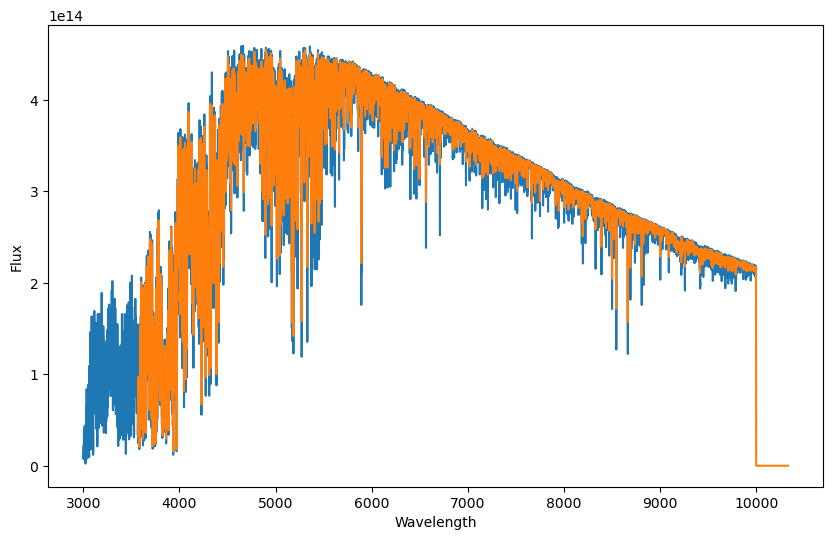

In [9]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt



hdul = fits.open('C:/Users/serat/Downloads/phoenix_fits/lte05000-4.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits')
primary_hdu = hdul[0]
synthetic_flux = primary_hdu.data
header = primary_hdu.header
synthetic_wavelength = np.arange(header["NAXIS1"])*header["CDELT1"]+header["CRVAL1"]

hdul = fits.open(f"C:/Users/serat/Downloads/yso_veiled/spec-015072-59216-4503364182.fits")
t = hdul[1].data
a = np.where((t["IVAR"] > np.median(t["IVAR"])/10) & (np.isfinite(t['IVAR'])==True))[0]
boss_flux = t["FLUX"][a] / np.median(t["FLUX"][a])

boss_wavelength = t["LOGLAM"][a]

boss_wavelength_linear = 10**boss_wavelength



resampled_flux = np.zeros_like(boss_flux)

for i in range(len(boss_wavelength_linear)):
    # Handle the last point by extending the last interval
    if i == len(boss_wavelength_linear) - 1:
        upper_wavelength = synthetic_wavelength[-1]
    else:
        upper_wavelength = boss_wavelength_linear[i + 1]

    # Find the range in the synthetic spectrum that corresponds to the current BOSS wavelength interval
    mask = (synthetic_wavelength >= boss_wavelength_linear[i]) & (synthetic_wavelength < upper_wavelength)
    
    # Calculate the sum of the flux over this interval (assuming the synthetic spectrum is in photons/s/cm^2/bin)
    if np.any(mask):
        resampled_flux[i] = np.sum(synthetic_flux[mask]) / mask.sum()

plt.figure(figsize=(10,6))
plt.plot(synthetic_wavelength, synthetic_flux, label='Synthetic Spectrum')
plt.plot(boss_wavelength_linear, resampled_flux, label='Resampled Synthetic Spectrum')
#plt.plot(boss_wavelength_linear, boss_flux)
#plt.ylim(0, 1e12)
#plt.xlim(6400, 6800)
plt.xlabel('Wavelength')
plt.ylabel('Flux')
#plt.legend()
plt.show()


In [1]:
import os
from astropy.io import fits
import numpy as np
import tqdm

# Directory containing the Phoenix FITS files
phoenix_directory = 'lineforest-main/example/phoenix_fits'

hdul = fits.open(f"yso_veiled/spec-015072-59216-4503364182.fits")
t = hdul[1].data
a = np.where((t["IVAR"] > np.median(t["IVAR"])/10) & (np.isfinite(t['IVAR'])==True))[0]
boss_flux = t["FLUX"][a] / np.median(t["FLUX"][a])
boss_wavelength = t["LOGLAM"][a]
boss_wavelength_linear = 10**boss_wavelength

# Process each FITS file in the directory
for filename in os.listdir(phoenix_directory):
    
    if filename.endswith('.fits'):
        print(filename)
        file_path = os.path.join(phoenix_directory, filename)

        # Open the Phoenix file and extract data
        with fits.open(file_path) as hdul:
            primary_hdu = hdul[0]
            synthetic_flux = primary_hdu.data
            header = primary_hdu.header
            synthetic_wavelength = np.arange(header["NAXIS1"]) * header["CDELT1"] + header["CRVAL1"]

        # ... (use the same code to process the BOSS spectrum) ...
        
        

        # Calculate the resampled flux
        resampled_flux = np.zeros_like(boss_flux)
        for i in range(len(boss_wavelength_linear)):
            if i == len(boss_wavelength_linear) - 1:
                upper_wavelength = synthetic_wavelength[-1]
            else:
                upper_wavelength = boss_wavelength_linear[i + 1]
            mask = (synthetic_wavelength >= boss_wavelength_linear[i]) & (synthetic_wavelength < upper_wavelength)
            if np.any(mask):
                resampled_flux[i] = np.sum(synthetic_flux[mask]) / mask.sum()

        # Save the resampled data as a new FITS file
        hdu = fits.PrimaryHDU(resampled_flux)
        hdul = fits.HDUList([hdu])
        save_path = os.path.join(phoenix_directory, 'processed_' + filename)
        hdul.writeto(save_path, overwrite=True)
        


lte02300-0.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte02300-0.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte02300-1.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte02300-1.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte02300-2.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte02300-2.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte02300-3.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte02300-3.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte02300-4.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte02300-4.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte02300-5.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte02300-5.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte02300-6.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte02400-0.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte02400-0.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte02400-1.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte02400-1.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte02400-2.00-0.0.PHOENIX-ACES-

lte03400-0.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte03400-1.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte03400-1.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte03400-2.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte03400-2.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte03400-3.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte03400-3.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte03400-4.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte03400-4.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte03400-5.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte03400-5.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte03400-6.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte03500-0.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte03500-0.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte03500-1.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte03500-1.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte03500-2.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte03500-2.50-0.0.PHOENIX-ACES-

lte04500-1.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte04500-1.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte04500-2.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte04500-2.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte04500-3.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte04500-3.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte04500-4.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte04500-4.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte04500-5.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte04500-5.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte04500-6.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte04600-0.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte04600-0.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte04600-1.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte04600-1.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte04600-2.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte04600-2.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte04600-3.00-0.0.PHOENIX-ACES-

lte05600-1.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte05600-2.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte05600-2.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte05600-3.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte05600-3.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte05600-4.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte05600-4.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte05600-5.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte05600-5.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte05600-6.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte05700-0.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte05700-1.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte05700-1.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte05700-2.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte05700-2.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte05700-3.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte05700-3.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte05700-4.00-0.0.PHOENIX-ACES-

lte06800-6.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte06900-1.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte06900-1.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte06900-2.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte06900-2.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte06900-3.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte06900-3.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte06900-4.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte06900-4.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte06900-5.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte06900-5.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte06900-6.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte07000-1.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte07000-1.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte07000-2.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte07000-2.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte07000-3.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte07000-3.50-0.0.PHOENIX-ACES-

lte09400-4.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte09400-5.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte09400-5.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte09400-6.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte09600-2.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte09600-2.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte09600-3.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte09600-3.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte09600-4.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte09600-4.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte09600-5.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte09600-5.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte09600-6.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte09800-2.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte09800-2.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte09800-3.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte09800-3.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
lte09800-4.00-0.0.PHOENIX-ACES-

KeyError: "Keyword 'CDELT1' not found."

# Masking for chi square and higher veiling values

In [33]:
hdul = fits.open(f"C:/Users/serat/Downloads/yso_veiled/spec-015072-59186-4500378052.fits")
t = hdul[1].data
a = np.where((t["IVAR"] > np.median(t["IVAR"])/10) & (np.isfinite(t['IVAR'])==True))[0]
flux = t["FLUX"][a] / np.median(t["FLUX"][a])
wl2 = 10**(t["LOGLAM"][a])
print(max(wl2), min(wl2))
err=(np.sqrt(1./t["IVAR"][a]))/np.nanmedian(flux)

10318.104 3566.9744


# Saving wavelength column

In [51]:
t = Table.read("non_yso_veiling.fits")
arr = np.linspace(3566.9744, 10318.104, 70)


t["wavelength_arr"] = Column(length=len(t),dtype=float, shape=(70,))+np.nan

t["wavelength_arr"] = arr

t.write("non_yso_veiling.fits", overwrite=True)

# Removing higher veiling and chisquare

In [22]:
s = Table.read("yso_veiling1.fits")

upper_lim = np.array([30, 43, 52, 62])
lower_lim = np.array([19, 31, 41, 51])

for i in range(len(s)):
    veiling_arr = s['veiling_arr'][i]
    chi_square = s['Chisquare_list'][i]

    veiling_arr[veiling_arr > 3] = np.nan
    
    b = np.where(chi_square > 3)[0]

    for j in b:
        veiling_arr[lower_lim[j]:upper_lim[j]] = np.nan

    s['veiling_arr'][i] = veiling_arr
    
s.write('yso_veiling1.fits', overwrite=True)

# Finding the ctts using the halpha cut

[-4.4296875   2.8398438   2.5351562  ...  0.96777344  2.0546875
 11.3125    ]
2887


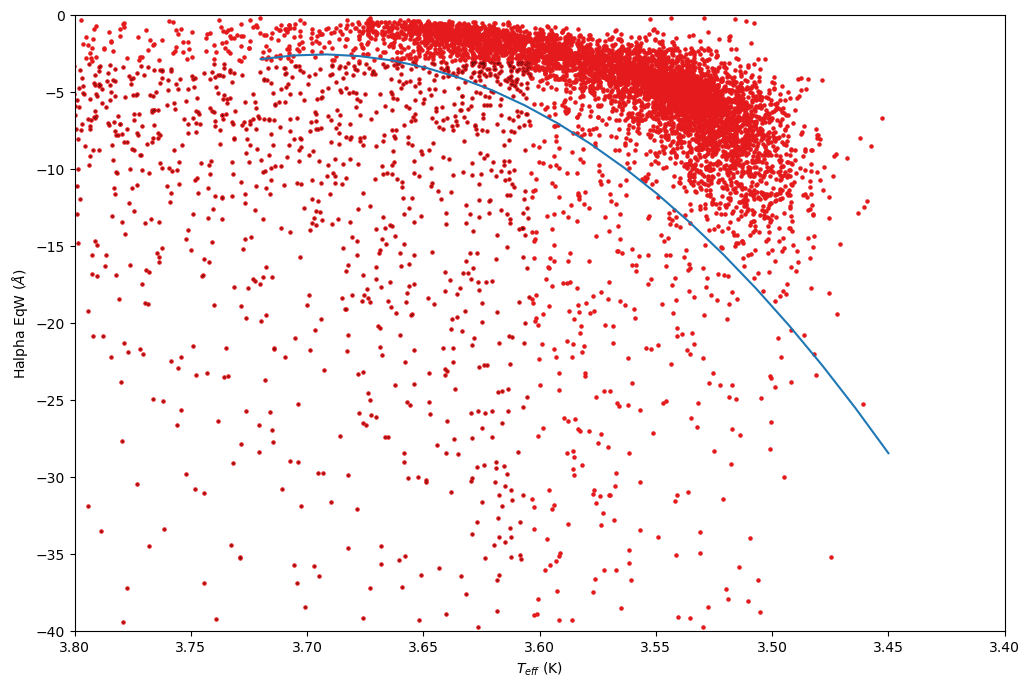

In [15]:
t = Table.read("boss-ysos-veiling.fits")

eqw = np.array(t["Halpha_eqw_1"])
Teff = np.array(t["pred_logteff_1"])
print(eqw)


plt.figure(figsize= (12, 8))
plt.scatter(Teff, eqw, s = 5, color = '#e41a1c', rasterized = True)

plt.xlim(3.8, 3.4)
plt.ylim(-9000, 1000)
plt.xlabel(r'$T_{eff}$ (K)')
plt.ylabel(r'Halpha EqW $(\AA)$')



#plt.step(np.log10([2880, 3360, 4020, 5030]),[-40, -20, -10, -3])
#plt.plot(np.log10([1000,2880]),[-40,-40], c = 'black')
#plt.plot(np.log10([2880, 3360]),[-20,-20], c = 'black')
#plt.plot(np.log10([3360, 4020]),[-10,-10], c = 'black')
#plt.plot(np.log10([4020, 5030]),[-3,-3], c = 'black')

idx = []


a = np.where((Teff < np.log10(10000)) & (Teff > np.log10(4020)) & (eqw < -3 ))[0]
plt.scatter(Teff[a], eqw[a], s = 0.05, color = 'black', rasterized = True)
idx.extend(a)

#a = np.where((Teff < np.log10(4020)) & (Teff > np.log10(3360)) & (eqw < -10 ))[0]
#plt.scatter(Teff[a], eqw[a], s = 0.05, color = 'black', rasterized = True)
#idx.extend(a)

#a = np.where((Teff < np.log10(3360)) & (eqw < -20 ))[0]
#plt.scatter(Teff[a], eqw[a], s = 0.05, color = 'black', rasterized = True)
#idx.extend(a)

plt.ylim(-40, 0)


x = np.linspace(3.72, 3.45, 20)
plt.plot(x, -436.95*(x**2)+3227.7*x-5963.2)


a = np.where(eqw < -436.95*(Teff**2)+3227.7*Teff-5963.2)[0]
idx.extend(a) 
print(len(idx))
#plt.savefig("Plot2778")


In [13]:
print(t[idx]['ctts'])

ctts
----
True
True
True
True
True
True
True
True
True
True
 ...
True
True
True
True
True
True
True
True
True
True
True
Length = 3384 rows


In [16]:
t['ctts'] = False
t['ctts'][idx] = True

In [18]:
t.write('yso_veiling1.fits', overwrite=True)

In [ ]:
print()

In [17]:
print(len(np.where(t['ctts']==True)[0]))

1877


# Concatenating multiple tables

In [2]:
from astropy.io import fits
import numpy as np

# List of your FITS files
fits_files = ['non_yso_veiling0.fits', 'non_yso_veiling1.fits', 'non_yso_veiling2.fits',\
             'non_yso_veiling3.fits', 'non_yso_veiling4.fits', 'non_yso_veiling5.fits',\
             'non_yso_veiling6.fits', 'non_yso_veiling7.fits', 'non_yso_veiling8.fits',\
             'non_yso_veiling9.fits', 'non_yso_veiling10.fits', 'non_yso_veiling11.fits',\
             'non_yso_veiling12.fits', 'non_yso_veiling13.fits', 'non_yso_veiling14.fits',\
             'non_yso_veiling15.fits', 'non_yso_veiling16.fits', 'non_yso_veiling17.fits',\
             'non_yso_veiling18.fits', 'non_yso_veiling19.fits']

# Read the first file to get the shape and header
with fits.open(fits_files[0]) as hdul:
    data_shape = hdul[1].data.shape
    header = hdul[1].header

# Initialize an array to store all data
all_data = np.empty((len(fits_files), *data_shape))

# Loop through all files and populate the array
for i, file in enumerate(fits_files):
    with fits.open(file) as hdul:
        all_data[i] = hdul[0].data

# Create a Primary HDU object from the data and inherit the header of the first image
hdu = fits.PrimaryHDU(data=all_data, header=header)

# Write to a new FITS file
hdu.writeto('concatenated.fits', overwrite=True)


# Binning and taking average to all the sources for different temperature

In [25]:
s = Table.read("non_yso_veiling.fits")
#wl = np.linspace(3566.9744, 10318.104, 70)
#a = np.where((s['pred_logteff'] < np.log10(4000)) & (s['pred_logteff'] > np.log10(3000)))[0]
#print(len(a))
#veiling_teff = np.array(s['veiling_arr'][a])
#median_veiling = np.nanmedian(veiling_teff, axis=0)
#print(median_veiling)


lower_temps, upper_temps, median_veilings, lower_percentile_veilings, upper_percentile_veilings = [], [], [], [], []

indices = np.where(s['pred_logteff'] < np.log10(2300))[0]
if len(indices) > 0:
    veiling_teff = np.array(s['veiling_arr'][indices])
    median_veiling = np.nanquantile(veiling_teff, 0.5, axis=0)
    lower_percentile_veiling = np.nanquantile(veiling_teff, 0.16, axis=0)
    upper_percentile_veiling = np.nanquantile(veiling_teff, 0.84, axis=0)
else:
    median_veiling = np.full(70, np.nan)
    lower_percentile_veiling = np.full(70, np.nan)
    upper_percentile_veiling = np.full(70, np.nan)

lower_temps.append(0)
upper_temps.append(2300)
median_veilings.append(median_veiling)
lower_percentile_veilings.append(lower_percentile_veiling)
upper_percentile_veilings.append(upper_percentile_veiling)

for lower_temp in range(2300, 11000, 100):
    upper_temp = lower_temp + 1000
    indices = np.where((s['pred_logteff'] >= np.log10(lower_temp)) & (s['pred_logteff'] < np.log10(upper_temp)))[0]
    if len(indices) > 0:
        veiling_teff = np.array(s['veiling_arr'][indices])
        median_veiling = np.nanquantile(veiling_teff, 0.5, axis=0)
        lower_percentile_veiling = np.nanquantile(veiling_teff, 0.16, axis=0)
        upper_percentile_veiling = np.nanquantile(veiling_teff, 0.84, axis=0)
    else:
        median_veiling = np.full(70, np.nan)
        lower_percentile_veiling = np.full(70, np.nan)
        upper_percentile_veiling = np.full(70, np.nan)

    lower_temps.append(lower_temp)
    upper_temps.append(upper_temp)
    median_veilings.append(median_veiling)
    lower_percentile_veilings.append(lower_percentile_veiling)
    upper_percentile_veilings.append(upper_percentile_veiling)

indices = np.where(s['pred_logteff'] >= np.log10(11000))[0]
if len(indices) > 0:
    veiling_teff = np.array(s['veiling_arr'][indices])
    median_veiling = np.nanquantile(veiling_teff, 0.5, axis=0)
    lower_percentile_veiling = np.nanquantile(veiling_teff, 0.16, axis=0)
    upper_percentile_veiling = np.nanquantile(veiling_teff, 0.84, axis=0)
else:
    median_veiling = np.full(70, np.nan)
    lower_percentile_veiling = np.full(70, np.nan)
    upper_percentile_veiling = np.full(70, np.nan)

lower_temps.append(11000)
upper_temps.append(np.inf)
median_veilings.append(median_veiling)
lower_percentile_veilings.append(lower_percentile_veiling)
upper_percentile_veilings.append(upper_percentile_veiling)

t = Table()
t['Lower_Temp'] = Column(lower_temps, unit=u.K, description='Lower bound of temperature range')
t['Upper_Temp'] = Column(upper_temps, unit=u.K, description='Upper bound of temperature range')
t['Median_Veiling'] = median_veilings
t['Lower_Uncertainty'] = np.array(median_veilings) - np.array(lower_percentile_veilings)
t['Upper_Uncertainty'] = np.array(median_veilings) - np.array(upper_percentile_veilings)

arr = np.linspace(3566.9744, 10318.104, 70)
t["Wavelength"] = Column(length=len(t),dtype=float, shape=(70,))+np.nan
t["Wavelength"] = arr

t.write('non_yso_temp_veiling.fits', overwrite=True)


C:\Users\serat\anaconda4\Lib\site-packages\numpy\lib\nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


In [28]:
s = Table.read("ctts@veiling.fits")
#wl = np.linspace(3566.9744, 10318.104, 70)
#a = np.where((s['pred_logteff'] < np.log10(4000)) & (s['pred_logteff'] > np.log10(3000)))[0]
#print(len(a))
#veiling_teff = np.array(s['veiling_arr'][a])
#median_veiling = np.nanmedian(veiling_teff, axis=0)
#print(median_veiling)


lower_temps, upper_temps, median_veilings, lower_percentile_veilings, upper_percentile_veilings = [], [], [], [], []

indices = np.where(s['pred_logteff_1'] < np.log10(2300))[0]
if len(indices) > 0:
    veiling_teff = np.array(s['veiling_arr'][indices])
    median_veiling = np.nanquantile(veiling_teff, 0.5, axis=0)
    lower_percentile_veiling = np.nanquantile(veiling_teff, 0.16, axis=0)
    upper_percentile_veiling = np.nanquantile(veiling_teff, 0.84, axis=0)
else:
    median_veiling = np.full(70, np.nan)
    lower_percentile_veiling = np.full(70, np.nan)
    upper_percentile_veiling = np.full(70, np.nan)

lower_temps.append(0)
upper_temps.append(2300)
median_veilings.append(median_veiling)
lower_percentile_veilings.append(lower_percentile_veiling)
upper_percentile_veilings.append(upper_percentile_veiling)

for lower_temp in range(2300, 11000, 100):
    upper_temp = lower_temp + 1000
    indices = np.where((s['pred_logteff_1'] >= np.log10(lower_temp)) & (s['pred_logteff_1'] < np.log10(upper_temp)))[0]
    if len(indices) > 0:
        veiling_teff = np.array(s['veiling_arr'][indices])
        median_veiling = np.nanquantile(veiling_teff, 0.5, axis=0)
        lower_percentile_veiling = np.nanquantile(veiling_teff, 0.16, axis=0)
        upper_percentile_veiling = np.nanquantile(veiling_teff, 0.84, axis=0)
    else:
        median_veiling = np.full(70, np.nan)
        lower_percentile_veiling = np.full(70, np.nan)
        upper_percentile_veiling = np.full(70, np.nan)

    lower_temps.append(lower_temp)
    upper_temps.append(upper_temp)
    median_veilings.append(median_veiling)
    lower_percentile_veilings.append(lower_percentile_veiling)
    upper_percentile_veilings.append(upper_percentile_veiling)

indices = np.where(s['pred_logteff_1'] >= np.log10(11000))[0]
if len(indices) > 0:
    veiling_teff = np.array(s['veiling_arr'][indices])
    median_veiling = np.nanquantile(veiling_teff, 0.5, axis=0)
    lower_percentile_veiling = np.nanquantile(veiling_teff, 0.16, axis=0)
    upper_percentile_veiling = np.nanquantile(veiling_teff, 0.84, axis=0)
else:
    median_veiling = np.full(70, np.nan)
    lower_percentile_veiling = np.full(70, np.nan)
    upper_percentile_veiling = np.full(70, np.nan)

lower_temps.append(11000)
upper_temps.append(np.inf)
median_veilings.append(median_veiling)
lower_percentile_veilings.append(lower_percentile_veiling)
upper_percentile_veilings.append(upper_percentile_veiling)

t = Table()
t['Lower_Temp'] = Column(lower_temps, unit=u.K, description='Lower bound of temperature range')
t['Upper_Temp'] = Column(upper_temps, unit=u.K, description='Upper bound of temperature range')
t['Median_Veiling'] = median_veilings
t['Lower_Uncertainty'] = np.array(median_veilings) - np.array(lower_percentile_veilings)
t['Upper_Uncertainty'] = np.array(median_veilings) - np.array(upper_percentile_veilings)

for i in range(len(t)):
    print(t[i])

arr = np.linspace(3566.9744, 10318.104, 70)
t["Wavelength"] = Column(length=len(t),dtype=float, shape=(70,))+np.nan
t["Wavelength"] = arr
    
t.write('ctts_temp_veiling.fits', overwrite=True)


C:\Users\serat\anaconda4\Lib\site-packages\numpy\lib\nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


Lower_Temp Upper_Temp Median_Veiling Lower_Uncertainty Upper_Uncertainty
    K          K                                                        
---------- ---------- -------------- ----------------- -----------------
         0     2300.0     nan .. nan        nan .. nan        nan .. nan
Lower_Temp Upper_Temp       Median_Veiling          Lower_Uncertainty         Upper_Uncertainty     
    K          K                                                                                    
---------- ---------- ------------------------- ------------------------- --------------------------
      2300     3300.0 0.7216709595316972 .. nan 0.7215392945771895 .. nan -0.7878332378962847 .. nan
Lower_Temp Upper_Temp       Median_Veiling         Lower_Uncertainty        Upper_Uncertainty     
    K          K                                                                                  
---------- ---------- ------------------------- ----------------------- --------------------------
      2

In [7]:
#Interpolation (For both Temp and Age, maybe together):
# Median Veiling Ctts - Median Veiling Wtts
# Median Veiling Ctts - Median Veiling Non_YSO
# Median Veiling Wtts - Median Veiling Non_YSO

# Uncertainty should be subtraction (D)
t

Lower_Temp,Upper_Temp,Median_Veiling,Lower_Uncertainty,Upper_Uncertainty
K,K,,,
int32,float64,float64[70],float64[70],float64[70]
0,2300.0,nan .. nan,nan .. nan,nan .. nan
2300,3300.0,0.7216709595316972 .. nan,0.7215392945771895 .. nan,-0.7878332378962847 .. nan
2400,3400.0,0.6802284679938392 .. nan,0.68018632634957 .. nan,-1.0428525148652499 .. nan
2500,3500.0,0.6038874135477569 .. nan,0.6038874014705425 .. nan,-1.1340127787458214 .. nan
2600,3600.0,0.486868012318255 .. nan,0.48686801189633316 .. nan,-1.2641779792934682 .. nan
2700,3700.0,0.5868248947212613 .. nan,0.5868248668834771 .. nan,-1.2013437818753672 .. nan
2800,3800.0,0.5868248947212613 .. nan,0.5868248750591659 .. nan,-1.1845223592836644 .. nan
2900,3900.0,0.6189442811705079 .. nan,0.6189441097594804 .. nan,-1.1428913870851791 .. nan


In [50]:
a = Table.read("Temperature_veiling/wtts_temp_veiling.fits")
b = Table.read("Temperature_veiling/ctts_temp_veiling.fits")
c = Table.read("Temperature_veiling/non_yso_temp_veiling.fits")

wtts = a[a['Upper_Temp'] <= 8000]
ctts = b[b['Upper_Temp'] <= 8000]
noyso = c[c['Upper_Temp'] <= 8000]

wtts_veiling = wtts['Median_Veiling']
wtts_lower_err = wtts['Lower_Uncertainty']
wtts_upper_err = wtts['Upper_Uncertainty']

ctts_veiling = ctts['Median_Veiling']
ctts_lower_err = ctts['Lower_Uncertainty']
ctts_upper_err = ctts['Upper_Uncertainty']

noyso_veiling = noyso['Median_Veiling']
noyso_lower_err = noyso['Lower_Uncertainty']
noyso_upper_err = noyso['Upper_Uncertainty']


new_table = Table()


new_table['Lower_Temp'] = ctts['Lower_Temp']
new_table['Upper_Temp'] = ctts['Upper_Temp']


new_table['CTTS_veiling-WTTS_veiling'] = ctts_veiling - wtts_veiling
new_table['CTTS_veiling-NONYSO_veiling'] = ctts_veiling - noyso_veiling
new_table['WTTS_veiling-NONYSO_veiling'] = wtts_veiling - noyso_veiling

new_table['CTTS_lowerunc-WTTS_lowerunc'] = ctts_lower_err - wtts_lower_err
new_table['CTTS_upperunc-WTTS_upperunc'] = ctts_upper_err - wtts_upper_err
new_table['CTTS_lowerunc-NONYSO_lowerunc'] = ctts_lower_err - noyso_lower_err
new_table['CTTS_upperunc-NONYSO_upperunc'] = ctts_upper_err - noyso_upper_err
new_table['WTTS_lowerunc-NONYSO_lowerunc'] = wtts_lower_err - noyso_lower_err
new_table['WTTS_upperunc-NONYSO_upperunc'] = wtts_upper_err - noyso_upper_err

arr = np.linspace(3566.9744, 10318.104, 70)
new_table["Wavelength"] = Column(length=len(new_table),dtype=float, shape=(70,))+np.nan
new_table["Wavelength"] = arr

for i in range(len(new_table)):
    new_table['CTTS_veiling-WTTS_veiling'][new_table['CTTS_veiling-WTTS_veiling'] < 0] = 0.
    new_table['CTTS_veiling-NONYSO_veiling'][new_table['CTTS_veiling-NONYSO_veiling'] < 0] = 0.
    new_table['WTTS_veiling-NONYSO_veiling'][new_table['WTTS_veiling-NONYSO_veiling'] < 0] = 0.
    
    
new_table.write('n_temp_veiling.fits', overwrite=True)


# Comparison with age

In [33]:
s = Table.read("boss-ysos-veiling.fits")


print(min(s['age']), max(s['age']))


5.300321 8.339497


In [62]:
s = Table.read("ctts_veiling.fits")



lower_ages, upper_ages, median_veilings, lower_percentile_veilings, upper_percentile_veilings = [], [], [], [], []


for lower_age in np.arange(5.3, 8.4, 0.03):
    upper_age = lower_age + 0.1
    indices = np.where((s['age'] >= lower_age) & (s['age'] < upper_age))[0]
    if len(indices) > 0:
        veiling_age = np.array(s['veiling_arr'][indices])
        median_veiling = np.nanquantile(veiling_age, 0.5, axis=0)
        lower_percentile_veiling = np.nanquantile(veiling_age, 0.16, axis=0)
        upper_percentile_veiling = np.nanquantile(veiling_age, 0.84, axis=0)
    else:
        median_veiling = np.full(70, np.nan)
        lower_percentile_veiling = np.full(70, np.nan)
        upper_percentile_veiling = np.full(70, np.nan)

    lower_ages.append(lower_age)
    upper_ages.append(upper_age)
    median_veilings.append(median_veiling)
    lower_percentile_veilings.append(lower_percentile_veiling)
    upper_percentile_veilings.append(upper_percentile_veiling)



t = Table()
t['Lower_Age'] = Column(lower_ages, unit=u.K, description='Lower bound of age range')
t['Upper_Age'] = Column(upper_ages, unit=u.K, description='Upper bound of age range')
t['Median_Veiling'] = median_veilings
t['Lower_Uncertainty'] = np.array(median_veilings) - np.array(lower_percentile_veilings)
t['Upper_Uncertainty'] = np.array(median_veilings) - np.array(upper_percentile_veilings)

arr = np.linspace(3566.9744, 10318.104, 70)
t["Wavelength"] = Column(length=len(t),dtype=float, shape=(70,))+np.nan
t["Wavelength"] = arr



t.write('ctts_age_veiling.fits', overwrite=True)


C:\Users\serat\anaconda4\Lib\site-packages\numpy\lib\nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


In [52]:
s = Table.read("non_yso_veiling.fits")



lower_ages, upper_ages, median_veilings, lower_percentile_veilings, upper_percentile_veilings = [], [], [], [], []


for lower_age in np.arange(5.3, 8.4, 0.1):
    upper_age = lower_age + 0.1
    indices = np.where((s['age'] >= lower_age) & (s['age'] < upper_age))[0]
    if len(indices) > 0:
        veiling_age = np.array(s['veiling_arr'][indices])
        median_veiling = np.nanquantile(veiling_age, 0.5, axis=0)
        lower_percentile_veiling = np.nanquantile(veiling_age, 0.16, axis=0)
        upper_percentile_veiling = np.nanquantile(veiling_age, 0.84, axis=0)
    else:
        median_veiling = np.full(70, np.nan)
        lower_percentile_veiling = np.full(70, np.nan)
        upper_percentile_veiling = np.full(70, np.nan)

    lower_ages.append(lower_age)
    upper_ages.append(upper_age)
    median_veilings.append(median_veiling)
    lower_percentile_veilings.append(lower_percentile_veiling)
    upper_percentile_veilings.append(upper_percentile_veiling)



t = Table()
t['Lower_Age'] = Column(lower_ages, unit=u.K, description='Lower bound of age range')
t['Upper_Age'] = Column(upper_ages, unit=u.K, description='Upper bound of age range')
t['Median_Veiling'] = median_veilings
t['Lower_Uncertainty'] = np.array(median_veilings) - np.array(lower_percentile_veilings)
t['Upper_Uncertainty'] = np.array(median_veilings) - np.array(upper_percentile_veilings)

arr = np.linspace(3566.9744, 10318.104, 70)
t["Wavelength"] = Column(length=len(t),dtype=float, shape=(70,))+np.nan
t["Wavelength"] = arr

t.write('non_yso_age_veiling.fits', overwrite=True)


KeyError: 'age'

In [61]:
a = Table.read("Age_veiling/wtts_age_veiling.fits")
b = Table.read("Age_veiling/ctts_age_veiling.fits")

wtts = a
ctts = b

wtts_veiling = wtts['Median_Veiling']
wtts_lower_err = wtts['Lower_Uncertainty']
wtts_upper_err = wtts['Upper_Uncertainty']

ctts_veiling = ctts['Median_Veiling']
ctts_lower_err = ctts['Lower_Uncertainty']
ctts_upper_err = ctts['Upper_Uncertainty']



new_table = Table()


new_table['Lower_Age'] = ctts['Lower_Age']
new_table['Upper_Age'] = ctts['Upper_Age']


new_table['CTTS_veiling-WTTS_veiling'] = ctts_veiling - wtts_veiling

new_table['CTTS_lowerunc-WTTS_lowerunc'] = ctts_lower_err - wtts_lower_err
new_table['CTTS_upperunc-WTTS_upperunc'] = ctts_upper_err - wtts_upper_err

arr = np.linspace(3566.9744, 10318.104, 70)
new_table["Wavelength"] = Column(length=len(new_table),dtype=float, shape=(70,))+np.nan
new_table["Wavelength"] = arr

for i in range(len(new_table)):
    new_table['CTTS_veiling-WTTS_veiling'][new_table['CTTS_veiling-WTTS_veiling'] < 0] = 0.
    
new_table.write('age_veiling.fits', overwrite=True)


# SED Fit

In [9]:
from SEDFit.sed import SEDFit
import matplotlib.pyplot as plt
x=SEDFit('16 21 26.43','21 36 59.0',1,panstarrs=False,grid_type='btsettl')
x.addguesses(dist=600,av=0.,r=[2,2],teff=[4020,6150],logg=3)
x.addrange(dist=[500,3000],r=[1.,5],logg=[3,4],feh=[-0.5,0.5])
idx=range(1,len(x.sed))
pars=x.fit(use_gaia=True,use_mag=idx)
print("Distance: {} pc".format(x.getdist()))
print("AV: {} mag".format(x.getav()))
print("Radius: {} Rsun".format(x.getr()))
print("Teff: {} K".format(x.getteff()))
print("Log g: {} ".format(x.getlogg()))
print("Fe/H: {}".format(x.getfeh()))
print("Chi squared: {}".format(x.getchisq()))
ax=x.makeplot(getplot=True)
ax[1].set_ylim(-0.15,0.15)
plt.show()

ModuleNotFoundError: No module named 'SEDFit'

In [8]:
!pip install SEDFit

  Using cached SEDFit-0.5-py3-none-any.whl
  Using cached dust_extinction-1.3-py3-none-any.whl
  Obtaining dependency information for dustmaps from https://files.pythonhosted.org/packages/56/70/73dc954e11fbab1b4cf939debcf1083e6c1032e7b52326aaf9091befa931/dustmaps-1.0.13-py3-none-any.whl.metadata
  Using cached dustmaps-1.0.13-py3-none-any.whl.metadata (5.7 kB)
  Using cached healpy-1.16.6.tar.gz (4.4 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Obtaining dependency information for progressbar2 from https://files.pythonhosted.org/packages/e6/7c/7da9fefe4429f21e16fb9ab95c05f47cd11ffa4fd79932b639a1380a52a3/progressbar2-4.4.2-py3-none-any.whl.metadata
  Using cached progressbar2-4.4.2-py3-none-any.whl.me

  error: subprocess-exited-with-error
  
  exit code: 1
  
  [369 lines of output]
  C:\Users\serat\AppData\Local\Temp\pip-build-env-fhw0u63y\overlay\Lib\site-packages\setuptools\_distutils\extension.py:134: UserWarning: Unknown Extension options: 'cython_directives'
    warnings.warn(msg)
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib.win-amd64-cpython-311
  creating build\lib.win-amd64-cpython-311\healpy
  copying healpy\__init__.py -> build\lib.win-amd64-cpython-311\healpy
  copying healpy\pixelfunc.py -> build\lib.win-amd64-cpython-311\healpy
  copying healpy\sphtfunc.py -> build\lib.win-amd64-cpython-311\healpy
  copying healpy\visufunc.py -> build\lib.win-amd64-cpython-311\healpy
  copying healpy\fitsfunc.py -> build\lib.win-amd64-cpython-311\healpy
  copying healpy\projector.py -> build\lib.win-amd64-cpython-311\healpy
  copying healpy\rotator.py -> build\lib.win-amd64-cpython-311\healpy
  copying healpy\projaxes.py -> build\lib.wi

# Generating figure for poster

In [29]:
def reading_obs(file_path, rv):
    hdul = fits.open(f"C:/Users/serat/Downloads/yso_veiled/{file_path}")
    t = hdul[1].data
    a = np.where((t["IVAR"] > np.median(t["IVAR"])/10) & (np.isfinite(t['IVAR'])==True))[0]
    flux = t["FLUX"][a] / np.median(t["FLUX"][a])
    wl2 = 10**(t["LOGLAM"][a])
    wl2 = wl2 + wl2*(rv/299792.458)
    err=(np.sqrt(1./t["IVAR"][a]))/np.nanmedian(flux)

    return flux, wl2,err


def divide_in_steps(flux, wl2):
    total_steps = int(((max(wl2)-min(wl2))//100))
    wl2_arr = []
    flux_arr = []
    for i in range(total_steps):
        x = ((min(wl2)//100)*100) + 100*i
        a = np.where((wl2<x+1000) & (wl2>=x))[0]
        flux_new = flux[a]
        wl2_new = wl2[a]
        flux_arr.append(flux_new)
        wl2_arr.append(wl2_new)
    return flux_arr, wl2_arr

def reading_ph(teff, logg):
    hdul = fits.open(f"C:/Users/serat/Downloads/phoenix_fits/lte0{teff}-{logg}0-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits")
    primary_hdu = hdul[0]
    data = primary_hdu.data
    header = primary_hdu.header
    wl1 = np.arange(header["NAXIS1"])*header["CDELT1"]+header["CRVAL1"]
    data = data/np.median(data)
    return data, wl1

def model_flux_Av(synthetic_flux, Av):
    ext_model = G23(Rv=3.1)
    flux_corrected = synthetic_flux * ext_model.extinguish(wavelengths_obs, Av=Av)
    flux = flux_corrected/np.median(flux_corrected)
    return flux
    
def model_flux_veiling(flux, v_const):
    flux = (flux/np.median(flux)) + v_const
    flux = flux/(1+v_const)
    return flux/np.median(flux)

def reinterp(wavelengths_obs,wavelengths_ph, flux_ph):
    ll=np.diff(wavelengths_obs)
    d=[ll[0]]
    d.extend(ll)
    d.append(ll[-1])
    d=np.array(d)
    l1=wavelengths_obs-d[:-1]*0.5
    l2=wavelengths_obs+d[1:]*0.5
    
    synthetic_flux=np.zeros(len(l1))
    for j in range(len(l1)):
        x=np.where((wavelengths_ph>l1[j]) & (wavelengths_ph<l2[j]))[0]
        synthetic_flux[j]=np.sum(flux_ph[x])/len(x)

    return synthetic_flux
    



  0%|                                                                                                                                                | 0/4 [00:00<?, ?it/s]C:\Users\serat\AppData\Local\Temp\ipykernel_10624\210879507.py:58: RuntimeWarning: invalid value encountered in scalar divide
  synthetic_flux[j]=np.sum(flux_ph[x])/len(x)


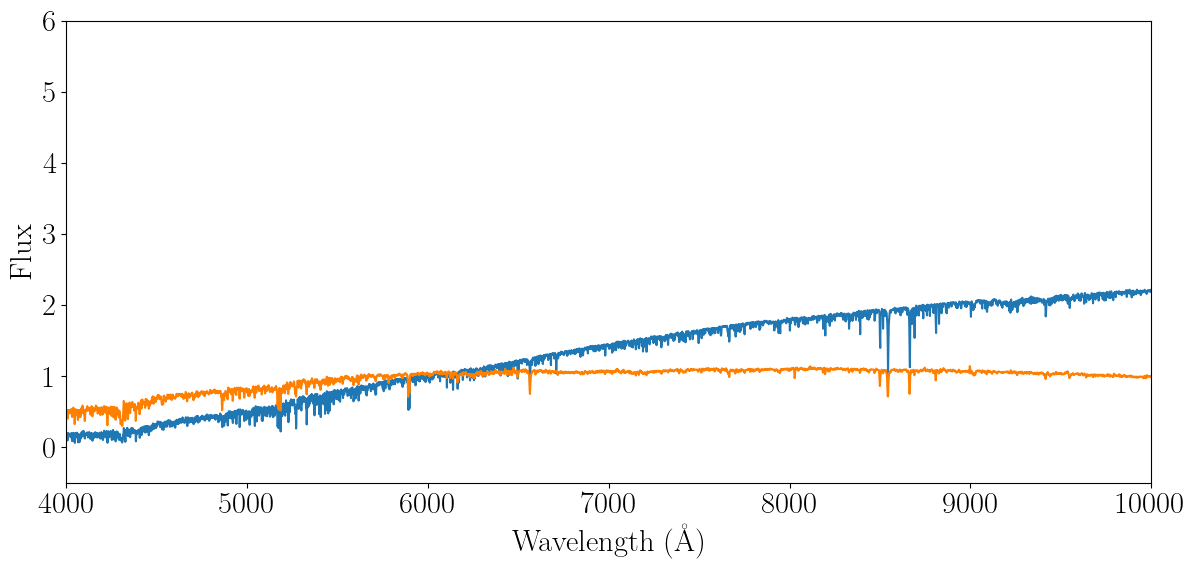

 25%|██████████████████████████████████                                                                                                      | 1/4 [00:01<00:04,  1.48s/it]

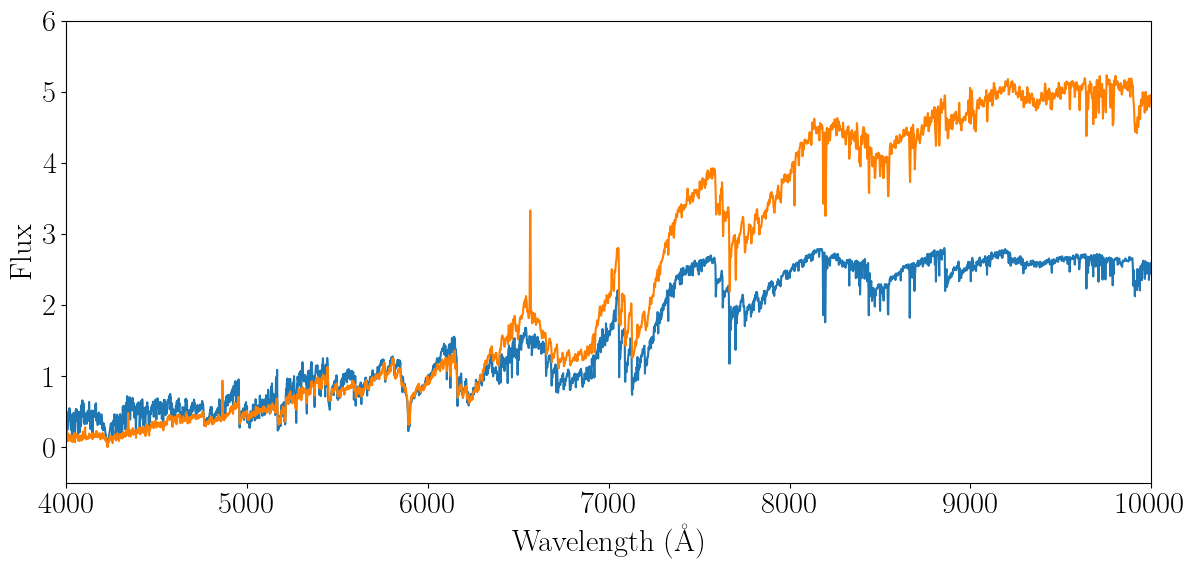

 50%|████████████████████████████████████████████████████████████████████                                                                    | 2/4 [00:02<00:02,  1.44s/it]

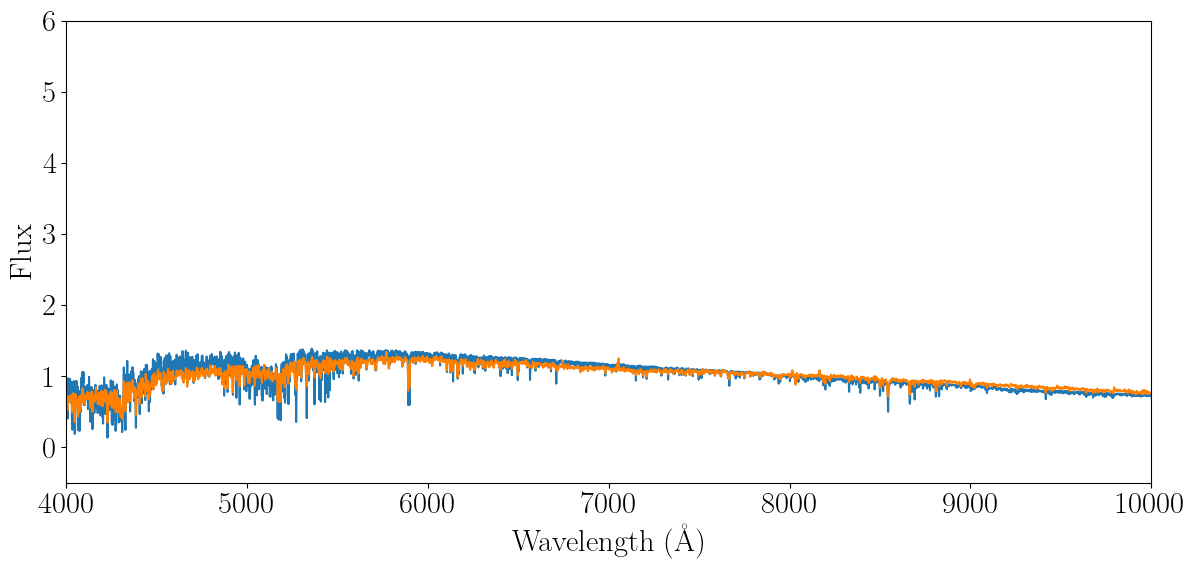

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 3/4 [00:04<00:01,  1.44s/it]

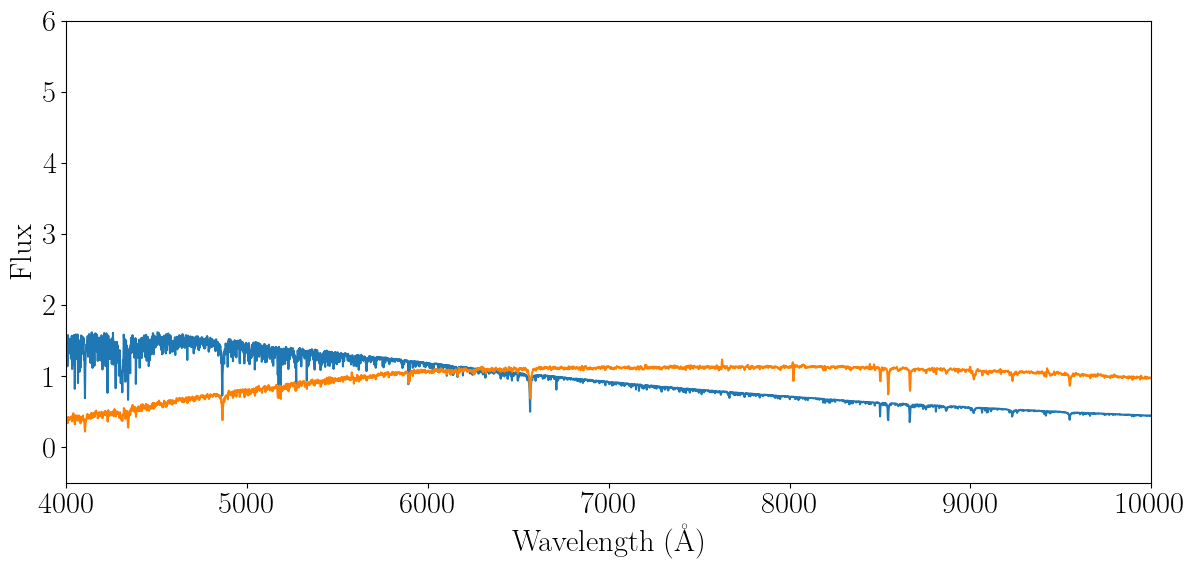

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.45s/it]


In [58]:
s = Table.read("C:/Users/serat/Downloads/yso_veiled_healpix.fits")

teff = round(10**(s["u_med_logteff_1"][0])/100)*100
logg = round(s["u_med_logg_1"][0] / 0.5)*0.5


_, wavelengths_ph = reading_ph(teff, logg) # the common wavelength range of the phoenix data


ext_model = G23(Rv=3.1)


# Saving all the possible Teff and Logg in the phoenix data
a = glob.glob("C:/Users/serat/Downloads/phoenix_fits/lte0*-*0-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits")
Teff = []
Logg = []

for i in range(len(a)):
    file = a[i]
    splt = file.split("lte")
    teff = int(splt[1].split("-")[0])
    logg = float(splt[1].split("-")[1])
    Teff.append(teff)
    Logg.append(logg)

Teff = np.unique(Teff)
Logg = np.unique(Logg)


# array used to interpolate
arr = np.zeros((len(Teff), len(Logg), len(wavelengths_ph)),)


for i in range(len(Teff)):
    for j in range(len(Logg)):
        try:
            flux1, wl1 = reading_ph(Teff[i], Logg[j])
            arr[i][j] = flux1
        except:
            continue
            
interpolator_ph = RegularGridInterpolator((Teff, Logg), arr)

s["Chisquare_list"] = Column(length=len(s),dtype=float, shape=(4,))+np.nan

s["veiling_arr"] = Column(length=len(s),dtype=float, shape=(70,))+np.nan

arr = np.arange(0, 67, 1)

plt.rc('text', usetex=True)
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 22
})

for i in tqdm(range(6, 10)):
    #try:
    rv = s["XCSAO_RV"][i]
    Teff_obs = 10**(s["u_med_logteff_1"][i])
    Logg_obs = s["u_med_logg_1"][i]
    healpix = s["HEALPIX_PATH"][i]
    file_path = healpix.split("/")[-1]

    flux_obs, wavelengths_obs, err_obs = reading_obs(file_path, rv)
    
    
    flux_ph = interpolator_ph((Teff_obs, Logg_obs))
    synthetic_flux = reinterp(wavelengths_obs, wavelengths_ph, flux_ph)
    
    wavelengths_obs = wavelengths_obs * u.AA
    wavenumbers = (1.0 / wavelengths_obs)
    a = np.where((wavenumbers >= 0.03125/u.micron) & (wavenumbers <= 10.964912280701753/u.micron) & (wavenumbers != np.nan))[0]
    synthetic_flux = synthetic_flux[a]
    wavelengths_obs = wavelengths_obs[a]
    flux_obs = flux_obs[a]
    
    err_obs=err_obs[a]    
        
    # Normalizing everything again
    #err_obs=err_obs//np.nanmedian(flux_obs)
    #flux_obs = flux_obs/np.nanmedian(flux_obs)
    
    
    
    
    synthetic_flux = synthetic_flux/np.nanmedian(synthetic_flux)
    b = np.where((np.isfinite(synthetic_flux) == True))[0]
    
    c = np.where((err_obs < 0))[0]
    
    
    synthetic_flux=np.interp(wavelengths_obs,wavelengths_obs[b],synthetic_flux[b])
    
    d = np.where((np.isfinite(synthetic_flux) == False))[0]
    
    
    params, _ = curve_fit(model_flux_Av, synthetic_flux, flux_obs, bounds=(0, 100), sigma=err_obs)
    
    flux_correct = synthetic_flux*ext_model.extinguish(wavelengths_obs, Av=params[0])
    flux_correct = flux_correct/np.median(flux_correct)
    plt.figure(figsize=(14,6))
    plt.plot(wavelengths_obs, flux_correct)
    plt.plot(wavelengths_obs, flux_obs, color='#ff7f00')
    plt.xlabel('Wavelength (\AA)')
    plt.ylabel('Flux')
    plt.ylim(-0.5,6)
    plt.xlim(4000,10000)
    plt.show()
    


    #except:
    #    continue

    
#s.write("emission_nyso.fits", overwrite=True)
